# This notebook looks at loading image chips, resizing appropriately, and storing as PyTorch data loaders. Or... at least a set of tensors. DataLoader is preferable.

## Import some required libraries

In [23]:
import torch, torchvision
import glob
import os,sys
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import rasterio
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random
from math import log10

%matplotlib inline



## load the image file names for training/testing

In [2]:
# specify the image directories for dg and planet data
dg_dir = '/media/jomc9287/Data/pytorch_SSIR_jdiaz/dg_sr_chips'
planet_dir = '/media/jomc9287/Data/pytorch_SSIR_jdiaz/planet_sr_chips'

# get the tif file paths
dg_files = glob.glob(dg_dir + '/*.tif')
planet_files = glob.glob(planet_dir + '/*.tif')

# ensure these are the same lengths
assert(len(dg_files) == len(planet_files))

# get the values for train/test/validation splits
file_len = len(dg_files)
train_len = int(file_len*.6)
test_len = int((file_len - train_len) / 2 )
validation_len = file_len - train_len - test_len

train_list = list(range(train_len))
test_list = list(range(train_len, train_len+test_len+1))
val_list = list(range(train_len+test_len, file_len))

print(train_list[0], train_list[-1])
print(test_list[0], test_list[-1])
print(val_list[0], val_list[-1])
print(file_len)

0 84090
84091 112121
112121 140151
140152


## define a function that will return relevant information from the image files

In [3]:
def getDims(fi):
    
    with rasterio.open(fi, 'r') as src:
        transform =src.transform
        arr = src.read()
        
    return transform, arr

### create a class for digital globe data which will do the following:
1. extract the image based on an index
2. extract the blue-green-red-nir channels
3. resize it be exactly 3x the planet data. The planet data is 10x10, so this should be 30x30
4. divide by the reflectance precision factor of 10000

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


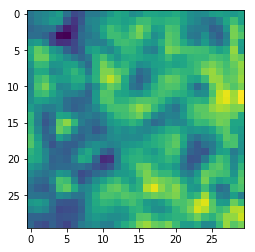

In [4]:
class DigitalGlobeDataset(Dataset):
    """DG Dataset"""
    def __init__(self, image_dir, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_dir = image_dir
        self.transform = transform
        self.bgrn = [1,2,4,6]
        
    
    def __getitem__(self, idx):
        img_name = glob.glob(self.image_dir + '/*.tif')[idx]
        img_arr = getDims(img_name)[1]
        
        new_shp = [4,30,30]
        img_arr = img_arr[self.bgrn,:,:] 
        img_arr = resize(img_arr, new_shp, preserve_range=True, mode='reflect')
        img_arr = img_arr / 10000
        
        if self.transform:
            img_arr = self.transform(img_arr)
        
        return img_arr
    
dg_dataset = DigitalGlobeDataset(dg_dir)
sample = dg_dataset[1]
plt.imshow(sample[0,:,:])

### create a class for planetScope data which will do the following:
1. extract the image based on an index
2. divide by the reflectance precision factor of 10000

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app


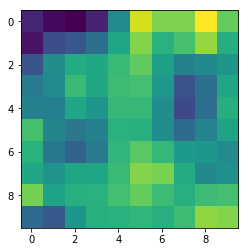

In [5]:
class PlanetScopeDataset(Dataset):
    """DG Dataset"""
    def __init__(self, image_dir, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_dir = image_dir
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_name = glob.glob(self.image_dir + '/*.tif')[idx]
        img_arr = getDims(img_name)[1]
        
        img_arr = img_arr / 10000
        
        if self.transform:
            img_arr = self.transform(img_arr)
        
        return img_arr
    
pl_dataset = PlanetScopeDataset(planet_dir)
sample = pl_dataset[1]
plt.imshow(sample[0,:,:])

#### make a class to transform the array to a tensor, and make the dataset calls use it


In [6]:
class ToTensor(object):
    """Convert ndarrays to Tensors... 
    NOTE: rasterio has band as first dim, no need for transpose
    """
    
    def __call__(self, img_arr):
        return torch.from_numpy(img_arr)
    
pl_T_dataset = PlanetScopeDataset(planet_dir, transform=transforms.Compose([ToTensor()]))
dg_T_dataset = DigitalGlobeDataset(dg_dir, transform=transforms.Compose([ToTensor()]))

dg_T_dataset[0].shape

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


torch.Size([4, 30, 30])

## create model class

In [7]:
class Net(nn.Module):
    def __init__(self, upscale_factor, NUMBER_OF_BANDS):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(NUMBER_OF_BANDS, 64, (5, 5), (1, 1), (2, 2))      # Here 
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, ((NUMBER_OF_BANDS) * (upscale_factor ** 2)),  # And here
                               (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv4.weight)

## define the model for this case
model = Net(upscale_factor=3, NUMBER_OF_BANDS=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.01) # learning rate is 0.01

cuda = torch.cuda.is_available()
if cuda:
    print('using GPU')
    model.cuda()
    criterion.cuda()

using GPU


## try the model

torch.Size([1, 4, 30, 30])


/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app


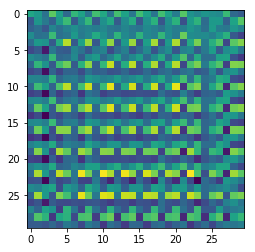

In [16]:
test = Variable(pl_T_dataset[0].unsqueeze(0))
test = test.float()
test = test.cuda()
output = model(test)
print(output.size())

# visualize it
arr_random = output.data.cpu().numpy()
arr_random = arr_random.squeeze()
plt.imshow(arr_random[0,:,:])


### use the PyTorch super-resolution example for training

In [ ]:
def train(epoch, training_list, input_dataset, target_dataset):  # updated to include list of inds, Datasets
    epoch_loss = 0
#     for iteration, batch in enumerate(training_data_loader, 1):
#         input, target = Variable(batch[0]), Variable(batch[1])
        
    random.shuffle(training_list) # shuffle the list
    for iteration, ind in enumerate(training_list):
        input, target = Variable(input_dataset[ind].unsqueeze(0).float()), \
                        Variable(target_dataset[ind].unsqueeze(0).float())
        
        if cuda:
            input = input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.data[0]
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_list), loss.data[0]))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_list)))


def test(testing_list, input_dataset, target_dataset):
    avg_psnr = 0
    #     for batch in testing_data_loader:
    #         input, target = Variable(batch[0]), Variable(batch[1])

    random.shuffle(testing_list)
    for iteration, ind in enumerate(testing_list):
        input, target = Variable(input_dataset[ind].unsqueeze(0).float()), \
                    Variable(target_dataset[ind].unsqueeze(0).float())
        if cuda:
            input = input.cuda()
            target = target.cuda()

        prediction = model(input)
        mse = criterion(prediction, target)
        psnr = 10 * log10(1 / mse.data[0])
        avg_psnr += psnr
    
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_list)))


def checkpoint(epoch):
    model_out_path = "/media/jomc9287/Data/pytorch_SSIR_jdiaz/pytorch_outputs/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [24]:
# define the number of epochs
num_epochs = 2 ## each epoch should take 1.13 days!!!
test(test_list, pl_T_dataset, dg_T_dataset)
for epoch in range(1, num_epochs + 1):
    train(epoch, train_list, pl_T_dataset, dg_T_dataset)
    test(test_list, pl_T_dataset, dg_T_dataset)
    checkpoint(epoch)

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app
/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


===> Avg. PSNR: 27.1231 dB
===> Epoch[1](0/84091): Loss: 0.0025
===> Epoch[1](1/84091): Loss: 0.0010
===> Epoch[1](2/84091): Loss: 0.0008
===> Epoch[1](3/84091): Loss: 0.0022
===> Epoch[1](4/84091): Loss: 0.0004
===> Epoch[1](5/84091): Loss: 0.0017
===> Epoch[1](6/84091): Loss: 0.0009
===> Epoch[1](7/84091): Loss: 0.0018
===> Epoch[1](8/84091): Loss: 0.0014
===> Epoch[1](9/84091): Loss: 0.0010
===> Epoch[1](10/84091): Loss: 0.0006
===> Epoch[1](11/84091): Loss: 0.0024
===> Epoch[1](12/84091): Loss: 0.0035
===> Epoch[1](13/84091): Loss: 0.0022
===> Epoch[1](14/84091): Loss: 0.0019
===> Epoch[1](15/84091): Loss: 0.0009
===> Epoch[1](16/84091): Loss: 0.0026
===> Epoch[1](17/84091): Loss: 0.0013
===> Epoch[1](18/84091): Loss: 0.0028
===> Epoch[1](19/84091): Loss: 0.0002
===> Epoch[1](20/84091): Loss: 0.0005
===> Epoch[1](21/84091): Loss: 0.0004
===> Epoch[1](22/84091): Loss: 0.0018
===> Epoch[1](23/84091): Loss: 0.0009
===> Epoch[1](24/84091): Loss: 0.0012
===> Epoch[1](25/84091): Loss: 0.

===> Epoch[1](213/84091): Loss: 0.0008
===> Epoch[1](214/84091): Loss: 0.0025
===> Epoch[1](215/84091): Loss: 0.0040
===> Epoch[1](216/84091): Loss: 0.0009
===> Epoch[1](217/84091): Loss: 0.0020
===> Epoch[1](218/84091): Loss: 0.0009
===> Epoch[1](219/84091): Loss: 0.0011
===> Epoch[1](220/84091): Loss: 0.0020
===> Epoch[1](221/84091): Loss: 0.0010
===> Epoch[1](222/84091): Loss: 0.0061
===> Epoch[1](223/84091): Loss: 0.0010
===> Epoch[1](224/84091): Loss: 0.0014
===> Epoch[1](225/84091): Loss: 0.0017
===> Epoch[1](226/84091): Loss: 0.0017
===> Epoch[1](227/84091): Loss: 0.0017
===> Epoch[1](228/84091): Loss: 0.0024
===> Epoch[1](229/84091): Loss: 0.0036
===> Epoch[1](230/84091): Loss: 0.0029
===> Epoch[1](231/84091): Loss: 0.0012
===> Epoch[1](232/84091): Loss: 0.0003
===> Epoch[1](233/84091): Loss: 0.0105
===> Epoch[1](234/84091): Loss: 0.0001
===> Epoch[1](235/84091): Loss: 0.0001
===> Epoch[1](236/84091): Loss: 0.0009
===> Epoch[1](237/84091): Loss: 0.0041
===> Epoch[1](238/84091):

===> Epoch[1](424/84091): Loss: 0.0165
===> Epoch[1](425/84091): Loss: 0.0015
===> Epoch[1](426/84091): Loss: 0.0015
===> Epoch[1](427/84091): Loss: 0.0010
===> Epoch[1](428/84091): Loss: 0.0021
===> Epoch[1](429/84091): Loss: 0.0016
===> Epoch[1](430/84091): Loss: 0.0010
===> Epoch[1](431/84091): Loss: 0.0018
===> Epoch[1](432/84091): Loss: 0.0015
===> Epoch[1](433/84091): Loss: 0.0046
===> Epoch[1](434/84091): Loss: 0.0012
===> Epoch[1](435/84091): Loss: 0.0005
===> Epoch[1](436/84091): Loss: 0.0014
===> Epoch[1](437/84091): Loss: 0.0014
===> Epoch[1](438/84091): Loss: 0.0019
===> Epoch[1](439/84091): Loss: 0.0013
===> Epoch[1](440/84091): Loss: 0.0002
===> Epoch[1](441/84091): Loss: 0.0017
===> Epoch[1](442/84091): Loss: 0.0001
===> Epoch[1](443/84091): Loss: 0.0005
===> Epoch[1](444/84091): Loss: 0.0014
===> Epoch[1](445/84091): Loss: 0.0010
===> Epoch[1](446/84091): Loss: 0.0019
===> Epoch[1](447/84091): Loss: 0.0072
===> Epoch[1](448/84091): Loss: 0.0001
===> Epoch[1](449/84091):

===> Epoch[1](635/84091): Loss: 0.0006
===> Epoch[1](636/84091): Loss: 0.0010
===> Epoch[1](637/84091): Loss: 0.0006
===> Epoch[1](638/84091): Loss: 0.0017
===> Epoch[1](639/84091): Loss: 0.0016
===> Epoch[1](640/84091): Loss: 0.0003
===> Epoch[1](641/84091): Loss: 0.0003
===> Epoch[1](642/84091): Loss: 0.0014
===> Epoch[1](643/84091): Loss: 0.0018
===> Epoch[1](644/84091): Loss: 0.0001
===> Epoch[1](645/84091): Loss: 0.0012
===> Epoch[1](646/84091): Loss: 0.0003
===> Epoch[1](647/84091): Loss: 0.0003
===> Epoch[1](648/84091): Loss: 0.0015
===> Epoch[1](649/84091): Loss: 0.0024
===> Epoch[1](650/84091): Loss: 0.0019
===> Epoch[1](651/84091): Loss: 0.0004
===> Epoch[1](652/84091): Loss: 0.0021
===> Epoch[1](653/84091): Loss: 0.0020
===> Epoch[1](654/84091): Loss: 0.0011
===> Epoch[1](655/84091): Loss: 0.0006
===> Epoch[1](656/84091): Loss: 0.0007
===> Epoch[1](657/84091): Loss: 0.0027
===> Epoch[1](658/84091): Loss: 0.0063
===> Epoch[1](659/84091): Loss: 0.0016
===> Epoch[1](660/84091):

===> Epoch[1](846/84091): Loss: 0.0010
===> Epoch[1](847/84091): Loss: 0.0021
===> Epoch[1](848/84091): Loss: 0.0012
===> Epoch[1](849/84091): Loss: 0.0028
===> Epoch[1](850/84091): Loss: 0.0012
===> Epoch[1](851/84091): Loss: 0.0023
===> Epoch[1](852/84091): Loss: 0.0023
===> Epoch[1](853/84091): Loss: 0.0029
===> Epoch[1](854/84091): Loss: 0.0011
===> Epoch[1](855/84091): Loss: 0.0008
===> Epoch[1](856/84091): Loss: 0.0015
===> Epoch[1](857/84091): Loss: 0.0013
===> Epoch[1](858/84091): Loss: 0.0015
===> Epoch[1](859/84091): Loss: 0.0021
===> Epoch[1](860/84091): Loss: 0.0014
===> Epoch[1](861/84091): Loss: 0.0007
===> Epoch[1](862/84091): Loss: 0.0013
===> Epoch[1](863/84091): Loss: 0.0013
===> Epoch[1](864/84091): Loss: 0.0001
===> Epoch[1](865/84091): Loss: 0.0017
===> Epoch[1](866/84091): Loss: 0.0012
===> Epoch[1](867/84091): Loss: 0.0005
===> Epoch[1](868/84091): Loss: 0.0015
===> Epoch[1](869/84091): Loss: 0.0018
===> Epoch[1](870/84091): Loss: 0.0010
===> Epoch[1](871/84091):

===> Epoch[1](1055/84091): Loss: 0.0030
===> Epoch[1](1056/84091): Loss: 0.0007
===> Epoch[1](1057/84091): Loss: 0.0005
===> Epoch[1](1058/84091): Loss: 0.0006
===> Epoch[1](1059/84091): Loss: 0.0030
===> Epoch[1](1060/84091): Loss: 0.0002
===> Epoch[1](1061/84091): Loss: 0.0011
===> Epoch[1](1062/84091): Loss: 0.0002
===> Epoch[1](1063/84091): Loss: 0.0002
===> Epoch[1](1064/84091): Loss: 0.0027
===> Epoch[1](1065/84091): Loss: 0.0007
===> Epoch[1](1066/84091): Loss: 0.0005
===> Epoch[1](1067/84091): Loss: 0.0016
===> Epoch[1](1068/84091): Loss: 0.0017
===> Epoch[1](1069/84091): Loss: 0.0009
===> Epoch[1](1070/84091): Loss: 0.0004
===> Epoch[1](1071/84091): Loss: 0.0010
===> Epoch[1](1072/84091): Loss: 0.0014
===> Epoch[1](1073/84091): Loss: 0.0062
===> Epoch[1](1074/84091): Loss: 0.0003
===> Epoch[1](1075/84091): Loss: 0.0004
===> Epoch[1](1076/84091): Loss: 0.0023
===> Epoch[1](1077/84091): Loss: 0.0023
===> Epoch[1](1078/84091): Loss: 0.0010
===> Epoch[1](1079/84091): Loss: 0.0007


===> Epoch[1](1260/84091): Loss: 0.0001
===> Epoch[1](1261/84091): Loss: 0.0014
===> Epoch[1](1262/84091): Loss: 0.0011
===> Epoch[1](1263/84091): Loss: 0.0017
===> Epoch[1](1264/84091): Loss: 0.0007
===> Epoch[1](1265/84091): Loss: 0.0055
===> Epoch[1](1266/84091): Loss: 0.0028
===> Epoch[1](1267/84091): Loss: 0.0047
===> Epoch[1](1268/84091): Loss: 0.0001
===> Epoch[1](1269/84091): Loss: 0.0016
===> Epoch[1](1270/84091): Loss: 0.0008
===> Epoch[1](1271/84091): Loss: 0.0022
===> Epoch[1](1272/84091): Loss: 0.0014
===> Epoch[1](1273/84091): Loss: 0.0009
===> Epoch[1](1274/84091): Loss: 0.0005
===> Epoch[1](1275/84091): Loss: 0.0103
===> Epoch[1](1276/84091): Loss: 0.0038
===> Epoch[1](1277/84091): Loss: 0.0030
===> Epoch[1](1278/84091): Loss: 0.0032
===> Epoch[1](1279/84091): Loss: 0.0021
===> Epoch[1](1280/84091): Loss: 0.0004
===> Epoch[1](1281/84091): Loss: 0.0018
===> Epoch[1](1282/84091): Loss: 0.0007
===> Epoch[1](1283/84091): Loss: 0.0003
===> Epoch[1](1284/84091): Loss: 0.0006


===> Epoch[1](1465/84091): Loss: 0.0122
===> Epoch[1](1466/84091): Loss: 0.0002
===> Epoch[1](1467/84091): Loss: 0.0001
===> Epoch[1](1468/84091): Loss: 0.0002
===> Epoch[1](1469/84091): Loss: 0.0036
===> Epoch[1](1470/84091): Loss: 0.0077
===> Epoch[1](1471/84091): Loss: 0.0030
===> Epoch[1](1472/84091): Loss: 0.0001
===> Epoch[1](1473/84091): Loss: 0.0002
===> Epoch[1](1474/84091): Loss: 0.0036
===> Epoch[1](1475/84091): Loss: 0.0003
===> Epoch[1](1476/84091): Loss: 0.0084
===> Epoch[1](1477/84091): Loss: 0.0020
===> Epoch[1](1478/84091): Loss: 0.0005
===> Epoch[1](1479/84091): Loss: 0.0002
===> Epoch[1](1480/84091): Loss: 0.0045
===> Epoch[1](1481/84091): Loss: 0.0007
===> Epoch[1](1482/84091): Loss: 0.0024
===> Epoch[1](1483/84091): Loss: 0.0004
===> Epoch[1](1484/84091): Loss: 0.0003
===> Epoch[1](1485/84091): Loss: 0.0001
===> Epoch[1](1486/84091): Loss: 0.0042
===> Epoch[1](1487/84091): Loss: 0.0013
===> Epoch[1](1488/84091): Loss: 0.0014
===> Epoch[1](1489/84091): Loss: 0.0022


===> Epoch[1](1670/84091): Loss: 0.0012
===> Epoch[1](1671/84091): Loss: 0.0028
===> Epoch[1](1672/84091): Loss: 0.0003
===> Epoch[1](1673/84091): Loss: 0.0043
===> Epoch[1](1674/84091): Loss: 0.0040
===> Epoch[1](1675/84091): Loss: 0.0002
===> Epoch[1](1676/84091): Loss: 0.0033
===> Epoch[1](1677/84091): Loss: 0.0021
===> Epoch[1](1678/84091): Loss: 0.0010
===> Epoch[1](1679/84091): Loss: 0.0001
===> Epoch[1](1680/84091): Loss: 0.0021
===> Epoch[1](1681/84091): Loss: 0.0021
===> Epoch[1](1682/84091): Loss: 0.0002
===> Epoch[1](1683/84091): Loss: 0.0023
===> Epoch[1](1684/84091): Loss: 0.0021
===> Epoch[1](1685/84091): Loss: 0.0043
===> Epoch[1](1686/84091): Loss: 0.0013
===> Epoch[1](1687/84091): Loss: 0.0010
===> Epoch[1](1688/84091): Loss: 0.0023
===> Epoch[1](1689/84091): Loss: 0.0014
===> Epoch[1](1690/84091): Loss: 0.0017
===> Epoch[1](1691/84091): Loss: 0.0022
===> Epoch[1](1692/84091): Loss: 0.0021
===> Epoch[1](1693/84091): Loss: 0.0028
===> Epoch[1](1694/84091): Loss: 0.0015


===> Epoch[1](1875/84091): Loss: 0.0002
===> Epoch[1](1876/84091): Loss: 0.0016
===> Epoch[1](1877/84091): Loss: 0.0005
===> Epoch[1](1878/84091): Loss: 0.0022
===> Epoch[1](1879/84091): Loss: 0.0016
===> Epoch[1](1880/84091): Loss: 0.0001
===> Epoch[1](1881/84091): Loss: 0.0008
===> Epoch[1](1882/84091): Loss: 0.0000
===> Epoch[1](1883/84091): Loss: 0.0038
===> Epoch[1](1884/84091): Loss: 0.0032
===> Epoch[1](1885/84091): Loss: 0.0006
===> Epoch[1](1886/84091): Loss: 0.0020
===> Epoch[1](1887/84091): Loss: 0.0027
===> Epoch[1](1888/84091): Loss: 0.0001
===> Epoch[1](1889/84091): Loss: 0.0018
===> Epoch[1](1890/84091): Loss: 0.0005
===> Epoch[1](1891/84091): Loss: 0.0004
===> Epoch[1](1892/84091): Loss: 0.0030
===> Epoch[1](1893/84091): Loss: 0.0018
===> Epoch[1](1894/84091): Loss: 0.0003
===> Epoch[1](1895/84091): Loss: 0.0025
===> Epoch[1](1896/84091): Loss: 0.0012
===> Epoch[1](1897/84091): Loss: 0.0019
===> Epoch[1](1898/84091): Loss: 0.0031
===> Epoch[1](1899/84091): Loss: 0.0005


===> Epoch[1](2080/84091): Loss: 0.0006
===> Epoch[1](2081/84091): Loss: 0.0024
===> Epoch[1](2082/84091): Loss: 0.0002
===> Epoch[1](2083/84091): Loss: 0.0016
===> Epoch[1](2084/84091): Loss: 0.0024
===> Epoch[1](2085/84091): Loss: 0.0002
===> Epoch[1](2086/84091): Loss: 0.0027
===> Epoch[1](2087/84091): Loss: 0.0001
===> Epoch[1](2088/84091): Loss: 0.0008
===> Epoch[1](2089/84091): Loss: 0.0009
===> Epoch[1](2090/84091): Loss: 0.0004
===> Epoch[1](2091/84091): Loss: 0.0018
===> Epoch[1](2092/84091): Loss: 0.0005
===> Epoch[1](2093/84091): Loss: 0.0005
===> Epoch[1](2094/84091): Loss: 0.0008
===> Epoch[1](2095/84091): Loss: 0.0007
===> Epoch[1](2096/84091): Loss: 0.0010
===> Epoch[1](2097/84091): Loss: 0.0009
===> Epoch[1](2098/84091): Loss: 0.0010
===> Epoch[1](2099/84091): Loss: 0.0003
===> Epoch[1](2100/84091): Loss: 0.0002
===> Epoch[1](2101/84091): Loss: 0.0016
===> Epoch[1](2102/84091): Loss: 0.0012
===> Epoch[1](2103/84091): Loss: 0.0005
===> Epoch[1](2104/84091): Loss: 0.0001


===> Epoch[1](2285/84091): Loss: 0.0027
===> Epoch[1](2286/84091): Loss: 0.0043
===> Epoch[1](2287/84091): Loss: 0.0008
===> Epoch[1](2288/84091): Loss: 0.0029
===> Epoch[1](2289/84091): Loss: 0.0025
===> Epoch[1](2290/84091): Loss: 0.0002
===> Epoch[1](2291/84091): Loss: 0.0013
===> Epoch[1](2292/84091): Loss: 0.0013
===> Epoch[1](2293/84091): Loss: 0.0015
===> Epoch[1](2294/84091): Loss: 0.0003
===> Epoch[1](2295/84091): Loss: 0.0014
===> Epoch[1](2296/84091): Loss: 0.0003
===> Epoch[1](2297/84091): Loss: 0.0038
===> Epoch[1](2298/84091): Loss: 0.0006
===> Epoch[1](2299/84091): Loss: 0.0022
===> Epoch[1](2300/84091): Loss: 0.0016
===> Epoch[1](2301/84091): Loss: 0.0004
===> Epoch[1](2302/84091): Loss: 0.0003
===> Epoch[1](2303/84091): Loss: 0.0011
===> Epoch[1](2304/84091): Loss: 0.0016
===> Epoch[1](2305/84091): Loss: 0.0001
===> Epoch[1](2306/84091): Loss: 0.0003
===> Epoch[1](2307/84091): Loss: 0.0035
===> Epoch[1](2308/84091): Loss: 0.0008
===> Epoch[1](2309/84091): Loss: 0.0002


===> Epoch[1](2490/84091): Loss: 0.0004
===> Epoch[1](2491/84091): Loss: 0.0011
===> Epoch[1](2492/84091): Loss: 0.0010
===> Epoch[1](2493/84091): Loss: 0.0017
===> Epoch[1](2494/84091): Loss: 0.0032
===> Epoch[1](2495/84091): Loss: 0.0013
===> Epoch[1](2496/84091): Loss: 0.0007
===> Epoch[1](2497/84091): Loss: 0.0019
===> Epoch[1](2498/84091): Loss: 0.0024
===> Epoch[1](2499/84091): Loss: 0.0004
===> Epoch[1](2500/84091): Loss: 0.0014
===> Epoch[1](2501/84091): Loss: 0.0016
===> Epoch[1](2502/84091): Loss: 0.0046
===> Epoch[1](2503/84091): Loss: 0.0007
===> Epoch[1](2504/84091): Loss: 0.0004
===> Epoch[1](2505/84091): Loss: 0.0014
===> Epoch[1](2506/84091): Loss: 0.0029
===> Epoch[1](2507/84091): Loss: 0.0006
===> Epoch[1](2508/84091): Loss: 0.0002
===> Epoch[1](2509/84091): Loss: 0.0027
===> Epoch[1](2510/84091): Loss: 0.0020
===> Epoch[1](2511/84091): Loss: 0.0023
===> Epoch[1](2512/84091): Loss: 0.0043
===> Epoch[1](2513/84091): Loss: 0.0002
===> Epoch[1](2514/84091): Loss: 0.0033


===> Epoch[1](2695/84091): Loss: 0.0003
===> Epoch[1](2696/84091): Loss: 0.0039
===> Epoch[1](2697/84091): Loss: 0.0003
===> Epoch[1](2698/84091): Loss: 0.0003
===> Epoch[1](2699/84091): Loss: 0.0001
===> Epoch[1](2700/84091): Loss: 0.0017
===> Epoch[1](2701/84091): Loss: 0.0038
===> Epoch[1](2702/84091): Loss: 0.0003
===> Epoch[1](2703/84091): Loss: 0.0042
===> Epoch[1](2704/84091): Loss: 0.0003
===> Epoch[1](2705/84091): Loss: 0.0012
===> Epoch[1](2706/84091): Loss: 0.0009
===> Epoch[1](2707/84091): Loss: 0.0003
===> Epoch[1](2708/84091): Loss: 0.0009
===> Epoch[1](2709/84091): Loss: 0.0017
===> Epoch[1](2710/84091): Loss: 0.0004
===> Epoch[1](2711/84091): Loss: 0.0006
===> Epoch[1](2712/84091): Loss: 0.0017
===> Epoch[1](2713/84091): Loss: 0.0029
===> Epoch[1](2714/84091): Loss: 0.0002
===> Epoch[1](2715/84091): Loss: 0.0012
===> Epoch[1](2716/84091): Loss: 0.0004
===> Epoch[1](2717/84091): Loss: 0.0003
===> Epoch[1](2718/84091): Loss: 0.0024
===> Epoch[1](2719/84091): Loss: 0.0001


===> Epoch[1](2900/84091): Loss: 0.0014
===> Epoch[1](2901/84091): Loss: 0.0005
===> Epoch[1](2902/84091): Loss: 0.0028
===> Epoch[1](2903/84091): Loss: 0.0026
===> Epoch[1](2904/84091): Loss: 0.0028
===> Epoch[1](2905/84091): Loss: 0.0028
===> Epoch[1](2906/84091): Loss: 0.0016
===> Epoch[1](2907/84091): Loss: 0.0010
===> Epoch[1](2908/84091): Loss: 0.0020
===> Epoch[1](2909/84091): Loss: 0.0028
===> Epoch[1](2910/84091): Loss: 0.0011
===> Epoch[1](2911/84091): Loss: 0.0014
===> Epoch[1](2912/84091): Loss: 0.0012
===> Epoch[1](2913/84091): Loss: 0.0023
===> Epoch[1](2914/84091): Loss: 0.0014
===> Epoch[1](2915/84091): Loss: 0.0022
===> Epoch[1](2916/84091): Loss: 0.0007
===> Epoch[1](2917/84091): Loss: 0.0013
===> Epoch[1](2918/84091): Loss: 0.0014
===> Epoch[1](2919/84091): Loss: 0.0018
===> Epoch[1](2920/84091): Loss: 0.0010
===> Epoch[1](2921/84091): Loss: 0.0005
===> Epoch[1](2922/84091): Loss: 0.0009
===> Epoch[1](2923/84091): Loss: 0.0012
===> Epoch[1](2924/84091): Loss: 0.0014


===> Epoch[1](3105/84091): Loss: 0.0010
===> Epoch[1](3106/84091): Loss: 0.0019
===> Epoch[1](3107/84091): Loss: 0.0090
===> Epoch[1](3108/84091): Loss: 0.0014
===> Epoch[1](3109/84091): Loss: 0.0025
===> Epoch[1](3110/84091): Loss: 0.0045
===> Epoch[1](3111/84091): Loss: 0.0020
===> Epoch[1](3112/84091): Loss: 0.0022
===> Epoch[1](3113/84091): Loss: 0.0010
===> Epoch[1](3114/84091): Loss: 0.0025
===> Epoch[1](3115/84091): Loss: 0.0024
===> Epoch[1](3116/84091): Loss: 0.0065
===> Epoch[1](3117/84091): Loss: 0.0044
===> Epoch[1](3118/84091): Loss: 0.0021
===> Epoch[1](3119/84091): Loss: 0.0006
===> Epoch[1](3120/84091): Loss: 0.0039
===> Epoch[1](3121/84091): Loss: 0.0002
===> Epoch[1](3122/84091): Loss: 0.0018
===> Epoch[1](3123/84091): Loss: 0.0036
===> Epoch[1](3124/84091): Loss: 0.0024
===> Epoch[1](3125/84091): Loss: 0.0003
===> Epoch[1](3126/84091): Loss: 0.0057
===> Epoch[1](3127/84091): Loss: 0.0018
===> Epoch[1](3128/84091): Loss: 0.0007
===> Epoch[1](3129/84091): Loss: 0.0001


===> Epoch[1](3310/84091): Loss: 0.0026
===> Epoch[1](3311/84091): Loss: 0.0027
===> Epoch[1](3312/84091): Loss: 0.0012
===> Epoch[1](3313/84091): Loss: 0.0023
===> Epoch[1](3314/84091): Loss: 0.0015
===> Epoch[1](3315/84091): Loss: 0.0005
===> Epoch[1](3316/84091): Loss: 0.0003
===> Epoch[1](3317/84091): Loss: 0.0007
===> Epoch[1](3318/84091): Loss: 0.0007
===> Epoch[1](3319/84091): Loss: 0.0003
===> Epoch[1](3320/84091): Loss: 0.0006
===> Epoch[1](3321/84091): Loss: 0.0009
===> Epoch[1](3322/84091): Loss: 0.0007
===> Epoch[1](3323/84091): Loss: 0.0010
===> Epoch[1](3324/84091): Loss: 0.0017
===> Epoch[1](3325/84091): Loss: 0.0002
===> Epoch[1](3326/84091): Loss: 0.0028
===> Epoch[1](3327/84091): Loss: 0.0018
===> Epoch[1](3328/84091): Loss: 0.0023
===> Epoch[1](3329/84091): Loss: 0.0018
===> Epoch[1](3330/84091): Loss: 0.0009
===> Epoch[1](3331/84091): Loss: 0.0002
===> Epoch[1](3332/84091): Loss: 0.0008
===> Epoch[1](3333/84091): Loss: 0.0012
===> Epoch[1](3334/84091): Loss: 0.0024


===> Epoch[1](3515/84091): Loss: 0.0019
===> Epoch[1](3516/84091): Loss: 0.0019
===> Epoch[1](3517/84091): Loss: 0.0008
===> Epoch[1](3518/84091): Loss: 0.0013
===> Epoch[1](3519/84091): Loss: 0.0015
===> Epoch[1](3520/84091): Loss: 0.0000
===> Epoch[1](3521/84091): Loss: 0.0005
===> Epoch[1](3522/84091): Loss: 0.0014
===> Epoch[1](3523/84091): Loss: 0.0022
===> Epoch[1](3524/84091): Loss: 0.0004
===> Epoch[1](3525/84091): Loss: 0.0088
===> Epoch[1](3526/84091): Loss: 0.0006
===> Epoch[1](3527/84091): Loss: 0.0005
===> Epoch[1](3528/84091): Loss: 0.0023
===> Epoch[1](3529/84091): Loss: 0.0017
===> Epoch[1](3530/84091): Loss: 0.0004
===> Epoch[1](3531/84091): Loss: 0.0005
===> Epoch[1](3532/84091): Loss: 0.0007
===> Epoch[1](3533/84091): Loss: 0.0012
===> Epoch[1](3534/84091): Loss: 0.0006
===> Epoch[1](3535/84091): Loss: 0.0006
===> Epoch[1](3536/84091): Loss: 0.0001
===> Epoch[1](3537/84091): Loss: 0.0001
===> Epoch[1](3538/84091): Loss: 0.0003
===> Epoch[1](3539/84091): Loss: 0.0019


===> Epoch[1](3720/84091): Loss: 0.0009
===> Epoch[1](3721/84091): Loss: 0.0012
===> Epoch[1](3722/84091): Loss: 0.0017
===> Epoch[1](3723/84091): Loss: 0.0008
===> Epoch[1](3724/84091): Loss: 0.0009
===> Epoch[1](3725/84091): Loss: 0.0014
===> Epoch[1](3726/84091): Loss: 0.0021
===> Epoch[1](3727/84091): Loss: 0.0002
===> Epoch[1](3728/84091): Loss: 0.0030
===> Epoch[1](3729/84091): Loss: 0.0001
===> Epoch[1](3730/84091): Loss: 0.0001
===> Epoch[1](3731/84091): Loss: 0.0005
===> Epoch[1](3732/84091): Loss: 0.0041
===> Epoch[1](3733/84091): Loss: 0.0076
===> Epoch[1](3734/84091): Loss: 0.0038
===> Epoch[1](3735/84091): Loss: 0.0120
===> Epoch[1](3736/84091): Loss: 0.0024
===> Epoch[1](3737/84091): Loss: 0.0001
===> Epoch[1](3738/84091): Loss: 0.0001
===> Epoch[1](3739/84091): Loss: 0.0014
===> Epoch[1](3740/84091): Loss: 0.0053
===> Epoch[1](3741/84091): Loss: 0.0005
===> Epoch[1](3742/84091): Loss: 0.0036
===> Epoch[1](3743/84091): Loss: 0.0006
===> Epoch[1](3744/84091): Loss: 0.0012


===> Epoch[1](3925/84091): Loss: 0.0034
===> Epoch[1](3926/84091): Loss: 0.0041
===> Epoch[1](3927/84091): Loss: 0.0023
===> Epoch[1](3928/84091): Loss: 0.0019
===> Epoch[1](3929/84091): Loss: 0.0008
===> Epoch[1](3930/84091): Loss: 0.0015
===> Epoch[1](3931/84091): Loss: 0.0007
===> Epoch[1](3932/84091): Loss: 0.0032
===> Epoch[1](3933/84091): Loss: 0.0008
===> Epoch[1](3934/84091): Loss: 0.0002
===> Epoch[1](3935/84091): Loss: 0.0005
===> Epoch[1](3936/84091): Loss: 0.0041
===> Epoch[1](3937/84091): Loss: 0.0001
===> Epoch[1](3938/84091): Loss: 0.0001
===> Epoch[1](3939/84091): Loss: 0.0010
===> Epoch[1](3940/84091): Loss: 0.0032
===> Epoch[1](3941/84091): Loss: 0.0001
===> Epoch[1](3942/84091): Loss: 0.0010
===> Epoch[1](3943/84091): Loss: 0.0007
===> Epoch[1](3944/84091): Loss: 0.0003
===> Epoch[1](3945/84091): Loss: 0.0015
===> Epoch[1](3946/84091): Loss: 0.0004
===> Epoch[1](3947/84091): Loss: 0.0016
===> Epoch[1](3948/84091): Loss: 0.0018
===> Epoch[1](3949/84091): Loss: 0.0011


===> Epoch[1](4130/84091): Loss: 0.0009
===> Epoch[1](4131/84091): Loss: 0.0016
===> Epoch[1](4132/84091): Loss: 0.0001
===> Epoch[1](4133/84091): Loss: 0.0001
===> Epoch[1](4134/84091): Loss: 0.0020
===> Epoch[1](4135/84091): Loss: 0.0039
===> Epoch[1](4136/84091): Loss: 0.0013
===> Epoch[1](4137/84091): Loss: 0.0012
===> Epoch[1](4138/84091): Loss: 0.0008
===> Epoch[1](4139/84091): Loss: 0.0098
===> Epoch[1](4140/84091): Loss: 0.0015
===> Epoch[1](4141/84091): Loss: 0.0035
===> Epoch[1](4142/84091): Loss: 0.0020
===> Epoch[1](4143/84091): Loss: 0.0026
===> Epoch[1](4144/84091): Loss: 0.0004
===> Epoch[1](4145/84091): Loss: 0.0004
===> Epoch[1](4146/84091): Loss: 0.0006
===> Epoch[1](4147/84091): Loss: 0.0006
===> Epoch[1](4148/84091): Loss: 0.0026
===> Epoch[1](4149/84091): Loss: 0.0205
===> Epoch[1](4150/84091): Loss: 0.0006
===> Epoch[1](4151/84091): Loss: 0.0017
===> Epoch[1](4152/84091): Loss: 0.0014
===> Epoch[1](4153/84091): Loss: 0.0009
===> Epoch[1](4154/84091): Loss: 0.0023


===> Epoch[1](4335/84091): Loss: 0.0008
===> Epoch[1](4336/84091): Loss: 0.0009
===> Epoch[1](4337/84091): Loss: 0.0128
===> Epoch[1](4338/84091): Loss: 0.0003
===> Epoch[1](4339/84091): Loss: 0.0011
===> Epoch[1](4340/84091): Loss: 0.0003
===> Epoch[1](4341/84091): Loss: 0.0008
===> Epoch[1](4342/84091): Loss: 0.0010
===> Epoch[1](4343/84091): Loss: 0.0008
===> Epoch[1](4344/84091): Loss: 0.0101
===> Epoch[1](4345/84091): Loss: 0.0024
===> Epoch[1](4346/84091): Loss: 0.0097
===> Epoch[1](4347/84091): Loss: 0.0011
===> Epoch[1](4348/84091): Loss: 0.0002
===> Epoch[1](4349/84091): Loss: 0.0048
===> Epoch[1](4350/84091): Loss: 0.0037
===> Epoch[1](4351/84091): Loss: 0.0040
===> Epoch[1](4352/84091): Loss: 0.0006
===> Epoch[1](4353/84091): Loss: 0.0017
===> Epoch[1](4354/84091): Loss: 0.0032
===> Epoch[1](4355/84091): Loss: 0.0022
===> Epoch[1](4356/84091): Loss: 0.0016
===> Epoch[1](4357/84091): Loss: 0.0005
===> Epoch[1](4358/84091): Loss: 0.0028
===> Epoch[1](4359/84091): Loss: 0.0015


===> Epoch[1](4540/84091): Loss: 0.0019
===> Epoch[1](4541/84091): Loss: 0.0010
===> Epoch[1](4542/84091): Loss: 0.0014
===> Epoch[1](4543/84091): Loss: 0.0067
===> Epoch[1](4544/84091): Loss: 0.0002
===> Epoch[1](4545/84091): Loss: 0.0002
===> Epoch[1](4546/84091): Loss: 0.0004
===> Epoch[1](4547/84091): Loss: 0.0020
===> Epoch[1](4548/84091): Loss: 0.0002
===> Epoch[1](4549/84091): Loss: 0.0002
===> Epoch[1](4550/84091): Loss: 0.0016
===> Epoch[1](4551/84091): Loss: 0.0003
===> Epoch[1](4552/84091): Loss: 0.0146
===> Epoch[1](4553/84091): Loss: 0.0002
===> Epoch[1](4554/84091): Loss: 0.0050
===> Epoch[1](4555/84091): Loss: 0.0003
===> Epoch[1](4556/84091): Loss: 0.0011
===> Epoch[1](4557/84091): Loss: 0.0004
===> Epoch[1](4558/84091): Loss: 0.0005
===> Epoch[1](4559/84091): Loss: 0.0001
===> Epoch[1](4560/84091): Loss: 0.0024
===> Epoch[1](4561/84091): Loss: 0.0010
===> Epoch[1](4562/84091): Loss: 0.0008
===> Epoch[1](4563/84091): Loss: 0.0003
===> Epoch[1](4564/84091): Loss: 0.0003


===> Epoch[1](4745/84091): Loss: 0.0002
===> Epoch[1](4746/84091): Loss: 0.0027
===> Epoch[1](4747/84091): Loss: 0.0070
===> Epoch[1](4748/84091): Loss: 0.0024
===> Epoch[1](4749/84091): Loss: 0.0004
===> Epoch[1](4750/84091): Loss: 0.0016
===> Epoch[1](4751/84091): Loss: 0.0003
===> Epoch[1](4752/84091): Loss: 0.0027
===> Epoch[1](4753/84091): Loss: 0.0045
===> Epoch[1](4754/84091): Loss: 0.0002
===> Epoch[1](4755/84091): Loss: 0.0028
===> Epoch[1](4756/84091): Loss: 0.0014
===> Epoch[1](4757/84091): Loss: 0.0117
===> Epoch[1](4758/84091): Loss: 0.0025
===> Epoch[1](4759/84091): Loss: 0.0003
===> Epoch[1](4760/84091): Loss: 0.0007
===> Epoch[1](4761/84091): Loss: 0.0001
===> Epoch[1](4762/84091): Loss: 0.0039
===> Epoch[1](4763/84091): Loss: 0.0002
===> Epoch[1](4764/84091): Loss: 0.0039
===> Epoch[1](4765/84091): Loss: 0.0015
===> Epoch[1](4766/84091): Loss: 0.0014
===> Epoch[1](4767/84091): Loss: 0.0013
===> Epoch[1](4768/84091): Loss: 0.0044
===> Epoch[1](4769/84091): Loss: 0.0007


===> Epoch[1](4950/84091): Loss: 0.0019
===> Epoch[1](4951/84091): Loss: 0.0020
===> Epoch[1](4952/84091): Loss: 0.0011
===> Epoch[1](4953/84091): Loss: 0.0000
===> Epoch[1](4954/84091): Loss: 0.0001
===> Epoch[1](4955/84091): Loss: 0.0003
===> Epoch[1](4956/84091): Loss: 0.0001
===> Epoch[1](4957/84091): Loss: 0.0008
===> Epoch[1](4958/84091): Loss: 0.0023
===> Epoch[1](4959/84091): Loss: 0.0008
===> Epoch[1](4960/84091): Loss: 0.0024
===> Epoch[1](4961/84091): Loss: 0.0137
===> Epoch[1](4962/84091): Loss: 0.0006
===> Epoch[1](4963/84091): Loss: 0.0016
===> Epoch[1](4964/84091): Loss: 0.0032
===> Epoch[1](4965/84091): Loss: 0.0029
===> Epoch[1](4966/84091): Loss: 0.0006
===> Epoch[1](4967/84091): Loss: 0.0009
===> Epoch[1](4968/84091): Loss: 0.0015
===> Epoch[1](4969/84091): Loss: 0.0021
===> Epoch[1](4970/84091): Loss: 0.0013
===> Epoch[1](4971/84091): Loss: 0.0049
===> Epoch[1](4972/84091): Loss: 0.0089
===> Epoch[1](4973/84091): Loss: 0.0016
===> Epoch[1](4974/84091): Loss: 0.0019


===> Epoch[1](5155/84091): Loss: 0.0045
===> Epoch[1](5156/84091): Loss: 0.0004
===> Epoch[1](5157/84091): Loss: 0.0014
===> Epoch[1](5158/84091): Loss: 0.0024
===> Epoch[1](5159/84091): Loss: 0.0008
===> Epoch[1](5160/84091): Loss: 0.0034
===> Epoch[1](5161/84091): Loss: 0.0007
===> Epoch[1](5162/84091): Loss: 0.0025
===> Epoch[1](5163/84091): Loss: 0.0015
===> Epoch[1](5164/84091): Loss: 0.0012
===> Epoch[1](5165/84091): Loss: 0.0021
===> Epoch[1](5166/84091): Loss: 0.0243
===> Epoch[1](5167/84091): Loss: 0.0007
===> Epoch[1](5168/84091): Loss: 0.0001
===> Epoch[1](5169/84091): Loss: 0.0015
===> Epoch[1](5170/84091): Loss: 0.0030
===> Epoch[1](5171/84091): Loss: 0.0037
===> Epoch[1](5172/84091): Loss: 0.0033
===> Epoch[1](5173/84091): Loss: 0.0024
===> Epoch[1](5174/84091): Loss: 0.0011
===> Epoch[1](5175/84091): Loss: 0.0029
===> Epoch[1](5176/84091): Loss: 0.0002
===> Epoch[1](5177/84091): Loss: 0.0004
===> Epoch[1](5178/84091): Loss: 0.0002
===> Epoch[1](5179/84091): Loss: 0.0002


===> Epoch[1](5360/84091): Loss: 0.0024
===> Epoch[1](5361/84091): Loss: 0.0003
===> Epoch[1](5362/84091): Loss: 0.0010
===> Epoch[1](5363/84091): Loss: 0.0004
===> Epoch[1](5364/84091): Loss: 0.0005
===> Epoch[1](5365/84091): Loss: 0.0041
===> Epoch[1](5366/84091): Loss: 0.0001
===> Epoch[1](5367/84091): Loss: 0.0001
===> Epoch[1](5368/84091): Loss: 0.0019
===> Epoch[1](5369/84091): Loss: 0.0011
===> Epoch[1](5370/84091): Loss: 0.0000
===> Epoch[1](5371/84091): Loss: 0.0032
===> Epoch[1](5372/84091): Loss: 0.0014
===> Epoch[1](5373/84091): Loss: 0.0017
===> Epoch[1](5374/84091): Loss: 0.0002
===> Epoch[1](5375/84091): Loss: 0.0012
===> Epoch[1](5376/84091): Loss: 0.0034
===> Epoch[1](5377/84091): Loss: 0.0004
===> Epoch[1](5378/84091): Loss: 0.0002
===> Epoch[1](5379/84091): Loss: 0.0033
===> Epoch[1](5380/84091): Loss: 0.0017
===> Epoch[1](5381/84091): Loss: 0.0003
===> Epoch[1](5382/84091): Loss: 0.0013
===> Epoch[1](5383/84091): Loss: 0.0025
===> Epoch[1](5384/84091): Loss: 0.0017


===> Epoch[1](5565/84091): Loss: 0.0025
===> Epoch[1](5566/84091): Loss: 0.0034
===> Epoch[1](5567/84091): Loss: 0.0019
===> Epoch[1](5568/84091): Loss: 0.0003
===> Epoch[1](5569/84091): Loss: 0.0013
===> Epoch[1](5570/84091): Loss: 0.0037
===> Epoch[1](5571/84091): Loss: 0.0004
===> Epoch[1](5572/84091): Loss: 0.0017
===> Epoch[1](5573/84091): Loss: 0.0003
===> Epoch[1](5574/84091): Loss: 0.0025
===> Epoch[1](5575/84091): Loss: 0.0040
===> Epoch[1](5576/84091): Loss: 0.0014
===> Epoch[1](5577/84091): Loss: 0.0029
===> Epoch[1](5578/84091): Loss: 0.0003
===> Epoch[1](5579/84091): Loss: 0.0014
===> Epoch[1](5580/84091): Loss: 0.0015
===> Epoch[1](5581/84091): Loss: 0.0009
===> Epoch[1](5582/84091): Loss: 0.0015
===> Epoch[1](5583/84091): Loss: 0.0012
===> Epoch[1](5584/84091): Loss: 0.0001
===> Epoch[1](5585/84091): Loss: 0.0010
===> Epoch[1](5586/84091): Loss: 0.0010
===> Epoch[1](5587/84091): Loss: 0.0012
===> Epoch[1](5588/84091): Loss: 0.0034
===> Epoch[1](5589/84091): Loss: 0.0034


===> Epoch[1](5770/84091): Loss: 0.0012
===> Epoch[1](5771/84091): Loss: 0.0015
===> Epoch[1](5772/84091): Loss: 0.0029
===> Epoch[1](5773/84091): Loss: 0.0012
===> Epoch[1](5774/84091): Loss: 0.0015
===> Epoch[1](5775/84091): Loss: 0.0012
===> Epoch[1](5776/84091): Loss: 0.0018
===> Epoch[1](5777/84091): Loss: 0.0013
===> Epoch[1](5778/84091): Loss: 0.0005
===> Epoch[1](5779/84091): Loss: 0.0007
===> Epoch[1](5780/84091): Loss: 0.0024
===> Epoch[1](5781/84091): Loss: 0.0021
===> Epoch[1](5782/84091): Loss: 0.0006
===> Epoch[1](5783/84091): Loss: 0.0014
===> Epoch[1](5784/84091): Loss: 0.0009
===> Epoch[1](5785/84091): Loss: 0.0017
===> Epoch[1](5786/84091): Loss: 0.0016
===> Epoch[1](5787/84091): Loss: 0.0023
===> Epoch[1](5788/84091): Loss: 0.0016
===> Epoch[1](5789/84091): Loss: 0.0005
===> Epoch[1](5790/84091): Loss: 0.0005
===> Epoch[1](5791/84091): Loss: 0.0010
===> Epoch[1](5792/84091): Loss: 0.0032
===> Epoch[1](5793/84091): Loss: 0.0007
===> Epoch[1](5794/84091): Loss: 0.0017


===> Epoch[1](5975/84091): Loss: 0.0013
===> Epoch[1](5976/84091): Loss: 0.0016
===> Epoch[1](5977/84091): Loss: 0.0009
===> Epoch[1](5978/84091): Loss: 0.0013
===> Epoch[1](5979/84091): Loss: 0.0007
===> Epoch[1](5980/84091): Loss: 0.0015
===> Epoch[1](5981/84091): Loss: 0.0012
===> Epoch[1](5982/84091): Loss: 0.0120
===> Epoch[1](5983/84091): Loss: 0.0003
===> Epoch[1](5984/84091): Loss: 0.0010
===> Epoch[1](5985/84091): Loss: 0.0027
===> Epoch[1](5986/84091): Loss: 0.0042
===> Epoch[1](5987/84091): Loss: 0.0041
===> Epoch[1](5988/84091): Loss: 0.0008
===> Epoch[1](5989/84091): Loss: 0.0026
===> Epoch[1](5990/84091): Loss: 0.0011
===> Epoch[1](5991/84091): Loss: 0.0021
===> Epoch[1](5992/84091): Loss: 0.0024
===> Epoch[1](5993/84091): Loss: 0.0013
===> Epoch[1](5994/84091): Loss: 0.0032
===> Epoch[1](5995/84091): Loss: 0.0002
===> Epoch[1](5996/84091): Loss: 0.0012
===> Epoch[1](5997/84091): Loss: 0.0017
===> Epoch[1](5998/84091): Loss: 0.0015
===> Epoch[1](5999/84091): Loss: 0.0017


===> Epoch[1](6180/84091): Loss: 0.0027
===> Epoch[1](6181/84091): Loss: 0.0011
===> Epoch[1](6182/84091): Loss: 0.0016
===> Epoch[1](6183/84091): Loss: 0.0003
===> Epoch[1](6184/84091): Loss: 0.0003
===> Epoch[1](6185/84091): Loss: 0.0003
===> Epoch[1](6186/84091): Loss: 0.0001
===> Epoch[1](6187/84091): Loss: 0.0015
===> Epoch[1](6188/84091): Loss: 0.0013
===> Epoch[1](6189/84091): Loss: 0.0009
===> Epoch[1](6190/84091): Loss: 0.0041
===> Epoch[1](6191/84091): Loss: 0.0019
===> Epoch[1](6192/84091): Loss: 0.0013
===> Epoch[1](6193/84091): Loss: 0.0006
===> Epoch[1](6194/84091): Loss: 0.0010
===> Epoch[1](6195/84091): Loss: 0.0024
===> Epoch[1](6196/84091): Loss: 0.0007
===> Epoch[1](6197/84091): Loss: 0.0003
===> Epoch[1](6198/84091): Loss: 0.0015
===> Epoch[1](6199/84091): Loss: 0.0007
===> Epoch[1](6200/84091): Loss: 0.0018
===> Epoch[1](6201/84091): Loss: 0.0017
===> Epoch[1](6202/84091): Loss: 0.0005
===> Epoch[1](6203/84091): Loss: 0.0004
===> Epoch[1](6204/84091): Loss: 0.0027


===> Epoch[1](6385/84091): Loss: 0.0005
===> Epoch[1](6386/84091): Loss: 0.0003
===> Epoch[1](6387/84091): Loss: 0.0002
===> Epoch[1](6388/84091): Loss: 0.0009
===> Epoch[1](6389/84091): Loss: 0.0013
===> Epoch[1](6390/84091): Loss: 0.0008
===> Epoch[1](6391/84091): Loss: 0.0002
===> Epoch[1](6392/84091): Loss: 0.0021
===> Epoch[1](6393/84091): Loss: 0.0001
===> Epoch[1](6394/84091): Loss: 0.0002
===> Epoch[1](6395/84091): Loss: 0.0023
===> Epoch[1](6396/84091): Loss: 0.0004
===> Epoch[1](6397/84091): Loss: 0.0087
===> Epoch[1](6398/84091): Loss: 0.0015
===> Epoch[1](6399/84091): Loss: 0.0010
===> Epoch[1](6400/84091): Loss: 0.0056
===> Epoch[1](6401/84091): Loss: 0.0033
===> Epoch[1](6402/84091): Loss: 0.0016
===> Epoch[1](6403/84091): Loss: 0.0015
===> Epoch[1](6404/84091): Loss: 0.0016
===> Epoch[1](6405/84091): Loss: 0.0056
===> Epoch[1](6406/84091): Loss: 0.0078
===> Epoch[1](6407/84091): Loss: 0.0001
===> Epoch[1](6408/84091): Loss: 0.0004
===> Epoch[1](6409/84091): Loss: 0.0024


===> Epoch[1](6590/84091): Loss: 0.0024
===> Epoch[1](6591/84091): Loss: 0.0018
===> Epoch[1](6592/84091): Loss: 0.0006
===> Epoch[1](6593/84091): Loss: 0.0010
===> Epoch[1](6594/84091): Loss: 0.0015
===> Epoch[1](6595/84091): Loss: 0.0015
===> Epoch[1](6596/84091): Loss: 0.0016
===> Epoch[1](6597/84091): Loss: 0.0013
===> Epoch[1](6598/84091): Loss: 0.0004
===> Epoch[1](6599/84091): Loss: 0.0053
===> Epoch[1](6600/84091): Loss: 0.0030
===> Epoch[1](6601/84091): Loss: 0.0029
===> Epoch[1](6602/84091): Loss: 0.0001
===> Epoch[1](6603/84091): Loss: 0.0021
===> Epoch[1](6604/84091): Loss: 0.0033
===> Epoch[1](6605/84091): Loss: 0.0001
===> Epoch[1](6606/84091): Loss: 0.0031
===> Epoch[1](6607/84091): Loss: 0.0001
===> Epoch[1](6608/84091): Loss: 0.0033
===> Epoch[1](6609/84091): Loss: 0.0013
===> Epoch[1](6610/84091): Loss: 0.0002
===> Epoch[1](6611/84091): Loss: 0.0011
===> Epoch[1](6612/84091): Loss: 0.0015
===> Epoch[1](6613/84091): Loss: 0.0009
===> Epoch[1](6614/84091): Loss: 0.0018


===> Epoch[1](6795/84091): Loss: 0.0012
===> Epoch[1](6796/84091): Loss: 0.0010
===> Epoch[1](6797/84091): Loss: 0.0015
===> Epoch[1](6798/84091): Loss: 0.0029
===> Epoch[1](6799/84091): Loss: 0.0001
===> Epoch[1](6800/84091): Loss: 0.0003
===> Epoch[1](6801/84091): Loss: 0.0022
===> Epoch[1](6802/84091): Loss: 0.0008
===> Epoch[1](6803/84091): Loss: 0.0005
===> Epoch[1](6804/84091): Loss: 0.0030
===> Epoch[1](6805/84091): Loss: 0.0019
===> Epoch[1](6806/84091): Loss: 0.0019
===> Epoch[1](6807/84091): Loss: 0.0009
===> Epoch[1](6808/84091): Loss: 0.0014
===> Epoch[1](6809/84091): Loss: 0.0005
===> Epoch[1](6810/84091): Loss: 0.0022
===> Epoch[1](6811/84091): Loss: 0.0003
===> Epoch[1](6812/84091): Loss: 0.0036
===> Epoch[1](6813/84091): Loss: 0.0003
===> Epoch[1](6814/84091): Loss: 0.0019
===> Epoch[1](6815/84091): Loss: 0.0054
===> Epoch[1](6816/84091): Loss: 0.0008
===> Epoch[1](6817/84091): Loss: 0.0021
===> Epoch[1](6818/84091): Loss: 0.0002
===> Epoch[1](6819/84091): Loss: 0.0008


===> Epoch[1](7000/84091): Loss: 0.0003
===> Epoch[1](7001/84091): Loss: 0.0002
===> Epoch[1](7002/84091): Loss: 0.0036
===> Epoch[1](7003/84091): Loss: 0.0003
===> Epoch[1](7004/84091): Loss: 0.0024
===> Epoch[1](7005/84091): Loss: 0.0026
===> Epoch[1](7006/84091): Loss: 0.0013
===> Epoch[1](7007/84091): Loss: 0.0019
===> Epoch[1](7008/84091): Loss: 0.0015
===> Epoch[1](7009/84091): Loss: 0.0011
===> Epoch[1](7010/84091): Loss: 0.0023
===> Epoch[1](7011/84091): Loss: 0.0008
===> Epoch[1](7012/84091): Loss: 0.0023
===> Epoch[1](7013/84091): Loss: 0.0011
===> Epoch[1](7014/84091): Loss: 0.0011
===> Epoch[1](7015/84091): Loss: 0.0026
===> Epoch[1](7016/84091): Loss: 0.0019
===> Epoch[1](7017/84091): Loss: 0.0027
===> Epoch[1](7018/84091): Loss: 0.0025
===> Epoch[1](7019/84091): Loss: 0.0020
===> Epoch[1](7020/84091): Loss: 0.0029
===> Epoch[1](7021/84091): Loss: 0.0084
===> Epoch[1](7022/84091): Loss: 0.0008
===> Epoch[1](7023/84091): Loss: 0.0005
===> Epoch[1](7024/84091): Loss: 0.0016


===> Epoch[1](7205/84091): Loss: 0.0001
===> Epoch[1](7206/84091): Loss: 0.0005
===> Epoch[1](7207/84091): Loss: 0.0046
===> Epoch[1](7208/84091): Loss: 0.0001
===> Epoch[1](7209/84091): Loss: 0.0367
===> Epoch[1](7210/84091): Loss: 0.0023
===> Epoch[1](7211/84091): Loss: 0.0011
===> Epoch[1](7212/84091): Loss: 0.0016
===> Epoch[1](7213/84091): Loss: 0.0007
===> Epoch[1](7214/84091): Loss: 0.0001
===> Epoch[1](7215/84091): Loss: 0.0004
===> Epoch[1](7216/84091): Loss: 0.0006
===> Epoch[1](7217/84091): Loss: 0.0004
===> Epoch[1](7218/84091): Loss: 0.0037
===> Epoch[1](7219/84091): Loss: 0.0002
===> Epoch[1](7220/84091): Loss: 0.0025
===> Epoch[1](7221/84091): Loss: 0.0008
===> Epoch[1](7222/84091): Loss: 0.0002
===> Epoch[1](7223/84091): Loss: 0.0033
===> Epoch[1](7224/84091): Loss: 0.0028
===> Epoch[1](7225/84091): Loss: 0.0027
===> Epoch[1](7226/84091): Loss: 0.0030
===> Epoch[1](7227/84091): Loss: 0.0002
===> Epoch[1](7228/84091): Loss: 0.0003
===> Epoch[1](7229/84091): Loss: 0.0003


===> Epoch[1](7410/84091): Loss: 0.0047
===> Epoch[1](7411/84091): Loss: 0.0002
===> Epoch[1](7412/84091): Loss: 0.0045
===> Epoch[1](7413/84091): Loss: 0.0033
===> Epoch[1](7414/84091): Loss: 0.0021
===> Epoch[1](7415/84091): Loss: 0.0010
===> Epoch[1](7416/84091): Loss: 0.0015
===> Epoch[1](7417/84091): Loss: 0.0005
===> Epoch[1](7418/84091): Loss: 0.0004
===> Epoch[1](7419/84091): Loss: 0.0018
===> Epoch[1](7420/84091): Loss: 0.0011
===> Epoch[1](7421/84091): Loss: 0.0011
===> Epoch[1](7422/84091): Loss: 0.0019
===> Epoch[1](7423/84091): Loss: 0.0021
===> Epoch[1](7424/84091): Loss: 0.0011
===> Epoch[1](7425/84091): Loss: 0.0020
===> Epoch[1](7426/84091): Loss: 0.0009
===> Epoch[1](7427/84091): Loss: 0.0013
===> Epoch[1](7428/84091): Loss: 0.0013
===> Epoch[1](7429/84091): Loss: 0.0002
===> Epoch[1](7430/84091): Loss: 0.0005
===> Epoch[1](7431/84091): Loss: 0.0029
===> Epoch[1](7432/84091): Loss: 0.0017
===> Epoch[1](7433/84091): Loss: 0.0027
===> Epoch[1](7434/84091): Loss: 0.0014


===> Epoch[1](7615/84091): Loss: 0.0002
===> Epoch[1](7616/84091): Loss: 0.0041
===> Epoch[1](7617/84091): Loss: 0.0009
===> Epoch[1](7618/84091): Loss: 0.0011
===> Epoch[1](7619/84091): Loss: 0.0015
===> Epoch[1](7620/84091): Loss: 0.0021
===> Epoch[1](7621/84091): Loss: 0.0021
===> Epoch[1](7622/84091): Loss: 0.0009
===> Epoch[1](7623/84091): Loss: 0.0017
===> Epoch[1](7624/84091): Loss: 0.0008
===> Epoch[1](7625/84091): Loss: 0.0013
===> Epoch[1](7626/84091): Loss: 0.0020
===> Epoch[1](7627/84091): Loss: 0.0001
===> Epoch[1](7628/84091): Loss: 0.0016
===> Epoch[1](7629/84091): Loss: 0.0011
===> Epoch[1](7630/84091): Loss: 0.0005
===> Epoch[1](7631/84091): Loss: 0.0001
===> Epoch[1](7632/84091): Loss: 0.0012
===> Epoch[1](7633/84091): Loss: 0.0002
===> Epoch[1](7634/84091): Loss: 0.0001
===> Epoch[1](7635/84091): Loss: 0.0025
===> Epoch[1](7636/84091): Loss: 0.0033
===> Epoch[1](7637/84091): Loss: 0.0014
===> Epoch[1](7638/84091): Loss: 0.0037
===> Epoch[1](7639/84091): Loss: 0.0001


===> Epoch[1](7820/84091): Loss: 0.0001
===> Epoch[1](7821/84091): Loss: 0.0007
===> Epoch[1](7822/84091): Loss: 0.0003
===> Epoch[1](7823/84091): Loss: 0.0003
===> Epoch[1](7824/84091): Loss: 0.0040
===> Epoch[1](7825/84091): Loss: 0.0008
===> Epoch[1](7826/84091): Loss: 0.0002
===> Epoch[1](7827/84091): Loss: 0.0002
===> Epoch[1](7828/84091): Loss: 0.0044
===> Epoch[1](7829/84091): Loss: 0.0001
===> Epoch[1](7830/84091): Loss: 0.0001
===> Epoch[1](7831/84091): Loss: 0.0005
===> Epoch[1](7832/84091): Loss: 0.0028
===> Epoch[1](7833/84091): Loss: 0.0032
===> Epoch[1](7834/84091): Loss: 0.0001
===> Epoch[1](7835/84091): Loss: 0.0018
===> Epoch[1](7836/84091): Loss: 0.0023
===> Epoch[1](7837/84091): Loss: 0.0015
===> Epoch[1](7838/84091): Loss: 0.0009
===> Epoch[1](7839/84091): Loss: 0.0004
===> Epoch[1](7840/84091): Loss: 0.0016
===> Epoch[1](7841/84091): Loss: 0.0039
===> Epoch[1](7842/84091): Loss: 0.0018
===> Epoch[1](7843/84091): Loss: 0.0010
===> Epoch[1](7844/84091): Loss: 0.0022


===> Epoch[1](8025/84091): Loss: 0.0012
===> Epoch[1](8026/84091): Loss: 0.0012
===> Epoch[1](8027/84091): Loss: 0.0012
===> Epoch[1](8028/84091): Loss: 0.0029
===> Epoch[1](8029/84091): Loss: 0.0004
===> Epoch[1](8030/84091): Loss: 0.0038
===> Epoch[1](8031/84091): Loss: 0.0002
===> Epoch[1](8032/84091): Loss: 0.0007
===> Epoch[1](8033/84091): Loss: 0.0005
===> Epoch[1](8034/84091): Loss: 0.0028
===> Epoch[1](8035/84091): Loss: 0.0004
===> Epoch[1](8036/84091): Loss: 0.0019
===> Epoch[1](8037/84091): Loss: 0.0008
===> Epoch[1](8038/84091): Loss: 0.0012
===> Epoch[1](8039/84091): Loss: 0.0005
===> Epoch[1](8040/84091): Loss: 0.0014
===> Epoch[1](8041/84091): Loss: 0.0025
===> Epoch[1](8042/84091): Loss: 0.0031
===> Epoch[1](8043/84091): Loss: 0.0015
===> Epoch[1](8044/84091): Loss: 0.0016
===> Epoch[1](8045/84091): Loss: 0.0028
===> Epoch[1](8046/84091): Loss: 0.0016
===> Epoch[1](8047/84091): Loss: 0.0017
===> Epoch[1](8048/84091): Loss: 0.0002
===> Epoch[1](8049/84091): Loss: 0.0028


===> Epoch[1](8230/84091): Loss: 0.0051
===> Epoch[1](8231/84091): Loss: 0.0055
===> Epoch[1](8232/84091): Loss: 0.0012
===> Epoch[1](8233/84091): Loss: 0.0019
===> Epoch[1](8234/84091): Loss: 0.0021
===> Epoch[1](8235/84091): Loss: 0.0027
===> Epoch[1](8236/84091): Loss: 0.0022
===> Epoch[1](8237/84091): Loss: 0.0002
===> Epoch[1](8238/84091): Loss: 0.0206
===> Epoch[1](8239/84091): Loss: 0.0012
===> Epoch[1](8240/84091): Loss: 0.0011
===> Epoch[1](8241/84091): Loss: 0.0049
===> Epoch[1](8242/84091): Loss: 0.0018
===> Epoch[1](8243/84091): Loss: 0.0011
===> Epoch[1](8244/84091): Loss: 0.0002
===> Epoch[1](8245/84091): Loss: 0.0029
===> Epoch[1](8246/84091): Loss: 0.0016
===> Epoch[1](8247/84091): Loss: 0.0018
===> Epoch[1](8248/84091): Loss: 0.0010
===> Epoch[1](8249/84091): Loss: 0.0027
===> Epoch[1](8250/84091): Loss: 0.0011
===> Epoch[1](8251/84091): Loss: 0.0014
===> Epoch[1](8252/84091): Loss: 0.0020
===> Epoch[1](8253/84091): Loss: 0.0024
===> Epoch[1](8254/84091): Loss: 0.0014


===> Epoch[1](8435/84091): Loss: 0.0020
===> Epoch[1](8436/84091): Loss: 0.0031
===> Epoch[1](8437/84091): Loss: 0.0023
===> Epoch[1](8438/84091): Loss: 0.0017
===> Epoch[1](8439/84091): Loss: 0.0018
===> Epoch[1](8440/84091): Loss: 0.0014
===> Epoch[1](8441/84091): Loss: 0.0006
===> Epoch[1](8442/84091): Loss: 0.0010
===> Epoch[1](8443/84091): Loss: 0.0017
===> Epoch[1](8444/84091): Loss: 0.0013
===> Epoch[1](8445/84091): Loss: 0.0008
===> Epoch[1](8446/84091): Loss: 0.0022
===> Epoch[1](8447/84091): Loss: 0.0050
===> Epoch[1](8448/84091): Loss: 0.0012
===> Epoch[1](8449/84091): Loss: 0.0027
===> Epoch[1](8450/84091): Loss: 0.0016
===> Epoch[1](8451/84091): Loss: 0.0010
===> Epoch[1](8452/84091): Loss: 0.0003
===> Epoch[1](8453/84091): Loss: 0.0001
===> Epoch[1](8454/84091): Loss: 0.0029
===> Epoch[1](8455/84091): Loss: 0.0005
===> Epoch[1](8456/84091): Loss: 0.0003
===> Epoch[1](8457/84091): Loss: 0.0002
===> Epoch[1](8458/84091): Loss: 0.0015
===> Epoch[1](8459/84091): Loss: 0.0023


===> Epoch[1](8640/84091): Loss: 0.0019
===> Epoch[1](8641/84091): Loss: 0.0003
===> Epoch[1](8642/84091): Loss: 0.0006
===> Epoch[1](8643/84091): Loss: 0.0041
===> Epoch[1](8644/84091): Loss: 0.0003
===> Epoch[1](8645/84091): Loss: 0.0032
===> Epoch[1](8646/84091): Loss: 0.0005
===> Epoch[1](8647/84091): Loss: 0.0003
===> Epoch[1](8648/84091): Loss: 0.0019
===> Epoch[1](8649/84091): Loss: 0.0011
===> Epoch[1](8650/84091): Loss: 0.0002
===> Epoch[1](8651/84091): Loss: 0.0002
===> Epoch[1](8652/84091): Loss: 0.0231
===> Epoch[1](8653/84091): Loss: 0.0020
===> Epoch[1](8654/84091): Loss: 0.0005
===> Epoch[1](8655/84091): Loss: 0.0009
===> Epoch[1](8656/84091): Loss: 0.0002
===> Epoch[1](8657/84091): Loss: 0.0003
===> Epoch[1](8658/84091): Loss: 0.0015
===> Epoch[1](8659/84091): Loss: 0.0060
===> Epoch[1](8660/84091): Loss: 0.0020
===> Epoch[1](8661/84091): Loss: 0.0002
===> Epoch[1](8662/84091): Loss: 0.0002
===> Epoch[1](8663/84091): Loss: 0.0028
===> Epoch[1](8664/84091): Loss: 0.0041


===> Epoch[1](8845/84091): Loss: 0.0023
===> Epoch[1](8846/84091): Loss: 0.0003
===> Epoch[1](8847/84091): Loss: 0.0003
===> Epoch[1](8848/84091): Loss: 0.0022
===> Epoch[1](8849/84091): Loss: 0.0014
===> Epoch[1](8850/84091): Loss: 0.0012
===> Epoch[1](8851/84091): Loss: 0.0008
===> Epoch[1](8852/84091): Loss: 0.0049
===> Epoch[1](8853/84091): Loss: 0.0025
===> Epoch[1](8854/84091): Loss: 0.0010
===> Epoch[1](8855/84091): Loss: 0.0018
===> Epoch[1](8856/84091): Loss: 0.0008
===> Epoch[1](8857/84091): Loss: 0.0004
===> Epoch[1](8858/84091): Loss: 0.0015
===> Epoch[1](8859/84091): Loss: 0.0011
===> Epoch[1](8860/84091): Loss: 0.0003
===> Epoch[1](8861/84091): Loss: 0.0031
===> Epoch[1](8862/84091): Loss: 0.0009
===> Epoch[1](8863/84091): Loss: 0.0031
===> Epoch[1](8864/84091): Loss: 0.0010
===> Epoch[1](8865/84091): Loss: 0.0005
===> Epoch[1](8866/84091): Loss: 0.0023
===> Epoch[1](8867/84091): Loss: 0.0035
===> Epoch[1](8868/84091): Loss: 0.0031
===> Epoch[1](8869/84091): Loss: 0.0006


===> Epoch[1](9050/84091): Loss: 0.0035
===> Epoch[1](9051/84091): Loss: 0.0016
===> Epoch[1](9052/84091): Loss: 0.0021
===> Epoch[1](9053/84091): Loss: 0.0021
===> Epoch[1](9054/84091): Loss: 0.0010
===> Epoch[1](9055/84091): Loss: 0.0003
===> Epoch[1](9056/84091): Loss: 0.0027
===> Epoch[1](9057/84091): Loss: 0.0014
===> Epoch[1](9058/84091): Loss: 0.0001
===> Epoch[1](9059/84091): Loss: 0.0019
===> Epoch[1](9060/84091): Loss: 0.0034
===> Epoch[1](9061/84091): Loss: 0.0021
===> Epoch[1](9062/84091): Loss: 0.0006
===> Epoch[1](9063/84091): Loss: 0.0017
===> Epoch[1](9064/84091): Loss: 0.0004
===> Epoch[1](9065/84091): Loss: 0.0006
===> Epoch[1](9066/84091): Loss: 0.0010
===> Epoch[1](9067/84091): Loss: 0.0004
===> Epoch[1](9068/84091): Loss: 0.0010
===> Epoch[1](9069/84091): Loss: 0.0007
===> Epoch[1](9070/84091): Loss: 0.0001
===> Epoch[1](9071/84091): Loss: 0.0003
===> Epoch[1](9072/84091): Loss: 0.0004
===> Epoch[1](9073/84091): Loss: 0.0005
===> Epoch[1](9074/84091): Loss: 0.0035


===> Epoch[1](9255/84091): Loss: 0.0002
===> Epoch[1](9256/84091): Loss: 0.0034
===> Epoch[1](9257/84091): Loss: 0.0004
===> Epoch[1](9258/84091): Loss: 0.0009
===> Epoch[1](9259/84091): Loss: 0.0010
===> Epoch[1](9260/84091): Loss: 0.0033
===> Epoch[1](9261/84091): Loss: 0.0002
===> Epoch[1](9262/84091): Loss: 0.0014
===> Epoch[1](9263/84091): Loss: 0.0002
===> Epoch[1](9264/84091): Loss: 0.0016
===> Epoch[1](9265/84091): Loss: 0.0033
===> Epoch[1](9266/84091): Loss: 0.0012
===> Epoch[1](9267/84091): Loss: 0.0019
===> Epoch[1](9268/84091): Loss: 0.0003
===> Epoch[1](9269/84091): Loss: 0.0030
===> Epoch[1](9270/84091): Loss: 0.0002
===> Epoch[1](9271/84091): Loss: 0.0009
===> Epoch[1](9272/84091): Loss: 0.0014
===> Epoch[1](9273/84091): Loss: 0.0153
===> Epoch[1](9274/84091): Loss: 0.0002
===> Epoch[1](9275/84091): Loss: 0.0074
===> Epoch[1](9276/84091): Loss: 0.0005
===> Epoch[1](9277/84091): Loss: 0.0001
===> Epoch[1](9278/84091): Loss: 0.0013
===> Epoch[1](9279/84091): Loss: 0.0009


===> Epoch[1](9460/84091): Loss: 0.0013
===> Epoch[1](9461/84091): Loss: 0.0004
===> Epoch[1](9462/84091): Loss: 0.0004
===> Epoch[1](9463/84091): Loss: 0.0012
===> Epoch[1](9464/84091): Loss: 0.0025
===> Epoch[1](9465/84091): Loss: 0.0007
===> Epoch[1](9466/84091): Loss: 0.0052
===> Epoch[1](9467/84091): Loss: 0.0026
===> Epoch[1](9468/84091): Loss: 0.0019
===> Epoch[1](9469/84091): Loss: 0.0002
===> Epoch[1](9470/84091): Loss: 0.0005
===> Epoch[1](9471/84091): Loss: 0.0002
===> Epoch[1](9472/84091): Loss: 0.0016
===> Epoch[1](9473/84091): Loss: 0.0019
===> Epoch[1](9474/84091): Loss: 0.0007
===> Epoch[1](9475/84091): Loss: 0.0014
===> Epoch[1](9476/84091): Loss: 0.0012
===> Epoch[1](9477/84091): Loss: 0.0002
===> Epoch[1](9478/84091): Loss: 0.0003
===> Epoch[1](9479/84091): Loss: 0.0031
===> Epoch[1](9480/84091): Loss: 0.0004
===> Epoch[1](9481/84091): Loss: 0.0004
===> Epoch[1](9482/84091): Loss: 0.0032
===> Epoch[1](9483/84091): Loss: 0.0034
===> Epoch[1](9484/84091): Loss: 0.0007


===> Epoch[1](9665/84091): Loss: 0.0017
===> Epoch[1](9666/84091): Loss: 0.0001
===> Epoch[1](9667/84091): Loss: 0.0013
===> Epoch[1](9668/84091): Loss: 0.0019
===> Epoch[1](9669/84091): Loss: 0.0055
===> Epoch[1](9670/84091): Loss: 0.0012
===> Epoch[1](9671/84091): Loss: 0.0023
===> Epoch[1](9672/84091): Loss: 0.0003
===> Epoch[1](9673/84091): Loss: 0.0005
===> Epoch[1](9674/84091): Loss: 0.0006
===> Epoch[1](9675/84091): Loss: 0.0020
===> Epoch[1](9676/84091): Loss: 0.0017
===> Epoch[1](9677/84091): Loss: 0.0009
===> Epoch[1](9678/84091): Loss: 0.0009
===> Epoch[1](9679/84091): Loss: 0.0011
===> Epoch[1](9680/84091): Loss: 0.0030
===> Epoch[1](9681/84091): Loss: 0.0035
===> Epoch[1](9682/84091): Loss: 0.0005
===> Epoch[1](9683/84091): Loss: 0.0026
===> Epoch[1](9684/84091): Loss: 0.0036
===> Epoch[1](9685/84091): Loss: 0.0018
===> Epoch[1](9686/84091): Loss: 0.0002
===> Epoch[1](9687/84091): Loss: 0.0012
===> Epoch[1](9688/84091): Loss: 0.0007
===> Epoch[1](9689/84091): Loss: 0.0006


===> Epoch[1](9870/84091): Loss: 0.0003
===> Epoch[1](9871/84091): Loss: 0.0002
===> Epoch[1](9872/84091): Loss: 0.0044
===> Epoch[1](9873/84091): Loss: 0.0020
===> Epoch[1](9874/84091): Loss: 0.0020
===> Epoch[1](9875/84091): Loss: 0.0004
===> Epoch[1](9876/84091): Loss: 0.0014
===> Epoch[1](9877/84091): Loss: 0.0041
===> Epoch[1](9878/84091): Loss: 0.0002
===> Epoch[1](9879/84091): Loss: 0.0028
===> Epoch[1](9880/84091): Loss: 0.0023
===> Epoch[1](9881/84091): Loss: 0.0012
===> Epoch[1](9882/84091): Loss: 0.0018
===> Epoch[1](9883/84091): Loss: 0.0021
===> Epoch[1](9884/84091): Loss: 0.0031
===> Epoch[1](9885/84091): Loss: 0.0019
===> Epoch[1](9886/84091): Loss: 0.0005
===> Epoch[1](9887/84091): Loss: 0.0010
===> Epoch[1](9888/84091): Loss: 0.0016
===> Epoch[1](9889/84091): Loss: 0.0015
===> Epoch[1](9890/84091): Loss: 0.0014
===> Epoch[1](9891/84091): Loss: 0.0017
===> Epoch[1](9892/84091): Loss: 0.0011
===> Epoch[1](9893/84091): Loss: 0.0013
===> Epoch[1](9894/84091): Loss: 0.0018


===> Epoch[1](10073/84091): Loss: 0.0014
===> Epoch[1](10074/84091): Loss: 0.0013
===> Epoch[1](10075/84091): Loss: 0.0026
===> Epoch[1](10076/84091): Loss: 0.0015
===> Epoch[1](10077/84091): Loss: 0.0016
===> Epoch[1](10078/84091): Loss: 0.0008
===> Epoch[1](10079/84091): Loss: 0.0013
===> Epoch[1](10080/84091): Loss: 0.0014
===> Epoch[1](10081/84091): Loss: 0.0024
===> Epoch[1](10082/84091): Loss: 0.0016
===> Epoch[1](10083/84091): Loss: 0.0010
===> Epoch[1](10084/84091): Loss: 0.0017
===> Epoch[1](10085/84091): Loss: 0.0019
===> Epoch[1](10086/84091): Loss: 0.0032
===> Epoch[1](10087/84091): Loss: 0.0009
===> Epoch[1](10088/84091): Loss: 0.0020
===> Epoch[1](10089/84091): Loss: 0.0028
===> Epoch[1](10090/84091): Loss: 0.0017
===> Epoch[1](10091/84091): Loss: 0.0007
===> Epoch[1](10092/84091): Loss: 0.0006
===> Epoch[1](10093/84091): Loss: 0.0016
===> Epoch[1](10094/84091): Loss: 0.0012
===> Epoch[1](10095/84091): Loss: 0.0027
===> Epoch[1](10096/84091): Loss: 0.0001
===> Epoch[1](10

===> Epoch[1](10273/84091): Loss: 0.0018
===> Epoch[1](10274/84091): Loss: 0.0008
===> Epoch[1](10275/84091): Loss: 0.0030
===> Epoch[1](10276/84091): Loss: 0.0017
===> Epoch[1](10277/84091): Loss: 0.0022
===> Epoch[1](10278/84091): Loss: 0.0027
===> Epoch[1](10279/84091): Loss: 0.0093
===> Epoch[1](10280/84091): Loss: 0.0015
===> Epoch[1](10281/84091): Loss: 0.0031
===> Epoch[1](10282/84091): Loss: 0.0018
===> Epoch[1](10283/84091): Loss: 0.0162
===> Epoch[1](10284/84091): Loss: 0.0012
===> Epoch[1](10285/84091): Loss: 0.0006
===> Epoch[1](10286/84091): Loss: 0.0025
===> Epoch[1](10287/84091): Loss: 0.0021
===> Epoch[1](10288/84091): Loss: 0.0012
===> Epoch[1](10289/84091): Loss: 0.0022
===> Epoch[1](10290/84091): Loss: 0.0001
===> Epoch[1](10291/84091): Loss: 0.0026
===> Epoch[1](10292/84091): Loss: 0.0001
===> Epoch[1](10293/84091): Loss: 0.0026
===> Epoch[1](10294/84091): Loss: 0.0029
===> Epoch[1](10295/84091): Loss: 0.0002
===> Epoch[1](10296/84091): Loss: 0.0007
===> Epoch[1](10

===> Epoch[1](10473/84091): Loss: 0.0021
===> Epoch[1](10474/84091): Loss: 0.0003
===> Epoch[1](10475/84091): Loss: 0.0004
===> Epoch[1](10476/84091): Loss: 0.0002
===> Epoch[1](10477/84091): Loss: 0.0008
===> Epoch[1](10478/84091): Loss: 0.0014
===> Epoch[1](10479/84091): Loss: 0.0003
===> Epoch[1](10480/84091): Loss: 0.0016
===> Epoch[1](10481/84091): Loss: 0.0039
===> Epoch[1](10482/84091): Loss: 0.0002
===> Epoch[1](10483/84091): Loss: 0.0005
===> Epoch[1](10484/84091): Loss: 0.0001
===> Epoch[1](10485/84091): Loss: 0.0008
===> Epoch[1](10486/84091): Loss: 0.0024
===> Epoch[1](10487/84091): Loss: 0.0017
===> Epoch[1](10488/84091): Loss: 0.0005
===> Epoch[1](10489/84091): Loss: 0.0003
===> Epoch[1](10490/84091): Loss: 0.0018
===> Epoch[1](10491/84091): Loss: 0.0018
===> Epoch[1](10492/84091): Loss: 0.0031
===> Epoch[1](10493/84091): Loss: 0.0020
===> Epoch[1](10494/84091): Loss: 0.0030
===> Epoch[1](10495/84091): Loss: 0.0004
===> Epoch[1](10496/84091): Loss: 0.0016
===> Epoch[1](10

===> Epoch[1](10673/84091): Loss: 0.0026
===> Epoch[1](10674/84091): Loss: 0.0002
===> Epoch[1](10675/84091): Loss: 0.0029
===> Epoch[1](10676/84091): Loss: 0.0020
===> Epoch[1](10677/84091): Loss: 0.0024
===> Epoch[1](10678/84091): Loss: 0.0022
===> Epoch[1](10679/84091): Loss: 0.0013
===> Epoch[1](10680/84091): Loss: 0.0036
===> Epoch[1](10681/84091): Loss: 0.0005
===> Epoch[1](10682/84091): Loss: 0.0029
===> Epoch[1](10683/84091): Loss: 0.0002
===> Epoch[1](10684/84091): Loss: 0.0003
===> Epoch[1](10685/84091): Loss: 0.0015
===> Epoch[1](10686/84091): Loss: 0.0016
===> Epoch[1](10687/84091): Loss: 0.0013
===> Epoch[1](10688/84091): Loss: 0.0010
===> Epoch[1](10689/84091): Loss: 0.0014
===> Epoch[1](10690/84091): Loss: 0.0046
===> Epoch[1](10691/84091): Loss: 0.0017
===> Epoch[1](10692/84091): Loss: 0.0008
===> Epoch[1](10693/84091): Loss: 0.0009
===> Epoch[1](10694/84091): Loss: 0.0004
===> Epoch[1](10695/84091): Loss: 0.0024
===> Epoch[1](10696/84091): Loss: 0.0013
===> Epoch[1](10

===> Epoch[1](10873/84091): Loss: 0.0041
===> Epoch[1](10874/84091): Loss: 0.0035
===> Epoch[1](10875/84091): Loss: 0.0005
===> Epoch[1](10876/84091): Loss: 0.0006
===> Epoch[1](10877/84091): Loss: 0.0007
===> Epoch[1](10878/84091): Loss: 0.0010
===> Epoch[1](10879/84091): Loss: 0.0015
===> Epoch[1](10880/84091): Loss: 0.0002
===> Epoch[1](10881/84091): Loss: 0.0055
===> Epoch[1](10882/84091): Loss: 0.0033
===> Epoch[1](10883/84091): Loss: 0.0012
===> Epoch[1](10884/84091): Loss: 0.0006
===> Epoch[1](10885/84091): Loss: 0.0002
===> Epoch[1](10886/84091): Loss: 0.0004
===> Epoch[1](10887/84091): Loss: 0.0006
===> Epoch[1](10888/84091): Loss: 0.0002
===> Epoch[1](10889/84091): Loss: 0.0004
===> Epoch[1](10890/84091): Loss: 0.0016
===> Epoch[1](10891/84091): Loss: 0.0152
===> Epoch[1](10892/84091): Loss: 0.0003
===> Epoch[1](10893/84091): Loss: 0.0021
===> Epoch[1](10894/84091): Loss: 0.0008
===> Epoch[1](10895/84091): Loss: 0.0008
===> Epoch[1](10896/84091): Loss: 0.0023
===> Epoch[1](10

===> Epoch[1](11073/84091): Loss: 0.0018
===> Epoch[1](11074/84091): Loss: 0.0026
===> Epoch[1](11075/84091): Loss: 0.0014
===> Epoch[1](11076/84091): Loss: 0.0146
===> Epoch[1](11077/84091): Loss: 0.0025
===> Epoch[1](11078/84091): Loss: 0.0015
===> Epoch[1](11079/84091): Loss: 0.0012
===> Epoch[1](11080/84091): Loss: 0.0012
===> Epoch[1](11081/84091): Loss: 0.0013
===> Epoch[1](11082/84091): Loss: 0.0005
===> Epoch[1](11083/84091): Loss: 0.0001
===> Epoch[1](11084/84091): Loss: 0.0013
===> Epoch[1](11085/84091): Loss: 0.0009
===> Epoch[1](11086/84091): Loss: 0.0002
===> Epoch[1](11087/84091): Loss: 0.0012
===> Epoch[1](11088/84091): Loss: 0.0011
===> Epoch[1](11089/84091): Loss: 0.0012
===> Epoch[1](11090/84091): Loss: 0.0030
===> Epoch[1](11091/84091): Loss: 0.0023
===> Epoch[1](11092/84091): Loss: 0.0038
===> Epoch[1](11093/84091): Loss: 0.0009
===> Epoch[1](11094/84091): Loss: 0.0016
===> Epoch[1](11095/84091): Loss: 0.0042
===> Epoch[1](11096/84091): Loss: 0.0025
===> Epoch[1](11

===> Epoch[1](11273/84091): Loss: 0.0026
===> Epoch[1](11274/84091): Loss: 0.0008
===> Epoch[1](11275/84091): Loss: 0.0012
===> Epoch[1](11276/84091): Loss: 0.0004
===> Epoch[1](11277/84091): Loss: 0.0006
===> Epoch[1](11278/84091): Loss: 0.0007
===> Epoch[1](11279/84091): Loss: 0.0023
===> Epoch[1](11280/84091): Loss: 0.0025
===> Epoch[1](11281/84091): Loss: 0.0012
===> Epoch[1](11282/84091): Loss: 0.0016
===> Epoch[1](11283/84091): Loss: 0.0012
===> Epoch[1](11284/84091): Loss: 0.0035
===> Epoch[1](11285/84091): Loss: 0.0005
===> Epoch[1](11286/84091): Loss: 0.0025
===> Epoch[1](11287/84091): Loss: 0.0002
===> Epoch[1](11288/84091): Loss: 0.0013
===> Epoch[1](11289/84091): Loss: 0.0017
===> Epoch[1](11290/84091): Loss: 0.0076
===> Epoch[1](11291/84091): Loss: 0.0013
===> Epoch[1](11292/84091): Loss: 0.0004
===> Epoch[1](11293/84091): Loss: 0.0004
===> Epoch[1](11294/84091): Loss: 0.0002
===> Epoch[1](11295/84091): Loss: 0.0036
===> Epoch[1](11296/84091): Loss: 0.0010
===> Epoch[1](11

===> Epoch[1](11473/84091): Loss: 0.0002
===> Epoch[1](11474/84091): Loss: 0.0001
===> Epoch[1](11475/84091): Loss: 0.0001
===> Epoch[1](11476/84091): Loss: 0.0017
===> Epoch[1](11477/84091): Loss: 0.0009
===> Epoch[1](11478/84091): Loss: 0.0013
===> Epoch[1](11479/84091): Loss: 0.0008
===> Epoch[1](11480/84091): Loss: 0.0032
===> Epoch[1](11481/84091): Loss: 0.0004
===> Epoch[1](11482/84091): Loss: 0.0013
===> Epoch[1](11483/84091): Loss: 0.0002
===> Epoch[1](11484/84091): Loss: 0.0013
===> Epoch[1](11485/84091): Loss: 0.0014
===> Epoch[1](11486/84091): Loss: 0.0018
===> Epoch[1](11487/84091): Loss: 0.0017
===> Epoch[1](11488/84091): Loss: 0.0017
===> Epoch[1](11489/84091): Loss: 0.0008
===> Epoch[1](11490/84091): Loss: 0.0021
===> Epoch[1](11491/84091): Loss: 0.0002
===> Epoch[1](11492/84091): Loss: 0.0008
===> Epoch[1](11493/84091): Loss: 0.0032
===> Epoch[1](11494/84091): Loss: 0.0016
===> Epoch[1](11495/84091): Loss: 0.0025
===> Epoch[1](11496/84091): Loss: 0.0023
===> Epoch[1](11

===> Epoch[1](11673/84091): Loss: 0.0014
===> Epoch[1](11674/84091): Loss: 0.0039
===> Epoch[1](11675/84091): Loss: 0.0018
===> Epoch[1](11676/84091): Loss: 0.0016
===> Epoch[1](11677/84091): Loss: 0.0016
===> Epoch[1](11678/84091): Loss: 0.0002
===> Epoch[1](11679/84091): Loss: 0.0023
===> Epoch[1](11680/84091): Loss: 0.0002
===> Epoch[1](11681/84091): Loss: 0.0005
===> Epoch[1](11682/84091): Loss: 0.0055
===> Epoch[1](11683/84091): Loss: 0.0006
===> Epoch[1](11684/84091): Loss: 0.0007
===> Epoch[1](11685/84091): Loss: 0.0051
===> Epoch[1](11686/84091): Loss: 0.0008
===> Epoch[1](11687/84091): Loss: 0.0006
===> Epoch[1](11688/84091): Loss: 0.0002
===> Epoch[1](11689/84091): Loss: 0.0001
===> Epoch[1](11690/84091): Loss: 0.0011
===> Epoch[1](11691/84091): Loss: 0.0011
===> Epoch[1](11692/84091): Loss: 0.0003
===> Epoch[1](11693/84091): Loss: 0.0004
===> Epoch[1](11694/84091): Loss: 0.0013
===> Epoch[1](11695/84091): Loss: 0.0040
===> Epoch[1](11696/84091): Loss: 0.0034
===> Epoch[1](11

===> Epoch[1](11873/84091): Loss: 0.0003
===> Epoch[1](11874/84091): Loss: 0.0023
===> Epoch[1](11875/84091): Loss: 0.0009
===> Epoch[1](11876/84091): Loss: 0.0019
===> Epoch[1](11877/84091): Loss: 0.0011
===> Epoch[1](11878/84091): Loss: 0.0038
===> Epoch[1](11879/84091): Loss: 0.0032
===> Epoch[1](11880/84091): Loss: 0.0014
===> Epoch[1](11881/84091): Loss: 0.0001
===> Epoch[1](11882/84091): Loss: 0.0023
===> Epoch[1](11883/84091): Loss: 0.0017
===> Epoch[1](11884/84091): Loss: 0.0003
===> Epoch[1](11885/84091): Loss: 0.0009
===> Epoch[1](11886/84091): Loss: 0.0020
===> Epoch[1](11887/84091): Loss: 0.0021
===> Epoch[1](11888/84091): Loss: 0.0042
===> Epoch[1](11889/84091): Loss: 0.0004
===> Epoch[1](11890/84091): Loss: 0.0011
===> Epoch[1](11891/84091): Loss: 0.0002
===> Epoch[1](11892/84091): Loss: 0.0011
===> Epoch[1](11893/84091): Loss: 0.0004
===> Epoch[1](11894/84091): Loss: 0.0008
===> Epoch[1](11895/84091): Loss: 0.0001
===> Epoch[1](11896/84091): Loss: 0.0010
===> Epoch[1](11

===> Epoch[1](12073/84091): Loss: 0.0023
===> Epoch[1](12074/84091): Loss: 0.0002
===> Epoch[1](12075/84091): Loss: 0.0033
===> Epoch[1](12076/84091): Loss: 0.0006
===> Epoch[1](12077/84091): Loss: 0.0001
===> Epoch[1](12078/84091): Loss: 0.0092
===> Epoch[1](12079/84091): Loss: 0.0002
===> Epoch[1](12080/84091): Loss: 0.0020
===> Epoch[1](12081/84091): Loss: 0.0028
===> Epoch[1](12082/84091): Loss: 0.0001
===> Epoch[1](12083/84091): Loss: 0.0002
===> Epoch[1](12084/84091): Loss: 0.0014
===> Epoch[1](12085/84091): Loss: 0.0009
===> Epoch[1](12086/84091): Loss: 0.0013
===> Epoch[1](12087/84091): Loss: 0.0006
===> Epoch[1](12088/84091): Loss: 0.0011
===> Epoch[1](12089/84091): Loss: 0.0051
===> Epoch[1](12090/84091): Loss: 0.0006
===> Epoch[1](12091/84091): Loss: 0.0041
===> Epoch[1](12092/84091): Loss: 0.0012
===> Epoch[1](12093/84091): Loss: 0.0018
===> Epoch[1](12094/84091): Loss: 0.0003
===> Epoch[1](12095/84091): Loss: 0.0056
===> Epoch[1](12096/84091): Loss: 0.0003
===> Epoch[1](12

===> Epoch[1](12273/84091): Loss: 0.0007
===> Epoch[1](12274/84091): Loss: 0.0027
===> Epoch[1](12275/84091): Loss: 0.0010
===> Epoch[1](12276/84091): Loss: 0.0018
===> Epoch[1](12277/84091): Loss: 0.0012
===> Epoch[1](12278/84091): Loss: 0.0028
===> Epoch[1](12279/84091): Loss: 0.0020
===> Epoch[1](12280/84091): Loss: 0.0007
===> Epoch[1](12281/84091): Loss: 0.0010
===> Epoch[1](12282/84091): Loss: 0.0011
===> Epoch[1](12283/84091): Loss: 0.0010
===> Epoch[1](12284/84091): Loss: 0.0015
===> Epoch[1](12285/84091): Loss: 0.0018
===> Epoch[1](12286/84091): Loss: 0.0206
===> Epoch[1](12287/84091): Loss: 0.0011
===> Epoch[1](12288/84091): Loss: 0.0012
===> Epoch[1](12289/84091): Loss: 0.0005
===> Epoch[1](12290/84091): Loss: 0.0015
===> Epoch[1](12291/84091): Loss: 0.0024
===> Epoch[1](12292/84091): Loss: 0.0001
===> Epoch[1](12293/84091): Loss: 0.0029
===> Epoch[1](12294/84091): Loss: 0.0002
===> Epoch[1](12295/84091): Loss: 0.0007
===> Epoch[1](12296/84091): Loss: 0.0035
===> Epoch[1](12

===> Epoch[1](12473/84091): Loss: 0.0015
===> Epoch[1](12474/84091): Loss: 0.0001
===> Epoch[1](12475/84091): Loss: 0.0019
===> Epoch[1](12476/84091): Loss: 0.0014
===> Epoch[1](12477/84091): Loss: 0.0006
===> Epoch[1](12478/84091): Loss: 0.0012
===> Epoch[1](12479/84091): Loss: 0.0069
===> Epoch[1](12480/84091): Loss: 0.0002
===> Epoch[1](12481/84091): Loss: 0.0019
===> Epoch[1](12482/84091): Loss: 0.0019
===> Epoch[1](12483/84091): Loss: 0.0025
===> Epoch[1](12484/84091): Loss: 0.0009
===> Epoch[1](12485/84091): Loss: 0.0028
===> Epoch[1](12486/84091): Loss: 0.0015
===> Epoch[1](12487/84091): Loss: 0.0003
===> Epoch[1](12488/84091): Loss: 0.0001
===> Epoch[1](12489/84091): Loss: 0.0004
===> Epoch[1](12490/84091): Loss: 0.0009
===> Epoch[1](12491/84091): Loss: 0.0005
===> Epoch[1](12492/84091): Loss: 0.0002
===> Epoch[1](12493/84091): Loss: 0.0024
===> Epoch[1](12494/84091): Loss: 0.0005
===> Epoch[1](12495/84091): Loss: 0.0016
===> Epoch[1](12496/84091): Loss: 0.0023
===> Epoch[1](12

===> Epoch[1](12673/84091): Loss: 0.0003
===> Epoch[1](12674/84091): Loss: 0.0042
===> Epoch[1](12675/84091): Loss: 0.0020
===> Epoch[1](12676/84091): Loss: 0.0012
===> Epoch[1](12677/84091): Loss: 0.0014
===> Epoch[1](12678/84091): Loss: 0.0018
===> Epoch[1](12679/84091): Loss: 0.0047
===> Epoch[1](12680/84091): Loss: 0.0003
===> Epoch[1](12681/84091): Loss: 0.0032
===> Epoch[1](12682/84091): Loss: 0.0008
===> Epoch[1](12683/84091): Loss: 0.0001
===> Epoch[1](12684/84091): Loss: 0.0012
===> Epoch[1](12685/84091): Loss: 0.0051
===> Epoch[1](12686/84091): Loss: 0.0007
===> Epoch[1](12687/84091): Loss: 0.0027
===> Epoch[1](12688/84091): Loss: 0.0025
===> Epoch[1](12689/84091): Loss: 0.0012
===> Epoch[1](12690/84091): Loss: 0.0012
===> Epoch[1](12691/84091): Loss: 0.0125
===> Epoch[1](12692/84091): Loss: 0.0038
===> Epoch[1](12693/84091): Loss: 0.0070
===> Epoch[1](12694/84091): Loss: 0.0015
===> Epoch[1](12695/84091): Loss: 0.0009
===> Epoch[1](12696/84091): Loss: 0.0000
===> Epoch[1](12

===> Epoch[1](12873/84091): Loss: 0.0014
===> Epoch[1](12874/84091): Loss: 0.0043
===> Epoch[1](12875/84091): Loss: 0.0004
===> Epoch[1](12876/84091): Loss: 0.0037
===> Epoch[1](12877/84091): Loss: 0.0001
===> Epoch[1](12878/84091): Loss: 0.0000
===> Epoch[1](12879/84091): Loss: 0.0043
===> Epoch[1](12880/84091): Loss: 0.0017
===> Epoch[1](12881/84091): Loss: 0.0004
===> Epoch[1](12882/84091): Loss: 0.0010
===> Epoch[1](12883/84091): Loss: 0.0065
===> Epoch[1](12884/84091): Loss: 0.0010
===> Epoch[1](12885/84091): Loss: 0.0001
===> Epoch[1](12886/84091): Loss: 0.0019
===> Epoch[1](12887/84091): Loss: 0.0006
===> Epoch[1](12888/84091): Loss: 0.0004
===> Epoch[1](12889/84091): Loss: 0.0001
===> Epoch[1](12890/84091): Loss: 0.0023
===> Epoch[1](12891/84091): Loss: 0.0002
===> Epoch[1](12892/84091): Loss: 0.0032
===> Epoch[1](12893/84091): Loss: 0.0013
===> Epoch[1](12894/84091): Loss: 0.0102
===> Epoch[1](12895/84091): Loss: 0.0028
===> Epoch[1](12896/84091): Loss: 0.0015
===> Epoch[1](12

===> Epoch[1](13073/84091): Loss: 0.0021
===> Epoch[1](13074/84091): Loss: 0.0004
===> Epoch[1](13075/84091): Loss: 0.0022
===> Epoch[1](13076/84091): Loss: 0.0005
===> Epoch[1](13077/84091): Loss: 0.0006
===> Epoch[1](13078/84091): Loss: 0.0001
===> Epoch[1](13079/84091): Loss: 0.0004
===> Epoch[1](13080/84091): Loss: 0.0003
===> Epoch[1](13081/84091): Loss: 0.0001
===> Epoch[1](13082/84091): Loss: 0.0011
===> Epoch[1](13083/84091): Loss: 0.0022
===> Epoch[1](13084/84091): Loss: 0.0012
===> Epoch[1](13085/84091): Loss: 0.0011
===> Epoch[1](13086/84091): Loss: 0.0010
===> Epoch[1](13087/84091): Loss: 0.0010
===> Epoch[1](13088/84091): Loss: 0.0028
===> Epoch[1](13089/84091): Loss: 0.0004
===> Epoch[1](13090/84091): Loss: 0.0046
===> Epoch[1](13091/84091): Loss: 0.0033
===> Epoch[1](13092/84091): Loss: 0.0022
===> Epoch[1](13093/84091): Loss: 0.0014
===> Epoch[1](13094/84091): Loss: 0.0012
===> Epoch[1](13095/84091): Loss: 0.0002
===> Epoch[1](13096/84091): Loss: 0.0002
===> Epoch[1](13

===> Epoch[1](13273/84091): Loss: 0.0050
===> Epoch[1](13274/84091): Loss: 0.0008
===> Epoch[1](13275/84091): Loss: 0.0026
===> Epoch[1](13276/84091): Loss: 0.0002
===> Epoch[1](13277/84091): Loss: 0.0007
===> Epoch[1](13278/84091): Loss: 0.0016
===> Epoch[1](13279/84091): Loss: 0.0016
===> Epoch[1](13280/84091): Loss: 0.0014
===> Epoch[1](13281/84091): Loss: 0.0019
===> Epoch[1](13282/84091): Loss: 0.0018
===> Epoch[1](13283/84091): Loss: 0.0015
===> Epoch[1](13284/84091): Loss: 0.0038
===> Epoch[1](13285/84091): Loss: 0.0014
===> Epoch[1](13286/84091): Loss: 0.0018
===> Epoch[1](13287/84091): Loss: 0.0003
===> Epoch[1](13288/84091): Loss: 0.0010
===> Epoch[1](13289/84091): Loss: 0.0001
===> Epoch[1](13290/84091): Loss: 0.0004
===> Epoch[1](13291/84091): Loss: 0.0032
===> Epoch[1](13292/84091): Loss: 0.0015
===> Epoch[1](13293/84091): Loss: 0.0009
===> Epoch[1](13294/84091): Loss: 0.0010
===> Epoch[1](13295/84091): Loss: 0.0013
===> Epoch[1](13296/84091): Loss: 0.0011
===> Epoch[1](13

===> Epoch[1](13473/84091): Loss: 0.0004
===> Epoch[1](13474/84091): Loss: 0.0026
===> Epoch[1](13475/84091): Loss: 0.0001
===> Epoch[1](13476/84091): Loss: 0.0019
===> Epoch[1](13477/84091): Loss: 0.0018
===> Epoch[1](13478/84091): Loss: 0.0032
===> Epoch[1](13479/84091): Loss: 0.0012
===> Epoch[1](13480/84091): Loss: 0.0007
===> Epoch[1](13481/84091): Loss: 0.0001
===> Epoch[1](13482/84091): Loss: 0.0005
===> Epoch[1](13483/84091): Loss: 0.0023
===> Epoch[1](13484/84091): Loss: 0.0011
===> Epoch[1](13485/84091): Loss: 0.0004
===> Epoch[1](13486/84091): Loss: 0.0003
===> Epoch[1](13487/84091): Loss: 0.0077
===> Epoch[1](13488/84091): Loss: 0.0002
===> Epoch[1](13489/84091): Loss: 0.0009
===> Epoch[1](13490/84091): Loss: 0.0020
===> Epoch[1](13491/84091): Loss: 0.0029
===> Epoch[1](13492/84091): Loss: 0.0044
===> Epoch[1](13493/84091): Loss: 0.0018
===> Epoch[1](13494/84091): Loss: 0.0018
===> Epoch[1](13495/84091): Loss: 0.0021
===> Epoch[1](13496/84091): Loss: 0.0026
===> Epoch[1](13

===> Epoch[1](13673/84091): Loss: 0.0002
===> Epoch[1](13674/84091): Loss: 0.0004
===> Epoch[1](13675/84091): Loss: 0.0039
===> Epoch[1](13676/84091): Loss: 0.0005
===> Epoch[1](13677/84091): Loss: 0.0008
===> Epoch[1](13678/84091): Loss: 0.0017
===> Epoch[1](13679/84091): Loss: 0.0030
===> Epoch[1](13680/84091): Loss: 0.0010
===> Epoch[1](13681/84091): Loss: 0.0013
===> Epoch[1](13682/84091): Loss: 0.0047
===> Epoch[1](13683/84091): Loss: 0.0047
===> Epoch[1](13684/84091): Loss: 0.0015
===> Epoch[1](13685/84091): Loss: 0.0039
===> Epoch[1](13686/84091): Loss: 0.0045
===> Epoch[1](13687/84091): Loss: 0.0026
===> Epoch[1](13688/84091): Loss: 0.0006
===> Epoch[1](13689/84091): Loss: 0.0005
===> Epoch[1](13690/84091): Loss: 0.0004
===> Epoch[1](13691/84091): Loss: 0.0006
===> Epoch[1](13692/84091): Loss: 0.0027
===> Epoch[1](13693/84091): Loss: 0.0007
===> Epoch[1](13694/84091): Loss: 0.0026
===> Epoch[1](13695/84091): Loss: 0.0163
===> Epoch[1](13696/84091): Loss: 0.0026
===> Epoch[1](13

===> Epoch[1](13873/84091): Loss: 0.0033
===> Epoch[1](13874/84091): Loss: 0.0023
===> Epoch[1](13875/84091): Loss: 0.0013
===> Epoch[1](13876/84091): Loss: 0.0007
===> Epoch[1](13877/84091): Loss: 0.0002
===> Epoch[1](13878/84091): Loss: 0.0007
===> Epoch[1](13879/84091): Loss: 0.0019
===> Epoch[1](13880/84091): Loss: 0.0006
===> Epoch[1](13881/84091): Loss: 0.0013
===> Epoch[1](13882/84091): Loss: 0.0001
===> Epoch[1](13883/84091): Loss: 0.0002
===> Epoch[1](13884/84091): Loss: 0.0023
===> Epoch[1](13885/84091): Loss: 0.0014
===> Epoch[1](13886/84091): Loss: 0.0022
===> Epoch[1](13887/84091): Loss: 0.0008
===> Epoch[1](13888/84091): Loss: 0.0070
===> Epoch[1](13889/84091): Loss: 0.0009
===> Epoch[1](13890/84091): Loss: 0.0045
===> Epoch[1](13891/84091): Loss: 0.0020
===> Epoch[1](13892/84091): Loss: 0.0024
===> Epoch[1](13893/84091): Loss: 0.0024
===> Epoch[1](13894/84091): Loss: 0.0018
===> Epoch[1](13895/84091): Loss: 0.0020
===> Epoch[1](13896/84091): Loss: 0.0001
===> Epoch[1](13

===> Epoch[1](14073/84091): Loss: 0.0009
===> Epoch[1](14074/84091): Loss: 0.0010
===> Epoch[1](14075/84091): Loss: 0.0008
===> Epoch[1](14076/84091): Loss: 0.0020
===> Epoch[1](14077/84091): Loss: 0.0009
===> Epoch[1](14078/84091): Loss: 0.0011
===> Epoch[1](14079/84091): Loss: 0.0020
===> Epoch[1](14080/84091): Loss: 0.0022
===> Epoch[1](14081/84091): Loss: 0.0017
===> Epoch[1](14082/84091): Loss: 0.0012
===> Epoch[1](14083/84091): Loss: 0.0031
===> Epoch[1](14084/84091): Loss: 0.0013
===> Epoch[1](14085/84091): Loss: 0.0008
===> Epoch[1](14086/84091): Loss: 0.0012
===> Epoch[1](14087/84091): Loss: 0.0024
===> Epoch[1](14088/84091): Loss: 0.0011
===> Epoch[1](14089/84091): Loss: 0.0006
===> Epoch[1](14090/84091): Loss: 0.0002
===> Epoch[1](14091/84091): Loss: 0.0035
===> Epoch[1](14092/84091): Loss: 0.0003
===> Epoch[1](14093/84091): Loss: 0.0012
===> Epoch[1](14094/84091): Loss: 0.0001
===> Epoch[1](14095/84091): Loss: 0.0041
===> Epoch[1](14096/84091): Loss: 0.0025
===> Epoch[1](14

===> Epoch[1](14273/84091): Loss: 0.0010
===> Epoch[1](14274/84091): Loss: 0.0010
===> Epoch[1](14275/84091): Loss: 0.0005
===> Epoch[1](14276/84091): Loss: 0.0009
===> Epoch[1](14277/84091): Loss: 0.0095
===> Epoch[1](14278/84091): Loss: 0.0030
===> Epoch[1](14279/84091): Loss: 0.0017
===> Epoch[1](14280/84091): Loss: 0.0041
===> Epoch[1](14281/84091): Loss: 0.0004
===> Epoch[1](14282/84091): Loss: 0.0053
===> Epoch[1](14283/84091): Loss: 0.0054
===> Epoch[1](14284/84091): Loss: 0.0009
===> Epoch[1](14285/84091): Loss: 0.0009
===> Epoch[1](14286/84091): Loss: 0.0021
===> Epoch[1](14287/84091): Loss: 0.0009
===> Epoch[1](14288/84091): Loss: 0.0015
===> Epoch[1](14289/84091): Loss: 0.0003
===> Epoch[1](14290/84091): Loss: 0.0003
===> Epoch[1](14291/84091): Loss: 0.0045
===> Epoch[1](14292/84091): Loss: 0.0007
===> Epoch[1](14293/84091): Loss: 0.0004
===> Epoch[1](14294/84091): Loss: 0.0017
===> Epoch[1](14295/84091): Loss: 0.0003
===> Epoch[1](14296/84091): Loss: 0.0038
===> Epoch[1](14

===> Epoch[1](14473/84091): Loss: 0.0004
===> Epoch[1](14474/84091): Loss: 0.0016
===> Epoch[1](14475/84091): Loss: 0.0022
===> Epoch[1](14476/84091): Loss: 0.0029
===> Epoch[1](14477/84091): Loss: 0.0004
===> Epoch[1](14478/84091): Loss: 0.0035
===> Epoch[1](14479/84091): Loss: 0.0006
===> Epoch[1](14480/84091): Loss: 0.0002
===> Epoch[1](14481/84091): Loss: 0.0027
===> Epoch[1](14482/84091): Loss: 0.0084
===> Epoch[1](14483/84091): Loss: 0.0028
===> Epoch[1](14484/84091): Loss: 0.0016
===> Epoch[1](14485/84091): Loss: 0.0011
===> Epoch[1](14486/84091): Loss: 0.0006
===> Epoch[1](14487/84091): Loss: 0.0021
===> Epoch[1](14488/84091): Loss: 0.0007
===> Epoch[1](14489/84091): Loss: 0.0017
===> Epoch[1](14490/84091): Loss: 0.0004
===> Epoch[1](14491/84091): Loss: 0.0003
===> Epoch[1](14492/84091): Loss: 0.0003
===> Epoch[1](14493/84091): Loss: 0.0002
===> Epoch[1](14494/84091): Loss: 0.0009
===> Epoch[1](14495/84091): Loss: 0.0015
===> Epoch[1](14496/84091): Loss: 0.0013
===> Epoch[1](14

===> Epoch[1](14673/84091): Loss: 0.0019
===> Epoch[1](14674/84091): Loss: 0.0073
===> Epoch[1](14675/84091): Loss: 0.0022
===> Epoch[1](14676/84091): Loss: 0.0020
===> Epoch[1](14677/84091): Loss: 0.0012
===> Epoch[1](14678/84091): Loss: 0.0028
===> Epoch[1](14679/84091): Loss: 0.0014
===> Epoch[1](14680/84091): Loss: 0.0061
===> Epoch[1](14681/84091): Loss: 0.0007
===> Epoch[1](14682/84091): Loss: 0.0009
===> Epoch[1](14683/84091): Loss: 0.0013
===> Epoch[1](14684/84091): Loss: 0.0017
===> Epoch[1](14685/84091): Loss: 0.0006
===> Epoch[1](14686/84091): Loss: 0.0008
===> Epoch[1](14687/84091): Loss: 0.0019
===> Epoch[1](14688/84091): Loss: 0.0020
===> Epoch[1](14689/84091): Loss: 0.0059
===> Epoch[1](14690/84091): Loss: 0.0021
===> Epoch[1](14691/84091): Loss: 0.0007
===> Epoch[1](14692/84091): Loss: 0.0012
===> Epoch[1](14693/84091): Loss: 0.0047
===> Epoch[1](14694/84091): Loss: 0.0039
===> Epoch[1](14695/84091): Loss: 0.0002
===> Epoch[1](14696/84091): Loss: 0.0002
===> Epoch[1](14

===> Epoch[1](14873/84091): Loss: 0.0014
===> Epoch[1](14874/84091): Loss: 0.0028
===> Epoch[1](14875/84091): Loss: 0.0010
===> Epoch[1](14876/84091): Loss: 0.0002
===> Epoch[1](14877/84091): Loss: 0.0016
===> Epoch[1](14878/84091): Loss: 0.0007
===> Epoch[1](14879/84091): Loss: 0.0010
===> Epoch[1](14880/84091): Loss: 0.0013
===> Epoch[1](14881/84091): Loss: 0.0021
===> Epoch[1](14882/84091): Loss: 0.0011
===> Epoch[1](14883/84091): Loss: 0.0017
===> Epoch[1](14884/84091): Loss: 0.0004
===> Epoch[1](14885/84091): Loss: 0.0003
===> Epoch[1](14886/84091): Loss: 0.0055
===> Epoch[1](14887/84091): Loss: 0.0051
===> Epoch[1](14888/84091): Loss: 0.0013
===> Epoch[1](14889/84091): Loss: 0.0009
===> Epoch[1](14890/84091): Loss: 0.0025
===> Epoch[1](14891/84091): Loss: 0.0017
===> Epoch[1](14892/84091): Loss: 0.0005
===> Epoch[1](14893/84091): Loss: 0.0111
===> Epoch[1](14894/84091): Loss: 0.0013
===> Epoch[1](14895/84091): Loss: 0.0009
===> Epoch[1](14896/84091): Loss: 0.0015
===> Epoch[1](14

===> Epoch[1](15073/84091): Loss: 0.0001
===> Epoch[1](15074/84091): Loss: 0.0028
===> Epoch[1](15075/84091): Loss: 0.0035
===> Epoch[1](15076/84091): Loss: 0.0025
===> Epoch[1](15077/84091): Loss: 0.0064
===> Epoch[1](15078/84091): Loss: 0.0007
===> Epoch[1](15079/84091): Loss: 0.0004
===> Epoch[1](15080/84091): Loss: 0.0002
===> Epoch[1](15081/84091): Loss: 0.0104
===> Epoch[1](15082/84091): Loss: 0.0001
===> Epoch[1](15083/84091): Loss: 0.0028
===> Epoch[1](15084/84091): Loss: 0.0002
===> Epoch[1](15085/84091): Loss: 0.0014
===> Epoch[1](15086/84091): Loss: 0.0005
===> Epoch[1](15087/84091): Loss: 0.0008
===> Epoch[1](15088/84091): Loss: 0.0011
===> Epoch[1](15089/84091): Loss: 0.0001
===> Epoch[1](15090/84091): Loss: 0.0008
===> Epoch[1](15091/84091): Loss: 0.0058
===> Epoch[1](15092/84091): Loss: 0.0012
===> Epoch[1](15093/84091): Loss: 0.0001
===> Epoch[1](15094/84091): Loss: 0.0007
===> Epoch[1](15095/84091): Loss: 0.0017
===> Epoch[1](15096/84091): Loss: 0.0004
===> Epoch[1](15

===> Epoch[1](15273/84091): Loss: 0.0004
===> Epoch[1](15274/84091): Loss: 0.0006
===> Epoch[1](15275/84091): Loss: 0.0023
===> Epoch[1](15276/84091): Loss: 0.0010
===> Epoch[1](15277/84091): Loss: 0.0026
===> Epoch[1](15278/84091): Loss: 0.0017
===> Epoch[1](15279/84091): Loss: 0.0023
===> Epoch[1](15280/84091): Loss: 0.0005
===> Epoch[1](15281/84091): Loss: 0.0003
===> Epoch[1](15282/84091): Loss: 0.0013
===> Epoch[1](15283/84091): Loss: 0.0015
===> Epoch[1](15284/84091): Loss: 0.0026
===> Epoch[1](15285/84091): Loss: 0.0016
===> Epoch[1](15286/84091): Loss: 0.0017
===> Epoch[1](15287/84091): Loss: 0.0007
===> Epoch[1](15288/84091): Loss: 0.0052
===> Epoch[1](15289/84091): Loss: 0.0019
===> Epoch[1](15290/84091): Loss: 0.0004
===> Epoch[1](15291/84091): Loss: 0.0018
===> Epoch[1](15292/84091): Loss: 0.0009
===> Epoch[1](15293/84091): Loss: 0.0001
===> Epoch[1](15294/84091): Loss: 0.0001
===> Epoch[1](15295/84091): Loss: 0.0097
===> Epoch[1](15296/84091): Loss: 0.0031
===> Epoch[1](15

===> Epoch[1](15473/84091): Loss: 0.0012
===> Epoch[1](15474/84091): Loss: 0.0027
===> Epoch[1](15475/84091): Loss: 0.0020
===> Epoch[1](15476/84091): Loss: 0.0009
===> Epoch[1](15477/84091): Loss: 0.0021
===> Epoch[1](15478/84091): Loss: 0.0003
===> Epoch[1](15479/84091): Loss: 0.0004
===> Epoch[1](15480/84091): Loss: 0.0023
===> Epoch[1](15481/84091): Loss: 0.0015
===> Epoch[1](15482/84091): Loss: 0.0013
===> Epoch[1](15483/84091): Loss: 0.0006
===> Epoch[1](15484/84091): Loss: 0.0012
===> Epoch[1](15485/84091): Loss: 0.0009
===> Epoch[1](15486/84091): Loss: 0.0013
===> Epoch[1](15487/84091): Loss: 0.0004
===> Epoch[1](15488/84091): Loss: 0.0008
===> Epoch[1](15489/84091): Loss: 0.0075
===> Epoch[1](15490/84091): Loss: 0.0007
===> Epoch[1](15491/84091): Loss: 0.0003
===> Epoch[1](15492/84091): Loss: 0.0018
===> Epoch[1](15493/84091): Loss: 0.0016
===> Epoch[1](15494/84091): Loss: 0.0027
===> Epoch[1](15495/84091): Loss: 0.0030
===> Epoch[1](15496/84091): Loss: 0.0003
===> Epoch[1](15

===> Epoch[1](15673/84091): Loss: 0.0004
===> Epoch[1](15674/84091): Loss: 0.0033
===> Epoch[1](15675/84091): Loss: 0.0039
===> Epoch[1](15676/84091): Loss: 0.0022
===> Epoch[1](15677/84091): Loss: 0.0036
===> Epoch[1](15678/84091): Loss: 0.0001
===> Epoch[1](15679/84091): Loss: 0.0004
===> Epoch[1](15680/84091): Loss: 0.0041
===> Epoch[1](15681/84091): Loss: 0.0009
===> Epoch[1](15682/84091): Loss: 0.0051
===> Epoch[1](15683/84091): Loss: 0.0017
===> Epoch[1](15684/84091): Loss: 0.0001
===> Epoch[1](15685/84091): Loss: 0.0023
===> Epoch[1](15686/84091): Loss: 0.0023
===> Epoch[1](15687/84091): Loss: 0.0014
===> Epoch[1](15688/84091): Loss: 0.0015
===> Epoch[1](15689/84091): Loss: 0.0012
===> Epoch[1](15690/84091): Loss: 0.0021
===> Epoch[1](15691/84091): Loss: 0.0003
===> Epoch[1](15692/84091): Loss: 0.0019
===> Epoch[1](15693/84091): Loss: 0.0033
===> Epoch[1](15694/84091): Loss: 0.0079
===> Epoch[1](15695/84091): Loss: 0.0005
===> Epoch[1](15696/84091): Loss: 0.0039
===> Epoch[1](15

===> Epoch[1](15873/84091): Loss: 0.0029
===> Epoch[1](15874/84091): Loss: 0.0021
===> Epoch[1](15875/84091): Loss: 0.0004
===> Epoch[1](15876/84091): Loss: 0.0024
===> Epoch[1](15877/84091): Loss: 0.0011
===> Epoch[1](15878/84091): Loss: 0.0002
===> Epoch[1](15879/84091): Loss: 0.0035
===> Epoch[1](15880/84091): Loss: 0.0026
===> Epoch[1](15881/84091): Loss: 0.0018
===> Epoch[1](15882/84091): Loss: 0.0062
===> Epoch[1](15883/84091): Loss: 0.0019
===> Epoch[1](15884/84091): Loss: 0.0020
===> Epoch[1](15885/84091): Loss: 0.0034
===> Epoch[1](15886/84091): Loss: 0.0011
===> Epoch[1](15887/84091): Loss: 0.0032
===> Epoch[1](15888/84091): Loss: 0.0035
===> Epoch[1](15889/84091): Loss: 0.0018
===> Epoch[1](15890/84091): Loss: 0.0007
===> Epoch[1](15891/84091): Loss: 0.0009
===> Epoch[1](15892/84091): Loss: 0.0002
===> Epoch[1](15893/84091): Loss: 0.0006
===> Epoch[1](15894/84091): Loss: 0.0024
===> Epoch[1](15895/84091): Loss: 0.0012
===> Epoch[1](15896/84091): Loss: 0.0018
===> Epoch[1](15

===> Epoch[1](16073/84091): Loss: 0.0004
===> Epoch[1](16074/84091): Loss: 0.0009
===> Epoch[1](16075/84091): Loss: 0.0099
===> Epoch[1](16076/84091): Loss: 0.0016
===> Epoch[1](16077/84091): Loss: 0.0009
===> Epoch[1](16078/84091): Loss: 0.0016
===> Epoch[1](16079/84091): Loss: 0.0006
===> Epoch[1](16080/84091): Loss: 0.0004
===> Epoch[1](16081/84091): Loss: 0.0015
===> Epoch[1](16082/84091): Loss: 0.0031
===> Epoch[1](16083/84091): Loss: 0.0010
===> Epoch[1](16084/84091): Loss: 0.0021
===> Epoch[1](16085/84091): Loss: 0.0034
===> Epoch[1](16086/84091): Loss: 0.0004
===> Epoch[1](16087/84091): Loss: 0.0013
===> Epoch[1](16088/84091): Loss: 0.0008
===> Epoch[1](16089/84091): Loss: 0.0008
===> Epoch[1](16090/84091): Loss: 0.0018
===> Epoch[1](16091/84091): Loss: 0.0006
===> Epoch[1](16092/84091): Loss: 0.0034
===> Epoch[1](16093/84091): Loss: 0.0002
===> Epoch[1](16094/84091): Loss: 0.0012
===> Epoch[1](16095/84091): Loss: 0.0014
===> Epoch[1](16096/84091): Loss: 0.0010
===> Epoch[1](16

===> Epoch[1](16273/84091): Loss: 0.0022
===> Epoch[1](16274/84091): Loss: 0.0013
===> Epoch[1](16275/84091): Loss: 0.0007
===> Epoch[1](16276/84091): Loss: 0.0020
===> Epoch[1](16277/84091): Loss: 0.0015
===> Epoch[1](16278/84091): Loss: 0.0020
===> Epoch[1](16279/84091): Loss: 0.0007
===> Epoch[1](16280/84091): Loss: 0.0016
===> Epoch[1](16281/84091): Loss: 0.0019
===> Epoch[1](16282/84091): Loss: 0.0023
===> Epoch[1](16283/84091): Loss: 0.0008
===> Epoch[1](16284/84091): Loss: 0.0013
===> Epoch[1](16285/84091): Loss: 0.0016
===> Epoch[1](16286/84091): Loss: 0.0005
===> Epoch[1](16287/84091): Loss: 0.0006
===> Epoch[1](16288/84091): Loss: 0.0023
===> Epoch[1](16289/84091): Loss: 0.0005
===> Epoch[1](16290/84091): Loss: 0.0016
===> Epoch[1](16291/84091): Loss: 0.0010
===> Epoch[1](16292/84091): Loss: 0.0023
===> Epoch[1](16293/84091): Loss: 0.0004
===> Epoch[1](16294/84091): Loss: 0.0008
===> Epoch[1](16295/84091): Loss: 0.0109
===> Epoch[1](16296/84091): Loss: 0.0016
===> Epoch[1](16

===> Epoch[1](16473/84091): Loss: 0.0022
===> Epoch[1](16474/84091): Loss: 0.0011
===> Epoch[1](16475/84091): Loss: 0.0016
===> Epoch[1](16476/84091): Loss: 0.0023
===> Epoch[1](16477/84091): Loss: 0.0008
===> Epoch[1](16478/84091): Loss: 0.0016
===> Epoch[1](16479/84091): Loss: 0.0028
===> Epoch[1](16480/84091): Loss: 0.0041
===> Epoch[1](16481/84091): Loss: 0.0016
===> Epoch[1](16482/84091): Loss: 0.0017
===> Epoch[1](16483/84091): Loss: 0.0018
===> Epoch[1](16484/84091): Loss: 0.0023
===> Epoch[1](16485/84091): Loss: 0.0021
===> Epoch[1](16486/84091): Loss: 0.0033
===> Epoch[1](16487/84091): Loss: 0.0011
===> Epoch[1](16488/84091): Loss: 0.0015
===> Epoch[1](16489/84091): Loss: 0.0003
===> Epoch[1](16490/84091): Loss: 0.0010
===> Epoch[1](16491/84091): Loss: 0.0018
===> Epoch[1](16492/84091): Loss: 0.0005
===> Epoch[1](16493/84091): Loss: 0.0003
===> Epoch[1](16494/84091): Loss: 0.0016
===> Epoch[1](16495/84091): Loss: 0.0019
===> Epoch[1](16496/84091): Loss: 0.0009
===> Epoch[1](16

===> Epoch[1](16673/84091): Loss: 0.0002
===> Epoch[1](16674/84091): Loss: 0.0047
===> Epoch[1](16675/84091): Loss: 0.0071
===> Epoch[1](16676/84091): Loss: 0.0017
===> Epoch[1](16677/84091): Loss: 0.0011
===> Epoch[1](16678/84091): Loss: 0.0004
===> Epoch[1](16679/84091): Loss: 0.0016
===> Epoch[1](16680/84091): Loss: 0.0028
===> Epoch[1](16681/84091): Loss: 0.0005
===> Epoch[1](16682/84091): Loss: 0.0031
===> Epoch[1](16683/84091): Loss: 0.0002
===> Epoch[1](16684/84091): Loss: 0.0005
===> Epoch[1](16685/84091): Loss: 0.0001
===> Epoch[1](16686/84091): Loss: 0.0010
===> Epoch[1](16687/84091): Loss: 0.0001
===> Epoch[1](16688/84091): Loss: 0.0030
===> Epoch[1](16689/84091): Loss: 0.0007
===> Epoch[1](16690/84091): Loss: 0.0036
===> Epoch[1](16691/84091): Loss: 0.0022
===> Epoch[1](16692/84091): Loss: 0.0006
===> Epoch[1](16693/84091): Loss: 0.0029
===> Epoch[1](16694/84091): Loss: 0.0024
===> Epoch[1](16695/84091): Loss: 0.0025
===> Epoch[1](16696/84091): Loss: 0.0004
===> Epoch[1](16

===> Epoch[1](16873/84091): Loss: 0.0009
===> Epoch[1](16874/84091): Loss: 0.0004
===> Epoch[1](16875/84091): Loss: 0.0012
===> Epoch[1](16876/84091): Loss: 0.0024
===> Epoch[1](16877/84091): Loss: 0.0015
===> Epoch[1](16878/84091): Loss: 0.0012
===> Epoch[1](16879/84091): Loss: 0.0038
===> Epoch[1](16880/84091): Loss: 0.0011
===> Epoch[1](16881/84091): Loss: 0.0015
===> Epoch[1](16882/84091): Loss: 0.0087
===> Epoch[1](16883/84091): Loss: 0.0005
===> Epoch[1](16884/84091): Loss: 0.0015
===> Epoch[1](16885/84091): Loss: 0.0005
===> Epoch[1](16886/84091): Loss: 0.0011
===> Epoch[1](16887/84091): Loss: 0.0009
===> Epoch[1](16888/84091): Loss: 0.0012
===> Epoch[1](16889/84091): Loss: 0.0004
===> Epoch[1](16890/84091): Loss: 0.0022
===> Epoch[1](16891/84091): Loss: 0.0006
===> Epoch[1](16892/84091): Loss: 0.0010
===> Epoch[1](16893/84091): Loss: 0.0004
===> Epoch[1](16894/84091): Loss: 0.0057
===> Epoch[1](16895/84091): Loss: 0.0014
===> Epoch[1](16896/84091): Loss: 0.0009
===> Epoch[1](16

===> Epoch[1](17073/84091): Loss: 0.0007
===> Epoch[1](17074/84091): Loss: 0.0009
===> Epoch[1](17075/84091): Loss: 0.0040
===> Epoch[1](17076/84091): Loss: 0.0033
===> Epoch[1](17077/84091): Loss: 0.0010
===> Epoch[1](17078/84091): Loss: 0.0010
===> Epoch[1](17079/84091): Loss: 0.0000
===> Epoch[1](17080/84091): Loss: 0.0011
===> Epoch[1](17081/84091): Loss: 0.0005
===> Epoch[1](17082/84091): Loss: 0.0013
===> Epoch[1](17083/84091): Loss: 0.0014
===> Epoch[1](17084/84091): Loss: 0.0006
===> Epoch[1](17085/84091): Loss: 0.0035
===> Epoch[1](17086/84091): Loss: 0.0001
===> Epoch[1](17087/84091): Loss: 0.0002
===> Epoch[1](17088/84091): Loss: 0.0051
===> Epoch[1](17089/84091): Loss: 0.0018
===> Epoch[1](17090/84091): Loss: 0.0050
===> Epoch[1](17091/84091): Loss: 0.0023
===> Epoch[1](17092/84091): Loss: 0.0064
===> Epoch[1](17093/84091): Loss: 0.0036
===> Epoch[1](17094/84091): Loss: 0.0009
===> Epoch[1](17095/84091): Loss: 0.0001
===> Epoch[1](17096/84091): Loss: 0.0062
===> Epoch[1](17

===> Epoch[1](17273/84091): Loss: 0.0030
===> Epoch[1](17274/84091): Loss: 0.0008
===> Epoch[1](17275/84091): Loss: 0.0031
===> Epoch[1](17276/84091): Loss: 0.0005
===> Epoch[1](17277/84091): Loss: 0.0010
===> Epoch[1](17278/84091): Loss: 0.0026
===> Epoch[1](17279/84091): Loss: 0.0012
===> Epoch[1](17280/84091): Loss: 0.0011
===> Epoch[1](17281/84091): Loss: 0.0004
===> Epoch[1](17282/84091): Loss: 0.0009
===> Epoch[1](17283/84091): Loss: 0.0005
===> Epoch[1](17284/84091): Loss: 0.0011
===> Epoch[1](17285/84091): Loss: 0.0007
===> Epoch[1](17286/84091): Loss: 0.0023
===> Epoch[1](17287/84091): Loss: 0.0028
===> Epoch[1](17288/84091): Loss: 0.0013
===> Epoch[1](17289/84091): Loss: 0.0033
===> Epoch[1](17290/84091): Loss: 0.0007
===> Epoch[1](17291/84091): Loss: 0.0011
===> Epoch[1](17292/84091): Loss: 0.0004
===> Epoch[1](17293/84091): Loss: 0.0002
===> Epoch[1](17294/84091): Loss: 0.0009
===> Epoch[1](17295/84091): Loss: 0.0058
===> Epoch[1](17296/84091): Loss: 0.0033
===> Epoch[1](17

===> Epoch[1](17473/84091): Loss: 0.0006
===> Epoch[1](17474/84091): Loss: 0.0058
===> Epoch[1](17475/84091): Loss: 0.0006
===> Epoch[1](17476/84091): Loss: 0.0028
===> Epoch[1](17477/84091): Loss: 0.0018
===> Epoch[1](17478/84091): Loss: 0.0019
===> Epoch[1](17479/84091): Loss: 0.0001
===> Epoch[1](17480/84091): Loss: 0.0098
===> Epoch[1](17481/84091): Loss: 0.0034
===> Epoch[1](17482/84091): Loss: 0.0003
===> Epoch[1](17483/84091): Loss: 0.0001
===> Epoch[1](17484/84091): Loss: 0.0035
===> Epoch[1](17485/84091): Loss: 0.0002
===> Epoch[1](17486/84091): Loss: 0.0001
===> Epoch[1](17487/84091): Loss: 0.0010
===> Epoch[1](17488/84091): Loss: 0.0006
===> Epoch[1](17489/84091): Loss: 0.0027
===> Epoch[1](17490/84091): Loss: 0.0038
===> Epoch[1](17491/84091): Loss: 0.0000
===> Epoch[1](17492/84091): Loss: 0.0003
===> Epoch[1](17493/84091): Loss: 0.0004
===> Epoch[1](17494/84091): Loss: 0.0038
===> Epoch[1](17495/84091): Loss: 0.0029
===> Epoch[1](17496/84091): Loss: 0.0009
===> Epoch[1](17

===> Epoch[1](17673/84091): Loss: 0.0005
===> Epoch[1](17674/84091): Loss: 0.0003
===> Epoch[1](17675/84091): Loss: 0.0015
===> Epoch[1](17676/84091): Loss: 0.0012
===> Epoch[1](17677/84091): Loss: 0.0008
===> Epoch[1](17678/84091): Loss: 0.0008
===> Epoch[1](17679/84091): Loss: 0.0002
===> Epoch[1](17680/84091): Loss: 0.0028
===> Epoch[1](17681/84091): Loss: 0.0017
===> Epoch[1](17682/84091): Loss: 0.0015
===> Epoch[1](17683/84091): Loss: 0.0003
===> Epoch[1](17684/84091): Loss: 0.0023
===> Epoch[1](17685/84091): Loss: 0.0010
===> Epoch[1](17686/84091): Loss: 0.0003
===> Epoch[1](17687/84091): Loss: 0.0015
===> Epoch[1](17688/84091): Loss: 0.0002
===> Epoch[1](17689/84091): Loss: 0.0007
===> Epoch[1](17690/84091): Loss: 0.0012
===> Epoch[1](17691/84091): Loss: 0.0006
===> Epoch[1](17692/84091): Loss: 0.0004
===> Epoch[1](17693/84091): Loss: 0.0004
===> Epoch[1](17694/84091): Loss: 0.0018
===> Epoch[1](17695/84091): Loss: 0.0001
===> Epoch[1](17696/84091): Loss: 0.0040
===> Epoch[1](17

===> Epoch[1](17873/84091): Loss: 0.0086
===> Epoch[1](17874/84091): Loss: 0.0017
===> Epoch[1](17875/84091): Loss: 0.0064
===> Epoch[1](17876/84091): Loss: 0.0020
===> Epoch[1](17877/84091): Loss: 0.0016
===> Epoch[1](17878/84091): Loss: 0.0023
===> Epoch[1](17879/84091): Loss: 0.0016
===> Epoch[1](17880/84091): Loss: 0.0027
===> Epoch[1](17881/84091): Loss: 0.0025
===> Epoch[1](17882/84091): Loss: 0.0010
===> Epoch[1](17883/84091): Loss: 0.0017
===> Epoch[1](17884/84091): Loss: 0.0020
===> Epoch[1](17885/84091): Loss: 0.0013
===> Epoch[1](17886/84091): Loss: 0.0004
===> Epoch[1](17887/84091): Loss: 0.0003
===> Epoch[1](17888/84091): Loss: 0.0049
===> Epoch[1](17889/84091): Loss: 0.0011
===> Epoch[1](17890/84091): Loss: 0.0017
===> Epoch[1](17891/84091): Loss: 0.0003
===> Epoch[1](17892/84091): Loss: 0.0001
===> Epoch[1](17893/84091): Loss: 0.0012
===> Epoch[1](17894/84091): Loss: 0.0017
===> Epoch[1](17895/84091): Loss: 0.0005
===> Epoch[1](17896/84091): Loss: 0.0010
===> Epoch[1](17

===> Epoch[1](18073/84091): Loss: 0.0022
===> Epoch[1](18074/84091): Loss: 0.0011
===> Epoch[1](18075/84091): Loss: 0.0020
===> Epoch[1](18076/84091): Loss: 0.0012
===> Epoch[1](18077/84091): Loss: 0.0015
===> Epoch[1](18078/84091): Loss: 0.0015
===> Epoch[1](18079/84091): Loss: 0.0009
===> Epoch[1](18080/84091): Loss: 0.0012
===> Epoch[1](18081/84091): Loss: 0.0012
===> Epoch[1](18082/84091): Loss: 0.0018
===> Epoch[1](18083/84091): Loss: 0.0013
===> Epoch[1](18084/84091): Loss: 0.0018
===> Epoch[1](18085/84091): Loss: 0.0006
===> Epoch[1](18086/84091): Loss: 0.0014
===> Epoch[1](18087/84091): Loss: 0.0007
===> Epoch[1](18088/84091): Loss: 0.0018
===> Epoch[1](18089/84091): Loss: 0.0023
===> Epoch[1](18090/84091): Loss: 0.0018
===> Epoch[1](18091/84091): Loss: 0.0024
===> Epoch[1](18092/84091): Loss: 0.0025
===> Epoch[1](18093/84091): Loss: 0.0008
===> Epoch[1](18094/84091): Loss: 0.0009
===> Epoch[1](18095/84091): Loss: 0.0162
===> Epoch[1](18096/84091): Loss: 0.0006
===> Epoch[1](18

===> Epoch[1](18273/84091): Loss: 0.0010
===> Epoch[1](18274/84091): Loss: 0.0002
===> Epoch[1](18275/84091): Loss: 0.0013
===> Epoch[1](18276/84091): Loss: 0.0008
===> Epoch[1](18277/84091): Loss: 0.0027
===> Epoch[1](18278/84091): Loss: 0.0019
===> Epoch[1](18279/84091): Loss: 0.0026
===> Epoch[1](18280/84091): Loss: 0.0073
===> Epoch[1](18281/84091): Loss: 0.0047
===> Epoch[1](18282/84091): Loss: 0.0005
===> Epoch[1](18283/84091): Loss: 0.0006
===> Epoch[1](18284/84091): Loss: 0.0029
===> Epoch[1](18285/84091): Loss: 0.0023
===> Epoch[1](18286/84091): Loss: 0.0027
===> Epoch[1](18287/84091): Loss: 0.0045
===> Epoch[1](18288/84091): Loss: 0.0009
===> Epoch[1](18289/84091): Loss: 0.0003
===> Epoch[1](18290/84091): Loss: 0.0006
===> Epoch[1](18291/84091): Loss: 0.0029
===> Epoch[1](18292/84091): Loss: 0.0002
===> Epoch[1](18293/84091): Loss: 0.0036
===> Epoch[1](18294/84091): Loss: 0.0005
===> Epoch[1](18295/84091): Loss: 0.0023
===> Epoch[1](18296/84091): Loss: 0.0011
===> Epoch[1](18

===> Epoch[1](18473/84091): Loss: 0.0002
===> Epoch[1](18474/84091): Loss: 0.0003
===> Epoch[1](18475/84091): Loss: 0.0020
===> Epoch[1](18476/84091): Loss: 0.0012
===> Epoch[1](18477/84091): Loss: 0.0017
===> Epoch[1](18478/84091): Loss: 0.0004
===> Epoch[1](18479/84091): Loss: 0.0028
===> Epoch[1](18480/84091): Loss: 0.0006
===> Epoch[1](18481/84091): Loss: 0.0006
===> Epoch[1](18482/84091): Loss: 0.0012
===> Epoch[1](18483/84091): Loss: 0.0016
===> Epoch[1](18484/84091): Loss: 0.0005
===> Epoch[1](18485/84091): Loss: 0.0009
===> Epoch[1](18486/84091): Loss: 0.0011
===> Epoch[1](18487/84091): Loss: 0.0004
===> Epoch[1](18488/84091): Loss: 0.0010
===> Epoch[1](18489/84091): Loss: 0.0020
===> Epoch[1](18490/84091): Loss: 0.0065
===> Epoch[1](18491/84091): Loss: 0.0036
===> Epoch[1](18492/84091): Loss: 0.0014
===> Epoch[1](18493/84091): Loss: 0.0018
===> Epoch[1](18494/84091): Loss: 0.0002
===> Epoch[1](18495/84091): Loss: 0.0004
===> Epoch[1](18496/84091): Loss: 0.0015
===> Epoch[1](18

===> Epoch[1](18673/84091): Loss: 0.0042
===> Epoch[1](18674/84091): Loss: 0.0014
===> Epoch[1](18675/84091): Loss: 0.0083
===> Epoch[1](18676/84091): Loss: 0.0018
===> Epoch[1](18677/84091): Loss: 0.0004
===> Epoch[1](18678/84091): Loss: 0.0017
===> Epoch[1](18679/84091): Loss: 0.0008
===> Epoch[1](18680/84091): Loss: 0.0023
===> Epoch[1](18681/84091): Loss: 0.0018
===> Epoch[1](18682/84091): Loss: 0.0025
===> Epoch[1](18683/84091): Loss: 0.0002
===> Epoch[1](18684/84091): Loss: 0.0053
===> Epoch[1](18685/84091): Loss: 0.0004
===> Epoch[1](18686/84091): Loss: 0.0034
===> Epoch[1](18687/84091): Loss: 0.0046
===> Epoch[1](18688/84091): Loss: 0.0051
===> Epoch[1](18689/84091): Loss: 0.0021
===> Epoch[1](18690/84091): Loss: 0.0292
===> Epoch[1](18691/84091): Loss: 0.0011
===> Epoch[1](18692/84091): Loss: 0.0021
===> Epoch[1](18693/84091): Loss: 0.0013
===> Epoch[1](18694/84091): Loss: 0.0019
===> Epoch[1](18695/84091): Loss: 0.0009
===> Epoch[1](18696/84091): Loss: 0.0016
===> Epoch[1](18

===> Epoch[1](18873/84091): Loss: 0.0001
===> Epoch[1](18874/84091): Loss: 0.0096
===> Epoch[1](18875/84091): Loss: 0.0002
===> Epoch[1](18876/84091): Loss: 0.0008
===> Epoch[1](18877/84091): Loss: 0.0009
===> Epoch[1](18878/84091): Loss: 0.0027
===> Epoch[1](18879/84091): Loss: 0.0001
===> Epoch[1](18880/84091): Loss: 0.0011
===> Epoch[1](18881/84091): Loss: 0.0033
===> Epoch[1](18882/84091): Loss: 0.0013
===> Epoch[1](18883/84091): Loss: 0.0011
===> Epoch[1](18884/84091): Loss: 0.0043
===> Epoch[1](18885/84091): Loss: 0.0004
===> Epoch[1](18886/84091): Loss: 0.0009
===> Epoch[1](18887/84091): Loss: 0.0014
===> Epoch[1](18888/84091): Loss: 0.0025
===> Epoch[1](18889/84091): Loss: 0.0039
===> Epoch[1](18890/84091): Loss: 0.0010
===> Epoch[1](18891/84091): Loss: 0.0004
===> Epoch[1](18892/84091): Loss: 0.0018
===> Epoch[1](18893/84091): Loss: 0.0006
===> Epoch[1](18894/84091): Loss: 0.0092
===> Epoch[1](18895/84091): Loss: 0.0029
===> Epoch[1](18896/84091): Loss: 0.0021
===> Epoch[1](18

===> Epoch[1](19073/84091): Loss: 0.0017
===> Epoch[1](19074/84091): Loss: 0.0024
===> Epoch[1](19075/84091): Loss: 0.0010
===> Epoch[1](19076/84091): Loss: 0.0015
===> Epoch[1](19077/84091): Loss: 0.0026
===> Epoch[1](19078/84091): Loss: 0.0013
===> Epoch[1](19079/84091): Loss: 0.0024
===> Epoch[1](19080/84091): Loss: 0.0008
===> Epoch[1](19081/84091): Loss: 0.0009
===> Epoch[1](19082/84091): Loss: 0.0005
===> Epoch[1](19083/84091): Loss: 0.0021
===> Epoch[1](19084/84091): Loss: 0.0012
===> Epoch[1](19085/84091): Loss: 0.0018
===> Epoch[1](19086/84091): Loss: 0.0027
===> Epoch[1](19087/84091): Loss: 0.0028
===> Epoch[1](19088/84091): Loss: 0.0010
===> Epoch[1](19089/84091): Loss: 0.0105
===> Epoch[1](19090/84091): Loss: 0.0002
===> Epoch[1](19091/84091): Loss: 0.0002
===> Epoch[1](19092/84091): Loss: 0.0002
===> Epoch[1](19093/84091): Loss: 0.0022
===> Epoch[1](19094/84091): Loss: 0.0003
===> Epoch[1](19095/84091): Loss: 0.0002
===> Epoch[1](19096/84091): Loss: 0.0011
===> Epoch[1](19

===> Epoch[1](19273/84091): Loss: 0.0020
===> Epoch[1](19274/84091): Loss: 0.0015
===> Epoch[1](19275/84091): Loss: 0.0036
===> Epoch[1](19276/84091): Loss: 0.0021
===> Epoch[1](19277/84091): Loss: 0.0007
===> Epoch[1](19278/84091): Loss: 0.0011
===> Epoch[1](19279/84091): Loss: 0.0016
===> Epoch[1](19280/84091): Loss: 0.0002
===> Epoch[1](19281/84091): Loss: 0.0003
===> Epoch[1](19282/84091): Loss: 0.0021
===> Epoch[1](19283/84091): Loss: 0.0025
===> Epoch[1](19284/84091): Loss: 0.0005
===> Epoch[1](19285/84091): Loss: 0.0016
===> Epoch[1](19286/84091): Loss: 0.0005
===> Epoch[1](19287/84091): Loss: 0.0023
===> Epoch[1](19288/84091): Loss: 0.0018
===> Epoch[1](19289/84091): Loss: 0.0003
===> Epoch[1](19290/84091): Loss: 0.0003
===> Epoch[1](19291/84091): Loss: 0.0033
===> Epoch[1](19292/84091): Loss: 0.0030
===> Epoch[1](19293/84091): Loss: 0.0002
===> Epoch[1](19294/84091): Loss: 0.0020
===> Epoch[1](19295/84091): Loss: 0.0049
===> Epoch[1](19296/84091): Loss: 0.0002
===> Epoch[1](19

===> Epoch[1](19473/84091): Loss: 0.0019
===> Epoch[1](19474/84091): Loss: 0.0018
===> Epoch[1](19475/84091): Loss: 0.0013
===> Epoch[1](19476/84091): Loss: 0.0024
===> Epoch[1](19477/84091): Loss: 0.0014
===> Epoch[1](19478/84091): Loss: 0.0010
===> Epoch[1](19479/84091): Loss: 0.0003
===> Epoch[1](19480/84091): Loss: 0.0003
===> Epoch[1](19481/84091): Loss: 0.0029
===> Epoch[1](19482/84091): Loss: 0.0011
===> Epoch[1](19483/84091): Loss: 0.0007
===> Epoch[1](19484/84091): Loss: 0.0001
===> Epoch[1](19485/84091): Loss: 0.0011
===> Epoch[1](19486/84091): Loss: 0.0007
===> Epoch[1](19487/84091): Loss: 0.0023
===> Epoch[1](19488/84091): Loss: 0.0058
===> Epoch[1](19489/84091): Loss: 0.0015
===> Epoch[1](19490/84091): Loss: 0.0049
===> Epoch[1](19491/84091): Loss: 0.0017
===> Epoch[1](19492/84091): Loss: 0.0026
===> Epoch[1](19493/84091): Loss: 0.0074
===> Epoch[1](19494/84091): Loss: 0.0014
===> Epoch[1](19495/84091): Loss: 0.0010
===> Epoch[1](19496/84091): Loss: 0.0009
===> Epoch[1](19

===> Epoch[1](19673/84091): Loss: 0.0046
===> Epoch[1](19674/84091): Loss: 0.0048
===> Epoch[1](19675/84091): Loss: 0.0024
===> Epoch[1](19676/84091): Loss: 0.0004
===> Epoch[1](19677/84091): Loss: 0.0003
===> Epoch[1](19678/84091): Loss: 0.0013
===> Epoch[1](19679/84091): Loss: 0.0018
===> Epoch[1](19680/84091): Loss: 0.0012
===> Epoch[1](19681/84091): Loss: 0.0026
===> Epoch[1](19682/84091): Loss: 0.0018
===> Epoch[1](19683/84091): Loss: 0.0040
===> Epoch[1](19684/84091): Loss: 0.0024
===> Epoch[1](19685/84091): Loss: 0.0025
===> Epoch[1](19686/84091): Loss: 0.0125
===> Epoch[1](19687/84091): Loss: 0.0015
===> Epoch[1](19688/84091): Loss: 0.0003
===> Epoch[1](19689/84091): Loss: 0.0107
===> Epoch[1](19690/84091): Loss: 0.0007
===> Epoch[1](19691/84091): Loss: 0.0003
===> Epoch[1](19692/84091): Loss: 0.0019
===> Epoch[1](19693/84091): Loss: 0.0017
===> Epoch[1](19694/84091): Loss: 0.0007
===> Epoch[1](19695/84091): Loss: 0.0006
===> Epoch[1](19696/84091): Loss: 0.0001
===> Epoch[1](19

===> Epoch[1](19873/84091): Loss: 0.0026
===> Epoch[1](19874/84091): Loss: 0.0001
===> Epoch[1](19875/84091): Loss: 0.0019
===> Epoch[1](19876/84091): Loss: 0.0012
===> Epoch[1](19877/84091): Loss: 0.0025
===> Epoch[1](19878/84091): Loss: 0.0004
===> Epoch[1](19879/84091): Loss: 0.0001
===> Epoch[1](19880/84091): Loss: 0.0001
===> Epoch[1](19881/84091): Loss: 0.0007
===> Epoch[1](19882/84091): Loss: 0.0011
===> Epoch[1](19883/84091): Loss: 0.0053
===> Epoch[1](19884/84091): Loss: 0.0002
===> Epoch[1](19885/84091): Loss: 0.0001
===> Epoch[1](19886/84091): Loss: 0.0002
===> Epoch[1](19887/84091): Loss: 0.0001
===> Epoch[1](19888/84091): Loss: 0.0003
===> Epoch[1](19889/84091): Loss: 0.0018
===> Epoch[1](19890/84091): Loss: 0.0015
===> Epoch[1](19891/84091): Loss: 0.0005
===> Epoch[1](19892/84091): Loss: 0.0004
===> Epoch[1](19893/84091): Loss: 0.0022
===> Epoch[1](19894/84091): Loss: 0.0085
===> Epoch[1](19895/84091): Loss: 0.0002
===> Epoch[1](19896/84091): Loss: 0.0017
===> Epoch[1](19

===> Epoch[1](20073/84091): Loss: 0.0018
===> Epoch[1](20074/84091): Loss: 0.0029
===> Epoch[1](20075/84091): Loss: 0.0006
===> Epoch[1](20076/84091): Loss: 0.0006
===> Epoch[1](20077/84091): Loss: 0.0002
===> Epoch[1](20078/84091): Loss: 0.0005
===> Epoch[1](20079/84091): Loss: 0.0001
===> Epoch[1](20080/84091): Loss: 0.0040
===> Epoch[1](20081/84091): Loss: 0.0001
===> Epoch[1](20082/84091): Loss: 0.0018
===> Epoch[1](20083/84091): Loss: 0.0024
===> Epoch[1](20084/84091): Loss: 0.0026
===> Epoch[1](20085/84091): Loss: 0.0014
===> Epoch[1](20086/84091): Loss: 0.0003
===> Epoch[1](20087/84091): Loss: 0.0010
===> Epoch[1](20088/84091): Loss: 0.0017
===> Epoch[1](20089/84091): Loss: 0.0116
===> Epoch[1](20090/84091): Loss: 0.0013
===> Epoch[1](20091/84091): Loss: 0.0006
===> Epoch[1](20092/84091): Loss: 0.0029
===> Epoch[1](20093/84091): Loss: 0.0001
===> Epoch[1](20094/84091): Loss: 0.0001
===> Epoch[1](20095/84091): Loss: 0.0006
===> Epoch[1](20096/84091): Loss: 0.0043
===> Epoch[1](20

===> Epoch[1](20273/84091): Loss: 0.0010
===> Epoch[1](20274/84091): Loss: 0.0020
===> Epoch[1](20275/84091): Loss: 0.0003
===> Epoch[1](20276/84091): Loss: 0.0042
===> Epoch[1](20277/84091): Loss: 0.0006
===> Epoch[1](20278/84091): Loss: 0.0036
===> Epoch[1](20279/84091): Loss: 0.0002
===> Epoch[1](20280/84091): Loss: 0.0003
===> Epoch[1](20281/84091): Loss: 0.0008
===> Epoch[1](20282/84091): Loss: 0.0004
===> Epoch[1](20283/84091): Loss: 0.0040
===> Epoch[1](20284/84091): Loss: 0.0002
===> Epoch[1](20285/84091): Loss: 0.0025
===> Epoch[1](20286/84091): Loss: 0.0016
===> Epoch[1](20287/84091): Loss: 0.0008
===> Epoch[1](20288/84091): Loss: 0.0033
===> Epoch[1](20289/84091): Loss: 0.0033
===> Epoch[1](20290/84091): Loss: 0.0030
===> Epoch[1](20291/84091): Loss: 0.0012
===> Epoch[1](20292/84091): Loss: 0.0027
===> Epoch[1](20293/84091): Loss: 0.0017
===> Epoch[1](20294/84091): Loss: 0.0038
===> Epoch[1](20295/84091): Loss: 0.0004
===> Epoch[1](20296/84091): Loss: 0.0016
===> Epoch[1](20

===> Epoch[1](20473/84091): Loss: 0.0021
===> Epoch[1](20474/84091): Loss: 0.0020
===> Epoch[1](20475/84091): Loss: 0.0013
===> Epoch[1](20476/84091): Loss: 0.0011
===> Epoch[1](20477/84091): Loss: 0.0012
===> Epoch[1](20478/84091): Loss: 0.0021
===> Epoch[1](20479/84091): Loss: 0.0004
===> Epoch[1](20480/84091): Loss: 0.0007
===> Epoch[1](20481/84091): Loss: 0.0018
===> Epoch[1](20482/84091): Loss: 0.0020
===> Epoch[1](20483/84091): Loss: 0.0009
===> Epoch[1](20484/84091): Loss: 0.0014
===> Epoch[1](20485/84091): Loss: 0.0030
===> Epoch[1](20486/84091): Loss: 0.0008
===> Epoch[1](20487/84091): Loss: 0.0028
===> Epoch[1](20488/84091): Loss: 0.0006
===> Epoch[1](20489/84091): Loss: 0.0011
===> Epoch[1](20490/84091): Loss: 0.0012
===> Epoch[1](20491/84091): Loss: 0.0016
===> Epoch[1](20492/84091): Loss: 0.0034
===> Epoch[1](20493/84091): Loss: 0.0005
===> Epoch[1](20494/84091): Loss: 0.0251
===> Epoch[1](20495/84091): Loss: 0.0019
===> Epoch[1](20496/84091): Loss: 0.0002
===> Epoch[1](20

===> Epoch[1](20673/84091): Loss: 0.0019
===> Epoch[1](20674/84091): Loss: 0.0006
===> Epoch[1](20675/84091): Loss: 0.0029
===> Epoch[1](20676/84091): Loss: 0.0002
===> Epoch[1](20677/84091): Loss: 0.0015
===> Epoch[1](20678/84091): Loss: 0.0028
===> Epoch[1](20679/84091): Loss: 0.0011
===> Epoch[1](20680/84091): Loss: 0.0003
===> Epoch[1](20681/84091): Loss: 0.0023
===> Epoch[1](20682/84091): Loss: 0.0040
===> Epoch[1](20683/84091): Loss: 0.0004
===> Epoch[1](20684/84091): Loss: 0.0018
===> Epoch[1](20685/84091): Loss: 0.0019
===> Epoch[1](20686/84091): Loss: 0.0007
===> Epoch[1](20687/84091): Loss: 0.0052
===> Epoch[1](20688/84091): Loss: 0.0009
===> Epoch[1](20689/84091): Loss: 0.0007
===> Epoch[1](20690/84091): Loss: 0.0006
===> Epoch[1](20691/84091): Loss: 0.0006
===> Epoch[1](20692/84091): Loss: 0.0008
===> Epoch[1](20693/84091): Loss: 0.0030
===> Epoch[1](20694/84091): Loss: 0.0017
===> Epoch[1](20695/84091): Loss: 0.0014
===> Epoch[1](20696/84091): Loss: 0.0019
===> Epoch[1](20

===> Epoch[1](20873/84091): Loss: 0.0005
===> Epoch[1](20874/84091): Loss: 0.0018
===> Epoch[1](20875/84091): Loss: 0.0026
===> Epoch[1](20876/84091): Loss: 0.0021
===> Epoch[1](20877/84091): Loss: 0.0006
===> Epoch[1](20878/84091): Loss: 0.0019
===> Epoch[1](20879/84091): Loss: 0.0020
===> Epoch[1](20880/84091): Loss: 0.0024
===> Epoch[1](20881/84091): Loss: 0.0017
===> Epoch[1](20882/84091): Loss: 0.0028
===> Epoch[1](20883/84091): Loss: 0.0018
===> Epoch[1](20884/84091): Loss: 0.0006
===> Epoch[1](20885/84091): Loss: 0.0009
===> Epoch[1](20886/84091): Loss: 0.0003
===> Epoch[1](20887/84091): Loss: 0.0012
===> Epoch[1](20888/84091): Loss: 0.0021
===> Epoch[1](20889/84091): Loss: 0.0014
===> Epoch[1](20890/84091): Loss: 0.0013
===> Epoch[1](20891/84091): Loss: 0.0015
===> Epoch[1](20892/84091): Loss: 0.0005
===> Epoch[1](20893/84091): Loss: 0.0009
===> Epoch[1](20894/84091): Loss: 0.0022
===> Epoch[1](20895/84091): Loss: 0.0015
===> Epoch[1](20896/84091): Loss: 0.0064
===> Epoch[1](20

===> Epoch[1](21073/84091): Loss: 0.0011
===> Epoch[1](21074/84091): Loss: 0.0009
===> Epoch[1](21075/84091): Loss: 0.0014
===> Epoch[1](21076/84091): Loss: 0.0024
===> Epoch[1](21077/84091): Loss: 0.0003
===> Epoch[1](21078/84091): Loss: 0.0002
===> Epoch[1](21079/84091): Loss: 0.0034
===> Epoch[1](21080/84091): Loss: 0.0015
===> Epoch[1](21081/84091): Loss: 0.0011
===> Epoch[1](21082/84091): Loss: 0.0001
===> Epoch[1](21083/84091): Loss: 0.0007
===> Epoch[1](21084/84091): Loss: 0.0053
===> Epoch[1](21085/84091): Loss: 0.0002
===> Epoch[1](21086/84091): Loss: 0.0030
===> Epoch[1](21087/84091): Loss: 0.0001
===> Epoch[1](21088/84091): Loss: 0.0005
===> Epoch[1](21089/84091): Loss: 0.0026
===> Epoch[1](21090/84091): Loss: 0.0033
===> Epoch[1](21091/84091): Loss: 0.0011
===> Epoch[1](21092/84091): Loss: 0.0041
===> Epoch[1](21093/84091): Loss: 0.0028
===> Epoch[1](21094/84091): Loss: 0.0019
===> Epoch[1](21095/84091): Loss: 0.0004
===> Epoch[1](21096/84091): Loss: 0.0015
===> Epoch[1](21

===> Epoch[1](21273/84091): Loss: 0.0019
===> Epoch[1](21274/84091): Loss: 0.0057
===> Epoch[1](21275/84091): Loss: 0.0004
===> Epoch[1](21276/84091): Loss: 0.0012
===> Epoch[1](21277/84091): Loss: 0.0013
===> Epoch[1](21278/84091): Loss: 0.0009
===> Epoch[1](21279/84091): Loss: 0.0010
===> Epoch[1](21280/84091): Loss: 0.0002
===> Epoch[1](21281/84091): Loss: 0.0002
===> Epoch[1](21282/84091): Loss: 0.0023
===> Epoch[1](21283/84091): Loss: 0.0002
===> Epoch[1](21284/84091): Loss: 0.0058
===> Epoch[1](21285/84091): Loss: 0.0064
===> Epoch[1](21286/84091): Loss: 0.0033
===> Epoch[1](21287/84091): Loss: 0.0175
===> Epoch[1](21288/84091): Loss: 0.0003
===> Epoch[1](21289/84091): Loss: 0.0002
===> Epoch[1](21290/84091): Loss: 0.0043
===> Epoch[1](21291/84091): Loss: 0.0008
===> Epoch[1](21292/84091): Loss: 0.0061
===> Epoch[1](21293/84091): Loss: 0.0005
===> Epoch[1](21294/84091): Loss: 0.0079
===> Epoch[1](21295/84091): Loss: 0.0007
===> Epoch[1](21296/84091): Loss: 0.0027
===> Epoch[1](21

===> Epoch[1](21473/84091): Loss: 0.0061
===> Epoch[1](21474/84091): Loss: 0.0005
===> Epoch[1](21475/84091): Loss: 0.0012
===> Epoch[1](21476/84091): Loss: 0.0005
===> Epoch[1](21477/84091): Loss: 0.0020
===> Epoch[1](21478/84091): Loss: 0.0002
===> Epoch[1](21479/84091): Loss: 0.0020
===> Epoch[1](21480/84091): Loss: 0.0014
===> Epoch[1](21481/84091): Loss: 0.0012
===> Epoch[1](21482/84091): Loss: 0.0003
===> Epoch[1](21483/84091): Loss: 0.0032
===> Epoch[1](21484/84091): Loss: 0.0001
===> Epoch[1](21485/84091): Loss: 0.0003
===> Epoch[1](21486/84091): Loss: 0.0026
===> Epoch[1](21487/84091): Loss: 0.0028
===> Epoch[1](21488/84091): Loss: 0.0019
===> Epoch[1](21489/84091): Loss: 0.0008
===> Epoch[1](21490/84091): Loss: 0.0004
===> Epoch[1](21491/84091): Loss: 0.0000
===> Epoch[1](21492/84091): Loss: 0.0002
===> Epoch[1](21493/84091): Loss: 0.0014
===> Epoch[1](21494/84091): Loss: 0.0003
===> Epoch[1](21495/84091): Loss: 0.0037
===> Epoch[1](21496/84091): Loss: 0.0018
===> Epoch[1](21

===> Epoch[1](21673/84091): Loss: 0.0036
===> Epoch[1](21674/84091): Loss: 0.0022
===> Epoch[1](21675/84091): Loss: 0.0009
===> Epoch[1](21676/84091): Loss: 0.0008
===> Epoch[1](21677/84091): Loss: 0.0067
===> Epoch[1](21678/84091): Loss: 0.0007
===> Epoch[1](21679/84091): Loss: 0.0019
===> Epoch[1](21680/84091): Loss: 0.0010
===> Epoch[1](21681/84091): Loss: 0.0003
===> Epoch[1](21682/84091): Loss: 0.0020
===> Epoch[1](21683/84091): Loss: 0.0001
===> Epoch[1](21684/84091): Loss: 0.0003
===> Epoch[1](21685/84091): Loss: 0.0002
===> Epoch[1](21686/84091): Loss: 0.0004
===> Epoch[1](21687/84091): Loss: 0.0015
===> Epoch[1](21688/84091): Loss: 0.0011
===> Epoch[1](21689/84091): Loss: 0.0023
===> Epoch[1](21690/84091): Loss: 0.0009
===> Epoch[1](21691/84091): Loss: 0.0019
===> Epoch[1](21692/84091): Loss: 0.0005
===> Epoch[1](21693/84091): Loss: 0.0081
===> Epoch[1](21694/84091): Loss: 0.0014
===> Epoch[1](21695/84091): Loss: 0.0003
===> Epoch[1](21696/84091): Loss: 0.0005
===> Epoch[1](21

===> Epoch[1](21873/84091): Loss: 0.0015
===> Epoch[1](21874/84091): Loss: 0.0001
===> Epoch[1](21875/84091): Loss: 0.0030
===> Epoch[1](21876/84091): Loss: 0.0011
===> Epoch[1](21877/84091): Loss: 0.0031
===> Epoch[1](21878/84091): Loss: 0.0011
===> Epoch[1](21879/84091): Loss: 0.0003
===> Epoch[1](21880/84091): Loss: 0.0015
===> Epoch[1](21881/84091): Loss: 0.0030
===> Epoch[1](21882/84091): Loss: 0.0008
===> Epoch[1](21883/84091): Loss: 0.0012
===> Epoch[1](21884/84091): Loss: 0.0029
===> Epoch[1](21885/84091): Loss: 0.0044
===> Epoch[1](21886/84091): Loss: 0.0023
===> Epoch[1](21887/84091): Loss: 0.0004
===> Epoch[1](21888/84091): Loss: 0.0015
===> Epoch[1](21889/84091): Loss: 0.0150
===> Epoch[1](21890/84091): Loss: 0.0011
===> Epoch[1](21891/84091): Loss: 0.0014
===> Epoch[1](21892/84091): Loss: 0.0024
===> Epoch[1](21893/84091): Loss: 0.0007
===> Epoch[1](21894/84091): Loss: 0.0005
===> Epoch[1](21895/84091): Loss: 0.0012
===> Epoch[1](21896/84091): Loss: 0.0022
===> Epoch[1](21

===> Epoch[1](22073/84091): Loss: 0.0032
===> Epoch[1](22074/84091): Loss: 0.0001
===> Epoch[1](22075/84091): Loss: 0.0003
===> Epoch[1](22076/84091): Loss: 0.0010
===> Epoch[1](22077/84091): Loss: 0.0004
===> Epoch[1](22078/84091): Loss: 0.0005
===> Epoch[1](22079/84091): Loss: 0.0007
===> Epoch[1](22080/84091): Loss: 0.0046
===> Epoch[1](22081/84091): Loss: 0.0007
===> Epoch[1](22082/84091): Loss: 0.0044
===> Epoch[1](22083/84091): Loss: 0.0022
===> Epoch[1](22084/84091): Loss: 0.0014
===> Epoch[1](22085/84091): Loss: 0.0043
===> Epoch[1](22086/84091): Loss: 0.0042
===> Epoch[1](22087/84091): Loss: 0.0004
===> Epoch[1](22088/84091): Loss: 0.0012
===> Epoch[1](22089/84091): Loss: 0.0022
===> Epoch[1](22090/84091): Loss: 0.0007
===> Epoch[1](22091/84091): Loss: 0.0024
===> Epoch[1](22092/84091): Loss: 0.0035
===> Epoch[1](22093/84091): Loss: 0.0022
===> Epoch[1](22094/84091): Loss: 0.0007
===> Epoch[1](22095/84091): Loss: 0.0020
===> Epoch[1](22096/84091): Loss: 0.0015
===> Epoch[1](22

===> Epoch[1](22273/84091): Loss: 0.0019
===> Epoch[1](22274/84091): Loss: 0.0014
===> Epoch[1](22275/84091): Loss: 0.0013
===> Epoch[1](22276/84091): Loss: 0.0034
===> Epoch[1](22277/84091): Loss: 0.0014
===> Epoch[1](22278/84091): Loss: 0.0019
===> Epoch[1](22279/84091): Loss: 0.0010
===> Epoch[1](22280/84091): Loss: 0.0011
===> Epoch[1](22281/84091): Loss: 0.0004
===> Epoch[1](22282/84091): Loss: 0.0012
===> Epoch[1](22283/84091): Loss: 0.0031
===> Epoch[1](22284/84091): Loss: 0.0008
===> Epoch[1](22285/84091): Loss: 0.0022
===> Epoch[1](22286/84091): Loss: 0.0002
===> Epoch[1](22287/84091): Loss: 0.0012
===> Epoch[1](22288/84091): Loss: 0.0003
===> Epoch[1](22289/84091): Loss: 0.0008
===> Epoch[1](22290/84091): Loss: 0.0005
===> Epoch[1](22291/84091): Loss: 0.0026
===> Epoch[1](22292/84091): Loss: 0.0002
===> Epoch[1](22293/84091): Loss: 0.0023
===> Epoch[1](22294/84091): Loss: 0.0042
===> Epoch[1](22295/84091): Loss: 0.0006
===> Epoch[1](22296/84091): Loss: 0.0026
===> Epoch[1](22

===> Epoch[1](22473/84091): Loss: 0.0003
===> Epoch[1](22474/84091): Loss: 0.0025
===> Epoch[1](22475/84091): Loss: 0.0001
===> Epoch[1](22476/84091): Loss: 0.0073
===> Epoch[1](22477/84091): Loss: 0.0003
===> Epoch[1](22478/84091): Loss: 0.0041
===> Epoch[1](22479/84091): Loss: 0.0003
===> Epoch[1](22480/84091): Loss: 0.0001
===> Epoch[1](22481/84091): Loss: 0.0005
===> Epoch[1](22482/84091): Loss: 0.0037
===> Epoch[1](22483/84091): Loss: 0.0004
===> Epoch[1](22484/84091): Loss: 0.0004
===> Epoch[1](22485/84091): Loss: 0.0057
===> Epoch[1](22486/84091): Loss: 0.0004
===> Epoch[1](22487/84091): Loss: 0.0039
===> Epoch[1](22488/84091): Loss: 0.0015
===> Epoch[1](22489/84091): Loss: 0.0022
===> Epoch[1](22490/84091): Loss: 0.0031
===> Epoch[1](22491/84091): Loss: 0.0021
===> Epoch[1](22492/84091): Loss: 0.0009
===> Epoch[1](22493/84091): Loss: 0.0020
===> Epoch[1](22494/84091): Loss: 0.0017
===> Epoch[1](22495/84091): Loss: 0.0008
===> Epoch[1](22496/84091): Loss: 0.0010
===> Epoch[1](22

===> Epoch[1](22673/84091): Loss: 0.0047
===> Epoch[1](22674/84091): Loss: 0.0002
===> Epoch[1](22675/84091): Loss: 0.0004
===> Epoch[1](22676/84091): Loss: 0.0022
===> Epoch[1](22677/84091): Loss: 0.0009
===> Epoch[1](22678/84091): Loss: 0.0012
===> Epoch[1](22679/84091): Loss: 0.0014
===> Epoch[1](22680/84091): Loss: 0.0009
===> Epoch[1](22681/84091): Loss: 0.0004
===> Epoch[1](22682/84091): Loss: 0.0005
===> Epoch[1](22683/84091): Loss: 0.0009
===> Epoch[1](22684/84091): Loss: 0.0019
===> Epoch[1](22685/84091): Loss: 0.0002
===> Epoch[1](22686/84091): Loss: 0.0031
===> Epoch[1](22687/84091): Loss: 0.0106
===> Epoch[1](22688/84091): Loss: 0.0012
===> Epoch[1](22689/84091): Loss: 0.0021
===> Epoch[1](22690/84091): Loss: 0.0020
===> Epoch[1](22691/84091): Loss: 0.0012
===> Epoch[1](22692/84091): Loss: 0.0011
===> Epoch[1](22693/84091): Loss: 0.0001
===> Epoch[1](22694/84091): Loss: 0.0029
===> Epoch[1](22695/84091): Loss: 0.0018
===> Epoch[1](22696/84091): Loss: 0.0002
===> Epoch[1](22

===> Epoch[1](22873/84091): Loss: 0.0044
===> Epoch[1](22874/84091): Loss: 0.0002
===> Epoch[1](22875/84091): Loss: 0.0008
===> Epoch[1](22876/84091): Loss: 0.0027
===> Epoch[1](22877/84091): Loss: 0.0004
===> Epoch[1](22878/84091): Loss: 0.0009
===> Epoch[1](22879/84091): Loss: 0.0019
===> Epoch[1](22880/84091): Loss: 0.0022
===> Epoch[1](22881/84091): Loss: 0.0004
===> Epoch[1](22882/84091): Loss: 0.0010
===> Epoch[1](22883/84091): Loss: 0.0030
===> Epoch[1](22884/84091): Loss: 0.0006
===> Epoch[1](22885/84091): Loss: 0.0028
===> Epoch[1](22886/84091): Loss: 0.0044
===> Epoch[1](22887/84091): Loss: 0.0001
===> Epoch[1](22888/84091): Loss: 0.0027
===> Epoch[1](22889/84091): Loss: 0.0001
===> Epoch[1](22890/84091): Loss: 0.0011
===> Epoch[1](22891/84091): Loss: 0.0002
===> Epoch[1](22892/84091): Loss: 0.0024
===> Epoch[1](22893/84091): Loss: 0.0029
===> Epoch[1](22894/84091): Loss: 0.0001
===> Epoch[1](22895/84091): Loss: 0.0013
===> Epoch[1](22896/84091): Loss: 0.0016
===> Epoch[1](22

===> Epoch[1](23073/84091): Loss: 0.0035
===> Epoch[1](23074/84091): Loss: 0.0011
===> Epoch[1](23075/84091): Loss: 0.0029
===> Epoch[1](23076/84091): Loss: 0.0042
===> Epoch[1](23077/84091): Loss: 0.0006
===> Epoch[1](23078/84091): Loss: 0.0010
===> Epoch[1](23079/84091): Loss: 0.0026
===> Epoch[1](23080/84091): Loss: 0.0005
===> Epoch[1](23081/84091): Loss: 0.0023
===> Epoch[1](23082/84091): Loss: 0.0054
===> Epoch[1](23083/84091): Loss: 0.0071
===> Epoch[1](23084/84091): Loss: 0.0035
===> Epoch[1](23085/84091): Loss: 0.0002
===> Epoch[1](23086/84091): Loss: 0.0000
===> Epoch[1](23087/84091): Loss: 0.0000
===> Epoch[1](23088/84091): Loss: 0.0032
===> Epoch[1](23089/84091): Loss: 0.0017
===> Epoch[1](23090/84091): Loss: 0.0003
===> Epoch[1](23091/84091): Loss: 0.0014
===> Epoch[1](23092/84091): Loss: 0.0015
===> Epoch[1](23093/84091): Loss: 0.0023
===> Epoch[1](23094/84091): Loss: 0.0026
===> Epoch[1](23095/84091): Loss: 0.0017
===> Epoch[1](23096/84091): Loss: 0.0109
===> Epoch[1](23

===> Epoch[1](23273/84091): Loss: 0.0014
===> Epoch[1](23274/84091): Loss: 0.0006
===> Epoch[1](23275/84091): Loss: 0.0005
===> Epoch[1](23276/84091): Loss: 0.0023
===> Epoch[1](23277/84091): Loss: 0.0012
===> Epoch[1](23278/84091): Loss: 0.0024
===> Epoch[1](23279/84091): Loss: 0.0009
===> Epoch[1](23280/84091): Loss: 0.0025
===> Epoch[1](23281/84091): Loss: 0.0007
===> Epoch[1](23282/84091): Loss: 0.0002
===> Epoch[1](23283/84091): Loss: 0.0005
===> Epoch[1](23284/84091): Loss: 0.0244
===> Epoch[1](23285/84091): Loss: 0.0002
===> Epoch[1](23286/84091): Loss: 0.0124
===> Epoch[1](23287/84091): Loss: 0.0024
===> Epoch[1](23288/84091): Loss: 0.0034
===> Epoch[1](23289/84091): Loss: 0.0047
===> Epoch[1](23290/84091): Loss: 0.0002
===> Epoch[1](23291/84091): Loss: 0.0037
===> Epoch[1](23292/84091): Loss: 0.0003
===> Epoch[1](23293/84091): Loss: 0.0005
===> Epoch[1](23294/84091): Loss: 0.0003
===> Epoch[1](23295/84091): Loss: 0.0004
===> Epoch[1](23296/84091): Loss: 0.0007
===> Epoch[1](23

===> Epoch[1](23473/84091): Loss: 0.0016
===> Epoch[1](23474/84091): Loss: 0.0026
===> Epoch[1](23475/84091): Loss: 0.0005
===> Epoch[1](23476/84091): Loss: 0.0147
===> Epoch[1](23477/84091): Loss: 0.0003
===> Epoch[1](23478/84091): Loss: 0.0013
===> Epoch[1](23479/84091): Loss: 0.0028
===> Epoch[1](23480/84091): Loss: 0.0034
===> Epoch[1](23481/84091): Loss: 0.0028
===> Epoch[1](23482/84091): Loss: 0.0027
===> Epoch[1](23483/84091): Loss: 0.0045
===> Epoch[1](23484/84091): Loss: 0.0001
===> Epoch[1](23485/84091): Loss: 0.0009
===> Epoch[1](23486/84091): Loss: 0.0002
===> Epoch[1](23487/84091): Loss: 0.0001
===> Epoch[1](23488/84091): Loss: 0.0043
===> Epoch[1](23489/84091): Loss: 0.0003
===> Epoch[1](23490/84091): Loss: 0.0033
===> Epoch[1](23491/84091): Loss: 0.0002
===> Epoch[1](23492/84091): Loss: 0.0023
===> Epoch[1](23493/84091): Loss: 0.0004
===> Epoch[1](23494/84091): Loss: 0.0004
===> Epoch[1](23495/84091): Loss: 0.0002
===> Epoch[1](23496/84091): Loss: 0.0015
===> Epoch[1](23

===> Epoch[1](23673/84091): Loss: 0.0024
===> Epoch[1](23674/84091): Loss: 0.0011
===> Epoch[1](23675/84091): Loss: 0.0044
===> Epoch[1](23676/84091): Loss: 0.0019
===> Epoch[1](23677/84091): Loss: 0.0006
===> Epoch[1](23678/84091): Loss: 0.0003
===> Epoch[1](23679/84091): Loss: 0.0009
===> Epoch[1](23680/84091): Loss: 0.0018
===> Epoch[1](23681/84091): Loss: 0.0014
===> Epoch[1](23682/84091): Loss: 0.0013
===> Epoch[1](23683/84091): Loss: 0.0074
===> Epoch[1](23684/84091): Loss: 0.0019
===> Epoch[1](23685/84091): Loss: 0.0024
===> Epoch[1](23686/84091): Loss: 0.0005
===> Epoch[1](23687/84091): Loss: 0.0014
===> Epoch[1](23688/84091): Loss: 0.0014
===> Epoch[1](23689/84091): Loss: 0.0022
===> Epoch[1](23690/84091): Loss: 0.0028
===> Epoch[1](23691/84091): Loss: 0.0001
===> Epoch[1](23692/84091): Loss: 0.0029
===> Epoch[1](23693/84091): Loss: 0.0011
===> Epoch[1](23694/84091): Loss: 0.0022
===> Epoch[1](23695/84091): Loss: 0.0002
===> Epoch[1](23696/84091): Loss: 0.0023
===> Epoch[1](23

===> Epoch[1](23873/84091): Loss: 0.0005
===> Epoch[1](23874/84091): Loss: 0.0030
===> Epoch[1](23875/84091): Loss: 0.0002
===> Epoch[1](23876/84091): Loss: 0.0032
===> Epoch[1](23877/84091): Loss: 0.0003
===> Epoch[1](23878/84091): Loss: 0.0003
===> Epoch[1](23879/84091): Loss: 0.0015
===> Epoch[1](23880/84091): Loss: 0.0016
===> Epoch[1](23881/84091): Loss: 0.0006
===> Epoch[1](23882/84091): Loss: 0.0017
===> Epoch[1](23883/84091): Loss: 0.0022
===> Epoch[1](23884/84091): Loss: 0.0005
===> Epoch[1](23885/84091): Loss: 0.0027
===> Epoch[1](23886/84091): Loss: 0.0010
===> Epoch[1](23887/84091): Loss: 0.0008
===> Epoch[1](23888/84091): Loss: 0.0011
===> Epoch[1](23889/84091): Loss: 0.0002
===> Epoch[1](23890/84091): Loss: 0.0022
===> Epoch[1](23891/84091): Loss: 0.0014
===> Epoch[1](23892/84091): Loss: 0.0009
===> Epoch[1](23893/84091): Loss: 0.0008
===> Epoch[1](23894/84091): Loss: 0.0024
===> Epoch[1](23895/84091): Loss: 0.0016
===> Epoch[1](23896/84091): Loss: 0.0024
===> Epoch[1](23

===> Epoch[1](24073/84091): Loss: 0.0021
===> Epoch[1](24074/84091): Loss: 0.0023
===> Epoch[1](24075/84091): Loss: 0.0012
===> Epoch[1](24076/84091): Loss: 0.0024
===> Epoch[1](24077/84091): Loss: 0.0007
===> Epoch[1](24078/84091): Loss: 0.0024
===> Epoch[1](24079/84091): Loss: 0.0012
===> Epoch[1](24080/84091): Loss: 0.0035
===> Epoch[1](24081/84091): Loss: 0.0003
===> Epoch[1](24082/84091): Loss: 0.0013
===> Epoch[1](24083/84091): Loss: 0.0017
===> Epoch[1](24084/84091): Loss: 0.0003
===> Epoch[1](24085/84091): Loss: 0.0006
===> Epoch[1](24086/84091): Loss: 0.0035
===> Epoch[1](24087/84091): Loss: 0.0004
===> Epoch[1](24088/84091): Loss: 0.0029
===> Epoch[1](24089/84091): Loss: 0.0010
===> Epoch[1](24090/84091): Loss: 0.0004
===> Epoch[1](24091/84091): Loss: 0.0018
===> Epoch[1](24092/84091): Loss: 0.0015
===> Epoch[1](24093/84091): Loss: 0.0007
===> Epoch[1](24094/84091): Loss: 0.0013
===> Epoch[1](24095/84091): Loss: 0.0017
===> Epoch[1](24096/84091): Loss: 0.0022
===> Epoch[1](24

===> Epoch[1](24273/84091): Loss: 0.0052
===> Epoch[1](24274/84091): Loss: 0.0008
===> Epoch[1](24275/84091): Loss: 0.0010
===> Epoch[1](24276/84091): Loss: 0.0018
===> Epoch[1](24277/84091): Loss: 0.0009
===> Epoch[1](24278/84091): Loss: 0.0011
===> Epoch[1](24279/84091): Loss: 0.0008
===> Epoch[1](24280/84091): Loss: 0.0011
===> Epoch[1](24281/84091): Loss: 0.0017
===> Epoch[1](24282/84091): Loss: 0.0048
===> Epoch[1](24283/84091): Loss: 0.0086
===> Epoch[1](24284/84091): Loss: 0.0020
===> Epoch[1](24285/84091): Loss: 0.0012
===> Epoch[1](24286/84091): Loss: 0.0012
===> Epoch[1](24287/84091): Loss: 0.0013
===> Epoch[1](24288/84091): Loss: 0.0009
===> Epoch[1](24289/84091): Loss: 0.0011
===> Epoch[1](24290/84091): Loss: 0.0016
===> Epoch[1](24291/84091): Loss: 0.0007
===> Epoch[1](24292/84091): Loss: 0.0009
===> Epoch[1](24293/84091): Loss: 0.0005
===> Epoch[1](24294/84091): Loss: 0.0005
===> Epoch[1](24295/84091): Loss: 0.0026
===> Epoch[1](24296/84091): Loss: 0.0005
===> Epoch[1](24

===> Epoch[1](24473/84091): Loss: 0.0027
===> Epoch[1](24474/84091): Loss: 0.0011
===> Epoch[1](24475/84091): Loss: 0.0013
===> Epoch[1](24476/84091): Loss: 0.0027
===> Epoch[1](24477/84091): Loss: 0.0002
===> Epoch[1](24478/84091): Loss: 0.0009
===> Epoch[1](24479/84091): Loss: 0.0020
===> Epoch[1](24480/84091): Loss: 0.0004
===> Epoch[1](24481/84091): Loss: 0.0011
===> Epoch[1](24482/84091): Loss: 0.0011
===> Epoch[1](24483/84091): Loss: 0.0165
===> Epoch[1](24484/84091): Loss: 0.0034
===> Epoch[1](24485/84091): Loss: 0.0044
===> Epoch[1](24486/84091): Loss: 0.0001
===> Epoch[1](24487/84091): Loss: 0.0014
===> Epoch[1](24488/84091): Loss: 0.0039
===> Epoch[1](24489/84091): Loss: 0.0021
===> Epoch[1](24490/84091): Loss: 0.0002
===> Epoch[1](24491/84091): Loss: 0.0002
===> Epoch[1](24492/84091): Loss: 0.0040
===> Epoch[1](24493/84091): Loss: 0.0058
===> Epoch[1](24494/84091): Loss: 0.0014
===> Epoch[1](24495/84091): Loss: 0.0007
===> Epoch[1](24496/84091): Loss: 0.0002
===> Epoch[1](24

===> Epoch[1](24673/84091): Loss: 0.0024
===> Epoch[1](24674/84091): Loss: 0.0033
===> Epoch[1](24675/84091): Loss: 0.0022
===> Epoch[1](24676/84091): Loss: 0.0019
===> Epoch[1](24677/84091): Loss: 0.0025
===> Epoch[1](24678/84091): Loss: 0.0011
===> Epoch[1](24679/84091): Loss: 0.0008
===> Epoch[1](24680/84091): Loss: 0.0007
===> Epoch[1](24681/84091): Loss: 0.0011
===> Epoch[1](24682/84091): Loss: 0.0025
===> Epoch[1](24683/84091): Loss: 0.0011
===> Epoch[1](24684/84091): Loss: 0.0038
===> Epoch[1](24685/84091): Loss: 0.0084
===> Epoch[1](24686/84091): Loss: 0.0012
===> Epoch[1](24687/84091): Loss: 0.0030
===> Epoch[1](24688/84091): Loss: 0.0007
===> Epoch[1](24689/84091): Loss: 0.0007
===> Epoch[1](24690/84091): Loss: 0.0024
===> Epoch[1](24691/84091): Loss: 0.0021
===> Epoch[1](24692/84091): Loss: 0.0023
===> Epoch[1](24693/84091): Loss: 0.0017
===> Epoch[1](24694/84091): Loss: 0.0017
===> Epoch[1](24695/84091): Loss: 0.0004
===> Epoch[1](24696/84091): Loss: 0.0051
===> Epoch[1](24

===> Epoch[1](24873/84091): Loss: 0.0025
===> Epoch[1](24874/84091): Loss: 0.0058
===> Epoch[1](24875/84091): Loss: 0.0019
===> Epoch[1](24876/84091): Loss: 0.0060
===> Epoch[1](24877/84091): Loss: 0.0002
===> Epoch[1](24878/84091): Loss: 0.0017
===> Epoch[1](24879/84091): Loss: 0.0006
===> Epoch[1](24880/84091): Loss: 0.0000
===> Epoch[1](24881/84091): Loss: 0.0015
===> Epoch[1](24882/84091): Loss: 0.0037
===> Epoch[1](24883/84091): Loss: 0.0006
===> Epoch[1](24884/84091): Loss: 0.0029
===> Epoch[1](24885/84091): Loss: 0.0015
===> Epoch[1](24886/84091): Loss: 0.0026
===> Epoch[1](24887/84091): Loss: 0.0046
===> Epoch[1](24888/84091): Loss: 0.0001
===> Epoch[1](24889/84091): Loss: 0.0010
===> Epoch[1](24890/84091): Loss: 0.0009
===> Epoch[1](24891/84091): Loss: 0.0030
===> Epoch[1](24892/84091): Loss: 0.0011
===> Epoch[1](24893/84091): Loss: 0.0004
===> Epoch[1](24894/84091): Loss: 0.0001
===> Epoch[1](24895/84091): Loss: 0.0004
===> Epoch[1](24896/84091): Loss: 0.0018
===> Epoch[1](24

===> Epoch[1](25073/84091): Loss: 0.0035
===> Epoch[1](25074/84091): Loss: 0.0009
===> Epoch[1](25075/84091): Loss: 0.0021
===> Epoch[1](25076/84091): Loss: 0.0008
===> Epoch[1](25077/84091): Loss: 0.0012
===> Epoch[1](25078/84091): Loss: 0.0010
===> Epoch[1](25079/84091): Loss: 0.0020
===> Epoch[1](25080/84091): Loss: 0.0017
===> Epoch[1](25081/84091): Loss: 0.0014
===> Epoch[1](25082/84091): Loss: 0.0012
===> Epoch[1](25083/84091): Loss: 0.0025
===> Epoch[1](25084/84091): Loss: 0.0013
===> Epoch[1](25085/84091): Loss: 0.0021
===> Epoch[1](25086/84091): Loss: 0.0001
===> Epoch[1](25087/84091): Loss: 0.0039
===> Epoch[1](25088/84091): Loss: 0.0064
===> Epoch[1](25089/84091): Loss: 0.0036
===> Epoch[1](25090/84091): Loss: 0.0012
===> Epoch[1](25091/84091): Loss: 0.0007
===> Epoch[1](25092/84091): Loss: 0.0016
===> Epoch[1](25093/84091): Loss: 0.0021
===> Epoch[1](25094/84091): Loss: 0.0015
===> Epoch[1](25095/84091): Loss: 0.0016
===> Epoch[1](25096/84091): Loss: 0.0014
===> Epoch[1](25

===> Epoch[1](25273/84091): Loss: 0.0024
===> Epoch[1](25274/84091): Loss: 0.0020
===> Epoch[1](25275/84091): Loss: 0.0011
===> Epoch[1](25276/84091): Loss: 0.0024
===> Epoch[1](25277/84091): Loss: 0.0013
===> Epoch[1](25278/84091): Loss: 0.0020
===> Epoch[1](25279/84091): Loss: 0.0007
===> Epoch[1](25280/84091): Loss: 0.0017
===> Epoch[1](25281/84091): Loss: 0.0018
===> Epoch[1](25282/84091): Loss: 0.0020
===> Epoch[1](25283/84091): Loss: 0.0015
===> Epoch[1](25284/84091): Loss: 0.0010
===> Epoch[1](25285/84091): Loss: 0.0038
===> Epoch[1](25286/84091): Loss: 0.0038
===> Epoch[1](25287/84091): Loss: 0.0020
===> Epoch[1](25288/84091): Loss: 0.0018
===> Epoch[1](25289/84091): Loss: 0.0007
===> Epoch[1](25290/84091): Loss: 0.0009
===> Epoch[1](25291/84091): Loss: 0.0001
===> Epoch[1](25292/84091): Loss: 0.0010
===> Epoch[1](25293/84091): Loss: 0.0009
===> Epoch[1](25294/84091): Loss: 0.0015
===> Epoch[1](25295/84091): Loss: 0.0027
===> Epoch[1](25296/84091): Loss: 0.0005
===> Epoch[1](25

===> Epoch[1](25473/84091): Loss: 0.0012
===> Epoch[1](25474/84091): Loss: 0.0003
===> Epoch[1](25475/84091): Loss: 0.0003
===> Epoch[1](25476/84091): Loss: 0.0005
===> Epoch[1](25477/84091): Loss: 0.0004
===> Epoch[1](25478/84091): Loss: 0.0031
===> Epoch[1](25479/84091): Loss: 0.0006
===> Epoch[1](25480/84091): Loss: 0.0044
===> Epoch[1](25481/84091): Loss: 0.0010
===> Epoch[1](25482/84091): Loss: 0.0007
===> Epoch[1](25483/84091): Loss: 0.0031
===> Epoch[1](25484/84091): Loss: 0.0005
===> Epoch[1](25485/84091): Loss: 0.0012
===> Epoch[1](25486/84091): Loss: 0.0050
===> Epoch[1](25487/84091): Loss: 0.0048
===> Epoch[1](25488/84091): Loss: 0.0021
===> Epoch[1](25489/84091): Loss: 0.0003
===> Epoch[1](25490/84091): Loss: 0.0008
===> Epoch[1](25491/84091): Loss: 0.0008
===> Epoch[1](25492/84091): Loss: 0.0006
===> Epoch[1](25493/84091): Loss: 0.0010
===> Epoch[1](25494/84091): Loss: 0.0008
===> Epoch[1](25495/84091): Loss: 0.0009
===> Epoch[1](25496/84091): Loss: 0.0018
===> Epoch[1](25

===> Epoch[1](25673/84091): Loss: 0.0053
===> Epoch[1](25674/84091): Loss: 0.0007
===> Epoch[1](25675/84091): Loss: 0.0052
===> Epoch[1](25676/84091): Loss: 0.0002
===> Epoch[1](25677/84091): Loss: 0.0004
===> Epoch[1](25678/84091): Loss: 0.0005
===> Epoch[1](25679/84091): Loss: 0.0004
===> Epoch[1](25680/84091): Loss: 0.0001
===> Epoch[1](25681/84091): Loss: 0.0046
===> Epoch[1](25682/84091): Loss: 0.0071
===> Epoch[1](25683/84091): Loss: 0.0002
===> Epoch[1](25684/84091): Loss: 0.0022
===> Epoch[1](25685/84091): Loss: 0.0003
===> Epoch[1](25686/84091): Loss: 0.0006
===> Epoch[1](25687/84091): Loss: 0.0013
===> Epoch[1](25688/84091): Loss: 0.0023
===> Epoch[1](25689/84091): Loss: 0.0002
===> Epoch[1](25690/84091): Loss: 0.0001
===> Epoch[1](25691/84091): Loss: 0.0002
===> Epoch[1](25692/84091): Loss: 0.0010
===> Epoch[1](25693/84091): Loss: 0.0013
===> Epoch[1](25694/84091): Loss: 0.0025
===> Epoch[1](25695/84091): Loss: 0.0014
===> Epoch[1](25696/84091): Loss: 0.0028
===> Epoch[1](25

===> Epoch[1](25873/84091): Loss: 0.0060
===> Epoch[1](25874/84091): Loss: 0.0044
===> Epoch[1](25875/84091): Loss: 0.0010
===> Epoch[1](25876/84091): Loss: 0.0031
===> Epoch[1](25877/84091): Loss: 0.0009
===> Epoch[1](25878/84091): Loss: 0.0015
===> Epoch[1](25879/84091): Loss: 0.0009
===> Epoch[1](25880/84091): Loss: 0.0026
===> Epoch[1](25881/84091): Loss: 0.0006
===> Epoch[1](25882/84091): Loss: 0.0027
===> Epoch[1](25883/84091): Loss: 0.0006
===> Epoch[1](25884/84091): Loss: 0.0015
===> Epoch[1](25885/84091): Loss: 0.0003
===> Epoch[1](25886/84091): Loss: 0.0014
===> Epoch[1](25887/84091): Loss: 0.0003
===> Epoch[1](25888/84091): Loss: 0.0006
===> Epoch[1](25889/84091): Loss: 0.0034
===> Epoch[1](25890/84091): Loss: 0.0031
===> Epoch[1](25891/84091): Loss: 0.0013
===> Epoch[1](25892/84091): Loss: 0.0013
===> Epoch[1](25893/84091): Loss: 0.0105
===> Epoch[1](25894/84091): Loss: 0.0017
===> Epoch[1](25895/84091): Loss: 0.0018
===> Epoch[1](25896/84091): Loss: 0.0053
===> Epoch[1](25

===> Epoch[1](26073/84091): Loss: 0.0009
===> Epoch[1](26074/84091): Loss: 0.0061
===> Epoch[1](26075/84091): Loss: 0.0009
===> Epoch[1](26076/84091): Loss: 0.0023
===> Epoch[1](26077/84091): Loss: 0.0006
===> Epoch[1](26078/84091): Loss: 0.0016
===> Epoch[1](26079/84091): Loss: 0.0027
===> Epoch[1](26080/84091): Loss: 0.0002
===> Epoch[1](26081/84091): Loss: 0.0101
===> Epoch[1](26082/84091): Loss: 0.0012
===> Epoch[1](26083/84091): Loss: 0.0041
===> Epoch[1](26084/84091): Loss: 0.0030
===> Epoch[1](26085/84091): Loss: 0.0021
===> Epoch[1](26086/84091): Loss: 0.0054
===> Epoch[1](26087/84091): Loss: 0.0011
===> Epoch[1](26088/84091): Loss: 0.0053
===> Epoch[1](26089/84091): Loss: 0.0045
===> Epoch[1](26090/84091): Loss: 0.0020
===> Epoch[1](26091/84091): Loss: 0.0017
===> Epoch[1](26092/84091): Loss: 0.0002
===> Epoch[1](26093/84091): Loss: 0.0040
===> Epoch[1](26094/84091): Loss: 0.0002
===> Epoch[1](26095/84091): Loss: 0.0019
===> Epoch[1](26096/84091): Loss: 0.0088
===> Epoch[1](26

===> Epoch[1](26273/84091): Loss: 0.0008
===> Epoch[1](26274/84091): Loss: 0.0095
===> Epoch[1](26275/84091): Loss: 0.0033
===> Epoch[1](26276/84091): Loss: 0.0015
===> Epoch[1](26277/84091): Loss: 0.0007
===> Epoch[1](26278/84091): Loss: 0.0001
===> Epoch[1](26279/84091): Loss: 0.0034
===> Epoch[1](26280/84091): Loss: 0.0000
===> Epoch[1](26281/84091): Loss: 0.0000
===> Epoch[1](26282/84091): Loss: 0.0024
===> Epoch[1](26283/84091): Loss: 0.0024
===> Epoch[1](26284/84091): Loss: 0.0003
===> Epoch[1](26285/84091): Loss: 0.0027
===> Epoch[1](26286/84091): Loss: 0.0003
===> Epoch[1](26287/84091): Loss: 0.0034
===> Epoch[1](26288/84091): Loss: 0.0022
===> Epoch[1](26289/84091): Loss: 0.0032
===> Epoch[1](26290/84091): Loss: 0.0034
===> Epoch[1](26291/84091): Loss: 0.0058
===> Epoch[1](26292/84091): Loss: 0.0001
===> Epoch[1](26293/84091): Loss: 0.0004
===> Epoch[1](26294/84091): Loss: 0.0007
===> Epoch[1](26295/84091): Loss: 0.0021
===> Epoch[1](26296/84091): Loss: 0.0007
===> Epoch[1](26

===> Epoch[1](26473/84091): Loss: 0.0005
===> Epoch[1](26474/84091): Loss: 0.0006
===> Epoch[1](26475/84091): Loss: 0.0011
===> Epoch[1](26476/84091): Loss: 0.0001
===> Epoch[1](26477/84091): Loss: 0.0020
===> Epoch[1](26478/84091): Loss: 0.0004
===> Epoch[1](26479/84091): Loss: 0.0034
===> Epoch[1](26480/84091): Loss: 0.0001
===> Epoch[1](26481/84091): Loss: 0.0028
===> Epoch[1](26482/84091): Loss: 0.0001
===> Epoch[1](26483/84091): Loss: 0.0001
===> Epoch[1](26484/84091): Loss: 0.0025
===> Epoch[1](26485/84091): Loss: 0.0019
===> Epoch[1](26486/84091): Loss: 0.0037
===> Epoch[1](26487/84091): Loss: 0.0007
===> Epoch[1](26488/84091): Loss: 0.0001
===> Epoch[1](26489/84091): Loss: 0.0008
===> Epoch[1](26490/84091): Loss: 0.0002
===> Epoch[1](26491/84091): Loss: 0.0004
===> Epoch[1](26492/84091): Loss: 0.0014
===> Epoch[1](26493/84091): Loss: 0.0013
===> Epoch[1](26494/84091): Loss: 0.0011
===> Epoch[1](26495/84091): Loss: 0.0003
===> Epoch[1](26496/84091): Loss: 0.0010
===> Epoch[1](26

===> Epoch[1](26673/84091): Loss: 0.0015
===> Epoch[1](26674/84091): Loss: 0.0012
===> Epoch[1](26675/84091): Loss: 0.0004
===> Epoch[1](26676/84091): Loss: 0.0015
===> Epoch[1](26677/84091): Loss: 0.0002
===> Epoch[1](26678/84091): Loss: 0.0006
===> Epoch[1](26679/84091): Loss: 0.0013
===> Epoch[1](26680/84091): Loss: 0.0001
===> Epoch[1](26681/84091): Loss: 0.0011
===> Epoch[1](26682/84091): Loss: 0.0031
===> Epoch[1](26683/84091): Loss: 0.0004
===> Epoch[1](26684/84091): Loss: 0.0008
===> Epoch[1](26685/84091): Loss: 0.0014
===> Epoch[1](26686/84091): Loss: 0.0024
===> Epoch[1](26687/84091): Loss: 0.0019
===> Epoch[1](26688/84091): Loss: 0.0012
===> Epoch[1](26689/84091): Loss: 0.0013
===> Epoch[1](26690/84091): Loss: 0.0021
===> Epoch[1](26691/84091): Loss: 0.0021
===> Epoch[1](26692/84091): Loss: 0.0023
===> Epoch[1](26693/84091): Loss: 0.0007
===> Epoch[1](26694/84091): Loss: 0.0002
===> Epoch[1](26695/84091): Loss: 0.0010
===> Epoch[1](26696/84091): Loss: 0.0021
===> Epoch[1](26

===> Epoch[1](26873/84091): Loss: 0.0044
===> Epoch[1](26874/84091): Loss: 0.0014
===> Epoch[1](26875/84091): Loss: 0.0029
===> Epoch[1](26876/84091): Loss: 0.0096
===> Epoch[1](26877/84091): Loss: 0.0044
===> Epoch[1](26878/84091): Loss: 0.0019
===> Epoch[1](26879/84091): Loss: 0.0030
===> Epoch[1](26880/84091): Loss: 0.0020
===> Epoch[1](26881/84091): Loss: 0.0004
===> Epoch[1](26882/84091): Loss: 0.0009
===> Epoch[1](26883/84091): Loss: 0.0019
===> Epoch[1](26884/84091): Loss: 0.0019
===> Epoch[1](26885/84091): Loss: 0.0040
===> Epoch[1](26886/84091): Loss: 0.0003
===> Epoch[1](26887/84091): Loss: 0.0029
===> Epoch[1](26888/84091): Loss: 0.0037
===> Epoch[1](26889/84091): Loss: 0.0007
===> Epoch[1](26890/84091): Loss: 0.0002
===> Epoch[1](26891/84091): Loss: 0.0035
===> Epoch[1](26892/84091): Loss: 0.0033
===> Epoch[1](26893/84091): Loss: 0.0004
===> Epoch[1](26894/84091): Loss: 0.0009
===> Epoch[1](26895/84091): Loss: 0.0073
===> Epoch[1](26896/84091): Loss: 0.0017
===> Epoch[1](26

===> Epoch[1](27073/84091): Loss: 0.0006
===> Epoch[1](27074/84091): Loss: 0.0023
===> Epoch[1](27075/84091): Loss: 0.0086
===> Epoch[1](27076/84091): Loss: 0.0012
===> Epoch[1](27077/84091): Loss: 0.0005
===> Epoch[1](27078/84091): Loss: 0.0012
===> Epoch[1](27079/84091): Loss: 0.0012
===> Epoch[1](27080/84091): Loss: 0.0019
===> Epoch[1](27081/84091): Loss: 0.0010
===> Epoch[1](27082/84091): Loss: 0.0026
===> Epoch[1](27083/84091): Loss: 0.0007
===> Epoch[1](27084/84091): Loss: 0.0008
===> Epoch[1](27085/84091): Loss: 0.0024
===> Epoch[1](27086/84091): Loss: 0.0019
===> Epoch[1](27087/84091): Loss: 0.0014
===> Epoch[1](27088/84091): Loss: 0.0010
===> Epoch[1](27089/84091): Loss: 0.0013
===> Epoch[1](27090/84091): Loss: 0.0010
===> Epoch[1](27091/84091): Loss: 0.0019
===> Epoch[1](27092/84091): Loss: 0.0003
===> Epoch[1](27093/84091): Loss: 0.0018
===> Epoch[1](27094/84091): Loss: 0.0010
===> Epoch[1](27095/84091): Loss: 0.0003
===> Epoch[1](27096/84091): Loss: 0.0025
===> Epoch[1](27

===> Epoch[1](27273/84091): Loss: 0.0019
===> Epoch[1](27274/84091): Loss: 0.0015
===> Epoch[1](27275/84091): Loss: 0.0009
===> Epoch[1](27276/84091): Loss: 0.0013
===> Epoch[1](27277/84091): Loss: 0.0019
===> Epoch[1](27278/84091): Loss: 0.0030
===> Epoch[1](27279/84091): Loss: 0.0026
===> Epoch[1](27280/84091): Loss: 0.0013
===> Epoch[1](27281/84091): Loss: 0.0017
===> Epoch[1](27282/84091): Loss: 0.0027
===> Epoch[1](27283/84091): Loss: 0.0008
===> Epoch[1](27284/84091): Loss: 0.0001
===> Epoch[1](27285/84091): Loss: 0.0004
===> Epoch[1](27286/84091): Loss: 0.0004
===> Epoch[1](27287/84091): Loss: 0.0022
===> Epoch[1](27288/84091): Loss: 0.0010
===> Epoch[1](27289/84091): Loss: 0.0039
===> Epoch[1](27290/84091): Loss: 0.0004
===> Epoch[1](27291/84091): Loss: 0.0027
===> Epoch[1](27292/84091): Loss: 0.0001
===> Epoch[1](27293/84091): Loss: 0.0002
===> Epoch[1](27294/84091): Loss: 0.0011
===> Epoch[1](27295/84091): Loss: 0.0011
===> Epoch[1](27296/84091): Loss: 0.0015
===> Epoch[1](27

===> Epoch[1](27473/84091): Loss: 0.0018
===> Epoch[1](27474/84091): Loss: 0.0012
===> Epoch[1](27475/84091): Loss: 0.0011
===> Epoch[1](27476/84091): Loss: 0.0015
===> Epoch[1](27477/84091): Loss: 0.0010
===> Epoch[1](27478/84091): Loss: 0.0027
===> Epoch[1](27479/84091): Loss: 0.0005
===> Epoch[1](27480/84091): Loss: 0.0025
===> Epoch[1](27481/84091): Loss: 0.0005
===> Epoch[1](27482/84091): Loss: 0.0006
===> Epoch[1](27483/84091): Loss: 0.0006
===> Epoch[1](27484/84091): Loss: 0.0012
===> Epoch[1](27485/84091): Loss: 0.0005
===> Epoch[1](27486/84091): Loss: 0.0015
===> Epoch[1](27487/84091): Loss: 0.0031
===> Epoch[1](27488/84091): Loss: 0.0021
===> Epoch[1](27489/84091): Loss: 0.0011
===> Epoch[1](27490/84091): Loss: 0.0002
===> Epoch[1](27491/84091): Loss: 0.0024
===> Epoch[1](27492/84091): Loss: 0.0216
===> Epoch[1](27493/84091): Loss: 0.0012
===> Epoch[1](27494/84091): Loss: 0.0109
===> Epoch[1](27495/84091): Loss: 0.0002
===> Epoch[1](27496/84091): Loss: 0.0030
===> Epoch[1](27

===> Epoch[1](27673/84091): Loss: 0.0002
===> Epoch[1](27674/84091): Loss: 0.0006
===> Epoch[1](27675/84091): Loss: 0.0009
===> Epoch[1](27676/84091): Loss: 0.0007
===> Epoch[1](27677/84091): Loss: 0.0020
===> Epoch[1](27678/84091): Loss: 0.0023
===> Epoch[1](27679/84091): Loss: 0.0003
===> Epoch[1](27680/84091): Loss: 0.0008
===> Epoch[1](27681/84091): Loss: 0.0013
===> Epoch[1](27682/84091): Loss: 0.0020
===> Epoch[1](27683/84091): Loss: 0.0017
===> Epoch[1](27684/84091): Loss: 0.0011
===> Epoch[1](27685/84091): Loss: 0.0007
===> Epoch[1](27686/84091): Loss: 0.0026
===> Epoch[1](27687/84091): Loss: 0.0049
===> Epoch[1](27688/84091): Loss: 0.0021
===> Epoch[1](27689/84091): Loss: 0.0070
===> Epoch[1](27690/84091): Loss: 0.0005
===> Epoch[1](27691/84091): Loss: 0.0042
===> Epoch[1](27692/84091): Loss: 0.0020
===> Epoch[1](27693/84091): Loss: 0.0031
===> Epoch[1](27694/84091): Loss: 0.0008
===> Epoch[1](27695/84091): Loss: 0.0016
===> Epoch[1](27696/84091): Loss: 0.0020
===> Epoch[1](27

===> Epoch[1](27873/84091): Loss: 0.0022
===> Epoch[1](27874/84091): Loss: 0.0020
===> Epoch[1](27875/84091): Loss: 0.0048
===> Epoch[1](27876/84091): Loss: 0.0027
===> Epoch[1](27877/84091): Loss: 0.0003
===> Epoch[1](27878/84091): Loss: 0.0032
===> Epoch[1](27879/84091): Loss: 0.0002
===> Epoch[1](27880/84091): Loss: 0.0015
===> Epoch[1](27881/84091): Loss: 0.0036
===> Epoch[1](27882/84091): Loss: 0.0016
===> Epoch[1](27883/84091): Loss: 0.0025
===> Epoch[1](27884/84091): Loss: 0.0008
===> Epoch[1](27885/84091): Loss: 0.0001
===> Epoch[1](27886/84091): Loss: 0.0004
===> Epoch[1](27887/84091): Loss: 0.0003
===> Epoch[1](27888/84091): Loss: 0.0024
===> Epoch[1](27889/84091): Loss: 0.0003
===> Epoch[1](27890/84091): Loss: 0.0006
===> Epoch[1](27891/84091): Loss: 0.0007
===> Epoch[1](27892/84091): Loss: 0.0009
===> Epoch[1](27893/84091): Loss: 0.0010
===> Epoch[1](27894/84091): Loss: 0.0004
===> Epoch[1](27895/84091): Loss: 0.0002
===> Epoch[1](27896/84091): Loss: 0.0001
===> Epoch[1](27

===> Epoch[1](28073/84091): Loss: 0.0004
===> Epoch[1](28074/84091): Loss: 0.0014
===> Epoch[1](28075/84091): Loss: 0.0084
===> Epoch[1](28076/84091): Loss: 0.0003
===> Epoch[1](28077/84091): Loss: 0.0020
===> Epoch[1](28078/84091): Loss: 0.0031
===> Epoch[1](28079/84091): Loss: 0.0005
===> Epoch[1](28080/84091): Loss: 0.0001
===> Epoch[1](28081/84091): Loss: 0.0014
===> Epoch[1](28082/84091): Loss: 0.0027
===> Epoch[1](28083/84091): Loss: 0.0039
===> Epoch[1](28084/84091): Loss: 0.0006
===> Epoch[1](28085/84091): Loss: 0.0003
===> Epoch[1](28086/84091): Loss: 0.0031
===> Epoch[1](28087/84091): Loss: 0.0002
===> Epoch[1](28088/84091): Loss: 0.0021
===> Epoch[1](28089/84091): Loss: 0.0004
===> Epoch[1](28090/84091): Loss: 0.0031
===> Epoch[1](28091/84091): Loss: 0.0012
===> Epoch[1](28092/84091): Loss: 0.0015
===> Epoch[1](28093/84091): Loss: 0.0005
===> Epoch[1](28094/84091): Loss: 0.0022
===> Epoch[1](28095/84091): Loss: 0.0004
===> Epoch[1](28096/84091): Loss: 0.0013
===> Epoch[1](28

===> Epoch[1](28273/84091): Loss: 0.0004
===> Epoch[1](28274/84091): Loss: 0.0000
===> Epoch[1](28275/84091): Loss: 0.0002
===> Epoch[1](28276/84091): Loss: 0.0006
===> Epoch[1](28277/84091): Loss: 0.0014
===> Epoch[1](28278/84091): Loss: 0.0008
===> Epoch[1](28279/84091): Loss: 0.0031
===> Epoch[1](28280/84091): Loss: 0.0003
===> Epoch[1](28281/84091): Loss: 0.0031
===> Epoch[1](28282/84091): Loss: 0.0043
===> Epoch[1](28283/84091): Loss: 0.0006
===> Epoch[1](28284/84091): Loss: 0.0048
===> Epoch[1](28285/84091): Loss: 0.0023
===> Epoch[1](28286/84091): Loss: 0.0092
===> Epoch[1](28287/84091): Loss: 0.0020
===> Epoch[1](28288/84091): Loss: 0.0018
===> Epoch[1](28289/84091): Loss: 0.0002
===> Epoch[1](28290/84091): Loss: 0.0009
===> Epoch[1](28291/84091): Loss: 0.0001
===> Epoch[1](28292/84091): Loss: 0.0032
===> Epoch[1](28293/84091): Loss: 0.0035
===> Epoch[1](28294/84091): Loss: 0.0022
===> Epoch[1](28295/84091): Loss: 0.0012
===> Epoch[1](28296/84091): Loss: 0.0012
===> Epoch[1](28

===> Epoch[1](28473/84091): Loss: 0.0030
===> Epoch[1](28474/84091): Loss: 0.0010
===> Epoch[1](28475/84091): Loss: 0.0002
===> Epoch[1](28476/84091): Loss: 0.0021
===> Epoch[1](28477/84091): Loss: 0.0003
===> Epoch[1](28478/84091): Loss: 0.0012
===> Epoch[1](28479/84091): Loss: 0.0009
===> Epoch[1](28480/84091): Loss: 0.0003
===> Epoch[1](28481/84091): Loss: 0.0005
===> Epoch[1](28482/84091): Loss: 0.0001
===> Epoch[1](28483/84091): Loss: 0.0017
===> Epoch[1](28484/84091): Loss: 0.0023
===> Epoch[1](28485/84091): Loss: 0.0006
===> Epoch[1](28486/84091): Loss: 0.0018
===> Epoch[1](28487/84091): Loss: 0.0014
===> Epoch[1](28488/84091): Loss: 0.0013
===> Epoch[1](28489/84091): Loss: 0.0018
===> Epoch[1](28490/84091): Loss: 0.0015
===> Epoch[1](28491/84091): Loss: 0.0017
===> Epoch[1](28492/84091): Loss: 0.0011
===> Epoch[1](28493/84091): Loss: 0.0005
===> Epoch[1](28494/84091): Loss: 0.0005
===> Epoch[1](28495/84091): Loss: 0.0016
===> Epoch[1](28496/84091): Loss: 0.0054
===> Epoch[1](28

===> Epoch[1](28673/84091): Loss: 0.0029
===> Epoch[1](28674/84091): Loss: 0.0027
===> Epoch[1](28675/84091): Loss: 0.0006
===> Epoch[1](28676/84091): Loss: 0.0007
===> Epoch[1](28677/84091): Loss: 0.0031
===> Epoch[1](28678/84091): Loss: 0.0038
===> Epoch[1](28679/84091): Loss: 0.0011
===> Epoch[1](28680/84091): Loss: 0.0020
===> Epoch[1](28681/84091): Loss: 0.0017
===> Epoch[1](28682/84091): Loss: 0.0018
===> Epoch[1](28683/84091): Loss: 0.0124
===> Epoch[1](28684/84091): Loss: 0.0013
===> Epoch[1](28685/84091): Loss: 0.0018
===> Epoch[1](28686/84091): Loss: 0.0021
===> Epoch[1](28687/84091): Loss: 0.0006
===> Epoch[1](28688/84091): Loss: 0.0011
===> Epoch[1](28689/84091): Loss: 0.0007
===> Epoch[1](28690/84091): Loss: 0.0040
===> Epoch[1](28691/84091): Loss: 0.0040
===> Epoch[1](28692/84091): Loss: 0.0047
===> Epoch[1](28693/84091): Loss: 0.0053
===> Epoch[1](28694/84091): Loss: 0.0038
===> Epoch[1](28695/84091): Loss: 0.0001
===> Epoch[1](28696/84091): Loss: 0.0006
===> Epoch[1](28

===> Epoch[1](28873/84091): Loss: 0.0086
===> Epoch[1](28874/84091): Loss: 0.0014
===> Epoch[1](28875/84091): Loss: 0.0021
===> Epoch[1](28876/84091): Loss: 0.0001
===> Epoch[1](28877/84091): Loss: 0.0010
===> Epoch[1](28878/84091): Loss: 0.0068
===> Epoch[1](28879/84091): Loss: 0.0004
===> Epoch[1](28880/84091): Loss: 0.0026
===> Epoch[1](28881/84091): Loss: 0.0005
===> Epoch[1](28882/84091): Loss: 0.0012
===> Epoch[1](28883/84091): Loss: 0.0008
===> Epoch[1](28884/84091): Loss: 0.0005
===> Epoch[1](28885/84091): Loss: 0.0029
===> Epoch[1](28886/84091): Loss: 0.0006
===> Epoch[1](28887/84091): Loss: 0.0012
===> Epoch[1](28888/84091): Loss: 0.0003
===> Epoch[1](28889/84091): Loss: 0.0020
===> Epoch[1](28890/84091): Loss: 0.0006
===> Epoch[1](28891/84091): Loss: 0.0004
===> Epoch[1](28892/84091): Loss: 0.0012
===> Epoch[1](28893/84091): Loss: 0.0013
===> Epoch[1](28894/84091): Loss: 0.0004
===> Epoch[1](28895/84091): Loss: 0.0026
===> Epoch[1](28896/84091): Loss: 0.0004
===> Epoch[1](28

===> Epoch[1](29073/84091): Loss: 0.0029
===> Epoch[1](29074/84091): Loss: 0.0048
===> Epoch[1](29075/84091): Loss: 0.0002
===> Epoch[1](29076/84091): Loss: 0.0007
===> Epoch[1](29077/84091): Loss: 0.0001
===> Epoch[1](29078/84091): Loss: 0.0030
===> Epoch[1](29079/84091): Loss: 0.0002
===> Epoch[1](29080/84091): Loss: 0.0025
===> Epoch[1](29081/84091): Loss: 0.0039
===> Epoch[1](29082/84091): Loss: 0.0007
===> Epoch[1](29083/84091): Loss: 0.0077
===> Epoch[1](29084/84091): Loss: 0.0017
===> Epoch[1](29085/84091): Loss: 0.0015
===> Epoch[1](29086/84091): Loss: 0.0023
===> Epoch[1](29087/84091): Loss: 0.0001
===> Epoch[1](29088/84091): Loss: 0.0047
===> Epoch[1](29089/84091): Loss: 0.0034
===> Epoch[1](29090/84091): Loss: 0.0003
===> Epoch[1](29091/84091): Loss: 0.0022
===> Epoch[1](29092/84091): Loss: 0.0082
===> Epoch[1](29093/84091): Loss: 0.0005
===> Epoch[1](29094/84091): Loss: 0.0002
===> Epoch[1](29095/84091): Loss: 0.0010
===> Epoch[1](29096/84091): Loss: 0.0006
===> Epoch[1](29

===> Epoch[1](29273/84091): Loss: 0.0036
===> Epoch[1](29274/84091): Loss: 0.0001
===> Epoch[1](29275/84091): Loss: 0.0001
===> Epoch[1](29276/84091): Loss: 0.0005
===> Epoch[1](29277/84091): Loss: 0.0002
===> Epoch[1](29278/84091): Loss: 0.0018
===> Epoch[1](29279/84091): Loss: 0.0039
===> Epoch[1](29280/84091): Loss: 0.0031
===> Epoch[1](29281/84091): Loss: 0.0019
===> Epoch[1](29282/84091): Loss: 0.0020
===> Epoch[1](29283/84091): Loss: 0.0004
===> Epoch[1](29284/84091): Loss: 0.0010
===> Epoch[1](29285/84091): Loss: 0.0009
===> Epoch[1](29286/84091): Loss: 0.0027
===> Epoch[1](29287/84091): Loss: 0.0062
===> Epoch[1](29288/84091): Loss: 0.0010
===> Epoch[1](29289/84091): Loss: 0.0019
===> Epoch[1](29290/84091): Loss: 0.0009
===> Epoch[1](29291/84091): Loss: 0.0042
===> Epoch[1](29292/84091): Loss: 0.0002
===> Epoch[1](29293/84091): Loss: 0.0016
===> Epoch[1](29294/84091): Loss: 0.0003
===> Epoch[1](29295/84091): Loss: 0.0034
===> Epoch[1](29296/84091): Loss: 0.0022
===> Epoch[1](29

===> Epoch[1](29473/84091): Loss: 0.0005
===> Epoch[1](29474/84091): Loss: 0.0022
===> Epoch[1](29475/84091): Loss: 0.0001
===> Epoch[1](29476/84091): Loss: 0.0014
===> Epoch[1](29477/84091): Loss: 0.0004
===> Epoch[1](29478/84091): Loss: 0.0011
===> Epoch[1](29479/84091): Loss: 0.0012
===> Epoch[1](29480/84091): Loss: 0.0004
===> Epoch[1](29481/84091): Loss: 0.0025
===> Epoch[1](29482/84091): Loss: 0.0005
===> Epoch[1](29483/84091): Loss: 0.0004
===> Epoch[1](29484/84091): Loss: 0.0011
===> Epoch[1](29485/84091): Loss: 0.0006
===> Epoch[1](29486/84091): Loss: 0.0004
===> Epoch[1](29487/84091): Loss: 0.0024
===> Epoch[1](29488/84091): Loss: 0.0002
===> Epoch[1](29489/84091): Loss: 0.0017
===> Epoch[1](29490/84091): Loss: 0.0010
===> Epoch[1](29491/84091): Loss: 0.0002
===> Epoch[1](29492/84091): Loss: 0.0045
===> Epoch[1](29493/84091): Loss: 0.0021
===> Epoch[1](29494/84091): Loss: 0.0013
===> Epoch[1](29495/84091): Loss: 0.0009
===> Epoch[1](29496/84091): Loss: 0.0013
===> Epoch[1](29

===> Epoch[1](29673/84091): Loss: 0.0012
===> Epoch[1](29674/84091): Loss: 0.0021
===> Epoch[1](29675/84091): Loss: 0.0060
===> Epoch[1](29676/84091): Loss: 0.0007
===> Epoch[1](29677/84091): Loss: 0.0167
===> Epoch[1](29678/84091): Loss: 0.0007
===> Epoch[1](29679/84091): Loss: 0.0015
===> Epoch[1](29680/84091): Loss: 0.0007
===> Epoch[1](29681/84091): Loss: 0.0016
===> Epoch[1](29682/84091): Loss: 0.0004
===> Epoch[1](29683/84091): Loss: 0.0011
===> Epoch[1](29684/84091): Loss: 0.0035
===> Epoch[1](29685/84091): Loss: 0.0007
===> Epoch[1](29686/84091): Loss: 0.0000
===> Epoch[1](29687/84091): Loss: 0.0023
===> Epoch[1](29688/84091): Loss: 0.0025
===> Epoch[1](29689/84091): Loss: 0.0016
===> Epoch[1](29690/84091): Loss: 0.0009
===> Epoch[1](29691/84091): Loss: 0.0011
===> Epoch[1](29692/84091): Loss: 0.0001
===> Epoch[1](29693/84091): Loss: 0.0004
===> Epoch[1](29694/84091): Loss: 0.0010
===> Epoch[1](29695/84091): Loss: 0.0006
===> Epoch[1](29696/84091): Loss: 0.0007
===> Epoch[1](29

===> Epoch[1](29873/84091): Loss: 0.0011
===> Epoch[1](29874/84091): Loss: 0.0017
===> Epoch[1](29875/84091): Loss: 0.0015
===> Epoch[1](29876/84091): Loss: 0.0015
===> Epoch[1](29877/84091): Loss: 0.0019
===> Epoch[1](29878/84091): Loss: 0.0012
===> Epoch[1](29879/84091): Loss: 0.0004
===> Epoch[1](29880/84091): Loss: 0.0013
===> Epoch[1](29881/84091): Loss: 0.0001
===> Epoch[1](29882/84091): Loss: 0.0020
===> Epoch[1](29883/84091): Loss: 0.0002
===> Epoch[1](29884/84091): Loss: 0.0038
===> Epoch[1](29885/84091): Loss: 0.0001
===> Epoch[1](29886/84091): Loss: 0.0013
===> Epoch[1](29887/84091): Loss: 0.0019
===> Epoch[1](29888/84091): Loss: 0.0019
===> Epoch[1](29889/84091): Loss: 0.0003
===> Epoch[1](29890/84091): Loss: 0.0001
===> Epoch[1](29891/84091): Loss: 0.0005
===> Epoch[1](29892/84091): Loss: 0.0072
===> Epoch[1](29893/84091): Loss: 0.0005
===> Epoch[1](29894/84091): Loss: 0.0002
===> Epoch[1](29895/84091): Loss: 0.0040
===> Epoch[1](29896/84091): Loss: 0.0024
===> Epoch[1](29

===> Epoch[1](30073/84091): Loss: 0.0001
===> Epoch[1](30074/84091): Loss: 0.0012
===> Epoch[1](30075/84091): Loss: 0.0028
===> Epoch[1](30076/84091): Loss: 0.0010
===> Epoch[1](30077/84091): Loss: 0.0018
===> Epoch[1](30078/84091): Loss: 0.0020
===> Epoch[1](30079/84091): Loss: 0.0009
===> Epoch[1](30080/84091): Loss: 0.0000
===> Epoch[1](30081/84091): Loss: 0.0029
===> Epoch[1](30082/84091): Loss: 0.0011
===> Epoch[1](30083/84091): Loss: 0.0023
===> Epoch[1](30084/84091): Loss: 0.0166
===> Epoch[1](30085/84091): Loss: 0.0187
===> Epoch[1](30086/84091): Loss: 0.0003
===> Epoch[1](30087/84091): Loss: 0.0026
===> Epoch[1](30088/84091): Loss: 0.0045
===> Epoch[1](30089/84091): Loss: 0.0017
===> Epoch[1](30090/84091): Loss: 0.0021
===> Epoch[1](30091/84091): Loss: 0.0024
===> Epoch[1](30092/84091): Loss: 0.0021
===> Epoch[1](30093/84091): Loss: 0.0111
===> Epoch[1](30094/84091): Loss: 0.0056
===> Epoch[1](30095/84091): Loss: 0.0043
===> Epoch[1](30096/84091): Loss: 0.0017
===> Epoch[1](30

===> Epoch[1](30273/84091): Loss: 0.0002
===> Epoch[1](30274/84091): Loss: 0.0008
===> Epoch[1](30275/84091): Loss: 0.0002
===> Epoch[1](30276/84091): Loss: 0.0057
===> Epoch[1](30277/84091): Loss: 0.0004
===> Epoch[1](30278/84091): Loss: 0.0008
===> Epoch[1](30279/84091): Loss: 0.0059
===> Epoch[1](30280/84091): Loss: 0.0046
===> Epoch[1](30281/84091): Loss: 0.0001
===> Epoch[1](30282/84091): Loss: 0.0127
===> Epoch[1](30283/84091): Loss: 0.0012
===> Epoch[1](30284/84091): Loss: 0.0002
===> Epoch[1](30285/84091): Loss: 0.0011
===> Epoch[1](30286/84091): Loss: 0.0019
===> Epoch[1](30287/84091): Loss: 0.0024
===> Epoch[1](30288/84091): Loss: 0.0014
===> Epoch[1](30289/84091): Loss: 0.0012
===> Epoch[1](30290/84091): Loss: 0.0012
===> Epoch[1](30291/84091): Loss: 0.0040
===> Epoch[1](30292/84091): Loss: 0.0006
===> Epoch[1](30293/84091): Loss: 0.0017
===> Epoch[1](30294/84091): Loss: 0.0002
===> Epoch[1](30295/84091): Loss: 0.0057
===> Epoch[1](30296/84091): Loss: 0.0004
===> Epoch[1](30

===> Epoch[1](30473/84091): Loss: 0.0017
===> Epoch[1](30474/84091): Loss: 0.0005
===> Epoch[1](30475/84091): Loss: 0.0024
===> Epoch[1](30476/84091): Loss: 0.0002
===> Epoch[1](30477/84091): Loss: 0.0009
===> Epoch[1](30478/84091): Loss: 0.0013
===> Epoch[1](30479/84091): Loss: 0.0021
===> Epoch[1](30480/84091): Loss: 0.0028
===> Epoch[1](30481/84091): Loss: 0.0013
===> Epoch[1](30482/84091): Loss: 0.0007
===> Epoch[1](30483/84091): Loss: 0.0014
===> Epoch[1](30484/84091): Loss: 0.0047
===> Epoch[1](30485/84091): Loss: 0.0023
===> Epoch[1](30486/84091): Loss: 0.0043
===> Epoch[1](30487/84091): Loss: 0.0002
===> Epoch[1](30488/84091): Loss: 0.0004
===> Epoch[1](30489/84091): Loss: 0.0005
===> Epoch[1](30490/84091): Loss: 0.0017
===> Epoch[1](30491/84091): Loss: 0.0034
===> Epoch[1](30492/84091): Loss: 0.0011
===> Epoch[1](30493/84091): Loss: 0.0009
===> Epoch[1](30494/84091): Loss: 0.0012
===> Epoch[1](30495/84091): Loss: 0.0002
===> Epoch[1](30496/84091): Loss: 0.0005
===> Epoch[1](30

===> Epoch[1](30673/84091): Loss: 0.0019
===> Epoch[1](30674/84091): Loss: 0.0002
===> Epoch[1](30675/84091): Loss: 0.0005
===> Epoch[1](30676/84091): Loss: 0.0002
===> Epoch[1](30677/84091): Loss: 0.0001
===> Epoch[1](30678/84091): Loss: 0.0013
===> Epoch[1](30679/84091): Loss: 0.0040
===> Epoch[1](30680/84091): Loss: 0.0018
===> Epoch[1](30681/84091): Loss: 0.0010
===> Epoch[1](30682/84091): Loss: 0.0019
===> Epoch[1](30683/84091): Loss: 0.0031
===> Epoch[1](30684/84091): Loss: 0.0002
===> Epoch[1](30685/84091): Loss: 0.0022
===> Epoch[1](30686/84091): Loss: 0.0020
===> Epoch[1](30687/84091): Loss: 0.0017
===> Epoch[1](30688/84091): Loss: 0.0003
===> Epoch[1](30689/84091): Loss: 0.0005
===> Epoch[1](30690/84091): Loss: 0.0011
===> Epoch[1](30691/84091): Loss: 0.0004
===> Epoch[1](30692/84091): Loss: 0.0013
===> Epoch[1](30693/84091): Loss: 0.0005
===> Epoch[1](30694/84091): Loss: 0.0014
===> Epoch[1](30695/84091): Loss: 0.0042
===> Epoch[1](30696/84091): Loss: 0.0008
===> Epoch[1](30

===> Epoch[1](30873/84091): Loss: 0.0026
===> Epoch[1](30874/84091): Loss: 0.0004
===> Epoch[1](30875/84091): Loss: 0.0029
===> Epoch[1](30876/84091): Loss: 0.0009
===> Epoch[1](30877/84091): Loss: 0.0004
===> Epoch[1](30878/84091): Loss: 0.0007
===> Epoch[1](30879/84091): Loss: 0.0010
===> Epoch[1](30880/84091): Loss: 0.0022
===> Epoch[1](30881/84091): Loss: 0.0076
===> Epoch[1](30882/84091): Loss: 0.0025
===> Epoch[1](30883/84091): Loss: 0.0015
===> Epoch[1](30884/84091): Loss: 0.0047
===> Epoch[1](30885/84091): Loss: 0.0007
===> Epoch[1](30886/84091): Loss: 0.0003
===> Epoch[1](30887/84091): Loss: 0.0035
===> Epoch[1](30888/84091): Loss: 0.0002
===> Epoch[1](30889/84091): Loss: 0.0007
===> Epoch[1](30890/84091): Loss: 0.0021
===> Epoch[1](30891/84091): Loss: 0.0032
===> Epoch[1](30892/84091): Loss: 0.0014
===> Epoch[1](30893/84091): Loss: 0.0023
===> Epoch[1](30894/84091): Loss: 0.0030
===> Epoch[1](30895/84091): Loss: 0.0024
===> Epoch[1](30896/84091): Loss: 0.0002
===> Epoch[1](30

===> Epoch[1](31073/84091): Loss: 0.0016
===> Epoch[1](31074/84091): Loss: 0.0001
===> Epoch[1](31075/84091): Loss: 0.0028
===> Epoch[1](31076/84091): Loss: 0.0025
===> Epoch[1](31077/84091): Loss: 0.0003
===> Epoch[1](31078/84091): Loss: 0.0001
===> Epoch[1](31079/84091): Loss: 0.0003
===> Epoch[1](31080/84091): Loss: 0.0027
===> Epoch[1](31081/84091): Loss: 0.0003
===> Epoch[1](31082/84091): Loss: 0.0015
===> Epoch[1](31083/84091): Loss: 0.0014
===> Epoch[1](31084/84091): Loss: 0.0019
===> Epoch[1](31085/84091): Loss: 0.0037
===> Epoch[1](31086/84091): Loss: 0.0013
===> Epoch[1](31087/84091): Loss: 0.0011
===> Epoch[1](31088/84091): Loss: 0.0003
===> Epoch[1](31089/84091): Loss: 0.0032
===> Epoch[1](31090/84091): Loss: 0.0005
===> Epoch[1](31091/84091): Loss: 0.0017
===> Epoch[1](31092/84091): Loss: 0.0007
===> Epoch[1](31093/84091): Loss: 0.0020
===> Epoch[1](31094/84091): Loss: 0.0015
===> Epoch[1](31095/84091): Loss: 0.0016
===> Epoch[1](31096/84091): Loss: 0.0013
===> Epoch[1](31

===> Epoch[1](31273/84091): Loss: 0.0004
===> Epoch[1](31274/84091): Loss: 0.0002
===> Epoch[1](31275/84091): Loss: 0.0001
===> Epoch[1](31276/84091): Loss: 0.0029
===> Epoch[1](31277/84091): Loss: 0.0001
===> Epoch[1](31278/84091): Loss: 0.0021
===> Epoch[1](31279/84091): Loss: 0.0012
===> Epoch[1](31280/84091): Loss: 0.0008
===> Epoch[1](31281/84091): Loss: 0.0003
===> Epoch[1](31282/84091): Loss: 0.0030
===> Epoch[1](31283/84091): Loss: 0.0004
===> Epoch[1](31284/84091): Loss: 0.0010
===> Epoch[1](31285/84091): Loss: 0.0004
===> Epoch[1](31286/84091): Loss: 0.0017
===> Epoch[1](31287/84091): Loss: 0.0043
===> Epoch[1](31288/84091): Loss: 0.0008
===> Epoch[1](31289/84091): Loss: 0.0003
===> Epoch[1](31290/84091): Loss: 0.0014
===> Epoch[1](31291/84091): Loss: 0.0002
===> Epoch[1](31292/84091): Loss: 0.0003
===> Epoch[1](31293/84091): Loss: 0.0012
===> Epoch[1](31294/84091): Loss: 0.0032
===> Epoch[1](31295/84091): Loss: 0.0034
===> Epoch[1](31296/84091): Loss: 0.0025
===> Epoch[1](31

===> Epoch[1](31473/84091): Loss: 0.0034
===> Epoch[1](31474/84091): Loss: 0.0007
===> Epoch[1](31475/84091): Loss: 0.0006
===> Epoch[1](31476/84091): Loss: 0.0030
===> Epoch[1](31477/84091): Loss: 0.0016
===> Epoch[1](31478/84091): Loss: 0.0004
===> Epoch[1](31479/84091): Loss: 0.0025
===> Epoch[1](31480/84091): Loss: 0.0019
===> Epoch[1](31481/84091): Loss: 0.0004
===> Epoch[1](31482/84091): Loss: 0.0002
===> Epoch[1](31483/84091): Loss: 0.0024
===> Epoch[1](31484/84091): Loss: 0.0014
===> Epoch[1](31485/84091): Loss: 0.0004
===> Epoch[1](31486/84091): Loss: 0.0052
===> Epoch[1](31487/84091): Loss: 0.0018
===> Epoch[1](31488/84091): Loss: 0.0032
===> Epoch[1](31489/84091): Loss: 0.0002
===> Epoch[1](31490/84091): Loss: 0.0063
===> Epoch[1](31491/84091): Loss: 0.0016
===> Epoch[1](31492/84091): Loss: 0.0014
===> Epoch[1](31493/84091): Loss: 0.0020
===> Epoch[1](31494/84091): Loss: 0.0020
===> Epoch[1](31495/84091): Loss: 0.0002
===> Epoch[1](31496/84091): Loss: 0.0008
===> Epoch[1](31

===> Epoch[1](31673/84091): Loss: 0.0002
===> Epoch[1](31674/84091): Loss: 0.0006
===> Epoch[1](31675/84091): Loss: 0.0003
===> Epoch[1](31676/84091): Loss: 0.0001
===> Epoch[1](31677/84091): Loss: 0.0004
===> Epoch[1](31678/84091): Loss: 0.0025
===> Epoch[1](31679/84091): Loss: 0.0032
===> Epoch[1](31680/84091): Loss: 0.0007
===> Epoch[1](31681/84091): Loss: 0.0004
===> Epoch[1](31682/84091): Loss: 0.0026
===> Epoch[1](31683/84091): Loss: 0.0001
===> Epoch[1](31684/84091): Loss: 0.0001
===> Epoch[1](31685/84091): Loss: 0.0017
===> Epoch[1](31686/84091): Loss: 0.0005
===> Epoch[1](31687/84091): Loss: 0.0006
===> Epoch[1](31688/84091): Loss: 0.0018
===> Epoch[1](31689/84091): Loss: 0.0016
===> Epoch[1](31690/84091): Loss: 0.0014
===> Epoch[1](31691/84091): Loss: 0.0006
===> Epoch[1](31692/84091): Loss: 0.0010
===> Epoch[1](31693/84091): Loss: 0.0010
===> Epoch[1](31694/84091): Loss: 0.0012
===> Epoch[1](31695/84091): Loss: 0.0003
===> Epoch[1](31696/84091): Loss: 0.0010
===> Epoch[1](31

===> Epoch[1](31873/84091): Loss: 0.0006
===> Epoch[1](31874/84091): Loss: 0.0031
===> Epoch[1](31875/84091): Loss: 0.0007
===> Epoch[1](31876/84091): Loss: 0.0008
===> Epoch[1](31877/84091): Loss: 0.0016
===> Epoch[1](31878/84091): Loss: 0.0092
===> Epoch[1](31879/84091): Loss: 0.0032
===> Epoch[1](31880/84091): Loss: 0.0003
===> Epoch[1](31881/84091): Loss: 0.0035
===> Epoch[1](31882/84091): Loss: 0.0055
===> Epoch[1](31883/84091): Loss: 0.0002
===> Epoch[1](31884/84091): Loss: 0.0017
===> Epoch[1](31885/84091): Loss: 0.0004
===> Epoch[1](31886/84091): Loss: 0.0016
===> Epoch[1](31887/84091): Loss: 0.0022
===> Epoch[1](31888/84091): Loss: 0.0020
===> Epoch[1](31889/84091): Loss: 0.0018
===> Epoch[1](31890/84091): Loss: 0.0013
===> Epoch[1](31891/84091): Loss: 0.0014
===> Epoch[1](31892/84091): Loss: 0.0092
===> Epoch[1](31893/84091): Loss: 0.0007
===> Epoch[1](31894/84091): Loss: 0.0011
===> Epoch[1](31895/84091): Loss: 0.0002
===> Epoch[1](31896/84091): Loss: 0.0029
===> Epoch[1](31

===> Epoch[1](32073/84091): Loss: 0.0045
===> Epoch[1](32074/84091): Loss: 0.0001
===> Epoch[1](32075/84091): Loss: 0.0039
===> Epoch[1](32076/84091): Loss: 0.0016
===> Epoch[1](32077/84091): Loss: 0.0002
===> Epoch[1](32078/84091): Loss: 0.0017
===> Epoch[1](32079/84091): Loss: 0.0003
===> Epoch[1](32080/84091): Loss: 0.0022
===> Epoch[1](32081/84091): Loss: 0.0029
===> Epoch[1](32082/84091): Loss: 0.0009
===> Epoch[1](32083/84091): Loss: 0.0008
===> Epoch[1](32084/84091): Loss: 0.0019
===> Epoch[1](32085/84091): Loss: 0.0013
===> Epoch[1](32086/84091): Loss: 0.0004
===> Epoch[1](32087/84091): Loss: 0.0001
===> Epoch[1](32088/84091): Loss: 0.0020
===> Epoch[1](32089/84091): Loss: 0.0006
===> Epoch[1](32090/84091): Loss: 0.0021
===> Epoch[1](32091/84091): Loss: 0.0005
===> Epoch[1](32092/84091): Loss: 0.0035
===> Epoch[1](32093/84091): Loss: 0.0019
===> Epoch[1](32094/84091): Loss: 0.0013
===> Epoch[1](32095/84091): Loss: 0.0028
===> Epoch[1](32096/84091): Loss: 0.0012
===> Epoch[1](32

===> Epoch[1](32273/84091): Loss: 0.0018
===> Epoch[1](32274/84091): Loss: 0.0009
===> Epoch[1](32275/84091): Loss: 0.0008
===> Epoch[1](32276/84091): Loss: 0.0011
===> Epoch[1](32277/84091): Loss: 0.0023
===> Epoch[1](32278/84091): Loss: 0.0013
===> Epoch[1](32279/84091): Loss: 0.0016
===> Epoch[1](32280/84091): Loss: 0.0018
===> Epoch[1](32281/84091): Loss: 0.0017
===> Epoch[1](32282/84091): Loss: 0.0028
===> Epoch[1](32283/84091): Loss: 0.0010
===> Epoch[1](32284/84091): Loss: 0.0012
===> Epoch[1](32285/84091): Loss: 0.0019
===> Epoch[1](32286/84091): Loss: 0.0014
===> Epoch[1](32287/84091): Loss: 0.0018
===> Epoch[1](32288/84091): Loss: 0.0025
===> Epoch[1](32289/84091): Loss: 0.0036
===> Epoch[1](32290/84091): Loss: 0.0018
===> Epoch[1](32291/84091): Loss: 0.0124
===> Epoch[1](32292/84091): Loss: 0.0013
===> Epoch[1](32293/84091): Loss: 0.0010
===> Epoch[1](32294/84091): Loss: 0.0013
===> Epoch[1](32295/84091): Loss: 0.0011
===> Epoch[1](32296/84091): Loss: 0.0004
===> Epoch[1](32

===> Epoch[1](32473/84091): Loss: 0.0018
===> Epoch[1](32474/84091): Loss: 0.0009
===> Epoch[1](32475/84091): Loss: 0.0001
===> Epoch[1](32476/84091): Loss: 0.0024
===> Epoch[1](32477/84091): Loss: 0.0008
===> Epoch[1](32478/84091): Loss: 0.0004
===> Epoch[1](32479/84091): Loss: 0.0001
===> Epoch[1](32480/84091): Loss: 0.0016
===> Epoch[1](32481/84091): Loss: 0.0001
===> Epoch[1](32482/84091): Loss: 0.0030
===> Epoch[1](32483/84091): Loss: 0.0024
===> Epoch[1](32484/84091): Loss: 0.0016
===> Epoch[1](32485/84091): Loss: 0.0002
===> Epoch[1](32486/84091): Loss: 0.0025
===> Epoch[1](32487/84091): Loss: 0.0025
===> Epoch[1](32488/84091): Loss: 0.0002
===> Epoch[1](32489/84091): Loss: 0.0024
===> Epoch[1](32490/84091): Loss: 0.0045
===> Epoch[1](32491/84091): Loss: 0.0015
===> Epoch[1](32492/84091): Loss: 0.0025
===> Epoch[1](32493/84091): Loss: 0.0040
===> Epoch[1](32494/84091): Loss: 0.0005
===> Epoch[1](32495/84091): Loss: 0.0005
===> Epoch[1](32496/84091): Loss: 0.0019
===> Epoch[1](32

===> Epoch[1](32673/84091): Loss: 0.0016
===> Epoch[1](32674/84091): Loss: 0.0004
===> Epoch[1](32675/84091): Loss: 0.0132
===> Epoch[1](32676/84091): Loss: 0.0018
===> Epoch[1](32677/84091): Loss: 0.0003
===> Epoch[1](32678/84091): Loss: 0.0002
===> Epoch[1](32679/84091): Loss: 0.0005
===> Epoch[1](32680/84091): Loss: 0.0002
===> Epoch[1](32681/84091): Loss: 0.0003
===> Epoch[1](32682/84091): Loss: 0.0007
===> Epoch[1](32683/84091): Loss: 0.0022
===> Epoch[1](32684/84091): Loss: 0.0003
===> Epoch[1](32685/84091): Loss: 0.0021
===> Epoch[1](32686/84091): Loss: 0.0010
===> Epoch[1](32687/84091): Loss: 0.0039
===> Epoch[1](32688/84091): Loss: 0.0026
===> Epoch[1](32689/84091): Loss: 0.0003
===> Epoch[1](32690/84091): Loss: 0.0002
===> Epoch[1](32691/84091): Loss: 0.0004
===> Epoch[1](32692/84091): Loss: 0.0033
===> Epoch[1](32693/84091): Loss: 0.0112
===> Epoch[1](32694/84091): Loss: 0.0006
===> Epoch[1](32695/84091): Loss: 0.0022
===> Epoch[1](32696/84091): Loss: 0.0011
===> Epoch[1](32

===> Epoch[1](32873/84091): Loss: 0.0007
===> Epoch[1](32874/84091): Loss: 0.0006
===> Epoch[1](32875/84091): Loss: 0.0003
===> Epoch[1](32876/84091): Loss: 0.0041
===> Epoch[1](32877/84091): Loss: 0.0003
===> Epoch[1](32878/84091): Loss: 0.0008
===> Epoch[1](32879/84091): Loss: 0.0003
===> Epoch[1](32880/84091): Loss: 0.0002
===> Epoch[1](32881/84091): Loss: 0.0032
===> Epoch[1](32882/84091): Loss: 0.0013
===> Epoch[1](32883/84091): Loss: 0.0012
===> Epoch[1](32884/84091): Loss: 0.0010
===> Epoch[1](32885/84091): Loss: 0.0005
===> Epoch[1](32886/84091): Loss: 0.0014
===> Epoch[1](32887/84091): Loss: 0.0007
===> Epoch[1](32888/84091): Loss: 0.0019
===> Epoch[1](32889/84091): Loss: 0.0001
===> Epoch[1](32890/84091): Loss: 0.0025
===> Epoch[1](32891/84091): Loss: 0.0016
===> Epoch[1](32892/84091): Loss: 0.0003
===> Epoch[1](32893/84091): Loss: 0.0021
===> Epoch[1](32894/84091): Loss: 0.0003
===> Epoch[1](32895/84091): Loss: 0.0001
===> Epoch[1](32896/84091): Loss: 0.0005
===> Epoch[1](32

===> Epoch[1](33073/84091): Loss: 0.0002
===> Epoch[1](33074/84091): Loss: 0.0001
===> Epoch[1](33075/84091): Loss: 0.0005
===> Epoch[1](33076/84091): Loss: 0.0012
===> Epoch[1](33077/84091): Loss: 0.0013
===> Epoch[1](33078/84091): Loss: 0.0024
===> Epoch[1](33079/84091): Loss: 0.0031
===> Epoch[1](33080/84091): Loss: 0.0008
===> Epoch[1](33081/84091): Loss: 0.0002
===> Epoch[1](33082/84091): Loss: 0.0005
===> Epoch[1](33083/84091): Loss: 0.0002
===> Epoch[1](33084/84091): Loss: 0.0016
===> Epoch[1](33085/84091): Loss: 0.0013
===> Epoch[1](33086/84091): Loss: 0.0018
===> Epoch[1](33087/84091): Loss: 0.0018
===> Epoch[1](33088/84091): Loss: 0.0149
===> Epoch[1](33089/84091): Loss: 0.0017
===> Epoch[1](33090/84091): Loss: 0.0012
===> Epoch[1](33091/84091): Loss: 0.0024
===> Epoch[1](33092/84091): Loss: 0.0017
===> Epoch[1](33093/84091): Loss: 0.0017
===> Epoch[1](33094/84091): Loss: 0.0013
===> Epoch[1](33095/84091): Loss: 0.0034
===> Epoch[1](33096/84091): Loss: 0.0012
===> Epoch[1](33

===> Epoch[1](33273/84091): Loss: 0.0009
===> Epoch[1](33274/84091): Loss: 0.0018
===> Epoch[1](33275/84091): Loss: 0.0014
===> Epoch[1](33276/84091): Loss: 0.0018
===> Epoch[1](33277/84091): Loss: 0.0013
===> Epoch[1](33278/84091): Loss: 0.0004
===> Epoch[1](33279/84091): Loss: 0.0002
===> Epoch[1](33280/84091): Loss: 0.0027
===> Epoch[1](33281/84091): Loss: 0.0022
===> Epoch[1](33282/84091): Loss: 0.0003
===> Epoch[1](33283/84091): Loss: 0.0031
===> Epoch[1](33284/84091): Loss: 0.0003
===> Epoch[1](33285/84091): Loss: 0.0001
===> Epoch[1](33286/84091): Loss: 0.0002
===> Epoch[1](33287/84091): Loss: 0.0032
===> Epoch[1](33288/84091): Loss: 0.0018
===> Epoch[1](33289/84091): Loss: 0.0035
===> Epoch[1](33290/84091): Loss: 0.0026
===> Epoch[1](33291/84091): Loss: 0.0025
===> Epoch[1](33292/84091): Loss: 0.0039
===> Epoch[1](33293/84091): Loss: 0.0003
===> Epoch[1](33294/84091): Loss: 0.0032
===> Epoch[1](33295/84091): Loss: 0.0002
===> Epoch[1](33296/84091): Loss: 0.0019
===> Epoch[1](33

===> Epoch[1](33473/84091): Loss: 0.0016
===> Epoch[1](33474/84091): Loss: 0.0028
===> Epoch[1](33475/84091): Loss: 0.0055
===> Epoch[1](33476/84091): Loss: 0.0002
===> Epoch[1](33477/84091): Loss: 0.0007
===> Epoch[1](33478/84091): Loss: 0.0030
===> Epoch[1](33479/84091): Loss: 0.0017
===> Epoch[1](33480/84091): Loss: 0.0006
===> Epoch[1](33481/84091): Loss: 0.0001
===> Epoch[1](33482/84091): Loss: 0.0026
===> Epoch[1](33483/84091): Loss: 0.0017
===> Epoch[1](33484/84091): Loss: 0.0001
===> Epoch[1](33485/84091): Loss: 0.0012
===> Epoch[1](33486/84091): Loss: 0.0003
===> Epoch[1](33487/84091): Loss: 0.0001
===> Epoch[1](33488/84091): Loss: 0.0029
===> Epoch[1](33489/84091): Loss: 0.0004
===> Epoch[1](33490/84091): Loss: 0.0004
===> Epoch[1](33491/84091): Loss: 0.0022
===> Epoch[1](33492/84091): Loss: 0.0005
===> Epoch[1](33493/84091): Loss: 0.0014
===> Epoch[1](33494/84091): Loss: 0.0038
===> Epoch[1](33495/84091): Loss: 0.0016
===> Epoch[1](33496/84091): Loss: 0.0013
===> Epoch[1](33

===> Epoch[1](33673/84091): Loss: 0.0004
===> Epoch[1](33674/84091): Loss: 0.0013
===> Epoch[1](33675/84091): Loss: 0.0020
===> Epoch[1](33676/84091): Loss: 0.0002
===> Epoch[1](33677/84091): Loss: 0.0057
===> Epoch[1](33678/84091): Loss: 0.0024
===> Epoch[1](33679/84091): Loss: 0.0008
===> Epoch[1](33680/84091): Loss: 0.0003
===> Epoch[1](33681/84091): Loss: 0.0037
===> Epoch[1](33682/84091): Loss: 0.0003
===> Epoch[1](33683/84091): Loss: 0.0030
===> Epoch[1](33684/84091): Loss: 0.0006
===> Epoch[1](33685/84091): Loss: 0.0002
===> Epoch[1](33686/84091): Loss: 0.0002
===> Epoch[1](33687/84091): Loss: 0.0021
===> Epoch[1](33688/84091): Loss: 0.0001
===> Epoch[1](33689/84091): Loss: 0.0018
===> Epoch[1](33690/84091): Loss: 0.0010
===> Epoch[1](33691/84091): Loss: 0.0001
===> Epoch[1](33692/84091): Loss: 0.0012
===> Epoch[1](33693/84091): Loss: 0.0012
===> Epoch[1](33694/84091): Loss: 0.0005
===> Epoch[1](33695/84091): Loss: 0.0019
===> Epoch[1](33696/84091): Loss: 0.0028
===> Epoch[1](33

===> Epoch[1](33873/84091): Loss: 0.0026
===> Epoch[1](33874/84091): Loss: 0.0006
===> Epoch[1](33875/84091): Loss: 0.0007
===> Epoch[1](33876/84091): Loss: 0.0015
===> Epoch[1](33877/84091): Loss: 0.0036
===> Epoch[1](33878/84091): Loss: 0.0006
===> Epoch[1](33879/84091): Loss: 0.0008
===> Epoch[1](33880/84091): Loss: 0.0005
===> Epoch[1](33881/84091): Loss: 0.0004
===> Epoch[1](33882/84091): Loss: 0.0003
===> Epoch[1](33883/84091): Loss: 0.0007
===> Epoch[1](33884/84091): Loss: 0.0028
===> Epoch[1](33885/84091): Loss: 0.0027
===> Epoch[1](33886/84091): Loss: 0.0001
===> Epoch[1](33887/84091): Loss: 0.0009
===> Epoch[1](33888/84091): Loss: 0.0002
===> Epoch[1](33889/84091): Loss: 0.0005
===> Epoch[1](33890/84091): Loss: 0.0003
===> Epoch[1](33891/84091): Loss: 0.0020
===> Epoch[1](33892/84091): Loss: 0.0025
===> Epoch[1](33893/84091): Loss: 0.0010
===> Epoch[1](33894/84091): Loss: 0.0006
===> Epoch[1](33895/84091): Loss: 0.0018
===> Epoch[1](33896/84091): Loss: 0.0028
===> Epoch[1](33

===> Epoch[1](34073/84091): Loss: 0.0028
===> Epoch[1](34074/84091): Loss: 0.0024
===> Epoch[1](34075/84091): Loss: 0.0003
===> Epoch[1](34076/84091): Loss: 0.0017
===> Epoch[1](34077/84091): Loss: 0.0013
===> Epoch[1](34078/84091): Loss: 0.0014
===> Epoch[1](34079/84091): Loss: 0.0005
===> Epoch[1](34080/84091): Loss: 0.0010
===> Epoch[1](34081/84091): Loss: 0.0003
===> Epoch[1](34082/84091): Loss: 0.0185
===> Epoch[1](34083/84091): Loss: 0.0017
===> Epoch[1](34084/84091): Loss: 0.0053
===> Epoch[1](34085/84091): Loss: 0.0003
===> Epoch[1](34086/84091): Loss: 0.0018
===> Epoch[1](34087/84091): Loss: 0.0006
===> Epoch[1](34088/84091): Loss: 0.0047
===> Epoch[1](34089/84091): Loss: 0.0014
===> Epoch[1](34090/84091): Loss: 0.0010
===> Epoch[1](34091/84091): Loss: 0.0010
===> Epoch[1](34092/84091): Loss: 0.0008
===> Epoch[1](34093/84091): Loss: 0.0014
===> Epoch[1](34094/84091): Loss: 0.0013
===> Epoch[1](34095/84091): Loss: 0.0005
===> Epoch[1](34096/84091): Loss: 0.0008
===> Epoch[1](34

===> Epoch[1](34273/84091): Loss: 0.0002
===> Epoch[1](34274/84091): Loss: 0.0012
===> Epoch[1](34275/84091): Loss: 0.0021
===> Epoch[1](34276/84091): Loss: 0.0031
===> Epoch[1](34277/84091): Loss: 0.0002
===> Epoch[1](34278/84091): Loss: 0.0005
===> Epoch[1](34279/84091): Loss: 0.0004
===> Epoch[1](34280/84091): Loss: 0.0036
===> Epoch[1](34281/84091): Loss: 0.0028
===> Epoch[1](34282/84091): Loss: 0.0004
===> Epoch[1](34283/84091): Loss: 0.0053
===> Epoch[1](34284/84091): Loss: 0.0015
===> Epoch[1](34285/84091): Loss: 0.0002
===> Epoch[1](34286/84091): Loss: 0.0002
===> Epoch[1](34287/84091): Loss: 0.0013
===> Epoch[1](34288/84091): Loss: 0.0054
===> Epoch[1](34289/84091): Loss: 0.0032
===> Epoch[1](34290/84091): Loss: 0.0001
===> Epoch[1](34291/84091): Loss: 0.0012
===> Epoch[1](34292/84091): Loss: 0.0012
===> Epoch[1](34293/84091): Loss: 0.0008
===> Epoch[1](34294/84091): Loss: 0.0011
===> Epoch[1](34295/84091): Loss: 0.0017
===> Epoch[1](34296/84091): Loss: 0.0012
===> Epoch[1](34

===> Epoch[1](34473/84091): Loss: 0.0007
===> Epoch[1](34474/84091): Loss: 0.0014
===> Epoch[1](34475/84091): Loss: 0.0013
===> Epoch[1](34476/84091): Loss: 0.0042
===> Epoch[1](34477/84091): Loss: 0.0003
===> Epoch[1](34478/84091): Loss: 0.0014
===> Epoch[1](34479/84091): Loss: 0.0013
===> Epoch[1](34480/84091): Loss: 0.0039
===> Epoch[1](34481/84091): Loss: 0.0034
===> Epoch[1](34482/84091): Loss: 0.0004
===> Epoch[1](34483/84091): Loss: 0.0001
===> Epoch[1](34484/84091): Loss: 0.0252
===> Epoch[1](34485/84091): Loss: 0.0002
===> Epoch[1](34486/84091): Loss: 0.0004
===> Epoch[1](34487/84091): Loss: 0.0002
===> Epoch[1](34488/84091): Loss: 0.0010
===> Epoch[1](34489/84091): Loss: 0.0006
===> Epoch[1](34490/84091): Loss: 0.0017
===> Epoch[1](34491/84091): Loss: 0.0006
===> Epoch[1](34492/84091): Loss: 0.0005
===> Epoch[1](34493/84091): Loss: 0.0055
===> Epoch[1](34494/84091): Loss: 0.0046
===> Epoch[1](34495/84091): Loss: 0.0057
===> Epoch[1](34496/84091): Loss: 0.0050
===> Epoch[1](34

===> Epoch[1](34673/84091): Loss: 0.0012
===> Epoch[1](34674/84091): Loss: 0.0003
===> Epoch[1](34675/84091): Loss: 0.0035
===> Epoch[1](34676/84091): Loss: 0.0018
===> Epoch[1](34677/84091): Loss: 0.0011
===> Epoch[1](34678/84091): Loss: 0.0005
===> Epoch[1](34679/84091): Loss: 0.0059
===> Epoch[1](34680/84091): Loss: 0.0008
===> Epoch[1](34681/84091): Loss: 0.0027
===> Epoch[1](34682/84091): Loss: 0.0008
===> Epoch[1](34683/84091): Loss: 0.0008
===> Epoch[1](34684/84091): Loss: 0.0001
===> Epoch[1](34685/84091): Loss: 0.0004
===> Epoch[1](34686/84091): Loss: 0.0012
===> Epoch[1](34687/84091): Loss: 0.0024
===> Epoch[1](34688/84091): Loss: 0.0001
===> Epoch[1](34689/84091): Loss: 0.0011
===> Epoch[1](34690/84091): Loss: 0.0033
===> Epoch[1](34691/84091): Loss: 0.0002
===> Epoch[1](34692/84091): Loss: 0.0017
===> Epoch[1](34693/84091): Loss: 0.0003
===> Epoch[1](34694/84091): Loss: 0.0003
===> Epoch[1](34695/84091): Loss: 0.0028
===> Epoch[1](34696/84091): Loss: 0.0030
===> Epoch[1](34

===> Epoch[1](34873/84091): Loss: 0.0028
===> Epoch[1](34874/84091): Loss: 0.0014
===> Epoch[1](34875/84091): Loss: 0.0011
===> Epoch[1](34876/84091): Loss: 0.0027
===> Epoch[1](34877/84091): Loss: 0.0034
===> Epoch[1](34878/84091): Loss: 0.0035
===> Epoch[1](34879/84091): Loss: 0.0013
===> Epoch[1](34880/84091): Loss: 0.0026
===> Epoch[1](34881/84091): Loss: 0.0023
===> Epoch[1](34882/84091): Loss: 0.0001
===> Epoch[1](34883/84091): Loss: 0.0008
===> Epoch[1](34884/84091): Loss: 0.0001
===> Epoch[1](34885/84091): Loss: 0.0014
===> Epoch[1](34886/84091): Loss: 0.0037
===> Epoch[1](34887/84091): Loss: 0.0045
===> Epoch[1](34888/84091): Loss: 0.0014
===> Epoch[1](34889/84091): Loss: 0.0002
===> Epoch[1](34890/84091): Loss: 0.0049
===> Epoch[1](34891/84091): Loss: 0.0002
===> Epoch[1](34892/84091): Loss: 0.0001
===> Epoch[1](34893/84091): Loss: 0.0022
===> Epoch[1](34894/84091): Loss: 0.0010
===> Epoch[1](34895/84091): Loss: 0.0009
===> Epoch[1](34896/84091): Loss: 0.0013
===> Epoch[1](34

===> Epoch[1](35073/84091): Loss: 0.0021
===> Epoch[1](35074/84091): Loss: 0.0014
===> Epoch[1](35075/84091): Loss: 0.0031
===> Epoch[1](35076/84091): Loss: 0.0005
===> Epoch[1](35077/84091): Loss: 0.0003
===> Epoch[1](35078/84091): Loss: 0.0001
===> Epoch[1](35079/84091): Loss: 0.0009
===> Epoch[1](35080/84091): Loss: 0.0011
===> Epoch[1](35081/84091): Loss: 0.0183
===> Epoch[1](35082/84091): Loss: 0.0008
===> Epoch[1](35083/84091): Loss: 0.0008
===> Epoch[1](35084/84091): Loss: 0.0026
===> Epoch[1](35085/84091): Loss: 0.0003
===> Epoch[1](35086/84091): Loss: 0.0005
===> Epoch[1](35087/84091): Loss: 0.0015
===> Epoch[1](35088/84091): Loss: 0.0017
===> Epoch[1](35089/84091): Loss: 0.0010
===> Epoch[1](35090/84091): Loss: 0.0029
===> Epoch[1](35091/84091): Loss: 0.0009
===> Epoch[1](35092/84091): Loss: 0.0025
===> Epoch[1](35093/84091): Loss: 0.0019
===> Epoch[1](35094/84091): Loss: 0.0028
===> Epoch[1](35095/84091): Loss: 0.0016
===> Epoch[1](35096/84091): Loss: 0.0004
===> Epoch[1](35

===> Epoch[1](35273/84091): Loss: 0.0010
===> Epoch[1](35274/84091): Loss: 0.0012
===> Epoch[1](35275/84091): Loss: 0.0004
===> Epoch[1](35276/84091): Loss: 0.0027
===> Epoch[1](35277/84091): Loss: 0.0005
===> Epoch[1](35278/84091): Loss: 0.0020
===> Epoch[1](35279/84091): Loss: 0.0001
===> Epoch[1](35280/84091): Loss: 0.0010
===> Epoch[1](35281/84091): Loss: 0.0033
===> Epoch[1](35282/84091): Loss: 0.0020
===> Epoch[1](35283/84091): Loss: 0.0015
===> Epoch[1](35284/84091): Loss: 0.0013
===> Epoch[1](35285/84091): Loss: 0.0008
===> Epoch[1](35286/84091): Loss: 0.0004
===> Epoch[1](35287/84091): Loss: 0.0007
===> Epoch[1](35288/84091): Loss: 0.0014
===> Epoch[1](35289/84091): Loss: 0.0001
===> Epoch[1](35290/84091): Loss: 0.0022
===> Epoch[1](35291/84091): Loss: 0.0016
===> Epoch[1](35292/84091): Loss: 0.0029
===> Epoch[1](35293/84091): Loss: 0.0017
===> Epoch[1](35294/84091): Loss: 0.0013
===> Epoch[1](35295/84091): Loss: 0.0023
===> Epoch[1](35296/84091): Loss: 0.0005
===> Epoch[1](35

===> Epoch[1](35473/84091): Loss: 0.0027
===> Epoch[1](35474/84091): Loss: 0.0110
===> Epoch[1](35475/84091): Loss: 0.0002
===> Epoch[1](35476/84091): Loss: 0.0002
===> Epoch[1](35477/84091): Loss: 0.0019
===> Epoch[1](35478/84091): Loss: 0.0008
===> Epoch[1](35479/84091): Loss: 0.0001
===> Epoch[1](35480/84091): Loss: 0.0011
===> Epoch[1](35481/84091): Loss: 0.0015
===> Epoch[1](35482/84091): Loss: 0.0023
===> Epoch[1](35483/84091): Loss: 0.0000
===> Epoch[1](35484/84091): Loss: 0.0002
===> Epoch[1](35485/84091): Loss: 0.0002
===> Epoch[1](35486/84091): Loss: 0.0016
===> Epoch[1](35487/84091): Loss: 0.0004
===> Epoch[1](35488/84091): Loss: 0.0046
===> Epoch[1](35489/84091): Loss: 0.0027
===> Epoch[1](35490/84091): Loss: 0.0018
===> Epoch[1](35491/84091): Loss: 0.0008
===> Epoch[1](35492/84091): Loss: 0.0024
===> Epoch[1](35493/84091): Loss: 0.0001
===> Epoch[1](35494/84091): Loss: 0.0003
===> Epoch[1](35495/84091): Loss: 0.0003
===> Epoch[1](35496/84091): Loss: 0.0018
===> Epoch[1](35

===> Epoch[1](35673/84091): Loss: 0.0010
===> Epoch[1](35674/84091): Loss: 0.0005
===> Epoch[1](35675/84091): Loss: 0.0002
===> Epoch[1](35676/84091): Loss: 0.0029
===> Epoch[1](35677/84091): Loss: 0.0008
===> Epoch[1](35678/84091): Loss: 0.0023
===> Epoch[1](35679/84091): Loss: 0.0017
===> Epoch[1](35680/84091): Loss: 0.0047
===> Epoch[1](35681/84091): Loss: 0.0004
===> Epoch[1](35682/84091): Loss: 0.0011
===> Epoch[1](35683/84091): Loss: 0.0011
===> Epoch[1](35684/84091): Loss: 0.0005
===> Epoch[1](35685/84091): Loss: 0.0012
===> Epoch[1](35686/84091): Loss: 0.0006
===> Epoch[1](35687/84091): Loss: 0.0002
===> Epoch[1](35688/84091): Loss: 0.0001
===> Epoch[1](35689/84091): Loss: 0.0010
===> Epoch[1](35690/84091): Loss: 0.0016
===> Epoch[1](35691/84091): Loss: 0.0014
===> Epoch[1](35692/84091): Loss: 0.0007
===> Epoch[1](35693/84091): Loss: 0.0136
===> Epoch[1](35694/84091): Loss: 0.0097
===> Epoch[1](35695/84091): Loss: 0.0024
===> Epoch[1](35696/84091): Loss: 0.0009
===> Epoch[1](35

===> Epoch[1](35873/84091): Loss: 0.0013
===> Epoch[1](35874/84091): Loss: 0.0015
===> Epoch[1](35875/84091): Loss: 0.0008
===> Epoch[1](35876/84091): Loss: 0.0018
===> Epoch[1](35877/84091): Loss: 0.0014
===> Epoch[1](35878/84091): Loss: 0.0009
===> Epoch[1](35879/84091): Loss: 0.0002
===> Epoch[1](35880/84091): Loss: 0.0004
===> Epoch[1](35881/84091): Loss: 0.0014
===> Epoch[1](35882/84091): Loss: 0.0009
===> Epoch[1](35883/84091): Loss: 0.0003
===> Epoch[1](35884/84091): Loss: 0.0041
===> Epoch[1](35885/84091): Loss: 0.0056
===> Epoch[1](35886/84091): Loss: 0.0005
===> Epoch[1](35887/84091): Loss: 0.0014
===> Epoch[1](35888/84091): Loss: 0.0023
===> Epoch[1](35889/84091): Loss: 0.0034
===> Epoch[1](35890/84091): Loss: 0.0021
===> Epoch[1](35891/84091): Loss: 0.0012
===> Epoch[1](35892/84091): Loss: 0.0023
===> Epoch[1](35893/84091): Loss: 0.0027
===> Epoch[1](35894/84091): Loss: 0.0015
===> Epoch[1](35895/84091): Loss: 0.0013
===> Epoch[1](35896/84091): Loss: 0.0017
===> Epoch[1](35

===> Epoch[1](36073/84091): Loss: 0.0001
===> Epoch[1](36074/84091): Loss: 0.0004
===> Epoch[1](36075/84091): Loss: 0.0018
===> Epoch[1](36076/84091): Loss: 0.0048
===> Epoch[1](36077/84091): Loss: 0.0003
===> Epoch[1](36078/84091): Loss: 0.0025
===> Epoch[1](36079/84091): Loss: 0.0006
===> Epoch[1](36080/84091): Loss: 0.0023
===> Epoch[1](36081/84091): Loss: 0.0012
===> Epoch[1](36082/84091): Loss: 0.0005
===> Epoch[1](36083/84091): Loss: 0.0001
===> Epoch[1](36084/84091): Loss: 0.0020
===> Epoch[1](36085/84091): Loss: 0.0004
===> Epoch[1](36086/84091): Loss: 0.0030
===> Epoch[1](36087/84091): Loss: 0.0029
===> Epoch[1](36088/84091): Loss: 0.0004
===> Epoch[1](36089/84091): Loss: 0.0017
===> Epoch[1](36090/84091): Loss: 0.0004
===> Epoch[1](36091/84091): Loss: 0.0003
===> Epoch[1](36092/84091): Loss: 0.0007
===> Epoch[1](36093/84091): Loss: 0.0026
===> Epoch[1](36094/84091): Loss: 0.0059
===> Epoch[1](36095/84091): Loss: 0.0020
===> Epoch[1](36096/84091): Loss: 0.0027
===> Epoch[1](36

===> Epoch[1](36273/84091): Loss: 0.0030
===> Epoch[1](36274/84091): Loss: 0.0014
===> Epoch[1](36275/84091): Loss: 0.0016
===> Epoch[1](36276/84091): Loss: 0.0022
===> Epoch[1](36277/84091): Loss: 0.0004
===> Epoch[1](36278/84091): Loss: 0.0019
===> Epoch[1](36279/84091): Loss: 0.0012
===> Epoch[1](36280/84091): Loss: 0.0033
===> Epoch[1](36281/84091): Loss: 0.0029
===> Epoch[1](36282/84091): Loss: 0.0018
===> Epoch[1](36283/84091): Loss: 0.0012
===> Epoch[1](36284/84091): Loss: 0.0013
===> Epoch[1](36285/84091): Loss: 0.0031
===> Epoch[1](36286/84091): Loss: 0.0084
===> Epoch[1](36287/84091): Loss: 0.0022
===> Epoch[1](36288/84091): Loss: 0.0007
===> Epoch[1](36289/84091): Loss: 0.0024
===> Epoch[1](36290/84091): Loss: 0.0025
===> Epoch[1](36291/84091): Loss: 0.0015
===> Epoch[1](36292/84091): Loss: 0.0016
===> Epoch[1](36293/84091): Loss: 0.0009
===> Epoch[1](36294/84091): Loss: 0.0005
===> Epoch[1](36295/84091): Loss: 0.0006
===> Epoch[1](36296/84091): Loss: 0.0016
===> Epoch[1](36

===> Epoch[1](36473/84091): Loss: 0.0019
===> Epoch[1](36474/84091): Loss: 0.0015
===> Epoch[1](36475/84091): Loss: 0.0015
===> Epoch[1](36476/84091): Loss: 0.0018
===> Epoch[1](36477/84091): Loss: 0.0007
===> Epoch[1](36478/84091): Loss: 0.0027
===> Epoch[1](36479/84091): Loss: 0.0002
===> Epoch[1](36480/84091): Loss: 0.0019
===> Epoch[1](36481/84091): Loss: 0.0006
===> Epoch[1](36482/84091): Loss: 0.0018
===> Epoch[1](36483/84091): Loss: 0.0014
===> Epoch[1](36484/84091): Loss: 0.0019
===> Epoch[1](36485/84091): Loss: 0.0012
===> Epoch[1](36486/84091): Loss: 0.0014
===> Epoch[1](36487/84091): Loss: 0.0002
===> Epoch[1](36488/84091): Loss: 0.0015
===> Epoch[1](36489/84091): Loss: 0.0017
===> Epoch[1](36490/84091): Loss: 0.0042
===> Epoch[1](36491/84091): Loss: 0.0011
===> Epoch[1](36492/84091): Loss: 0.0026
===> Epoch[1](36493/84091): Loss: 0.0003
===> Epoch[1](36494/84091): Loss: 0.0011
===> Epoch[1](36495/84091): Loss: 0.0000
===> Epoch[1](36496/84091): Loss: 0.0011
===> Epoch[1](36

===> Epoch[1](36673/84091): Loss: 0.0030
===> Epoch[1](36674/84091): Loss: 0.0004
===> Epoch[1](36675/84091): Loss: 0.0151
===> Epoch[1](36676/84091): Loss: 0.0002
===> Epoch[1](36677/84091): Loss: 0.0014
===> Epoch[1](36678/84091): Loss: 0.0006
===> Epoch[1](36679/84091): Loss: 0.0003
===> Epoch[1](36680/84091): Loss: 0.0001
===> Epoch[1](36681/84091): Loss: 0.0009
===> Epoch[1](36682/84091): Loss: 0.0027
===> Epoch[1](36683/84091): Loss: 0.0016
===> Epoch[1](36684/84091): Loss: 0.0002
===> Epoch[1](36685/84091): Loss: 0.0009
===> Epoch[1](36686/84091): Loss: 0.0005
===> Epoch[1](36687/84091): Loss: 0.0005
===> Epoch[1](36688/84091): Loss: 0.0004
===> Epoch[1](36689/84091): Loss: 0.0024
===> Epoch[1](36690/84091): Loss: 0.0003
===> Epoch[1](36691/84091): Loss: 0.0021
===> Epoch[1](36692/84091): Loss: 0.0002
===> Epoch[1](36693/84091): Loss: 0.0003
===> Epoch[1](36694/84091): Loss: 0.0002
===> Epoch[1](36695/84091): Loss: 0.0005
===> Epoch[1](36696/84091): Loss: 0.0013
===> Epoch[1](36

===> Epoch[1](36873/84091): Loss: 0.0020
===> Epoch[1](36874/84091): Loss: 0.0010
===> Epoch[1](36875/84091): Loss: 0.0021
===> Epoch[1](36876/84091): Loss: 0.0033
===> Epoch[1](36877/84091): Loss: 0.0014
===> Epoch[1](36878/84091): Loss: 0.0030
===> Epoch[1](36879/84091): Loss: 0.0020
===> Epoch[1](36880/84091): Loss: 0.0005
===> Epoch[1](36881/84091): Loss: 0.0033
===> Epoch[1](36882/84091): Loss: 0.0004
===> Epoch[1](36883/84091): Loss: 0.0029
===> Epoch[1](36884/84091): Loss: 0.0006
===> Epoch[1](36885/84091): Loss: 0.0011
===> Epoch[1](36886/84091): Loss: 0.0005
===> Epoch[1](36887/84091): Loss: 0.0007
===> Epoch[1](36888/84091): Loss: 0.0026
===> Epoch[1](36889/84091): Loss: 0.0158
===> Epoch[1](36890/84091): Loss: 0.0008
===> Epoch[1](36891/84091): Loss: 0.0045
===> Epoch[1](36892/84091): Loss: 0.0008
===> Epoch[1](36893/84091): Loss: 0.0020
===> Epoch[1](36894/84091): Loss: 0.0034
===> Epoch[1](36895/84091): Loss: 0.0004
===> Epoch[1](36896/84091): Loss: 0.0024
===> Epoch[1](36

===> Epoch[1](37073/84091): Loss: 0.0003
===> Epoch[1](37074/84091): Loss: 0.0015
===> Epoch[1](37075/84091): Loss: 0.0145
===> Epoch[1](37076/84091): Loss: 0.0109
===> Epoch[1](37077/84091): Loss: 0.0008
===> Epoch[1](37078/84091): Loss: 0.0017
===> Epoch[1](37079/84091): Loss: 0.0022
===> Epoch[1](37080/84091): Loss: 0.0011
===> Epoch[1](37081/84091): Loss: 0.0012
===> Epoch[1](37082/84091): Loss: 0.0010
===> Epoch[1](37083/84091): Loss: 0.0011
===> Epoch[1](37084/84091): Loss: 0.0024
===> Epoch[1](37085/84091): Loss: 0.0018
===> Epoch[1](37086/84091): Loss: 0.0015
===> Epoch[1](37087/84091): Loss: 0.0016
===> Epoch[1](37088/84091): Loss: 0.0010
===> Epoch[1](37089/84091): Loss: 0.0092
===> Epoch[1](37090/84091): Loss: 0.0011
===> Epoch[1](37091/84091): Loss: 0.0002
===> Epoch[1](37092/84091): Loss: 0.0010
===> Epoch[1](37093/84091): Loss: 0.0068
===> Epoch[1](37094/84091): Loss: 0.0013
===> Epoch[1](37095/84091): Loss: 0.0003
===> Epoch[1](37096/84091): Loss: 0.0046
===> Epoch[1](37

===> Epoch[1](37273/84091): Loss: 0.0001
===> Epoch[1](37274/84091): Loss: 0.0029
===> Epoch[1](37275/84091): Loss: 0.0001
===> Epoch[1](37276/84091): Loss: 0.0018
===> Epoch[1](37277/84091): Loss: 0.0001
===> Epoch[1](37278/84091): Loss: 0.0021
===> Epoch[1](37279/84091): Loss: 0.0005
===> Epoch[1](37280/84091): Loss: 0.0006
===> Epoch[1](37281/84091): Loss: 0.0051
===> Epoch[1](37282/84091): Loss: 0.0006
===> Epoch[1](37283/84091): Loss: 0.0017
===> Epoch[1](37284/84091): Loss: 0.0017
===> Epoch[1](37285/84091): Loss: 0.0004
===> Epoch[1](37286/84091): Loss: 0.0002
===> Epoch[1](37287/84091): Loss: 0.0001
===> Epoch[1](37288/84091): Loss: 0.0018
===> Epoch[1](37289/84091): Loss: 0.0004
===> Epoch[1](37290/84091): Loss: 0.0004
===> Epoch[1](37291/84091): Loss: 0.0003
===> Epoch[1](37292/84091): Loss: 0.0001
===> Epoch[1](37293/84091): Loss: 0.0002
===> Epoch[1](37294/84091): Loss: 0.0042
===> Epoch[1](37295/84091): Loss: 0.0004
===> Epoch[1](37296/84091): Loss: 0.0015
===> Epoch[1](37

===> Epoch[1](37473/84091): Loss: 0.0028
===> Epoch[1](37474/84091): Loss: 0.0063
===> Epoch[1](37475/84091): Loss: 0.0004
===> Epoch[1](37476/84091): Loss: 0.0013
===> Epoch[1](37477/84091): Loss: 0.0014
===> Epoch[1](37478/84091): Loss: 0.0022
===> Epoch[1](37479/84091): Loss: 0.0004
===> Epoch[1](37480/84091): Loss: 0.0015
===> Epoch[1](37481/84091): Loss: 0.0004
===> Epoch[1](37482/84091): Loss: 0.0002
===> Epoch[1](37483/84091): Loss: 0.0003
===> Epoch[1](37484/84091): Loss: 0.0043
===> Epoch[1](37485/84091): Loss: 0.0007
===> Epoch[1](37486/84091): Loss: 0.0004
===> Epoch[1](37487/84091): Loss: 0.0012
===> Epoch[1](37488/84091): Loss: 0.0032
===> Epoch[1](37489/84091): Loss: 0.0007
===> Epoch[1](37490/84091): Loss: 0.0028
===> Epoch[1](37491/84091): Loss: 0.0017
===> Epoch[1](37492/84091): Loss: 0.0011
===> Epoch[1](37493/84091): Loss: 0.0004
===> Epoch[1](37494/84091): Loss: 0.0018
===> Epoch[1](37495/84091): Loss: 0.0048
===> Epoch[1](37496/84091): Loss: 0.0011
===> Epoch[1](37

===> Epoch[1](37673/84091): Loss: 0.0007
===> Epoch[1](37674/84091): Loss: 0.0021
===> Epoch[1](37675/84091): Loss: 0.0020
===> Epoch[1](37676/84091): Loss: 0.0024
===> Epoch[1](37677/84091): Loss: 0.0012
===> Epoch[1](37678/84091): Loss: 0.0010
===> Epoch[1](37679/84091): Loss: 0.0022
===> Epoch[1](37680/84091): Loss: 0.0003
===> Epoch[1](37681/84091): Loss: 0.0010
===> Epoch[1](37682/84091): Loss: 0.0018
===> Epoch[1](37683/84091): Loss: 0.0005
===> Epoch[1](37684/84091): Loss: 0.0015
===> Epoch[1](37685/84091): Loss: 0.0035
===> Epoch[1](37686/84091): Loss: 0.0010
===> Epoch[1](37687/84091): Loss: 0.0019
===> Epoch[1](37688/84091): Loss: 0.0021
===> Epoch[1](37689/84091): Loss: 0.0010
===> Epoch[1](37690/84091): Loss: 0.0019
===> Epoch[1](37691/84091): Loss: 0.0010
===> Epoch[1](37692/84091): Loss: 0.0006
===> Epoch[1](37693/84091): Loss: 0.0023
===> Epoch[1](37694/84091): Loss: 0.0010
===> Epoch[1](37695/84091): Loss: 0.0012
===> Epoch[1](37696/84091): Loss: 0.0008
===> Epoch[1](37

===> Epoch[1](37873/84091): Loss: 0.0019
===> Epoch[1](37874/84091): Loss: 0.0015
===> Epoch[1](37875/84091): Loss: 0.0030
===> Epoch[1](37876/84091): Loss: 0.0005
===> Epoch[1](37877/84091): Loss: 0.0015
===> Epoch[1](37878/84091): Loss: 0.0014
===> Epoch[1](37879/84091): Loss: 0.0006
===> Epoch[1](37880/84091): Loss: 0.0014
===> Epoch[1](37881/84091): Loss: 0.0010
===> Epoch[1](37882/84091): Loss: 0.0015
===> Epoch[1](37883/84091): Loss: 0.0011
===> Epoch[1](37884/84091): Loss: 0.0012
===> Epoch[1](37885/84091): Loss: 0.0021
===> Epoch[1](37886/84091): Loss: 0.0024
===> Epoch[1](37887/84091): Loss: 0.0004
===> Epoch[1](37888/84091): Loss: 0.0002
===> Epoch[1](37889/84091): Loss: 0.0003
===> Epoch[1](37890/84091): Loss: 0.0012
===> Epoch[1](37891/84091): Loss: 0.0002
===> Epoch[1](37892/84091): Loss: 0.0019
===> Epoch[1](37893/84091): Loss: 0.0007
===> Epoch[1](37894/84091): Loss: 0.0015
===> Epoch[1](37895/84091): Loss: 0.0027
===> Epoch[1](37896/84091): Loss: 0.0025
===> Epoch[1](37

===> Epoch[1](38073/84091): Loss: 0.0001
===> Epoch[1](38074/84091): Loss: 0.0003
===> Epoch[1](38075/84091): Loss: 0.0014
===> Epoch[1](38076/84091): Loss: 0.0013
===> Epoch[1](38077/84091): Loss: 0.0002
===> Epoch[1](38078/84091): Loss: 0.0017
===> Epoch[1](38079/84091): Loss: 0.0004
===> Epoch[1](38080/84091): Loss: 0.0050
===> Epoch[1](38081/84091): Loss: 0.0018
===> Epoch[1](38082/84091): Loss: 0.0006
===> Epoch[1](38083/84091): Loss: 0.0015
===> Epoch[1](38084/84091): Loss: 0.0008
===> Epoch[1](38085/84091): Loss: 0.0033
===> Epoch[1](38086/84091): Loss: 0.0010
===> Epoch[1](38087/84091): Loss: 0.0007
===> Epoch[1](38088/84091): Loss: 0.0029
===> Epoch[1](38089/84091): Loss: 0.0025
===> Epoch[1](38090/84091): Loss: 0.0080
===> Epoch[1](38091/84091): Loss: 0.0004
===> Epoch[1](38092/84091): Loss: 0.0002
===> Epoch[1](38093/84091): Loss: 0.0045
===> Epoch[1](38094/84091): Loss: 0.0009
===> Epoch[1](38095/84091): Loss: 0.0011
===> Epoch[1](38096/84091): Loss: 0.0016
===> Epoch[1](38

===> Epoch[1](38273/84091): Loss: 0.0019
===> Epoch[1](38274/84091): Loss: 0.0012
===> Epoch[1](38275/84091): Loss: 0.0010
===> Epoch[1](38276/84091): Loss: 0.0013
===> Epoch[1](38277/84091): Loss: 0.0014
===> Epoch[1](38278/84091): Loss: 0.0012
===> Epoch[1](38279/84091): Loss: 0.0010
===> Epoch[1](38280/84091): Loss: 0.0013
===> Epoch[1](38281/84091): Loss: 0.0019
===> Epoch[1](38282/84091): Loss: 0.0062
===> Epoch[1](38283/84091): Loss: 0.0015
===> Epoch[1](38284/84091): Loss: 0.0005
===> Epoch[1](38285/84091): Loss: 0.0018
===> Epoch[1](38286/84091): Loss: 0.0029
===> Epoch[1](38287/84091): Loss: 0.0013
===> Epoch[1](38288/84091): Loss: 0.0010
===> Epoch[1](38289/84091): Loss: 0.0013
===> Epoch[1](38290/84091): Loss: 0.0032
===> Epoch[1](38291/84091): Loss: 0.0042
===> Epoch[1](38292/84091): Loss: 0.0006
===> Epoch[1](38293/84091): Loss: 0.0001
===> Epoch[1](38294/84091): Loss: 0.0009
===> Epoch[1](38295/84091): Loss: 0.0018
===> Epoch[1](38296/84091): Loss: 0.0008
===> Epoch[1](38

===> Epoch[1](38473/84091): Loss: 0.0063
===> Epoch[1](38474/84091): Loss: 0.0034
===> Epoch[1](38475/84091): Loss: 0.0030
===> Epoch[1](38476/84091): Loss: 0.0015
===> Epoch[1](38477/84091): Loss: 0.0011
===> Epoch[1](38478/84091): Loss: 0.0015
===> Epoch[1](38479/84091): Loss: 0.0010
===> Epoch[1](38480/84091): Loss: 0.0014
===> Epoch[1](38481/84091): Loss: 0.0014
===> Epoch[1](38482/84091): Loss: 0.0001
===> Epoch[1](38483/84091): Loss: 0.0004
===> Epoch[1](38484/84091): Loss: 0.0001
===> Epoch[1](38485/84091): Loss: 0.0002
===> Epoch[1](38486/84091): Loss: 0.0013
===> Epoch[1](38487/84091): Loss: 0.0045
===> Epoch[1](38488/84091): Loss: 0.0001
===> Epoch[1](38489/84091): Loss: 0.0012
===> Epoch[1](38490/84091): Loss: 0.0003
===> Epoch[1](38491/84091): Loss: 0.0006
===> Epoch[1](38492/84091): Loss: 0.0008
===> Epoch[1](38493/84091): Loss: 0.0001
===> Epoch[1](38494/84091): Loss: 0.0029
===> Epoch[1](38495/84091): Loss: 0.0006
===> Epoch[1](38496/84091): Loss: 0.0004
===> Epoch[1](38

===> Epoch[1](38673/84091): Loss: 0.0026
===> Epoch[1](38674/84091): Loss: 0.0033
===> Epoch[1](38675/84091): Loss: 0.0014
===> Epoch[1](38676/84091): Loss: 0.0002
===> Epoch[1](38677/84091): Loss: 0.0048
===> Epoch[1](38678/84091): Loss: 0.0002
===> Epoch[1](38679/84091): Loss: 0.0022
===> Epoch[1](38680/84091): Loss: 0.0013
===> Epoch[1](38681/84091): Loss: 0.0016
===> Epoch[1](38682/84091): Loss: 0.0007
===> Epoch[1](38683/84091): Loss: 0.0016
===> Epoch[1](38684/84091): Loss: 0.0026
===> Epoch[1](38685/84091): Loss: 0.0011
===> Epoch[1](38686/84091): Loss: 0.0042
===> Epoch[1](38687/84091): Loss: 0.0017
===> Epoch[1](38688/84091): Loss: 0.0018
===> Epoch[1](38689/84091): Loss: 0.0003
===> Epoch[1](38690/84091): Loss: 0.0062
===> Epoch[1](38691/84091): Loss: 0.0024
===> Epoch[1](38692/84091): Loss: 0.0009
===> Epoch[1](38693/84091): Loss: 0.0010
===> Epoch[1](38694/84091): Loss: 0.0017
===> Epoch[1](38695/84091): Loss: 0.0014
===> Epoch[1](38696/84091): Loss: 0.0001
===> Epoch[1](38

===> Epoch[1](38873/84091): Loss: 0.0015
===> Epoch[1](38874/84091): Loss: 0.0013
===> Epoch[1](38875/84091): Loss: 0.0002
===> Epoch[1](38876/84091): Loss: 0.0232
===> Epoch[1](38877/84091): Loss: 0.0030
===> Epoch[1](38878/84091): Loss: 0.0017
===> Epoch[1](38879/84091): Loss: 0.0001
===> Epoch[1](38880/84091): Loss: 0.0012
===> Epoch[1](38881/84091): Loss: 0.0028
===> Epoch[1](38882/84091): Loss: 0.0001
===> Epoch[1](38883/84091): Loss: 0.0009
===> Epoch[1](38884/84091): Loss: 0.0001
===> Epoch[1](38885/84091): Loss: 0.0001
===> Epoch[1](38886/84091): Loss: 0.0005
===> Epoch[1](38887/84091): Loss: 0.0006
===> Epoch[1](38888/84091): Loss: 0.0009
===> Epoch[1](38889/84091): Loss: 0.0017
===> Epoch[1](38890/84091): Loss: 0.0023
===> Epoch[1](38891/84091): Loss: 0.0002
===> Epoch[1](38892/84091): Loss: 0.0003
===> Epoch[1](38893/84091): Loss: 0.0039
===> Epoch[1](38894/84091): Loss: 0.0008
===> Epoch[1](38895/84091): Loss: 0.0001
===> Epoch[1](38896/84091): Loss: 0.0053
===> Epoch[1](38

===> Epoch[1](39073/84091): Loss: 0.0012
===> Epoch[1](39074/84091): Loss: 0.0015
===> Epoch[1](39075/84091): Loss: 0.0028
===> Epoch[1](39076/84091): Loss: 0.0021
===> Epoch[1](39077/84091): Loss: 0.0013
===> Epoch[1](39078/84091): Loss: 0.0009
===> Epoch[1](39079/84091): Loss: 0.0013
===> Epoch[1](39080/84091): Loss: 0.0024
===> Epoch[1](39081/84091): Loss: 0.0009
===> Epoch[1](39082/84091): Loss: 0.0025
===> Epoch[1](39083/84091): Loss: 0.0002
===> Epoch[1](39084/84091): Loss: 0.0017
===> Epoch[1](39085/84091): Loss: 0.0011
===> Epoch[1](39086/84091): Loss: 0.0011
===> Epoch[1](39087/84091): Loss: 0.0068
===> Epoch[1](39088/84091): Loss: 0.0006
===> Epoch[1](39089/84091): Loss: 0.0010
===> Epoch[1](39090/84091): Loss: 0.0006
===> Epoch[1](39091/84091): Loss: 0.0004
===> Epoch[1](39092/84091): Loss: 0.0010
===> Epoch[1](39093/84091): Loss: 0.0003
===> Epoch[1](39094/84091): Loss: 0.0001
===> Epoch[1](39095/84091): Loss: 0.0014
===> Epoch[1](39096/84091): Loss: 0.0017
===> Epoch[1](39

===> Epoch[1](39273/84091): Loss: 0.0106
===> Epoch[1](39274/84091): Loss: 0.0013
===> Epoch[1](39275/84091): Loss: 0.0007
===> Epoch[1](39276/84091): Loss: 0.0013
===> Epoch[1](39277/84091): Loss: 0.0025
===> Epoch[1](39278/84091): Loss: 0.0008
===> Epoch[1](39279/84091): Loss: 0.0005
===> Epoch[1](39280/84091): Loss: 0.0057
===> Epoch[1](39281/84091): Loss: 0.0015
===> Epoch[1](39282/84091): Loss: 0.0016
===> Epoch[1](39283/84091): Loss: 0.0005
===> Epoch[1](39284/84091): Loss: 0.0017
===> Epoch[1](39285/84091): Loss: 0.0015
===> Epoch[1](39286/84091): Loss: 0.0017
===> Epoch[1](39287/84091): Loss: 0.0004
===> Epoch[1](39288/84091): Loss: 0.0003
===> Epoch[1](39289/84091): Loss: 0.0099
===> Epoch[1](39290/84091): Loss: 0.0013
===> Epoch[1](39291/84091): Loss: 0.0006
===> Epoch[1](39292/84091): Loss: 0.0005
===> Epoch[1](39293/84091): Loss: 0.0028
===> Epoch[1](39294/84091): Loss: 0.0012
===> Epoch[1](39295/84091): Loss: 0.0000
===> Epoch[1](39296/84091): Loss: 0.0044
===> Epoch[1](39

===> Epoch[1](39473/84091): Loss: 0.0001
===> Epoch[1](39474/84091): Loss: 0.0002
===> Epoch[1](39475/84091): Loss: 0.0043
===> Epoch[1](39476/84091): Loss: 0.0034
===> Epoch[1](39477/84091): Loss: 0.0001
===> Epoch[1](39478/84091): Loss: 0.0044
===> Epoch[1](39479/84091): Loss: 0.0032
===> Epoch[1](39480/84091): Loss: 0.0005
===> Epoch[1](39481/84091): Loss: 0.0169
===> Epoch[1](39482/84091): Loss: 0.0008
===> Epoch[1](39483/84091): Loss: 0.0012
===> Epoch[1](39484/84091): Loss: 0.0012
===> Epoch[1](39485/84091): Loss: 0.0009
===> Epoch[1](39486/84091): Loss: 0.0010
===> Epoch[1](39487/84091): Loss: 0.0012
===> Epoch[1](39488/84091): Loss: 0.0013
===> Epoch[1](39489/84091): Loss: 0.0017
===> Epoch[1](39490/84091): Loss: 0.0032
===> Epoch[1](39491/84091): Loss: 0.0010
===> Epoch[1](39492/84091): Loss: 0.0011
===> Epoch[1](39493/84091): Loss: 0.0019
===> Epoch[1](39494/84091): Loss: 0.0013
===> Epoch[1](39495/84091): Loss: 0.0084
===> Epoch[1](39496/84091): Loss: 0.0014
===> Epoch[1](39

===> Epoch[1](39673/84091): Loss: 0.0032
===> Epoch[1](39674/84091): Loss: 0.0017
===> Epoch[1](39675/84091): Loss: 0.0008
===> Epoch[1](39676/84091): Loss: 0.0077
===> Epoch[1](39677/84091): Loss: 0.0039
===> Epoch[1](39678/84091): Loss: 0.0023
===> Epoch[1](39679/84091): Loss: 0.0001
===> Epoch[1](39680/84091): Loss: 0.0117
===> Epoch[1](39681/84091): Loss: 0.0004
===> Epoch[1](39682/84091): Loss: 0.0050
===> Epoch[1](39683/84091): Loss: 0.0003
===> Epoch[1](39684/84091): Loss: 0.0012
===> Epoch[1](39685/84091): Loss: 0.0011
===> Epoch[1](39686/84091): Loss: 0.0004
===> Epoch[1](39687/84091): Loss: 0.0024
===> Epoch[1](39688/84091): Loss: 0.0015
===> Epoch[1](39689/84091): Loss: 0.0108
===> Epoch[1](39690/84091): Loss: 0.0007
===> Epoch[1](39691/84091): Loss: 0.0024
===> Epoch[1](39692/84091): Loss: 0.0085
===> Epoch[1](39693/84091): Loss: 0.0025
===> Epoch[1](39694/84091): Loss: 0.0037
===> Epoch[1](39695/84091): Loss: 0.0034
===> Epoch[1](39696/84091): Loss: 0.0047
===> Epoch[1](39

===> Epoch[1](39873/84091): Loss: 0.0014
===> Epoch[1](39874/84091): Loss: 0.0008
===> Epoch[1](39875/84091): Loss: 0.0050
===> Epoch[1](39876/84091): Loss: 0.0026
===> Epoch[1](39877/84091): Loss: 0.0038
===> Epoch[1](39878/84091): Loss: 0.0044
===> Epoch[1](39879/84091): Loss: 0.0093
===> Epoch[1](39880/84091): Loss: 0.0015
===> Epoch[1](39881/84091): Loss: 0.0030
===> Epoch[1](39882/84091): Loss: 0.0012
===> Epoch[1](39883/84091): Loss: 0.0003
===> Epoch[1](39884/84091): Loss: 0.0005
===> Epoch[1](39885/84091): Loss: 0.0010
===> Epoch[1](39886/84091): Loss: 0.0002
===> Epoch[1](39887/84091): Loss: 0.0008
===> Epoch[1](39888/84091): Loss: 0.0003
===> Epoch[1](39889/84091): Loss: 0.0051
===> Epoch[1](39890/84091): Loss: 0.0036
===> Epoch[1](39891/84091): Loss: 0.0014
===> Epoch[1](39892/84091): Loss: 0.0033
===> Epoch[1](39893/84091): Loss: 0.0007
===> Epoch[1](39894/84091): Loss: 0.0002
===> Epoch[1](39895/84091): Loss: 0.0019
===> Epoch[1](39896/84091): Loss: 0.0012
===> Epoch[1](39

===> Epoch[1](40073/84091): Loss: 0.0008
===> Epoch[1](40074/84091): Loss: 0.0008
===> Epoch[1](40075/84091): Loss: 0.0011
===> Epoch[1](40076/84091): Loss: 0.0014
===> Epoch[1](40077/84091): Loss: 0.0003
===> Epoch[1](40078/84091): Loss: 0.0012
===> Epoch[1](40079/84091): Loss: 0.0002
===> Epoch[1](40080/84091): Loss: 0.0009
===> Epoch[1](40081/84091): Loss: 0.0021
===> Epoch[1](40082/84091): Loss: 0.0027
===> Epoch[1](40083/84091): Loss: 0.0002
===> Epoch[1](40084/84091): Loss: 0.0015
===> Epoch[1](40085/84091): Loss: 0.0092
===> Epoch[1](40086/84091): Loss: 0.0007
===> Epoch[1](40087/84091): Loss: 0.0001
===> Epoch[1](40088/84091): Loss: 0.0003
===> Epoch[1](40089/84091): Loss: 0.0001
===> Epoch[1](40090/84091): Loss: 0.0043
===> Epoch[1](40091/84091): Loss: 0.0043
===> Epoch[1](40092/84091): Loss: 0.0013
===> Epoch[1](40093/84091): Loss: 0.0021
===> Epoch[1](40094/84091): Loss: 0.0021
===> Epoch[1](40095/84091): Loss: 0.0009
===> Epoch[1](40096/84091): Loss: 0.0020
===> Epoch[1](40

===> Epoch[1](40273/84091): Loss: 0.0003
===> Epoch[1](40274/84091): Loss: 0.0004
===> Epoch[1](40275/84091): Loss: 0.0006
===> Epoch[1](40276/84091): Loss: 0.0024
===> Epoch[1](40277/84091): Loss: 0.0004
===> Epoch[1](40278/84091): Loss: 0.0015
===> Epoch[1](40279/84091): Loss: 0.0027
===> Epoch[1](40280/84091): Loss: 0.0030
===> Epoch[1](40281/84091): Loss: 0.0053
===> Epoch[1](40282/84091): Loss: 0.0014
===> Epoch[1](40283/84091): Loss: 0.0034
===> Epoch[1](40284/84091): Loss: 0.0003
===> Epoch[1](40285/84091): Loss: 0.0007
===> Epoch[1](40286/84091): Loss: 0.0024
===> Epoch[1](40287/84091): Loss: 0.0001
===> Epoch[1](40288/84091): Loss: 0.0004
===> Epoch[1](40289/84091): Loss: 0.0027
===> Epoch[1](40290/84091): Loss: 0.0057
===> Epoch[1](40291/84091): Loss: 0.0001
===> Epoch[1](40292/84091): Loss: 0.0022
===> Epoch[1](40293/84091): Loss: 0.0014
===> Epoch[1](40294/84091): Loss: 0.0078
===> Epoch[1](40295/84091): Loss: 0.0005
===> Epoch[1](40296/84091): Loss: 0.0025
===> Epoch[1](40

===> Epoch[1](40473/84091): Loss: 0.0012
===> Epoch[1](40474/84091): Loss: 0.0009
===> Epoch[1](40475/84091): Loss: 0.0006
===> Epoch[1](40476/84091): Loss: 0.0035
===> Epoch[1](40477/84091): Loss: 0.0005
===> Epoch[1](40478/84091): Loss: 0.0004
===> Epoch[1](40479/84091): Loss: 0.0020
===> Epoch[1](40480/84091): Loss: 0.0015
===> Epoch[1](40481/84091): Loss: 0.0021
===> Epoch[1](40482/84091): Loss: 0.0003
===> Epoch[1](40483/84091): Loss: 0.0030
===> Epoch[1](40484/84091): Loss: 0.0020
===> Epoch[1](40485/84091): Loss: 0.0003
===> Epoch[1](40486/84091): Loss: 0.0002
===> Epoch[1](40487/84091): Loss: 0.0007
===> Epoch[1](40488/84091): Loss: 0.0005
===> Epoch[1](40489/84091): Loss: 0.0021
===> Epoch[1](40490/84091): Loss: 0.0009
===> Epoch[1](40491/84091): Loss: 0.0024
===> Epoch[1](40492/84091): Loss: 0.0020
===> Epoch[1](40493/84091): Loss: 0.0010
===> Epoch[1](40494/84091): Loss: 0.0009
===> Epoch[1](40495/84091): Loss: 0.0009
===> Epoch[1](40496/84091): Loss: 0.0027
===> Epoch[1](40

===> Epoch[1](40673/84091): Loss: 0.0046
===> Epoch[1](40674/84091): Loss: 0.0073
===> Epoch[1](40675/84091): Loss: 0.0003
===> Epoch[1](40676/84091): Loss: 0.0025
===> Epoch[1](40677/84091): Loss: 0.0003
===> Epoch[1](40678/84091): Loss: 0.0003
===> Epoch[1](40679/84091): Loss: 0.0008
===> Epoch[1](40680/84091): Loss: 0.0011
===> Epoch[1](40681/84091): Loss: 0.0031
===> Epoch[1](40682/84091): Loss: 0.0015
===> Epoch[1](40683/84091): Loss: 0.0006
===> Epoch[1](40684/84091): Loss: 0.0075
===> Epoch[1](40685/84091): Loss: 0.0016
===> Epoch[1](40686/84091): Loss: 0.0003
===> Epoch[1](40687/84091): Loss: 0.0006
===> Epoch[1](40688/84091): Loss: 0.0024
===> Epoch[1](40689/84091): Loss: 0.0001
===> Epoch[1](40690/84091): Loss: 0.0013
===> Epoch[1](40691/84091): Loss: 0.0006
===> Epoch[1](40692/84091): Loss: 0.0027
===> Epoch[1](40693/84091): Loss: 0.0010
===> Epoch[1](40694/84091): Loss: 0.0010
===> Epoch[1](40695/84091): Loss: 0.0003
===> Epoch[1](40696/84091): Loss: 0.0006
===> Epoch[1](40

===> Epoch[1](40873/84091): Loss: 0.0006
===> Epoch[1](40874/84091): Loss: 0.0022
===> Epoch[1](40875/84091): Loss: 0.0061
===> Epoch[1](40876/84091): Loss: 0.0002
===> Epoch[1](40877/84091): Loss: 0.0006
===> Epoch[1](40878/84091): Loss: 0.0015
===> Epoch[1](40879/84091): Loss: 0.0019
===> Epoch[1](40880/84091): Loss: 0.0002
===> Epoch[1](40881/84091): Loss: 0.0016
===> Epoch[1](40882/84091): Loss: 0.0016
===> Epoch[1](40883/84091): Loss: 0.0028
===> Epoch[1](40884/84091): Loss: 0.0005
===> Epoch[1](40885/84091): Loss: 0.0015
===> Epoch[1](40886/84091): Loss: 0.0024
===> Epoch[1](40887/84091): Loss: 0.0021
===> Epoch[1](40888/84091): Loss: 0.0005
===> Epoch[1](40889/84091): Loss: 0.0034
===> Epoch[1](40890/84091): Loss: 0.0003
===> Epoch[1](40891/84091): Loss: 0.0012
===> Epoch[1](40892/84091): Loss: 0.0018
===> Epoch[1](40893/84091): Loss: 0.0009
===> Epoch[1](40894/84091): Loss: 0.0013
===> Epoch[1](40895/84091): Loss: 0.0039
===> Epoch[1](40896/84091): Loss: 0.0001
===> Epoch[1](40

===> Epoch[1](41073/84091): Loss: 0.0012
===> Epoch[1](41074/84091): Loss: 0.0014
===> Epoch[1](41075/84091): Loss: 0.0042
===> Epoch[1](41076/84091): Loss: 0.0003
===> Epoch[1](41077/84091): Loss: 0.0003
===> Epoch[1](41078/84091): Loss: 0.0031
===> Epoch[1](41079/84091): Loss: 0.0008
===> Epoch[1](41080/84091): Loss: 0.0021
===> Epoch[1](41081/84091): Loss: 0.0023
===> Epoch[1](41082/84091): Loss: 0.0029
===> Epoch[1](41083/84091): Loss: 0.0011
===> Epoch[1](41084/84091): Loss: 0.0013
===> Epoch[1](41085/84091): Loss: 0.0025
===> Epoch[1](41086/84091): Loss: 0.0014
===> Epoch[1](41087/84091): Loss: 0.0011
===> Epoch[1](41088/84091): Loss: 0.0020
===> Epoch[1](41089/84091): Loss: 0.0005
===> Epoch[1](41090/84091): Loss: 0.0013
===> Epoch[1](41091/84091): Loss: 0.0002
===> Epoch[1](41092/84091): Loss: 0.0118
===> Epoch[1](41093/84091): Loss: 0.0012
===> Epoch[1](41094/84091): Loss: 0.0054
===> Epoch[1](41095/84091): Loss: 0.0020
===> Epoch[1](41096/84091): Loss: 0.0010
===> Epoch[1](41

===> Epoch[1](41273/84091): Loss: 0.0011
===> Epoch[1](41274/84091): Loss: 0.0009
===> Epoch[1](41275/84091): Loss: 0.0017
===> Epoch[1](41276/84091): Loss: 0.0010
===> Epoch[1](41277/84091): Loss: 0.0015
===> Epoch[1](41278/84091): Loss: 0.0007
===> Epoch[1](41279/84091): Loss: 0.0018
===> Epoch[1](41280/84091): Loss: 0.0017
===> Epoch[1](41281/84091): Loss: 0.0009
===> Epoch[1](41282/84091): Loss: 0.0013
===> Epoch[1](41283/84091): Loss: 0.0006
===> Epoch[1](41284/84091): Loss: 0.0017
===> Epoch[1](41285/84091): Loss: 0.0004
===> Epoch[1](41286/84091): Loss: 0.0004
===> Epoch[1](41287/84091): Loss: 0.0017
===> Epoch[1](41288/84091): Loss: 0.0036
===> Epoch[1](41289/84091): Loss: 0.0054
===> Epoch[1](41290/84091): Loss: 0.0006
===> Epoch[1](41291/84091): Loss: 0.0008
===> Epoch[1](41292/84091): Loss: 0.0029
===> Epoch[1](41293/84091): Loss: 0.0016
===> Epoch[1](41294/84091): Loss: 0.0022
===> Epoch[1](41295/84091): Loss: 0.0008
===> Epoch[1](41296/84091): Loss: 0.0014
===> Epoch[1](41

===> Epoch[1](41473/84091): Loss: 0.0006
===> Epoch[1](41474/84091): Loss: 0.0019
===> Epoch[1](41475/84091): Loss: 0.0006
===> Epoch[1](41476/84091): Loss: 0.0027
===> Epoch[1](41477/84091): Loss: 0.0011
===> Epoch[1](41478/84091): Loss: 0.0021
===> Epoch[1](41479/84091): Loss: 0.0015
===> Epoch[1](41480/84091): Loss: 0.0018
===> Epoch[1](41481/84091): Loss: 0.0006
===> Epoch[1](41482/84091): Loss: 0.0005
===> Epoch[1](41483/84091): Loss: 0.0019
===> Epoch[1](41484/84091): Loss: 0.0009
===> Epoch[1](41485/84091): Loss: 0.0008
===> Epoch[1](41486/84091): Loss: 0.0008
===> Epoch[1](41487/84091): Loss: 0.0030
===> Epoch[1](41488/84091): Loss: 0.0012
===> Epoch[1](41489/84091): Loss: 0.0020
===> Epoch[1](41490/84091): Loss: 0.0018
===> Epoch[1](41491/84091): Loss: 0.0016
===> Epoch[1](41492/84091): Loss: 0.0044
===> Epoch[1](41493/84091): Loss: 0.0011
===> Epoch[1](41494/84091): Loss: 0.0002
===> Epoch[1](41495/84091): Loss: 0.0020
===> Epoch[1](41496/84091): Loss: 0.0006
===> Epoch[1](41

===> Epoch[1](41673/84091): Loss: 0.0029
===> Epoch[1](41674/84091): Loss: 0.0036
===> Epoch[1](41675/84091): Loss: 0.0001
===> Epoch[1](41676/84091): Loss: 0.0002
===> Epoch[1](41677/84091): Loss: 0.0037
===> Epoch[1](41678/84091): Loss: 0.0015
===> Epoch[1](41679/84091): Loss: 0.0004
===> Epoch[1](41680/84091): Loss: 0.0024
===> Epoch[1](41681/84091): Loss: 0.0038
===> Epoch[1](41682/84091): Loss: 0.0018
===> Epoch[1](41683/84091): Loss: 0.0009
===> Epoch[1](41684/84091): Loss: 0.0001
===> Epoch[1](41685/84091): Loss: 0.0001
===> Epoch[1](41686/84091): Loss: 0.0021
===> Epoch[1](41687/84091): Loss: 0.0027
===> Epoch[1](41688/84091): Loss: 0.0003
===> Epoch[1](41689/84091): Loss: 0.0016
===> Epoch[1](41690/84091): Loss: 0.0019
===> Epoch[1](41691/84091): Loss: 0.0018
===> Epoch[1](41692/84091): Loss: 0.0033
===> Epoch[1](41693/84091): Loss: 0.0003
===> Epoch[1](41694/84091): Loss: 0.0030
===> Epoch[1](41695/84091): Loss: 0.0019
===> Epoch[1](41696/84091): Loss: 0.0019
===> Epoch[1](41

===> Epoch[1](41873/84091): Loss: 0.0002
===> Epoch[1](41874/84091): Loss: 0.0007
===> Epoch[1](41875/84091): Loss: 0.0001
===> Epoch[1](41876/84091): Loss: 0.0047
===> Epoch[1](41877/84091): Loss: 0.0001
===> Epoch[1](41878/84091): Loss: 0.0022
===> Epoch[1](41879/84091): Loss: 0.0009
===> Epoch[1](41880/84091): Loss: 0.0005
===> Epoch[1](41881/84091): Loss: 0.0035
===> Epoch[1](41882/84091): Loss: 0.0037
===> Epoch[1](41883/84091): Loss: 0.0010
===> Epoch[1](41884/84091): Loss: 0.0029
===> Epoch[1](41885/84091): Loss: 0.0010
===> Epoch[1](41886/84091): Loss: 0.0013
===> Epoch[1](41887/84091): Loss: 0.0011
===> Epoch[1](41888/84091): Loss: 0.0019
===> Epoch[1](41889/84091): Loss: 0.0011
===> Epoch[1](41890/84091): Loss: 0.0007
===> Epoch[1](41891/84091): Loss: 0.0169
===> Epoch[1](41892/84091): Loss: 0.0010
===> Epoch[1](41893/84091): Loss: 0.0012
===> Epoch[1](41894/84091): Loss: 0.0004
===> Epoch[1](41895/84091): Loss: 0.0004
===> Epoch[1](41896/84091): Loss: 0.0021
===> Epoch[1](41

===> Epoch[1](42073/84091): Loss: 0.0006
===> Epoch[1](42074/84091): Loss: 0.0012
===> Epoch[1](42075/84091): Loss: 0.0009
===> Epoch[1](42076/84091): Loss: 0.0018
===> Epoch[1](42077/84091): Loss: 0.0001
===> Epoch[1](42078/84091): Loss: 0.0002
===> Epoch[1](42079/84091): Loss: 0.0029
===> Epoch[1](42080/84091): Loss: 0.0016
===> Epoch[1](42081/84091): Loss: 0.0004
===> Epoch[1](42082/84091): Loss: 0.0009
===> Epoch[1](42083/84091): Loss: 0.0003
===> Epoch[1](42084/84091): Loss: 0.0009
===> Epoch[1](42085/84091): Loss: 0.0004
===> Epoch[1](42086/84091): Loss: 0.0016
===> Epoch[1](42087/84091): Loss: 0.0006
===> Epoch[1](42088/84091): Loss: 0.0018
===> Epoch[1](42089/84091): Loss: 0.0002
===> Epoch[1](42090/84091): Loss: 0.0026
===> Epoch[1](42091/84091): Loss: 0.0002
===> Epoch[1](42092/84091): Loss: 0.0013
===> Epoch[1](42093/84091): Loss: 0.0049
===> Epoch[1](42094/84091): Loss: 0.0013
===> Epoch[1](42095/84091): Loss: 0.0019
===> Epoch[1](42096/84091): Loss: 0.0006
===> Epoch[1](42

===> Epoch[1](42273/84091): Loss: 0.0031
===> Epoch[1](42274/84091): Loss: 0.0037
===> Epoch[1](42275/84091): Loss: 0.0003
===> Epoch[1](42276/84091): Loss: 0.0023
===> Epoch[1](42277/84091): Loss: 0.0008
===> Epoch[1](42278/84091): Loss: 0.0007
===> Epoch[1](42279/84091): Loss: 0.0019
===> Epoch[1](42280/84091): Loss: 0.0003
===> Epoch[1](42281/84091): Loss: 0.0008
===> Epoch[1](42282/84091): Loss: 0.0039
===> Epoch[1](42283/84091): Loss: 0.0018
===> Epoch[1](42284/84091): Loss: 0.0038
===> Epoch[1](42285/84091): Loss: 0.0031
===> Epoch[1](42286/84091): Loss: 0.0001
===> Epoch[1](42287/84091): Loss: 0.0024
===> Epoch[1](42288/84091): Loss: 0.0022
===> Epoch[1](42289/84091): Loss: 0.0012
===> Epoch[1](42290/84091): Loss: 0.0014
===> Epoch[1](42291/84091): Loss: 0.0016
===> Epoch[1](42292/84091): Loss: 0.0014
===> Epoch[1](42293/84091): Loss: 0.0037
===> Epoch[1](42294/84091): Loss: 0.0033
===> Epoch[1](42295/84091): Loss: 0.0016
===> Epoch[1](42296/84091): Loss: 0.0031
===> Epoch[1](42

===> Epoch[1](42473/84091): Loss: 0.0002
===> Epoch[1](42474/84091): Loss: 0.0002
===> Epoch[1](42475/84091): Loss: 0.0002
===> Epoch[1](42476/84091): Loss: 0.0008
===> Epoch[1](42477/84091): Loss: 0.0022
===> Epoch[1](42478/84091): Loss: 0.0099
===> Epoch[1](42479/84091): Loss: 0.0002
===> Epoch[1](42480/84091): Loss: 0.0009
===> Epoch[1](42481/84091): Loss: 0.0021
===> Epoch[1](42482/84091): Loss: 0.0020
===> Epoch[1](42483/84091): Loss: 0.0026
===> Epoch[1](42484/84091): Loss: 0.0019
===> Epoch[1](42485/84091): Loss: 0.0002
===> Epoch[1](42486/84091): Loss: 0.0006
===> Epoch[1](42487/84091): Loss: 0.0016
===> Epoch[1](42488/84091): Loss: 0.0009
===> Epoch[1](42489/84091): Loss: 0.0019
===> Epoch[1](42490/84091): Loss: 0.0031
===> Epoch[1](42491/84091): Loss: 0.0007
===> Epoch[1](42492/84091): Loss: 0.0029
===> Epoch[1](42493/84091): Loss: 0.0009
===> Epoch[1](42494/84091): Loss: 0.0001
===> Epoch[1](42495/84091): Loss: 0.0011
===> Epoch[1](42496/84091): Loss: 0.0179
===> Epoch[1](42

===> Epoch[1](42673/84091): Loss: 0.0037
===> Epoch[1](42674/84091): Loss: 0.0005
===> Epoch[1](42675/84091): Loss: 0.0005
===> Epoch[1](42676/84091): Loss: 0.0094
===> Epoch[1](42677/84091): Loss: 0.0004
===> Epoch[1](42678/84091): Loss: 0.0005
===> Epoch[1](42679/84091): Loss: 0.0007
===> Epoch[1](42680/84091): Loss: 0.0008
===> Epoch[1](42681/84091): Loss: 0.0019
===> Epoch[1](42682/84091): Loss: 0.0042
===> Epoch[1](42683/84091): Loss: 0.0046
===> Epoch[1](42684/84091): Loss: 0.0032
===> Epoch[1](42685/84091): Loss: 0.0001
===> Epoch[1](42686/84091): Loss: 0.0001
===> Epoch[1](42687/84091): Loss: 0.0003
===> Epoch[1](42688/84091): Loss: 0.0002
===> Epoch[1](42689/84091): Loss: 0.0018
===> Epoch[1](42690/84091): Loss: 0.0004
===> Epoch[1](42691/84091): Loss: 0.0004
===> Epoch[1](42692/84091): Loss: 0.0021
===> Epoch[1](42693/84091): Loss: 0.0019
===> Epoch[1](42694/84091): Loss: 0.0009
===> Epoch[1](42695/84091): Loss: 0.0023
===> Epoch[1](42696/84091): Loss: 0.0020
===> Epoch[1](42

===> Epoch[1](42873/84091): Loss: 0.0048
===> Epoch[1](42874/84091): Loss: 0.0002
===> Epoch[1](42875/84091): Loss: 0.0028
===> Epoch[1](42876/84091): Loss: 0.0018
===> Epoch[1](42877/84091): Loss: 0.0021
===> Epoch[1](42878/84091): Loss: 0.0002
===> Epoch[1](42879/84091): Loss: 0.0002
===> Epoch[1](42880/84091): Loss: 0.0018
===> Epoch[1](42881/84091): Loss: 0.0001
===> Epoch[1](42882/84091): Loss: 0.0029
===> Epoch[1](42883/84091): Loss: 0.0006
===> Epoch[1](42884/84091): Loss: 0.0043
===> Epoch[1](42885/84091): Loss: 0.0016
===> Epoch[1](42886/84091): Loss: 0.0003
===> Epoch[1](42887/84091): Loss: 0.0004
===> Epoch[1](42888/84091): Loss: 0.0001
===> Epoch[1](42889/84091): Loss: 0.0006
===> Epoch[1](42890/84091): Loss: 0.0021
===> Epoch[1](42891/84091): Loss: 0.0011
===> Epoch[1](42892/84091): Loss: 0.0020
===> Epoch[1](42893/84091): Loss: 0.0002
===> Epoch[1](42894/84091): Loss: 0.0023
===> Epoch[1](42895/84091): Loss: 0.0010
===> Epoch[1](42896/84091): Loss: 0.0036
===> Epoch[1](42

===> Epoch[1](43073/84091): Loss: 0.0231
===> Epoch[1](43074/84091): Loss: 0.0032
===> Epoch[1](43075/84091): Loss: 0.0020
===> Epoch[1](43076/84091): Loss: 0.0066
===> Epoch[1](43077/84091): Loss: 0.0010
===> Epoch[1](43078/84091): Loss: 0.0007
===> Epoch[1](43079/84091): Loss: 0.0003
===> Epoch[1](43080/84091): Loss: 0.0018
===> Epoch[1](43081/84091): Loss: 0.0058
===> Epoch[1](43082/84091): Loss: 0.0060
===> Epoch[1](43083/84091): Loss: 0.0008
===> Epoch[1](43084/84091): Loss: 0.0022
===> Epoch[1](43085/84091): Loss: 0.0021
===> Epoch[1](43086/84091): Loss: 0.0006
===> Epoch[1](43087/84091): Loss: 0.0012
===> Epoch[1](43088/84091): Loss: 0.0015
===> Epoch[1](43089/84091): Loss: 0.0002
===> Epoch[1](43090/84091): Loss: 0.0050
===> Epoch[1](43091/84091): Loss: 0.0003
===> Epoch[1](43092/84091): Loss: 0.0003
===> Epoch[1](43093/84091): Loss: 0.0003
===> Epoch[1](43094/84091): Loss: 0.0005
===> Epoch[1](43095/84091): Loss: 0.0042
===> Epoch[1](43096/84091): Loss: 0.0011
===> Epoch[1](43

===> Epoch[1](43273/84091): Loss: 0.0004
===> Epoch[1](43274/84091): Loss: 0.0013
===> Epoch[1](43275/84091): Loss: 0.0006
===> Epoch[1](43276/84091): Loss: 0.0006
===> Epoch[1](43277/84091): Loss: 0.0009
===> Epoch[1](43278/84091): Loss: 0.0054
===> Epoch[1](43279/84091): Loss: 0.0002
===> Epoch[1](43280/84091): Loss: 0.0018
===> Epoch[1](43281/84091): Loss: 0.0046
===> Epoch[1](43282/84091): Loss: 0.0009
===> Epoch[1](43283/84091): Loss: 0.0063
===> Epoch[1](43284/84091): Loss: 0.0029
===> Epoch[1](43285/84091): Loss: 0.0033
===> Epoch[1](43286/84091): Loss: 0.0001
===> Epoch[1](43287/84091): Loss: 0.0004
===> Epoch[1](43288/84091): Loss: 0.0016
===> Epoch[1](43289/84091): Loss: 0.0019
===> Epoch[1](43290/84091): Loss: 0.0025
===> Epoch[1](43291/84091): Loss: 0.0020
===> Epoch[1](43292/84091): Loss: 0.0018
===> Epoch[1](43293/84091): Loss: 0.0095
===> Epoch[1](43294/84091): Loss: 0.0057
===> Epoch[1](43295/84091): Loss: 0.0014
===> Epoch[1](43296/84091): Loss: 0.0048
===> Epoch[1](43

===> Epoch[1](43473/84091): Loss: 0.0093
===> Epoch[1](43474/84091): Loss: 0.0001
===> Epoch[1](43475/84091): Loss: 0.0003
===> Epoch[1](43476/84091): Loss: 0.0013
===> Epoch[1](43477/84091): Loss: 0.0002
===> Epoch[1](43478/84091): Loss: 0.0018
===> Epoch[1](43479/84091): Loss: 0.0013
===> Epoch[1](43480/84091): Loss: 0.0009
===> Epoch[1](43481/84091): Loss: 0.0011
===> Epoch[1](43482/84091): Loss: 0.0009
===> Epoch[1](43483/84091): Loss: 0.0003
===> Epoch[1](43484/84091): Loss: 0.0005
===> Epoch[1](43485/84091): Loss: 0.0006
===> Epoch[1](43486/84091): Loss: 0.0001
===> Epoch[1](43487/84091): Loss: 0.0012
===> Epoch[1](43488/84091): Loss: 0.0010
===> Epoch[1](43489/84091): Loss: 0.0032
===> Epoch[1](43490/84091): Loss: 0.0038
===> Epoch[1](43491/84091): Loss: 0.0003
===> Epoch[1](43492/84091): Loss: 0.0004
===> Epoch[1](43493/84091): Loss: 0.0004
===> Epoch[1](43494/84091): Loss: 0.0022
===> Epoch[1](43495/84091): Loss: 0.0026
===> Epoch[1](43496/84091): Loss: 0.0004
===> Epoch[1](43

===> Epoch[1](43673/84091): Loss: 0.0002
===> Epoch[1](43674/84091): Loss: 0.0028
===> Epoch[1](43675/84091): Loss: 0.0004
===> Epoch[1](43676/84091): Loss: 0.0016
===> Epoch[1](43677/84091): Loss: 0.0044
===> Epoch[1](43678/84091): Loss: 0.0009
===> Epoch[1](43679/84091): Loss: 0.0019
===> Epoch[1](43680/84091): Loss: 0.0016
===> Epoch[1](43681/84091): Loss: 0.0003
===> Epoch[1](43682/84091): Loss: 0.0013
===> Epoch[1](43683/84091): Loss: 0.0018
===> Epoch[1](43684/84091): Loss: 0.0017
===> Epoch[1](43685/84091): Loss: 0.0005
===> Epoch[1](43686/84091): Loss: 0.0101
===> Epoch[1](43687/84091): Loss: 0.0018
===> Epoch[1](43688/84091): Loss: 0.0010
===> Epoch[1](43689/84091): Loss: 0.0026
===> Epoch[1](43690/84091): Loss: 0.0016
===> Epoch[1](43691/84091): Loss: 0.0017
===> Epoch[1](43692/84091): Loss: 0.0002
===> Epoch[1](43693/84091): Loss: 0.0001
===> Epoch[1](43694/84091): Loss: 0.0017
===> Epoch[1](43695/84091): Loss: 0.0022
===> Epoch[1](43696/84091): Loss: 0.0004
===> Epoch[1](43

===> Epoch[1](43873/84091): Loss: 0.0010
===> Epoch[1](43874/84091): Loss: 0.0115
===> Epoch[1](43875/84091): Loss: 0.0066
===> Epoch[1](43876/84091): Loss: 0.0020
===> Epoch[1](43877/84091): Loss: 0.0026
===> Epoch[1](43878/84091): Loss: 0.0117
===> Epoch[1](43879/84091): Loss: 0.0041
===> Epoch[1](43880/84091): Loss: 0.0002
===> Epoch[1](43881/84091): Loss: 0.0007
===> Epoch[1](43882/84091): Loss: 0.0003
===> Epoch[1](43883/84091): Loss: 0.0010
===> Epoch[1](43884/84091): Loss: 0.0018
===> Epoch[1](43885/84091): Loss: 0.0040
===> Epoch[1](43886/84091): Loss: 0.0014
===> Epoch[1](43887/84091): Loss: 0.0006
===> Epoch[1](43888/84091): Loss: 0.0007
===> Epoch[1](43889/84091): Loss: 0.0070
===> Epoch[1](43890/84091): Loss: 0.0011
===> Epoch[1](43891/84091): Loss: 0.0039
===> Epoch[1](43892/84091): Loss: 0.0033
===> Epoch[1](43893/84091): Loss: 0.0001
===> Epoch[1](43894/84091): Loss: 0.0020
===> Epoch[1](43895/84091): Loss: 0.0023
===> Epoch[1](43896/84091): Loss: 0.0016
===> Epoch[1](43

===> Epoch[1](44073/84091): Loss: 0.0029
===> Epoch[1](44074/84091): Loss: 0.0019
===> Epoch[1](44075/84091): Loss: 0.0003
===> Epoch[1](44076/84091): Loss: 0.0008
===> Epoch[1](44077/84091): Loss: 0.0013
===> Epoch[1](44078/84091): Loss: 0.0010
===> Epoch[1](44079/84091): Loss: 0.0015
===> Epoch[1](44080/84091): Loss: 0.0017
===> Epoch[1](44081/84091): Loss: 0.0009
===> Epoch[1](44082/84091): Loss: 0.0016
===> Epoch[1](44083/84091): Loss: 0.0149
===> Epoch[1](44084/84091): Loss: 0.0015
===> Epoch[1](44085/84091): Loss: 0.0016
===> Epoch[1](44086/84091): Loss: 0.0012
===> Epoch[1](44087/84091): Loss: 0.0015
===> Epoch[1](44088/84091): Loss: 0.0020
===> Epoch[1](44089/84091): Loss: 0.0037
===> Epoch[1](44090/84091): Loss: 0.0004
===> Epoch[1](44091/84091): Loss: 0.0036
===> Epoch[1](44092/84091): Loss: 0.0001
===> Epoch[1](44093/84091): Loss: 0.0021
===> Epoch[1](44094/84091): Loss: 0.0002
===> Epoch[1](44095/84091): Loss: 0.0057
===> Epoch[1](44096/84091): Loss: 0.0023
===> Epoch[1](44

===> Epoch[1](44273/84091): Loss: 0.0012
===> Epoch[1](44274/84091): Loss: 0.0029
===> Epoch[1](44275/84091): Loss: 0.0001
===> Epoch[1](44276/84091): Loss: 0.0015
===> Epoch[1](44277/84091): Loss: 0.0003
===> Epoch[1](44278/84091): Loss: 0.0001
===> Epoch[1](44279/84091): Loss: 0.0002
===> Epoch[1](44280/84091): Loss: 0.0023
===> Epoch[1](44281/84091): Loss: 0.0004
===> Epoch[1](44282/84091): Loss: 0.0047
===> Epoch[1](44283/84091): Loss: 0.0021
===> Epoch[1](44284/84091): Loss: 0.0041
===> Epoch[1](44285/84091): Loss: 0.0022
===> Epoch[1](44286/84091): Loss: 0.0006
===> Epoch[1](44287/84091): Loss: 0.0017
===> Epoch[1](44288/84091): Loss: 0.0006
===> Epoch[1](44289/84091): Loss: 0.0009
===> Epoch[1](44290/84091): Loss: 0.0031
===> Epoch[1](44291/84091): Loss: 0.0004
===> Epoch[1](44292/84091): Loss: 0.0007
===> Epoch[1](44293/84091): Loss: 0.0001
===> Epoch[1](44294/84091): Loss: 0.0015
===> Epoch[1](44295/84091): Loss: 0.0035
===> Epoch[1](44296/84091): Loss: 0.0001
===> Epoch[1](44

===> Epoch[1](44473/84091): Loss: 0.0004
===> Epoch[1](44474/84091): Loss: 0.0003
===> Epoch[1](44475/84091): Loss: 0.0010
===> Epoch[1](44476/84091): Loss: 0.0035
===> Epoch[1](44477/84091): Loss: 0.0013
===> Epoch[1](44478/84091): Loss: 0.0010
===> Epoch[1](44479/84091): Loss: 0.0017
===> Epoch[1](44480/84091): Loss: 0.0009
===> Epoch[1](44481/84091): Loss: 0.0011
===> Epoch[1](44482/84091): Loss: 0.0010
===> Epoch[1](44483/84091): Loss: 0.0003
===> Epoch[1](44484/84091): Loss: 0.0016
===> Epoch[1](44485/84091): Loss: 0.0002
===> Epoch[1](44486/84091): Loss: 0.0016
===> Epoch[1](44487/84091): Loss: 0.0019
===> Epoch[1](44488/84091): Loss: 0.0003
===> Epoch[1](44489/84091): Loss: 0.0010
===> Epoch[1](44490/84091): Loss: 0.0039
===> Epoch[1](44491/84091): Loss: 0.0012
===> Epoch[1](44492/84091): Loss: 0.0001
===> Epoch[1](44493/84091): Loss: 0.0019
===> Epoch[1](44494/84091): Loss: 0.0018
===> Epoch[1](44495/84091): Loss: 0.0024
===> Epoch[1](44496/84091): Loss: 0.0015
===> Epoch[1](44

===> Epoch[1](44673/84091): Loss: 0.0022
===> Epoch[1](44674/84091): Loss: 0.0000
===> Epoch[1](44675/84091): Loss: 0.0004
===> Epoch[1](44676/84091): Loss: 0.0019
===> Epoch[1](44677/84091): Loss: 0.0002
===> Epoch[1](44678/84091): Loss: 0.0003
===> Epoch[1](44679/84091): Loss: 0.0020
===> Epoch[1](44680/84091): Loss: 0.0023
===> Epoch[1](44681/84091): Loss: 0.0002
===> Epoch[1](44682/84091): Loss: 0.0052
===> Epoch[1](44683/84091): Loss: 0.0001
===> Epoch[1](44684/84091): Loss: 0.0014
===> Epoch[1](44685/84091): Loss: 0.0024
===> Epoch[1](44686/84091): Loss: 0.0004
===> Epoch[1](44687/84091): Loss: 0.0021
===> Epoch[1](44688/84091): Loss: 0.0008
===> Epoch[1](44689/84091): Loss: 0.0028
===> Epoch[1](44690/84091): Loss: 0.0025
===> Epoch[1](44691/84091): Loss: 0.0002
===> Epoch[1](44692/84091): Loss: 0.0014
===> Epoch[1](44693/84091): Loss: 0.0009
===> Epoch[1](44694/84091): Loss: 0.0026
===> Epoch[1](44695/84091): Loss: 0.0020
===> Epoch[1](44696/84091): Loss: 0.0006
===> Epoch[1](44

===> Epoch[1](44873/84091): Loss: 0.0029
===> Epoch[1](44874/84091): Loss: 0.0013
===> Epoch[1](44875/84091): Loss: 0.0003
===> Epoch[1](44876/84091): Loss: 0.0092
===> Epoch[1](44877/84091): Loss: 0.0016
===> Epoch[1](44878/84091): Loss: 0.0003
===> Epoch[1](44879/84091): Loss: 0.0003
===> Epoch[1](44880/84091): Loss: 0.0024
===> Epoch[1](44881/84091): Loss: 0.0005
===> Epoch[1](44882/84091): Loss: 0.0030
===> Epoch[1](44883/84091): Loss: 0.0005
===> Epoch[1](44884/84091): Loss: 0.0012
===> Epoch[1](44885/84091): Loss: 0.0002
===> Epoch[1](44886/84091): Loss: 0.0032
===> Epoch[1](44887/84091): Loss: 0.0117
===> Epoch[1](44888/84091): Loss: 0.0002
===> Epoch[1](44889/84091): Loss: 0.0024
===> Epoch[1](44890/84091): Loss: 0.0010
===> Epoch[1](44891/84091): Loss: 0.0042
===> Epoch[1](44892/84091): Loss: 0.0021
===> Epoch[1](44893/84091): Loss: 0.0014
===> Epoch[1](44894/84091): Loss: 0.0011
===> Epoch[1](44895/84091): Loss: 0.0003
===> Epoch[1](44896/84091): Loss: 0.0010
===> Epoch[1](44

===> Epoch[1](45073/84091): Loss: 0.0017
===> Epoch[1](45074/84091): Loss: 0.0004
===> Epoch[1](45075/84091): Loss: 0.0010
===> Epoch[1](45076/84091): Loss: 0.0020
===> Epoch[1](45077/84091): Loss: 0.0036
===> Epoch[1](45078/84091): Loss: 0.0035
===> Epoch[1](45079/84091): Loss: 0.0005
===> Epoch[1](45080/84091): Loss: 0.0005
===> Epoch[1](45081/84091): Loss: 0.0008
===> Epoch[1](45082/84091): Loss: 0.0013
===> Epoch[1](45083/84091): Loss: 0.0013
===> Epoch[1](45084/84091): Loss: 0.0013
===> Epoch[1](45085/84091): Loss: 0.0020
===> Epoch[1](45086/84091): Loss: 0.0013
===> Epoch[1](45087/84091): Loss: 0.0023
===> Epoch[1](45088/84091): Loss: 0.0008
===> Epoch[1](45089/84091): Loss: 0.0002
===> Epoch[1](45090/84091): Loss: 0.0017
===> Epoch[1](45091/84091): Loss: 0.0005
===> Epoch[1](45092/84091): Loss: 0.0008
===> Epoch[1](45093/84091): Loss: 0.0032
===> Epoch[1](45094/84091): Loss: 0.0001
===> Epoch[1](45095/84091): Loss: 0.0029
===> Epoch[1](45096/84091): Loss: 0.0012
===> Epoch[1](45

===> Epoch[1](45273/84091): Loss: 0.0028
===> Epoch[1](45274/84091): Loss: 0.0020
===> Epoch[1](45275/84091): Loss: 0.0045
===> Epoch[1](45276/84091): Loss: 0.0019
===> Epoch[1](45277/84091): Loss: 0.0020
===> Epoch[1](45278/84091): Loss: 0.0012
===> Epoch[1](45279/84091): Loss: 0.0006
===> Epoch[1](45280/84091): Loss: 0.0004
===> Epoch[1](45281/84091): Loss: 0.0004
===> Epoch[1](45282/84091): Loss: 0.0009
===> Epoch[1](45283/84091): Loss: 0.0014
===> Epoch[1](45284/84091): Loss: 0.0172
===> Epoch[1](45285/84091): Loss: 0.0013
===> Epoch[1](45286/84091): Loss: 0.0024
===> Epoch[1](45287/84091): Loss: 0.0028
===> Epoch[1](45288/84091): Loss: 0.0003
===> Epoch[1](45289/84091): Loss: 0.0007
===> Epoch[1](45290/84091): Loss: 0.0008
===> Epoch[1](45291/84091): Loss: 0.0043
===> Epoch[1](45292/84091): Loss: 0.0059
===> Epoch[1](45293/84091): Loss: 0.0008
===> Epoch[1](45294/84091): Loss: 0.0016
===> Epoch[1](45295/84091): Loss: 0.0027
===> Epoch[1](45296/84091): Loss: 0.0004
===> Epoch[1](45

===> Epoch[1](45473/84091): Loss: 0.0001
===> Epoch[1](45474/84091): Loss: 0.0037
===> Epoch[1](45475/84091): Loss: 0.0003
===> Epoch[1](45476/84091): Loss: 0.0018
===> Epoch[1](45477/84091): Loss: 0.0033
===> Epoch[1](45478/84091): Loss: 0.0028
===> Epoch[1](45479/84091): Loss: 0.0016
===> Epoch[1](45480/84091): Loss: 0.0037
===> Epoch[1](45481/84091): Loss: 0.0027
===> Epoch[1](45482/84091): Loss: 0.0012
===> Epoch[1](45483/84091): Loss: 0.0002
===> Epoch[1](45484/84091): Loss: 0.0033
===> Epoch[1](45485/84091): Loss: 0.0005
===> Epoch[1](45486/84091): Loss: 0.0014
===> Epoch[1](45487/84091): Loss: 0.0037
===> Epoch[1](45488/84091): Loss: 0.0014
===> Epoch[1](45489/84091): Loss: 0.0023
===> Epoch[1](45490/84091): Loss: 0.0014
===> Epoch[1](45491/84091): Loss: 0.0011
===> Epoch[1](45492/84091): Loss: 0.0029
===> Epoch[1](45493/84091): Loss: 0.0009
===> Epoch[1](45494/84091): Loss: 0.0004
===> Epoch[1](45495/84091): Loss: 0.0080
===> Epoch[1](45496/84091): Loss: 0.0024
===> Epoch[1](45

===> Epoch[1](45673/84091): Loss: 0.0010
===> Epoch[1](45674/84091): Loss: 0.0021
===> Epoch[1](45675/84091): Loss: 0.0007
===> Epoch[1](45676/84091): Loss: 0.0001
===> Epoch[1](45677/84091): Loss: 0.0004
===> Epoch[1](45678/84091): Loss: 0.0002
===> Epoch[1](45679/84091): Loss: 0.0037
===> Epoch[1](45680/84091): Loss: 0.0032
===> Epoch[1](45681/84091): Loss: 0.0003
===> Epoch[1](45682/84091): Loss: 0.0008
===> Epoch[1](45683/84091): Loss: 0.0008
===> Epoch[1](45684/84091): Loss: 0.0016
===> Epoch[1](45685/84091): Loss: 0.0047
===> Epoch[1](45686/84091): Loss: 0.0022
===> Epoch[1](45687/84091): Loss: 0.0093
===> Epoch[1](45688/84091): Loss: 0.0025
===> Epoch[1](45689/84091): Loss: 0.0028
===> Epoch[1](45690/84091): Loss: 0.0001
===> Epoch[1](45691/84091): Loss: 0.0040
===> Epoch[1](45692/84091): Loss: 0.0023
===> Epoch[1](45693/84091): Loss: 0.0030
===> Epoch[1](45694/84091): Loss: 0.0196
===> Epoch[1](45695/84091): Loss: 0.0017
===> Epoch[1](45696/84091): Loss: 0.0026
===> Epoch[1](45

===> Epoch[1](45873/84091): Loss: 0.0008
===> Epoch[1](45874/84091): Loss: 0.0025
===> Epoch[1](45875/84091): Loss: 0.0013
===> Epoch[1](45876/84091): Loss: 0.0014
===> Epoch[1](45877/84091): Loss: 0.0018
===> Epoch[1](45878/84091): Loss: 0.0034
===> Epoch[1](45879/84091): Loss: 0.0002
===> Epoch[1](45880/84091): Loss: 0.0014
===> Epoch[1](45881/84091): Loss: 0.0024
===> Epoch[1](45882/84091): Loss: 0.0002
===> Epoch[1](45883/84091): Loss: 0.0004
===> Epoch[1](45884/84091): Loss: 0.0025
===> Epoch[1](45885/84091): Loss: 0.0004
===> Epoch[1](45886/84091): Loss: 0.0010
===> Epoch[1](45887/84091): Loss: 0.0036
===> Epoch[1](45888/84091): Loss: 0.0019
===> Epoch[1](45889/84091): Loss: 0.0019
===> Epoch[1](45890/84091): Loss: 0.0036
===> Epoch[1](45891/84091): Loss: 0.0001
===> Epoch[1](45892/84091): Loss: 0.0046
===> Epoch[1](45893/84091): Loss: 0.0015
===> Epoch[1](45894/84091): Loss: 0.0003
===> Epoch[1](45895/84091): Loss: 0.0035
===> Epoch[1](45896/84091): Loss: 0.0018
===> Epoch[1](45

===> Epoch[1](46073/84091): Loss: 0.0023
===> Epoch[1](46074/84091): Loss: 0.0009
===> Epoch[1](46075/84091): Loss: 0.0038
===> Epoch[1](46076/84091): Loss: 0.0015
===> Epoch[1](46077/84091): Loss: 0.0016
===> Epoch[1](46078/84091): Loss: 0.0007
===> Epoch[1](46079/84091): Loss: 0.0024
===> Epoch[1](46080/84091): Loss: 0.0022
===> Epoch[1](46081/84091): Loss: 0.0018
===> Epoch[1](46082/84091): Loss: 0.0003
===> Epoch[1](46083/84091): Loss: 0.0010
===> Epoch[1](46084/84091): Loss: 0.0018
===> Epoch[1](46085/84091): Loss: 0.0004
===> Epoch[1](46086/84091): Loss: 0.0022
===> Epoch[1](46087/84091): Loss: 0.0011
===> Epoch[1](46088/84091): Loss: 0.0007
===> Epoch[1](46089/84091): Loss: 0.0064
===> Epoch[1](46090/84091): Loss: 0.0005
===> Epoch[1](46091/84091): Loss: 0.0002
===> Epoch[1](46092/84091): Loss: 0.0005
===> Epoch[1](46093/84091): Loss: 0.0033
===> Epoch[1](46094/84091): Loss: 0.0002
===> Epoch[1](46095/84091): Loss: 0.0011
===> Epoch[1](46096/84091): Loss: 0.0018
===> Epoch[1](46

===> Epoch[1](46273/84091): Loss: 0.0188
===> Epoch[1](46274/84091): Loss: 0.0025
===> Epoch[1](46275/84091): Loss: 0.0018
===> Epoch[1](46276/84091): Loss: 0.0013
===> Epoch[1](46277/84091): Loss: 0.0006
===> Epoch[1](46278/84091): Loss: 0.0024
===> Epoch[1](46279/84091): Loss: 0.0004
===> Epoch[1](46280/84091): Loss: 0.0178
===> Epoch[1](46281/84091): Loss: 0.0039
===> Epoch[1](46282/84091): Loss: 0.0005
===> Epoch[1](46283/84091): Loss: 0.0003
===> Epoch[1](46284/84091): Loss: 0.0004
===> Epoch[1](46285/84091): Loss: 0.0003
===> Epoch[1](46286/84091): Loss: 0.0010
===> Epoch[1](46287/84091): Loss: 0.0034
===> Epoch[1](46288/84091): Loss: 0.0030
===> Epoch[1](46289/84091): Loss: 0.0014
===> Epoch[1](46290/84091): Loss: 0.0009
===> Epoch[1](46291/84091): Loss: 0.0001
===> Epoch[1](46292/84091): Loss: 0.0012
===> Epoch[1](46293/84091): Loss: 0.0006
===> Epoch[1](46294/84091): Loss: 0.0043
===> Epoch[1](46295/84091): Loss: 0.0016
===> Epoch[1](46296/84091): Loss: 0.0034
===> Epoch[1](46

===> Epoch[1](46473/84091): Loss: 0.0024
===> Epoch[1](46474/84091): Loss: 0.0026
===> Epoch[1](46475/84091): Loss: 0.0022
===> Epoch[1](46476/84091): Loss: 0.0005
===> Epoch[1](46477/84091): Loss: 0.0003
===> Epoch[1](46478/84091): Loss: 0.0038
===> Epoch[1](46479/84091): Loss: 0.0003
===> Epoch[1](46480/84091): Loss: 0.0039
===> Epoch[1](46481/84091): Loss: 0.0009
===> Epoch[1](46482/84091): Loss: 0.0051
===> Epoch[1](46483/84091): Loss: 0.0018
===> Epoch[1](46484/84091): Loss: 0.0013
===> Epoch[1](46485/84091): Loss: 0.0015
===> Epoch[1](46486/84091): Loss: 0.0006
===> Epoch[1](46487/84091): Loss: 0.0004
===> Epoch[1](46488/84091): Loss: 0.0006
===> Epoch[1](46489/84091): Loss: 0.0021
===> Epoch[1](46490/84091): Loss: 0.0006
===> Epoch[1](46491/84091): Loss: 0.0051
===> Epoch[1](46492/84091): Loss: 0.0017
===> Epoch[1](46493/84091): Loss: 0.0012
===> Epoch[1](46494/84091): Loss: 0.0015
===> Epoch[1](46495/84091): Loss: 0.0021
===> Epoch[1](46496/84091): Loss: 0.0005
===> Epoch[1](46

===> Epoch[1](46673/84091): Loss: 0.0043
===> Epoch[1](46674/84091): Loss: 0.0022
===> Epoch[1](46675/84091): Loss: 0.0018
===> Epoch[1](46676/84091): Loss: 0.0019
===> Epoch[1](46677/84091): Loss: 0.0019
===> Epoch[1](46678/84091): Loss: 0.0006
===> Epoch[1](46679/84091): Loss: 0.0008
===> Epoch[1](46680/84091): Loss: 0.0014
===> Epoch[1](46681/84091): Loss: 0.0014
===> Epoch[1](46682/84091): Loss: 0.0040
===> Epoch[1](46683/84091): Loss: 0.0024
===> Epoch[1](46684/84091): Loss: 0.0137
===> Epoch[1](46685/84091): Loss: 0.0012
===> Epoch[1](46686/84091): Loss: 0.0014
===> Epoch[1](46687/84091): Loss: 0.0005
===> Epoch[1](46688/84091): Loss: 0.0017
===> Epoch[1](46689/84091): Loss: 0.0029
===> Epoch[1](46690/84091): Loss: 0.0015
===> Epoch[1](46691/84091): Loss: 0.0007
===> Epoch[1](46692/84091): Loss: 0.0018
===> Epoch[1](46693/84091): Loss: 0.0012
===> Epoch[1](46694/84091): Loss: 0.0002
===> Epoch[1](46695/84091): Loss: 0.0008
===> Epoch[1](46696/84091): Loss: 0.0002
===> Epoch[1](46

===> Epoch[1](46873/84091): Loss: 0.0015
===> Epoch[1](46874/84091): Loss: 0.0005
===> Epoch[1](46875/84091): Loss: 0.0012
===> Epoch[1](46876/84091): Loss: 0.0013
===> Epoch[1](46877/84091): Loss: 0.0048
===> Epoch[1](46878/84091): Loss: 0.0028
===> Epoch[1](46879/84091): Loss: 0.0021
===> Epoch[1](46880/84091): Loss: 0.0015
===> Epoch[1](46881/84091): Loss: 0.0017
===> Epoch[1](46882/84091): Loss: 0.0011
===> Epoch[1](46883/84091): Loss: 0.0018
===> Epoch[1](46884/84091): Loss: 0.0003
===> Epoch[1](46885/84091): Loss: 0.0002
===> Epoch[1](46886/84091): Loss: 0.0008
===> Epoch[1](46887/84091): Loss: 0.0008
===> Epoch[1](46888/84091): Loss: 0.0014
===> Epoch[1](46889/84091): Loss: 0.0041
===> Epoch[1](46890/84091): Loss: 0.0008
===> Epoch[1](46891/84091): Loss: 0.0012
===> Epoch[1](46892/84091): Loss: 0.0032
===> Epoch[1](46893/84091): Loss: 0.0019
===> Epoch[1](46894/84091): Loss: 0.0025
===> Epoch[1](46895/84091): Loss: 0.0003
===> Epoch[1](46896/84091): Loss: 0.0013
===> Epoch[1](46

===> Epoch[1](47073/84091): Loss: 0.0025
===> Epoch[1](47074/84091): Loss: 0.0011
===> Epoch[1](47075/84091): Loss: 0.0021
===> Epoch[1](47076/84091): Loss: 0.0015
===> Epoch[1](47077/84091): Loss: 0.0008
===> Epoch[1](47078/84091): Loss: 0.0019
===> Epoch[1](47079/84091): Loss: 0.0021
===> Epoch[1](47080/84091): Loss: 0.0004
===> Epoch[1](47081/84091): Loss: 0.0022
===> Epoch[1](47082/84091): Loss: 0.0002
===> Epoch[1](47083/84091): Loss: 0.0017
===> Epoch[1](47084/84091): Loss: 0.0018
===> Epoch[1](47085/84091): Loss: 0.0023
===> Epoch[1](47086/84091): Loss: 0.0010
===> Epoch[1](47087/84091): Loss: 0.0008
===> Epoch[1](47088/84091): Loss: 0.0020
===> Epoch[1](47089/84091): Loss: 0.0179
===> Epoch[1](47090/84091): Loss: 0.0025
===> Epoch[1](47091/84091): Loss: 0.0016
===> Epoch[1](47092/84091): Loss: 0.0004
===> Epoch[1](47093/84091): Loss: 0.0026
===> Epoch[1](47094/84091): Loss: 0.0047
===> Epoch[1](47095/84091): Loss: 0.0027
===> Epoch[1](47096/84091): Loss: 0.0025
===> Epoch[1](47

===> Epoch[1](47273/84091): Loss: 0.0075
===> Epoch[1](47274/84091): Loss: 0.0015
===> Epoch[1](47275/84091): Loss: 0.0017
===> Epoch[1](47276/84091): Loss: 0.0025
===> Epoch[1](47277/84091): Loss: 0.0009
===> Epoch[1](47278/84091): Loss: 0.0002
===> Epoch[1](47279/84091): Loss: 0.0001
===> Epoch[1](47280/84091): Loss: 0.0023
===> Epoch[1](47281/84091): Loss: 0.0003
===> Epoch[1](47282/84091): Loss: 0.0004
===> Epoch[1](47283/84091): Loss: 0.0001
===> Epoch[1](47284/84091): Loss: 0.0015
===> Epoch[1](47285/84091): Loss: 0.0010
===> Epoch[1](47286/84091): Loss: 0.0002
===> Epoch[1](47287/84091): Loss: 0.0009
===> Epoch[1](47288/84091): Loss: 0.0004
===> Epoch[1](47289/84091): Loss: 0.0020
===> Epoch[1](47290/84091): Loss: 0.0008
===> Epoch[1](47291/84091): Loss: 0.0011
===> Epoch[1](47292/84091): Loss: 0.0007
===> Epoch[1](47293/84091): Loss: 0.0003
===> Epoch[1](47294/84091): Loss: 0.0003
===> Epoch[1](47295/84091): Loss: 0.0006
===> Epoch[1](47296/84091): Loss: 0.0002
===> Epoch[1](47

===> Epoch[1](47473/84091): Loss: 0.0011
===> Epoch[1](47474/84091): Loss: 0.0011
===> Epoch[1](47475/84091): Loss: 0.0048
===> Epoch[1](47476/84091): Loss: 0.0013
===> Epoch[1](47477/84091): Loss: 0.0044
===> Epoch[1](47478/84091): Loss: 0.0006
===> Epoch[1](47479/84091): Loss: 0.0023
===> Epoch[1](47480/84091): Loss: 0.0060
===> Epoch[1](47481/84091): Loss: 0.0004
===> Epoch[1](47482/84091): Loss: 0.0007
===> Epoch[1](47483/84091): Loss: 0.0036
===> Epoch[1](47484/84091): Loss: 0.0037
===> Epoch[1](47485/84091): Loss: 0.0003
===> Epoch[1](47486/84091): Loss: 0.0024
===> Epoch[1](47487/84091): Loss: 0.0027
===> Epoch[1](47488/84091): Loss: 0.0006
===> Epoch[1](47489/84091): Loss: 0.0034
===> Epoch[1](47490/84091): Loss: 0.0032
===> Epoch[1](47491/84091): Loss: 0.0002
===> Epoch[1](47492/84091): Loss: 0.0002
===> Epoch[1](47493/84091): Loss: 0.0033
===> Epoch[1](47494/84091): Loss: 0.0028
===> Epoch[1](47495/84091): Loss: 0.0007
===> Epoch[1](47496/84091): Loss: 0.0028
===> Epoch[1](47

===> Epoch[1](47673/84091): Loss: 0.0041
===> Epoch[1](47674/84091): Loss: 0.0025
===> Epoch[1](47675/84091): Loss: 0.0082
===> Epoch[1](47676/84091): Loss: 0.0035
===> Epoch[1](47677/84091): Loss: 0.0003
===> Epoch[1](47678/84091): Loss: 0.0004
===> Epoch[1](47679/84091): Loss: 0.0051
===> Epoch[1](47680/84091): Loss: 0.0038
===> Epoch[1](47681/84091): Loss: 0.0034
===> Epoch[1](47682/84091): Loss: 0.0007
===> Epoch[1](47683/84091): Loss: 0.0006
===> Epoch[1](47684/84091): Loss: 0.0022
===> Epoch[1](47685/84091): Loss: 0.0005
===> Epoch[1](47686/84091): Loss: 0.0007
===> Epoch[1](47687/84091): Loss: 0.0013
===> Epoch[1](47688/84091): Loss: 0.0020
===> Epoch[1](47689/84091): Loss: 0.0004
===> Epoch[1](47690/84091): Loss: 0.0020
===> Epoch[1](47691/84091): Loss: 0.0018
===> Epoch[1](47692/84091): Loss: 0.0021
===> Epoch[1](47693/84091): Loss: 0.0022
===> Epoch[1](47694/84091): Loss: 0.0494
===> Epoch[1](47695/84091): Loss: 0.0013
===> Epoch[1](47696/84091): Loss: 0.0005
===> Epoch[1](47

===> Epoch[1](47873/84091): Loss: 0.0040
===> Epoch[1](47874/84091): Loss: 0.0003
===> Epoch[1](47875/84091): Loss: 0.0010
===> Epoch[1](47876/84091): Loss: 0.0040
===> Epoch[1](47877/84091): Loss: 0.0017
===> Epoch[1](47878/84091): Loss: 0.0011
===> Epoch[1](47879/84091): Loss: 0.0003
===> Epoch[1](47880/84091): Loss: 0.0003
===> Epoch[1](47881/84091): Loss: 0.0007
===> Epoch[1](47882/84091): Loss: 0.0004
===> Epoch[1](47883/84091): Loss: 0.0031
===> Epoch[1](47884/84091): Loss: 0.0016
===> Epoch[1](47885/84091): Loss: 0.0034
===> Epoch[1](47886/84091): Loss: 0.0023
===> Epoch[1](47887/84091): Loss: 0.0016
===> Epoch[1](47888/84091): Loss: 0.0036
===> Epoch[1](47889/84091): Loss: 0.0012
===> Epoch[1](47890/84091): Loss: 0.0019
===> Epoch[1](47891/84091): Loss: 0.0010
===> Epoch[1](47892/84091): Loss: 0.0006
===> Epoch[1](47893/84091): Loss: 0.0014
===> Epoch[1](47894/84091): Loss: 0.0019
===> Epoch[1](47895/84091): Loss: 0.0002
===> Epoch[1](47896/84091): Loss: 0.0002
===> Epoch[1](47

===> Epoch[1](48073/84091): Loss: 0.0062
===> Epoch[1](48074/84091): Loss: 0.0031
===> Epoch[1](48075/84091): Loss: 0.0015
===> Epoch[1](48076/84091): Loss: 0.0009
===> Epoch[1](48077/84091): Loss: 0.0004
===> Epoch[1](48078/84091): Loss: 0.0010
===> Epoch[1](48079/84091): Loss: 0.0010
===> Epoch[1](48080/84091): Loss: 0.0022
===> Epoch[1](48081/84091): Loss: 0.0021
===> Epoch[1](48082/84091): Loss: 0.0028
===> Epoch[1](48083/84091): Loss: 0.0007
===> Epoch[1](48084/84091): Loss: 0.0021
===> Epoch[1](48085/84091): Loss: 0.0015
===> Epoch[1](48086/84091): Loss: 0.0042
===> Epoch[1](48087/84091): Loss: 0.0016
===> Epoch[1](48088/84091): Loss: 0.0048
===> Epoch[1](48089/84091): Loss: 0.0054
===> Epoch[1](48090/84091): Loss: 0.0004
===> Epoch[1](48091/84091): Loss: 0.0008
===> Epoch[1](48092/84091): Loss: 0.0031
===> Epoch[1](48093/84091): Loss: 0.0016
===> Epoch[1](48094/84091): Loss: 0.0000
===> Epoch[1](48095/84091): Loss: 0.0049
===> Epoch[1](48096/84091): Loss: 0.0004
===> Epoch[1](48

===> Epoch[1](48273/84091): Loss: 0.0061
===> Epoch[1](48274/84091): Loss: 0.0032
===> Epoch[1](48275/84091): Loss: 0.0019
===> Epoch[1](48276/84091): Loss: 0.0010
===> Epoch[1](48277/84091): Loss: 0.0009
===> Epoch[1](48278/84091): Loss: 0.0018
===> Epoch[1](48279/84091): Loss: 0.0023
===> Epoch[1](48280/84091): Loss: 0.0018
===> Epoch[1](48281/84091): Loss: 0.0023
===> Epoch[1](48282/84091): Loss: 0.0033
===> Epoch[1](48283/84091): Loss: 0.0029
===> Epoch[1](48284/84091): Loss: 0.0013
===> Epoch[1](48285/84091): Loss: 0.0020
===> Epoch[1](48286/84091): Loss: 0.0018
===> Epoch[1](48287/84091): Loss: 0.0020
===> Epoch[1](48288/84091): Loss: 0.0068
===> Epoch[1](48289/84091): Loss: 0.0002
===> Epoch[1](48290/84091): Loss: 0.0020
===> Epoch[1](48291/84091): Loss: 0.0012
===> Epoch[1](48292/84091): Loss: 0.0011
===> Epoch[1](48293/84091): Loss: 0.0001
===> Epoch[1](48294/84091): Loss: 0.0064
===> Epoch[1](48295/84091): Loss: 0.0004
===> Epoch[1](48296/84091): Loss: 0.0015
===> Epoch[1](48

===> Epoch[1](48473/84091): Loss: 0.0021
===> Epoch[1](48474/84091): Loss: 0.0015
===> Epoch[1](48475/84091): Loss: 0.0008
===> Epoch[1](48476/84091): Loss: 0.0009
===> Epoch[1](48477/84091): Loss: 0.0014
===> Epoch[1](48478/84091): Loss: 0.0234
===> Epoch[1](48479/84091): Loss: 0.0018
===> Epoch[1](48480/84091): Loss: 0.0006
===> Epoch[1](48481/84091): Loss: 0.0001
===> Epoch[1](48482/84091): Loss: 0.0002
===> Epoch[1](48483/84091): Loss: 0.0008
===> Epoch[1](48484/84091): Loss: 0.0057
===> Epoch[1](48485/84091): Loss: 0.0021
===> Epoch[1](48486/84091): Loss: 0.0004
===> Epoch[1](48487/84091): Loss: 0.0016
===> Epoch[1](48488/84091): Loss: 0.0003
===> Epoch[1](48489/84091): Loss: 0.0002
===> Epoch[1](48490/84091): Loss: 0.0016
===> Epoch[1](48491/84091): Loss: 0.0008
===> Epoch[1](48492/84091): Loss: 0.0012
===> Epoch[1](48493/84091): Loss: 0.0024
===> Epoch[1](48494/84091): Loss: 0.0008
===> Epoch[1](48495/84091): Loss: 0.0017
===> Epoch[1](48496/84091): Loss: 0.0024
===> Epoch[1](48

===> Epoch[1](48673/84091): Loss: 0.0016
===> Epoch[1](48674/84091): Loss: 0.0020
===> Epoch[1](48675/84091): Loss: 0.0019
===> Epoch[1](48676/84091): Loss: 0.0061
===> Epoch[1](48677/84091): Loss: 0.0001
===> Epoch[1](48678/84091): Loss: 0.0005
===> Epoch[1](48679/84091): Loss: 0.0025
===> Epoch[1](48680/84091): Loss: 0.0031
===> Epoch[1](48681/84091): Loss: 0.0018
===> Epoch[1](48682/84091): Loss: 0.0042
===> Epoch[1](48683/84091): Loss: 0.0012
===> Epoch[1](48684/84091): Loss: 0.0018
===> Epoch[1](48685/84091): Loss: 0.0039
===> Epoch[1](48686/84091): Loss: 0.0002
===> Epoch[1](48687/84091): Loss: 0.0004
===> Epoch[1](48688/84091): Loss: 0.0015
===> Epoch[1](48689/84091): Loss: 0.0219
===> Epoch[1](48690/84091): Loss: 0.0018
===> Epoch[1](48691/84091): Loss: 0.0047
===> Epoch[1](48692/84091): Loss: 0.0025
===> Epoch[1](48693/84091): Loss: 0.0010
===> Epoch[1](48694/84091): Loss: 0.0024
===> Epoch[1](48695/84091): Loss: 0.0043
===> Epoch[1](48696/84091): Loss: 0.0019
===> Epoch[1](48

===> Epoch[1](48873/84091): Loss: 0.0023
===> Epoch[1](48874/84091): Loss: 0.0002
===> Epoch[1](48875/84091): Loss: 0.0035
===> Epoch[1](48876/84091): Loss: 0.0028
===> Epoch[1](48877/84091): Loss: 0.0003
===> Epoch[1](48878/84091): Loss: 0.0001
===> Epoch[1](48879/84091): Loss: 0.0014
===> Epoch[1](48880/84091): Loss: 0.0020
===> Epoch[1](48881/84091): Loss: 0.0013
===> Epoch[1](48882/84091): Loss: 0.0010
===> Epoch[1](48883/84091): Loss: 0.0004
===> Epoch[1](48884/84091): Loss: 0.0003
===> Epoch[1](48885/84091): Loss: 0.0004
===> Epoch[1](48886/84091): Loss: 0.0002
===> Epoch[1](48887/84091): Loss: 0.0002
===> Epoch[1](48888/84091): Loss: 0.0018
===> Epoch[1](48889/84091): Loss: 0.0017
===> Epoch[1](48890/84091): Loss: 0.0032
===> Epoch[1](48891/84091): Loss: 0.0076
===> Epoch[1](48892/84091): Loss: 0.0006
===> Epoch[1](48893/84091): Loss: 0.0007
===> Epoch[1](48894/84091): Loss: 0.0020
===> Epoch[1](48895/84091): Loss: 0.0041
===> Epoch[1](48896/84091): Loss: 0.0035
===> Epoch[1](48

===> Epoch[1](49073/84091): Loss: 0.0013
===> Epoch[1](49074/84091): Loss: 0.0014
===> Epoch[1](49075/84091): Loss: 0.0020
===> Epoch[1](49076/84091): Loss: 0.0012
===> Epoch[1](49077/84091): Loss: 0.0020
===> Epoch[1](49078/84091): Loss: 0.0014
===> Epoch[1](49079/84091): Loss: 0.0013
===> Epoch[1](49080/84091): Loss: 0.0009
===> Epoch[1](49081/84091): Loss: 0.0040
===> Epoch[1](49082/84091): Loss: 0.0154
===> Epoch[1](49083/84091): Loss: 0.0018
===> Epoch[1](49084/84091): Loss: 0.0016
===> Epoch[1](49085/84091): Loss: 0.0005
===> Epoch[1](49086/84091): Loss: 0.0001
===> Epoch[1](49087/84091): Loss: 0.0018
===> Epoch[1](49088/84091): Loss: 0.0016
===> Epoch[1](49089/84091): Loss: 0.0022
===> Epoch[1](49090/84091): Loss: 0.0014
===> Epoch[1](49091/84091): Loss: 0.0034
===> Epoch[1](49092/84091): Loss: 0.0024
===> Epoch[1](49093/84091): Loss: 0.0029
===> Epoch[1](49094/84091): Loss: 0.0015
===> Epoch[1](49095/84091): Loss: 0.0004
===> Epoch[1](49096/84091): Loss: 0.0020
===> Epoch[1](49

===> Epoch[1](49273/84091): Loss: 0.0007
===> Epoch[1](49274/84091): Loss: 0.0025
===> Epoch[1](49275/84091): Loss: 0.0010
===> Epoch[1](49276/84091): Loss: 0.0045
===> Epoch[1](49277/84091): Loss: 0.0019
===> Epoch[1](49278/84091): Loss: 0.0003
===> Epoch[1](49279/84091): Loss: 0.0029
===> Epoch[1](49280/84091): Loss: 0.0016
===> Epoch[1](49281/84091): Loss: 0.0090
===> Epoch[1](49282/84091): Loss: 0.0023
===> Epoch[1](49283/84091): Loss: 0.0003
===> Epoch[1](49284/84091): Loss: 0.0002
===> Epoch[1](49285/84091): Loss: 0.0065
===> Epoch[1](49286/84091): Loss: 0.0002
===> Epoch[1](49287/84091): Loss: 0.0017
===> Epoch[1](49288/84091): Loss: 0.0002
===> Epoch[1](49289/84091): Loss: 0.0016
===> Epoch[1](49290/84091): Loss: 0.0025
===> Epoch[1](49291/84091): Loss: 0.0003
===> Epoch[1](49292/84091): Loss: 0.0020
===> Epoch[1](49293/84091): Loss: 0.0008
===> Epoch[1](49294/84091): Loss: 0.0018
===> Epoch[1](49295/84091): Loss: 0.0028
===> Epoch[1](49296/84091): Loss: 0.0002
===> Epoch[1](49

===> Epoch[1](49473/84091): Loss: 0.0019
===> Epoch[1](49474/84091): Loss: 0.0030
===> Epoch[1](49475/84091): Loss: 0.0001
===> Epoch[1](49476/84091): Loss: 0.0031
===> Epoch[1](49477/84091): Loss: 0.0006
===> Epoch[1](49478/84091): Loss: 0.0002
===> Epoch[1](49479/84091): Loss: 0.0002
===> Epoch[1](49480/84091): Loss: 0.0005
===> Epoch[1](49481/84091): Loss: 0.0008
===> Epoch[1](49482/84091): Loss: 0.0021
===> Epoch[1](49483/84091): Loss: 0.0057
===> Epoch[1](49484/84091): Loss: 0.0014
===> Epoch[1](49485/84091): Loss: 0.0010
===> Epoch[1](49486/84091): Loss: 0.0013
===> Epoch[1](49487/84091): Loss: 0.0022
===> Epoch[1](49488/84091): Loss: 0.0027
===> Epoch[1](49489/84091): Loss: 0.0011
===> Epoch[1](49490/84091): Loss: 0.0025
===> Epoch[1](49491/84091): Loss: 0.0028
===> Epoch[1](49492/84091): Loss: 0.0003
===> Epoch[1](49493/84091): Loss: 0.0016
===> Epoch[1](49494/84091): Loss: 0.0018
===> Epoch[1](49495/84091): Loss: 0.0023
===> Epoch[1](49496/84091): Loss: 0.0009
===> Epoch[1](49

===> Epoch[1](49673/84091): Loss: 0.0015
===> Epoch[1](49674/84091): Loss: 0.0005
===> Epoch[1](49675/84091): Loss: 0.0003
===> Epoch[1](49676/84091): Loss: 0.0021
===> Epoch[1](49677/84091): Loss: 0.0001
===> Epoch[1](49678/84091): Loss: 0.0003
===> Epoch[1](49679/84091): Loss: 0.0010
===> Epoch[1](49680/84091): Loss: 0.0003
===> Epoch[1](49681/84091): Loss: 0.0005
===> Epoch[1](49682/84091): Loss: 0.0006
===> Epoch[1](49683/84091): Loss: 0.0054
===> Epoch[1](49684/84091): Loss: 0.0002
===> Epoch[1](49685/84091): Loss: 0.0021
===> Epoch[1](49686/84091): Loss: 0.0005
===> Epoch[1](49687/84091): Loss: 0.0003
===> Epoch[1](49688/84091): Loss: 0.0004
===> Epoch[1](49689/84091): Loss: 0.0001
===> Epoch[1](49690/84091): Loss: 0.0039
===> Epoch[1](49691/84091): Loss: 0.0027
===> Epoch[1](49692/84091): Loss: 0.0002
===> Epoch[1](49693/84091): Loss: 0.0002
===> Epoch[1](49694/84091): Loss: 0.0027
===> Epoch[1](49695/84091): Loss: 0.0024
===> Epoch[1](49696/84091): Loss: 0.0061
===> Epoch[1](49

===> Epoch[1](49873/84091): Loss: 0.0009
===> Epoch[1](49874/84091): Loss: 0.0015
===> Epoch[1](49875/84091): Loss: 0.0028
===> Epoch[1](49876/84091): Loss: 0.0048
===> Epoch[1](49877/84091): Loss: 0.0005
===> Epoch[1](49878/84091): Loss: 0.0015
===> Epoch[1](49879/84091): Loss: 0.0012
===> Epoch[1](49880/84091): Loss: 0.0019
===> Epoch[1](49881/84091): Loss: 0.0011
===> Epoch[1](49882/84091): Loss: 0.0025
===> Epoch[1](49883/84091): Loss: 0.0005
===> Epoch[1](49884/84091): Loss: 0.0026
===> Epoch[1](49885/84091): Loss: 0.0017
===> Epoch[1](49886/84091): Loss: 0.0022
===> Epoch[1](49887/84091): Loss: 0.0019
===> Epoch[1](49888/84091): Loss: 0.0016
===> Epoch[1](49889/84091): Loss: 0.0031
===> Epoch[1](49890/84091): Loss: 0.0024
===> Epoch[1](49891/84091): Loss: 0.0012
===> Epoch[1](49892/84091): Loss: 0.0022
===> Epoch[1](49893/84091): Loss: 0.0005
===> Epoch[1](49894/84091): Loss: 0.0016
===> Epoch[1](49895/84091): Loss: 0.0021
===> Epoch[1](49896/84091): Loss: 0.0031
===> Epoch[1](49

===> Epoch[1](50073/84091): Loss: 0.0002
===> Epoch[1](50074/84091): Loss: 0.0068
===> Epoch[1](50075/84091): Loss: 0.0024
===> Epoch[1](50076/84091): Loss: 0.0009
===> Epoch[1](50077/84091): Loss: 0.0003
===> Epoch[1](50078/84091): Loss: 0.0061
===> Epoch[1](50079/84091): Loss: 0.0001
===> Epoch[1](50080/84091): Loss: 0.0029
===> Epoch[1](50081/84091): Loss: 0.0016
===> Epoch[1](50082/84091): Loss: 0.0012
===> Epoch[1](50083/84091): Loss: 0.0145
===> Epoch[1](50084/84091): Loss: 0.0009
===> Epoch[1](50085/84091): Loss: 0.0020
===> Epoch[1](50086/84091): Loss: 0.0017
===> Epoch[1](50087/84091): Loss: 0.0004
===> Epoch[1](50088/84091): Loss: 0.0009
===> Epoch[1](50089/84091): Loss: 0.0002
===> Epoch[1](50090/84091): Loss: 0.0024
===> Epoch[1](50091/84091): Loss: 0.0016
===> Epoch[1](50092/84091): Loss: 0.0025
===> Epoch[1](50093/84091): Loss: 0.0023
===> Epoch[1](50094/84091): Loss: 0.0036
===> Epoch[1](50095/84091): Loss: 0.0002
===> Epoch[1](50096/84091): Loss: 0.0023
===> Epoch[1](50

===> Epoch[1](50273/84091): Loss: 0.0030
===> Epoch[1](50274/84091): Loss: 0.0017
===> Epoch[1](50275/84091): Loss: 0.0016
===> Epoch[1](50276/84091): Loss: 0.0019
===> Epoch[1](50277/84091): Loss: 0.0008
===> Epoch[1](50278/84091): Loss: 0.0018
===> Epoch[1](50279/84091): Loss: 0.0025
===> Epoch[1](50280/84091): Loss: 0.0019
===> Epoch[1](50281/84091): Loss: 0.0003
===> Epoch[1](50282/84091): Loss: 0.0017
===> Epoch[1](50283/84091): Loss: 0.0014
===> Epoch[1](50284/84091): Loss: 0.0007
===> Epoch[1](50285/84091): Loss: 0.0018
===> Epoch[1](50286/84091): Loss: 0.0013
===> Epoch[1](50287/84091): Loss: 0.0016
===> Epoch[1](50288/84091): Loss: 0.0080
===> Epoch[1](50289/84091): Loss: 0.0025
===> Epoch[1](50290/84091): Loss: 0.0015
===> Epoch[1](50291/84091): Loss: 0.0016
===> Epoch[1](50292/84091): Loss: 0.0051
===> Epoch[1](50293/84091): Loss: 0.0037
===> Epoch[1](50294/84091): Loss: 0.0003
===> Epoch[1](50295/84091): Loss: 0.0005
===> Epoch[1](50296/84091): Loss: 0.0039
===> Epoch[1](50

===> Epoch[1](50473/84091): Loss: 0.0023
===> Epoch[1](50474/84091): Loss: 0.0007
===> Epoch[1](50475/84091): Loss: 0.0161
===> Epoch[1](50476/84091): Loss: 0.0012
===> Epoch[1](50477/84091): Loss: 0.0013
===> Epoch[1](50478/84091): Loss: 0.0189
===> Epoch[1](50479/84091): Loss: 0.0014
===> Epoch[1](50480/84091): Loss: 0.0010
===> Epoch[1](50481/84091): Loss: 0.0029
===> Epoch[1](50482/84091): Loss: 0.0009
===> Epoch[1](50483/84091): Loss: 0.0015
===> Epoch[1](50484/84091): Loss: 0.0018
===> Epoch[1](50485/84091): Loss: 0.0019
===> Epoch[1](50486/84091): Loss: 0.0003
===> Epoch[1](50487/84091): Loss: 0.0017
===> Epoch[1](50488/84091): Loss: 0.0014
===> Epoch[1](50489/84091): Loss: 0.0016
===> Epoch[1](50490/84091): Loss: 0.0012
===> Epoch[1](50491/84091): Loss: 0.0004
===> Epoch[1](50492/84091): Loss: 0.0003
===> Epoch[1](50493/84091): Loss: 0.0002
===> Epoch[1](50494/84091): Loss: 0.0020
===> Epoch[1](50495/84091): Loss: 0.0011
===> Epoch[1](50496/84091): Loss: 0.0013
===> Epoch[1](50

===> Epoch[1](50673/84091): Loss: 0.0020
===> Epoch[1](50674/84091): Loss: 0.0011
===> Epoch[1](50675/84091): Loss: 0.0010
===> Epoch[1](50676/84091): Loss: 0.0012
===> Epoch[1](50677/84091): Loss: 0.0007
===> Epoch[1](50678/84091): Loss: 0.0022
===> Epoch[1](50679/84091): Loss: 0.0022
===> Epoch[1](50680/84091): Loss: 0.0010
===> Epoch[1](50681/84091): Loss: 0.0001
===> Epoch[1](50682/84091): Loss: 0.0006
===> Epoch[1](50683/84091): Loss: 0.0017
===> Epoch[1](50684/84091): Loss: 0.0025
===> Epoch[1](50685/84091): Loss: 0.0004
===> Epoch[1](50686/84091): Loss: 0.0015
===> Epoch[1](50687/84091): Loss: 0.0041
===> Epoch[1](50688/84091): Loss: 0.0034
===> Epoch[1](50689/84091): Loss: 0.0015
===> Epoch[1](50690/84091): Loss: 0.0022
===> Epoch[1](50691/84091): Loss: 0.0001
===> Epoch[1](50692/84091): Loss: 0.0008
===> Epoch[1](50693/84091): Loss: 0.0020
===> Epoch[1](50694/84091): Loss: 0.0005
===> Epoch[1](50695/84091): Loss: 0.0001
===> Epoch[1](50696/84091): Loss: 0.0031
===> Epoch[1](50

===> Epoch[1](50873/84091): Loss: 0.0044
===> Epoch[1](50874/84091): Loss: 0.0012
===> Epoch[1](50875/84091): Loss: 0.0011
===> Epoch[1](50876/84091): Loss: 0.0015
===> Epoch[1](50877/84091): Loss: 0.0010
===> Epoch[1](50878/84091): Loss: 0.0016
===> Epoch[1](50879/84091): Loss: 0.0012
===> Epoch[1](50880/84091): Loss: 0.0003
===> Epoch[1](50881/84091): Loss: 0.0019
===> Epoch[1](50882/84091): Loss: 0.0005
===> Epoch[1](50883/84091): Loss: 0.0037
===> Epoch[1](50884/84091): Loss: 0.0027
===> Epoch[1](50885/84091): Loss: 0.0003
===> Epoch[1](50886/84091): Loss: 0.0030
===> Epoch[1](50887/84091): Loss: 0.0027
===> Epoch[1](50888/84091): Loss: 0.0009
===> Epoch[1](50889/84091): Loss: 0.0002
===> Epoch[1](50890/84091): Loss: 0.0010
===> Epoch[1](50891/84091): Loss: 0.0018
===> Epoch[1](50892/84091): Loss: 0.0033
===> Epoch[1](50893/84091): Loss: 0.0019
===> Epoch[1](50894/84091): Loss: 0.0010
===> Epoch[1](50895/84091): Loss: 0.0011
===> Epoch[1](50896/84091): Loss: 0.0004
===> Epoch[1](50

===> Epoch[1](51073/84091): Loss: 0.0015
===> Epoch[1](51074/84091): Loss: 0.0015
===> Epoch[1](51075/84091): Loss: 0.0025
===> Epoch[1](51076/84091): Loss: 0.0019
===> Epoch[1](51077/84091): Loss: 0.0001
===> Epoch[1](51078/84091): Loss: 0.0181
===> Epoch[1](51079/84091): Loss: 0.0022
===> Epoch[1](51080/84091): Loss: 0.0023
===> Epoch[1](51081/84091): Loss: 0.0003
===> Epoch[1](51082/84091): Loss: 0.0001
===> Epoch[1](51083/84091): Loss: 0.0023
===> Epoch[1](51084/84091): Loss: 0.0055
===> Epoch[1](51085/84091): Loss: 0.0009
===> Epoch[1](51086/84091): Loss: 0.0007
===> Epoch[1](51087/84091): Loss: 0.0030
===> Epoch[1](51088/84091): Loss: 0.0008
===> Epoch[1](51089/84091): Loss: 0.0002
===> Epoch[1](51090/84091): Loss: 0.0007
===> Epoch[1](51091/84091): Loss: 0.0033
===> Epoch[1](51092/84091): Loss: 0.0003
===> Epoch[1](51093/84091): Loss: 0.0002
===> Epoch[1](51094/84091): Loss: 0.0028
===> Epoch[1](51095/84091): Loss: 0.0055
===> Epoch[1](51096/84091): Loss: 0.0033
===> Epoch[1](51

===> Epoch[1](51273/84091): Loss: 0.0003
===> Epoch[1](51274/84091): Loss: 0.0015
===> Epoch[1](51275/84091): Loss: 0.0015
===> Epoch[1](51276/84091): Loss: 0.0008
===> Epoch[1](51277/84091): Loss: 0.0002
===> Epoch[1](51278/84091): Loss: 0.0002
===> Epoch[1](51279/84091): Loss: 0.0039
===> Epoch[1](51280/84091): Loss: 0.0024
===> Epoch[1](51281/84091): Loss: 0.0023
===> Epoch[1](51282/84091): Loss: 0.0026
===> Epoch[1](51283/84091): Loss: 0.0004
===> Epoch[1](51284/84091): Loss: 0.0028
===> Epoch[1](51285/84091): Loss: 0.0003
===> Epoch[1](51286/84091): Loss: 0.0002
===> Epoch[1](51287/84091): Loss: 0.0040
===> Epoch[1](51288/84091): Loss: 0.0030
===> Epoch[1](51289/84091): Loss: 0.0015
===> Epoch[1](51290/84091): Loss: 0.0002
===> Epoch[1](51291/84091): Loss: 0.0007
===> Epoch[1](51292/84091): Loss: 0.0018
===> Epoch[1](51293/84091): Loss: 0.0011
===> Epoch[1](51294/84091): Loss: 0.0007
===> Epoch[1](51295/84091): Loss: 0.0005
===> Epoch[1](51296/84091): Loss: 0.0036
===> Epoch[1](51

===> Epoch[1](51473/84091): Loss: 0.0246
===> Epoch[1](51474/84091): Loss: 0.0004
===> Epoch[1](51475/84091): Loss: 0.0045
===> Epoch[1](51476/84091): Loss: 0.0015
===> Epoch[1](51477/84091): Loss: 0.0048
===> Epoch[1](51478/84091): Loss: 0.0002
===> Epoch[1](51479/84091): Loss: 0.0006
===> Epoch[1](51480/84091): Loss: 0.0041
===> Epoch[1](51481/84091): Loss: 0.0050
===> Epoch[1](51482/84091): Loss: 0.0016
===> Epoch[1](51483/84091): Loss: 0.0002
===> Epoch[1](51484/84091): Loss: 0.0014
===> Epoch[1](51485/84091): Loss: 0.0002
===> Epoch[1](51486/84091): Loss: 0.0042
===> Epoch[1](51487/84091): Loss: 0.0014
===> Epoch[1](51488/84091): Loss: 0.0003
===> Epoch[1](51489/84091): Loss: 0.0016
===> Epoch[1](51490/84091): Loss: 0.0010
===> Epoch[1](51491/84091): Loss: 0.0025
===> Epoch[1](51492/84091): Loss: 0.0007
===> Epoch[1](51493/84091): Loss: 0.0003
===> Epoch[1](51494/84091): Loss: 0.0005
===> Epoch[1](51495/84091): Loss: 0.0019
===> Epoch[1](51496/84091): Loss: 0.0003
===> Epoch[1](51

===> Epoch[1](51673/84091): Loss: 0.0021
===> Epoch[1](51674/84091): Loss: 0.0011
===> Epoch[1](51675/84091): Loss: 0.0002
===> Epoch[1](51676/84091): Loss: 0.0076
===> Epoch[1](51677/84091): Loss: 0.0009
===> Epoch[1](51678/84091): Loss: 0.0051
===> Epoch[1](51679/84091): Loss: 0.0002
===> Epoch[1](51680/84091): Loss: 0.0037
===> Epoch[1](51681/84091): Loss: 0.0008
===> Epoch[1](51682/84091): Loss: 0.0024
===> Epoch[1](51683/84091): Loss: 0.0003
===> Epoch[1](51684/84091): Loss: 0.0003
===> Epoch[1](51685/84091): Loss: 0.0017
===> Epoch[1](51686/84091): Loss: 0.0018
===> Epoch[1](51687/84091): Loss: 0.0003
===> Epoch[1](51688/84091): Loss: 0.0026
===> Epoch[1](51689/84091): Loss: 0.0003
===> Epoch[1](51690/84091): Loss: 0.0030
===> Epoch[1](51691/84091): Loss: 0.0015
===> Epoch[1](51692/84091): Loss: 0.0043
===> Epoch[1](51693/84091): Loss: 0.0002
===> Epoch[1](51694/84091): Loss: 0.0012
===> Epoch[1](51695/84091): Loss: 0.0011
===> Epoch[1](51696/84091): Loss: 0.0001
===> Epoch[1](51

===> Epoch[1](51873/84091): Loss: 0.0018
===> Epoch[1](51874/84091): Loss: 0.0001
===> Epoch[1](51875/84091): Loss: 0.0039
===> Epoch[1](51876/84091): Loss: 0.0011
===> Epoch[1](51877/84091): Loss: 0.0002
===> Epoch[1](51878/84091): Loss: 0.0002
===> Epoch[1](51879/84091): Loss: 0.0004
===> Epoch[1](51880/84091): Loss: 0.0009
===> Epoch[1](51881/84091): Loss: 0.0008
===> Epoch[1](51882/84091): Loss: 0.0023
===> Epoch[1](51883/84091): Loss: 0.0068
===> Epoch[1](51884/84091): Loss: 0.0014
===> Epoch[1](51885/84091): Loss: 0.0007
===> Epoch[1](51886/84091): Loss: 0.0041
===> Epoch[1](51887/84091): Loss: 0.0020
===> Epoch[1](51888/84091): Loss: 0.0001
===> Epoch[1](51889/84091): Loss: 0.0003
===> Epoch[1](51890/84091): Loss: 0.0017
===> Epoch[1](51891/84091): Loss: 0.0005
===> Epoch[1](51892/84091): Loss: 0.0002
===> Epoch[1](51893/84091): Loss: 0.0026
===> Epoch[1](51894/84091): Loss: 0.0028
===> Epoch[1](51895/84091): Loss: 0.0017
===> Epoch[1](51896/84091): Loss: 0.0017
===> Epoch[1](51

===> Epoch[1](52073/84091): Loss: 0.0024
===> Epoch[1](52074/84091): Loss: 0.0013
===> Epoch[1](52075/84091): Loss: 0.0014
===> Epoch[1](52076/84091): Loss: 0.0027
===> Epoch[1](52077/84091): Loss: 0.0016
===> Epoch[1](52078/84091): Loss: 0.0024
===> Epoch[1](52079/84091): Loss: 0.0015
===> Epoch[1](52080/84091): Loss: 0.0011
===> Epoch[1](52081/84091): Loss: 0.0012
===> Epoch[1](52082/84091): Loss: 0.0016
===> Epoch[1](52083/84091): Loss: 0.0018
===> Epoch[1](52084/84091): Loss: 0.0014
===> Epoch[1](52085/84091): Loss: 0.0008
===> Epoch[1](52086/84091): Loss: 0.0025
===> Epoch[1](52087/84091): Loss: 0.0003
===> Epoch[1](52088/84091): Loss: 0.0016
===> Epoch[1](52089/84091): Loss: 0.0008
===> Epoch[1](52090/84091): Loss: 0.0023
===> Epoch[1](52091/84091): Loss: 0.0009
===> Epoch[1](52092/84091): Loss: 0.0025
===> Epoch[1](52093/84091): Loss: 0.0017
===> Epoch[1](52094/84091): Loss: 0.0034
===> Epoch[1](52095/84091): Loss: 0.0006
===> Epoch[1](52096/84091): Loss: 0.0021
===> Epoch[1](52

===> Epoch[1](52273/84091): Loss: 0.0015
===> Epoch[1](52274/84091): Loss: 0.0018
===> Epoch[1](52275/84091): Loss: 0.0016
===> Epoch[1](52276/84091): Loss: 0.0005
===> Epoch[1](52277/84091): Loss: 0.0009
===> Epoch[1](52278/84091): Loss: 0.0022
===> Epoch[1](52279/84091): Loss: 0.0010
===> Epoch[1](52280/84091): Loss: 0.0005
===> Epoch[1](52281/84091): Loss: 0.0002
===> Epoch[1](52282/84091): Loss: 0.0026
===> Epoch[1](52283/84091): Loss: 0.0054
===> Epoch[1](52284/84091): Loss: 0.0004
===> Epoch[1](52285/84091): Loss: 0.0004
===> Epoch[1](52286/84091): Loss: 0.0005
===> Epoch[1](52287/84091): Loss: 0.0003
===> Epoch[1](52288/84091): Loss: 0.0004
===> Epoch[1](52289/84091): Loss: 0.0007
===> Epoch[1](52290/84091): Loss: 0.0030
===> Epoch[1](52291/84091): Loss: 0.0017
===> Epoch[1](52292/84091): Loss: 0.0037
===> Epoch[1](52293/84091): Loss: 0.0034
===> Epoch[1](52294/84091): Loss: 0.0001
===> Epoch[1](52295/84091): Loss: 0.0015
===> Epoch[1](52296/84091): Loss: 0.0028
===> Epoch[1](52

===> Epoch[1](52473/84091): Loss: 0.0020
===> Epoch[1](52474/84091): Loss: 0.0021
===> Epoch[1](52475/84091): Loss: 0.0010
===> Epoch[1](52476/84091): Loss: 0.0026
===> Epoch[1](52477/84091): Loss: 0.0020
===> Epoch[1](52478/84091): Loss: 0.0045
===> Epoch[1](52479/84091): Loss: 0.0007
===> Epoch[1](52480/84091): Loss: 0.0015
===> Epoch[1](52481/84091): Loss: 0.0021
===> Epoch[1](52482/84091): Loss: 0.0018
===> Epoch[1](52483/84091): Loss: 0.0018
===> Epoch[1](52484/84091): Loss: 0.0001
===> Epoch[1](52485/84091): Loss: 0.0001
===> Epoch[1](52486/84091): Loss: 0.0031
===> Epoch[1](52487/84091): Loss: 0.0007
===> Epoch[1](52488/84091): Loss: 0.0029
===> Epoch[1](52489/84091): Loss: 0.0002
===> Epoch[1](52490/84091): Loss: 0.0014
===> Epoch[1](52491/84091): Loss: 0.0013
===> Epoch[1](52492/84091): Loss: 0.0000
===> Epoch[1](52493/84091): Loss: 0.0002
===> Epoch[1](52494/84091): Loss: 0.0010
===> Epoch[1](52495/84091): Loss: 0.0018
===> Epoch[1](52496/84091): Loss: 0.0006
===> Epoch[1](52

===> Epoch[1](52673/84091): Loss: 0.0026
===> Epoch[1](52674/84091): Loss: 0.0016
===> Epoch[1](52675/84091): Loss: 0.0007
===> Epoch[1](52676/84091): Loss: 0.0015
===> Epoch[1](52677/84091): Loss: 0.0018
===> Epoch[1](52678/84091): Loss: 0.0006
===> Epoch[1](52679/84091): Loss: 0.0033
===> Epoch[1](52680/84091): Loss: 0.0002
===> Epoch[1](52681/84091): Loss: 0.0005
===> Epoch[1](52682/84091): Loss: 0.0015
===> Epoch[1](52683/84091): Loss: 0.0036
===> Epoch[1](52684/84091): Loss: 0.0009
===> Epoch[1](52685/84091): Loss: 0.0037
===> Epoch[1](52686/84091): Loss: 0.0013
===> Epoch[1](52687/84091): Loss: 0.0003
===> Epoch[1](52688/84091): Loss: 0.0019
===> Epoch[1](52689/84091): Loss: 0.0164
===> Epoch[1](52690/84091): Loss: 0.0004
===> Epoch[1](52691/84091): Loss: 0.0005
===> Epoch[1](52692/84091): Loss: 0.0002
===> Epoch[1](52693/84091): Loss: 0.0006
===> Epoch[1](52694/84091): Loss: 0.0008
===> Epoch[1](52695/84091): Loss: 0.0012
===> Epoch[1](52696/84091): Loss: 0.0025
===> Epoch[1](52

===> Epoch[1](52873/84091): Loss: 0.0026
===> Epoch[1](52874/84091): Loss: 0.0012
===> Epoch[1](52875/84091): Loss: 0.0004
===> Epoch[1](52876/84091): Loss: 0.0016
===> Epoch[1](52877/84091): Loss: 0.0002
===> Epoch[1](52878/84091): Loss: 0.0022
===> Epoch[1](52879/84091): Loss: 0.0033
===> Epoch[1](52880/84091): Loss: 0.0017
===> Epoch[1](52881/84091): Loss: 0.0023
===> Epoch[1](52882/84091): Loss: 0.0012
===> Epoch[1](52883/84091): Loss: 0.0014
===> Epoch[1](52884/84091): Loss: 0.0016
===> Epoch[1](52885/84091): Loss: 0.0008
===> Epoch[1](52886/84091): Loss: 0.0016
===> Epoch[1](52887/84091): Loss: 0.0008
===> Epoch[1](52888/84091): Loss: 0.0012
===> Epoch[1](52889/84091): Loss: 0.0011
===> Epoch[1](52890/84091): Loss: 0.0022
===> Epoch[1](52891/84091): Loss: 0.0020
===> Epoch[1](52892/84091): Loss: 0.0113
===> Epoch[1](52893/84091): Loss: 0.0018
===> Epoch[1](52894/84091): Loss: 0.0005
===> Epoch[1](52895/84091): Loss: 0.0007
===> Epoch[1](52896/84091): Loss: 0.0014
===> Epoch[1](52

===> Epoch[1](53073/84091): Loss: 0.0017
===> Epoch[1](53074/84091): Loss: 0.0162
===> Epoch[1](53075/84091): Loss: 0.0025
===> Epoch[1](53076/84091): Loss: 0.0012
===> Epoch[1](53077/84091): Loss: 0.0029
===> Epoch[1](53078/84091): Loss: 0.0003
===> Epoch[1](53079/84091): Loss: 0.0072
===> Epoch[1](53080/84091): Loss: 0.0008
===> Epoch[1](53081/84091): Loss: 0.0020
===> Epoch[1](53082/84091): Loss: 0.0007
===> Epoch[1](53083/84091): Loss: 0.0001
===> Epoch[1](53084/84091): Loss: 0.0033
===> Epoch[1](53085/84091): Loss: 0.0026
===> Epoch[1](53086/84091): Loss: 0.0015
===> Epoch[1](53087/84091): Loss: 0.0014
===> Epoch[1](53088/84091): Loss: 0.0020
===> Epoch[1](53089/84091): Loss: 0.0007
===> Epoch[1](53090/84091): Loss: 0.0013
===> Epoch[1](53091/84091): Loss: 0.0020
===> Epoch[1](53092/84091): Loss: 0.0004
===> Epoch[1](53093/84091): Loss: 0.0005
===> Epoch[1](53094/84091): Loss: 0.0003
===> Epoch[1](53095/84091): Loss: 0.0015
===> Epoch[1](53096/84091): Loss: 0.0048
===> Epoch[1](53

===> Epoch[1](53273/84091): Loss: 0.0008
===> Epoch[1](53274/84091): Loss: 0.0006
===> Epoch[1](53275/84091): Loss: 0.0004
===> Epoch[1](53276/84091): Loss: 0.0126
===> Epoch[1](53277/84091): Loss: 0.0029
===> Epoch[1](53278/84091): Loss: 0.0001
===> Epoch[1](53279/84091): Loss: 0.0014
===> Epoch[1](53280/84091): Loss: 0.0021
===> Epoch[1](53281/84091): Loss: 0.0004
===> Epoch[1](53282/84091): Loss: 0.0061
===> Epoch[1](53283/84091): Loss: 0.0003
===> Epoch[1](53284/84091): Loss: 0.0032
===> Epoch[1](53285/84091): Loss: 0.0002
===> Epoch[1](53286/84091): Loss: 0.0003
===> Epoch[1](53287/84091): Loss: 0.0028
===> Epoch[1](53288/84091): Loss: 0.0001
===> Epoch[1](53289/84091): Loss: 0.0001
===> Epoch[1](53290/84091): Loss: 0.0015
===> Epoch[1](53291/84091): Loss: 0.0017
===> Epoch[1](53292/84091): Loss: 0.0009
===> Epoch[1](53293/84091): Loss: 0.0059
===> Epoch[1](53294/84091): Loss: 0.0044
===> Epoch[1](53295/84091): Loss: 0.0040
===> Epoch[1](53296/84091): Loss: 0.0022
===> Epoch[1](53

===> Epoch[1](53473/84091): Loss: 0.0005
===> Epoch[1](53474/84091): Loss: 0.0020
===> Epoch[1](53475/84091): Loss: 0.0004
===> Epoch[1](53476/84091): Loss: 0.0024
===> Epoch[1](53477/84091): Loss: 0.0011
===> Epoch[1](53478/84091): Loss: 0.0001
===> Epoch[1](53479/84091): Loss: 0.0011
===> Epoch[1](53480/84091): Loss: 0.0017
===> Epoch[1](53481/84091): Loss: 0.0001
===> Epoch[1](53482/84091): Loss: 0.0032
===> Epoch[1](53483/84091): Loss: 0.0001
===> Epoch[1](53484/84091): Loss: 0.0023
===> Epoch[1](53485/84091): Loss: 0.0004
===> Epoch[1](53486/84091): Loss: 0.0031
===> Epoch[1](53487/84091): Loss: 0.0025
===> Epoch[1](53488/84091): Loss: 0.0006
===> Epoch[1](53489/84091): Loss: 0.0025
===> Epoch[1](53490/84091): Loss: 0.0016
===> Epoch[1](53491/84091): Loss: 0.0075
===> Epoch[1](53492/84091): Loss: 0.0005
===> Epoch[1](53493/84091): Loss: 0.0004
===> Epoch[1](53494/84091): Loss: 0.0026
===> Epoch[1](53495/84091): Loss: 0.0007
===> Epoch[1](53496/84091): Loss: 0.0011
===> Epoch[1](53

===> Epoch[1](53673/84091): Loss: 0.0004
===> Epoch[1](53674/84091): Loss: 0.0004
===> Epoch[1](53675/84091): Loss: 0.0034
===> Epoch[1](53676/84091): Loss: 0.0002
===> Epoch[1](53677/84091): Loss: 0.0006
===> Epoch[1](53678/84091): Loss: 0.0022
===> Epoch[1](53679/84091): Loss: 0.0017
===> Epoch[1](53680/84091): Loss: 0.0001
===> Epoch[1](53681/84091): Loss: 0.0004
===> Epoch[1](53682/84091): Loss: 0.0007
===> Epoch[1](53683/84091): Loss: 0.0001
===> Epoch[1](53684/84091): Loss: 0.0019
===> Epoch[1](53685/84091): Loss: 0.0003
===> Epoch[1](53686/84091): Loss: 0.0003
===> Epoch[1](53687/84091): Loss: 0.0013
===> Epoch[1](53688/84091): Loss: 0.0039
===> Epoch[1](53689/84091): Loss: 0.0027
===> Epoch[1](53690/84091): Loss: 0.0003
===> Epoch[1](53691/84091): Loss: 0.0003
===> Epoch[1](53692/84091): Loss: 0.0019
===> Epoch[1](53693/84091): Loss: 0.0019
===> Epoch[1](53694/84091): Loss: 0.0002
===> Epoch[1](53695/84091): Loss: 0.0005
===> Epoch[1](53696/84091): Loss: 0.0001
===> Epoch[1](53

===> Epoch[1](53873/84091): Loss: 0.0029
===> Epoch[1](53874/84091): Loss: 0.0001
===> Epoch[1](53875/84091): Loss: 0.0027
===> Epoch[1](53876/84091): Loss: 0.0020
===> Epoch[1](53877/84091): Loss: 0.0007
===> Epoch[1](53878/84091): Loss: 0.0014
===> Epoch[1](53879/84091): Loss: 0.0020
===> Epoch[1](53880/84091): Loss: 0.0016
===> Epoch[1](53881/84091): Loss: 0.0013
===> Epoch[1](53882/84091): Loss: 0.0019
===> Epoch[1](53883/84091): Loss: 0.0036
===> Epoch[1](53884/84091): Loss: 0.0011
===> Epoch[1](53885/84091): Loss: 0.0017
===> Epoch[1](53886/84091): Loss: 0.0002
===> Epoch[1](53887/84091): Loss: 0.0004
===> Epoch[1](53888/84091): Loss: 0.0013
===> Epoch[1](53889/84091): Loss: 0.0006
===> Epoch[1](53890/84091): Loss: 0.0014
===> Epoch[1](53891/84091): Loss: 0.0014
===> Epoch[1](53892/84091): Loss: 0.0003
===> Epoch[1](53893/84091): Loss: 0.0013
===> Epoch[1](53894/84091): Loss: 0.0004
===> Epoch[1](53895/84091): Loss: 0.0026
===> Epoch[1](53896/84091): Loss: 0.0002
===> Epoch[1](53

===> Epoch[1](54073/84091): Loss: 0.0010
===> Epoch[1](54074/84091): Loss: 0.0021
===> Epoch[1](54075/84091): Loss: 0.0006
===> Epoch[1](54076/84091): Loss: 0.0019
===> Epoch[1](54077/84091): Loss: 0.0021
===> Epoch[1](54078/84091): Loss: 0.0017
===> Epoch[1](54079/84091): Loss: 0.0019
===> Epoch[1](54080/84091): Loss: 0.0019
===> Epoch[1](54081/84091): Loss: 0.0038
===> Epoch[1](54082/84091): Loss: 0.0005
===> Epoch[1](54083/84091): Loss: 0.0012
===> Epoch[1](54084/84091): Loss: 0.0058
===> Epoch[1](54085/84091): Loss: 0.0002
===> Epoch[1](54086/84091): Loss: 0.0022
===> Epoch[1](54087/84091): Loss: 0.0055
===> Epoch[1](54088/84091): Loss: 0.0021
===> Epoch[1](54089/84091): Loss: 0.0011
===> Epoch[1](54090/84091): Loss: 0.0014
===> Epoch[1](54091/84091): Loss: 0.0018
===> Epoch[1](54092/84091): Loss: 0.0031
===> Epoch[1](54093/84091): Loss: 0.0001
===> Epoch[1](54094/84091): Loss: 0.0009
===> Epoch[1](54095/84091): Loss: 0.0002
===> Epoch[1](54096/84091): Loss: 0.0012
===> Epoch[1](54

===> Epoch[1](54273/84091): Loss: 0.0002
===> Epoch[1](54274/84091): Loss: 0.0000
===> Epoch[1](54275/84091): Loss: 0.0003
===> Epoch[1](54276/84091): Loss: 0.0001
===> Epoch[1](54277/84091): Loss: 0.0009
===> Epoch[1](54278/84091): Loss: 0.0020
===> Epoch[1](54279/84091): Loss: 0.0026
===> Epoch[1](54280/84091): Loss: 0.0030
===> Epoch[1](54281/84091): Loss: 0.0032
===> Epoch[1](54282/84091): Loss: 0.0032
===> Epoch[1](54283/84091): Loss: 0.0001
===> Epoch[1](54284/84091): Loss: 0.0014
===> Epoch[1](54285/84091): Loss: 0.0017
===> Epoch[1](54286/84091): Loss: 0.0008
===> Epoch[1](54287/84091): Loss: 0.0006
===> Epoch[1](54288/84091): Loss: 0.0016
===> Epoch[1](54289/84091): Loss: 0.0010
===> Epoch[1](54290/84091): Loss: 0.0014
===> Epoch[1](54291/84091): Loss: 0.0079
===> Epoch[1](54292/84091): Loss: 0.0005
===> Epoch[1](54293/84091): Loss: 0.0006
===> Epoch[1](54294/84091): Loss: 0.0027
===> Epoch[1](54295/84091): Loss: 0.0018
===> Epoch[1](54296/84091): Loss: 0.0022
===> Epoch[1](54

===> Epoch[1](54473/84091): Loss: 0.0037
===> Epoch[1](54474/84091): Loss: 0.0034
===> Epoch[1](54475/84091): Loss: 0.0038
===> Epoch[1](54476/84091): Loss: 0.0008
===> Epoch[1](54477/84091): Loss: 0.0006
===> Epoch[1](54478/84091): Loss: 0.0002
===> Epoch[1](54479/84091): Loss: 0.0017
===> Epoch[1](54480/84091): Loss: 0.0001
===> Epoch[1](54481/84091): Loss: 0.0026
===> Epoch[1](54482/84091): Loss: 0.0024
===> Epoch[1](54483/84091): Loss: 0.0031
===> Epoch[1](54484/84091): Loss: 0.0028
===> Epoch[1](54485/84091): Loss: 0.0001
===> Epoch[1](54486/84091): Loss: 0.0001
===> Epoch[1](54487/84091): Loss: 0.0050
===> Epoch[1](54488/84091): Loss: 0.0005
===> Epoch[1](54489/84091): Loss: 0.0035
===> Epoch[1](54490/84091): Loss: 0.0024
===> Epoch[1](54491/84091): Loss: 0.0018
===> Epoch[1](54492/84091): Loss: 0.0002
===> Epoch[1](54493/84091): Loss: 0.0007
===> Epoch[1](54494/84091): Loss: 0.0013
===> Epoch[1](54495/84091): Loss: 0.0003
===> Epoch[1](54496/84091): Loss: 0.0003
===> Epoch[1](54

===> Epoch[1](54673/84091): Loss: 0.0013
===> Epoch[1](54674/84091): Loss: 0.0021
===> Epoch[1](54675/84091): Loss: 0.0011
===> Epoch[1](54676/84091): Loss: 0.0015
===> Epoch[1](54677/84091): Loss: 0.0008
===> Epoch[1](54678/84091): Loss: 0.0016
===> Epoch[1](54679/84091): Loss: 0.0007
===> Epoch[1](54680/84091): Loss: 0.0002
===> Epoch[1](54681/84091): Loss: 0.0029
===> Epoch[1](54682/84091): Loss: 0.0014
===> Epoch[1](54683/84091): Loss: 0.0006
===> Epoch[1](54684/84091): Loss: 0.0001
===> Epoch[1](54685/84091): Loss: 0.0016
===> Epoch[1](54686/84091): Loss: 0.0051
===> Epoch[1](54687/84091): Loss: 0.0024
===> Epoch[1](54688/84091): Loss: 0.0077
===> Epoch[1](54689/84091): Loss: 0.0012
===> Epoch[1](54690/84091): Loss: 0.0029
===> Epoch[1](54691/84091): Loss: 0.0024
===> Epoch[1](54692/84091): Loss: 0.0014
===> Epoch[1](54693/84091): Loss: 0.0014
===> Epoch[1](54694/84091): Loss: 0.0029
===> Epoch[1](54695/84091): Loss: 0.0005
===> Epoch[1](54696/84091): Loss: 0.0020
===> Epoch[1](54

===> Epoch[1](54873/84091): Loss: 0.0012
===> Epoch[1](54874/84091): Loss: 0.0003
===> Epoch[1](54875/84091): Loss: 0.0007
===> Epoch[1](54876/84091): Loss: 0.0001
===> Epoch[1](54877/84091): Loss: 0.0011
===> Epoch[1](54878/84091): Loss: 0.0006
===> Epoch[1](54879/84091): Loss: 0.0002
===> Epoch[1](54880/84091): Loss: 0.0001
===> Epoch[1](54881/84091): Loss: 0.0003
===> Epoch[1](54882/84091): Loss: 0.0023
===> Epoch[1](54883/84091): Loss: 0.0024
===> Epoch[1](54884/84091): Loss: 0.0019
===> Epoch[1](54885/84091): Loss: 0.0010
===> Epoch[1](54886/84091): Loss: 0.0059
===> Epoch[1](54887/84091): Loss: 0.0031
===> Epoch[1](54888/84091): Loss: 0.0013
===> Epoch[1](54889/84091): Loss: 0.0104
===> Epoch[1](54890/84091): Loss: 0.0018
===> Epoch[1](54891/84091): Loss: 0.0001
===> Epoch[1](54892/84091): Loss: 0.0017
===> Epoch[1](54893/84091): Loss: 0.0026
===> Epoch[1](54894/84091): Loss: 0.0001
===> Epoch[1](54895/84091): Loss: 0.0004
===> Epoch[1](54896/84091): Loss: 0.0030
===> Epoch[1](54

===> Epoch[1](55073/84091): Loss: 0.0029
===> Epoch[1](55074/84091): Loss: 0.0044
===> Epoch[1](55075/84091): Loss: 0.0035
===> Epoch[1](55076/84091): Loss: 0.0002
===> Epoch[1](55077/84091): Loss: 0.0017
===> Epoch[1](55078/84091): Loss: 0.0009
===> Epoch[1](55079/84091): Loss: 0.0026
===> Epoch[1](55080/84091): Loss: 0.0016
===> Epoch[1](55081/84091): Loss: 0.0013
===> Epoch[1](55082/84091): Loss: 0.0013
===> Epoch[1](55083/84091): Loss: 0.0052
===> Epoch[1](55084/84091): Loss: 0.0013
===> Epoch[1](55085/84091): Loss: 0.0016
===> Epoch[1](55086/84091): Loss: 0.0016
===> Epoch[1](55087/84091): Loss: 0.0008
===> Epoch[1](55088/84091): Loss: 0.0018
===> Epoch[1](55089/84091): Loss: 0.0014
===> Epoch[1](55090/84091): Loss: 0.0008
===> Epoch[1](55091/84091): Loss: 0.0019
===> Epoch[1](55092/84091): Loss: 0.0023
===> Epoch[1](55093/84091): Loss: 0.0015
===> Epoch[1](55094/84091): Loss: 0.0276
===> Epoch[1](55095/84091): Loss: 0.0122
===> Epoch[1](55096/84091): Loss: 0.0050
===> Epoch[1](55

===> Epoch[1](55273/84091): Loss: 0.0008
===> Epoch[1](55274/84091): Loss: 0.0020
===> Epoch[1](55275/84091): Loss: 0.0012
===> Epoch[1](55276/84091): Loss: 0.0007
===> Epoch[1](55277/84091): Loss: 0.0009
===> Epoch[1](55278/84091): Loss: 0.0002
===> Epoch[1](55279/84091): Loss: 0.0031
===> Epoch[1](55280/84091): Loss: 0.0008
===> Epoch[1](55281/84091): Loss: 0.0024
===> Epoch[1](55282/84091): Loss: 0.0012
===> Epoch[1](55283/84091): Loss: 0.0003
===> Epoch[1](55284/84091): Loss: 0.0029
===> Epoch[1](55285/84091): Loss: 0.0019
===> Epoch[1](55286/84091): Loss: 0.0003
===> Epoch[1](55287/84091): Loss: 0.0005
===> Epoch[1](55288/84091): Loss: 0.0017
===> Epoch[1](55289/84091): Loss: 0.0151
===> Epoch[1](55290/84091): Loss: 0.0003
===> Epoch[1](55291/84091): Loss: 0.0016
===> Epoch[1](55292/84091): Loss: 0.0024
===> Epoch[1](55293/84091): Loss: 0.0003
===> Epoch[1](55294/84091): Loss: 0.0000
===> Epoch[1](55295/84091): Loss: 0.0004
===> Epoch[1](55296/84091): Loss: 0.0016
===> Epoch[1](55

===> Epoch[1](55473/84091): Loss: 0.0008
===> Epoch[1](55474/84091): Loss: 0.0016
===> Epoch[1](55475/84091): Loss: 0.0009
===> Epoch[1](55476/84091): Loss: 0.0129
===> Epoch[1](55477/84091): Loss: 0.0016
===> Epoch[1](55478/84091): Loss: 0.0019
===> Epoch[1](55479/84091): Loss: 0.0005
===> Epoch[1](55480/84091): Loss: 0.0003
===> Epoch[1](55481/84091): Loss: 0.0004
===> Epoch[1](55482/84091): Loss: 0.0005
===> Epoch[1](55483/84091): Loss: 0.0032
===> Epoch[1](55484/84091): Loss: 0.0043
===> Epoch[1](55485/84091): Loss: 0.0006
===> Epoch[1](55486/84091): Loss: 0.0004
===> Epoch[1](55487/84091): Loss: 0.0027
===> Epoch[1](55488/84091): Loss: 0.0030
===> Epoch[1](55489/84091): Loss: 0.0012
===> Epoch[1](55490/84091): Loss: 0.0042
===> Epoch[1](55491/84091): Loss: 0.0014
===> Epoch[1](55492/84091): Loss: 0.0023
===> Epoch[1](55493/84091): Loss: 0.0009
===> Epoch[1](55494/84091): Loss: 0.0007
===> Epoch[1](55495/84091): Loss: 0.0056
===> Epoch[1](55496/84091): Loss: 0.0002
===> Epoch[1](55

===> Epoch[1](55673/84091): Loss: 0.0008
===> Epoch[1](55674/84091): Loss: 0.0007
===> Epoch[1](55675/84091): Loss: 0.0016
===> Epoch[1](55676/84091): Loss: 0.0004
===> Epoch[1](55677/84091): Loss: 0.0011
===> Epoch[1](55678/84091): Loss: 0.0006
===> Epoch[1](55679/84091): Loss: 0.0027
===> Epoch[1](55680/84091): Loss: 0.0003
===> Epoch[1](55681/84091): Loss: 0.0021
===> Epoch[1](55682/84091): Loss: 0.0025
===> Epoch[1](55683/84091): Loss: 0.0008
===> Epoch[1](55684/84091): Loss: 0.0011
===> Epoch[1](55685/84091): Loss: 0.0003
===> Epoch[1](55686/84091): Loss: 0.0092
===> Epoch[1](55687/84091): Loss: 0.0002
===> Epoch[1](55688/84091): Loss: 0.0004
===> Epoch[1](55689/84091): Loss: 0.0009
===> Epoch[1](55690/84091): Loss: 0.0029
===> Epoch[1](55691/84091): Loss: 0.0003
===> Epoch[1](55692/84091): Loss: 0.0003
===> Epoch[1](55693/84091): Loss: 0.0004
===> Epoch[1](55694/84091): Loss: 0.0026
===> Epoch[1](55695/84091): Loss: 0.0032
===> Epoch[1](55696/84091): Loss: 0.0013
===> Epoch[1](55

===> Epoch[1](55873/84091): Loss: 0.0015
===> Epoch[1](55874/84091): Loss: 0.0022
===> Epoch[1](55875/84091): Loss: 0.0035
===> Epoch[1](55876/84091): Loss: 0.0032
===> Epoch[1](55877/84091): Loss: 0.0002
===> Epoch[1](55878/84091): Loss: 0.0023
===> Epoch[1](55879/84091): Loss: 0.0010
===> Epoch[1](55880/84091): Loss: 0.0024
===> Epoch[1](55881/84091): Loss: 0.0002
===> Epoch[1](55882/84091): Loss: 0.0007
===> Epoch[1](55883/84091): Loss: 0.0008
===> Epoch[1](55884/84091): Loss: 0.0020
===> Epoch[1](55885/84091): Loss: 0.0005
===> Epoch[1](55886/84091): Loss: 0.0019
===> Epoch[1](55887/84091): Loss: 0.0023
===> Epoch[1](55888/84091): Loss: 0.0009
===> Epoch[1](55889/84091): Loss: 0.0002
===> Epoch[1](55890/84091): Loss: 0.0029
===> Epoch[1](55891/84091): Loss: 0.0030
===> Epoch[1](55892/84091): Loss: 0.0010
===> Epoch[1](55893/84091): Loss: 0.0005
===> Epoch[1](55894/84091): Loss: 0.0003
===> Epoch[1](55895/84091): Loss: 0.0005
===> Epoch[1](55896/84091): Loss: 0.0018
===> Epoch[1](55

===> Epoch[1](56073/84091): Loss: 0.0127
===> Epoch[1](56074/84091): Loss: 0.0116
===> Epoch[1](56075/84091): Loss: 0.0020
===> Epoch[1](56076/84091): Loss: 0.0006
===> Epoch[1](56077/84091): Loss: 0.0004
===> Epoch[1](56078/84091): Loss: 0.0007
===> Epoch[1](56079/84091): Loss: 0.0034
===> Epoch[1](56080/84091): Loss: 0.0051
===> Epoch[1](56081/84091): Loss: 0.0032
===> Epoch[1](56082/84091): Loss: 0.0012
===> Epoch[1](56083/84091): Loss: 0.0007
===> Epoch[1](56084/84091): Loss: 0.0012
===> Epoch[1](56085/84091): Loss: 0.0026
===> Epoch[1](56086/84091): Loss: 0.0002
===> Epoch[1](56087/84091): Loss: 0.0022
===> Epoch[1](56088/84091): Loss: 0.0035
===> Epoch[1](56089/84091): Loss: 0.0021
===> Epoch[1](56090/84091): Loss: 0.0011
===> Epoch[1](56091/84091): Loss: 0.0002
===> Epoch[1](56092/84091): Loss: 0.0024
===> Epoch[1](56093/84091): Loss: 0.0013
===> Epoch[1](56094/84091): Loss: 0.0003
===> Epoch[1](56095/84091): Loss: 0.0014
===> Epoch[1](56096/84091): Loss: 0.0015
===> Epoch[1](56

===> Epoch[1](56273/84091): Loss: 0.0014
===> Epoch[1](56274/84091): Loss: 0.0008
===> Epoch[1](56275/84091): Loss: 0.0014
===> Epoch[1](56276/84091): Loss: 0.0029
===> Epoch[1](56277/84091): Loss: 0.0004
===> Epoch[1](56278/84091): Loss: 0.0033
===> Epoch[1](56279/84091): Loss: 0.0017
===> Epoch[1](56280/84091): Loss: 0.0013
===> Epoch[1](56281/84091): Loss: 0.0034
===> Epoch[1](56282/84091): Loss: 0.0013
===> Epoch[1](56283/84091): Loss: 0.0003
===> Epoch[1](56284/84091): Loss: 0.0018
===> Epoch[1](56285/84091): Loss: 0.0022
===> Epoch[1](56286/84091): Loss: 0.0040
===> Epoch[1](56287/84091): Loss: 0.0014
===> Epoch[1](56288/84091): Loss: 0.0014
===> Epoch[1](56289/84091): Loss: 0.0023
===> Epoch[1](56290/84091): Loss: 0.0002
===> Epoch[1](56291/84091): Loss: 0.0093
===> Epoch[1](56292/84091): Loss: 0.0012
===> Epoch[1](56293/84091): Loss: 0.0010
===> Epoch[1](56294/84091): Loss: 0.0013
===> Epoch[1](56295/84091): Loss: 0.0013
===> Epoch[1](56296/84091): Loss: 0.0021
===> Epoch[1](56

===> Epoch[1](56473/84091): Loss: 0.0013
===> Epoch[1](56474/84091): Loss: 0.0002
===> Epoch[1](56475/84091): Loss: 0.0028
===> Epoch[1](56476/84091): Loss: 0.0057
===> Epoch[1](56477/84091): Loss: 0.0039
===> Epoch[1](56478/84091): Loss: 0.0001
===> Epoch[1](56479/84091): Loss: 0.0007
===> Epoch[1](56480/84091): Loss: 0.0017
===> Epoch[1](56481/84091): Loss: 0.0005
===> Epoch[1](56482/84091): Loss: 0.0025
===> Epoch[1](56483/84091): Loss: 0.0044
===> Epoch[1](56484/84091): Loss: 0.0004
===> Epoch[1](56485/84091): Loss: 0.0032
===> Epoch[1](56486/84091): Loss: 0.0017
===> Epoch[1](56487/84091): Loss: 0.0002
===> Epoch[1](56488/84091): Loss: 0.0007
===> Epoch[1](56489/84091): Loss: 0.0018
===> Epoch[1](56490/84091): Loss: 0.0044
===> Epoch[1](56491/84091): Loss: 0.0005
===> Epoch[1](56492/84091): Loss: 0.0003
===> Epoch[1](56493/84091): Loss: 0.0007
===> Epoch[1](56494/84091): Loss: 0.0005
===> Epoch[1](56495/84091): Loss: 0.0005
===> Epoch[1](56496/84091): Loss: 0.0002
===> Epoch[1](56

===> Epoch[1](56673/84091): Loss: 0.0002
===> Epoch[1](56674/84091): Loss: 0.0024
===> Epoch[1](56675/84091): Loss: 0.0020
===> Epoch[1](56676/84091): Loss: 0.0005
===> Epoch[1](56677/84091): Loss: 0.0018
===> Epoch[1](56678/84091): Loss: 0.0003
===> Epoch[1](56679/84091): Loss: 0.0012
===> Epoch[1](56680/84091): Loss: 0.0008
===> Epoch[1](56681/84091): Loss: 0.0020
===> Epoch[1](56682/84091): Loss: 0.0014
===> Epoch[1](56683/84091): Loss: 0.0036
===> Epoch[1](56684/84091): Loss: 0.0016
===> Epoch[1](56685/84091): Loss: 0.0020
===> Epoch[1](56686/84091): Loss: 0.0011
===> Epoch[1](56687/84091): Loss: 0.0010
===> Epoch[1](56688/84091): Loss: 0.0076
===> Epoch[1](56689/84091): Loss: 0.0004
===> Epoch[1](56690/84091): Loss: 0.0022
===> Epoch[1](56691/84091): Loss: 0.0008
===> Epoch[1](56692/84091): Loss: 0.0034
===> Epoch[1](56693/84091): Loss: 0.0018
===> Epoch[1](56694/84091): Loss: 0.0006
===> Epoch[1](56695/84091): Loss: 0.0010
===> Epoch[1](56696/84091): Loss: 0.0003
===> Epoch[1](56

===> Epoch[1](56873/84091): Loss: 0.0006
===> Epoch[1](56874/84091): Loss: 0.0018
===> Epoch[1](56875/84091): Loss: 0.0003
===> Epoch[1](56876/84091): Loss: 0.0020
===> Epoch[1](56877/84091): Loss: 0.0015
===> Epoch[1](56878/84091): Loss: 0.0016
===> Epoch[1](56879/84091): Loss: 0.0001
===> Epoch[1](56880/84091): Loss: 0.0035
===> Epoch[1](56881/84091): Loss: 0.0002
===> Epoch[1](56882/84091): Loss: 0.0027
===> Epoch[1](56883/84091): Loss: 0.0002
===> Epoch[1](56884/84091): Loss: 0.0025
===> Epoch[1](56885/84091): Loss: 0.0006
===> Epoch[1](56886/84091): Loss: 0.0041
===> Epoch[1](56887/84091): Loss: 0.0001
===> Epoch[1](56888/84091): Loss: 0.0001
===> Epoch[1](56889/84091): Loss: 0.0002
===> Epoch[1](56890/84091): Loss: 0.0087
===> Epoch[1](56891/84091): Loss: 0.0027
===> Epoch[1](56892/84091): Loss: 0.0003
===> Epoch[1](56893/84091): Loss: 0.0026
===> Epoch[1](56894/84091): Loss: 0.0027
===> Epoch[1](56895/84091): Loss: 0.0006
===> Epoch[1](56896/84091): Loss: 0.0041
===> Epoch[1](56

===> Epoch[1](57073/84091): Loss: 0.0063
===> Epoch[1](57074/84091): Loss: 0.0014
===> Epoch[1](57075/84091): Loss: 0.0034
===> Epoch[1](57076/84091): Loss: 0.0019
===> Epoch[1](57077/84091): Loss: 0.0001
===> Epoch[1](57078/84091): Loss: 0.0007
===> Epoch[1](57079/84091): Loss: 0.0008
===> Epoch[1](57080/84091): Loss: 0.0014
===> Epoch[1](57081/84091): Loss: 0.0007
===> Epoch[1](57082/84091): Loss: 0.0010
===> Epoch[1](57083/84091): Loss: 0.0011
===> Epoch[1](57084/84091): Loss: 0.0041
===> Epoch[1](57085/84091): Loss: 0.0033
===> Epoch[1](57086/84091): Loss: 0.0021
===> Epoch[1](57087/84091): Loss: 0.0008
===> Epoch[1](57088/84091): Loss: 0.0005
===> Epoch[1](57089/84091): Loss: 0.0020
===> Epoch[1](57090/84091): Loss: 0.0030
===> Epoch[1](57091/84091): Loss: 0.0027
===> Epoch[1](57092/84091): Loss: 0.0011
===> Epoch[1](57093/84091): Loss: 0.0008
===> Epoch[1](57094/84091): Loss: 0.0022
===> Epoch[1](57095/84091): Loss: 0.0014
===> Epoch[1](57096/84091): Loss: 0.0007
===> Epoch[1](57

===> Epoch[1](57273/84091): Loss: 0.0000
===> Epoch[1](57274/84091): Loss: 0.0013
===> Epoch[1](57275/84091): Loss: 0.0005
===> Epoch[1](57276/84091): Loss: 0.0024
===> Epoch[1](57277/84091): Loss: 0.0001
===> Epoch[1](57278/84091): Loss: 0.0026
===> Epoch[1](57279/84091): Loss: 0.0003
===> Epoch[1](57280/84091): Loss: 0.0028
===> Epoch[1](57281/84091): Loss: 0.0028
===> Epoch[1](57282/84091): Loss: 0.0034
===> Epoch[1](57283/84091): Loss: 0.0030
===> Epoch[1](57284/84091): Loss: 0.0020
===> Epoch[1](57285/84091): Loss: 0.0012
===> Epoch[1](57286/84091): Loss: 0.0037
===> Epoch[1](57287/84091): Loss: 0.0011
===> Epoch[1](57288/84091): Loss: 0.0025
===> Epoch[1](57289/84091): Loss: 0.0020
===> Epoch[1](57290/84091): Loss: 0.0018
===> Epoch[1](57291/84091): Loss: 0.0005
===> Epoch[1](57292/84091): Loss: 0.0007
===> Epoch[1](57293/84091): Loss: 0.0011
===> Epoch[1](57294/84091): Loss: 0.0011
===> Epoch[1](57295/84091): Loss: 0.0009
===> Epoch[1](57296/84091): Loss: 0.0007
===> Epoch[1](57

===> Epoch[1](57473/84091): Loss: 0.0006
===> Epoch[1](57474/84091): Loss: 0.0015
===> Epoch[1](57475/84091): Loss: 0.0134
===> Epoch[1](57476/84091): Loss: 0.0013
===> Epoch[1](57477/84091): Loss: 0.0013
===> Epoch[1](57478/84091): Loss: 0.0002
===> Epoch[1](57479/84091): Loss: 0.0010
===> Epoch[1](57480/84091): Loss: 0.0001
===> Epoch[1](57481/84091): Loss: 0.0020
===> Epoch[1](57482/84091): Loss: 0.0002
===> Epoch[1](57483/84091): Loss: 0.0038
===> Epoch[1](57484/84091): Loss: 0.0028
===> Epoch[1](57485/84091): Loss: 0.0019
===> Epoch[1](57486/84091): Loss: 0.0021
===> Epoch[1](57487/84091): Loss: 0.0010
===> Epoch[1](57488/84091): Loss: 0.0023
===> Epoch[1](57489/84091): Loss: 0.0112
===> Epoch[1](57490/84091): Loss: 0.0029
===> Epoch[1](57491/84091): Loss: 0.0042
===> Epoch[1](57492/84091): Loss: 0.0002
===> Epoch[1](57493/84091): Loss: 0.0010
===> Epoch[1](57494/84091): Loss: 0.0037
===> Epoch[1](57495/84091): Loss: 0.0005
===> Epoch[1](57496/84091): Loss: 0.0004
===> Epoch[1](57

===> Epoch[1](57673/84091): Loss: 0.0030
===> Epoch[1](57674/84091): Loss: 0.0009
===> Epoch[1](57675/84091): Loss: 0.0012
===> Epoch[1](57676/84091): Loss: 0.0002
===> Epoch[1](57677/84091): Loss: 0.0004
===> Epoch[1](57678/84091): Loss: 0.0031
===> Epoch[1](57679/84091): Loss: 0.0028
===> Epoch[1](57680/84091): Loss: 0.0008
===> Epoch[1](57681/84091): Loss: 0.0009
===> Epoch[1](57682/84091): Loss: 0.0003
===> Epoch[1](57683/84091): Loss: 0.0012
===> Epoch[1](57684/84091): Loss: 0.0000
===> Epoch[1](57685/84091): Loss: 0.0011
===> Epoch[1](57686/84091): Loss: 0.0027
===> Epoch[1](57687/84091): Loss: 0.0001
===> Epoch[1](57688/84091): Loss: 0.0008
===> Epoch[1](57689/84091): Loss: 0.0016
===> Epoch[1](57690/84091): Loss: 0.0001
===> Epoch[1](57691/84091): Loss: 0.0012
===> Epoch[1](57692/84091): Loss: 0.0010
===> Epoch[1](57693/84091): Loss: 0.0009
===> Epoch[1](57694/84091): Loss: 0.0012
===> Epoch[1](57695/84091): Loss: 0.0009
===> Epoch[1](57696/84091): Loss: 0.0012
===> Epoch[1](57

===> Epoch[1](57873/84091): Loss: 0.0012
===> Epoch[1](57874/84091): Loss: 0.0034
===> Epoch[1](57875/84091): Loss: 0.0001
===> Epoch[1](57876/84091): Loss: 0.0024
===> Epoch[1](57877/84091): Loss: 0.0035
===> Epoch[1](57878/84091): Loss: 0.0021
===> Epoch[1](57879/84091): Loss: 0.0016
===> Epoch[1](57880/84091): Loss: 0.0028
===> Epoch[1](57881/84091): Loss: 0.0013
===> Epoch[1](57882/84091): Loss: 0.0023
===> Epoch[1](57883/84091): Loss: 0.0016
===> Epoch[1](57884/84091): Loss: 0.0002
===> Epoch[1](57885/84091): Loss: 0.0005
===> Epoch[1](57886/84091): Loss: 0.0057
===> Epoch[1](57887/84091): Loss: 0.0029
===> Epoch[1](57888/84091): Loss: 0.0005
===> Epoch[1](57889/84091): Loss: 0.0006
===> Epoch[1](57890/84091): Loss: 0.0068
===> Epoch[1](57891/84091): Loss: 0.0062
===> Epoch[1](57892/84091): Loss: 0.0005
===> Epoch[1](57893/84091): Loss: 0.0013
===> Epoch[1](57894/84091): Loss: 0.0001
===> Epoch[1](57895/84091): Loss: 0.0002
===> Epoch[1](57896/84091): Loss: 0.0002
===> Epoch[1](57

===> Epoch[1](58073/84091): Loss: 0.0012
===> Epoch[1](58074/84091): Loss: 0.0012
===> Epoch[1](58075/84091): Loss: 0.0016
===> Epoch[1](58076/84091): Loss: 0.0009
===> Epoch[1](58077/84091): Loss: 0.0014
===> Epoch[1](58078/84091): Loss: 0.0012
===> Epoch[1](58079/84091): Loss: 0.0011
===> Epoch[1](58080/84091): Loss: 0.0033
===> Epoch[1](58081/84091): Loss: 0.0002
===> Epoch[1](58082/84091): Loss: 0.0006
===> Epoch[1](58083/84091): Loss: 0.0005
===> Epoch[1](58084/84091): Loss: 0.0051
===> Epoch[1](58085/84091): Loss: 0.0035
===> Epoch[1](58086/84091): Loss: 0.0136
===> Epoch[1](58087/84091): Loss: 0.0021
===> Epoch[1](58088/84091): Loss: 0.0036
===> Epoch[1](58089/84091): Loss: 0.0051
===> Epoch[1](58090/84091): Loss: 0.0017
===> Epoch[1](58091/84091): Loss: 0.0009
===> Epoch[1](58092/84091): Loss: 0.0026
===> Epoch[1](58093/84091): Loss: 0.0004
===> Epoch[1](58094/84091): Loss: 0.0004
===> Epoch[1](58095/84091): Loss: 0.0012
===> Epoch[1](58096/84091): Loss: 0.0010
===> Epoch[1](58

===> Epoch[1](58273/84091): Loss: 0.0003
===> Epoch[1](58274/84091): Loss: 0.0014
===> Epoch[1](58275/84091): Loss: 0.0042
===> Epoch[1](58276/84091): Loss: 0.0009
===> Epoch[1](58277/84091): Loss: 0.0029
===> Epoch[1](58278/84091): Loss: 0.0021
===> Epoch[1](58279/84091): Loss: 0.0005
===> Epoch[1](58280/84091): Loss: 0.0015
===> Epoch[1](58281/84091): Loss: 0.0104
===> Epoch[1](58282/84091): Loss: 0.0016
===> Epoch[1](58283/84091): Loss: 0.0006
===> Epoch[1](58284/84091): Loss: 0.0006
===> Epoch[1](58285/84091): Loss: 0.0021
===> Epoch[1](58286/84091): Loss: 0.0003
===> Epoch[1](58287/84091): Loss: 0.0006
===> Epoch[1](58288/84091): Loss: 0.0015
===> Epoch[1](58289/84091): Loss: 0.0001
===> Epoch[1](58290/84091): Loss: 0.0019
===> Epoch[1](58291/84091): Loss: 0.0004
===> Epoch[1](58292/84091): Loss: 0.0038
===> Epoch[1](58293/84091): Loss: 0.0001
===> Epoch[1](58294/84091): Loss: 0.0019
===> Epoch[1](58295/84091): Loss: 0.0003
===> Epoch[1](58296/84091): Loss: 0.0037
===> Epoch[1](58

===> Epoch[1](58473/84091): Loss: 0.0013
===> Epoch[1](58474/84091): Loss: 0.0057
===> Epoch[1](58475/84091): Loss: 0.0007
===> Epoch[1](58476/84091): Loss: 0.0012
===> Epoch[1](58477/84091): Loss: 0.0006
===> Epoch[1](58478/84091): Loss: 0.0274
===> Epoch[1](58479/84091): Loss: 0.0075
===> Epoch[1](58480/84091): Loss: 0.0031
===> Epoch[1](58481/84091): Loss: 0.0012
===> Epoch[1](58482/84091): Loss: 0.0001
===> Epoch[1](58483/84091): Loss: 0.0005
===> Epoch[1](58484/84091): Loss: 0.0001
===> Epoch[1](58485/84091): Loss: 0.0028
===> Epoch[1](58486/84091): Loss: 0.0010
===> Epoch[1](58487/84091): Loss: 0.0003
===> Epoch[1](58488/84091): Loss: 0.0027
===> Epoch[1](58489/84091): Loss: 0.0017
===> Epoch[1](58490/84091): Loss: 0.0019
===> Epoch[1](58491/84091): Loss: 0.0004
===> Epoch[1](58492/84091): Loss: 0.0027
===> Epoch[1](58493/84091): Loss: 0.0003
===> Epoch[1](58494/84091): Loss: 0.0015
===> Epoch[1](58495/84091): Loss: 0.0027
===> Epoch[1](58496/84091): Loss: 0.0006
===> Epoch[1](58

===> Epoch[1](58673/84091): Loss: 0.0028
===> Epoch[1](58674/84091): Loss: 0.0013
===> Epoch[1](58675/84091): Loss: 0.0012
===> Epoch[1](58676/84091): Loss: 0.0002
===> Epoch[1](58677/84091): Loss: 0.0003
===> Epoch[1](58678/84091): Loss: 0.0029
===> Epoch[1](58679/84091): Loss: 0.0008
===> Epoch[1](58680/84091): Loss: 0.0037
===> Epoch[1](58681/84091): Loss: 0.0036
===> Epoch[1](58682/84091): Loss: 0.0023
===> Epoch[1](58683/84091): Loss: 0.0013
===> Epoch[1](58684/84091): Loss: 0.0070
===> Epoch[1](58685/84091): Loss: 0.0011
===> Epoch[1](58686/84091): Loss: 0.0011
===> Epoch[1](58687/84091): Loss: 0.0006
===> Epoch[1](58688/84091): Loss: 0.0004
===> Epoch[1](58689/84091): Loss: 0.0034
===> Epoch[1](58690/84091): Loss: 0.0031
===> Epoch[1](58691/84091): Loss: 0.0019
===> Epoch[1](58692/84091): Loss: 0.0009
===> Epoch[1](58693/84091): Loss: 0.0015
===> Epoch[1](58694/84091): Loss: 0.0037
===> Epoch[1](58695/84091): Loss: 0.0002
===> Epoch[1](58696/84091): Loss: 0.0087
===> Epoch[1](58

===> Epoch[1](58873/84091): Loss: 0.0019
===> Epoch[1](58874/84091): Loss: 0.0026
===> Epoch[1](58875/84091): Loss: 0.0008
===> Epoch[1](58876/84091): Loss: 0.0020
===> Epoch[1](58877/84091): Loss: 0.0016
===> Epoch[1](58878/84091): Loss: 0.0024
===> Epoch[1](58879/84091): Loss: 0.0022
===> Epoch[1](58880/84091): Loss: 0.0003
===> Epoch[1](58881/84091): Loss: 0.0009
===> Epoch[1](58882/84091): Loss: 0.0016
===> Epoch[1](58883/84091): Loss: 0.0042
===> Epoch[1](58884/84091): Loss: 0.0004
===> Epoch[1](58885/84091): Loss: 0.0021
===> Epoch[1](58886/84091): Loss: 0.0026
===> Epoch[1](58887/84091): Loss: 0.0028
===> Epoch[1](58888/84091): Loss: 0.0242
===> Epoch[1](58889/84091): Loss: 0.0002
===> Epoch[1](58890/84091): Loss: 0.0002
===> Epoch[1](58891/84091): Loss: 0.0027
===> Epoch[1](58892/84091): Loss: 0.0008
===> Epoch[1](58893/84091): Loss: 0.0033
===> Epoch[1](58894/84091): Loss: 0.0010
===> Epoch[1](58895/84091): Loss: 0.0039
===> Epoch[1](58896/84091): Loss: 0.0011
===> Epoch[1](58

===> Epoch[1](59073/84091): Loss: 0.0016
===> Epoch[1](59074/84091): Loss: 0.0038
===> Epoch[1](59075/84091): Loss: 0.0003
===> Epoch[1](59076/84091): Loss: 0.0001
===> Epoch[1](59077/84091): Loss: 0.0043
===> Epoch[1](59078/84091): Loss: 0.0001
===> Epoch[1](59079/84091): Loss: 0.0005
===> Epoch[1](59080/84091): Loss: 0.0019
===> Epoch[1](59081/84091): Loss: 0.0006
===> Epoch[1](59082/84091): Loss: 0.0001
===> Epoch[1](59083/84091): Loss: 0.0003
===> Epoch[1](59084/84091): Loss: 0.0007
===> Epoch[1](59085/84091): Loss: 0.0032
===> Epoch[1](59086/84091): Loss: 0.0022
===> Epoch[1](59087/84091): Loss: 0.0013
===> Epoch[1](59088/84091): Loss: 0.0037
===> Epoch[1](59089/84091): Loss: 0.0001
===> Epoch[1](59090/84091): Loss: 0.0044
===> Epoch[1](59091/84091): Loss: 0.0021
===> Epoch[1](59092/84091): Loss: 0.0015
===> Epoch[1](59093/84091): Loss: 0.0006
===> Epoch[1](59094/84091): Loss: 0.0033
===> Epoch[1](59095/84091): Loss: 0.0037
===> Epoch[1](59096/84091): Loss: 0.0011
===> Epoch[1](59

===> Epoch[1](59273/84091): Loss: 0.0027
===> Epoch[1](59274/84091): Loss: 0.0010
===> Epoch[1](59275/84091): Loss: 0.0019
===> Epoch[1](59276/84091): Loss: 0.0029
===> Epoch[1](59277/84091): Loss: 0.0006
===> Epoch[1](59278/84091): Loss: 0.0016
===> Epoch[1](59279/84091): Loss: 0.0007
===> Epoch[1](59280/84091): Loss: 0.0012
===> Epoch[1](59281/84091): Loss: 0.0005
===> Epoch[1](59282/84091): Loss: 0.0011
===> Epoch[1](59283/84091): Loss: 0.0012
===> Epoch[1](59284/84091): Loss: 0.0019
===> Epoch[1](59285/84091): Loss: 0.0012
===> Epoch[1](59286/84091): Loss: 0.0008
===> Epoch[1](59287/84091): Loss: 0.0021
===> Epoch[1](59288/84091): Loss: 0.0026
===> Epoch[1](59289/84091): Loss: 0.0015
===> Epoch[1](59290/84091): Loss: 0.0031
===> Epoch[1](59291/84091): Loss: 0.0001
===> Epoch[1](59292/84091): Loss: 0.0003
===> Epoch[1](59293/84091): Loss: 0.0004
===> Epoch[1](59294/84091): Loss: 0.0007
===> Epoch[1](59295/84091): Loss: 0.0023
===> Epoch[1](59296/84091): Loss: 0.0036
===> Epoch[1](59

===> Epoch[1](59473/84091): Loss: 0.0019
===> Epoch[1](59474/84091): Loss: 0.0038
===> Epoch[1](59475/84091): Loss: 0.0003
===> Epoch[1](59476/84091): Loss: 0.0012
===> Epoch[1](59477/84091): Loss: 0.0011
===> Epoch[1](59478/84091): Loss: 0.0005
===> Epoch[1](59479/84091): Loss: 0.0088
===> Epoch[1](59480/84091): Loss: 0.0024
===> Epoch[1](59481/84091): Loss: 0.0035
===> Epoch[1](59482/84091): Loss: 0.0001
===> Epoch[1](59483/84091): Loss: 0.0008
===> Epoch[1](59484/84091): Loss: 0.0026
===> Epoch[1](59485/84091): Loss: 0.0010
===> Epoch[1](59486/84091): Loss: 0.0056
===> Epoch[1](59487/84091): Loss: 0.0004
===> Epoch[1](59488/84091): Loss: 0.0024
===> Epoch[1](59489/84091): Loss: 0.0025
===> Epoch[1](59490/84091): Loss: 0.0021
===> Epoch[1](59491/84091): Loss: 0.0001
===> Epoch[1](59492/84091): Loss: 0.0008
===> Epoch[1](59493/84091): Loss: 0.0003
===> Epoch[1](59494/84091): Loss: 0.0005
===> Epoch[1](59495/84091): Loss: 0.0001
===> Epoch[1](59496/84091): Loss: 0.0017
===> Epoch[1](59

===> Epoch[1](59673/84091): Loss: 0.0012
===> Epoch[1](59674/84091): Loss: 0.0022
===> Epoch[1](59675/84091): Loss: 0.0004
===> Epoch[1](59676/84091): Loss: 0.0004
===> Epoch[1](59677/84091): Loss: 0.0015
===> Epoch[1](59678/84091): Loss: 0.0009
===> Epoch[1](59679/84091): Loss: 0.0018
===> Epoch[1](59680/84091): Loss: 0.0011
===> Epoch[1](59681/84091): Loss: 0.0002
===> Epoch[1](59682/84091): Loss: 0.0028
===> Epoch[1](59683/84091): Loss: 0.0023
===> Epoch[1](59684/84091): Loss: 0.0010
===> Epoch[1](59685/84091): Loss: 0.0009
===> Epoch[1](59686/84091): Loss: 0.0007
===> Epoch[1](59687/84091): Loss: 0.0030
===> Epoch[1](59688/84091): Loss: 0.0006
===> Epoch[1](59689/84091): Loss: 0.0012
===> Epoch[1](59690/84091): Loss: 0.0031
===> Epoch[1](59691/84091): Loss: 0.0016
===> Epoch[1](59692/84091): Loss: 0.0357
===> Epoch[1](59693/84091): Loss: 0.0028
===> Epoch[1](59694/84091): Loss: 0.0001
===> Epoch[1](59695/84091): Loss: 0.0006
===> Epoch[1](59696/84091): Loss: 0.0001
===> Epoch[1](59

===> Epoch[1](59873/84091): Loss: 0.0023
===> Epoch[1](59874/84091): Loss: 0.0012
===> Epoch[1](59875/84091): Loss: 0.0008
===> Epoch[1](59876/84091): Loss: 0.0003
===> Epoch[1](59877/84091): Loss: 0.0080
===> Epoch[1](59878/84091): Loss: 0.0051
===> Epoch[1](59879/84091): Loss: 0.0051
===> Epoch[1](59880/84091): Loss: 0.0014
===> Epoch[1](59881/84091): Loss: 0.0224
===> Epoch[1](59882/84091): Loss: 0.0014
===> Epoch[1](59883/84091): Loss: 0.0024
===> Epoch[1](59884/84091): Loss: 0.0028
===> Epoch[1](59885/84091): Loss: 0.0048
===> Epoch[1](59886/84091): Loss: 0.0002
===> Epoch[1](59887/84091): Loss: 0.0002
===> Epoch[1](59888/84091): Loss: 0.0003
===> Epoch[1](59889/84091): Loss: 0.0068
===> Epoch[1](59890/84091): Loss: 0.0029
===> Epoch[1](59891/84091): Loss: 0.0008
===> Epoch[1](59892/84091): Loss: 0.0002
===> Epoch[1](59893/84091): Loss: 0.0008
===> Epoch[1](59894/84091): Loss: 0.0008
===> Epoch[1](59895/84091): Loss: 0.0026
===> Epoch[1](59896/84091): Loss: 0.0002
===> Epoch[1](59

===> Epoch[1](60073/84091): Loss: 0.0007
===> Epoch[1](60074/84091): Loss: 0.0008
===> Epoch[1](60075/84091): Loss: 0.0043
===> Epoch[1](60076/84091): Loss: 0.0003
===> Epoch[1](60077/84091): Loss: 0.0041
===> Epoch[1](60078/84091): Loss: 0.0002
===> Epoch[1](60079/84091): Loss: 0.0043
===> Epoch[1](60080/84091): Loss: 0.0004
===> Epoch[1](60081/84091): Loss: 0.0019
===> Epoch[1](60082/84091): Loss: 0.0001
===> Epoch[1](60083/84091): Loss: 0.0001
===> Epoch[1](60084/84091): Loss: 0.0023
===> Epoch[1](60085/84091): Loss: 0.0002
===> Epoch[1](60086/84091): Loss: 0.0006
===> Epoch[1](60087/84091): Loss: 0.0035
===> Epoch[1](60088/84091): Loss: 0.0019
===> Epoch[1](60089/84091): Loss: 0.0004
===> Epoch[1](60090/84091): Loss: 0.0005
===> Epoch[1](60091/84091): Loss: 0.0014
===> Epoch[1](60092/84091): Loss: 0.0002
===> Epoch[1](60093/84091): Loss: 0.0012
===> Epoch[1](60094/84091): Loss: 0.0009
===> Epoch[1](60095/84091): Loss: 0.0021
===> Epoch[1](60096/84091): Loss: 0.0012
===> Epoch[1](60

===> Epoch[1](60273/84091): Loss: 0.0024
===> Epoch[1](60274/84091): Loss: 0.0008
===> Epoch[1](60275/84091): Loss: 0.0011
===> Epoch[1](60276/84091): Loss: 0.0011
===> Epoch[1](60277/84091): Loss: 0.0006
===> Epoch[1](60278/84091): Loss: 0.0013
===> Epoch[1](60279/84091): Loss: 0.0002
===> Epoch[1](60280/84091): Loss: 0.0010
===> Epoch[1](60281/84091): Loss: 0.0008
===> Epoch[1](60282/84091): Loss: 0.0021
===> Epoch[1](60283/84091): Loss: 0.0018
===> Epoch[1](60284/84091): Loss: 0.0035
===> Epoch[1](60285/84091): Loss: 0.0024
===> Epoch[1](60286/84091): Loss: 0.0001
===> Epoch[1](60287/84091): Loss: 0.0029
===> Epoch[1](60288/84091): Loss: 0.0005
===> Epoch[1](60289/84091): Loss: 0.0002
===> Epoch[1](60290/84091): Loss: 0.0037
===> Epoch[1](60291/84091): Loss: 0.0016
===> Epoch[1](60292/84091): Loss: 0.0022
===> Epoch[1](60293/84091): Loss: 0.0040
===> Epoch[1](60294/84091): Loss: 0.0005
===> Epoch[1](60295/84091): Loss: 0.0025
===> Epoch[1](60296/84091): Loss: 0.0025
===> Epoch[1](60

===> Epoch[1](60473/84091): Loss: 0.0007
===> Epoch[1](60474/84091): Loss: 0.0013
===> Epoch[1](60475/84091): Loss: 0.0012
===> Epoch[1](60476/84091): Loss: 0.0016
===> Epoch[1](60477/84091): Loss: 0.0017
===> Epoch[1](60478/84091): Loss: 0.0015
===> Epoch[1](60479/84091): Loss: 0.0009
===> Epoch[1](60480/84091): Loss: 0.0012
===> Epoch[1](60481/84091): Loss: 0.0015
===> Epoch[1](60482/84091): Loss: 0.0114
===> Epoch[1](60483/84091): Loss: 0.0001
===> Epoch[1](60484/84091): Loss: 0.0037
===> Epoch[1](60485/84091): Loss: 0.0003
===> Epoch[1](60486/84091): Loss: 0.0058
===> Epoch[1](60487/84091): Loss: 0.0010
===> Epoch[1](60488/84091): Loss: 0.0003
===> Epoch[1](60489/84091): Loss: 0.0002
===> Epoch[1](60490/84091): Loss: 0.0007
===> Epoch[1](60491/84091): Loss: 0.0020
===> Epoch[1](60492/84091): Loss: 0.0057
===> Epoch[1](60493/84091): Loss: 0.0004
===> Epoch[1](60494/84091): Loss: 0.0013
===> Epoch[1](60495/84091): Loss: 0.0040
===> Epoch[1](60496/84091): Loss: 0.0003
===> Epoch[1](60

===> Epoch[1](60673/84091): Loss: 0.0005
===> Epoch[1](60674/84091): Loss: 0.0009
===> Epoch[1](60675/84091): Loss: 0.0141
===> Epoch[1](60676/84091): Loss: 0.0027
===> Epoch[1](60677/84091): Loss: 0.0002
===> Epoch[1](60678/84091): Loss: 0.0029
===> Epoch[1](60679/84091): Loss: 0.0012
===> Epoch[1](60680/84091): Loss: 0.0012
===> Epoch[1](60681/84091): Loss: 0.0011
===> Epoch[1](60682/84091): Loss: 0.0013
===> Epoch[1](60683/84091): Loss: 0.0002
===> Epoch[1](60684/84091): Loss: 0.0002
===> Epoch[1](60685/84091): Loss: 0.0011
===> Epoch[1](60686/84091): Loss: 0.0031
===> Epoch[1](60687/84091): Loss: 0.0002
===> Epoch[1](60688/84091): Loss: 0.0042
===> Epoch[1](60689/84091): Loss: 0.0007
===> Epoch[1](60690/84091): Loss: 0.0001
===> Epoch[1](60691/84091): Loss: 0.0006
===> Epoch[1](60692/84091): Loss: 0.0004
===> Epoch[1](60693/84091): Loss: 0.0008
===> Epoch[1](60694/84091): Loss: 0.0001
===> Epoch[1](60695/84091): Loss: 0.0023
===> Epoch[1](60696/84091): Loss: 0.0007
===> Epoch[1](60

===> Epoch[1](60873/84091): Loss: 0.0010
===> Epoch[1](60874/84091): Loss: 0.0018
===> Epoch[1](60875/84091): Loss: 0.0005
===> Epoch[1](60876/84091): Loss: 0.0025
===> Epoch[1](60877/84091): Loss: 0.0013
===> Epoch[1](60878/84091): Loss: 0.0016
===> Epoch[1](60879/84091): Loss: 0.0001
===> Epoch[1](60880/84091): Loss: 0.0002
===> Epoch[1](60881/84091): Loss: 0.0043
===> Epoch[1](60882/84091): Loss: 0.0008
===> Epoch[1](60883/84091): Loss: 0.0014
===> Epoch[1](60884/84091): Loss: 0.0027
===> Epoch[1](60885/84091): Loss: 0.0031
===> Epoch[1](60886/84091): Loss: 0.0018
===> Epoch[1](60887/84091): Loss: 0.0003
===> Epoch[1](60888/84091): Loss: 0.0008
===> Epoch[1](60889/84091): Loss: 0.0005
===> Epoch[1](60890/84091): Loss: 0.0003
===> Epoch[1](60891/84091): Loss: 0.0024
===> Epoch[1](60892/84091): Loss: 0.0014
===> Epoch[1](60893/84091): Loss: 0.0012
===> Epoch[1](60894/84091): Loss: 0.0013
===> Epoch[1](60895/84091): Loss: 0.0022
===> Epoch[1](60896/84091): Loss: 0.0007
===> Epoch[1](60

===> Epoch[1](61073/84091): Loss: 0.0010
===> Epoch[1](61074/84091): Loss: 0.0012
===> Epoch[1](61075/84091): Loss: 0.0013
===> Epoch[1](61076/84091): Loss: 0.0001
===> Epoch[1](61077/84091): Loss: 0.0007
===> Epoch[1](61078/84091): Loss: 0.0013
===> Epoch[1](61079/84091): Loss: 0.0010
===> Epoch[1](61080/84091): Loss: 0.0006
===> Epoch[1](61081/84091): Loss: 0.0022
===> Epoch[1](61082/84091): Loss: 0.0005
===> Epoch[1](61083/84091): Loss: 0.0012
===> Epoch[1](61084/84091): Loss: 0.0010
===> Epoch[1](61085/84091): Loss: 0.0023
===> Epoch[1](61086/84091): Loss: 0.0026
===> Epoch[1](61087/84091): Loss: 0.0004
===> Epoch[1](61088/84091): Loss: 0.0003
===> Epoch[1](61089/84091): Loss: 0.0033
===> Epoch[1](61090/84091): Loss: 0.0016
===> Epoch[1](61091/84091): Loss: 0.0013
===> Epoch[1](61092/84091): Loss: 0.0004
===> Epoch[1](61093/84091): Loss: 0.0016
===> Epoch[1](61094/84091): Loss: 0.0003
===> Epoch[1](61095/84091): Loss: 0.0028
===> Epoch[1](61096/84091): Loss: 0.0018
===> Epoch[1](61

===> Epoch[1](61273/84091): Loss: 0.0003
===> Epoch[1](61274/84091): Loss: 0.0005
===> Epoch[1](61275/84091): Loss: 0.0035
===> Epoch[1](61276/84091): Loss: 0.0026
===> Epoch[1](61277/84091): Loss: 0.0002
===> Epoch[1](61278/84091): Loss: 0.0031
===> Epoch[1](61279/84091): Loss: 0.0049
===> Epoch[1](61280/84091): Loss: 0.0011
===> Epoch[1](61281/84091): Loss: 0.0003
===> Epoch[1](61282/84091): Loss: 0.0014
===> Epoch[1](61283/84091): Loss: 0.0008
===> Epoch[1](61284/84091): Loss: 0.0013
===> Epoch[1](61285/84091): Loss: 0.0008
===> Epoch[1](61286/84091): Loss: 0.0002
===> Epoch[1](61287/84091): Loss: 0.0001
===> Epoch[1](61288/84091): Loss: 0.0055
===> Epoch[1](61289/84091): Loss: 0.0013
===> Epoch[1](61290/84091): Loss: 0.0021
===> Epoch[1](61291/84091): Loss: 0.0007
===> Epoch[1](61292/84091): Loss: 0.0017
===> Epoch[1](61293/84091): Loss: 0.0016
===> Epoch[1](61294/84091): Loss: 0.0015
===> Epoch[1](61295/84091): Loss: 0.0011
===> Epoch[1](61296/84091): Loss: 0.0013
===> Epoch[1](61

===> Epoch[1](61473/84091): Loss: 0.0010
===> Epoch[1](61474/84091): Loss: 0.0003
===> Epoch[1](61475/84091): Loss: 0.0030
===> Epoch[1](61476/84091): Loss: 0.0011
===> Epoch[1](61477/84091): Loss: 0.0001
===> Epoch[1](61478/84091): Loss: 0.0028
===> Epoch[1](61479/84091): Loss: 0.0051
===> Epoch[1](61480/84091): Loss: 0.0011
===> Epoch[1](61481/84091): Loss: 0.0019
===> Epoch[1](61482/84091): Loss: 0.0003
===> Epoch[1](61483/84091): Loss: 0.0011
===> Epoch[1](61484/84091): Loss: 0.0008
===> Epoch[1](61485/84091): Loss: 0.0015
===> Epoch[1](61486/84091): Loss: 0.0035
===> Epoch[1](61487/84091): Loss: 0.0004
===> Epoch[1](61488/84091): Loss: 0.0023
===> Epoch[1](61489/84091): Loss: 0.0023
===> Epoch[1](61490/84091): Loss: 0.0007
===> Epoch[1](61491/84091): Loss: 0.0045
===> Epoch[1](61492/84091): Loss: 0.0022
===> Epoch[1](61493/84091): Loss: 0.0013
===> Epoch[1](61494/84091): Loss: 0.0033
===> Epoch[1](61495/84091): Loss: 0.0014
===> Epoch[1](61496/84091): Loss: 0.0032
===> Epoch[1](61

===> Epoch[1](61673/84091): Loss: 0.0028
===> Epoch[1](61674/84091): Loss: 0.0005
===> Epoch[1](61675/84091): Loss: 0.0021
===> Epoch[1](61676/84091): Loss: 0.0006
===> Epoch[1](61677/84091): Loss: 0.0015
===> Epoch[1](61678/84091): Loss: 0.0072
===> Epoch[1](61679/84091): Loss: 0.0007
===> Epoch[1](61680/84091): Loss: 0.0017
===> Epoch[1](61681/84091): Loss: 0.0015
===> Epoch[1](61682/84091): Loss: 0.0027
===> Epoch[1](61683/84091): Loss: 0.0005
===> Epoch[1](61684/84091): Loss: 0.0016
===> Epoch[1](61685/84091): Loss: 0.0018
===> Epoch[1](61686/84091): Loss: 0.0004
===> Epoch[1](61687/84091): Loss: 0.0016
===> Epoch[1](61688/84091): Loss: 0.0021
===> Epoch[1](61689/84091): Loss: 0.0003
===> Epoch[1](61690/84091): Loss: 0.0005
===> Epoch[1](61691/84091): Loss: 0.0002
===> Epoch[1](61692/84091): Loss: 0.0002
===> Epoch[1](61693/84091): Loss: 0.0022
===> Epoch[1](61694/84091): Loss: 0.0009
===> Epoch[1](61695/84091): Loss: 0.0012
===> Epoch[1](61696/84091): Loss: 0.0001
===> Epoch[1](61

===> Epoch[1](61873/84091): Loss: 0.0014
===> Epoch[1](61874/84091): Loss: 0.0003
===> Epoch[1](61875/84091): Loss: 0.0006
===> Epoch[1](61876/84091): Loss: 0.0006
===> Epoch[1](61877/84091): Loss: 0.0004
===> Epoch[1](61878/84091): Loss: 0.0009
===> Epoch[1](61879/84091): Loss: 0.0004
===> Epoch[1](61880/84091): Loss: 0.0026
===> Epoch[1](61881/84091): Loss: 0.0002
===> Epoch[1](61882/84091): Loss: 0.0011
===> Epoch[1](61883/84091): Loss: 0.0002
===> Epoch[1](61884/84091): Loss: 0.0005
===> Epoch[1](61885/84091): Loss: 0.0005
===> Epoch[1](61886/84091): Loss: 0.0001
===> Epoch[1](61887/84091): Loss: 0.0011
===> Epoch[1](61888/84091): Loss: 0.0002
===> Epoch[1](61889/84091): Loss: 0.0004
===> Epoch[1](61890/84091): Loss: 0.0004
===> Epoch[1](61891/84091): Loss: 0.0006
===> Epoch[1](61892/84091): Loss: 0.0002
===> Epoch[1](61893/84091): Loss: 0.0003
===> Epoch[1](61894/84091): Loss: 0.0023
===> Epoch[1](61895/84091): Loss: 0.0021
===> Epoch[1](61896/84091): Loss: 0.0023
===> Epoch[1](61

===> Epoch[1](62073/84091): Loss: 0.0015
===> Epoch[1](62074/84091): Loss: 0.0012
===> Epoch[1](62075/84091): Loss: 0.0010
===> Epoch[1](62076/84091): Loss: 0.0018
===> Epoch[1](62077/84091): Loss: 0.0164
===> Epoch[1](62078/84091): Loss: 0.0009
===> Epoch[1](62079/84091): Loss: 0.0044
===> Epoch[1](62080/84091): Loss: 0.0018
===> Epoch[1](62081/84091): Loss: 0.0011
===> Epoch[1](62082/84091): Loss: 0.0004
===> Epoch[1](62083/84091): Loss: 0.0050
===> Epoch[1](62084/84091): Loss: 0.0015
===> Epoch[1](62085/84091): Loss: 0.0050
===> Epoch[1](62086/84091): Loss: 0.0001
===> Epoch[1](62087/84091): Loss: 0.0027
===> Epoch[1](62088/84091): Loss: 0.0002
===> Epoch[1](62089/84091): Loss: 0.0046
===> Epoch[1](62090/84091): Loss: 0.0008
===> Epoch[1](62091/84091): Loss: 0.0000
===> Epoch[1](62092/84091): Loss: 0.0002
===> Epoch[1](62093/84091): Loss: 0.0034
===> Epoch[1](62094/84091): Loss: 0.0003
===> Epoch[1](62095/84091): Loss: 0.0005
===> Epoch[1](62096/84091): Loss: 0.0016
===> Epoch[1](62

===> Epoch[1](62273/84091): Loss: 0.0024
===> Epoch[1](62274/84091): Loss: 0.0003
===> Epoch[1](62275/84091): Loss: 0.0024
===> Epoch[1](62276/84091): Loss: 0.0003
===> Epoch[1](62277/84091): Loss: 0.0013
===> Epoch[1](62278/84091): Loss: 0.0053
===> Epoch[1](62279/84091): Loss: 0.0005
===> Epoch[1](62280/84091): Loss: 0.0020
===> Epoch[1](62281/84091): Loss: 0.0013
===> Epoch[1](62282/84091): Loss: 0.0020
===> Epoch[1](62283/84091): Loss: 0.0006
===> Epoch[1](62284/84091): Loss: 0.0026
===> Epoch[1](62285/84091): Loss: 0.0006
===> Epoch[1](62286/84091): Loss: 0.0027
===> Epoch[1](62287/84091): Loss: 0.0011
===> Epoch[1](62288/84091): Loss: 0.0017
===> Epoch[1](62289/84091): Loss: 0.0024
===> Epoch[1](62290/84091): Loss: 0.0033
===> Epoch[1](62291/84091): Loss: 0.0047
===> Epoch[1](62292/84091): Loss: 0.0287
===> Epoch[1](62293/84091): Loss: 0.0010
===> Epoch[1](62294/84091): Loss: 0.0002
===> Epoch[1](62295/84091): Loss: 0.0199
===> Epoch[1](62296/84091): Loss: 0.0035
===> Epoch[1](62

===> Epoch[1](62473/84091): Loss: 0.0025
===> Epoch[1](62474/84091): Loss: 0.0012
===> Epoch[1](62475/84091): Loss: 0.0010
===> Epoch[1](62476/84091): Loss: 0.0014
===> Epoch[1](62477/84091): Loss: 0.0004
===> Epoch[1](62478/84091): Loss: 0.0014
===> Epoch[1](62479/84091): Loss: 0.0024
===> Epoch[1](62480/84091): Loss: 0.0017
===> Epoch[1](62481/84091): Loss: 0.0015
===> Epoch[1](62482/84091): Loss: 0.0027
===> Epoch[1](62483/84091): Loss: 0.0003
===> Epoch[1](62484/84091): Loss: 0.0010
===> Epoch[1](62485/84091): Loss: 0.0008
===> Epoch[1](62486/84091): Loss: 0.0038
===> Epoch[1](62487/84091): Loss: 0.0006
===> Epoch[1](62488/84091): Loss: 0.0011
===> Epoch[1](62489/84091): Loss: 0.0011
===> Epoch[1](62490/84091): Loss: 0.0002
===> Epoch[1](62491/84091): Loss: 0.0017
===> Epoch[1](62492/84091): Loss: 0.0030
===> Epoch[1](62493/84091): Loss: 0.0009
===> Epoch[1](62494/84091): Loss: 0.0021
===> Epoch[1](62495/84091): Loss: 0.0013
===> Epoch[1](62496/84091): Loss: 0.0013
===> Epoch[1](62

===> Epoch[1](62673/84091): Loss: 0.0033
===> Epoch[1](62674/84091): Loss: 0.0013
===> Epoch[1](62675/84091): Loss: 0.0005
===> Epoch[1](62676/84091): Loss: 0.0018
===> Epoch[1](62677/84091): Loss: 0.0017
===> Epoch[1](62678/84091): Loss: 0.0040
===> Epoch[1](62679/84091): Loss: 0.0022
===> Epoch[1](62680/84091): Loss: 0.0005
===> Epoch[1](62681/84091): Loss: 0.0008
===> Epoch[1](62682/84091): Loss: 0.0008
===> Epoch[1](62683/84091): Loss: 0.0024
===> Epoch[1](62684/84091): Loss: 0.0009
===> Epoch[1](62685/84091): Loss: 0.0006
===> Epoch[1](62686/84091): Loss: 0.0027
===> Epoch[1](62687/84091): Loss: 0.0015
===> Epoch[1](62688/84091): Loss: 0.0027
===> Epoch[1](62689/84091): Loss: 0.0016
===> Epoch[1](62690/84091): Loss: 0.0017
===> Epoch[1](62691/84091): Loss: 0.0004
===> Epoch[1](62692/84091): Loss: 0.0016
===> Epoch[1](62693/84091): Loss: 0.0023
===> Epoch[1](62694/84091): Loss: 0.0024
===> Epoch[1](62695/84091): Loss: 0.0022
===> Epoch[1](62696/84091): Loss: 0.0044
===> Epoch[1](62

===> Epoch[1](62873/84091): Loss: 0.0024
===> Epoch[1](62874/84091): Loss: 0.0016
===> Epoch[1](62875/84091): Loss: 0.0091
===> Epoch[1](62876/84091): Loss: 0.0010
===> Epoch[1](62877/84091): Loss: 0.0006
===> Epoch[1](62878/84091): Loss: 0.0009
===> Epoch[1](62879/84091): Loss: 0.0016
===> Epoch[1](62880/84091): Loss: 0.0036
===> Epoch[1](62881/84091): Loss: 0.0004
===> Epoch[1](62882/84091): Loss: 0.0019
===> Epoch[1](62883/84091): Loss: 0.0010
===> Epoch[1](62884/84091): Loss: 0.0003
===> Epoch[1](62885/84091): Loss: 0.0023
===> Epoch[1](62886/84091): Loss: 0.0010
===> Epoch[1](62887/84091): Loss: 0.0002
===> Epoch[1](62888/84091): Loss: 0.0032
===> Epoch[1](62889/84091): Loss: 0.0015
===> Epoch[1](62890/84091): Loss: 0.0031
===> Epoch[1](62891/84091): Loss: 0.0036
===> Epoch[1](62892/84091): Loss: 0.0013
===> Epoch[1](62893/84091): Loss: 0.0063
===> Epoch[1](62894/84091): Loss: 0.0011
===> Epoch[1](62895/84091): Loss: 0.0001
===> Epoch[1](62896/84091): Loss: 0.0009
===> Epoch[1](62

===> Epoch[1](63073/84091): Loss: 0.0003
===> Epoch[1](63074/84091): Loss: 0.0011
===> Epoch[1](63075/84091): Loss: 0.0017
===> Epoch[1](63076/84091): Loss: 0.0061
===> Epoch[1](63077/84091): Loss: 0.0024
===> Epoch[1](63078/84091): Loss: 0.0044
===> Epoch[1](63079/84091): Loss: 0.0035
===> Epoch[1](63080/84091): Loss: 0.0002
===> Epoch[1](63081/84091): Loss: 0.0058
===> Epoch[1](63082/84091): Loss: 0.0040
===> Epoch[1](63083/84091): Loss: 0.0032
===> Epoch[1](63084/84091): Loss: 0.0032
===> Epoch[1](63085/84091): Loss: 0.0022
===> Epoch[1](63086/84091): Loss: 0.0007
===> Epoch[1](63087/84091): Loss: 0.0030
===> Epoch[1](63088/84091): Loss: 0.0030
===> Epoch[1](63089/84091): Loss: 0.0005
===> Epoch[1](63090/84091): Loss: 0.0021
===> Epoch[1](63091/84091): Loss: 0.0026
===> Epoch[1](63092/84091): Loss: 0.0015
===> Epoch[1](63093/84091): Loss: 0.0020
===> Epoch[1](63094/84091): Loss: 0.0018
===> Epoch[1](63095/84091): Loss: 0.0080
===> Epoch[1](63096/84091): Loss: 0.0048
===> Epoch[1](63

===> Epoch[1](63273/84091): Loss: 0.0030
===> Epoch[1](63274/84091): Loss: 0.0002
===> Epoch[1](63275/84091): Loss: 0.0024
===> Epoch[1](63276/84091): Loss: 0.0009
===> Epoch[1](63277/84091): Loss: 0.0012
===> Epoch[1](63278/84091): Loss: 0.0014
===> Epoch[1](63279/84091): Loss: 0.0026
===> Epoch[1](63280/84091): Loss: 0.0028
===> Epoch[1](63281/84091): Loss: 0.0002
===> Epoch[1](63282/84091): Loss: 0.0033
===> Epoch[1](63283/84091): Loss: 0.0005
===> Epoch[1](63284/84091): Loss: 0.0027
===> Epoch[1](63285/84091): Loss: 0.0006
===> Epoch[1](63286/84091): Loss: 0.0046
===> Epoch[1](63287/84091): Loss: 0.0006
===> Epoch[1](63288/84091): Loss: 0.0018
===> Epoch[1](63289/84091): Loss: 0.0016
===> Epoch[1](63290/84091): Loss: 0.0006
===> Epoch[1](63291/84091): Loss: 0.0001
===> Epoch[1](63292/84091): Loss: 0.0013
===> Epoch[1](63293/84091): Loss: 0.0084
===> Epoch[1](63294/84091): Loss: 0.0001
===> Epoch[1](63295/84091): Loss: 0.0006
===> Epoch[1](63296/84091): Loss: 0.0012
===> Epoch[1](63

===> Epoch[1](63473/84091): Loss: 0.0011
===> Epoch[1](63474/84091): Loss: 0.0033
===> Epoch[1](63475/84091): Loss: 0.0029
===> Epoch[1](63476/84091): Loss: 0.0014
===> Epoch[1](63477/84091): Loss: 0.0005
===> Epoch[1](63478/84091): Loss: 0.0004
===> Epoch[1](63479/84091): Loss: 0.0070
===> Epoch[1](63480/84091): Loss: 0.0005
===> Epoch[1](63481/84091): Loss: 0.0005
===> Epoch[1](63482/84091): Loss: 0.0015
===> Epoch[1](63483/84091): Loss: 0.0054
===> Epoch[1](63484/84091): Loss: 0.0005
===> Epoch[1](63485/84091): Loss: 0.0045
===> Epoch[1](63486/84091): Loss: 0.0032
===> Epoch[1](63487/84091): Loss: 0.0043
===> Epoch[1](63488/84091): Loss: 0.0045
===> Epoch[1](63489/84091): Loss: 0.0005
===> Epoch[1](63490/84091): Loss: 0.0004
===> Epoch[1](63491/84091): Loss: 0.0029
===> Epoch[1](63492/84091): Loss: 0.0006
===> Epoch[1](63493/84091): Loss: 0.0029
===> Epoch[1](63494/84091): Loss: 0.0004
===> Epoch[1](63495/84091): Loss: 0.0017
===> Epoch[1](63496/84091): Loss: 0.0019
===> Epoch[1](63

===> Epoch[1](63673/84091): Loss: 0.0009
===> Epoch[1](63674/84091): Loss: 0.0045
===> Epoch[1](63675/84091): Loss: 0.0001
===> Epoch[1](63676/84091): Loss: 0.0040
===> Epoch[1](63677/84091): Loss: 0.0003
===> Epoch[1](63678/84091): Loss: 0.0202
===> Epoch[1](63679/84091): Loss: 0.0001
===> Epoch[1](63680/84091): Loss: 0.0019
===> Epoch[1](63681/84091): Loss: 0.0017
===> Epoch[1](63682/84091): Loss: 0.0030
===> Epoch[1](63683/84091): Loss: 0.0009
===> Epoch[1](63684/84091): Loss: 0.0021
===> Epoch[1](63685/84091): Loss: 0.0131
===> Epoch[1](63686/84091): Loss: 0.0012
===> Epoch[1](63687/84091): Loss: 0.0004
===> Epoch[1](63688/84091): Loss: 0.0029
===> Epoch[1](63689/84091): Loss: 0.0004
===> Epoch[1](63690/84091): Loss: 0.0009
===> Epoch[1](63691/84091): Loss: 0.0015
===> Epoch[1](63692/84091): Loss: 0.0023
===> Epoch[1](63693/84091): Loss: 0.0051
===> Epoch[1](63694/84091): Loss: 0.0003
===> Epoch[1](63695/84091): Loss: 0.0014
===> Epoch[1](63696/84091): Loss: 0.0002
===> Epoch[1](63

===> Epoch[1](63873/84091): Loss: 0.0015
===> Epoch[1](63874/84091): Loss: 0.0011
===> Epoch[1](63875/84091): Loss: 0.0007
===> Epoch[1](63876/84091): Loss: 0.0007
===> Epoch[1](63877/84091): Loss: 0.0007
===> Epoch[1](63878/84091): Loss: 0.0003
===> Epoch[1](63879/84091): Loss: 0.0002
===> Epoch[1](63880/84091): Loss: 0.0036
===> Epoch[1](63881/84091): Loss: 0.0040
===> Epoch[1](63882/84091): Loss: 0.0089
===> Epoch[1](63883/84091): Loss: 0.0006
===> Epoch[1](63884/84091): Loss: 0.0011
===> Epoch[1](63885/84091): Loss: 0.0031
===> Epoch[1](63886/84091): Loss: 0.0026
===> Epoch[1](63887/84091): Loss: 0.0018
===> Epoch[1](63888/84091): Loss: 0.0024
===> Epoch[1](63889/84091): Loss: 0.0013
===> Epoch[1](63890/84091): Loss: 0.0003
===> Epoch[1](63891/84091): Loss: 0.0020
===> Epoch[1](63892/84091): Loss: 0.0013
===> Epoch[1](63893/84091): Loss: 0.0012
===> Epoch[1](63894/84091): Loss: 0.0026
===> Epoch[1](63895/84091): Loss: 0.0012
===> Epoch[1](63896/84091): Loss: 0.0027
===> Epoch[1](63

===> Epoch[1](64073/84091): Loss: 0.0011
===> Epoch[1](64074/84091): Loss: 0.0022
===> Epoch[1](64075/84091): Loss: 0.0026
===> Epoch[1](64076/84091): Loss: 0.0012
===> Epoch[1](64077/84091): Loss: 0.0005
===> Epoch[1](64078/84091): Loss: 0.0015
===> Epoch[1](64079/84091): Loss: 0.0009
===> Epoch[1](64080/84091): Loss: 0.0030
===> Epoch[1](64081/84091): Loss: 0.0042
===> Epoch[1](64082/84091): Loss: 0.0007
===> Epoch[1](64083/84091): Loss: 0.0026
===> Epoch[1](64084/84091): Loss: 0.0004
===> Epoch[1](64085/84091): Loss: 0.0027
===> Epoch[1](64086/84091): Loss: 0.0020
===> Epoch[1](64087/84091): Loss: 0.0004
===> Epoch[1](64088/84091): Loss: 0.0002
===> Epoch[1](64089/84091): Loss: 0.0026
===> Epoch[1](64090/84091): Loss: 0.0028
===> Epoch[1](64091/84091): Loss: 0.0005
===> Epoch[1](64092/84091): Loss: 0.0004
===> Epoch[1](64093/84091): Loss: 0.0010
===> Epoch[1](64094/84091): Loss: 0.0002
===> Epoch[1](64095/84091): Loss: 0.0033
===> Epoch[1](64096/84091): Loss: 0.0021
===> Epoch[1](64

===> Epoch[1](64273/84091): Loss: 0.0003
===> Epoch[1](64274/84091): Loss: 0.0010
===> Epoch[1](64275/84091): Loss: 0.0011
===> Epoch[1](64276/84091): Loss: 0.0050
===> Epoch[1](64277/84091): Loss: 0.0008
===> Epoch[1](64278/84091): Loss: 0.0013
===> Epoch[1](64279/84091): Loss: 0.0031
===> Epoch[1](64280/84091): Loss: 0.0037
===> Epoch[1](64281/84091): Loss: 0.0025
===> Epoch[1](64282/84091): Loss: 0.0011
===> Epoch[1](64283/84091): Loss: 0.0017
===> Epoch[1](64284/84091): Loss: 0.0017
===> Epoch[1](64285/84091): Loss: 0.0017
===> Epoch[1](64286/84091): Loss: 0.0004
===> Epoch[1](64287/84091): Loss: 0.0021
===> Epoch[1](64288/84091): Loss: 0.0018
===> Epoch[1](64289/84091): Loss: 0.0026
===> Epoch[1](64290/84091): Loss: 0.0004
===> Epoch[1](64291/84091): Loss: 0.0029
===> Epoch[1](64292/84091): Loss: 0.0011
===> Epoch[1](64293/84091): Loss: 0.0018
===> Epoch[1](64294/84091): Loss: 0.0001
===> Epoch[1](64295/84091): Loss: 0.0008
===> Epoch[1](64296/84091): Loss: 0.0000
===> Epoch[1](64

===> Epoch[1](64473/84091): Loss: 0.0012
===> Epoch[1](64474/84091): Loss: 0.0018
===> Epoch[1](64475/84091): Loss: 0.0101
===> Epoch[1](64476/84091): Loss: 0.0008
===> Epoch[1](64477/84091): Loss: 0.0154
===> Epoch[1](64478/84091): Loss: 0.0006
===> Epoch[1](64479/84091): Loss: 0.0014
===> Epoch[1](64480/84091): Loss: 0.0016
===> Epoch[1](64481/84091): Loss: 0.0012
===> Epoch[1](64482/84091): Loss: 0.0051
===> Epoch[1](64483/84091): Loss: 0.0028
===> Epoch[1](64484/84091): Loss: 0.0003
===> Epoch[1](64485/84091): Loss: 0.0081
===> Epoch[1](64486/84091): Loss: 0.0026
===> Epoch[1](64487/84091): Loss: 0.0019
===> Epoch[1](64488/84091): Loss: 0.0032
===> Epoch[1](64489/84091): Loss: 0.0010
===> Epoch[1](64490/84091): Loss: 0.0028
===> Epoch[1](64491/84091): Loss: 0.0001
===> Epoch[1](64492/84091): Loss: 0.0002
===> Epoch[1](64493/84091): Loss: 0.0026
===> Epoch[1](64494/84091): Loss: 0.0004
===> Epoch[1](64495/84091): Loss: 0.0004
===> Epoch[1](64496/84091): Loss: 0.0021
===> Epoch[1](64

===> Epoch[1](64673/84091): Loss: 0.0003
===> Epoch[1](64674/84091): Loss: 0.0012
===> Epoch[1](64675/84091): Loss: 0.0021
===> Epoch[1](64676/84091): Loss: 0.0004
===> Epoch[1](64677/84091): Loss: 0.0036
===> Epoch[1](64678/84091): Loss: 0.0040
===> Epoch[1](64679/84091): Loss: 0.0034
===> Epoch[1](64680/84091): Loss: 0.0002
===> Epoch[1](64681/84091): Loss: 0.0047
===> Epoch[1](64682/84091): Loss: 0.0065
===> Epoch[1](64683/84091): Loss: 0.0004
===> Epoch[1](64684/84091): Loss: 0.0002
===> Epoch[1](64685/84091): Loss: 0.0007
===> Epoch[1](64686/84091): Loss: 0.0015
===> Epoch[1](64687/84091): Loss: 0.0008
===> Epoch[1](64688/84091): Loss: 0.0053
===> Epoch[1](64689/84091): Loss: 0.0009
===> Epoch[1](64690/84091): Loss: 0.0012
===> Epoch[1](64691/84091): Loss: 0.0016
===> Epoch[1](64692/84091): Loss: 0.0030
===> Epoch[1](64693/84091): Loss: 0.0025
===> Epoch[1](64694/84091): Loss: 0.0013
===> Epoch[1](64695/84091): Loss: 0.0013
===> Epoch[1](64696/84091): Loss: 0.0019
===> Epoch[1](64

===> Epoch[1](64873/84091): Loss: 0.0021
===> Epoch[1](64874/84091): Loss: 0.0021
===> Epoch[1](64875/84091): Loss: 0.0004
===> Epoch[1](64876/84091): Loss: 0.0005
===> Epoch[1](64877/84091): Loss: 0.0002
===> Epoch[1](64878/84091): Loss: 0.0000
===> Epoch[1](64879/84091): Loss: 0.0001
===> Epoch[1](64880/84091): Loss: 0.0017
===> Epoch[1](64881/84091): Loss: 0.0049
===> Epoch[1](64882/84091): Loss: 0.0029
===> Epoch[1](64883/84091): Loss: 0.0027
===> Epoch[1](64884/84091): Loss: 0.0001
===> Epoch[1](64885/84091): Loss: 0.0018
===> Epoch[1](64886/84091): Loss: 0.0001
===> Epoch[1](64887/84091): Loss: 0.0023
===> Epoch[1](64888/84091): Loss: 0.0044
===> Epoch[1](64889/84091): Loss: 0.0015
===> Epoch[1](64890/84091): Loss: 0.0026
===> Epoch[1](64891/84091): Loss: 0.0037
===> Epoch[1](64892/84091): Loss: 0.0029
===> Epoch[1](64893/84091): Loss: 0.0010
===> Epoch[1](64894/84091): Loss: 0.0004
===> Epoch[1](64895/84091): Loss: 0.0013
===> Epoch[1](64896/84091): Loss: 0.0003
===> Epoch[1](64

===> Epoch[1](65073/84091): Loss: 0.0013
===> Epoch[1](65074/84091): Loss: 0.0012
===> Epoch[1](65075/84091): Loss: 0.0030
===> Epoch[1](65076/84091): Loss: 0.0013
===> Epoch[1](65077/84091): Loss: 0.0008
===> Epoch[1](65078/84091): Loss: 0.0015
===> Epoch[1](65079/84091): Loss: 0.0035
===> Epoch[1](65080/84091): Loss: 0.0046
===> Epoch[1](65081/84091): Loss: 0.0017
===> Epoch[1](65082/84091): Loss: 0.0011
===> Epoch[1](65083/84091): Loss: 0.0006
===> Epoch[1](65084/84091): Loss: 0.0014
===> Epoch[1](65085/84091): Loss: 0.0017
===> Epoch[1](65086/84091): Loss: 0.0009
===> Epoch[1](65087/84091): Loss: 0.0010
===> Epoch[1](65088/84091): Loss: 0.0002
===> Epoch[1](65089/84091): Loss: 0.0007
===> Epoch[1](65090/84091): Loss: 0.0005
===> Epoch[1](65091/84091): Loss: 0.0018
===> Epoch[1](65092/84091): Loss: 0.0018
===> Epoch[1](65093/84091): Loss: 0.0004
===> Epoch[1](65094/84091): Loss: 0.0020
===> Epoch[1](65095/84091): Loss: 0.0030
===> Epoch[1](65096/84091): Loss: 0.0008
===> Epoch[1](65

===> Epoch[1](65273/84091): Loss: 0.0022
===> Epoch[1](65274/84091): Loss: 0.0047
===> Epoch[1](65275/84091): Loss: 0.0003
===> Epoch[1](65276/84091): Loss: 0.0016
===> Epoch[1](65277/84091): Loss: 0.0003
===> Epoch[1](65278/84091): Loss: 0.0010
===> Epoch[1](65279/84091): Loss: 0.0002
===> Epoch[1](65280/84091): Loss: 0.0034
===> Epoch[1](65281/84091): Loss: 0.0002
===> Epoch[1](65282/84091): Loss: 0.0015
===> Epoch[1](65283/84091): Loss: 0.0004
===> Epoch[1](65284/84091): Loss: 0.0038
===> Epoch[1](65285/84091): Loss: 0.0023
===> Epoch[1](65286/84091): Loss: 0.0014
===> Epoch[1](65287/84091): Loss: 0.0020
===> Epoch[1](65288/84091): Loss: 0.0011
===> Epoch[1](65289/84091): Loss: 0.0025
===> Epoch[1](65290/84091): Loss: 0.0006
===> Epoch[1](65291/84091): Loss: 0.0010
===> Epoch[1](65292/84091): Loss: 0.0003
===> Epoch[1](65293/84091): Loss: 0.0119
===> Epoch[1](65294/84091): Loss: 0.0001
===> Epoch[1](65295/84091): Loss: 0.0001
===> Epoch[1](65296/84091): Loss: 0.0040
===> Epoch[1](65

===> Epoch[1](65473/84091): Loss: 0.0092
===> Epoch[1](65474/84091): Loss: 0.0016
===> Epoch[1](65475/84091): Loss: 0.0035
===> Epoch[1](65476/84091): Loss: 0.0019
===> Epoch[1](65477/84091): Loss: 0.0027
===> Epoch[1](65478/84091): Loss: 0.0009
===> Epoch[1](65479/84091): Loss: 0.0003
===> Epoch[1](65480/84091): Loss: 0.0013
===> Epoch[1](65481/84091): Loss: 0.0005
===> Epoch[1](65482/84091): Loss: 0.0018
===> Epoch[1](65483/84091): Loss: 0.0030
===> Epoch[1](65484/84091): Loss: 0.0004
===> Epoch[1](65485/84091): Loss: 0.0021
===> Epoch[1](65486/84091): Loss: 0.0001
===> Epoch[1](65487/84091): Loss: 0.0049
===> Epoch[1](65488/84091): Loss: 0.0033
===> Epoch[1](65489/84091): Loss: 0.0004
===> Epoch[1](65490/84091): Loss: 0.0002
===> Epoch[1](65491/84091): Loss: 0.0024
===> Epoch[1](65492/84091): Loss: 0.0005
===> Epoch[1](65493/84091): Loss: 0.0007
===> Epoch[1](65494/84091): Loss: 0.0002
===> Epoch[1](65495/84091): Loss: 0.0011
===> Epoch[1](65496/84091): Loss: 0.0020
===> Epoch[1](65

===> Epoch[1](65673/84091): Loss: 0.0008
===> Epoch[1](65674/84091): Loss: 0.0011
===> Epoch[1](65675/84091): Loss: 0.0004
===> Epoch[1](65676/84091): Loss: 0.0007
===> Epoch[1](65677/84091): Loss: 0.0018
===> Epoch[1](65678/84091): Loss: 0.0019
===> Epoch[1](65679/84091): Loss: 0.0068
===> Epoch[1](65680/84091): Loss: 0.0002
===> Epoch[1](65681/84091): Loss: 0.0013
===> Epoch[1](65682/84091): Loss: 0.0033
===> Epoch[1](65683/84091): Loss: 0.0001
===> Epoch[1](65684/84091): Loss: 0.0009
===> Epoch[1](65685/84091): Loss: 0.0013
===> Epoch[1](65686/84091): Loss: 0.0023
===> Epoch[1](65687/84091): Loss: 0.0058
===> Epoch[1](65688/84091): Loss: 0.0007
===> Epoch[1](65689/84091): Loss: 0.0040
===> Epoch[1](65690/84091): Loss: 0.0002
===> Epoch[1](65691/84091): Loss: 0.0073
===> Epoch[1](65692/84091): Loss: 0.0055
===> Epoch[1](65693/84091): Loss: 0.0002
===> Epoch[1](65694/84091): Loss: 0.0019
===> Epoch[1](65695/84091): Loss: 0.0048
===> Epoch[1](65696/84091): Loss: 0.0003
===> Epoch[1](65

===> Epoch[1](65873/84091): Loss: 0.0013
===> Epoch[1](65874/84091): Loss: 0.0002
===> Epoch[1](65875/84091): Loss: 0.0021
===> Epoch[1](65876/84091): Loss: 0.0016
===> Epoch[1](65877/84091): Loss: 0.0005
===> Epoch[1](65878/84091): Loss: 0.0066
===> Epoch[1](65879/84091): Loss: 0.0012
===> Epoch[1](65880/84091): Loss: 0.0021
===> Epoch[1](65881/84091): Loss: 0.0037
===> Epoch[1](65882/84091): Loss: 0.0041
===> Epoch[1](65883/84091): Loss: 0.0001
===> Epoch[1](65884/84091): Loss: 0.0036
===> Epoch[1](65885/84091): Loss: 0.0017
===> Epoch[1](65886/84091): Loss: 0.0005
===> Epoch[1](65887/84091): Loss: 0.0011
===> Epoch[1](65888/84091): Loss: 0.0023
===> Epoch[1](65889/84091): Loss: 0.0015
===> Epoch[1](65890/84091): Loss: 0.0020
===> Epoch[1](65891/84091): Loss: 0.0024
===> Epoch[1](65892/84091): Loss: 0.0005
===> Epoch[1](65893/84091): Loss: 0.0020
===> Epoch[1](65894/84091): Loss: 0.0007
===> Epoch[1](65895/84091): Loss: 0.0011
===> Epoch[1](65896/84091): Loss: 0.0014
===> Epoch[1](65

===> Epoch[1](66073/84091): Loss: 0.0010
===> Epoch[1](66074/84091): Loss: 0.0008
===> Epoch[1](66075/84091): Loss: 0.0018
===> Epoch[1](66076/84091): Loss: 0.0001
===> Epoch[1](66077/84091): Loss: 0.0033
===> Epoch[1](66078/84091): Loss: 0.0032
===> Epoch[1](66079/84091): Loss: 0.0036
===> Epoch[1](66080/84091): Loss: 0.0020
===> Epoch[1](66081/84091): Loss: 0.0046
===> Epoch[1](66082/84091): Loss: 0.0026
===> Epoch[1](66083/84091): Loss: 0.0164
===> Epoch[1](66084/84091): Loss: 0.0002
===> Epoch[1](66085/84091): Loss: 0.0006
===> Epoch[1](66086/84091): Loss: 0.0035
===> Epoch[1](66087/84091): Loss: 0.0028
===> Epoch[1](66088/84091): Loss: 0.0013
===> Epoch[1](66089/84091): Loss: 0.0002
===> Epoch[1](66090/84091): Loss: 0.0003
===> Epoch[1](66091/84091): Loss: 0.0011
===> Epoch[1](66092/84091): Loss: 0.0015
===> Epoch[1](66093/84091): Loss: 0.0038
===> Epoch[1](66094/84091): Loss: 0.0022
===> Epoch[1](66095/84091): Loss: 0.0034
===> Epoch[1](66096/84091): Loss: 0.0002
===> Epoch[1](66

===> Epoch[1](66273/84091): Loss: 0.0018
===> Epoch[1](66274/84091): Loss: 0.0006
===> Epoch[1](66275/84091): Loss: 0.0017
===> Epoch[1](66276/84091): Loss: 0.0049
===> Epoch[1](66277/84091): Loss: 0.0015
===> Epoch[1](66278/84091): Loss: 0.0003
===> Epoch[1](66279/84091): Loss: 0.0027
===> Epoch[1](66280/84091): Loss: 0.0009
===> Epoch[1](66281/84091): Loss: 0.0013
===> Epoch[1](66282/84091): Loss: 0.0018
===> Epoch[1](66283/84091): Loss: 0.0005
===> Epoch[1](66284/84091): Loss: 0.0026
===> Epoch[1](66285/84091): Loss: 0.0002
===> Epoch[1](66286/84091): Loss: 0.0004
===> Epoch[1](66287/84091): Loss: 0.0008
===> Epoch[1](66288/84091): Loss: 0.0015
===> Epoch[1](66289/84091): Loss: 0.0084
===> Epoch[1](66290/84091): Loss: 0.0018
===> Epoch[1](66291/84091): Loss: 0.0001
===> Epoch[1](66292/84091): Loss: 0.0016
===> Epoch[1](66293/84091): Loss: 0.0013
===> Epoch[1](66294/84091): Loss: 0.0001
===> Epoch[1](66295/84091): Loss: 0.0005
===> Epoch[1](66296/84091): Loss: 0.0020
===> Epoch[1](66

===> Epoch[1](66473/84091): Loss: 0.0052
===> Epoch[1](66474/84091): Loss: 0.0001
===> Epoch[1](66475/84091): Loss: 0.0006
===> Epoch[1](66476/84091): Loss: 0.0023
===> Epoch[1](66477/84091): Loss: 0.0021
===> Epoch[1](66478/84091): Loss: 0.0020
===> Epoch[1](66479/84091): Loss: 0.0013
===> Epoch[1](66480/84091): Loss: 0.0003
===> Epoch[1](66481/84091): Loss: 0.0025
===> Epoch[1](66482/84091): Loss: 0.0025
===> Epoch[1](66483/84091): Loss: 0.0026
===> Epoch[1](66484/84091): Loss: 0.0138
===> Epoch[1](66485/84091): Loss: 0.0010
===> Epoch[1](66486/84091): Loss: 0.0024
===> Epoch[1](66487/84091): Loss: 0.0006
===> Epoch[1](66488/84091): Loss: 0.0014
===> Epoch[1](66489/84091): Loss: 0.0004
===> Epoch[1](66490/84091): Loss: 0.0004
===> Epoch[1](66491/84091): Loss: 0.0016
===> Epoch[1](66492/84091): Loss: 0.0001
===> Epoch[1](66493/84091): Loss: 0.0026
===> Epoch[1](66494/84091): Loss: 0.0001
===> Epoch[1](66495/84091): Loss: 0.0004
===> Epoch[1](66496/84091): Loss: 0.0001
===> Epoch[1](66

===> Epoch[1](66673/84091): Loss: 0.0005
===> Epoch[1](66674/84091): Loss: 0.0001
===> Epoch[1](66675/84091): Loss: 0.0032
===> Epoch[1](66676/84091): Loss: 0.0018
===> Epoch[1](66677/84091): Loss: 0.0028
===> Epoch[1](66678/84091): Loss: 0.0005
===> Epoch[1](66679/84091): Loss: 0.0023
===> Epoch[1](66680/84091): Loss: 0.0015
===> Epoch[1](66681/84091): Loss: 0.0005
===> Epoch[1](66682/84091): Loss: 0.0004
===> Epoch[1](66683/84091): Loss: 0.0008
===> Epoch[1](66684/84091): Loss: 0.0018
===> Epoch[1](66685/84091): Loss: 0.0003
===> Epoch[1](66686/84091): Loss: 0.0001
===> Epoch[1](66687/84091): Loss: 0.0018
===> Epoch[1](66688/84091): Loss: 0.0019
===> Epoch[1](66689/84091): Loss: 0.0012
===> Epoch[1](66690/84091): Loss: 0.0007
===> Epoch[1](66691/84091): Loss: 0.0006
===> Epoch[1](66692/84091): Loss: 0.0037
===> Epoch[1](66693/84091): Loss: 0.0016
===> Epoch[1](66694/84091): Loss: 0.0002
===> Epoch[1](66695/84091): Loss: 0.0012
===> Epoch[1](66696/84091): Loss: 0.0015
===> Epoch[1](66

===> Epoch[1](66873/84091): Loss: 0.0001
===> Epoch[1](66874/84091): Loss: 0.0011
===> Epoch[1](66875/84091): Loss: 0.0006
===> Epoch[1](66876/84091): Loss: 0.0014
===> Epoch[1](66877/84091): Loss: 0.0016
===> Epoch[1](66878/84091): Loss: 0.0010
===> Epoch[1](66879/84091): Loss: 0.0019
===> Epoch[1](66880/84091): Loss: 0.0012
===> Epoch[1](66881/84091): Loss: 0.0014
===> Epoch[1](66882/84091): Loss: 0.0020
===> Epoch[1](66883/84091): Loss: 0.0014
===> Epoch[1](66884/84091): Loss: 0.0008
===> Epoch[1](66885/84091): Loss: 0.0003
===> Epoch[1](66886/84091): Loss: 0.0028
===> Epoch[1](66887/84091): Loss: 0.0013
===> Epoch[1](66888/84091): Loss: 0.0004
===> Epoch[1](66889/84091): Loss: 0.0013
===> Epoch[1](66890/84091): Loss: 0.0016
===> Epoch[1](66891/84091): Loss: 0.0004
===> Epoch[1](66892/84091): Loss: 0.0006
===> Epoch[1](66893/84091): Loss: 0.0014
===> Epoch[1](66894/84091): Loss: 0.0002
===> Epoch[1](66895/84091): Loss: 0.0031
===> Epoch[1](66896/84091): Loss: 0.0002
===> Epoch[1](66

===> Epoch[1](67073/84091): Loss: 0.0043
===> Epoch[1](67074/84091): Loss: 0.0020
===> Epoch[1](67075/84091): Loss: 0.0005
===> Epoch[1](67076/84091): Loss: 0.0003
===> Epoch[1](67077/84091): Loss: 0.0034
===> Epoch[1](67078/84091): Loss: 0.0014
===> Epoch[1](67079/84091): Loss: 0.0003
===> Epoch[1](67080/84091): Loss: 0.0053
===> Epoch[1](67081/84091): Loss: 0.0002
===> Epoch[1](67082/84091): Loss: 0.0029
===> Epoch[1](67083/84091): Loss: 0.0012
===> Epoch[1](67084/84091): Loss: 0.0002
===> Epoch[1](67085/84091): Loss: 0.0009
===> Epoch[1](67086/84091): Loss: 0.0024
===> Epoch[1](67087/84091): Loss: 0.0003
===> Epoch[1](67088/84091): Loss: 0.0010
===> Epoch[1](67089/84091): Loss: 0.0024
===> Epoch[1](67090/84091): Loss: 0.0004
===> Epoch[1](67091/84091): Loss: 0.0006
===> Epoch[1](67092/84091): Loss: 0.0042
===> Epoch[1](67093/84091): Loss: 0.0004
===> Epoch[1](67094/84091): Loss: 0.0015
===> Epoch[1](67095/84091): Loss: 0.0001
===> Epoch[1](67096/84091): Loss: 0.0025
===> Epoch[1](67

===> Epoch[1](67273/84091): Loss: 0.0039
===> Epoch[1](67274/84091): Loss: 0.0011
===> Epoch[1](67275/84091): Loss: 0.0074
===> Epoch[1](67276/84091): Loss: 0.0048
===> Epoch[1](67277/84091): Loss: 0.0006
===> Epoch[1](67278/84091): Loss: 0.0002
===> Epoch[1](67279/84091): Loss: 0.0035
===> Epoch[1](67280/84091): Loss: 0.0005
===> Epoch[1](67281/84091): Loss: 0.0037
===> Epoch[1](67282/84091): Loss: 0.0040
===> Epoch[1](67283/84091): Loss: 0.0015
===> Epoch[1](67284/84091): Loss: 0.0026
===> Epoch[1](67285/84091): Loss: 0.0008
===> Epoch[1](67286/84091): Loss: 0.0020
===> Epoch[1](67287/84091): Loss: 0.0020
===> Epoch[1](67288/84091): Loss: 0.0003
===> Epoch[1](67289/84091): Loss: 0.0023
===> Epoch[1](67290/84091): Loss: 0.0013
===> Epoch[1](67291/84091): Loss: 0.0015
===> Epoch[1](67292/84091): Loss: 0.0008
===> Epoch[1](67293/84091): Loss: 0.0007
===> Epoch[1](67294/84091): Loss: 0.0011
===> Epoch[1](67295/84091): Loss: 0.0008
===> Epoch[1](67296/84091): Loss: 0.0025
===> Epoch[1](67

===> Epoch[1](67473/84091): Loss: 0.0023
===> Epoch[1](67474/84091): Loss: 0.0022
===> Epoch[1](67475/84091): Loss: 0.0008
===> Epoch[1](67476/84091): Loss: 0.0057
===> Epoch[1](67477/84091): Loss: 0.0029
===> Epoch[1](67478/84091): Loss: 0.0018
===> Epoch[1](67479/84091): Loss: 0.0018
===> Epoch[1](67480/84091): Loss: 0.0029
===> Epoch[1](67481/84091): Loss: 0.0018
===> Epoch[1](67482/84091): Loss: 0.0018
===> Epoch[1](67483/84091): Loss: 0.0014
===> Epoch[1](67484/84091): Loss: 0.0017
===> Epoch[1](67485/84091): Loss: 0.0005
===> Epoch[1](67486/84091): Loss: 0.0030
===> Epoch[1](67487/84091): Loss: 0.0024
===> Epoch[1](67488/84091): Loss: 0.0008
===> Epoch[1](67489/84091): Loss: 0.0011
===> Epoch[1](67490/84091): Loss: 0.0033
===> Epoch[1](67491/84091): Loss: 0.0032
===> Epoch[1](67492/84091): Loss: 0.0015
===> Epoch[1](67493/84091): Loss: 0.0013
===> Epoch[1](67494/84091): Loss: 0.0013
===> Epoch[1](67495/84091): Loss: 0.0006
===> Epoch[1](67496/84091): Loss: 0.0025
===> Epoch[1](67

===> Epoch[1](67673/84091): Loss: 0.0015
===> Epoch[1](67674/84091): Loss: 0.0004
===> Epoch[1](67675/84091): Loss: 0.0026
===> Epoch[1](67676/84091): Loss: 0.0010
===> Epoch[1](67677/84091): Loss: 0.0022
===> Epoch[1](67678/84091): Loss: 0.0020
===> Epoch[1](67679/84091): Loss: 0.0019
===> Epoch[1](67680/84091): Loss: 0.0004
===> Epoch[1](67681/84091): Loss: 0.0026
===> Epoch[1](67682/84091): Loss: 0.0014
===> Epoch[1](67683/84091): Loss: 0.0006
===> Epoch[1](67684/84091): Loss: 0.0176
===> Epoch[1](67685/84091): Loss: 0.0028
===> Epoch[1](67686/84091): Loss: 0.0067
===> Epoch[1](67687/84091): Loss: 0.0002
===> Epoch[1](67688/84091): Loss: 0.0012
===> Epoch[1](67689/84091): Loss: 0.0006
===> Epoch[1](67690/84091): Loss: 0.0036
===> Epoch[1](67691/84091): Loss: 0.0015
===> Epoch[1](67692/84091): Loss: 0.0018
===> Epoch[1](67693/84091): Loss: 0.0007
===> Epoch[1](67694/84091): Loss: 0.0020
===> Epoch[1](67695/84091): Loss: 0.0040
===> Epoch[1](67696/84091): Loss: 0.0016
===> Epoch[1](67

===> Epoch[1](67873/84091): Loss: 0.0026
===> Epoch[1](67874/84091): Loss: 0.0010
===> Epoch[1](67875/84091): Loss: 0.0018
===> Epoch[1](67876/84091): Loss: 0.0016
===> Epoch[1](67877/84091): Loss: 0.0012
===> Epoch[1](67878/84091): Loss: 0.0017
===> Epoch[1](67879/84091): Loss: 0.0008
===> Epoch[1](67880/84091): Loss: 0.0032
===> Epoch[1](67881/84091): Loss: 0.0028
===> Epoch[1](67882/84091): Loss: 0.0011
===> Epoch[1](67883/84091): Loss: 0.0017
===> Epoch[1](67884/84091): Loss: 0.0011
===> Epoch[1](67885/84091): Loss: 0.0020
===> Epoch[1](67886/84091): Loss: 0.0014
===> Epoch[1](67887/84091): Loss: 0.0004
===> Epoch[1](67888/84091): Loss: 0.0001
===> Epoch[1](67889/84091): Loss: 0.0004
===> Epoch[1](67890/84091): Loss: 0.0002
===> Epoch[1](67891/84091): Loss: 0.0019
===> Epoch[1](67892/84091): Loss: 0.0019
===> Epoch[1](67893/84091): Loss: 0.0058
===> Epoch[1](67894/84091): Loss: 0.0023
===> Epoch[1](67895/84091): Loss: 0.0006
===> Epoch[1](67896/84091): Loss: 0.0001
===> Epoch[1](67

===> Epoch[1](68073/84091): Loss: 0.0465
===> Epoch[1](68074/84091): Loss: 0.0029
===> Epoch[1](68075/84091): Loss: 0.0022
===> Epoch[1](68076/84091): Loss: 0.0027
===> Epoch[1](68077/84091): Loss: 0.0032
===> Epoch[1](68078/84091): Loss: 0.0020
===> Epoch[1](68079/84091): Loss: 0.0004
===> Epoch[1](68080/84091): Loss: 0.0002
===> Epoch[1](68081/84091): Loss: 0.0006
===> Epoch[1](68082/84091): Loss: 0.0020
===> Epoch[1](68083/84091): Loss: 0.0012
===> Epoch[1](68084/84091): Loss: 0.0018
===> Epoch[1](68085/84091): Loss: 0.0005
===> Epoch[1](68086/84091): Loss: 0.0005
===> Epoch[1](68087/84091): Loss: 0.0020
===> Epoch[1](68088/84091): Loss: 0.0003
===> Epoch[1](68089/84091): Loss: 0.0010
===> Epoch[1](68090/84091): Loss: 0.0004
===> Epoch[1](68091/84091): Loss: 0.0008
===> Epoch[1](68092/84091): Loss: 0.0016
===> Epoch[1](68093/84091): Loss: 0.0004
===> Epoch[1](68094/84091): Loss: 0.0020
===> Epoch[1](68095/84091): Loss: 0.0009
===> Epoch[1](68096/84091): Loss: 0.0025
===> Epoch[1](68

===> Epoch[1](68273/84091): Loss: 0.0002
===> Epoch[1](68274/84091): Loss: 0.0004
===> Epoch[1](68275/84091): Loss: 0.0002
===> Epoch[1](68276/84091): Loss: 0.0003
===> Epoch[1](68277/84091): Loss: 0.0006
===> Epoch[1](68278/84091): Loss: 0.0001
===> Epoch[1](68279/84091): Loss: 0.0026
===> Epoch[1](68280/84091): Loss: 0.0008
===> Epoch[1](68281/84091): Loss: 0.0023
===> Epoch[1](68282/84091): Loss: 0.0048
===> Epoch[1](68283/84091): Loss: 0.0042
===> Epoch[1](68284/84091): Loss: 0.0027
===> Epoch[1](68285/84091): Loss: 0.0005
===> Epoch[1](68286/84091): Loss: 0.0027
===> Epoch[1](68287/84091): Loss: 0.0002
===> Epoch[1](68288/84091): Loss: 0.0174
===> Epoch[1](68289/84091): Loss: 0.0110
===> Epoch[1](68290/84091): Loss: 0.0004
===> Epoch[1](68291/84091): Loss: 0.0027
===> Epoch[1](68292/84091): Loss: 0.0012
===> Epoch[1](68293/84091): Loss: 0.0022
===> Epoch[1](68294/84091): Loss: 0.0022
===> Epoch[1](68295/84091): Loss: 0.0024
===> Epoch[1](68296/84091): Loss: 0.0012
===> Epoch[1](68

===> Epoch[1](68473/84091): Loss: 0.0005
===> Epoch[1](68474/84091): Loss: 0.0007
===> Epoch[1](68475/84091): Loss: 0.0008
===> Epoch[1](68476/84091): Loss: 0.0016
===> Epoch[1](68477/84091): Loss: 0.0005
===> Epoch[1](68478/84091): Loss: 0.0015
===> Epoch[1](68479/84091): Loss: 0.0028
===> Epoch[1](68480/84091): Loss: 0.0004
===> Epoch[1](68481/84091): Loss: 0.0014
===> Epoch[1](68482/84091): Loss: 0.0007
===> Epoch[1](68483/84091): Loss: 0.0005
===> Epoch[1](68484/84091): Loss: 0.0006
===> Epoch[1](68485/84091): Loss: 0.0010
===> Epoch[1](68486/84091): Loss: 0.0027
===> Epoch[1](68487/84091): Loss: 0.0008
===> Epoch[1](68488/84091): Loss: 0.0009
===> Epoch[1](68489/84091): Loss: 0.0003
===> Epoch[1](68490/84091): Loss: 0.0016
===> Epoch[1](68491/84091): Loss: 0.0031
===> Epoch[1](68492/84091): Loss: 0.0006
===> Epoch[1](68493/84091): Loss: 0.0005
===> Epoch[1](68494/84091): Loss: 0.0017
===> Epoch[1](68495/84091): Loss: 0.0058
===> Epoch[1](68496/84091): Loss: 0.0002
===> Epoch[1](68

===> Epoch[1](68673/84091): Loss: 0.0022
===> Epoch[1](68674/84091): Loss: 0.0006
===> Epoch[1](68675/84091): Loss: 0.0004
===> Epoch[1](68676/84091): Loss: 0.0017
===> Epoch[1](68677/84091): Loss: 0.0004
===> Epoch[1](68678/84091): Loss: 0.0019
===> Epoch[1](68679/84091): Loss: 0.0042
===> Epoch[1](68680/84091): Loss: 0.0010
===> Epoch[1](68681/84091): Loss: 0.0014
===> Epoch[1](68682/84091): Loss: 0.0016
===> Epoch[1](68683/84091): Loss: 0.0020
===> Epoch[1](68684/84091): Loss: 0.0007
===> Epoch[1](68685/84091): Loss: 0.0008
===> Epoch[1](68686/84091): Loss: 0.0020
===> Epoch[1](68687/84091): Loss: 0.0007
===> Epoch[1](68688/84091): Loss: 0.0017
===> Epoch[1](68689/84091): Loss: 0.0012
===> Epoch[1](68690/84091): Loss: 0.0008
===> Epoch[1](68691/84091): Loss: 0.0025
===> Epoch[1](68692/84091): Loss: 0.0020
===> Epoch[1](68693/84091): Loss: 0.0002
===> Epoch[1](68694/84091): Loss: 0.0006
===> Epoch[1](68695/84091): Loss: 0.0005
===> Epoch[1](68696/84091): Loss: 0.0003
===> Epoch[1](68

===> Epoch[1](68873/84091): Loss: 0.0021
===> Epoch[1](68874/84091): Loss: 0.0015
===> Epoch[1](68875/84091): Loss: 0.0007
===> Epoch[1](68876/84091): Loss: 0.0002
===> Epoch[1](68877/84091): Loss: 0.0031
===> Epoch[1](68878/84091): Loss: 0.0023
===> Epoch[1](68879/84091): Loss: 0.0024
===> Epoch[1](68880/84091): Loss: 0.0010
===> Epoch[1](68881/84091): Loss: 0.0048
===> Epoch[1](68882/84091): Loss: 0.0125
===> Epoch[1](68883/84091): Loss: 0.0002
===> Epoch[1](68884/84091): Loss: 0.0003
===> Epoch[1](68885/84091): Loss: 0.0039
===> Epoch[1](68886/84091): Loss: 0.0014
===> Epoch[1](68887/84091): Loss: 0.0008
===> Epoch[1](68888/84091): Loss: 0.0019
===> Epoch[1](68889/84091): Loss: 0.0258
===> Epoch[1](68890/84091): Loss: 0.0058
===> Epoch[1](68891/84091): Loss: 0.0012
===> Epoch[1](68892/84091): Loss: 0.0007
===> Epoch[1](68893/84091): Loss: 0.0029
===> Epoch[1](68894/84091): Loss: 0.0006
===> Epoch[1](68895/84091): Loss: 0.0008
===> Epoch[1](68896/84091): Loss: 0.0019
===> Epoch[1](68

===> Epoch[1](69073/84091): Loss: 0.0018
===> Epoch[1](69074/84091): Loss: 0.0011
===> Epoch[1](69075/84091): Loss: 0.0002
===> Epoch[1](69076/84091): Loss: 0.0001
===> Epoch[1](69077/84091): Loss: 0.0018
===> Epoch[1](69078/84091): Loss: 0.0005
===> Epoch[1](69079/84091): Loss: 0.0021
===> Epoch[1](69080/84091): Loss: 0.0012
===> Epoch[1](69081/84091): Loss: 0.0001
===> Epoch[1](69082/84091): Loss: 0.0002
===> Epoch[1](69083/84091): Loss: 0.0021
===> Epoch[1](69084/84091): Loss: 0.0022
===> Epoch[1](69085/84091): Loss: 0.0020
===> Epoch[1](69086/84091): Loss: 0.0032
===> Epoch[1](69087/84091): Loss: 0.0003
===> Epoch[1](69088/84091): Loss: 0.0013
===> Epoch[1](69089/84091): Loss: 0.0010
===> Epoch[1](69090/84091): Loss: 0.0006
===> Epoch[1](69091/84091): Loss: 0.0012
===> Epoch[1](69092/84091): Loss: 0.0019
===> Epoch[1](69093/84091): Loss: 0.0026
===> Epoch[1](69094/84091): Loss: 0.0013
===> Epoch[1](69095/84091): Loss: 0.0004
===> Epoch[1](69096/84091): Loss: 0.0011
===> Epoch[1](69

===> Epoch[1](69273/84091): Loss: 0.0004
===> Epoch[1](69274/84091): Loss: 0.0020
===> Epoch[1](69275/84091): Loss: 0.0011
===> Epoch[1](69276/84091): Loss: 0.0002
===> Epoch[1](69277/84091): Loss: 0.0011
===> Epoch[1](69278/84091): Loss: 0.0002
===> Epoch[1](69279/84091): Loss: 0.0002
===> Epoch[1](69280/84091): Loss: 0.0011
===> Epoch[1](69281/84091): Loss: 0.0009
===> Epoch[1](69282/84091): Loss: 0.0014
===> Epoch[1](69283/84091): Loss: 0.0010
===> Epoch[1](69284/84091): Loss: 0.0004
===> Epoch[1](69285/84091): Loss: 0.0026
===> Epoch[1](69286/84091): Loss: 0.0012
===> Epoch[1](69287/84091): Loss: 0.0011
===> Epoch[1](69288/84091): Loss: 0.0011
===> Epoch[1](69289/84091): Loss: 0.0009
===> Epoch[1](69290/84091): Loss: 0.0001
===> Epoch[1](69291/84091): Loss: 0.0030
===> Epoch[1](69292/84091): Loss: 0.0010
===> Epoch[1](69293/84091): Loss: 0.0024
===> Epoch[1](69294/84091): Loss: 0.0026
===> Epoch[1](69295/84091): Loss: 0.0044
===> Epoch[1](69296/84091): Loss: 0.0008
===> Epoch[1](69

===> Epoch[1](69473/84091): Loss: 0.0012
===> Epoch[1](69474/84091): Loss: 0.0046
===> Epoch[1](69475/84091): Loss: 0.0001
===> Epoch[1](69476/84091): Loss: 0.0025
===> Epoch[1](69477/84091): Loss: 0.0022
===> Epoch[1](69478/84091): Loss: 0.0001
===> Epoch[1](69479/84091): Loss: 0.0038
===> Epoch[1](69480/84091): Loss: 0.0031
===> Epoch[1](69481/84091): Loss: 0.0005
===> Epoch[1](69482/84091): Loss: 0.0018
===> Epoch[1](69483/84091): Loss: 0.0033
===> Epoch[1](69484/84091): Loss: 0.0024
===> Epoch[1](69485/84091): Loss: 0.0008
===> Epoch[1](69486/84091): Loss: 0.0004
===> Epoch[1](69487/84091): Loss: 0.0012
===> Epoch[1](69488/84091): Loss: 0.0001
===> Epoch[1](69489/84091): Loss: 0.0002
===> Epoch[1](69490/84091): Loss: 0.0024
===> Epoch[1](69491/84091): Loss: 0.0015
===> Epoch[1](69492/84091): Loss: 0.0003
===> Epoch[1](69493/84091): Loss: 0.0027
===> Epoch[1](69494/84091): Loss: 0.0010
===> Epoch[1](69495/84091): Loss: 0.0012
===> Epoch[1](69496/84091): Loss: 0.0009
===> Epoch[1](69

===> Epoch[1](69673/84091): Loss: 0.0026
===> Epoch[1](69674/84091): Loss: 0.0012
===> Epoch[1](69675/84091): Loss: 0.0012
===> Epoch[1](69676/84091): Loss: 0.0047
===> Epoch[1](69677/84091): Loss: 0.0010
===> Epoch[1](69678/84091): Loss: 0.0033
===> Epoch[1](69679/84091): Loss: 0.0015
===> Epoch[1](69680/84091): Loss: 0.0020
===> Epoch[1](69681/84091): Loss: 0.0015
===> Epoch[1](69682/84091): Loss: 0.0005
===> Epoch[1](69683/84091): Loss: 0.0010
===> Epoch[1](69684/84091): Loss: 0.0008
===> Epoch[1](69685/84091): Loss: 0.0010
===> Epoch[1](69686/84091): Loss: 0.0005
===> Epoch[1](69687/84091): Loss: 0.0008
===> Epoch[1](69688/84091): Loss: 0.0011
===> Epoch[1](69689/84091): Loss: 0.0003
===> Epoch[1](69690/84091): Loss: 0.0011
===> Epoch[1](69691/84091): Loss: 0.0023
===> Epoch[1](69692/84091): Loss: 0.0016
===> Epoch[1](69693/84091): Loss: 0.0006
===> Epoch[1](69694/84091): Loss: 0.0008
===> Epoch[1](69695/84091): Loss: 0.0028
===> Epoch[1](69696/84091): Loss: 0.0006
===> Epoch[1](69

===> Epoch[1](69873/84091): Loss: 0.0027
===> Epoch[1](69874/84091): Loss: 0.0002
===> Epoch[1](69875/84091): Loss: 0.0014
===> Epoch[1](69876/84091): Loss: 0.0024
===> Epoch[1](69877/84091): Loss: 0.0015
===> Epoch[1](69878/84091): Loss: 0.0018
===> Epoch[1](69879/84091): Loss: 0.0029
===> Epoch[1](69880/84091): Loss: 0.0003
===> Epoch[1](69881/84091): Loss: 0.0016
===> Epoch[1](69882/84091): Loss: 0.0017
===> Epoch[1](69883/84091): Loss: 0.0003
===> Epoch[1](69884/84091): Loss: 0.0015
===> Epoch[1](69885/84091): Loss: 0.0003
===> Epoch[1](69886/84091): Loss: 0.0014
===> Epoch[1](69887/84091): Loss: 0.0002
===> Epoch[1](69888/84091): Loss: 0.0008
===> Epoch[1](69889/84091): Loss: 0.0011
===> Epoch[1](69890/84091): Loss: 0.0037
===> Epoch[1](69891/84091): Loss: 0.0001
===> Epoch[1](69892/84091): Loss: 0.0003
===> Epoch[1](69893/84091): Loss: 0.0034
===> Epoch[1](69894/84091): Loss: 0.0021
===> Epoch[1](69895/84091): Loss: 0.0014
===> Epoch[1](69896/84091): Loss: 0.0014
===> Epoch[1](69

===> Epoch[1](70073/84091): Loss: 0.0009
===> Epoch[1](70074/84091): Loss: 0.0006
===> Epoch[1](70075/84091): Loss: 0.0002
===> Epoch[1](70076/84091): Loss: 0.0042
===> Epoch[1](70077/84091): Loss: 0.0016
===> Epoch[1](70078/84091): Loss: 0.0008
===> Epoch[1](70079/84091): Loss: 0.0002
===> Epoch[1](70080/84091): Loss: 0.0017
===> Epoch[1](70081/84091): Loss: 0.0002
===> Epoch[1](70082/84091): Loss: 0.0040
===> Epoch[1](70083/84091): Loss: 0.0001
===> Epoch[1](70084/84091): Loss: 0.0003
===> Epoch[1](70085/84091): Loss: 0.0001
===> Epoch[1](70086/84091): Loss: 0.0002
===> Epoch[1](70087/84091): Loss: 0.0038
===> Epoch[1](70088/84091): Loss: 0.0017
===> Epoch[1](70089/84091): Loss: 0.0023
===> Epoch[1](70090/84091): Loss: 0.0011
===> Epoch[1](70091/84091): Loss: 0.0008
===> Epoch[1](70092/84091): Loss: 0.0011
===> Epoch[1](70093/84091): Loss: 0.0004
===> Epoch[1](70094/84091): Loss: 0.0155
===> Epoch[1](70095/84091): Loss: 0.0006
===> Epoch[1](70096/84091): Loss: 0.0004
===> Epoch[1](70

===> Epoch[1](70273/84091): Loss: 0.0001
===> Epoch[1](70274/84091): Loss: 0.0001
===> Epoch[1](70275/84091): Loss: 0.0009
===> Epoch[1](70276/84091): Loss: 0.0002
===> Epoch[1](70277/84091): Loss: 0.0000
===> Epoch[1](70278/84091): Loss: 0.0039
===> Epoch[1](70279/84091): Loss: 0.0026
===> Epoch[1](70280/84091): Loss: 0.0002
===> Epoch[1](70281/84091): Loss: 0.0026
===> Epoch[1](70282/84091): Loss: 0.0017
===> Epoch[1](70283/84091): Loss: 0.0021
===> Epoch[1](70284/84091): Loss: 0.0003
===> Epoch[1](70285/84091): Loss: 0.0013
===> Epoch[1](70286/84091): Loss: 0.0005
===> Epoch[1](70287/84091): Loss: 0.0015
===> Epoch[1](70288/84091): Loss: 0.0003
===> Epoch[1](70289/84091): Loss: 0.0019
===> Epoch[1](70290/84091): Loss: 0.0000
===> Epoch[1](70291/84091): Loss: 0.0002
===> Epoch[1](70292/84091): Loss: 0.0054
===> Epoch[1](70293/84091): Loss: 0.0019
===> Epoch[1](70294/84091): Loss: 0.0004
===> Epoch[1](70295/84091): Loss: 0.0003
===> Epoch[1](70296/84091): Loss: 0.0005
===> Epoch[1](70

===> Epoch[1](70473/84091): Loss: 0.0043
===> Epoch[1](70474/84091): Loss: 0.0002
===> Epoch[1](70475/84091): Loss: 0.0022
===> Epoch[1](70476/84091): Loss: 0.0012
===> Epoch[1](70477/84091): Loss: 0.0008
===> Epoch[1](70478/84091): Loss: 0.0002
===> Epoch[1](70479/84091): Loss: 0.0040
===> Epoch[1](70480/84091): Loss: 0.0005
===> Epoch[1](70481/84091): Loss: 0.0001
===> Epoch[1](70482/84091): Loss: 0.0003
===> Epoch[1](70483/84091): Loss: 0.0010
===> Epoch[1](70484/84091): Loss: 0.0011
===> Epoch[1](70485/84091): Loss: 0.0020
===> Epoch[1](70486/84091): Loss: 0.0018
===> Epoch[1](70487/84091): Loss: 0.0048
===> Epoch[1](70488/84091): Loss: 0.0009
===> Epoch[1](70489/84091): Loss: 0.0001
===> Epoch[1](70490/84091): Loss: 0.0002
===> Epoch[1](70491/84091): Loss: 0.0002
===> Epoch[1](70492/84091): Loss: 0.0035
===> Epoch[1](70493/84091): Loss: 0.0006
===> Epoch[1](70494/84091): Loss: 0.0137
===> Epoch[1](70495/84091): Loss: 0.0023
===> Epoch[1](70496/84091): Loss: 0.0032
===> Epoch[1](70

===> Epoch[1](70673/84091): Loss: 0.0011
===> Epoch[1](70674/84091): Loss: 0.0016
===> Epoch[1](70675/84091): Loss: 0.0007
===> Epoch[1](70676/84091): Loss: 0.0018
===> Epoch[1](70677/84091): Loss: 0.0166
===> Epoch[1](70678/84091): Loss: 0.0009
===> Epoch[1](70679/84091): Loss: 0.0020
===> Epoch[1](70680/84091): Loss: 0.0006
===> Epoch[1](70681/84091): Loss: 0.0002
===> Epoch[1](70682/84091): Loss: 0.0153
===> Epoch[1](70683/84091): Loss: 0.0031
===> Epoch[1](70684/84091): Loss: 0.0001
===> Epoch[1](70685/84091): Loss: 0.0017
===> Epoch[1](70686/84091): Loss: 0.0053
===> Epoch[1](70687/84091): Loss: 0.0023
===> Epoch[1](70688/84091): Loss: 0.0044
===> Epoch[1](70689/84091): Loss: 0.0025
===> Epoch[1](70690/84091): Loss: 0.0004
===> Epoch[1](70691/84091): Loss: 0.0002
===> Epoch[1](70692/84091): Loss: 0.0020
===> Epoch[1](70693/84091): Loss: 0.0017
===> Epoch[1](70694/84091): Loss: 0.0039
===> Epoch[1](70695/84091): Loss: 0.0021
===> Epoch[1](70696/84091): Loss: 0.0011
===> Epoch[1](70

===> Epoch[1](70873/84091): Loss: 0.0064
===> Epoch[1](70874/84091): Loss: 0.0020
===> Epoch[1](70875/84091): Loss: 0.0031
===> Epoch[1](70876/84091): Loss: 0.0008
===> Epoch[1](70877/84091): Loss: 0.0003
===> Epoch[1](70878/84091): Loss: 0.0030
===> Epoch[1](70879/84091): Loss: 0.0003
===> Epoch[1](70880/84091): Loss: 0.0027
===> Epoch[1](70881/84091): Loss: 0.0015
===> Epoch[1](70882/84091): Loss: 0.0003
===> Epoch[1](70883/84091): Loss: 0.0014
===> Epoch[1](70884/84091): Loss: 0.0017
===> Epoch[1](70885/84091): Loss: 0.0008
===> Epoch[1](70886/84091): Loss: 0.0006
===> Epoch[1](70887/84091): Loss: 0.0008
===> Epoch[1](70888/84091): Loss: 0.0008
===> Epoch[1](70889/84091): Loss: 0.0034
===> Epoch[1](70890/84091): Loss: 0.0010
===> Epoch[1](70891/84091): Loss: 0.0017
===> Epoch[1](70892/84091): Loss: 0.0009
===> Epoch[1](70893/84091): Loss: 0.0008
===> Epoch[1](70894/84091): Loss: 0.0015
===> Epoch[1](70895/84091): Loss: 0.0013
===> Epoch[1](70896/84091): Loss: 0.0016
===> Epoch[1](70

===> Epoch[1](71073/84091): Loss: 0.0016
===> Epoch[1](71074/84091): Loss: 0.0004
===> Epoch[1](71075/84091): Loss: 0.0009
===> Epoch[1](71076/84091): Loss: 0.0002
===> Epoch[1](71077/84091): Loss: 0.0011
===> Epoch[1](71078/84091): Loss: 0.0057
===> Epoch[1](71079/84091): Loss: 0.0007
===> Epoch[1](71080/84091): Loss: 0.0052
===> Epoch[1](71081/84091): Loss: 0.0005
===> Epoch[1](71082/84091): Loss: 0.0017
===> Epoch[1](71083/84091): Loss: 0.0011
===> Epoch[1](71084/84091): Loss: 0.0004
===> Epoch[1](71085/84091): Loss: 0.0001
===> Epoch[1](71086/84091): Loss: 0.0018
===> Epoch[1](71087/84091): Loss: 0.0002
===> Epoch[1](71088/84091): Loss: 0.0026
===> Epoch[1](71089/84091): Loss: 0.0002
===> Epoch[1](71090/84091): Loss: 0.0046
===> Epoch[1](71091/84091): Loss: 0.0002
===> Epoch[1](71092/84091): Loss: 0.0003
===> Epoch[1](71093/84091): Loss: 0.0032
===> Epoch[1](71094/84091): Loss: 0.0004
===> Epoch[1](71095/84091): Loss: 0.0001
===> Epoch[1](71096/84091): Loss: 0.0016
===> Epoch[1](71

===> Epoch[1](71273/84091): Loss: 0.0016
===> Epoch[1](71274/84091): Loss: 0.0011
===> Epoch[1](71275/84091): Loss: 0.0001
===> Epoch[1](71276/84091): Loss: 0.0012
===> Epoch[1](71277/84091): Loss: 0.0008
===> Epoch[1](71278/84091): Loss: 0.0009
===> Epoch[1](71279/84091): Loss: 0.0002
===> Epoch[1](71280/84091): Loss: 0.0002
===> Epoch[1](71281/84091): Loss: 0.0010
===> Epoch[1](71282/84091): Loss: 0.0003
===> Epoch[1](71283/84091): Loss: 0.0004
===> Epoch[1](71284/84091): Loss: 0.0002
===> Epoch[1](71285/84091): Loss: 0.0029
===> Epoch[1](71286/84091): Loss: 0.0052
===> Epoch[1](71287/84091): Loss: 0.0035
===> Epoch[1](71288/84091): Loss: 0.0001
===> Epoch[1](71289/84091): Loss: 0.0013
===> Epoch[1](71290/84091): Loss: 0.0042
===> Epoch[1](71291/84091): Loss: 0.0023
===> Epoch[1](71292/84091): Loss: 0.0034
===> Epoch[1](71293/84091): Loss: 0.0004
===> Epoch[1](71294/84091): Loss: 0.0012
===> Epoch[1](71295/84091): Loss: 0.0007
===> Epoch[1](71296/84091): Loss: 0.0014
===> Epoch[1](71

===> Epoch[1](71473/84091): Loss: 0.0010
===> Epoch[1](71474/84091): Loss: 0.0014
===> Epoch[1](71475/84091): Loss: 0.0001
===> Epoch[1](71476/84091): Loss: 0.0014
===> Epoch[1](71477/84091): Loss: 0.0025
===> Epoch[1](71478/84091): Loss: 0.0005
===> Epoch[1](71479/84091): Loss: 0.0005
===> Epoch[1](71480/84091): Loss: 0.0004
===> Epoch[1](71481/84091): Loss: 0.0033
===> Epoch[1](71482/84091): Loss: 0.0001
===> Epoch[1](71483/84091): Loss: 0.0034
===> Epoch[1](71484/84091): Loss: 0.0028
===> Epoch[1](71485/84091): Loss: 0.0011
===> Epoch[1](71486/84091): Loss: 0.0007
===> Epoch[1](71487/84091): Loss: 0.0030
===> Epoch[1](71488/84091): Loss: 0.0010
===> Epoch[1](71489/84091): Loss: 0.0031
===> Epoch[1](71490/84091): Loss: 0.0007
===> Epoch[1](71491/84091): Loss: 0.0092
===> Epoch[1](71492/84091): Loss: 0.0054
===> Epoch[1](71493/84091): Loss: 0.0019
===> Epoch[1](71494/84091): Loss: 0.0001
===> Epoch[1](71495/84091): Loss: 0.0013
===> Epoch[1](71496/84091): Loss: 0.0005
===> Epoch[1](71

===> Epoch[1](71673/84091): Loss: 0.0020
===> Epoch[1](71674/84091): Loss: 0.0004
===> Epoch[1](71675/84091): Loss: 0.0016
===> Epoch[1](71676/84091): Loss: 0.0214
===> Epoch[1](71677/84091): Loss: 0.0030
===> Epoch[1](71678/84091): Loss: 0.0001
===> Epoch[1](71679/84091): Loss: 0.0023
===> Epoch[1](71680/84091): Loss: 0.0016
===> Epoch[1](71681/84091): Loss: 0.0004
===> Epoch[1](71682/84091): Loss: 0.0010
===> Epoch[1](71683/84091): Loss: 0.0012
===> Epoch[1](71684/84091): Loss: 0.0015
===> Epoch[1](71685/84091): Loss: 0.0009
===> Epoch[1](71686/84091): Loss: 0.0017
===> Epoch[1](71687/84091): Loss: 0.0005
===> Epoch[1](71688/84091): Loss: 0.0017
===> Epoch[1](71689/84091): Loss: 0.0018
===> Epoch[1](71690/84091): Loss: 0.0016
===> Epoch[1](71691/84091): Loss: 0.0015
===> Epoch[1](71692/84091): Loss: 0.0005
===> Epoch[1](71693/84091): Loss: 0.0031
===> Epoch[1](71694/84091): Loss: 0.0011
===> Epoch[1](71695/84091): Loss: 0.0017
===> Epoch[1](71696/84091): Loss: 0.0024
===> Epoch[1](71

===> Epoch[1](71873/84091): Loss: 0.0029
===> Epoch[1](71874/84091): Loss: 0.0015
===> Epoch[1](71875/84091): Loss: 0.0027
===> Epoch[1](71876/84091): Loss: 0.0012
===> Epoch[1](71877/84091): Loss: 0.0007
===> Epoch[1](71878/84091): Loss: 0.0020
===> Epoch[1](71879/84091): Loss: 0.0013
===> Epoch[1](71880/84091): Loss: 0.0052
===> Epoch[1](71881/84091): Loss: 0.0022
===> Epoch[1](71882/84091): Loss: 0.0015
===> Epoch[1](71883/84091): Loss: 0.0014
===> Epoch[1](71884/84091): Loss: 0.0017
===> Epoch[1](71885/84091): Loss: 0.0013
===> Epoch[1](71886/84091): Loss: 0.0020
===> Epoch[1](71887/84091): Loss: 0.0004
===> Epoch[1](71888/84091): Loss: 0.0010
===> Epoch[1](71889/84091): Loss: 0.0027
===> Epoch[1](71890/84091): Loss: 0.0035
===> Epoch[1](71891/84091): Loss: 0.0003
===> Epoch[1](71892/84091): Loss: 0.0044
===> Epoch[1](71893/84091): Loss: 0.0020
===> Epoch[1](71894/84091): Loss: 0.0019
===> Epoch[1](71895/84091): Loss: 0.0072
===> Epoch[1](71896/84091): Loss: 0.0003
===> Epoch[1](71

===> Epoch[1](72073/84091): Loss: 0.0006
===> Epoch[1](72074/84091): Loss: 0.0045
===> Epoch[1](72075/84091): Loss: 0.0004
===> Epoch[1](72076/84091): Loss: 0.0012
===> Epoch[1](72077/84091): Loss: 0.0003
===> Epoch[1](72078/84091): Loss: 0.0035
===> Epoch[1](72079/84091): Loss: 0.0012
===> Epoch[1](72080/84091): Loss: 0.0035
===> Epoch[1](72081/84091): Loss: 0.0004
===> Epoch[1](72082/84091): Loss: 0.0047
===> Epoch[1](72083/84091): Loss: 0.0020
===> Epoch[1](72084/84091): Loss: 0.0017
===> Epoch[1](72085/84091): Loss: 0.0003
===> Epoch[1](72086/84091): Loss: 0.0021
===> Epoch[1](72087/84091): Loss: 0.0014
===> Epoch[1](72088/84091): Loss: 0.0011
===> Epoch[1](72089/84091): Loss: 0.0013
===> Epoch[1](72090/84091): Loss: 0.0026
===> Epoch[1](72091/84091): Loss: 0.0002
===> Epoch[1](72092/84091): Loss: 0.0014
===> Epoch[1](72093/84091): Loss: 0.0002
===> Epoch[1](72094/84091): Loss: 0.0019
===> Epoch[1](72095/84091): Loss: 0.0005
===> Epoch[1](72096/84091): Loss: 0.0010
===> Epoch[1](72

===> Epoch[1](72273/84091): Loss: 0.0000
===> Epoch[1](72274/84091): Loss: 0.0007
===> Epoch[1](72275/84091): Loss: 0.0001
===> Epoch[1](72276/84091): Loss: 0.0035
===> Epoch[1](72277/84091): Loss: 0.0064
===> Epoch[1](72278/84091): Loss: 0.0026
===> Epoch[1](72279/84091): Loss: 0.0014
===> Epoch[1](72280/84091): Loss: 0.0011
===> Epoch[1](72281/84091): Loss: 0.0004
===> Epoch[1](72282/84091): Loss: 0.0005
===> Epoch[1](72283/84091): Loss: 0.0003
===> Epoch[1](72284/84091): Loss: 0.0024
===> Epoch[1](72285/84091): Loss: 0.0005
===> Epoch[1](72286/84091): Loss: 0.0025
===> Epoch[1](72287/84091): Loss: 0.0019
===> Epoch[1](72288/84091): Loss: 0.0029
===> Epoch[1](72289/84091): Loss: 0.0021
===> Epoch[1](72290/84091): Loss: 0.0005
===> Epoch[1](72291/84091): Loss: 0.0010
===> Epoch[1](72292/84091): Loss: 0.0009
===> Epoch[1](72293/84091): Loss: 0.0007
===> Epoch[1](72294/84091): Loss: 0.0011
===> Epoch[1](72295/84091): Loss: 0.0058
===> Epoch[1](72296/84091): Loss: 0.0013
===> Epoch[1](72

===> Epoch[1](72473/84091): Loss: 0.0008
===> Epoch[1](72474/84091): Loss: 0.0003
===> Epoch[1](72475/84091): Loss: 0.0029
===> Epoch[1](72476/84091): Loss: 0.0125
===> Epoch[1](72477/84091): Loss: 0.0005
===> Epoch[1](72478/84091): Loss: 0.0002
===> Epoch[1](72479/84091): Loss: 0.0036
===> Epoch[1](72480/84091): Loss: 0.0013
===> Epoch[1](72481/84091): Loss: 0.0008
===> Epoch[1](72482/84091): Loss: 0.0022
===> Epoch[1](72483/84091): Loss: 0.0011
===> Epoch[1](72484/84091): Loss: 0.0009
===> Epoch[1](72485/84091): Loss: 0.0014
===> Epoch[1](72486/84091): Loss: 0.0042
===> Epoch[1](72487/84091): Loss: 0.0005
===> Epoch[1](72488/84091): Loss: 0.0040
===> Epoch[1](72489/84091): Loss: 0.0015
===> Epoch[1](72490/84091): Loss: 0.0003
===> Epoch[1](72491/84091): Loss: 0.0013
===> Epoch[1](72492/84091): Loss: 0.0007
===> Epoch[1](72493/84091): Loss: 0.0002
===> Epoch[1](72494/84091): Loss: 0.0002
===> Epoch[1](72495/84091): Loss: 0.0001
===> Epoch[1](72496/84091): Loss: 0.0032
===> Epoch[1](72

===> Epoch[1](72673/84091): Loss: 0.0013
===> Epoch[1](72674/84091): Loss: 0.0013
===> Epoch[1](72675/84091): Loss: 0.0017
===> Epoch[1](72676/84091): Loss: 0.0002
===> Epoch[1](72677/84091): Loss: 0.0004
===> Epoch[1](72678/84091): Loss: 0.0004
===> Epoch[1](72679/84091): Loss: 0.0035
===> Epoch[1](72680/84091): Loss: 0.0005
===> Epoch[1](72681/84091): Loss: 0.0001
===> Epoch[1](72682/84091): Loss: 0.0011
===> Epoch[1](72683/84091): Loss: 0.0002
===> Epoch[1](72684/84091): Loss: 0.0004
===> Epoch[1](72685/84091): Loss: 0.0018
===> Epoch[1](72686/84091): Loss: 0.0107
===> Epoch[1](72687/84091): Loss: 0.0007
===> Epoch[1](72688/84091): Loss: 0.0045
===> Epoch[1](72689/84091): Loss: 0.0023
===> Epoch[1](72690/84091): Loss: 0.0013
===> Epoch[1](72691/84091): Loss: 0.0058
===> Epoch[1](72692/84091): Loss: 0.0170
===> Epoch[1](72693/84091): Loss: 0.0014
===> Epoch[1](72694/84091): Loss: 0.0003
===> Epoch[1](72695/84091): Loss: 0.0015
===> Epoch[1](72696/84091): Loss: 0.0045
===> Epoch[1](72

===> Epoch[1](72873/84091): Loss: 0.0038
===> Epoch[1](72874/84091): Loss: 0.0002
===> Epoch[1](72875/84091): Loss: 0.0032
===> Epoch[1](72876/84091): Loss: 0.0067
===> Epoch[1](72877/84091): Loss: 0.0001
===> Epoch[1](72878/84091): Loss: 0.0022
===> Epoch[1](72879/84091): Loss: 0.0009
===> Epoch[1](72880/84091): Loss: 0.0020
===> Epoch[1](72881/84091): Loss: 0.0002
===> Epoch[1](72882/84091): Loss: 0.0020
===> Epoch[1](72883/84091): Loss: 0.0032
===> Epoch[1](72884/84091): Loss: 0.0001
===> Epoch[1](72885/84091): Loss: 0.0029
===> Epoch[1](72886/84091): Loss: 0.0004
===> Epoch[1](72887/84091): Loss: 0.0018
===> Epoch[1](72888/84091): Loss: 0.0003
===> Epoch[1](72889/84091): Loss: 0.0002
===> Epoch[1](72890/84091): Loss: 0.0016
===> Epoch[1](72891/84091): Loss: 0.0013
===> Epoch[1](72892/84091): Loss: 0.0015
===> Epoch[1](72893/84091): Loss: 0.0018
===> Epoch[1](72894/84091): Loss: 0.0012
===> Epoch[1](72895/84091): Loss: 0.0024
===> Epoch[1](72896/84091): Loss: 0.0003
===> Epoch[1](72

===> Epoch[1](73073/84091): Loss: 0.0008
===> Epoch[1](73074/84091): Loss: 0.0022
===> Epoch[1](73075/84091): Loss: 0.0003
===> Epoch[1](73076/84091): Loss: 0.0015
===> Epoch[1](73077/84091): Loss: 0.0035
===> Epoch[1](73078/84091): Loss: 0.0010
===> Epoch[1](73079/84091): Loss: 0.0004
===> Epoch[1](73080/84091): Loss: 0.0010
===> Epoch[1](73081/84091): Loss: 0.0016
===> Epoch[1](73082/84091): Loss: 0.0025
===> Epoch[1](73083/84091): Loss: 0.0009
===> Epoch[1](73084/84091): Loss: 0.0005
===> Epoch[1](73085/84091): Loss: 0.0016
===> Epoch[1](73086/84091): Loss: 0.0024
===> Epoch[1](73087/84091): Loss: 0.0017
===> Epoch[1](73088/84091): Loss: 0.0005
===> Epoch[1](73089/84091): Loss: 0.0017
===> Epoch[1](73090/84091): Loss: 0.0007
===> Epoch[1](73091/84091): Loss: 0.0016
===> Epoch[1](73092/84091): Loss: 0.0013
===> Epoch[1](73093/84091): Loss: 0.0005
===> Epoch[1](73094/84091): Loss: 0.0019
===> Epoch[1](73095/84091): Loss: 0.0006
===> Epoch[1](73096/84091): Loss: 0.0017
===> Epoch[1](73

===> Epoch[1](73273/84091): Loss: 0.0058
===> Epoch[1](73274/84091): Loss: 0.0003
===> Epoch[1](73275/84091): Loss: 0.0002
===> Epoch[1](73276/84091): Loss: 0.0012
===> Epoch[1](73277/84091): Loss: 0.0007
===> Epoch[1](73278/84091): Loss: 0.0017
===> Epoch[1](73279/84091): Loss: 0.0021
===> Epoch[1](73280/84091): Loss: 0.0010
===> Epoch[1](73281/84091): Loss: 0.0009
===> Epoch[1](73282/84091): Loss: 0.0021
===> Epoch[1](73283/84091): Loss: 0.0017
===> Epoch[1](73284/84091): Loss: 0.0022
===> Epoch[1](73285/84091): Loss: 0.0014
===> Epoch[1](73286/84091): Loss: 0.0042
===> Epoch[1](73287/84091): Loss: 0.0007
===> Epoch[1](73288/84091): Loss: 0.0005
===> Epoch[1](73289/84091): Loss: 0.0074
===> Epoch[1](73290/84091): Loss: 0.0001
===> Epoch[1](73291/84091): Loss: 0.0026
===> Epoch[1](73292/84091): Loss: 0.0015
===> Epoch[1](73293/84091): Loss: 0.0262
===> Epoch[1](73294/84091): Loss: 0.0013
===> Epoch[1](73295/84091): Loss: 0.0001
===> Epoch[1](73296/84091): Loss: 0.0026
===> Epoch[1](73

===> Epoch[1](73473/84091): Loss: 0.0018
===> Epoch[1](73474/84091): Loss: 0.0009
===> Epoch[1](73475/84091): Loss: 0.0010
===> Epoch[1](73476/84091): Loss: 0.0010
===> Epoch[1](73477/84091): Loss: 0.0009
===> Epoch[1](73478/84091): Loss: 0.0015
===> Epoch[1](73479/84091): Loss: 0.0006
===> Epoch[1](73480/84091): Loss: 0.0015
===> Epoch[1](73481/84091): Loss: 0.0008
===> Epoch[1](73482/84091): Loss: 0.0006
===> Epoch[1](73483/84091): Loss: 0.0003
===> Epoch[1](73484/84091): Loss: 0.0013
===> Epoch[1](73485/84091): Loss: 0.0027
===> Epoch[1](73486/84091): Loss: 0.0002
===> Epoch[1](73487/84091): Loss: 0.0042
===> Epoch[1](73488/84091): Loss: 0.0001
===> Epoch[1](73489/84091): Loss: 0.0002
===> Epoch[1](73490/84091): Loss: 0.0003
===> Epoch[1](73491/84091): Loss: 0.0006
===> Epoch[1](73492/84091): Loss: 0.0002
===> Epoch[1](73493/84091): Loss: 0.0002
===> Epoch[1](73494/84091): Loss: 0.0004
===> Epoch[1](73495/84091): Loss: 0.0021
===> Epoch[1](73496/84091): Loss: 0.0003
===> Epoch[1](73

===> Epoch[1](73673/84091): Loss: 0.0003
===> Epoch[1](73674/84091): Loss: 0.0013
===> Epoch[1](73675/84091): Loss: 0.0016
===> Epoch[1](73676/84091): Loss: 0.0013
===> Epoch[1](73677/84091): Loss: 0.0017
===> Epoch[1](73678/84091): Loss: 0.0018
===> Epoch[1](73679/84091): Loss: 0.0010
===> Epoch[1](73680/84091): Loss: 0.0002
===> Epoch[1](73681/84091): Loss: 0.0021
===> Epoch[1](73682/84091): Loss: 0.0005
===> Epoch[1](73683/84091): Loss: 0.0043
===> Epoch[1](73684/84091): Loss: 0.0028
===> Epoch[1](73685/84091): Loss: 0.0046
===> Epoch[1](73686/84091): Loss: 0.0004
===> Epoch[1](73687/84091): Loss: 0.0005
===> Epoch[1](73688/84091): Loss: 0.0001
===> Epoch[1](73689/84091): Loss: 0.0011
===> Epoch[1](73690/84091): Loss: 0.0004
===> Epoch[1](73691/84091): Loss: 0.0016
===> Epoch[1](73692/84091): Loss: 0.0022
===> Epoch[1](73693/84091): Loss: 0.0026
===> Epoch[1](73694/84091): Loss: 0.0002
===> Epoch[1](73695/84091): Loss: 0.0001
===> Epoch[1](73696/84091): Loss: 0.0005
===> Epoch[1](73

===> Epoch[1](73873/84091): Loss: 0.0007
===> Epoch[1](73874/84091): Loss: 0.0005
===> Epoch[1](73875/84091): Loss: 0.0025
===> Epoch[1](73876/84091): Loss: 0.0011
===> Epoch[1](73877/84091): Loss: 0.0003
===> Epoch[1](73878/84091): Loss: 0.0031
===> Epoch[1](73879/84091): Loss: 0.0011
===> Epoch[1](73880/84091): Loss: 0.0001
===> Epoch[1](73881/84091): Loss: 0.0022
===> Epoch[1](73882/84091): Loss: 0.0019
===> Epoch[1](73883/84091): Loss: 0.0075
===> Epoch[1](73884/84091): Loss: 0.0027
===> Epoch[1](73885/84091): Loss: 0.0031
===> Epoch[1](73886/84091): Loss: 0.0003
===> Epoch[1](73887/84091): Loss: 0.0016
===> Epoch[1](73888/84091): Loss: 0.0037
===> Epoch[1](73889/84091): Loss: 0.0026
===> Epoch[1](73890/84091): Loss: 0.0005
===> Epoch[1](73891/84091): Loss: 0.0031
===> Epoch[1](73892/84091): Loss: 0.0018
===> Epoch[1](73893/84091): Loss: 0.0022
===> Epoch[1](73894/84091): Loss: 0.0011
===> Epoch[1](73895/84091): Loss: 0.0027
===> Epoch[1](73896/84091): Loss: 0.0031
===> Epoch[1](73

===> Epoch[1](74073/84091): Loss: 0.0021
===> Epoch[1](74074/84091): Loss: 0.0023
===> Epoch[1](74075/84091): Loss: 0.0002
===> Epoch[1](74076/84091): Loss: 0.0023
===> Epoch[1](74077/84091): Loss: 0.0126
===> Epoch[1](74078/84091): Loss: 0.0013
===> Epoch[1](74079/84091): Loss: 0.0013
===> Epoch[1](74080/84091): Loss: 0.0028
===> Epoch[1](74081/84091): Loss: 0.0025
===> Epoch[1](74082/84091): Loss: 0.0015
===> Epoch[1](74083/84091): Loss: 0.0011
===> Epoch[1](74084/84091): Loss: 0.0014
===> Epoch[1](74085/84091): Loss: 0.0019
===> Epoch[1](74086/84091): Loss: 0.0005
===> Epoch[1](74087/84091): Loss: 0.0025
===> Epoch[1](74088/84091): Loss: 0.0010
===> Epoch[1](74089/84091): Loss: 0.0016
===> Epoch[1](74090/84091): Loss: 0.0022
===> Epoch[1](74091/84091): Loss: 0.0005
===> Epoch[1](74092/84091): Loss: 0.0002
===> Epoch[1](74093/84091): Loss: 0.0008
===> Epoch[1](74094/84091): Loss: 0.0028
===> Epoch[1](74095/84091): Loss: 0.0016
===> Epoch[1](74096/84091): Loss: 0.0001
===> Epoch[1](74

===> Epoch[1](74273/84091): Loss: 0.0007
===> Epoch[1](74274/84091): Loss: 0.0040
===> Epoch[1](74275/84091): Loss: 0.0012
===> Epoch[1](74276/84091): Loss: 0.0005
===> Epoch[1](74277/84091): Loss: 0.0006
===> Epoch[1](74278/84091): Loss: 0.0013
===> Epoch[1](74279/84091): Loss: 0.0003
===> Epoch[1](74280/84091): Loss: 0.0012
===> Epoch[1](74281/84091): Loss: 0.0003
===> Epoch[1](74282/84091): Loss: 0.0008
===> Epoch[1](74283/84091): Loss: 0.0011
===> Epoch[1](74284/84091): Loss: 0.0024
===> Epoch[1](74285/84091): Loss: 0.0005
===> Epoch[1](74286/84091): Loss: 0.0021
===> Epoch[1](74287/84091): Loss: 0.0006
===> Epoch[1](74288/84091): Loss: 0.0013
===> Epoch[1](74289/84091): Loss: 0.0013
===> Epoch[1](74290/84091): Loss: 0.0030
===> Epoch[1](74291/84091): Loss: 0.0029
===> Epoch[1](74292/84091): Loss: 0.0026
===> Epoch[1](74293/84091): Loss: 0.0019
===> Epoch[1](74294/84091): Loss: 0.0014
===> Epoch[1](74295/84091): Loss: 0.0014
===> Epoch[1](74296/84091): Loss: 0.0080
===> Epoch[1](74

===> Epoch[1](74473/84091): Loss: 0.0021
===> Epoch[1](74474/84091): Loss: 0.0040
===> Epoch[1](74475/84091): Loss: 0.0006
===> Epoch[1](74476/84091): Loss: 0.0028
===> Epoch[1](74477/84091): Loss: 0.0001
===> Epoch[1](74478/84091): Loss: 0.0001
===> Epoch[1](74479/84091): Loss: 0.0015
===> Epoch[1](74480/84091): Loss: 0.0004
===> Epoch[1](74481/84091): Loss: 0.0002
===> Epoch[1](74482/84091): Loss: 0.0001
===> Epoch[1](74483/84091): Loss: 0.0023
===> Epoch[1](74484/84091): Loss: 0.0003
===> Epoch[1](74485/84091): Loss: 0.0017
===> Epoch[1](74486/84091): Loss: 0.0106
===> Epoch[1](74487/84091): Loss: 0.0013
===> Epoch[1](74488/84091): Loss: 0.0007
===> Epoch[1](74489/84091): Loss: 0.0005
===> Epoch[1](74490/84091): Loss: 0.0013
===> Epoch[1](74491/84091): Loss: 0.0006
===> Epoch[1](74492/84091): Loss: 0.0018
===> Epoch[1](74493/84091): Loss: 0.0021
===> Epoch[1](74494/84091): Loss: 0.0004
===> Epoch[1](74495/84091): Loss: 0.0013
===> Epoch[1](74496/84091): Loss: 0.0019
===> Epoch[1](74

===> Epoch[1](74673/84091): Loss: 0.0006
===> Epoch[1](74674/84091): Loss: 0.0010
===> Epoch[1](74675/84091): Loss: 0.0073
===> Epoch[1](74676/84091): Loss: 0.0008
===> Epoch[1](74677/84091): Loss: 0.0030
===> Epoch[1](74678/84091): Loss: 0.0083
===> Epoch[1](74679/84091): Loss: 0.0052
===> Epoch[1](74680/84091): Loss: 0.0017
===> Epoch[1](74681/84091): Loss: 0.0025
===> Epoch[1](74682/84091): Loss: 0.0028
===> Epoch[1](74683/84091): Loss: 0.0002
===> Epoch[1](74684/84091): Loss: 0.0002
===> Epoch[1](74685/84091): Loss: 0.0063
===> Epoch[1](74686/84091): Loss: 0.0009
===> Epoch[1](74687/84091): Loss: 0.0005
===> Epoch[1](74688/84091): Loss: 0.0014
===> Epoch[1](74689/84091): Loss: 0.0011
===> Epoch[1](74690/84091): Loss: 0.0018
===> Epoch[1](74691/84091): Loss: 0.0021
===> Epoch[1](74692/84091): Loss: 0.0030
===> Epoch[1](74693/84091): Loss: 0.0002
===> Epoch[1](74694/84091): Loss: 0.0004
===> Epoch[1](74695/84091): Loss: 0.0023
===> Epoch[1](74696/84091): Loss: 0.0174
===> Epoch[1](74

===> Epoch[1](74873/84091): Loss: 0.0002
===> Epoch[1](74874/84091): Loss: 0.0028
===> Epoch[1](74875/84091): Loss: 0.0002
===> Epoch[1](74876/84091): Loss: 0.0028
===> Epoch[1](74877/84091): Loss: 0.0007
===> Epoch[1](74878/84091): Loss: 0.0017
===> Epoch[1](74879/84091): Loss: 0.0003
===> Epoch[1](74880/84091): Loss: 0.0013
===> Epoch[1](74881/84091): Loss: 0.0038
===> Epoch[1](74882/84091): Loss: 0.0021
===> Epoch[1](74883/84091): Loss: 0.0012
===> Epoch[1](74884/84091): Loss: 0.0015
===> Epoch[1](74885/84091): Loss: 0.0003
===> Epoch[1](74886/84091): Loss: 0.0019
===> Epoch[1](74887/84091): Loss: 0.0021
===> Epoch[1](74888/84091): Loss: 0.0015
===> Epoch[1](74889/84091): Loss: 0.0009
===> Epoch[1](74890/84091): Loss: 0.0035
===> Epoch[1](74891/84091): Loss: 0.0012
===> Epoch[1](74892/84091): Loss: 0.0058
===> Epoch[1](74893/84091): Loss: 0.0027
===> Epoch[1](74894/84091): Loss: 0.0014
===> Epoch[1](74895/84091): Loss: 0.0019
===> Epoch[1](74896/84091): Loss: 0.0007
===> Epoch[1](74

===> Epoch[1](75073/84091): Loss: 0.0024
===> Epoch[1](75074/84091): Loss: 0.0015
===> Epoch[1](75075/84091): Loss: 0.0002
===> Epoch[1](75076/84091): Loss: 0.0002
===> Epoch[1](75077/84091): Loss: 0.0025
===> Epoch[1](75078/84091): Loss: 0.0005
===> Epoch[1](75079/84091): Loss: 0.0004
===> Epoch[1](75080/84091): Loss: 0.0033
===> Epoch[1](75081/84091): Loss: 0.0014
===> Epoch[1](75082/84091): Loss: 0.0001
===> Epoch[1](75083/84091): Loss: 0.0013
===> Epoch[1](75084/84091): Loss: 0.0028
===> Epoch[1](75085/84091): Loss: 0.0002
===> Epoch[1](75086/84091): Loss: 0.0004
===> Epoch[1](75087/84091): Loss: 0.0006
===> Epoch[1](75088/84091): Loss: 0.0104
===> Epoch[1](75089/84091): Loss: 0.0007
===> Epoch[1](75090/84091): Loss: 0.0016
===> Epoch[1](75091/84091): Loss: 0.0002
===> Epoch[1](75092/84091): Loss: 0.0165
===> Epoch[1](75093/84091): Loss: 0.0034
===> Epoch[1](75094/84091): Loss: 0.0020
===> Epoch[1](75095/84091): Loss: 0.0035
===> Epoch[1](75096/84091): Loss: 0.0002
===> Epoch[1](75

===> Epoch[1](75273/84091): Loss: 0.0014
===> Epoch[1](75274/84091): Loss: 0.0002
===> Epoch[1](75275/84091): Loss: 0.0029
===> Epoch[1](75276/84091): Loss: 0.0044
===> Epoch[1](75277/84091): Loss: 0.0038
===> Epoch[1](75278/84091): Loss: 0.0005
===> Epoch[1](75279/84091): Loss: 0.0006
===> Epoch[1](75280/84091): Loss: 0.0038
===> Epoch[1](75281/84091): Loss: 0.0014
===> Epoch[1](75282/84091): Loss: 0.0015
===> Epoch[1](75283/84091): Loss: 0.0016
===> Epoch[1](75284/84091): Loss: 0.0002
===> Epoch[1](75285/84091): Loss: 0.0025
===> Epoch[1](75286/84091): Loss: 0.0007
===> Epoch[1](75287/84091): Loss: 0.0002
===> Epoch[1](75288/84091): Loss: 0.0002
===> Epoch[1](75289/84091): Loss: 0.0001
===> Epoch[1](75290/84091): Loss: 0.0007
===> Epoch[1](75291/84091): Loss: 0.0001
===> Epoch[1](75292/84091): Loss: 0.0004
===> Epoch[1](75293/84091): Loss: 0.0015
===> Epoch[1](75294/84091): Loss: 0.0001
===> Epoch[1](75295/84091): Loss: 0.0006
===> Epoch[1](75296/84091): Loss: 0.0014
===> Epoch[1](75

===> Epoch[1](75473/84091): Loss: 0.0017
===> Epoch[1](75474/84091): Loss: 0.0022
===> Epoch[1](75475/84091): Loss: 0.0018
===> Epoch[1](75476/84091): Loss: 0.0019
===> Epoch[1](75477/84091): Loss: 0.0007
===> Epoch[1](75478/84091): Loss: 0.0019
===> Epoch[1](75479/84091): Loss: 0.0009
===> Epoch[1](75480/84091): Loss: 0.0077
===> Epoch[1](75481/84091): Loss: 0.0015
===> Epoch[1](75482/84091): Loss: 0.0022
===> Epoch[1](75483/84091): Loss: 0.0029
===> Epoch[1](75484/84091): Loss: 0.0003
===> Epoch[1](75485/84091): Loss: 0.0007
===> Epoch[1](75486/84091): Loss: 0.0002
===> Epoch[1](75487/84091): Loss: 0.0020
===> Epoch[1](75488/84091): Loss: 0.0015
===> Epoch[1](75489/84091): Loss: 0.0012
===> Epoch[1](75490/84091): Loss: 0.0000
===> Epoch[1](75491/84091): Loss: 0.0001
===> Epoch[1](75492/84091): Loss: 0.0000
===> Epoch[1](75493/84091): Loss: 0.0004
===> Epoch[1](75494/84091): Loss: 0.0011
===> Epoch[1](75495/84091): Loss: 0.0010
===> Epoch[1](75496/84091): Loss: 0.0008
===> Epoch[1](75

===> Epoch[1](75673/84091): Loss: 0.0001
===> Epoch[1](75674/84091): Loss: 0.0008
===> Epoch[1](75675/84091): Loss: 0.0040
===> Epoch[1](75676/84091): Loss: 0.0001
===> Epoch[1](75677/84091): Loss: 0.0003
===> Epoch[1](75678/84091): Loss: 0.0014
===> Epoch[1](75679/84091): Loss: 0.0003
===> Epoch[1](75680/84091): Loss: 0.0035
===> Epoch[1](75681/84091): Loss: 0.0031
===> Epoch[1](75682/84091): Loss: 0.0001
===> Epoch[1](75683/84091): Loss: 0.0005
===> Epoch[1](75684/84091): Loss: 0.0007
===> Epoch[1](75685/84091): Loss: 0.0008
===> Epoch[1](75686/84091): Loss: 0.0025
===> Epoch[1](75687/84091): Loss: 0.0029
===> Epoch[1](75688/84091): Loss: 0.0043
===> Epoch[1](75689/84091): Loss: 0.0002
===> Epoch[1](75690/84091): Loss: 0.0031
===> Epoch[1](75691/84091): Loss: 0.0012
===> Epoch[1](75692/84091): Loss: 0.0031
===> Epoch[1](75693/84091): Loss: 0.0001
===> Epoch[1](75694/84091): Loss: 0.0000
===> Epoch[1](75695/84091): Loss: 0.0002
===> Epoch[1](75696/84091): Loss: 0.0033
===> Epoch[1](75

===> Epoch[1](75873/84091): Loss: 0.0019
===> Epoch[1](75874/84091): Loss: 0.0026
===> Epoch[1](75875/84091): Loss: 0.0011
===> Epoch[1](75876/84091): Loss: 0.0034
===> Epoch[1](75877/84091): Loss: 0.0004
===> Epoch[1](75878/84091): Loss: 0.0011
===> Epoch[1](75879/84091): Loss: 0.0024
===> Epoch[1](75880/84091): Loss: 0.0014
===> Epoch[1](75881/84091): Loss: 0.0007
===> Epoch[1](75882/84091): Loss: 0.0011
===> Epoch[1](75883/84091): Loss: 0.0002
===> Epoch[1](75884/84091): Loss: 0.0007
===> Epoch[1](75885/84091): Loss: 0.0004
===> Epoch[1](75886/84091): Loss: 0.0006
===> Epoch[1](75887/84091): Loss: 0.0024
===> Epoch[1](75888/84091): Loss: 0.0020
===> Epoch[1](75889/84091): Loss: 0.0028
===> Epoch[1](75890/84091): Loss: 0.0005
===> Epoch[1](75891/84091): Loss: 0.0008
===> Epoch[1](75892/84091): Loss: 0.0017
===> Epoch[1](75893/84091): Loss: 0.0022
===> Epoch[1](75894/84091): Loss: 0.0015
===> Epoch[1](75895/84091): Loss: 0.0020
===> Epoch[1](75896/84091): Loss: 0.0007
===> Epoch[1](75

===> Epoch[1](76073/84091): Loss: 0.0001
===> Epoch[1](76074/84091): Loss: 0.0018
===> Epoch[1](76075/84091): Loss: 0.0038
===> Epoch[1](76076/84091): Loss: 0.0002
===> Epoch[1](76077/84091): Loss: 0.0006
===> Epoch[1](76078/84091): Loss: 0.0017
===> Epoch[1](76079/84091): Loss: 0.0018
===> Epoch[1](76080/84091): Loss: 0.0011
===> Epoch[1](76081/84091): Loss: 0.0018
===> Epoch[1](76082/84091): Loss: 0.0015
===> Epoch[1](76083/84091): Loss: 0.0010
===> Epoch[1](76084/84091): Loss: 0.0012
===> Epoch[1](76085/84091): Loss: 0.0006
===> Epoch[1](76086/84091): Loss: 0.0056
===> Epoch[1](76087/84091): Loss: 0.0019
===> Epoch[1](76088/84091): Loss: 0.0024
===> Epoch[1](76089/84091): Loss: 0.0015
===> Epoch[1](76090/84091): Loss: 0.0008
===> Epoch[1](76091/84091): Loss: 0.0050
===> Epoch[1](76092/84091): Loss: 0.0009
===> Epoch[1](76093/84091): Loss: 0.0028
===> Epoch[1](76094/84091): Loss: 0.0031
===> Epoch[1](76095/84091): Loss: 0.0009
===> Epoch[1](76096/84091): Loss: 0.0003
===> Epoch[1](76

===> Epoch[1](76273/84091): Loss: 0.0025
===> Epoch[1](76274/84091): Loss: 0.0006
===> Epoch[1](76275/84091): Loss: 0.0045
===> Epoch[1](76276/84091): Loss: 0.0021
===> Epoch[1](76277/84091): Loss: 0.0013
===> Epoch[1](76278/84091): Loss: 0.0029
===> Epoch[1](76279/84091): Loss: 0.0021
===> Epoch[1](76280/84091): Loss: 0.0003
===> Epoch[1](76281/84091): Loss: 0.0019
===> Epoch[1](76282/84091): Loss: 0.0022
===> Epoch[1](76283/84091): Loss: 0.0004
===> Epoch[1](76284/84091): Loss: 0.0016
===> Epoch[1](76285/84091): Loss: 0.0011
===> Epoch[1](76286/84091): Loss: 0.0016
===> Epoch[1](76287/84091): Loss: 0.0019
===> Epoch[1](76288/84091): Loss: 0.0009
===> Epoch[1](76289/84091): Loss: 0.0021
===> Epoch[1](76290/84091): Loss: 0.0019
===> Epoch[1](76291/84091): Loss: 0.0022
===> Epoch[1](76292/84091): Loss: 0.0016
===> Epoch[1](76293/84091): Loss: 0.0018
===> Epoch[1](76294/84091): Loss: 0.0019
===> Epoch[1](76295/84091): Loss: 0.0003
===> Epoch[1](76296/84091): Loss: 0.0015
===> Epoch[1](76

===> Epoch[1](76473/84091): Loss: 0.0005
===> Epoch[1](76474/84091): Loss: 0.0015
===> Epoch[1](76475/84091): Loss: 0.0018
===> Epoch[1](76476/84091): Loss: 0.0019
===> Epoch[1](76477/84091): Loss: 0.0024
===> Epoch[1](76478/84091): Loss: 0.0204
===> Epoch[1](76479/84091): Loss: 0.0012
===> Epoch[1](76480/84091): Loss: 0.0013
===> Epoch[1](76481/84091): Loss: 0.0008
===> Epoch[1](76482/84091): Loss: 0.0007
===> Epoch[1](76483/84091): Loss: 0.0010
===> Epoch[1](76484/84091): Loss: 0.0023
===> Epoch[1](76485/84091): Loss: 0.0025
===> Epoch[1](76486/84091): Loss: 0.0022
===> Epoch[1](76487/84091): Loss: 0.0013
===> Epoch[1](76488/84091): Loss: 0.0016
===> Epoch[1](76489/84091): Loss: 0.0006
===> Epoch[1](76490/84091): Loss: 0.0143
===> Epoch[1](76491/84091): Loss: 0.0003
===> Epoch[1](76492/84091): Loss: 0.0014
===> Epoch[1](76493/84091): Loss: 0.0005
===> Epoch[1](76494/84091): Loss: 0.0003
===> Epoch[1](76495/84091): Loss: 0.0000
===> Epoch[1](76496/84091): Loss: 0.0033
===> Epoch[1](76

===> Epoch[1](76673/84091): Loss: 0.0006
===> Epoch[1](76674/84091): Loss: 0.0016
===> Epoch[1](76675/84091): Loss: 0.0002
===> Epoch[1](76676/84091): Loss: 0.0025
===> Epoch[1](76677/84091): Loss: 0.0028
===> Epoch[1](76678/84091): Loss: 0.0013
===> Epoch[1](76679/84091): Loss: 0.0045
===> Epoch[1](76680/84091): Loss: 0.0079
===> Epoch[1](76681/84091): Loss: 0.0023
===> Epoch[1](76682/84091): Loss: 0.0031
===> Epoch[1](76683/84091): Loss: 0.0010
===> Epoch[1](76684/84091): Loss: 0.0010
===> Epoch[1](76685/84091): Loss: 0.0026
===> Epoch[1](76686/84091): Loss: 0.0013
===> Epoch[1](76687/84091): Loss: 0.0025
===> Epoch[1](76688/84091): Loss: 0.0006
===> Epoch[1](76689/84091): Loss: 0.0017
===> Epoch[1](76690/84091): Loss: 0.0033
===> Epoch[1](76691/84091): Loss: 0.0009
===> Epoch[1](76692/84091): Loss: 0.0019
===> Epoch[1](76693/84091): Loss: 0.0010
===> Epoch[1](76694/84091): Loss: 0.0008
===> Epoch[1](76695/84091): Loss: 0.0025
===> Epoch[1](76696/84091): Loss: 0.0010
===> Epoch[1](76

===> Epoch[1](76873/84091): Loss: 0.0025
===> Epoch[1](76874/84091): Loss: 0.0085
===> Epoch[1](76875/84091): Loss: 0.0006
===> Epoch[1](76876/84091): Loss: 0.0028
===> Epoch[1](76877/84091): Loss: 0.0003
===> Epoch[1](76878/84091): Loss: 0.0002
===> Epoch[1](76879/84091): Loss: 0.0047
===> Epoch[1](76880/84091): Loss: 0.0057
===> Epoch[1](76881/84091): Loss: 0.0006
===> Epoch[1](76882/84091): Loss: 0.0001
===> Epoch[1](76883/84091): Loss: 0.0045
===> Epoch[1](76884/84091): Loss: 0.0001
===> Epoch[1](76885/84091): Loss: 0.0017
===> Epoch[1](76886/84091): Loss: 0.0008
===> Epoch[1](76887/84091): Loss: 0.0048
===> Epoch[1](76888/84091): Loss: 0.0003
===> Epoch[1](76889/84091): Loss: 0.0009
===> Epoch[1](76890/84091): Loss: 0.0016
===> Epoch[1](76891/84091): Loss: 0.0003
===> Epoch[1](76892/84091): Loss: 0.0015
===> Epoch[1](76893/84091): Loss: 0.0002
===> Epoch[1](76894/84091): Loss: 0.0013
===> Epoch[1](76895/84091): Loss: 0.0005
===> Epoch[1](76896/84091): Loss: 0.0007
===> Epoch[1](76

===> Epoch[1](77073/84091): Loss: 0.0002
===> Epoch[1](77074/84091): Loss: 0.0002
===> Epoch[1](77075/84091): Loss: 0.0017
===> Epoch[1](77076/84091): Loss: 0.0007
===> Epoch[1](77077/84091): Loss: 0.0035
===> Epoch[1](77078/84091): Loss: 0.0006
===> Epoch[1](77079/84091): Loss: 0.0030
===> Epoch[1](77080/84091): Loss: 0.0016
===> Epoch[1](77081/84091): Loss: 0.0017
===> Epoch[1](77082/84091): Loss: 0.0018
===> Epoch[1](77083/84091): Loss: 0.0012
===> Epoch[1](77084/84091): Loss: 0.0019
===> Epoch[1](77085/84091): Loss: 0.0019
===> Epoch[1](77086/84091): Loss: 0.0003
===> Epoch[1](77087/84091): Loss: 0.0005
===> Epoch[1](77088/84091): Loss: 0.0001
===> Epoch[1](77089/84091): Loss: 0.0009
===> Epoch[1](77090/84091): Loss: 0.0017
===> Epoch[1](77091/84091): Loss: 0.0011
===> Epoch[1](77092/84091): Loss: 0.0025
===> Epoch[1](77093/84091): Loss: 0.0029
===> Epoch[1](77094/84091): Loss: 0.0003
===> Epoch[1](77095/84091): Loss: 0.0004
===> Epoch[1](77096/84091): Loss: 0.0051
===> Epoch[1](77

===> Epoch[1](77273/84091): Loss: 0.0029
===> Epoch[1](77274/84091): Loss: 0.0009
===> Epoch[1](77275/84091): Loss: 0.0015
===> Epoch[1](77276/84091): Loss: 0.0004
===> Epoch[1](77277/84091): Loss: 0.0019
===> Epoch[1](77278/84091): Loss: 0.0003
===> Epoch[1](77279/84091): Loss: 0.0000
===> Epoch[1](77280/84091): Loss: 0.0002
===> Epoch[1](77281/84091): Loss: 0.0023
===> Epoch[1](77282/84091): Loss: 0.0022
===> Epoch[1](77283/84091): Loss: 0.0003
===> Epoch[1](77284/84091): Loss: 0.0031
===> Epoch[1](77285/84091): Loss: 0.0016
===> Epoch[1](77286/84091): Loss: 0.0006
===> Epoch[1](77287/84091): Loss: 0.0041
===> Epoch[1](77288/84091): Loss: 0.0003
===> Epoch[1](77289/84091): Loss: 0.0021
===> Epoch[1](77290/84091): Loss: 0.0007
===> Epoch[1](77291/84091): Loss: 0.0004
===> Epoch[1](77292/84091): Loss: 0.0013
===> Epoch[1](77293/84091): Loss: 0.0004
===> Epoch[1](77294/84091): Loss: 0.0025
===> Epoch[1](77295/84091): Loss: 0.0004
===> Epoch[1](77296/84091): Loss: 0.0030
===> Epoch[1](77

===> Epoch[1](77473/84091): Loss: 0.0022
===> Epoch[1](77474/84091): Loss: 0.0005
===> Epoch[1](77475/84091): Loss: 0.0002
===> Epoch[1](77476/84091): Loss: 0.0013
===> Epoch[1](77477/84091): Loss: 0.0003
===> Epoch[1](77478/84091): Loss: 0.0008
===> Epoch[1](77479/84091): Loss: 0.0042
===> Epoch[1](77480/84091): Loss: 0.0016
===> Epoch[1](77481/84091): Loss: 0.0023
===> Epoch[1](77482/84091): Loss: 0.0018
===> Epoch[1](77483/84091): Loss: 0.0001
===> Epoch[1](77484/84091): Loss: 0.0017
===> Epoch[1](77485/84091): Loss: 0.0001
===> Epoch[1](77486/84091): Loss: 0.0002
===> Epoch[1](77487/84091): Loss: 0.0017
===> Epoch[1](77488/84091): Loss: 0.0005
===> Epoch[1](77489/84091): Loss: 0.0042
===> Epoch[1](77490/84091): Loss: 0.0027
===> Epoch[1](77491/84091): Loss: 0.0016
===> Epoch[1](77492/84091): Loss: 0.0020
===> Epoch[1](77493/84091): Loss: 0.0015
===> Epoch[1](77494/84091): Loss: 0.0041
===> Epoch[1](77495/84091): Loss: 0.0002
===> Epoch[1](77496/84091): Loss: 0.0029
===> Epoch[1](77

===> Epoch[1](77673/84091): Loss: 0.0019
===> Epoch[1](77674/84091): Loss: 0.0034
===> Epoch[1](77675/84091): Loss: 0.0055
===> Epoch[1](77676/84091): Loss: 0.0005
===> Epoch[1](77677/84091): Loss: 0.0013
===> Epoch[1](77678/84091): Loss: 0.0007
===> Epoch[1](77679/84091): Loss: 0.0034
===> Epoch[1](77680/84091): Loss: 0.0003
===> Epoch[1](77681/84091): Loss: 0.0027
===> Epoch[1](77682/84091): Loss: 0.0005
===> Epoch[1](77683/84091): Loss: 0.0006
===> Epoch[1](77684/84091): Loss: 0.0030
===> Epoch[1](77685/84091): Loss: 0.0018
===> Epoch[1](77686/84091): Loss: 0.0128
===> Epoch[1](77687/84091): Loss: 0.0007
===> Epoch[1](77688/84091): Loss: 0.0006
===> Epoch[1](77689/84091): Loss: 0.0032
===> Epoch[1](77690/84091): Loss: 0.0019
===> Epoch[1](77691/84091): Loss: 0.0017
===> Epoch[1](77692/84091): Loss: 0.0020
===> Epoch[1](77693/84091): Loss: 0.0069
===> Epoch[1](77694/84091): Loss: 0.0016
===> Epoch[1](77695/84091): Loss: 0.0009
===> Epoch[1](77696/84091): Loss: 0.0016
===> Epoch[1](77

===> Epoch[1](77873/84091): Loss: 0.0023
===> Epoch[1](77874/84091): Loss: 0.0053
===> Epoch[1](77875/84091): Loss: 0.0002
===> Epoch[1](77876/84091): Loss: 0.0038
===> Epoch[1](77877/84091): Loss: 0.0034
===> Epoch[1](77878/84091): Loss: 0.0023
===> Epoch[1](77879/84091): Loss: 0.0001
===> Epoch[1](77880/84091): Loss: 0.0000
===> Epoch[1](77881/84091): Loss: 0.0027
===> Epoch[1](77882/84091): Loss: 0.0009
===> Epoch[1](77883/84091): Loss: 0.0011
===> Epoch[1](77884/84091): Loss: 0.0025
===> Epoch[1](77885/84091): Loss: 0.0003
===> Epoch[1](77886/84091): Loss: 0.0005
===> Epoch[1](77887/84091): Loss: 0.0028
===> Epoch[1](77888/84091): Loss: 0.0009
===> Epoch[1](77889/84091): Loss: 0.0022
===> Epoch[1](77890/84091): Loss: 0.0027
===> Epoch[1](77891/84091): Loss: 0.0026
===> Epoch[1](77892/84091): Loss: 0.0043
===> Epoch[1](77893/84091): Loss: 0.0003
===> Epoch[1](77894/84091): Loss: 0.0002
===> Epoch[1](77895/84091): Loss: 0.0017
===> Epoch[1](77896/84091): Loss: 0.0047
===> Epoch[1](77

===> Epoch[1](78073/84091): Loss: 0.0155
===> Epoch[1](78074/84091): Loss: 0.0006
===> Epoch[1](78075/84091): Loss: 0.0019
===> Epoch[1](78076/84091): Loss: 0.0058
===> Epoch[1](78077/84091): Loss: 0.0016
===> Epoch[1](78078/84091): Loss: 0.0004
===> Epoch[1](78079/84091): Loss: 0.0002
===> Epoch[1](78080/84091): Loss: 0.0039
===> Epoch[1](78081/84091): Loss: 0.0008
===> Epoch[1](78082/84091): Loss: 0.0024
===> Epoch[1](78083/84091): Loss: 0.0014
===> Epoch[1](78084/84091): Loss: 0.0004
===> Epoch[1](78085/84091): Loss: 0.0071
===> Epoch[1](78086/84091): Loss: 0.0023
===> Epoch[1](78087/84091): Loss: 0.0002
===> Epoch[1](78088/84091): Loss: 0.0090
===> Epoch[1](78089/84091): Loss: 0.0051
===> Epoch[1](78090/84091): Loss: 0.0001
===> Epoch[1](78091/84091): Loss: 0.0013
===> Epoch[1](78092/84091): Loss: 0.0001
===> Epoch[1](78093/84091): Loss: 0.0008
===> Epoch[1](78094/84091): Loss: 0.0000
===> Epoch[1](78095/84091): Loss: 0.0011
===> Epoch[1](78096/84091): Loss: 0.0002
===> Epoch[1](78

===> Epoch[1](78273/84091): Loss: 0.0013
===> Epoch[1](78274/84091): Loss: 0.0041
===> Epoch[1](78275/84091): Loss: 0.0015
===> Epoch[1](78276/84091): Loss: 0.0014
===> Epoch[1](78277/84091): Loss: 0.0016
===> Epoch[1](78278/84091): Loss: 0.0010
===> Epoch[1](78279/84091): Loss: 0.0002
===> Epoch[1](78280/84091): Loss: 0.0015
===> Epoch[1](78281/84091): Loss: 0.0014
===> Epoch[1](78282/84091): Loss: 0.0012
===> Epoch[1](78283/84091): Loss: 0.0013
===> Epoch[1](78284/84091): Loss: 0.0016
===> Epoch[1](78285/84091): Loss: 0.0007
===> Epoch[1](78286/84091): Loss: 0.0003
===> Epoch[1](78287/84091): Loss: 0.0006
===> Epoch[1](78288/84091): Loss: 0.0025
===> Epoch[1](78289/84091): Loss: 0.0010
===> Epoch[1](78290/84091): Loss: 0.0015
===> Epoch[1](78291/84091): Loss: 0.0070
===> Epoch[1](78292/84091): Loss: 0.0003
===> Epoch[1](78293/84091): Loss: 0.0011
===> Epoch[1](78294/84091): Loss: 0.0025
===> Epoch[1](78295/84091): Loss: 0.0014
===> Epoch[1](78296/84091): Loss: 0.0006
===> Epoch[1](78

===> Epoch[1](78473/84091): Loss: 0.0014
===> Epoch[1](78474/84091): Loss: 0.0006
===> Epoch[1](78475/84091): Loss: 0.0026
===> Epoch[1](78476/84091): Loss: 0.0008
===> Epoch[1](78477/84091): Loss: 0.0006
===> Epoch[1](78478/84091): Loss: 0.0008
===> Epoch[1](78479/84091): Loss: 0.0020
===> Epoch[1](78480/84091): Loss: 0.0000
===> Epoch[1](78481/84091): Loss: 0.0033
===> Epoch[1](78482/84091): Loss: 0.0016
===> Epoch[1](78483/84091): Loss: 0.0113
===> Epoch[1](78484/84091): Loss: 0.0022
===> Epoch[1](78485/84091): Loss: 0.0009
===> Epoch[1](78486/84091): Loss: 0.0006
===> Epoch[1](78487/84091): Loss: 0.0035
===> Epoch[1](78488/84091): Loss: 0.0002
===> Epoch[1](78489/84091): Loss: 0.0008
===> Epoch[1](78490/84091): Loss: 0.0021
===> Epoch[1](78491/84091): Loss: 0.0206
===> Epoch[1](78492/84091): Loss: 0.0011
===> Epoch[1](78493/84091): Loss: 0.0016
===> Epoch[1](78494/84091): Loss: 0.0006
===> Epoch[1](78495/84091): Loss: 0.0014
===> Epoch[1](78496/84091): Loss: 0.0042
===> Epoch[1](78

===> Epoch[1](78673/84091): Loss: 0.0007
===> Epoch[1](78674/84091): Loss: 0.0004
===> Epoch[1](78675/84091): Loss: 0.0002
===> Epoch[1](78676/84091): Loss: 0.0011
===> Epoch[1](78677/84091): Loss: 0.0010
===> Epoch[1](78678/84091): Loss: 0.0026
===> Epoch[1](78679/84091): Loss: 0.0003
===> Epoch[1](78680/84091): Loss: 0.0013
===> Epoch[1](78681/84091): Loss: 0.0006
===> Epoch[1](78682/84091): Loss: 0.0011
===> Epoch[1](78683/84091): Loss: 0.0003
===> Epoch[1](78684/84091): Loss: 0.0004
===> Epoch[1](78685/84091): Loss: 0.0001
===> Epoch[1](78686/84091): Loss: 0.0018
===> Epoch[1](78687/84091): Loss: 0.0003
===> Epoch[1](78688/84091): Loss: 0.0025
===> Epoch[1](78689/84091): Loss: 0.0004
===> Epoch[1](78690/84091): Loss: 0.0003
===> Epoch[1](78691/84091): Loss: 0.0070
===> Epoch[1](78692/84091): Loss: 0.0112
===> Epoch[1](78693/84091): Loss: 0.0005
===> Epoch[1](78694/84091): Loss: 0.0019
===> Epoch[1](78695/84091): Loss: 0.0030
===> Epoch[1](78696/84091): Loss: 0.0012
===> Epoch[1](78

===> Epoch[1](78873/84091): Loss: 0.0036
===> Epoch[1](78874/84091): Loss: 0.0053
===> Epoch[1](78875/84091): Loss: 0.0009
===> Epoch[1](78876/84091): Loss: 0.0009
===> Epoch[1](78877/84091): Loss: 0.0001
===> Epoch[1](78878/84091): Loss: 0.0012
===> Epoch[1](78879/84091): Loss: 0.0025
===> Epoch[1](78880/84091): Loss: 0.0023
===> Epoch[1](78881/84091): Loss: 0.0014
===> Epoch[1](78882/84091): Loss: 0.0004
===> Epoch[1](78883/84091): Loss: 0.0030
===> Epoch[1](78884/84091): Loss: 0.0019
===> Epoch[1](78885/84091): Loss: 0.0023
===> Epoch[1](78886/84091): Loss: 0.0018
===> Epoch[1](78887/84091): Loss: 0.0053
===> Epoch[1](78888/84091): Loss: 0.0003
===> Epoch[1](78889/84091): Loss: 0.0006
===> Epoch[1](78890/84091): Loss: 0.0012
===> Epoch[1](78891/84091): Loss: 0.0009
===> Epoch[1](78892/84091): Loss: 0.0004
===> Epoch[1](78893/84091): Loss: 0.0022
===> Epoch[1](78894/84091): Loss: 0.0036
===> Epoch[1](78895/84091): Loss: 0.0005
===> Epoch[1](78896/84091): Loss: 0.0015
===> Epoch[1](78

===> Epoch[1](79073/84091): Loss: 0.0013
===> Epoch[1](79074/84091): Loss: 0.0022
===> Epoch[1](79075/84091): Loss: 0.0018
===> Epoch[1](79076/84091): Loss: 0.0016
===> Epoch[1](79077/84091): Loss: 0.0016
===> Epoch[1](79078/84091): Loss: 0.0017
===> Epoch[1](79079/84091): Loss: 0.0117
===> Epoch[1](79080/84091): Loss: 0.0011
===> Epoch[1](79081/84091): Loss: 0.0025
===> Epoch[1](79082/84091): Loss: 0.0019
===> Epoch[1](79083/84091): Loss: 0.0004
===> Epoch[1](79084/84091): Loss: 0.0006
===> Epoch[1](79085/84091): Loss: 0.0001
===> Epoch[1](79086/84091): Loss: 0.0008
===> Epoch[1](79087/84091): Loss: 0.0020
===> Epoch[1](79088/84091): Loss: 0.0017
===> Epoch[1](79089/84091): Loss: 0.0008
===> Epoch[1](79090/84091): Loss: 0.0033
===> Epoch[1](79091/84091): Loss: 0.0027
===> Epoch[1](79092/84091): Loss: 0.0021
===> Epoch[1](79093/84091): Loss: 0.0020
===> Epoch[1](79094/84091): Loss: 0.0007
===> Epoch[1](79095/84091): Loss: 0.0051
===> Epoch[1](79096/84091): Loss: 0.0007
===> Epoch[1](79

===> Epoch[1](79273/84091): Loss: 0.0037
===> Epoch[1](79274/84091): Loss: 0.0052
===> Epoch[1](79275/84091): Loss: 0.0001
===> Epoch[1](79276/84091): Loss: 0.0049
===> Epoch[1](79277/84091): Loss: 0.0007
===> Epoch[1](79278/84091): Loss: 0.0002
===> Epoch[1](79279/84091): Loss: 0.0002
===> Epoch[1](79280/84091): Loss: 0.0004
===> Epoch[1](79281/84091): Loss: 0.0014
===> Epoch[1](79282/84091): Loss: 0.0004
===> Epoch[1](79283/84091): Loss: 0.0008
===> Epoch[1](79284/84091): Loss: 0.0002
===> Epoch[1](79285/84091): Loss: 0.0025
===> Epoch[1](79286/84091): Loss: 0.0016
===> Epoch[1](79287/84091): Loss: 0.0002
===> Epoch[1](79288/84091): Loss: 0.0033
===> Epoch[1](79289/84091): Loss: 0.0112
===> Epoch[1](79290/84091): Loss: 0.0034
===> Epoch[1](79291/84091): Loss: 0.0015
===> Epoch[1](79292/84091): Loss: 0.0056
===> Epoch[1](79293/84091): Loss: 0.0007
===> Epoch[1](79294/84091): Loss: 0.0004
===> Epoch[1](79295/84091): Loss: 0.0011
===> Epoch[1](79296/84091): Loss: 0.0001
===> Epoch[1](79

===> Epoch[1](79473/84091): Loss: 0.0010
===> Epoch[1](79474/84091): Loss: 0.0001
===> Epoch[1](79475/84091): Loss: 0.0021
===> Epoch[1](79476/84091): Loss: 0.0024
===> Epoch[1](79477/84091): Loss: 0.0028
===> Epoch[1](79478/84091): Loss: 0.0040
===> Epoch[1](79479/84091): Loss: 0.0036
===> Epoch[1](79480/84091): Loss: 0.0021
===> Epoch[1](79481/84091): Loss: 0.0013
===> Epoch[1](79482/84091): Loss: 0.0013
===> Epoch[1](79483/84091): Loss: 0.0010
===> Epoch[1](79484/84091): Loss: 0.0024
===> Epoch[1](79485/84091): Loss: 0.0013
===> Epoch[1](79486/84091): Loss: 0.0013
===> Epoch[1](79487/84091): Loss: 0.0008
===> Epoch[1](79488/84091): Loss: 0.0019
===> Epoch[1](79489/84091): Loss: 0.0016
===> Epoch[1](79490/84091): Loss: 0.0019
===> Epoch[1](79491/84091): Loss: 0.0015
===> Epoch[1](79492/84091): Loss: 0.0009
===> Epoch[1](79493/84091): Loss: 0.0018
===> Epoch[1](79494/84091): Loss: 0.0044
===> Epoch[1](79495/84091): Loss: 0.0031
===> Epoch[1](79496/84091): Loss: 0.0017
===> Epoch[1](79

===> Epoch[1](79673/84091): Loss: 0.0005
===> Epoch[1](79674/84091): Loss: 0.0002
===> Epoch[1](79675/84091): Loss: 0.0012
===> Epoch[1](79676/84091): Loss: 0.0024
===> Epoch[1](79677/84091): Loss: 0.0008
===> Epoch[1](79678/84091): Loss: 0.0004
===> Epoch[1](79679/84091): Loss: 0.0022
===> Epoch[1](79680/84091): Loss: 0.0043
===> Epoch[1](79681/84091): Loss: 0.0006
===> Epoch[1](79682/84091): Loss: 0.0020
===> Epoch[1](79683/84091): Loss: 0.0017
===> Epoch[1](79684/84091): Loss: 0.0013
===> Epoch[1](79685/84091): Loss: 0.0009
===> Epoch[1](79686/84091): Loss: 0.0006
===> Epoch[1](79687/84091): Loss: 0.0002
===> Epoch[1](79688/84091): Loss: 0.0018
===> Epoch[1](79689/84091): Loss: 0.0023
===> Epoch[1](79690/84091): Loss: 0.0010
===> Epoch[1](79691/84091): Loss: 0.0006
===> Epoch[1](79692/84091): Loss: 0.0004
===> Epoch[1](79693/84091): Loss: 0.0002
===> Epoch[1](79694/84091): Loss: 0.0001
===> Epoch[1](79695/84091): Loss: 0.0001
===> Epoch[1](79696/84091): Loss: 0.0002
===> Epoch[1](79

===> Epoch[1](79873/84091): Loss: 0.0012
===> Epoch[1](79874/84091): Loss: 0.0029
===> Epoch[1](79875/84091): Loss: 0.0015
===> Epoch[1](79876/84091): Loss: 0.0012
===> Epoch[1](79877/84091): Loss: 0.0035
===> Epoch[1](79878/84091): Loss: 0.0033
===> Epoch[1](79879/84091): Loss: 0.0009
===> Epoch[1](79880/84091): Loss: 0.0006
===> Epoch[1](79881/84091): Loss: 0.0002
===> Epoch[1](79882/84091): Loss: 0.0017
===> Epoch[1](79883/84091): Loss: 0.0004
===> Epoch[1](79884/84091): Loss: 0.0002
===> Epoch[1](79885/84091): Loss: 0.0016
===> Epoch[1](79886/84091): Loss: 0.0038
===> Epoch[1](79887/84091): Loss: 0.0012
===> Epoch[1](79888/84091): Loss: 0.0028
===> Epoch[1](79889/84091): Loss: 0.0016
===> Epoch[1](79890/84091): Loss: 0.0030
===> Epoch[1](79891/84091): Loss: 0.0030
===> Epoch[1](79892/84091): Loss: 0.0019
===> Epoch[1](79893/84091): Loss: 0.0029
===> Epoch[1](79894/84091): Loss: 0.0025
===> Epoch[1](79895/84091): Loss: 0.0005
===> Epoch[1](79896/84091): Loss: 0.0004
===> Epoch[1](79

===> Epoch[1](80073/84091): Loss: 0.0023
===> Epoch[1](80074/84091): Loss: 0.0013
===> Epoch[1](80075/84091): Loss: 0.0005
===> Epoch[1](80076/84091): Loss: 0.0040
===> Epoch[1](80077/84091): Loss: 0.0023
===> Epoch[1](80078/84091): Loss: 0.0018
===> Epoch[1](80079/84091): Loss: 0.0014
===> Epoch[1](80080/84091): Loss: 0.0005
===> Epoch[1](80081/84091): Loss: 0.0057
===> Epoch[1](80082/84091): Loss: 0.0010
===> Epoch[1](80083/84091): Loss: 0.0001
===> Epoch[1](80084/84091): Loss: 0.0017
===> Epoch[1](80085/84091): Loss: 0.0035
===> Epoch[1](80086/84091): Loss: 0.0004
===> Epoch[1](80087/84091): Loss: 0.0006
===> Epoch[1](80088/84091): Loss: 0.0001
===> Epoch[1](80089/84091): Loss: 0.0050
===> Epoch[1](80090/84091): Loss: 0.0002
===> Epoch[1](80091/84091): Loss: 0.0026
===> Epoch[1](80092/84091): Loss: 0.0001
===> Epoch[1](80093/84091): Loss: 0.0002
===> Epoch[1](80094/84091): Loss: 0.0005
===> Epoch[1](80095/84091): Loss: 0.0034
===> Epoch[1](80096/84091): Loss: 0.0013
===> Epoch[1](80

===> Epoch[1](80273/84091): Loss: 0.0041
===> Epoch[1](80274/84091): Loss: 0.0013
===> Epoch[1](80275/84091): Loss: 0.0008
===> Epoch[1](80276/84091): Loss: 0.0003
===> Epoch[1](80277/84091): Loss: 0.0008
===> Epoch[1](80278/84091): Loss: 0.0003
===> Epoch[1](80279/84091): Loss: 0.0010
===> Epoch[1](80280/84091): Loss: 0.0034
===> Epoch[1](80281/84091): Loss: 0.0019
===> Epoch[1](80282/84091): Loss: 0.0023
===> Epoch[1](80283/84091): Loss: 0.0018
===> Epoch[1](80284/84091): Loss: 0.0010
===> Epoch[1](80285/84091): Loss: 0.0013
===> Epoch[1](80286/84091): Loss: 0.0020
===> Epoch[1](80287/84091): Loss: 0.0009
===> Epoch[1](80288/84091): Loss: 0.0114
===> Epoch[1](80289/84091): Loss: 0.0015
===> Epoch[1](80290/84091): Loss: 0.0014
===> Epoch[1](80291/84091): Loss: 0.0026
===> Epoch[1](80292/84091): Loss: 0.0010
===> Epoch[1](80293/84091): Loss: 0.0019
===> Epoch[1](80294/84091): Loss: 0.0003
===> Epoch[1](80295/84091): Loss: 0.0002
===> Epoch[1](80296/84091): Loss: 0.0002
===> Epoch[1](80

===> Epoch[1](80473/84091): Loss: 0.0008
===> Epoch[1](80474/84091): Loss: 0.0019
===> Epoch[1](80475/84091): Loss: 0.0013
===> Epoch[1](80476/84091): Loss: 0.0018
===> Epoch[1](80477/84091): Loss: 0.0019
===> Epoch[1](80478/84091): Loss: 0.0081
===> Epoch[1](80479/84091): Loss: 0.0034
===> Epoch[1](80480/84091): Loss: 0.0007
===> Epoch[1](80481/84091): Loss: 0.0024
===> Epoch[1](80482/84091): Loss: 0.0003
===> Epoch[1](80483/84091): Loss: 0.0022
===> Epoch[1](80484/84091): Loss: 0.0011
===> Epoch[1](80485/84091): Loss: 0.0017
===> Epoch[1](80486/84091): Loss: 0.0100
===> Epoch[1](80487/84091): Loss: 0.0111
===> Epoch[1](80488/84091): Loss: 0.0007
===> Epoch[1](80489/84091): Loss: 0.0001
===> Epoch[1](80490/84091): Loss: 0.0025
===> Epoch[1](80491/84091): Loss: 0.0001
===> Epoch[1](80492/84091): Loss: 0.0002
===> Epoch[1](80493/84091): Loss: 0.0002
===> Epoch[1](80494/84091): Loss: 0.0010
===> Epoch[1](80495/84091): Loss: 0.0006
===> Epoch[1](80496/84091): Loss: 0.0005
===> Epoch[1](80

===> Epoch[1](80673/84091): Loss: 0.0024
===> Epoch[1](80674/84091): Loss: 0.0002
===> Epoch[1](80675/84091): Loss: 0.0002
===> Epoch[1](80676/84091): Loss: 0.0016
===> Epoch[1](80677/84091): Loss: 0.0014
===> Epoch[1](80678/84091): Loss: 0.0001
===> Epoch[1](80679/84091): Loss: 0.0001
===> Epoch[1](80680/84091): Loss: 0.0002
===> Epoch[1](80681/84091): Loss: 0.0190
===> Epoch[1](80682/84091): Loss: 0.0004
===> Epoch[1](80683/84091): Loss: 0.0003
===> Epoch[1](80684/84091): Loss: 0.0001
===> Epoch[1](80685/84091): Loss: 0.0006
===> Epoch[1](80686/84091): Loss: 0.0010
===> Epoch[1](80687/84091): Loss: 0.0004
===> Epoch[1](80688/84091): Loss: 0.0011
===> Epoch[1](80689/84091): Loss: 0.0002
===> Epoch[1](80690/84091): Loss: 0.0031
===> Epoch[1](80691/84091): Loss: 0.0036
===> Epoch[1](80692/84091): Loss: 0.0014
===> Epoch[1](80693/84091): Loss: 0.0010
===> Epoch[1](80694/84091): Loss: 0.0011
===> Epoch[1](80695/84091): Loss: 0.0035
===> Epoch[1](80696/84091): Loss: 0.0010
===> Epoch[1](80

===> Epoch[1](80873/84091): Loss: 0.0126
===> Epoch[1](80874/84091): Loss: 0.0018
===> Epoch[1](80875/84091): Loss: 0.0026
===> Epoch[1](80876/84091): Loss: 0.0027
===> Epoch[1](80877/84091): Loss: 0.0005
===> Epoch[1](80878/84091): Loss: 0.0006
===> Epoch[1](80879/84091): Loss: 0.0020
===> Epoch[1](80880/84091): Loss: 0.0005
===> Epoch[1](80881/84091): Loss: 0.0047
===> Epoch[1](80882/84091): Loss: 0.0018
===> Epoch[1](80883/84091): Loss: 0.0045
===> Epoch[1](80884/84091): Loss: 0.0023
===> Epoch[1](80885/84091): Loss: 0.0026
===> Epoch[1](80886/84091): Loss: 0.0014
===> Epoch[1](80887/84091): Loss: 0.0014
===> Epoch[1](80888/84091): Loss: 0.0016
===> Epoch[1](80889/84091): Loss: 0.0010
===> Epoch[1](80890/84091): Loss: 0.0036
===> Epoch[1](80891/84091): Loss: 0.0019
===> Epoch[1](80892/84091): Loss: 0.0027
===> Epoch[1](80893/84091): Loss: 0.0012
===> Epoch[1](80894/84091): Loss: 0.0037
===> Epoch[1](80895/84091): Loss: 0.0025
===> Epoch[1](80896/84091): Loss: 0.0001
===> Epoch[1](80

===> Epoch[1](81073/84091): Loss: 0.0003
===> Epoch[1](81074/84091): Loss: 0.0002
===> Epoch[1](81075/84091): Loss: 0.0008
===> Epoch[1](81076/84091): Loss: 0.0000
===> Epoch[1](81077/84091): Loss: 0.0001
===> Epoch[1](81078/84091): Loss: 0.0000
===> Epoch[1](81079/84091): Loss: 0.0038
===> Epoch[1](81080/84091): Loss: 0.0001
===> Epoch[1](81081/84091): Loss: 0.0005
===> Epoch[1](81082/84091): Loss: 0.0035
===> Epoch[1](81083/84091): Loss: 0.0009
===> Epoch[1](81084/84091): Loss: 0.0027
===> Epoch[1](81085/84091): Loss: 0.0008
===> Epoch[1](81086/84091): Loss: 0.0008
===> Epoch[1](81087/84091): Loss: 0.0005
===> Epoch[1](81088/84091): Loss: 0.0002
===> Epoch[1](81089/84091): Loss: 0.0016
===> Epoch[1](81090/84091): Loss: 0.0016
===> Epoch[1](81091/84091): Loss: 0.0009
===> Epoch[1](81092/84091): Loss: 0.0012
===> Epoch[1](81093/84091): Loss: 0.0009
===> Epoch[1](81094/84091): Loss: 0.0023
===> Epoch[1](81095/84091): Loss: 0.0008
===> Epoch[1](81096/84091): Loss: 0.0147
===> Epoch[1](81

===> Epoch[1](81273/84091): Loss: 0.0041
===> Epoch[1](81274/84091): Loss: 0.0012
===> Epoch[1](81275/84091): Loss: 0.0018
===> Epoch[1](81276/84091): Loss: 0.0025
===> Epoch[1](81277/84091): Loss: 0.0036
===> Epoch[1](81278/84091): Loss: 0.0022
===> Epoch[1](81279/84091): Loss: 0.0023
===> Epoch[1](81280/84091): Loss: 0.0004
===> Epoch[1](81281/84091): Loss: 0.0003
===> Epoch[1](81282/84091): Loss: 0.0034
===> Epoch[1](81283/84091): Loss: 0.0015
===> Epoch[1](81284/84091): Loss: 0.0009
===> Epoch[1](81285/84091): Loss: 0.0026
===> Epoch[1](81286/84091): Loss: 0.0024
===> Epoch[1](81287/84091): Loss: 0.0011
===> Epoch[1](81288/84091): Loss: 0.0011
===> Epoch[1](81289/84091): Loss: 0.0005
===> Epoch[1](81290/84091): Loss: 0.0019
===> Epoch[1](81291/84091): Loss: 0.0004
===> Epoch[1](81292/84091): Loss: 0.0010
===> Epoch[1](81293/84091): Loss: 0.0053
===> Epoch[1](81294/84091): Loss: 0.0019
===> Epoch[1](81295/84091): Loss: 0.0007
===> Epoch[1](81296/84091): Loss: 0.0042
===> Epoch[1](81

===> Epoch[1](81473/84091): Loss: 0.0024
===> Epoch[1](81474/84091): Loss: 0.0001
===> Epoch[1](81475/84091): Loss: 0.0029
===> Epoch[1](81476/84091): Loss: 0.0001
===> Epoch[1](81477/84091): Loss: 0.0012
===> Epoch[1](81478/84091): Loss: 0.0036
===> Epoch[1](81479/84091): Loss: 0.0016
===> Epoch[1](81480/84091): Loss: 0.0002
===> Epoch[1](81481/84091): Loss: 0.0030
===> Epoch[1](81482/84091): Loss: 0.0001
===> Epoch[1](81483/84091): Loss: 0.0016
===> Epoch[1](81484/84091): Loss: 0.0001
===> Epoch[1](81485/84091): Loss: 0.0001
===> Epoch[1](81486/84091): Loss: 0.0005
===> Epoch[1](81487/84091): Loss: 0.0026
===> Epoch[1](81488/84091): Loss: 0.0006
===> Epoch[1](81489/84091): Loss: 0.0005
===> Epoch[1](81490/84091): Loss: 0.0018
===> Epoch[1](81491/84091): Loss: 0.0030
===> Epoch[1](81492/84091): Loss: 0.0013
===> Epoch[1](81493/84091): Loss: 0.0017
===> Epoch[1](81494/84091): Loss: 0.0027
===> Epoch[1](81495/84091): Loss: 0.0005
===> Epoch[1](81496/84091): Loss: 0.0005
===> Epoch[1](81

===> Epoch[1](81673/84091): Loss: 0.0000
===> Epoch[1](81674/84091): Loss: 0.0026
===> Epoch[1](81675/84091): Loss: 0.0017
===> Epoch[1](81676/84091): Loss: 0.0004
===> Epoch[1](81677/84091): Loss: 0.0017
===> Epoch[1](81678/84091): Loss: 0.0022
===> Epoch[1](81679/84091): Loss: 0.0069
===> Epoch[1](81680/84091): Loss: 0.0021
===> Epoch[1](81681/84091): Loss: 0.0012
===> Epoch[1](81682/84091): Loss: 0.0020
===> Epoch[1](81683/84091): Loss: 0.0029
===> Epoch[1](81684/84091): Loss: 0.0023
===> Epoch[1](81685/84091): Loss: 0.0012
===> Epoch[1](81686/84091): Loss: 0.0014
===> Epoch[1](81687/84091): Loss: 0.0022
===> Epoch[1](81688/84091): Loss: 0.0011
===> Epoch[1](81689/84091): Loss: 0.0026
===> Epoch[1](81690/84091): Loss: 0.0013
===> Epoch[1](81691/84091): Loss: 0.0005
===> Epoch[1](81692/84091): Loss: 0.0033
===> Epoch[1](81693/84091): Loss: 0.0014
===> Epoch[1](81694/84091): Loss: 0.0015
===> Epoch[1](81695/84091): Loss: 0.0002
===> Epoch[1](81696/84091): Loss: 0.0018
===> Epoch[1](81

===> Epoch[1](81873/84091): Loss: 0.0014
===> Epoch[1](81874/84091): Loss: 0.0028
===> Epoch[1](81875/84091): Loss: 0.0066
===> Epoch[1](81876/84091): Loss: 0.0196
===> Epoch[1](81877/84091): Loss: 0.0020
===> Epoch[1](81878/84091): Loss: 0.0016
===> Epoch[1](81879/84091): Loss: 0.0002
===> Epoch[1](81880/84091): Loss: 0.0032
===> Epoch[1](81881/84091): Loss: 0.0001
===> Epoch[1](81882/84091): Loss: 0.0014
===> Epoch[1](81883/84091): Loss: 0.0019
===> Epoch[1](81884/84091): Loss: 0.0003
===> Epoch[1](81885/84091): Loss: 0.0009
===> Epoch[1](81886/84091): Loss: 0.0053
===> Epoch[1](81887/84091): Loss: 0.0002
===> Epoch[1](81888/84091): Loss: 0.0024
===> Epoch[1](81889/84091): Loss: 0.0004
===> Epoch[1](81890/84091): Loss: 0.0002
===> Epoch[1](81891/84091): Loss: 0.0013
===> Epoch[1](81892/84091): Loss: 0.0040
===> Epoch[1](81893/84091): Loss: 0.0002
===> Epoch[1](81894/84091): Loss: 0.0011
===> Epoch[1](81895/84091): Loss: 0.0014
===> Epoch[1](81896/84091): Loss: 0.0002
===> Epoch[1](81

===> Epoch[1](82073/84091): Loss: 0.0004
===> Epoch[1](82074/84091): Loss: 0.0002
===> Epoch[1](82075/84091): Loss: 0.0009
===> Epoch[1](82076/84091): Loss: 0.0003
===> Epoch[1](82077/84091): Loss: 0.0057
===> Epoch[1](82078/84091): Loss: 0.0016
===> Epoch[1](82079/84091): Loss: 0.0022
===> Epoch[1](82080/84091): Loss: 0.0003
===> Epoch[1](82081/84091): Loss: 0.0002
===> Epoch[1](82082/84091): Loss: 0.0036
===> Epoch[1](82083/84091): Loss: 0.0084
===> Epoch[1](82084/84091): Loss: 0.0002
===> Epoch[1](82085/84091): Loss: 0.0023
===> Epoch[1](82086/84091): Loss: 0.0208
===> Epoch[1](82087/84091): Loss: 0.0001
===> Epoch[1](82088/84091): Loss: 0.0030
===> Epoch[1](82089/84091): Loss: 0.0006
===> Epoch[1](82090/84091): Loss: 0.0012
===> Epoch[1](82091/84091): Loss: 0.0028
===> Epoch[1](82092/84091): Loss: 0.0030
===> Epoch[1](82093/84091): Loss: 0.0003
===> Epoch[1](82094/84091): Loss: 0.0074
===> Epoch[1](82095/84091): Loss: 0.0006
===> Epoch[1](82096/84091): Loss: 0.0020
===> Epoch[1](82

===> Epoch[1](82273/84091): Loss: 0.0027
===> Epoch[1](82274/84091): Loss: 0.0045
===> Epoch[1](82275/84091): Loss: 0.0003
===> Epoch[1](82276/84091): Loss: 0.0012
===> Epoch[1](82277/84091): Loss: 0.0020
===> Epoch[1](82278/84091): Loss: 0.0015
===> Epoch[1](82279/84091): Loss: 0.0014
===> Epoch[1](82280/84091): Loss: 0.0007
===> Epoch[1](82281/84091): Loss: 0.0001
===> Epoch[1](82282/84091): Loss: 0.0020
===> Epoch[1](82283/84091): Loss: 0.0009
===> Epoch[1](82284/84091): Loss: 0.0014
===> Epoch[1](82285/84091): Loss: 0.0012
===> Epoch[1](82286/84091): Loss: 0.0020
===> Epoch[1](82287/84091): Loss: 0.0007
===> Epoch[1](82288/84091): Loss: 0.0015
===> Epoch[1](82289/84091): Loss: 0.0023
===> Epoch[1](82290/84091): Loss: 0.0009
===> Epoch[1](82291/84091): Loss: 0.0021
===> Epoch[1](82292/84091): Loss: 0.0005
===> Epoch[1](82293/84091): Loss: 0.0020
===> Epoch[1](82294/84091): Loss: 0.0005
===> Epoch[1](82295/84091): Loss: 0.0005
===> Epoch[1](82296/84091): Loss: 0.0014
===> Epoch[1](82

===> Epoch[1](82473/84091): Loss: 0.0001
===> Epoch[1](82474/84091): Loss: 0.0003
===> Epoch[1](82475/84091): Loss: 0.0007
===> Epoch[1](82476/84091): Loss: 0.0008
===> Epoch[1](82477/84091): Loss: 0.0015
===> Epoch[1](82478/84091): Loss: 0.0045
===> Epoch[1](82479/84091): Loss: 0.0025
===> Epoch[1](82480/84091): Loss: 0.0004
===> Epoch[1](82481/84091): Loss: 0.0016
===> Epoch[1](82482/84091): Loss: 0.0004
===> Epoch[1](82483/84091): Loss: 0.0031
===> Epoch[1](82484/84091): Loss: 0.0034
===> Epoch[1](82485/84091): Loss: 0.0009
===> Epoch[1](82486/84091): Loss: 0.0014
===> Epoch[1](82487/84091): Loss: 0.0010
===> Epoch[1](82488/84091): Loss: 0.0023
===> Epoch[1](82489/84091): Loss: 0.0007
===> Epoch[1](82490/84091): Loss: 0.0019
===> Epoch[1](82491/84091): Loss: 0.0012
===> Epoch[1](82492/84091): Loss: 0.0161
===> Epoch[1](82493/84091): Loss: 0.0008
===> Epoch[1](82494/84091): Loss: 0.0012
===> Epoch[1](82495/84091): Loss: 0.0020
===> Epoch[1](82496/84091): Loss: 0.0025
===> Epoch[1](82

===> Epoch[1](82673/84091): Loss: 0.0006
===> Epoch[1](82674/84091): Loss: 0.0076
===> Epoch[1](82675/84091): Loss: 0.0016
===> Epoch[1](82676/84091): Loss: 0.0002
===> Epoch[1](82677/84091): Loss: 0.0002
===> Epoch[1](82678/84091): Loss: 0.0050
===> Epoch[1](82679/84091): Loss: 0.0023
===> Epoch[1](82680/84091): Loss: 0.0056
===> Epoch[1](82681/84091): Loss: 0.0018
===> Epoch[1](82682/84091): Loss: 0.0004
===> Epoch[1](82683/84091): Loss: 0.0016
===> Epoch[1](82684/84091): Loss: 0.0015
===> Epoch[1](82685/84091): Loss: 0.0025
===> Epoch[1](82686/84091): Loss: 0.0016
===> Epoch[1](82687/84091): Loss: 0.0017
===> Epoch[1](82688/84091): Loss: 0.0156
===> Epoch[1](82689/84091): Loss: 0.0004
===> Epoch[1](82690/84091): Loss: 0.0007
===> Epoch[1](82691/84091): Loss: 0.0012
===> Epoch[1](82692/84091): Loss: 0.0017
===> Epoch[1](82693/84091): Loss: 0.0005
===> Epoch[1](82694/84091): Loss: 0.0022
===> Epoch[1](82695/84091): Loss: 0.0014
===> Epoch[1](82696/84091): Loss: 0.0013
===> Epoch[1](82

===> Epoch[1](82873/84091): Loss: 0.0007
===> Epoch[1](82874/84091): Loss: 0.0001
===> Epoch[1](82875/84091): Loss: 0.0019
===> Epoch[1](82876/84091): Loss: 0.0004
===> Epoch[1](82877/84091): Loss: 0.0018
===> Epoch[1](82878/84091): Loss: 0.0004
===> Epoch[1](82879/84091): Loss: 0.0003
===> Epoch[1](82880/84091): Loss: 0.0001
===> Epoch[1](82881/84091): Loss: 0.0019
===> Epoch[1](82882/84091): Loss: 0.0010
===> Epoch[1](82883/84091): Loss: 0.0022
===> Epoch[1](82884/84091): Loss: 0.0016
===> Epoch[1](82885/84091): Loss: 0.0038
===> Epoch[1](82886/84091): Loss: 0.0010
===> Epoch[1](82887/84091): Loss: 0.0014
===> Epoch[1](82888/84091): Loss: 0.0012
===> Epoch[1](82889/84091): Loss: 0.0057
===> Epoch[1](82890/84091): Loss: 0.0021
===> Epoch[1](82891/84091): Loss: 0.0008
===> Epoch[1](82892/84091): Loss: 0.0014
===> Epoch[1](82893/84091): Loss: 0.0007
===> Epoch[1](82894/84091): Loss: 0.0019
===> Epoch[1](82895/84091): Loss: 0.0011
===> Epoch[1](82896/84091): Loss: 0.0020
===> Epoch[1](82

===> Epoch[1](83073/84091): Loss: 0.0001
===> Epoch[1](83074/84091): Loss: 0.0009
===> Epoch[1](83075/84091): Loss: 0.0025
===> Epoch[1](83076/84091): Loss: 0.0022
===> Epoch[1](83077/84091): Loss: 0.0032
===> Epoch[1](83078/84091): Loss: 0.0016
===> Epoch[1](83079/84091): Loss: 0.0011
===> Epoch[1](83080/84091): Loss: 0.0009
===> Epoch[1](83081/84091): Loss: 0.0030
===> Epoch[1](83082/84091): Loss: 0.0022
===> Epoch[1](83083/84091): Loss: 0.0003
===> Epoch[1](83084/84091): Loss: 0.0019
===> Epoch[1](83085/84091): Loss: 0.0017
===> Epoch[1](83086/84091): Loss: 0.0005
===> Epoch[1](83087/84091): Loss: 0.0015
===> Epoch[1](83088/84091): Loss: 0.0129
===> Epoch[1](83089/84091): Loss: 0.0017
===> Epoch[1](83090/84091): Loss: 0.0012
===> Epoch[1](83091/84091): Loss: 0.0010
===> Epoch[1](83092/84091): Loss: 0.0028
===> Epoch[1](83093/84091): Loss: 0.0025
===> Epoch[1](83094/84091): Loss: 0.0011
===> Epoch[1](83095/84091): Loss: 0.0029
===> Epoch[1](83096/84091): Loss: 0.0008
===> Epoch[1](83

===> Epoch[1](83273/84091): Loss: 0.0023
===> Epoch[1](83274/84091): Loss: 0.0011
===> Epoch[1](83275/84091): Loss: 0.0013
===> Epoch[1](83276/84091): Loss: 0.0019
===> Epoch[1](83277/84091): Loss: 0.0018
===> Epoch[1](83278/84091): Loss: 0.0002
===> Epoch[1](83279/84091): Loss: 0.0002
===> Epoch[1](83280/84091): Loss: 0.0021
===> Epoch[1](83281/84091): Loss: 0.0011
===> Epoch[1](83282/84091): Loss: 0.0099
===> Epoch[1](83283/84091): Loss: 0.0001
===> Epoch[1](83284/84091): Loss: 0.0002
===> Epoch[1](83285/84091): Loss: 0.0008
===> Epoch[1](83286/84091): Loss: 0.0008
===> Epoch[1](83287/84091): Loss: 0.0024
===> Epoch[1](83288/84091): Loss: 0.0057
===> Epoch[1](83289/84091): Loss: 0.0042
===> Epoch[1](83290/84091): Loss: 0.0033
===> Epoch[1](83291/84091): Loss: 0.0017
===> Epoch[1](83292/84091): Loss: 0.0027
===> Epoch[1](83293/84091): Loss: 0.0013
===> Epoch[1](83294/84091): Loss: 0.0019
===> Epoch[1](83295/84091): Loss: 0.0037
===> Epoch[1](83296/84091): Loss: 0.0014
===> Epoch[1](83

===> Epoch[1](83473/84091): Loss: 0.0018
===> Epoch[1](83474/84091): Loss: 0.0014
===> Epoch[1](83475/84091): Loss: 0.0008
===> Epoch[1](83476/84091): Loss: 0.0098
===> Epoch[1](83477/84091): Loss: 0.0015
===> Epoch[1](83478/84091): Loss: 0.0008
===> Epoch[1](83479/84091): Loss: 0.0036
===> Epoch[1](83480/84091): Loss: 0.0036
===> Epoch[1](83481/84091): Loss: 0.0010
===> Epoch[1](83482/84091): Loss: 0.0020
===> Epoch[1](83483/84091): Loss: 0.0026
===> Epoch[1](83484/84091): Loss: 0.0010
===> Epoch[1](83485/84091): Loss: 0.0005
===> Epoch[1](83486/84091): Loss: 0.0018
===> Epoch[1](83487/84091): Loss: 0.0021
===> Epoch[1](83488/84091): Loss: 0.0022
===> Epoch[1](83489/84091): Loss: 0.0008
===> Epoch[1](83490/84091): Loss: 0.0002
===> Epoch[1](83491/84091): Loss: 0.0009
===> Epoch[1](83492/84091): Loss: 0.0008
===> Epoch[1](83493/84091): Loss: 0.0019
===> Epoch[1](83494/84091): Loss: 0.0017
===> Epoch[1](83495/84091): Loss: 0.0041
===> Epoch[1](83496/84091): Loss: 0.0006
===> Epoch[1](83

===> Epoch[1](83673/84091): Loss: 0.0013
===> Epoch[1](83674/84091): Loss: 0.0014
===> Epoch[1](83675/84091): Loss: 0.0010
===> Epoch[1](83676/84091): Loss: 0.0037
===> Epoch[1](83677/84091): Loss: 0.0016
===> Epoch[1](83678/84091): Loss: 0.0007
===> Epoch[1](83679/84091): Loss: 0.0014
===> Epoch[1](83680/84091): Loss: 0.0016
===> Epoch[1](83681/84091): Loss: 0.0021
===> Epoch[1](83682/84091): Loss: 0.0012
===> Epoch[1](83683/84091): Loss: 0.0004
===> Epoch[1](83684/84091): Loss: 0.0003
===> Epoch[1](83685/84091): Loss: 0.0121
===> Epoch[1](83686/84091): Loss: 0.0002
===> Epoch[1](83687/84091): Loss: 0.0031
===> Epoch[1](83688/84091): Loss: 0.0002
===> Epoch[1](83689/84091): Loss: 0.0012
===> Epoch[1](83690/84091): Loss: 0.0011
===> Epoch[1](83691/84091): Loss: 0.0078
===> Epoch[1](83692/84091): Loss: 0.0004
===> Epoch[1](83693/84091): Loss: 0.0052
===> Epoch[1](83694/84091): Loss: 0.0003
===> Epoch[1](83695/84091): Loss: 0.0032
===> Epoch[1](83696/84091): Loss: 0.0025
===> Epoch[1](83

===> Epoch[1](83873/84091): Loss: 0.0047
===> Epoch[1](83874/84091): Loss: 0.0038
===> Epoch[1](83875/84091): Loss: 0.0028
===> Epoch[1](83876/84091): Loss: 0.0010
===> Epoch[1](83877/84091): Loss: 0.0021
===> Epoch[1](83878/84091): Loss: 0.0009
===> Epoch[1](83879/84091): Loss: 0.0002
===> Epoch[1](83880/84091): Loss: 0.0001
===> Epoch[1](83881/84091): Loss: 0.0026
===> Epoch[1](83882/84091): Loss: 0.0154
===> Epoch[1](83883/84091): Loss: 0.0020
===> Epoch[1](83884/84091): Loss: 0.0039
===> Epoch[1](83885/84091): Loss: 0.0026
===> Epoch[1](83886/84091): Loss: 0.0003
===> Epoch[1](83887/84091): Loss: 0.0150
===> Epoch[1](83888/84091): Loss: 0.0015
===> Epoch[1](83889/84091): Loss: 0.0017
===> Epoch[1](83890/84091): Loss: 0.0017
===> Epoch[1](83891/84091): Loss: 0.0004
===> Epoch[1](83892/84091): Loss: 0.0075
===> Epoch[1](83893/84091): Loss: 0.0045
===> Epoch[1](83894/84091): Loss: 0.0003
===> Epoch[1](83895/84091): Loss: 0.0002
===> Epoch[1](83896/84091): Loss: 0.0064
===> Epoch[1](83

===> Epoch[1](84073/84091): Loss: 0.0018
===> Epoch[1](84074/84091): Loss: 0.0002
===> Epoch[1](84075/84091): Loss: 0.0012
===> Epoch[1](84076/84091): Loss: 0.0002
===> Epoch[1](84077/84091): Loss: 0.0010
===> Epoch[1](84078/84091): Loss: 0.0009
===> Epoch[1](84079/84091): Loss: 0.0006
===> Epoch[1](84080/84091): Loss: 0.0011
===> Epoch[1](84081/84091): Loss: 0.0033
===> Epoch[1](84082/84091): Loss: 0.0002
===> Epoch[1](84083/84091): Loss: 0.0021
===> Epoch[1](84084/84091): Loss: 0.0005
===> Epoch[1](84085/84091): Loss: 0.0026
===> Epoch[1](84086/84091): Loss: 0.0001
===> Epoch[1](84087/84091): Loss: 0.0013
===> Epoch[1](84088/84091): Loss: 0.0006
===> Epoch[1](84089/84091): Loss: 0.0085
===> Epoch[1](84090/84091): Loss: 0.0004
===> Epoch 1 Complete: Avg. Loss: 0.0019
===> Avg. PSNR: 31.6446 dB
Checkpoint saved to /media/jomc9287/Data/pytorch_SSIR_jdiaz/pytorch_outputs/model_epoch_1.pth


/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


===> Epoch[2](0/84091): Loss: 0.0003
===> Epoch[2](1/84091): Loss: 0.0021
===> Epoch[2](2/84091): Loss: 0.0014
===> Epoch[2](3/84091): Loss: 0.0025
===> Epoch[2](4/84091): Loss: 0.0017
===> Epoch[2](5/84091): Loss: 0.0012
===> Epoch[2](6/84091): Loss: 0.0007
===> Epoch[2](7/84091): Loss: 0.0029
===> Epoch[2](8/84091): Loss: 0.0002
===> Epoch[2](9/84091): Loss: 0.0002
===> Epoch[2](10/84091): Loss: 0.0060
===> Epoch[2](11/84091): Loss: 0.0023
===> Epoch[2](12/84091): Loss: 0.0021
===> Epoch[2](13/84091): Loss: 0.0027
===> Epoch[2](14/84091): Loss: 0.0027
===> Epoch[2](15/84091): Loss: 0.0009
===> Epoch[2](16/84091): Loss: 0.0012
===> Epoch[2](17/84091): Loss: 0.0018
===> Epoch[2](18/84091): Loss: 0.0018
===> Epoch[2](19/84091): Loss: 0.0014
===> Epoch[2](20/84091): Loss: 0.0019
===> Epoch[2](21/84091): Loss: 0.0031
===> Epoch[2](22/84091): Loss: 0.0032
===> Epoch[2](23/84091): Loss: 0.0009
===> Epoch[2](24/84091): Loss: 0.0013
===> Epoch[2](25/84091): Loss: 0.0012
===> Epoch[2](26/84091

===> Epoch[2](213/84091): Loss: 0.0012
===> Epoch[2](214/84091): Loss: 0.0017
===> Epoch[2](215/84091): Loss: 0.0095
===> Epoch[2](216/84091): Loss: 0.0028
===> Epoch[2](217/84091): Loss: 0.0003
===> Epoch[2](218/84091): Loss: 0.0020
===> Epoch[2](219/84091): Loss: 0.0015
===> Epoch[2](220/84091): Loss: 0.0030
===> Epoch[2](221/84091): Loss: 0.0021
===> Epoch[2](222/84091): Loss: 0.0012
===> Epoch[2](223/84091): Loss: 0.0007
===> Epoch[2](224/84091): Loss: 0.0002
===> Epoch[2](225/84091): Loss: 0.0017
===> Epoch[2](226/84091): Loss: 0.0006
===> Epoch[2](227/84091): Loss: 0.0013
===> Epoch[2](228/84091): Loss: 0.0003
===> Epoch[2](229/84091): Loss: 0.0010
===> Epoch[2](230/84091): Loss: 0.0025
===> Epoch[2](231/84091): Loss: 0.0016
===> Epoch[2](232/84091): Loss: 0.0012
===> Epoch[2](233/84091): Loss: 0.0005
===> Epoch[2](234/84091): Loss: 0.0028
===> Epoch[2](235/84091): Loss: 0.0027
===> Epoch[2](236/84091): Loss: 0.0130
===> Epoch[2](237/84091): Loss: 0.0019
===> Epoch[2](238/84091):

===> Epoch[2](424/84091): Loss: 0.0017
===> Epoch[2](425/84091): Loss: 0.0030
===> Epoch[2](426/84091): Loss: 0.0031
===> Epoch[2](427/84091): Loss: 0.0002
===> Epoch[2](428/84091): Loss: 0.0009
===> Epoch[2](429/84091): Loss: 0.0001
===> Epoch[2](430/84091): Loss: 0.0002
===> Epoch[2](431/84091): Loss: 0.0001
===> Epoch[2](432/84091): Loss: 0.0001
===> Epoch[2](433/84091): Loss: 0.0011
===> Epoch[2](434/84091): Loss: 0.0015
===> Epoch[2](435/84091): Loss: 0.0002
===> Epoch[2](436/84091): Loss: 0.0003
===> Epoch[2](437/84091): Loss: 0.0002
===> Epoch[2](438/84091): Loss: 0.0006
===> Epoch[2](439/84091): Loss: 0.0008
===> Epoch[2](440/84091): Loss: 0.0041
===> Epoch[2](441/84091): Loss: 0.0046
===> Epoch[2](442/84091): Loss: 0.0025
===> Epoch[2](443/84091): Loss: 0.0011
===> Epoch[2](444/84091): Loss: 0.0025
===> Epoch[2](445/84091): Loss: 0.0003
===> Epoch[2](446/84091): Loss: 0.0019
===> Epoch[2](447/84091): Loss: 0.0003
===> Epoch[2](448/84091): Loss: 0.0013
===> Epoch[2](449/84091):

===> Epoch[2](635/84091): Loss: 0.0016
===> Epoch[2](636/84091): Loss: 0.0005
===> Epoch[2](637/84091): Loss: 0.0036
===> Epoch[2](638/84091): Loss: 0.0022
===> Epoch[2](639/84091): Loss: 0.0032
===> Epoch[2](640/84091): Loss: 0.0009
===> Epoch[2](641/84091): Loss: 0.0008
===> Epoch[2](642/84091): Loss: 0.0023
===> Epoch[2](643/84091): Loss: 0.0029
===> Epoch[2](644/84091): Loss: 0.0014
===> Epoch[2](645/84091): Loss: 0.0025
===> Epoch[2](646/84091): Loss: 0.0023
===> Epoch[2](647/84091): Loss: 0.0007
===> Epoch[2](648/84091): Loss: 0.0008
===> Epoch[2](649/84091): Loss: 0.0017
===> Epoch[2](650/84091): Loss: 0.0014
===> Epoch[2](651/84091): Loss: 0.0022
===> Epoch[2](652/84091): Loss: 0.0009
===> Epoch[2](653/84091): Loss: 0.0011
===> Epoch[2](654/84091): Loss: 0.0015
===> Epoch[2](655/84091): Loss: 0.0012
===> Epoch[2](656/84091): Loss: 0.0007
===> Epoch[2](657/84091): Loss: 0.0011
===> Epoch[2](658/84091): Loss: 0.0003
===> Epoch[2](659/84091): Loss: 0.0019
===> Epoch[2](660/84091):

===> Epoch[2](846/84091): Loss: 0.0006
===> Epoch[2](847/84091): Loss: 0.0002
===> Epoch[2](848/84091): Loss: 0.0026
===> Epoch[2](849/84091): Loss: 0.0018
===> Epoch[2](850/84091): Loss: 0.0008
===> Epoch[2](851/84091): Loss: 0.0007
===> Epoch[2](852/84091): Loss: 0.0005
===> Epoch[2](853/84091): Loss: 0.0001
===> Epoch[2](854/84091): Loss: 0.0074
===> Epoch[2](855/84091): Loss: 0.0014
===> Epoch[2](856/84091): Loss: 0.0004
===> Epoch[2](857/84091): Loss: 0.0013
===> Epoch[2](858/84091): Loss: 0.0010
===> Epoch[2](859/84091): Loss: 0.0013
===> Epoch[2](860/84091): Loss: 0.0010
===> Epoch[2](861/84091): Loss: 0.0002
===> Epoch[2](862/84091): Loss: 0.0020
===> Epoch[2](863/84091): Loss: 0.0002
===> Epoch[2](864/84091): Loss: 0.0005
===> Epoch[2](865/84091): Loss: 0.0010
===> Epoch[2](866/84091): Loss: 0.0023
===> Epoch[2](867/84091): Loss: 0.0019
===> Epoch[2](868/84091): Loss: 0.0016
===> Epoch[2](869/84091): Loss: 0.0012
===> Epoch[2](870/84091): Loss: 0.0002
===> Epoch[2](871/84091):

===> Epoch[2](1055/84091): Loss: 0.0013
===> Epoch[2](1056/84091): Loss: 0.0016
===> Epoch[2](1057/84091): Loss: 0.0010
===> Epoch[2](1058/84091): Loss: 0.0003
===> Epoch[2](1059/84091): Loss: 0.0001
===> Epoch[2](1060/84091): Loss: 0.0008
===> Epoch[2](1061/84091): Loss: 0.0003
===> Epoch[2](1062/84091): Loss: 0.0006
===> Epoch[2](1063/84091): Loss: 0.0013
===> Epoch[2](1064/84091): Loss: 0.0001
===> Epoch[2](1065/84091): Loss: 0.0033
===> Epoch[2](1066/84091): Loss: 0.0064
===> Epoch[2](1067/84091): Loss: 0.0004
===> Epoch[2](1068/84091): Loss: 0.0002
===> Epoch[2](1069/84091): Loss: 0.0035
===> Epoch[2](1070/84091): Loss: 0.0037
===> Epoch[2](1071/84091): Loss: 0.0041
===> Epoch[2](1072/84091): Loss: 0.0049
===> Epoch[2](1073/84091): Loss: 0.0006
===> Epoch[2](1074/84091): Loss: 0.0001
===> Epoch[2](1075/84091): Loss: 0.0028
===> Epoch[2](1076/84091): Loss: 0.0010
===> Epoch[2](1077/84091): Loss: 0.0017
===> Epoch[2](1078/84091): Loss: 0.0004
===> Epoch[2](1079/84091): Loss: 0.0007


===> Epoch[2](1260/84091): Loss: 0.0033
===> Epoch[2](1261/84091): Loss: 0.0018
===> Epoch[2](1262/84091): Loss: 0.0003
===> Epoch[2](1263/84091): Loss: 0.0015
===> Epoch[2](1264/84091): Loss: 0.0022
===> Epoch[2](1265/84091): Loss: 0.0021
===> Epoch[2](1266/84091): Loss: 0.0043
===> Epoch[2](1267/84091): Loss: 0.0017
===> Epoch[2](1268/84091): Loss: 0.0009
===> Epoch[2](1269/84091): Loss: 0.0061
===> Epoch[2](1270/84091): Loss: 0.0015
===> Epoch[2](1271/84091): Loss: 0.0015
===> Epoch[2](1272/84091): Loss: 0.0088
===> Epoch[2](1273/84091): Loss: 0.0013
===> Epoch[2](1274/84091): Loss: 0.0002
===> Epoch[2](1275/84091): Loss: 0.0104
===> Epoch[2](1276/84091): Loss: 0.0003
===> Epoch[2](1277/84091): Loss: 0.0009
===> Epoch[2](1278/84091): Loss: 0.0009
===> Epoch[2](1279/84091): Loss: 0.0009
===> Epoch[2](1280/84091): Loss: 0.0042
===> Epoch[2](1281/84091): Loss: 0.0049
===> Epoch[2](1282/84091): Loss: 0.0021
===> Epoch[2](1283/84091): Loss: 0.0051
===> Epoch[2](1284/84091): Loss: 0.0034


===> Epoch[2](1465/84091): Loss: 0.0007
===> Epoch[2](1466/84091): Loss: 0.0002
===> Epoch[2](1467/84091): Loss: 0.0002
===> Epoch[2](1468/84091): Loss: 0.0103
===> Epoch[2](1469/84091): Loss: 0.0008
===> Epoch[2](1470/84091): Loss: 0.0008
===> Epoch[2](1471/84091): Loss: 0.0029
===> Epoch[2](1472/84091): Loss: 0.0009
===> Epoch[2](1473/84091): Loss: 0.0002
===> Epoch[2](1474/84091): Loss: 0.0001
===> Epoch[2](1475/84091): Loss: 0.0043
===> Epoch[2](1476/84091): Loss: 0.0012
===> Epoch[2](1477/84091): Loss: 0.0081
===> Epoch[2](1478/84091): Loss: 0.0016
===> Epoch[2](1479/84091): Loss: 0.0017
===> Epoch[2](1480/84091): Loss: 0.0016
===> Epoch[2](1481/84091): Loss: 0.0031
===> Epoch[2](1482/84091): Loss: 0.0010
===> Epoch[2](1483/84091): Loss: 0.0017
===> Epoch[2](1484/84091): Loss: 0.0007
===> Epoch[2](1485/84091): Loss: 0.0030
===> Epoch[2](1486/84091): Loss: 0.0223
===> Epoch[2](1487/84091): Loss: 0.0016
===> Epoch[2](1488/84091): Loss: 0.0016
===> Epoch[2](1489/84091): Loss: 0.0008


===> Epoch[2](1670/84091): Loss: 0.0019
===> Epoch[2](1671/84091): Loss: 0.0021
===> Epoch[2](1672/84091): Loss: 0.0019
===> Epoch[2](1673/84091): Loss: 0.0009
===> Epoch[2](1674/84091): Loss: 0.0015
===> Epoch[2](1675/84091): Loss: 0.0020
===> Epoch[2](1676/84091): Loss: 0.0034
===> Epoch[2](1677/84091): Loss: 0.0011
===> Epoch[2](1678/84091): Loss: 0.0040
===> Epoch[2](1679/84091): Loss: 0.0016
===> Epoch[2](1680/84091): Loss: 0.0030
===> Epoch[2](1681/84091): Loss: 0.0015
===> Epoch[2](1682/84091): Loss: 0.0035
===> Epoch[2](1683/84091): Loss: 0.0021
===> Epoch[2](1684/84091): Loss: 0.0026
===> Epoch[2](1685/84091): Loss: 0.0025
===> Epoch[2](1686/84091): Loss: 0.0067
===> Epoch[2](1687/84091): Loss: 0.0004
===> Epoch[2](1688/84091): Loss: 0.0002
===> Epoch[2](1689/84091): Loss: 0.0001
===> Epoch[2](1690/84091): Loss: 0.0001
===> Epoch[2](1691/84091): Loss: 0.0022
===> Epoch[2](1692/84091): Loss: 0.0037
===> Epoch[2](1693/84091): Loss: 0.0024
===> Epoch[2](1694/84091): Loss: 0.0063


===> Epoch[2](1875/84091): Loss: 0.0003
===> Epoch[2](1876/84091): Loss: 0.0022
===> Epoch[2](1877/84091): Loss: 0.0002
===> Epoch[2](1878/84091): Loss: 0.0039
===> Epoch[2](1879/84091): Loss: 0.0028
===> Epoch[2](1880/84091): Loss: 0.0013
===> Epoch[2](1881/84091): Loss: 0.0030
===> Epoch[2](1882/84091): Loss: 0.0006
===> Epoch[2](1883/84091): Loss: 0.0028
===> Epoch[2](1884/84091): Loss: 0.0015
===> Epoch[2](1885/84091): Loss: 0.0006
===> Epoch[2](1886/84091): Loss: 0.0010
===> Epoch[2](1887/84091): Loss: 0.0014
===> Epoch[2](1888/84091): Loss: 0.0016
===> Epoch[2](1889/84091): Loss: 0.0012
===> Epoch[2](1890/84091): Loss: 0.0018
===> Epoch[2](1891/84091): Loss: 0.0029
===> Epoch[2](1892/84091): Loss: 0.0011
===> Epoch[2](1893/84091): Loss: 0.0006
===> Epoch[2](1894/84091): Loss: 0.0003
===> Epoch[2](1895/84091): Loss: 0.0023
===> Epoch[2](1896/84091): Loss: 0.0006
===> Epoch[2](1897/84091): Loss: 0.0033
===> Epoch[2](1898/84091): Loss: 0.0018
===> Epoch[2](1899/84091): Loss: 0.0015


===> Epoch[2](2080/84091): Loss: 0.0009
===> Epoch[2](2081/84091): Loss: 0.0005
===> Epoch[2](2082/84091): Loss: 0.0039
===> Epoch[2](2083/84091): Loss: 0.0033
===> Epoch[2](2084/84091): Loss: 0.0011
===> Epoch[2](2085/84091): Loss: 0.0029
===> Epoch[2](2086/84091): Loss: 0.0005
===> Epoch[2](2087/84091): Loss: 0.0029
===> Epoch[2](2088/84091): Loss: 0.0003
===> Epoch[2](2089/84091): Loss: 0.0021
===> Epoch[2](2090/84091): Loss: 0.0026
===> Epoch[2](2091/84091): Loss: 0.0007
===> Epoch[2](2092/84091): Loss: 0.0028
===> Epoch[2](2093/84091): Loss: 0.0007
===> Epoch[2](2094/84091): Loss: 0.0015
===> Epoch[2](2095/84091): Loss: 0.0018
===> Epoch[2](2096/84091): Loss: 0.0009
===> Epoch[2](2097/84091): Loss: 0.0045
===> Epoch[2](2098/84091): Loss: 0.0017
===> Epoch[2](2099/84091): Loss: 0.0069
===> Epoch[2](2100/84091): Loss: 0.0022
===> Epoch[2](2101/84091): Loss: 0.0011
===> Epoch[2](2102/84091): Loss: 0.0014
===> Epoch[2](2103/84091): Loss: 0.0005
===> Epoch[2](2104/84091): Loss: 0.0020


===> Epoch[2](2285/84091): Loss: 0.0002
===> Epoch[2](2286/84091): Loss: 0.0001
===> Epoch[2](2287/84091): Loss: 0.0012
===> Epoch[2](2288/84091): Loss: 0.0040
===> Epoch[2](2289/84091): Loss: 0.0020
===> Epoch[2](2290/84091): Loss: 0.0006
===> Epoch[2](2291/84091): Loss: 0.0003
===> Epoch[2](2292/84091): Loss: 0.0026
===> Epoch[2](2293/84091): Loss: 0.0045
===> Epoch[2](2294/84091): Loss: 0.0014
===> Epoch[2](2295/84091): Loss: 0.0016
===> Epoch[2](2296/84091): Loss: 0.0156
===> Epoch[2](2297/84091): Loss: 0.0017
===> Epoch[2](2298/84091): Loss: 0.0013
===> Epoch[2](2299/84091): Loss: 0.0003
===> Epoch[2](2300/84091): Loss: 0.0012
===> Epoch[2](2301/84091): Loss: 0.0020
===> Epoch[2](2302/84091): Loss: 0.0009
===> Epoch[2](2303/84091): Loss: 0.0019
===> Epoch[2](2304/84091): Loss: 0.0002
===> Epoch[2](2305/84091): Loss: 0.0005
===> Epoch[2](2306/84091): Loss: 0.0015
===> Epoch[2](2307/84091): Loss: 0.0016
===> Epoch[2](2308/84091): Loss: 0.0020
===> Epoch[2](2309/84091): Loss: 0.0016


===> Epoch[2](2490/84091): Loss: 0.0006
===> Epoch[2](2491/84091): Loss: 0.0021
===> Epoch[2](2492/84091): Loss: 0.0002
===> Epoch[2](2493/84091): Loss: 0.0004
===> Epoch[2](2494/84091): Loss: 0.0003
===> Epoch[2](2495/84091): Loss: 0.0009
===> Epoch[2](2496/84091): Loss: 0.0019
===> Epoch[2](2497/84091): Loss: 0.0003
===> Epoch[2](2498/84091): Loss: 0.0036
===> Epoch[2](2499/84091): Loss: 0.0024
===> Epoch[2](2500/84091): Loss: 0.0004
===> Epoch[2](2501/84091): Loss: 0.0009
===> Epoch[2](2502/84091): Loss: 0.0020
===> Epoch[2](2503/84091): Loss: 0.0019
===> Epoch[2](2504/84091): Loss: 0.0001
===> Epoch[2](2505/84091): Loss: 0.0034
===> Epoch[2](2506/84091): Loss: 0.0001
===> Epoch[2](2507/84091): Loss: 0.0003
===> Epoch[2](2508/84091): Loss: 0.0008
===> Epoch[2](2509/84091): Loss: 0.0016
===> Epoch[2](2510/84091): Loss: 0.0015
===> Epoch[2](2511/84091): Loss: 0.0004
===> Epoch[2](2512/84091): Loss: 0.0011
===> Epoch[2](2513/84091): Loss: 0.0026
===> Epoch[2](2514/84091): Loss: 0.0002


===> Epoch[2](2695/84091): Loss: 0.0016
===> Epoch[2](2696/84091): Loss: 0.0114
===> Epoch[2](2697/84091): Loss: 0.0008
===> Epoch[2](2698/84091): Loss: 0.0026
===> Epoch[2](2699/84091): Loss: 0.0031
===> Epoch[2](2700/84091): Loss: 0.0024
===> Epoch[2](2701/84091): Loss: 0.0017
===> Epoch[2](2702/84091): Loss: 0.0001
===> Epoch[2](2703/84091): Loss: 0.0002
===> Epoch[2](2704/84091): Loss: 0.0009
===> Epoch[2](2705/84091): Loss: 0.0017
===> Epoch[2](2706/84091): Loss: 0.0001
===> Epoch[2](2707/84091): Loss: 0.0007
===> Epoch[2](2708/84091): Loss: 0.0008
===> Epoch[2](2709/84091): Loss: 0.0013
===> Epoch[2](2710/84091): Loss: 0.0003
===> Epoch[2](2711/84091): Loss: 0.0002
===> Epoch[2](2712/84091): Loss: 0.0009
===> Epoch[2](2713/84091): Loss: 0.0001
===> Epoch[2](2714/84091): Loss: 0.0017
===> Epoch[2](2715/84091): Loss: 0.0021
===> Epoch[2](2716/84091): Loss: 0.0006
===> Epoch[2](2717/84091): Loss: 0.0004
===> Epoch[2](2718/84091): Loss: 0.0020
===> Epoch[2](2719/84091): Loss: 0.0005


===> Epoch[2](2900/84091): Loss: 0.0002
===> Epoch[2](2901/84091): Loss: 0.0010
===> Epoch[2](2902/84091): Loss: 0.0013
===> Epoch[2](2903/84091): Loss: 0.0025
===> Epoch[2](2904/84091): Loss: 0.0016
===> Epoch[2](2905/84091): Loss: 0.0031
===> Epoch[2](2906/84091): Loss: 0.0004
===> Epoch[2](2907/84091): Loss: 0.0031
===> Epoch[2](2908/84091): Loss: 0.0014
===> Epoch[2](2909/84091): Loss: 0.0006
===> Epoch[2](2910/84091): Loss: 0.0000
===> Epoch[2](2911/84091): Loss: 0.0001
===> Epoch[2](2912/84091): Loss: 0.0015
===> Epoch[2](2913/84091): Loss: 0.0015
===> Epoch[2](2914/84091): Loss: 0.0011
===> Epoch[2](2915/84091): Loss: 0.0035
===> Epoch[2](2916/84091): Loss: 0.0035
===> Epoch[2](2917/84091): Loss: 0.0017
===> Epoch[2](2918/84091): Loss: 0.0017
===> Epoch[2](2919/84091): Loss: 0.0002
===> Epoch[2](2920/84091): Loss: 0.0003
===> Epoch[2](2921/84091): Loss: 0.0015
===> Epoch[2](2922/84091): Loss: 0.0004
===> Epoch[2](2923/84091): Loss: 0.0026
===> Epoch[2](2924/84091): Loss: 0.0020


===> Epoch[2](3105/84091): Loss: 0.0006
===> Epoch[2](3106/84091): Loss: 0.0011
===> Epoch[2](3107/84091): Loss: 0.0004
===> Epoch[2](3108/84091): Loss: 0.0094
===> Epoch[2](3109/84091): Loss: 0.0006
===> Epoch[2](3110/84091): Loss: 0.0011
===> Epoch[2](3111/84091): Loss: 0.0025
===> Epoch[2](3112/84091): Loss: 0.0001
===> Epoch[2](3113/84091): Loss: 0.0007
===> Epoch[2](3114/84091): Loss: 0.0001
===> Epoch[2](3115/84091): Loss: 0.0004
===> Epoch[2](3116/84091): Loss: 0.0042
===> Epoch[2](3117/84091): Loss: 0.0028
===> Epoch[2](3118/84091): Loss: 0.0001
===> Epoch[2](3119/84091): Loss: 0.0008
===> Epoch[2](3120/84091): Loss: 0.0033
===> Epoch[2](3121/84091): Loss: 0.0014
===> Epoch[2](3122/84091): Loss: 0.0006
===> Epoch[2](3123/84091): Loss: 0.0002
===> Epoch[2](3124/84091): Loss: 0.0030
===> Epoch[2](3125/84091): Loss: 0.0015
===> Epoch[2](3126/84091): Loss: 0.0008
===> Epoch[2](3127/84091): Loss: 0.0008
===> Epoch[2](3128/84091): Loss: 0.0030
===> Epoch[2](3129/84091): Loss: 0.0016


===> Epoch[2](3310/84091): Loss: 0.0034
===> Epoch[2](3311/84091): Loss: 0.0011
===> Epoch[2](3312/84091): Loss: 0.0025
===> Epoch[2](3313/84091): Loss: 0.0040
===> Epoch[2](3314/84091): Loss: 0.0011
===> Epoch[2](3315/84091): Loss: 0.0005
===> Epoch[2](3316/84091): Loss: 0.0045
===> Epoch[2](3317/84091): Loss: 0.0001
===> Epoch[2](3318/84091): Loss: 0.0006
===> Epoch[2](3319/84091): Loss: 0.0022
===> Epoch[2](3320/84091): Loss: 0.0023
===> Epoch[2](3321/84091): Loss: 0.0001
===> Epoch[2](3322/84091): Loss: 0.0012
===> Epoch[2](3323/84091): Loss: 0.0065
===> Epoch[2](3324/84091): Loss: 0.0003
===> Epoch[2](3325/84091): Loss: 0.0040
===> Epoch[2](3326/84091): Loss: 0.0009
===> Epoch[2](3327/84091): Loss: 0.0003
===> Epoch[2](3328/84091): Loss: 0.0005
===> Epoch[2](3329/84091): Loss: 0.0002
===> Epoch[2](3330/84091): Loss: 0.0020
===> Epoch[2](3331/84091): Loss: 0.0011
===> Epoch[2](3332/84091): Loss: 0.0015
===> Epoch[2](3333/84091): Loss: 0.0055
===> Epoch[2](3334/84091): Loss: 0.0008


===> Epoch[2](3515/84091): Loss: 0.0015
===> Epoch[2](3516/84091): Loss: 0.0028
===> Epoch[2](3517/84091): Loss: 0.0013
===> Epoch[2](3518/84091): Loss: 0.0033
===> Epoch[2](3519/84091): Loss: 0.0024
===> Epoch[2](3520/84091): Loss: 0.0018
===> Epoch[2](3521/84091): Loss: 0.0006
===> Epoch[2](3522/84091): Loss: 0.0007
===> Epoch[2](3523/84091): Loss: 0.0110
===> Epoch[2](3524/84091): Loss: 0.0010
===> Epoch[2](3525/84091): Loss: 0.0015
===> Epoch[2](3526/84091): Loss: 0.0040
===> Epoch[2](3527/84091): Loss: 0.0011
===> Epoch[2](3528/84091): Loss: 0.0028
===> Epoch[2](3529/84091): Loss: 0.0005
===> Epoch[2](3530/84091): Loss: 0.0009
===> Epoch[2](3531/84091): Loss: 0.0011
===> Epoch[2](3532/84091): Loss: 0.0018
===> Epoch[2](3533/84091): Loss: 0.0048
===> Epoch[2](3534/84091): Loss: 0.0024
===> Epoch[2](3535/84091): Loss: 0.0013
===> Epoch[2](3536/84091): Loss: 0.0035
===> Epoch[2](3537/84091): Loss: 0.0002
===> Epoch[2](3538/84091): Loss: 0.0010
===> Epoch[2](3539/84091): Loss: 0.0039


===> Epoch[2](3720/84091): Loss: 0.0010
===> Epoch[2](3721/84091): Loss: 0.0010
===> Epoch[2](3722/84091): Loss: 0.0015
===> Epoch[2](3723/84091): Loss: 0.0003
===> Epoch[2](3724/84091): Loss: 0.0017
===> Epoch[2](3725/84091): Loss: 0.0016
===> Epoch[2](3726/84091): Loss: 0.0002
===> Epoch[2](3727/84091): Loss: 0.0009
===> Epoch[2](3728/84091): Loss: 0.0002
===> Epoch[2](3729/84091): Loss: 0.0010
===> Epoch[2](3730/84091): Loss: 0.0038
===> Epoch[2](3731/84091): Loss: 0.0003
===> Epoch[2](3732/84091): Loss: 0.0004
===> Epoch[2](3733/84091): Loss: 0.0165
===> Epoch[2](3734/84091): Loss: 0.0053
===> Epoch[2](3735/84091): Loss: 0.0004
===> Epoch[2](3736/84091): Loss: 0.0025
===> Epoch[2](3737/84091): Loss: 0.0001
===> Epoch[2](3738/84091): Loss: 0.0008
===> Epoch[2](3739/84091): Loss: 0.0021
===> Epoch[2](3740/84091): Loss: 0.0027
===> Epoch[2](3741/84091): Loss: 0.0008
===> Epoch[2](3742/84091): Loss: 0.0015
===> Epoch[2](3743/84091): Loss: 0.0020
===> Epoch[2](3744/84091): Loss: 0.0018


===> Epoch[2](3925/84091): Loss: 0.0005
===> Epoch[2](3926/84091): Loss: 0.0005
===> Epoch[2](3927/84091): Loss: 0.0005
===> Epoch[2](3928/84091): Loss: 0.0035
===> Epoch[2](3929/84091): Loss: 0.0016
===> Epoch[2](3930/84091): Loss: 0.0003
===> Epoch[2](3931/84091): Loss: 0.0016
===> Epoch[2](3932/84091): Loss: 0.0009
===> Epoch[2](3933/84091): Loss: 0.0005
===> Epoch[2](3934/84091): Loss: 0.0013
===> Epoch[2](3935/84091): Loss: 0.0004
===> Epoch[2](3936/84091): Loss: 0.0004
===> Epoch[2](3937/84091): Loss: 0.0032
===> Epoch[2](3938/84091): Loss: 0.0063
===> Epoch[2](3939/84091): Loss: 0.0015
===> Epoch[2](3940/84091): Loss: 0.0001
===> Epoch[2](3941/84091): Loss: 0.0024
===> Epoch[2](3942/84091): Loss: 0.0017
===> Epoch[2](3943/84091): Loss: 0.0029
===> Epoch[2](3944/84091): Loss: 0.0015
===> Epoch[2](3945/84091): Loss: 0.0015
===> Epoch[2](3946/84091): Loss: 0.0026
===> Epoch[2](3947/84091): Loss: 0.0007
===> Epoch[2](3948/84091): Loss: 0.0004
===> Epoch[2](3949/84091): Loss: 0.0014


===> Epoch[2](4130/84091): Loss: 0.0016
===> Epoch[2](4131/84091): Loss: 0.0027
===> Epoch[2](4132/84091): Loss: 0.0012
===> Epoch[2](4133/84091): Loss: 0.0003
===> Epoch[2](4134/84091): Loss: 0.0028
===> Epoch[2](4135/84091): Loss: 0.0011
===> Epoch[2](4136/84091): Loss: 0.0048
===> Epoch[2](4137/84091): Loss: 0.0003
===> Epoch[2](4138/84091): Loss: 0.0012
===> Epoch[2](4139/84091): Loss: 0.0009
===> Epoch[2](4140/84091): Loss: 0.0002
===> Epoch[2](4141/84091): Loss: 0.0030
===> Epoch[2](4142/84091): Loss: 0.0021
===> Epoch[2](4143/84091): Loss: 0.0035
===> Epoch[2](4144/84091): Loss: 0.0012
===> Epoch[2](4145/84091): Loss: 0.0005
===> Epoch[2](4146/84091): Loss: 0.0013
===> Epoch[2](4147/84091): Loss: 0.0002
===> Epoch[2](4148/84091): Loss: 0.0009
===> Epoch[2](4149/84091): Loss: 0.0006
===> Epoch[2](4150/84091): Loss: 0.0007
===> Epoch[2](4151/84091): Loss: 0.0002
===> Epoch[2](4152/84091): Loss: 0.0012
===> Epoch[2](4153/84091): Loss: 0.0034
===> Epoch[2](4154/84091): Loss: 0.0010


===> Epoch[2](4335/84091): Loss: 0.0026
===> Epoch[2](4336/84091): Loss: 0.0046
===> Epoch[2](4337/84091): Loss: 0.0034
===> Epoch[2](4338/84091): Loss: 0.0004
===> Epoch[2](4339/84091): Loss: 0.0015
===> Epoch[2](4340/84091): Loss: 0.0009
===> Epoch[2](4341/84091): Loss: 0.0018
===> Epoch[2](4342/84091): Loss: 0.0015
===> Epoch[2](4343/84091): Loss: 0.0022
===> Epoch[2](4344/84091): Loss: 0.0010
===> Epoch[2](4345/84091): Loss: 0.0009
===> Epoch[2](4346/84091): Loss: 0.0002
===> Epoch[2](4347/84091): Loss: 0.0018
===> Epoch[2](4348/84091): Loss: 0.0005
===> Epoch[2](4349/84091): Loss: 0.0006
===> Epoch[2](4350/84091): Loss: 0.0033
===> Epoch[2](4351/84091): Loss: 0.0036
===> Epoch[2](4352/84091): Loss: 0.0095
===> Epoch[2](4353/84091): Loss: 0.0009
===> Epoch[2](4354/84091): Loss: 0.0034
===> Epoch[2](4355/84091): Loss: 0.0001
===> Epoch[2](4356/84091): Loss: 0.0022
===> Epoch[2](4357/84091): Loss: 0.0012
===> Epoch[2](4358/84091): Loss: 0.0030
===> Epoch[2](4359/84091): Loss: 0.0034


===> Epoch[2](4540/84091): Loss: 0.0018
===> Epoch[2](4541/84091): Loss: 0.0016
===> Epoch[2](4542/84091): Loss: 0.0010
===> Epoch[2](4543/84091): Loss: 0.0004
===> Epoch[2](4544/84091): Loss: 0.0020
===> Epoch[2](4545/84091): Loss: 0.0002
===> Epoch[2](4546/84091): Loss: 0.0007
===> Epoch[2](4547/84091): Loss: 0.0028
===> Epoch[2](4548/84091): Loss: 0.0025
===> Epoch[2](4549/84091): Loss: 0.0011
===> Epoch[2](4550/84091): Loss: 0.0051
===> Epoch[2](4551/84091): Loss: 0.0014
===> Epoch[2](4552/84091): Loss: 0.0002
===> Epoch[2](4553/84091): Loss: 0.0013
===> Epoch[2](4554/84091): Loss: 0.0017
===> Epoch[2](4555/84091): Loss: 0.0012
===> Epoch[2](4556/84091): Loss: 0.0025
===> Epoch[2](4557/84091): Loss: 0.0002
===> Epoch[2](4558/84091): Loss: 0.0029
===> Epoch[2](4559/84091): Loss: 0.0031
===> Epoch[2](4560/84091): Loss: 0.0001
===> Epoch[2](4561/84091): Loss: 0.0024
===> Epoch[2](4562/84091): Loss: 0.0020
===> Epoch[2](4563/84091): Loss: 0.0010
===> Epoch[2](4564/84091): Loss: 0.0019


===> Epoch[2](4745/84091): Loss: 0.0036
===> Epoch[2](4746/84091): Loss: 0.0002
===> Epoch[2](4747/84091): Loss: 0.0003
===> Epoch[2](4748/84091): Loss: 0.0030
===> Epoch[2](4749/84091): Loss: 0.0086
===> Epoch[2](4750/84091): Loss: 0.0001
===> Epoch[2](4751/84091): Loss: 0.0002
===> Epoch[2](4752/84091): Loss: 0.0002
===> Epoch[2](4753/84091): Loss: 0.0006
===> Epoch[2](4754/84091): Loss: 0.0015
===> Epoch[2](4755/84091): Loss: 0.0032
===> Epoch[2](4756/84091): Loss: 0.0019
===> Epoch[2](4757/84091): Loss: 0.0037
===> Epoch[2](4758/84091): Loss: 0.0004
===> Epoch[2](4759/84091): Loss: 0.0008
===> Epoch[2](4760/84091): Loss: 0.0002
===> Epoch[2](4761/84091): Loss: 0.0015
===> Epoch[2](4762/84091): Loss: 0.0039
===> Epoch[2](4763/84091): Loss: 0.0027
===> Epoch[2](4764/84091): Loss: 0.0002
===> Epoch[2](4765/84091): Loss: 0.0054
===> Epoch[2](4766/84091): Loss: 0.0036
===> Epoch[2](4767/84091): Loss: 0.0001
===> Epoch[2](4768/84091): Loss: 0.0002
===> Epoch[2](4769/84091): Loss: 0.0003


===> Epoch[2](4950/84091): Loss: 0.0016
===> Epoch[2](4951/84091): Loss: 0.0017
===> Epoch[2](4952/84091): Loss: 0.0009
===> Epoch[2](4953/84091): Loss: 0.0018
===> Epoch[2](4954/84091): Loss: 0.0009
===> Epoch[2](4955/84091): Loss: 0.0004
===> Epoch[2](4956/84091): Loss: 0.0020
===> Epoch[2](4957/84091): Loss: 0.0022
===> Epoch[2](4958/84091): Loss: 0.0068
===> Epoch[2](4959/84091): Loss: 0.0017
===> Epoch[2](4960/84091): Loss: 0.0021
===> Epoch[2](4961/84091): Loss: 0.0028
===> Epoch[2](4962/84091): Loss: 0.0002
===> Epoch[2](4963/84091): Loss: 0.0002
===> Epoch[2](4964/84091): Loss: 0.0012
===> Epoch[2](4965/84091): Loss: 0.0012
===> Epoch[2](4966/84091): Loss: 0.0012
===> Epoch[2](4967/84091): Loss: 0.0003
===> Epoch[2](4968/84091): Loss: 0.0005
===> Epoch[2](4969/84091): Loss: 0.0001
===> Epoch[2](4970/84091): Loss: 0.0013
===> Epoch[2](4971/84091): Loss: 0.0006
===> Epoch[2](4972/84091): Loss: 0.0011
===> Epoch[2](4973/84091): Loss: 0.0012
===> Epoch[2](4974/84091): Loss: 0.0018


===> Epoch[2](5155/84091): Loss: 0.0019
===> Epoch[2](5156/84091): Loss: 0.0002
===> Epoch[2](5157/84091): Loss: 0.0026
===> Epoch[2](5158/84091): Loss: 0.0028
===> Epoch[2](5159/84091): Loss: 0.0008
===> Epoch[2](5160/84091): Loss: 0.0005
===> Epoch[2](5161/84091): Loss: 0.0014
===> Epoch[2](5162/84091): Loss: 0.0004
===> Epoch[2](5163/84091): Loss: 0.0002
===> Epoch[2](5164/84091): Loss: 0.0027
===> Epoch[2](5165/84091): Loss: 0.0004
===> Epoch[2](5166/84091): Loss: 0.0001
===> Epoch[2](5167/84091): Loss: 0.0048
===> Epoch[2](5168/84091): Loss: 0.0002
===> Epoch[2](5169/84091): Loss: 0.0014
===> Epoch[2](5170/84091): Loss: 0.0002
===> Epoch[2](5171/84091): Loss: 0.0008
===> Epoch[2](5172/84091): Loss: 0.0017
===> Epoch[2](5173/84091): Loss: 0.0003
===> Epoch[2](5174/84091): Loss: 0.0010
===> Epoch[2](5175/84091): Loss: 0.0001
===> Epoch[2](5176/84091): Loss: 0.0002
===> Epoch[2](5177/84091): Loss: 0.0002
===> Epoch[2](5178/84091): Loss: 0.0026
===> Epoch[2](5179/84091): Loss: 0.0011


===> Epoch[2](5360/84091): Loss: 0.0016
===> Epoch[2](5361/84091): Loss: 0.0009
===> Epoch[2](5362/84091): Loss: 0.0011
===> Epoch[2](5363/84091): Loss: 0.0009
===> Epoch[2](5364/84091): Loss: 0.0022
===> Epoch[2](5365/84091): Loss: 0.0019
===> Epoch[2](5366/84091): Loss: 0.0028
===> Epoch[2](5367/84091): Loss: 0.0024
===> Epoch[2](5368/84091): Loss: 0.0010
===> Epoch[2](5369/84091): Loss: 0.0032
===> Epoch[2](5370/84091): Loss: 0.0011
===> Epoch[2](5371/84091): Loss: 0.0016
===> Epoch[2](5372/84091): Loss: 0.0029
===> Epoch[2](5373/84091): Loss: 0.0011
===> Epoch[2](5374/84091): Loss: 0.0026
===> Epoch[2](5375/84091): Loss: 0.0004
===> Epoch[2](5376/84091): Loss: 0.0018
===> Epoch[2](5377/84091): Loss: 0.0008
===> Epoch[2](5378/84091): Loss: 0.0015
===> Epoch[2](5379/84091): Loss: 0.0002
===> Epoch[2](5380/84091): Loss: 0.0148
===> Epoch[2](5381/84091): Loss: 0.0020
===> Epoch[2](5382/84091): Loss: 0.0002
===> Epoch[2](5383/84091): Loss: 0.0003
===> Epoch[2](5384/84091): Loss: 0.0014


===> Epoch[2](5565/84091): Loss: 0.0003
===> Epoch[2](5566/84091): Loss: 0.0019
===> Epoch[2](5567/84091): Loss: 0.0018
===> Epoch[2](5568/84091): Loss: 0.0003
===> Epoch[2](5569/84091): Loss: 0.0015
===> Epoch[2](5570/84091): Loss: 0.0003
===> Epoch[2](5571/84091): Loss: 0.0006
===> Epoch[2](5572/84091): Loss: 0.0003
===> Epoch[2](5573/84091): Loss: 0.0033
===> Epoch[2](5574/84091): Loss: 0.0027
===> Epoch[2](5575/84091): Loss: 0.0013
===> Epoch[2](5576/84091): Loss: 0.0003
===> Epoch[2](5577/84091): Loss: 0.0008
===> Epoch[2](5578/84091): Loss: 0.0008
===> Epoch[2](5579/84091): Loss: 0.0003
===> Epoch[2](5580/84091): Loss: 0.0023
===> Epoch[2](5581/84091): Loss: 0.0033
===> Epoch[2](5582/84091): Loss: 0.0014
===> Epoch[2](5583/84091): Loss: 0.0034
===> Epoch[2](5584/84091): Loss: 0.0006
===> Epoch[2](5585/84091): Loss: 0.0001
===> Epoch[2](5586/84091): Loss: 0.0013
===> Epoch[2](5587/84091): Loss: 0.0062
===> Epoch[2](5588/84091): Loss: 0.0031
===> Epoch[2](5589/84091): Loss: 0.0002


===> Epoch[2](5770/84091): Loss: 0.0002
===> Epoch[2](5771/84091): Loss: 0.0015
===> Epoch[2](5772/84091): Loss: 0.0027
===> Epoch[2](5773/84091): Loss: 0.0004
===> Epoch[2](5774/84091): Loss: 0.0026
===> Epoch[2](5775/84091): Loss: 0.0013
===> Epoch[2](5776/84091): Loss: 0.0014
===> Epoch[2](5777/84091): Loss: 0.0018
===> Epoch[2](5778/84091): Loss: 0.0003
===> Epoch[2](5779/84091): Loss: 0.0034
===> Epoch[2](5780/84091): Loss: 0.0004
===> Epoch[2](5781/84091): Loss: 0.0001
===> Epoch[2](5782/84091): Loss: 0.0008
===> Epoch[2](5783/84091): Loss: 0.0016
===> Epoch[2](5784/84091): Loss: 0.0029
===> Epoch[2](5785/84091): Loss: 0.0000
===> Epoch[2](5786/84091): Loss: 0.0022
===> Epoch[2](5787/84091): Loss: 0.0013
===> Epoch[2](5788/84091): Loss: 0.0003
===> Epoch[2](5789/84091): Loss: 0.0021
===> Epoch[2](5790/84091): Loss: 0.0136
===> Epoch[2](5791/84091): Loss: 0.0024
===> Epoch[2](5792/84091): Loss: 0.0016
===> Epoch[2](5793/84091): Loss: 0.0010
===> Epoch[2](5794/84091): Loss: 0.0001


===> Epoch[2](5975/84091): Loss: 0.0003
===> Epoch[2](5976/84091): Loss: 0.0012
===> Epoch[2](5977/84091): Loss: 0.0004
===> Epoch[2](5978/84091): Loss: 0.0001
===> Epoch[2](5979/84091): Loss: 0.0013
===> Epoch[2](5980/84091): Loss: 0.0103
===> Epoch[2](5981/84091): Loss: 0.0007
===> Epoch[2](5982/84091): Loss: 0.0011
===> Epoch[2](5983/84091): Loss: 0.0002
===> Epoch[2](5984/84091): Loss: 0.0006
===> Epoch[2](5985/84091): Loss: 0.0020
===> Epoch[2](5986/84091): Loss: 0.0002
===> Epoch[2](5987/84091): Loss: 0.0013
===> Epoch[2](5988/84091): Loss: 0.0022
===> Epoch[2](5989/84091): Loss: 0.0016
===> Epoch[2](5990/84091): Loss: 0.0019
===> Epoch[2](5991/84091): Loss: 0.0005
===> Epoch[2](5992/84091): Loss: 0.0020
===> Epoch[2](5993/84091): Loss: 0.0032
===> Epoch[2](5994/84091): Loss: 0.0033
===> Epoch[2](5995/84091): Loss: 0.0009
===> Epoch[2](5996/84091): Loss: 0.0002
===> Epoch[2](5997/84091): Loss: 0.0017
===> Epoch[2](5998/84091): Loss: 0.0014
===> Epoch[2](5999/84091): Loss: 0.0009


===> Epoch[2](6180/84091): Loss: 0.0022
===> Epoch[2](6181/84091): Loss: 0.0017
===> Epoch[2](6182/84091): Loss: 0.0015
===> Epoch[2](6183/84091): Loss: 0.0012
===> Epoch[2](6184/84091): Loss: 0.0003
===> Epoch[2](6185/84091): Loss: 0.0037
===> Epoch[2](6186/84091): Loss: 0.0004
===> Epoch[2](6187/84091): Loss: 0.0009
===> Epoch[2](6188/84091): Loss: 0.0011
===> Epoch[2](6189/84091): Loss: 0.0001
===> Epoch[2](6190/84091): Loss: 0.0234
===> Epoch[2](6191/84091): Loss: 0.0002
===> Epoch[2](6192/84091): Loss: 0.0025
===> Epoch[2](6193/84091): Loss: 0.0017
===> Epoch[2](6194/84091): Loss: 0.0003
===> Epoch[2](6195/84091): Loss: 0.0009
===> Epoch[2](6196/84091): Loss: 0.0024
===> Epoch[2](6197/84091): Loss: 0.0032
===> Epoch[2](6198/84091): Loss: 0.0047
===> Epoch[2](6199/84091): Loss: 0.0040
===> Epoch[2](6200/84091): Loss: 0.0024
===> Epoch[2](6201/84091): Loss: 0.0032
===> Epoch[2](6202/84091): Loss: 0.0041
===> Epoch[2](6203/84091): Loss: 0.0001
===> Epoch[2](6204/84091): Loss: 0.0021


===> Epoch[2](6385/84091): Loss: 0.0005
===> Epoch[2](6386/84091): Loss: 0.0021
===> Epoch[2](6387/84091): Loss: 0.0028
===> Epoch[2](6388/84091): Loss: 0.0017
===> Epoch[2](6389/84091): Loss: 0.0005
===> Epoch[2](6390/84091): Loss: 0.0010
===> Epoch[2](6391/84091): Loss: 0.0003
===> Epoch[2](6392/84091): Loss: 0.0029
===> Epoch[2](6393/84091): Loss: 0.0030
===> Epoch[2](6394/84091): Loss: 0.0038
===> Epoch[2](6395/84091): Loss: 0.0002
===> Epoch[2](6396/84091): Loss: 0.0024
===> Epoch[2](6397/84091): Loss: 0.0010
===> Epoch[2](6398/84091): Loss: 0.0020
===> Epoch[2](6399/84091): Loss: 0.0001
===> Epoch[2](6400/84091): Loss: 0.0029
===> Epoch[2](6401/84091): Loss: 0.0008
===> Epoch[2](6402/84091): Loss: 0.0011
===> Epoch[2](6403/84091): Loss: 0.0019
===> Epoch[2](6404/84091): Loss: 0.0027
===> Epoch[2](6405/84091): Loss: 0.0002
===> Epoch[2](6406/84091): Loss: 0.0009
===> Epoch[2](6407/84091): Loss: 0.0007
===> Epoch[2](6408/84091): Loss: 0.0033
===> Epoch[2](6409/84091): Loss: 0.0019


===> Epoch[2](6590/84091): Loss: 0.0005
===> Epoch[2](6591/84091): Loss: 0.0029
===> Epoch[2](6592/84091): Loss: 0.0032
===> Epoch[2](6593/84091): Loss: 0.0021
===> Epoch[2](6594/84091): Loss: 0.0003
===> Epoch[2](6595/84091): Loss: 0.0006
===> Epoch[2](6596/84091): Loss: 0.0002
===> Epoch[2](6597/84091): Loss: 0.0003
===> Epoch[2](6598/84091): Loss: 0.0007
===> Epoch[2](6599/84091): Loss: 0.0009
===> Epoch[2](6600/84091): Loss: 0.0040
===> Epoch[2](6601/84091): Loss: 0.0006
===> Epoch[2](6602/84091): Loss: 0.0022
===> Epoch[2](6603/84091): Loss: 0.0004
===> Epoch[2](6604/84091): Loss: 0.0003
===> Epoch[2](6605/84091): Loss: 0.0024
===> Epoch[2](6606/84091): Loss: 0.0004
===> Epoch[2](6607/84091): Loss: 0.0021
===> Epoch[2](6608/84091): Loss: 0.0002
===> Epoch[2](6609/84091): Loss: 0.0017
===> Epoch[2](6610/84091): Loss: 0.0001
===> Epoch[2](6611/84091): Loss: 0.0022
===> Epoch[2](6612/84091): Loss: 0.0038
===> Epoch[2](6613/84091): Loss: 0.0033
===> Epoch[2](6614/84091): Loss: 0.0034


===> Epoch[2](6795/84091): Loss: 0.0015
===> Epoch[2](6796/84091): Loss: 0.0024
===> Epoch[2](6797/84091): Loss: 0.0006
===> Epoch[2](6798/84091): Loss: 0.0007
===> Epoch[2](6799/84091): Loss: 0.0017
===> Epoch[2](6800/84091): Loss: 0.0017
===> Epoch[2](6801/84091): Loss: 0.0013
===> Epoch[2](6802/84091): Loss: 0.0003
===> Epoch[2](6803/84091): Loss: 0.0047
===> Epoch[2](6804/84091): Loss: 0.0013
===> Epoch[2](6805/84091): Loss: 0.0015
===> Epoch[2](6806/84091): Loss: 0.0001
===> Epoch[2](6807/84091): Loss: 0.0015
===> Epoch[2](6808/84091): Loss: 0.0034
===> Epoch[2](6809/84091): Loss: 0.0016
===> Epoch[2](6810/84091): Loss: 0.0002
===> Epoch[2](6811/84091): Loss: 0.0031
===> Epoch[2](6812/84091): Loss: 0.0036
===> Epoch[2](6813/84091): Loss: 0.0027
===> Epoch[2](6814/84091): Loss: 0.0027
===> Epoch[2](6815/84091): Loss: 0.0017
===> Epoch[2](6816/84091): Loss: 0.0006
===> Epoch[2](6817/84091): Loss: 0.0010
===> Epoch[2](6818/84091): Loss: 0.0010
===> Epoch[2](6819/84091): Loss: 0.0016


===> Epoch[2](7000/84091): Loss: 0.0024
===> Epoch[2](7001/84091): Loss: 0.0003
===> Epoch[2](7002/84091): Loss: 0.0019
===> Epoch[2](7003/84091): Loss: 0.0033
===> Epoch[2](7004/84091): Loss: 0.0026
===> Epoch[2](7005/84091): Loss: 0.0007
===> Epoch[2](7006/84091): Loss: 0.0003
===> Epoch[2](7007/84091): Loss: 0.0014
===> Epoch[2](7008/84091): Loss: 0.0004
===> Epoch[2](7009/84091): Loss: 0.0007
===> Epoch[2](7010/84091): Loss: 0.0026
===> Epoch[2](7011/84091): Loss: 0.0021
===> Epoch[2](7012/84091): Loss: 0.0013
===> Epoch[2](7013/84091): Loss: 0.0023
===> Epoch[2](7014/84091): Loss: 0.0024
===> Epoch[2](7015/84091): Loss: 0.0002
===> Epoch[2](7016/84091): Loss: 0.0004
===> Epoch[2](7017/84091): Loss: 0.0024
===> Epoch[2](7018/84091): Loss: 0.0006
===> Epoch[2](7019/84091): Loss: 0.0012
===> Epoch[2](7020/84091): Loss: 0.0018
===> Epoch[2](7021/84091): Loss: 0.0002
===> Epoch[2](7022/84091): Loss: 0.0002
===> Epoch[2](7023/84091): Loss: 0.0001
===> Epoch[2](7024/84091): Loss: 0.0018


===> Epoch[2](7205/84091): Loss: 0.0014
===> Epoch[2](7206/84091): Loss: 0.0013
===> Epoch[2](7207/84091): Loss: 0.0009
===> Epoch[2](7208/84091): Loss: 0.0014
===> Epoch[2](7209/84091): Loss: 0.0020
===> Epoch[2](7210/84091): Loss: 0.0013
===> Epoch[2](7211/84091): Loss: 0.0007
===> Epoch[2](7212/84091): Loss: 0.0002
===> Epoch[2](7213/84091): Loss: 0.0036
===> Epoch[2](7214/84091): Loss: 0.0010
===> Epoch[2](7215/84091): Loss: 0.0006
===> Epoch[2](7216/84091): Loss: 0.0045
===> Epoch[2](7217/84091): Loss: 0.0084
===> Epoch[2](7218/84091): Loss: 0.0002
===> Epoch[2](7219/84091): Loss: 0.0001
===> Epoch[2](7220/84091): Loss: 0.0022
===> Epoch[2](7221/84091): Loss: 0.0001
===> Epoch[2](7222/84091): Loss: 0.0020
===> Epoch[2](7223/84091): Loss: 0.0005
===> Epoch[2](7224/84091): Loss: 0.0041
===> Epoch[2](7225/84091): Loss: 0.0014
===> Epoch[2](7226/84091): Loss: 0.0011
===> Epoch[2](7227/84091): Loss: 0.0008
===> Epoch[2](7228/84091): Loss: 0.0003
===> Epoch[2](7229/84091): Loss: 0.0002


===> Epoch[2](7410/84091): Loss: 0.0027
===> Epoch[2](7411/84091): Loss: 0.0020
===> Epoch[2](7412/84091): Loss: 0.0006
===> Epoch[2](7413/84091): Loss: 0.0001
===> Epoch[2](7414/84091): Loss: 0.0036
===> Epoch[2](7415/84091): Loss: 0.0028
===> Epoch[2](7416/84091): Loss: 0.0004
===> Epoch[2](7417/84091): Loss: 0.0015
===> Epoch[2](7418/84091): Loss: 0.0023
===> Epoch[2](7419/84091): Loss: 0.0023
===> Epoch[2](7420/84091): Loss: 0.0027
===> Epoch[2](7421/84091): Loss: 0.0010
===> Epoch[2](7422/84091): Loss: 0.0079
===> Epoch[2](7423/84091): Loss: 0.0026
===> Epoch[2](7424/84091): Loss: 0.0094
===> Epoch[2](7425/84091): Loss: 0.0022
===> Epoch[2](7426/84091): Loss: 0.0008
===> Epoch[2](7427/84091): Loss: 0.0014
===> Epoch[2](7428/84091): Loss: 0.0013
===> Epoch[2](7429/84091): Loss: 0.0016
===> Epoch[2](7430/84091): Loss: 0.0011
===> Epoch[2](7431/84091): Loss: 0.0033
===> Epoch[2](7432/84091): Loss: 0.0011
===> Epoch[2](7433/84091): Loss: 0.0009
===> Epoch[2](7434/84091): Loss: 0.0015


===> Epoch[2](7615/84091): Loss: 0.0020
===> Epoch[2](7616/84091): Loss: 0.0010
===> Epoch[2](7617/84091): Loss: 0.0025
===> Epoch[2](7618/84091): Loss: 0.0023
===> Epoch[2](7619/84091): Loss: 0.0012
===> Epoch[2](7620/84091): Loss: 0.0011
===> Epoch[2](7621/84091): Loss: 0.0034
===> Epoch[2](7622/84091): Loss: 0.0021
===> Epoch[2](7623/84091): Loss: 0.0022
===> Epoch[2](7624/84091): Loss: 0.0017
===> Epoch[2](7625/84091): Loss: 0.0038
===> Epoch[2](7626/84091): Loss: 0.0012
===> Epoch[2](7627/84091): Loss: 0.0012
===> Epoch[2](7628/84091): Loss: 0.0011
===> Epoch[2](7629/84091): Loss: 0.0015
===> Epoch[2](7630/84091): Loss: 0.0072
===> Epoch[2](7631/84091): Loss: 0.0008
===> Epoch[2](7632/84091): Loss: 0.0006
===> Epoch[2](7633/84091): Loss: 0.0018
===> Epoch[2](7634/84091): Loss: 0.0011
===> Epoch[2](7635/84091): Loss: 0.0015
===> Epoch[2](7636/84091): Loss: 0.0008
===> Epoch[2](7637/84091): Loss: 0.0036
===> Epoch[2](7638/84091): Loss: 0.0004
===> Epoch[2](7639/84091): Loss: 0.0006


===> Epoch[2](7820/84091): Loss: 0.0001
===> Epoch[2](7821/84091): Loss: 0.0008
===> Epoch[2](7822/84091): Loss: 0.0007
===> Epoch[2](7823/84091): Loss: 0.0003
===> Epoch[2](7824/84091): Loss: 0.0004
===> Epoch[2](7825/84091): Loss: 0.0030
===> Epoch[2](7826/84091): Loss: 0.0034
===> Epoch[2](7827/84091): Loss: 0.0002
===> Epoch[2](7828/84091): Loss: 0.0023
===> Epoch[2](7829/84091): Loss: 0.0011
===> Epoch[2](7830/84091): Loss: 0.0005
===> Epoch[2](7831/84091): Loss: 0.0052
===> Epoch[2](7832/84091): Loss: 0.0028
===> Epoch[2](7833/84091): Loss: 0.0010
===> Epoch[2](7834/84091): Loss: 0.0017
===> Epoch[2](7835/84091): Loss: 0.0003
===> Epoch[2](7836/84091): Loss: 0.0007
===> Epoch[2](7837/84091): Loss: 0.0005
===> Epoch[2](7838/84091): Loss: 0.0052
===> Epoch[2](7839/84091): Loss: 0.0010
===> Epoch[2](7840/84091): Loss: 0.0007
===> Epoch[2](7841/84091): Loss: 0.0014
===> Epoch[2](7842/84091): Loss: 0.0002
===> Epoch[2](7843/84091): Loss: 0.0003
===> Epoch[2](7844/84091): Loss: 0.0001


===> Epoch[2](8025/84091): Loss: 0.0013
===> Epoch[2](8026/84091): Loss: 0.0002
===> Epoch[2](8027/84091): Loss: 0.0019
===> Epoch[2](8028/84091): Loss: 0.0038
===> Epoch[2](8029/84091): Loss: 0.0023
===> Epoch[2](8030/84091): Loss: 0.0004
===> Epoch[2](8031/84091): Loss: 0.0004
===> Epoch[2](8032/84091): Loss: 0.0017
===> Epoch[2](8033/84091): Loss: 0.0015
===> Epoch[2](8034/84091): Loss: 0.0007
===> Epoch[2](8035/84091): Loss: 0.0023
===> Epoch[2](8036/84091): Loss: 0.0010
===> Epoch[2](8037/84091): Loss: 0.0165
===> Epoch[2](8038/84091): Loss: 0.0019
===> Epoch[2](8039/84091): Loss: 0.0002
===> Epoch[2](8040/84091): Loss: 0.0001
===> Epoch[2](8041/84091): Loss: 0.0029
===> Epoch[2](8042/84091): Loss: 0.0003
===> Epoch[2](8043/84091): Loss: 0.0020
===> Epoch[2](8044/84091): Loss: 0.0010
===> Epoch[2](8045/84091): Loss: 0.0001
===> Epoch[2](8046/84091): Loss: 0.0003
===> Epoch[2](8047/84091): Loss: 0.0049
===> Epoch[2](8048/84091): Loss: 0.0003
===> Epoch[2](8049/84091): Loss: 0.0001


===> Epoch[2](8230/84091): Loss: 0.0035
===> Epoch[2](8231/84091): Loss: 0.0020
===> Epoch[2](8232/84091): Loss: 0.0016
===> Epoch[2](8233/84091): Loss: 0.0010
===> Epoch[2](8234/84091): Loss: 0.0029
===> Epoch[2](8235/84091): Loss: 0.0063
===> Epoch[2](8236/84091): Loss: 0.0010
===> Epoch[2](8237/84091): Loss: 0.0036
===> Epoch[2](8238/84091): Loss: 0.0004
===> Epoch[2](8239/84091): Loss: 0.0021
===> Epoch[2](8240/84091): Loss: 0.0022
===> Epoch[2](8241/84091): Loss: 0.0007
===> Epoch[2](8242/84091): Loss: 0.0007
===> Epoch[2](8243/84091): Loss: 0.0018
===> Epoch[2](8244/84091): Loss: 0.0004
===> Epoch[2](8245/84091): Loss: 0.0035
===> Epoch[2](8246/84091): Loss: 0.0022
===> Epoch[2](8247/84091): Loss: 0.0021
===> Epoch[2](8248/84091): Loss: 0.0029
===> Epoch[2](8249/84091): Loss: 0.0012
===> Epoch[2](8250/84091): Loss: 0.0022
===> Epoch[2](8251/84091): Loss: 0.0017
===> Epoch[2](8252/84091): Loss: 0.0004
===> Epoch[2](8253/84091): Loss: 0.0002
===> Epoch[2](8254/84091): Loss: 0.0020


===> Epoch[2](8435/84091): Loss: 0.0101
===> Epoch[2](8436/84091): Loss: 0.0010
===> Epoch[2](8437/84091): Loss: 0.0001
===> Epoch[2](8438/84091): Loss: 0.0002
===> Epoch[2](8439/84091): Loss: 0.0008
===> Epoch[2](8440/84091): Loss: 0.0003
===> Epoch[2](8441/84091): Loss: 0.0007
===> Epoch[2](8442/84091): Loss: 0.0000
===> Epoch[2](8443/84091): Loss: 0.0035
===> Epoch[2](8444/84091): Loss: 0.0014
===> Epoch[2](8445/84091): Loss: 0.0011
===> Epoch[2](8446/84091): Loss: 0.0002
===> Epoch[2](8447/84091): Loss: 0.0003
===> Epoch[2](8448/84091): Loss: 0.0006
===> Epoch[2](8449/84091): Loss: 0.0001
===> Epoch[2](8450/84091): Loss: 0.0042
===> Epoch[2](8451/84091): Loss: 0.0053
===> Epoch[2](8452/84091): Loss: 0.0001
===> Epoch[2](8453/84091): Loss: 0.0030
===> Epoch[2](8454/84091): Loss: 0.0004
===> Epoch[2](8455/84091): Loss: 0.0007
===> Epoch[2](8456/84091): Loss: 0.0029
===> Epoch[2](8457/84091): Loss: 0.0034
===> Epoch[2](8458/84091): Loss: 0.0022
===> Epoch[2](8459/84091): Loss: 0.0023


===> Epoch[2](8640/84091): Loss: 0.0032
===> Epoch[2](8641/84091): Loss: 0.0032
===> Epoch[2](8642/84091): Loss: 0.0023
===> Epoch[2](8643/84091): Loss: 0.0027
===> Epoch[2](8644/84091): Loss: 0.0021
===> Epoch[2](8645/84091): Loss: 0.0022
===> Epoch[2](8646/84091): Loss: 0.0016
===> Epoch[2](8647/84091): Loss: 0.0019
===> Epoch[2](8648/84091): Loss: 0.0016
===> Epoch[2](8649/84091): Loss: 0.0012
===> Epoch[2](8650/84091): Loss: 0.0005
===> Epoch[2](8651/84091): Loss: 0.0041
===> Epoch[2](8652/84091): Loss: 0.0028
===> Epoch[2](8653/84091): Loss: 0.0015
===> Epoch[2](8654/84091): Loss: 0.0011
===> Epoch[2](8655/84091): Loss: 0.0009
===> Epoch[2](8656/84091): Loss: 0.0004
===> Epoch[2](8657/84091): Loss: 0.0028
===> Epoch[2](8658/84091): Loss: 0.0030
===> Epoch[2](8659/84091): Loss: 0.0006
===> Epoch[2](8660/84091): Loss: 0.0019
===> Epoch[2](8661/84091): Loss: 0.0024
===> Epoch[2](8662/84091): Loss: 0.0015
===> Epoch[2](8663/84091): Loss: 0.0002
===> Epoch[2](8664/84091): Loss: 0.0057


===> Epoch[2](8845/84091): Loss: 0.0001
===> Epoch[2](8846/84091): Loss: 0.0003
===> Epoch[2](8847/84091): Loss: 0.0028
===> Epoch[2](8848/84091): Loss: 0.0014
===> Epoch[2](8849/84091): Loss: 0.0007
===> Epoch[2](8850/84091): Loss: 0.0007
===> Epoch[2](8851/84091): Loss: 0.0002
===> Epoch[2](8852/84091): Loss: 0.0022
===> Epoch[2](8853/84091): Loss: 0.0019
===> Epoch[2](8854/84091): Loss: 0.0047
===> Epoch[2](8855/84091): Loss: 0.0029
===> Epoch[2](8856/84091): Loss: 0.0025
===> Epoch[2](8857/84091): Loss: 0.0006
===> Epoch[2](8858/84091): Loss: 0.0012
===> Epoch[2](8859/84091): Loss: 0.0007
===> Epoch[2](8860/84091): Loss: 0.0020
===> Epoch[2](8861/84091): Loss: 0.0030
===> Epoch[2](8862/84091): Loss: 0.0011
===> Epoch[2](8863/84091): Loss: 0.0005
===> Epoch[2](8864/84091): Loss: 0.0004
===> Epoch[2](8865/84091): Loss: 0.0003
===> Epoch[2](8866/84091): Loss: 0.0026
===> Epoch[2](8867/84091): Loss: 0.0010
===> Epoch[2](8868/84091): Loss: 0.0029
===> Epoch[2](8869/84091): Loss: 0.0010


===> Epoch[2](9050/84091): Loss: 0.0008
===> Epoch[2](9051/84091): Loss: 0.0012
===> Epoch[2](9052/84091): Loss: 0.0004
===> Epoch[2](9053/84091): Loss: 0.0001
===> Epoch[2](9054/84091): Loss: 0.0013
===> Epoch[2](9055/84091): Loss: 0.0002
===> Epoch[2](9056/84091): Loss: 0.0040
===> Epoch[2](9057/84091): Loss: 0.0084
===> Epoch[2](9058/84091): Loss: 0.0031
===> Epoch[2](9059/84091): Loss: 0.0002
===> Epoch[2](9060/84091): Loss: 0.0009
===> Epoch[2](9061/84091): Loss: 0.0016
===> Epoch[2](9062/84091): Loss: 0.0018
===> Epoch[2](9063/84091): Loss: 0.0051
===> Epoch[2](9064/84091): Loss: 0.0016
===> Epoch[2](9065/84091): Loss: 0.0029
===> Epoch[2](9066/84091): Loss: 0.0031
===> Epoch[2](9067/84091): Loss: 0.0008
===> Epoch[2](9068/84091): Loss: 0.0015
===> Epoch[2](9069/84091): Loss: 0.0013
===> Epoch[2](9070/84091): Loss: 0.0026
===> Epoch[2](9071/84091): Loss: 0.0029
===> Epoch[2](9072/84091): Loss: 0.0020
===> Epoch[2](9073/84091): Loss: 0.0016
===> Epoch[2](9074/84091): Loss: 0.0020


===> Epoch[2](9255/84091): Loss: 0.0007
===> Epoch[2](9256/84091): Loss: 0.0009
===> Epoch[2](9257/84091): Loss: 0.0032
===> Epoch[2](9258/84091): Loss: 0.0023
===> Epoch[2](9259/84091): Loss: 0.0021
===> Epoch[2](9260/84091): Loss: 0.0004
===> Epoch[2](9261/84091): Loss: 0.0012
===> Epoch[2](9262/84091): Loss: 0.0010
===> Epoch[2](9263/84091): Loss: 0.0014
===> Epoch[2](9264/84091): Loss: 0.0014
===> Epoch[2](9265/84091): Loss: 0.0010
===> Epoch[2](9266/84091): Loss: 0.0013
===> Epoch[2](9267/84091): Loss: 0.0005
===> Epoch[2](9268/84091): Loss: 0.0010
===> Epoch[2](9269/84091): Loss: 0.0012
===> Epoch[2](9270/84091): Loss: 0.0004
===> Epoch[2](9271/84091): Loss: 0.0020
===> Epoch[2](9272/84091): Loss: 0.0005
===> Epoch[2](9273/84091): Loss: 0.0021
===> Epoch[2](9274/84091): Loss: 0.0023
===> Epoch[2](9275/84091): Loss: 0.0007
===> Epoch[2](9276/84091): Loss: 0.0019
===> Epoch[2](9277/84091): Loss: 0.0028
===> Epoch[2](9278/84091): Loss: 0.0001
===> Epoch[2](9279/84091): Loss: 0.0032


===> Epoch[2](9460/84091): Loss: 0.0015
===> Epoch[2](9461/84091): Loss: 0.0045
===> Epoch[2](9462/84091): Loss: 0.0008
===> Epoch[2](9463/84091): Loss: 0.0019
===> Epoch[2](9464/84091): Loss: 0.0024
===> Epoch[2](9465/84091): Loss: 0.0008
===> Epoch[2](9466/84091): Loss: 0.0045
===> Epoch[2](9467/84091): Loss: 0.0021
===> Epoch[2](9468/84091): Loss: 0.0003
===> Epoch[2](9469/84091): Loss: 0.0001
===> Epoch[2](9470/84091): Loss: 0.0017
===> Epoch[2](9471/84091): Loss: 0.0004
===> Epoch[2](9472/84091): Loss: 0.0018
===> Epoch[2](9473/84091): Loss: 0.0036
===> Epoch[2](9474/84091): Loss: 0.0003
===> Epoch[2](9475/84091): Loss: 0.0023
===> Epoch[2](9476/84091): Loss: 0.0020
===> Epoch[2](9477/84091): Loss: 0.0025
===> Epoch[2](9478/84091): Loss: 0.0040
===> Epoch[2](9479/84091): Loss: 0.0012
===> Epoch[2](9480/84091): Loss: 0.0025
===> Epoch[2](9481/84091): Loss: 0.0018
===> Epoch[2](9482/84091): Loss: 0.0024
===> Epoch[2](9483/84091): Loss: 0.0004
===> Epoch[2](9484/84091): Loss: 0.0014


===> Epoch[2](9665/84091): Loss: 0.0027
===> Epoch[2](9666/84091): Loss: 0.0002
===> Epoch[2](9667/84091): Loss: 0.0007
===> Epoch[2](9668/84091): Loss: 0.0025
===> Epoch[2](9669/84091): Loss: 0.0002
===> Epoch[2](9670/84091): Loss: 0.0001
===> Epoch[2](9671/84091): Loss: 0.0002
===> Epoch[2](9672/84091): Loss: 0.0011
===> Epoch[2](9673/84091): Loss: 0.0010
===> Epoch[2](9674/84091): Loss: 0.0017
===> Epoch[2](9675/84091): Loss: 0.0026
===> Epoch[2](9676/84091): Loss: 0.0025
===> Epoch[2](9677/84091): Loss: 0.0004
===> Epoch[2](9678/84091): Loss: 0.0020
===> Epoch[2](9679/84091): Loss: 0.0017
===> Epoch[2](9680/84091): Loss: 0.0020
===> Epoch[2](9681/84091): Loss: 0.0004
===> Epoch[2](9682/84091): Loss: 0.0023
===> Epoch[2](9683/84091): Loss: 0.0010
===> Epoch[2](9684/84091): Loss: 0.0176
===> Epoch[2](9685/84091): Loss: 0.0003
===> Epoch[2](9686/84091): Loss: 0.0001
===> Epoch[2](9687/84091): Loss: 0.0004
===> Epoch[2](9688/84091): Loss: 0.0014
===> Epoch[2](9689/84091): Loss: 0.0006


===> Epoch[2](9870/84091): Loss: 0.0014
===> Epoch[2](9871/84091): Loss: 0.0028
===> Epoch[2](9872/84091): Loss: 0.0056
===> Epoch[2](9873/84091): Loss: 0.0016
===> Epoch[2](9874/84091): Loss: 0.0014
===> Epoch[2](9875/84091): Loss: 0.0049
===> Epoch[2](9876/84091): Loss: 0.0010
===> Epoch[2](9877/84091): Loss: 0.0027
===> Epoch[2](9878/84091): Loss: 0.0016
===> Epoch[2](9879/84091): Loss: 0.0003
===> Epoch[2](9880/84091): Loss: 0.0013
===> Epoch[2](9881/84091): Loss: 0.0045
===> Epoch[2](9882/84091): Loss: 0.0001
===> Epoch[2](9883/84091): Loss: 0.0012
===> Epoch[2](9884/84091): Loss: 0.0049
===> Epoch[2](9885/84091): Loss: 0.0011
===> Epoch[2](9886/84091): Loss: 0.0028
===> Epoch[2](9887/84091): Loss: 0.0018
===> Epoch[2](9888/84091): Loss: 0.0001
===> Epoch[2](9889/84091): Loss: 0.0003
===> Epoch[2](9890/84091): Loss: 0.0036
===> Epoch[2](9891/84091): Loss: 0.0026
===> Epoch[2](9892/84091): Loss: 0.0027
===> Epoch[2](9893/84091): Loss: 0.0027
===> Epoch[2](9894/84091): Loss: 0.0098


===> Epoch[2](10073/84091): Loss: 0.0006
===> Epoch[2](10074/84091): Loss: 0.0003
===> Epoch[2](10075/84091): Loss: 0.0006
===> Epoch[2](10076/84091): Loss: 0.0002
===> Epoch[2](10077/84091): Loss: 0.0024
===> Epoch[2](10078/84091): Loss: 0.0027
===> Epoch[2](10079/84091): Loss: 0.0014
===> Epoch[2](10080/84091): Loss: 0.0001
===> Epoch[2](10081/84091): Loss: 0.0004
===> Epoch[2](10082/84091): Loss: 0.0009
===> Epoch[2](10083/84091): Loss: 0.0021
===> Epoch[2](10084/84091): Loss: 0.0011
===> Epoch[2](10085/84091): Loss: 0.0029
===> Epoch[2](10086/84091): Loss: 0.0003
===> Epoch[2](10087/84091): Loss: 0.0020
===> Epoch[2](10088/84091): Loss: 0.0002
===> Epoch[2](10089/84091): Loss: 0.0001
===> Epoch[2](10090/84091): Loss: 0.0001
===> Epoch[2](10091/84091): Loss: 0.0024
===> Epoch[2](10092/84091): Loss: 0.0009
===> Epoch[2](10093/84091): Loss: 0.0039
===> Epoch[2](10094/84091): Loss: 0.0005
===> Epoch[2](10095/84091): Loss: 0.0005
===> Epoch[2](10096/84091): Loss: 0.0001
===> Epoch[2](10

===> Epoch[2](10273/84091): Loss: 0.0024
===> Epoch[2](10274/84091): Loss: 0.0027
===> Epoch[2](10275/84091): Loss: 0.0006
===> Epoch[2](10276/84091): Loss: 0.0027
===> Epoch[2](10277/84091): Loss: 0.0020
===> Epoch[2](10278/84091): Loss: 0.0016
===> Epoch[2](10279/84091): Loss: 0.0027
===> Epoch[2](10280/84091): Loss: 0.0014
===> Epoch[2](10281/84091): Loss: 0.0021
===> Epoch[2](10282/84091): Loss: 0.0058
===> Epoch[2](10283/84091): Loss: 0.0011
===> Epoch[2](10284/84091): Loss: 0.0015
===> Epoch[2](10285/84091): Loss: 0.0019
===> Epoch[2](10286/84091): Loss: 0.0010
===> Epoch[2](10287/84091): Loss: 0.0016
===> Epoch[2](10288/84091): Loss: 0.0022
===> Epoch[2](10289/84091): Loss: 0.0016
===> Epoch[2](10290/84091): Loss: 0.0005
===> Epoch[2](10291/84091): Loss: 0.0004
===> Epoch[2](10292/84091): Loss: 0.0010
===> Epoch[2](10293/84091): Loss: 0.0028
===> Epoch[2](10294/84091): Loss: 0.0012
===> Epoch[2](10295/84091): Loss: 0.0011
===> Epoch[2](10296/84091): Loss: 0.0044
===> Epoch[2](10

===> Epoch[2](10473/84091): Loss: 0.0027
===> Epoch[2](10474/84091): Loss: 0.0011
===> Epoch[2](10475/84091): Loss: 0.0004
===> Epoch[2](10476/84091): Loss: 0.0005
===> Epoch[2](10477/84091): Loss: 0.0005
===> Epoch[2](10478/84091): Loss: 0.0003
===> Epoch[2](10479/84091): Loss: 0.0034
===> Epoch[2](10480/84091): Loss: 0.0215
===> Epoch[2](10481/84091): Loss: 0.0011
===> Epoch[2](10482/84091): Loss: 0.0012
===> Epoch[2](10483/84091): Loss: 0.0006
===> Epoch[2](10484/84091): Loss: 0.0008
===> Epoch[2](10485/84091): Loss: 0.0007
===> Epoch[2](10486/84091): Loss: 0.0018
===> Epoch[2](10487/84091): Loss: 0.0006
===> Epoch[2](10488/84091): Loss: 0.0007
===> Epoch[2](10489/84091): Loss: 0.0021
===> Epoch[2](10490/84091): Loss: 0.0026
===> Epoch[2](10491/84091): Loss: 0.0035
===> Epoch[2](10492/84091): Loss: 0.0005
===> Epoch[2](10493/84091): Loss: 0.0011
===> Epoch[2](10494/84091): Loss: 0.0002
===> Epoch[2](10495/84091): Loss: 0.0011
===> Epoch[2](10496/84091): Loss: 0.0006
===> Epoch[2](10

===> Epoch[2](10673/84091): Loss: 0.0027
===> Epoch[2](10674/84091): Loss: 0.0024
===> Epoch[2](10675/84091): Loss: 0.0007
===> Epoch[2](10676/84091): Loss: 0.0017
===> Epoch[2](10677/84091): Loss: 0.0007
===> Epoch[2](10678/84091): Loss: 0.0025
===> Epoch[2](10679/84091): Loss: 0.0008
===> Epoch[2](10680/84091): Loss: 0.0003
===> Epoch[2](10681/84091): Loss: 0.0012
===> Epoch[2](10682/84091): Loss: 0.0033
===> Epoch[2](10683/84091): Loss: 0.0008
===> Epoch[2](10684/84091): Loss: 0.0013
===> Epoch[2](10685/84091): Loss: 0.0009
===> Epoch[2](10686/84091): Loss: 0.0026
===> Epoch[2](10687/84091): Loss: 0.0018
===> Epoch[2](10688/84091): Loss: 0.0006
===> Epoch[2](10689/84091): Loss: 0.0010
===> Epoch[2](10690/84091): Loss: 0.0018
===> Epoch[2](10691/84091): Loss: 0.0038
===> Epoch[2](10692/84091): Loss: 0.0004
===> Epoch[2](10693/84091): Loss: 0.0011
===> Epoch[2](10694/84091): Loss: 0.0012
===> Epoch[2](10695/84091): Loss: 0.0001
===> Epoch[2](10696/84091): Loss: 0.0023
===> Epoch[2](10

===> Epoch[2](10873/84091): Loss: 0.0010
===> Epoch[2](10874/84091): Loss: 0.0003
===> Epoch[2](10875/84091): Loss: 0.0010
===> Epoch[2](10876/84091): Loss: 0.0013
===> Epoch[2](10877/84091): Loss: 0.0002
===> Epoch[2](10878/84091): Loss: 0.0016
===> Epoch[2](10879/84091): Loss: 0.0024
===> Epoch[2](10880/84091): Loss: 0.0001
===> Epoch[2](10881/84091): Loss: 0.0003
===> Epoch[2](10882/84091): Loss: 0.0022
===> Epoch[2](10883/84091): Loss: 0.0027
===> Epoch[2](10884/84091): Loss: 0.0024
===> Epoch[2](10885/84091): Loss: 0.0007
===> Epoch[2](10886/84091): Loss: 0.0012
===> Epoch[2](10887/84091): Loss: 0.0005
===> Epoch[2](10888/84091): Loss: 0.0007
===> Epoch[2](10889/84091): Loss: 0.0172
===> Epoch[2](10890/84091): Loss: 0.0010
===> Epoch[2](10891/84091): Loss: 0.0127
===> Epoch[2](10892/84091): Loss: 0.0013
===> Epoch[2](10893/84091): Loss: 0.0010
===> Epoch[2](10894/84091): Loss: 0.0002
===> Epoch[2](10895/84091): Loss: 0.0186
===> Epoch[2](10896/84091): Loss: 0.0210
===> Epoch[2](10

===> Epoch[2](11073/84091): Loss: 0.0014
===> Epoch[2](11074/84091): Loss: 0.0100
===> Epoch[2](11075/84091): Loss: 0.0018
===> Epoch[2](11076/84091): Loss: 0.0002
===> Epoch[2](11077/84091): Loss: 0.0008
===> Epoch[2](11078/84091): Loss: 0.0026
===> Epoch[2](11079/84091): Loss: 0.0029
===> Epoch[2](11080/84091): Loss: 0.0020
===> Epoch[2](11081/84091): Loss: 0.0022
===> Epoch[2](11082/84091): Loss: 0.0024
===> Epoch[2](11083/84091): Loss: 0.0022
===> Epoch[2](11084/84091): Loss: 0.0022
===> Epoch[2](11085/84091): Loss: 0.0021
===> Epoch[2](11086/84091): Loss: 0.0002
===> Epoch[2](11087/84091): Loss: 0.0005
===> Epoch[2](11088/84091): Loss: 0.0003
===> Epoch[2](11089/84091): Loss: 0.0032
===> Epoch[2](11090/84091): Loss: 0.0019
===> Epoch[2](11091/84091): Loss: 0.0001
===> Epoch[2](11092/84091): Loss: 0.0011
===> Epoch[2](11093/84091): Loss: 0.0036
===> Epoch[2](11094/84091): Loss: 0.0002
===> Epoch[2](11095/84091): Loss: 0.0011
===> Epoch[2](11096/84091): Loss: 0.0027
===> Epoch[2](11

===> Epoch[2](11273/84091): Loss: 0.0003
===> Epoch[2](11274/84091): Loss: 0.0011
===> Epoch[2](11275/84091): Loss: 0.0042
===> Epoch[2](11276/84091): Loss: 0.0043
===> Epoch[2](11277/84091): Loss: 0.0022
===> Epoch[2](11278/84091): Loss: 0.0016
===> Epoch[2](11279/84091): Loss: 0.0008
===> Epoch[2](11280/84091): Loss: 0.0026
===> Epoch[2](11281/84091): Loss: 0.0041
===> Epoch[2](11282/84091): Loss: 0.0004
===> Epoch[2](11283/84091): Loss: 0.0003
===> Epoch[2](11284/84091): Loss: 0.0003
===> Epoch[2](11285/84091): Loss: 0.0018
===> Epoch[2](11286/84091): Loss: 0.0018
===> Epoch[2](11287/84091): Loss: 0.0015
===> Epoch[2](11288/84091): Loss: 0.0006
===> Epoch[2](11289/84091): Loss: 0.0014
===> Epoch[2](11290/84091): Loss: 0.0012
===> Epoch[2](11291/84091): Loss: 0.0020
===> Epoch[2](11292/84091): Loss: 0.0021
===> Epoch[2](11293/84091): Loss: 0.0034
===> Epoch[2](11294/84091): Loss: 0.0017
===> Epoch[2](11295/84091): Loss: 0.0024
===> Epoch[2](11296/84091): Loss: 0.0006
===> Epoch[2](11

===> Epoch[2](11473/84091): Loss: 0.0016
===> Epoch[2](11474/84091): Loss: 0.0002
===> Epoch[2](11475/84091): Loss: 0.0138
===> Epoch[2](11476/84091): Loss: 0.0012
===> Epoch[2](11477/84091): Loss: 0.0021
===> Epoch[2](11478/84091): Loss: 0.0004
===> Epoch[2](11479/84091): Loss: 0.0026
===> Epoch[2](11480/84091): Loss: 0.0013
===> Epoch[2](11481/84091): Loss: 0.0022
===> Epoch[2](11482/84091): Loss: 0.0033
===> Epoch[2](11483/84091): Loss: 0.0001
===> Epoch[2](11484/84091): Loss: 0.0008
===> Epoch[2](11485/84091): Loss: 0.0037
===> Epoch[2](11486/84091): Loss: 0.0004
===> Epoch[2](11487/84091): Loss: 0.0011
===> Epoch[2](11488/84091): Loss: 0.0002
===> Epoch[2](11489/84091): Loss: 0.0002
===> Epoch[2](11490/84091): Loss: 0.0027
===> Epoch[2](11491/84091): Loss: 0.0009
===> Epoch[2](11492/84091): Loss: 0.0024
===> Epoch[2](11493/84091): Loss: 0.0006
===> Epoch[2](11494/84091): Loss: 0.0006
===> Epoch[2](11495/84091): Loss: 0.0004
===> Epoch[2](11496/84091): Loss: 0.0032
===> Epoch[2](11

===> Epoch[2](11673/84091): Loss: 0.0088
===> Epoch[2](11674/84091): Loss: 0.0019
===> Epoch[2](11675/84091): Loss: 0.0022
===> Epoch[2](11676/84091): Loss: 0.0004
===> Epoch[2](11677/84091): Loss: 0.0013
===> Epoch[2](11678/84091): Loss: 0.0009
===> Epoch[2](11679/84091): Loss: 0.0160
===> Epoch[2](11680/84091): Loss: 0.0014
===> Epoch[2](11681/84091): Loss: 0.0023
===> Epoch[2](11682/84091): Loss: 0.0023
===> Epoch[2](11683/84091): Loss: 0.0003
===> Epoch[2](11684/84091): Loss: 0.0003
===> Epoch[2](11685/84091): Loss: 0.0009
===> Epoch[2](11686/84091): Loss: 0.0039
===> Epoch[2](11687/84091): Loss: 0.0033
===> Epoch[2](11688/84091): Loss: 0.0047
===> Epoch[2](11689/84091): Loss: 0.0022
===> Epoch[2](11690/84091): Loss: 0.0002
===> Epoch[2](11691/84091): Loss: 0.0005
===> Epoch[2](11692/84091): Loss: 0.0013
===> Epoch[2](11693/84091): Loss: 0.0016
===> Epoch[2](11694/84091): Loss: 0.0009
===> Epoch[2](11695/84091): Loss: 0.0031
===> Epoch[2](11696/84091): Loss: 0.0044
===> Epoch[2](11

===> Epoch[2](11873/84091): Loss: 0.0001
===> Epoch[2](11874/84091): Loss: 0.0014
===> Epoch[2](11875/84091): Loss: 0.0023
===> Epoch[2](11876/84091): Loss: 0.0037
===> Epoch[2](11877/84091): Loss: 0.0037
===> Epoch[2](11878/84091): Loss: 0.0004
===> Epoch[2](11879/84091): Loss: 0.0008
===> Epoch[2](11880/84091): Loss: 0.0013
===> Epoch[2](11881/84091): Loss: 0.0026
===> Epoch[2](11882/84091): Loss: 0.0033
===> Epoch[2](11883/84091): Loss: 0.0003
===> Epoch[2](11884/84091): Loss: 0.0014
===> Epoch[2](11885/84091): Loss: 0.0004
===> Epoch[2](11886/84091): Loss: 0.0018
===> Epoch[2](11887/84091): Loss: 0.0005
===> Epoch[2](11888/84091): Loss: 0.0003
===> Epoch[2](11889/84091): Loss: 0.0004
===> Epoch[2](11890/84091): Loss: 0.0006
===> Epoch[2](11891/84091): Loss: 0.0025
===> Epoch[2](11892/84091): Loss: 0.0022
===> Epoch[2](11893/84091): Loss: 0.0019
===> Epoch[2](11894/84091): Loss: 0.0013
===> Epoch[2](11895/84091): Loss: 0.0017
===> Epoch[2](11896/84091): Loss: 0.0009
===> Epoch[2](11

===> Epoch[2](12073/84091): Loss: 0.0015
===> Epoch[2](12074/84091): Loss: 0.0006
===> Epoch[2](12075/84091): Loss: 0.0015
===> Epoch[2](12076/84091): Loss: 0.0007
===> Epoch[2](12077/84091): Loss: 0.0003
===> Epoch[2](12078/84091): Loss: 0.0005
===> Epoch[2](12079/84091): Loss: 0.0024
===> Epoch[2](12080/84091): Loss: 0.0027
===> Epoch[2](12081/84091): Loss: 0.0029
===> Epoch[2](12082/84091): Loss: 0.0026
===> Epoch[2](12083/84091): Loss: 0.0004
===> Epoch[2](12084/84091): Loss: 0.0015
===> Epoch[2](12085/84091): Loss: 0.0008
===> Epoch[2](12086/84091): Loss: 0.0027
===> Epoch[2](12087/84091): Loss: 0.0019
===> Epoch[2](12088/84091): Loss: 0.0004
===> Epoch[2](12089/84091): Loss: 0.0008
===> Epoch[2](12090/84091): Loss: 0.0004
===> Epoch[2](12091/84091): Loss: 0.0014
===> Epoch[2](12092/84091): Loss: 0.0012
===> Epoch[2](12093/84091): Loss: 0.0018
===> Epoch[2](12094/84091): Loss: 0.0022
===> Epoch[2](12095/84091): Loss: 0.0027
===> Epoch[2](12096/84091): Loss: 0.0013
===> Epoch[2](12

===> Epoch[2](12273/84091): Loss: 0.0009
===> Epoch[2](12274/84091): Loss: 0.0014
===> Epoch[2](12275/84091): Loss: 0.0023
===> Epoch[2](12276/84091): Loss: 0.0004
===> Epoch[2](12277/84091): Loss: 0.0008
===> Epoch[2](12278/84091): Loss: 0.0003
===> Epoch[2](12279/84091): Loss: 0.0006
===> Epoch[2](12280/84091): Loss: 0.0033
===> Epoch[2](12281/84091): Loss: 0.0031
===> Epoch[2](12282/84091): Loss: 0.0021
===> Epoch[2](12283/84091): Loss: 0.0004
===> Epoch[2](12284/84091): Loss: 0.0009
===> Epoch[2](12285/84091): Loss: 0.0028
===> Epoch[2](12286/84091): Loss: 0.0001
===> Epoch[2](12287/84091): Loss: 0.0008
===> Epoch[2](12288/84091): Loss: 0.0010
===> Epoch[2](12289/84091): Loss: 0.0008
===> Epoch[2](12290/84091): Loss: 0.0019
===> Epoch[2](12291/84091): Loss: 0.0002
===> Epoch[2](12292/84091): Loss: 0.0034
===> Epoch[2](12293/84091): Loss: 0.0010
===> Epoch[2](12294/84091): Loss: 0.0006
===> Epoch[2](12295/84091): Loss: 0.0005
===> Epoch[2](12296/84091): Loss: 0.0026
===> Epoch[2](12

===> Epoch[2](12473/84091): Loss: 0.0003
===> Epoch[2](12474/84091): Loss: 0.0002
===> Epoch[2](12475/84091): Loss: 0.0032
===> Epoch[2](12476/84091): Loss: 0.0032
===> Epoch[2](12477/84091): Loss: 0.0001
===> Epoch[2](12478/84091): Loss: 0.0008
===> Epoch[2](12479/84091): Loss: 0.0007
===> Epoch[2](12480/84091): Loss: 0.0020
===> Epoch[2](12481/84091): Loss: 0.0007
===> Epoch[2](12482/84091): Loss: 0.0011
===> Epoch[2](12483/84091): Loss: 0.0014
===> Epoch[2](12484/84091): Loss: 0.0023
===> Epoch[2](12485/84091): Loss: 0.0023
===> Epoch[2](12486/84091): Loss: 0.0018
===> Epoch[2](12487/84091): Loss: 0.0013
===> Epoch[2](12488/84091): Loss: 0.0022
===> Epoch[2](12489/84091): Loss: 0.0017
===> Epoch[2](12490/84091): Loss: 0.0005
===> Epoch[2](12491/84091): Loss: 0.0008
===> Epoch[2](12492/84091): Loss: 0.0008
===> Epoch[2](12493/84091): Loss: 0.0016
===> Epoch[2](12494/84091): Loss: 0.0006
===> Epoch[2](12495/84091): Loss: 0.0011
===> Epoch[2](12496/84091): Loss: 0.0012
===> Epoch[2](12

===> Epoch[2](12673/84091): Loss: 0.0025
===> Epoch[2](12674/84091): Loss: 0.0003
===> Epoch[2](12675/84091): Loss: 0.0029
===> Epoch[2](12676/84091): Loss: 0.0009
===> Epoch[2](12677/84091): Loss: 0.0007
===> Epoch[2](12678/84091): Loss: 0.0007
===> Epoch[2](12679/84091): Loss: 0.0002
===> Epoch[2](12680/84091): Loss: 0.0026
===> Epoch[2](12681/84091): Loss: 0.0041
===> Epoch[2](12682/84091): Loss: 0.0002
===> Epoch[2](12683/84091): Loss: 0.0008
===> Epoch[2](12684/84091): Loss: 0.0022
===> Epoch[2](12685/84091): Loss: 0.0004
===> Epoch[2](12686/84091): Loss: 0.0013
===> Epoch[2](12687/84091): Loss: 0.0038
===> Epoch[2](12688/84091): Loss: 0.0028
===> Epoch[2](12689/84091): Loss: 0.0012
===> Epoch[2](12690/84091): Loss: 0.0003
===> Epoch[2](12691/84091): Loss: 0.0001
===> Epoch[2](12692/84091): Loss: 0.0005
===> Epoch[2](12693/84091): Loss: 0.0006
===> Epoch[2](12694/84091): Loss: 0.0007
===> Epoch[2](12695/84091): Loss: 0.0023
===> Epoch[2](12696/84091): Loss: 0.0012
===> Epoch[2](12

===> Epoch[2](12873/84091): Loss: 0.0006
===> Epoch[2](12874/84091): Loss: 0.0004
===> Epoch[2](12875/84091): Loss: 0.0013
===> Epoch[2](12876/84091): Loss: 0.0029
===> Epoch[2](12877/84091): Loss: 0.0021
===> Epoch[2](12878/84091): Loss: 0.0013
===> Epoch[2](12879/84091): Loss: 0.0003
===> Epoch[2](12880/84091): Loss: 0.0041
===> Epoch[2](12881/84091): Loss: 0.0006
===> Epoch[2](12882/84091): Loss: 0.0004
===> Epoch[2](12883/84091): Loss: 0.0028
===> Epoch[2](12884/84091): Loss: 0.0002
===> Epoch[2](12885/84091): Loss: 0.0025
===> Epoch[2](12886/84091): Loss: 0.0013
===> Epoch[2](12887/84091): Loss: 0.0021
===> Epoch[2](12888/84091): Loss: 0.0001
===> Epoch[2](12889/84091): Loss: 0.0011
===> Epoch[2](12890/84091): Loss: 0.0003
===> Epoch[2](12891/84091): Loss: 0.0052
===> Epoch[2](12892/84091): Loss: 0.0003
===> Epoch[2](12893/84091): Loss: 0.0031
===> Epoch[2](12894/84091): Loss: 0.0003
===> Epoch[2](12895/84091): Loss: 0.0003
===> Epoch[2](12896/84091): Loss: 0.0016
===> Epoch[2](12

===> Epoch[2](13073/84091): Loss: 0.0004
===> Epoch[2](13074/84091): Loss: 0.0003
===> Epoch[2](13075/84091): Loss: 0.0029
===> Epoch[2](13076/84091): Loss: 0.0028
===> Epoch[2](13077/84091): Loss: 0.0012
===> Epoch[2](13078/84091): Loss: 0.0079
===> Epoch[2](13079/84091): Loss: 0.0002
===> Epoch[2](13080/84091): Loss: 0.0012
===> Epoch[2](13081/84091): Loss: 0.0002
===> Epoch[2](13082/84091): Loss: 0.0041
===> Epoch[2](13083/84091): Loss: 0.0005
===> Epoch[2](13084/84091): Loss: 0.0018
===> Epoch[2](13085/84091): Loss: 0.0033
===> Epoch[2](13086/84091): Loss: 0.0028
===> Epoch[2](13087/84091): Loss: 0.0012
===> Epoch[2](13088/84091): Loss: 0.0033
===> Epoch[2](13089/84091): Loss: 0.0016
===> Epoch[2](13090/84091): Loss: 0.0016
===> Epoch[2](13091/84091): Loss: 0.0049
===> Epoch[2](13092/84091): Loss: 0.0001
===> Epoch[2](13093/84091): Loss: 0.0014
===> Epoch[2](13094/84091): Loss: 0.0015
===> Epoch[2](13095/84091): Loss: 0.0014
===> Epoch[2](13096/84091): Loss: 0.0023
===> Epoch[2](13

===> Epoch[2](13273/84091): Loss: 0.0022
===> Epoch[2](13274/84091): Loss: 0.0003
===> Epoch[2](13275/84091): Loss: 0.0025
===> Epoch[2](13276/84091): Loss: 0.0009
===> Epoch[2](13277/84091): Loss: 0.0007
===> Epoch[2](13278/84091): Loss: 0.0006
===> Epoch[2](13279/84091): Loss: 0.0030
===> Epoch[2](13280/84091): Loss: 0.0015
===> Epoch[2](13281/84091): Loss: 0.0027
===> Epoch[2](13282/84091): Loss: 0.0012
===> Epoch[2](13283/84091): Loss: 0.0016
===> Epoch[2](13284/84091): Loss: 0.0025
===> Epoch[2](13285/84091): Loss: 0.0001
===> Epoch[2](13286/84091): Loss: 0.0006
===> Epoch[2](13287/84091): Loss: 0.0036
===> Epoch[2](13288/84091): Loss: 0.0001
===> Epoch[2](13289/84091): Loss: 0.0016
===> Epoch[2](13290/84091): Loss: 0.0005
===> Epoch[2](13291/84091): Loss: 0.0042
===> Epoch[2](13292/84091): Loss: 0.0018
===> Epoch[2](13293/84091): Loss: 0.0032
===> Epoch[2](13294/84091): Loss: 0.0054
===> Epoch[2](13295/84091): Loss: 0.0019
===> Epoch[2](13296/84091): Loss: 0.0001
===> Epoch[2](13

===> Epoch[2](13473/84091): Loss: 0.0018
===> Epoch[2](13474/84091): Loss: 0.0020
===> Epoch[2](13475/84091): Loss: 0.0059
===> Epoch[2](13476/84091): Loss: 0.0009
===> Epoch[2](13477/84091): Loss: 0.0022
===> Epoch[2](13478/84091): Loss: 0.0002
===> Epoch[2](13479/84091): Loss: 0.0005
===> Epoch[2](13480/84091): Loss: 0.0008
===> Epoch[2](13481/84091): Loss: 0.0013
===> Epoch[2](13482/84091): Loss: 0.0007
===> Epoch[2](13483/84091): Loss: 0.0092
===> Epoch[2](13484/84091): Loss: 0.0006
===> Epoch[2](13485/84091): Loss: 0.0001
===> Epoch[2](13486/84091): Loss: 0.0001
===> Epoch[2](13487/84091): Loss: 0.0001
===> Epoch[2](13488/84091): Loss: 0.0001
===> Epoch[2](13489/84091): Loss: 0.0033
===> Epoch[2](13490/84091): Loss: 0.0004
===> Epoch[2](13491/84091): Loss: 0.0014
===> Epoch[2](13492/84091): Loss: 0.0051
===> Epoch[2](13493/84091): Loss: 0.0014
===> Epoch[2](13494/84091): Loss: 0.0001
===> Epoch[2](13495/84091): Loss: 0.0023
===> Epoch[2](13496/84091): Loss: 0.0011
===> Epoch[2](13

===> Epoch[2](13673/84091): Loss: 0.0031
===> Epoch[2](13674/84091): Loss: 0.0059
===> Epoch[2](13675/84091): Loss: 0.0004
===> Epoch[2](13676/84091): Loss: 0.0008
===> Epoch[2](13677/84091): Loss: 0.0017
===> Epoch[2](13678/84091): Loss: 0.0006
===> Epoch[2](13679/84091): Loss: 0.0004
===> Epoch[2](13680/84091): Loss: 0.0002
===> Epoch[2](13681/84091): Loss: 0.0004
===> Epoch[2](13682/84091): Loss: 0.0018
===> Epoch[2](13683/84091): Loss: 0.0031
===> Epoch[2](13684/84091): Loss: 0.0009
===> Epoch[2](13685/84091): Loss: 0.0005
===> Epoch[2](13686/84091): Loss: 0.0028
===> Epoch[2](13687/84091): Loss: 0.0010
===> Epoch[2](13688/84091): Loss: 0.0015
===> Epoch[2](13689/84091): Loss: 0.0002
===> Epoch[2](13690/84091): Loss: 0.0034
===> Epoch[2](13691/84091): Loss: 0.0003
===> Epoch[2](13692/84091): Loss: 0.0001
===> Epoch[2](13693/84091): Loss: 0.0065
===> Epoch[2](13694/84091): Loss: 0.0022
===> Epoch[2](13695/84091): Loss: 0.0030
===> Epoch[2](13696/84091): Loss: 0.0002
===> Epoch[2](13

===> Epoch[2](13873/84091): Loss: 0.0007
===> Epoch[2](13874/84091): Loss: 0.0021
===> Epoch[2](13875/84091): Loss: 0.0011
===> Epoch[2](13876/84091): Loss: 0.0004
===> Epoch[2](13877/84091): Loss: 0.0003
===> Epoch[2](13878/84091): Loss: 0.0016
===> Epoch[2](13879/84091): Loss: 0.0002
===> Epoch[2](13880/84091): Loss: 0.0004
===> Epoch[2](13881/84091): Loss: 0.0009
===> Epoch[2](13882/84091): Loss: 0.0009
===> Epoch[2](13883/84091): Loss: 0.0014
===> Epoch[2](13884/84091): Loss: 0.0009
===> Epoch[2](13885/84091): Loss: 0.0006
===> Epoch[2](13886/84091): Loss: 0.0011
===> Epoch[2](13887/84091): Loss: 0.0020
===> Epoch[2](13888/84091): Loss: 0.0013
===> Epoch[2](13889/84091): Loss: 0.0007
===> Epoch[2](13890/84091): Loss: 0.0039
===> Epoch[2](13891/84091): Loss: 0.0031
===> Epoch[2](13892/84091): Loss: 0.0002
===> Epoch[2](13893/84091): Loss: 0.0026
===> Epoch[2](13894/84091): Loss: 0.0004
===> Epoch[2](13895/84091): Loss: 0.0022
===> Epoch[2](13896/84091): Loss: 0.0017
===> Epoch[2](13

===> Epoch[2](14073/84091): Loss: 0.0019
===> Epoch[2](14074/84091): Loss: 0.0004
===> Epoch[2](14075/84091): Loss: 0.0014
===> Epoch[2](14076/84091): Loss: 0.0032
===> Epoch[2](14077/84091): Loss: 0.0020
===> Epoch[2](14078/84091): Loss: 0.0020
===> Epoch[2](14079/84091): Loss: 0.0001
===> Epoch[2](14080/84091): Loss: 0.0006
===> Epoch[2](14081/84091): Loss: 0.0026
===> Epoch[2](14082/84091): Loss: 0.0003
===> Epoch[2](14083/84091): Loss: 0.0020
===> Epoch[2](14084/84091): Loss: 0.0029
===> Epoch[2](14085/84091): Loss: 0.0017
===> Epoch[2](14086/84091): Loss: 0.0004
===> Epoch[2](14087/84091): Loss: 0.0002
===> Epoch[2](14088/84091): Loss: 0.0005
===> Epoch[2](14089/84091): Loss: 0.0004
===> Epoch[2](14090/84091): Loss: 0.0021
===> Epoch[2](14091/84091): Loss: 0.0086
===> Epoch[2](14092/84091): Loss: 0.0019
===> Epoch[2](14093/84091): Loss: 0.0005
===> Epoch[2](14094/84091): Loss: 0.0076
===> Epoch[2](14095/84091): Loss: 0.0028
===> Epoch[2](14096/84091): Loss: 0.0003
===> Epoch[2](14

===> Epoch[2](14273/84091): Loss: 0.0028
===> Epoch[2](14274/84091): Loss: 0.0002
===> Epoch[2](14275/84091): Loss: 0.0016
===> Epoch[2](14276/84091): Loss: 0.0011
===> Epoch[2](14277/84091): Loss: 0.0036
===> Epoch[2](14278/84091): Loss: 0.0170
===> Epoch[2](14279/84091): Loss: 0.0022
===> Epoch[2](14280/84091): Loss: 0.0007
===> Epoch[2](14281/84091): Loss: 0.0023
===> Epoch[2](14282/84091): Loss: 0.0002
===> Epoch[2](14283/84091): Loss: 0.0006
===> Epoch[2](14284/84091): Loss: 0.0017
===> Epoch[2](14285/84091): Loss: 0.0001
===> Epoch[2](14286/84091): Loss: 0.0005
===> Epoch[2](14287/84091): Loss: 0.0004
===> Epoch[2](14288/84091): Loss: 0.0003
===> Epoch[2](14289/84091): Loss: 0.0056
===> Epoch[2](14290/84091): Loss: 0.0004
===> Epoch[2](14291/84091): Loss: 0.0040
===> Epoch[2](14292/84091): Loss: 0.0001
===> Epoch[2](14293/84091): Loss: 0.0024
===> Epoch[2](14294/84091): Loss: 0.0001
===> Epoch[2](14295/84091): Loss: 0.0001
===> Epoch[2](14296/84091): Loss: 0.0002
===> Epoch[2](14

===> Epoch[2](14473/84091): Loss: 0.0007
===> Epoch[2](14474/84091): Loss: 0.0045
===> Epoch[2](14475/84091): Loss: 0.0003
===> Epoch[2](14476/84091): Loss: 0.0006
===> Epoch[2](14477/84091): Loss: 0.0003
===> Epoch[2](14478/84091): Loss: 0.0004
===> Epoch[2](14479/84091): Loss: 0.0002
===> Epoch[2](14480/84091): Loss: 0.0013
===> Epoch[2](14481/84091): Loss: 0.0030
===> Epoch[2](14482/84091): Loss: 0.0020
===> Epoch[2](14483/84091): Loss: 0.0262
===> Epoch[2](14484/84091): Loss: 0.0055
===> Epoch[2](14485/84091): Loss: 0.0001
===> Epoch[2](14486/84091): Loss: 0.0028
===> Epoch[2](14487/84091): Loss: 0.0026
===> Epoch[2](14488/84091): Loss: 0.0017
===> Epoch[2](14489/84091): Loss: 0.0035
===> Epoch[2](14490/84091): Loss: 0.0032
===> Epoch[2](14491/84091): Loss: 0.0026
===> Epoch[2](14492/84091): Loss: 0.0031
===> Epoch[2](14493/84091): Loss: 0.0026
===> Epoch[2](14494/84091): Loss: 0.0071
===> Epoch[2](14495/84091): Loss: 0.0013
===> Epoch[2](14496/84091): Loss: 0.0024
===> Epoch[2](14

===> Epoch[2](14673/84091): Loss: 0.0030
===> Epoch[2](14674/84091): Loss: 0.0006
===> Epoch[2](14675/84091): Loss: 0.0009
===> Epoch[2](14676/84091): Loss: 0.0014
===> Epoch[2](14677/84091): Loss: 0.0073
===> Epoch[2](14678/84091): Loss: 0.0017
===> Epoch[2](14679/84091): Loss: 0.0007
===> Epoch[2](14680/84091): Loss: 0.0007
===> Epoch[2](14681/84091): Loss: 0.0008
===> Epoch[2](14682/84091): Loss: 0.0024
===> Epoch[2](14683/84091): Loss: 0.0019
===> Epoch[2](14684/84091): Loss: 0.0015
===> Epoch[2](14685/84091): Loss: 0.0001
===> Epoch[2](14686/84091): Loss: 0.0006
===> Epoch[2](14687/84091): Loss: 0.0004
===> Epoch[2](14688/84091): Loss: 0.0013
===> Epoch[2](14689/84091): Loss: 0.0018
===> Epoch[2](14690/84091): Loss: 0.0022
===> Epoch[2](14691/84091): Loss: 0.0019
===> Epoch[2](14692/84091): Loss: 0.0011
===> Epoch[2](14693/84091): Loss: 0.0014
===> Epoch[2](14694/84091): Loss: 0.0013
===> Epoch[2](14695/84091): Loss: 0.0049
===> Epoch[2](14696/84091): Loss: 0.0014
===> Epoch[2](14

===> Epoch[2](14873/84091): Loss: 0.0010
===> Epoch[2](14874/84091): Loss: 0.0024
===> Epoch[2](14875/84091): Loss: 0.0043
===> Epoch[2](14876/84091): Loss: 0.0062
===> Epoch[2](14877/84091): Loss: 0.0037
===> Epoch[2](14878/84091): Loss: 0.0003
===> Epoch[2](14879/84091): Loss: 0.0014
===> Epoch[2](14880/84091): Loss: 0.0045
===> Epoch[2](14881/84091): Loss: 0.0027
===> Epoch[2](14882/84091): Loss: 0.0040
===> Epoch[2](14883/84091): Loss: 0.0001
===> Epoch[2](14884/84091): Loss: 0.0003
===> Epoch[2](14885/84091): Loss: 0.0024
===> Epoch[2](14886/84091): Loss: 0.0001
===> Epoch[2](14887/84091): Loss: 0.0025
===> Epoch[2](14888/84091): Loss: 0.0010
===> Epoch[2](14889/84091): Loss: 0.0098
===> Epoch[2](14890/84091): Loss: 0.0028
===> Epoch[2](14891/84091): Loss: 0.0012
===> Epoch[2](14892/84091): Loss: 0.0015
===> Epoch[2](14893/84091): Loss: 0.0013
===> Epoch[2](14894/84091): Loss: 0.0004
===> Epoch[2](14895/84091): Loss: 0.0009
===> Epoch[2](14896/84091): Loss: 0.0014
===> Epoch[2](14

===> Epoch[2](15073/84091): Loss: 0.0067
===> Epoch[2](15074/84091): Loss: 0.0026
===> Epoch[2](15075/84091): Loss: 0.0029
===> Epoch[2](15076/84091): Loss: 0.0030
===> Epoch[2](15077/84091): Loss: 0.0001
===> Epoch[2](15078/84091): Loss: 0.0029
===> Epoch[2](15079/84091): Loss: 0.0010
===> Epoch[2](15080/84091): Loss: 0.0017
===> Epoch[2](15081/84091): Loss: 0.0019
===> Epoch[2](15082/84091): Loss: 0.0007
===> Epoch[2](15083/84091): Loss: 0.0094
===> Epoch[2](15084/84091): Loss: 0.0025
===> Epoch[2](15085/84091): Loss: 0.0024
===> Epoch[2](15086/84091): Loss: 0.0010
===> Epoch[2](15087/84091): Loss: 0.0013
===> Epoch[2](15088/84091): Loss: 0.0032
===> Epoch[2](15089/84091): Loss: 0.0015
===> Epoch[2](15090/84091): Loss: 0.0062
===> Epoch[2](15091/84091): Loss: 0.0012
===> Epoch[2](15092/84091): Loss: 0.0014
===> Epoch[2](15093/84091): Loss: 0.0020
===> Epoch[2](15094/84091): Loss: 0.0008
===> Epoch[2](15095/84091): Loss: 0.0029
===> Epoch[2](15096/84091): Loss: 0.0009
===> Epoch[2](15

===> Epoch[2](15273/84091): Loss: 0.0051
===> Epoch[2](15274/84091): Loss: 0.0022
===> Epoch[2](15275/84091): Loss: 0.0001
===> Epoch[2](15276/84091): Loss: 0.0001
===> Epoch[2](15277/84091): Loss: 0.0034
===> Epoch[2](15278/84091): Loss: 0.0002
===> Epoch[2](15279/84091): Loss: 0.0030
===> Epoch[2](15280/84091): Loss: 0.0002
===> Epoch[2](15281/84091): Loss: 0.0010
===> Epoch[2](15282/84091): Loss: 0.0005
===> Epoch[2](15283/84091): Loss: 0.0015
===> Epoch[2](15284/84091): Loss: 0.0081
===> Epoch[2](15285/84091): Loss: 0.0070
===> Epoch[2](15286/84091): Loss: 0.0003
===> Epoch[2](15287/84091): Loss: 0.0006
===> Epoch[2](15288/84091): Loss: 0.0018
===> Epoch[2](15289/84091): Loss: 0.0007
===> Epoch[2](15290/84091): Loss: 0.0020
===> Epoch[2](15291/84091): Loss: 0.0022
===> Epoch[2](15292/84091): Loss: 0.0008
===> Epoch[2](15293/84091): Loss: 0.0003
===> Epoch[2](15294/84091): Loss: 0.0002
===> Epoch[2](15295/84091): Loss: 0.0009
===> Epoch[2](15296/84091): Loss: 0.0006
===> Epoch[2](15

===> Epoch[2](15473/84091): Loss: 0.0002
===> Epoch[2](15474/84091): Loss: 0.0012
===> Epoch[2](15475/84091): Loss: 0.0013
===> Epoch[2](15476/84091): Loss: 0.0004
===> Epoch[2](15477/84091): Loss: 0.0028
===> Epoch[2](15478/84091): Loss: 0.0018
===> Epoch[2](15479/84091): Loss: 0.0011
===> Epoch[2](15480/84091): Loss: 0.0003
===> Epoch[2](15481/84091): Loss: 0.0021
===> Epoch[2](15482/84091): Loss: 0.0161
===> Epoch[2](15483/84091): Loss: 0.0018
===> Epoch[2](15484/84091): Loss: 0.0011
===> Epoch[2](15485/84091): Loss: 0.0054
===> Epoch[2](15486/84091): Loss: 0.0001
===> Epoch[2](15487/84091): Loss: 0.0026
===> Epoch[2](15488/84091): Loss: 0.0027
===> Epoch[2](15489/84091): Loss: 0.0027
===> Epoch[2](15490/84091): Loss: 0.0012
===> Epoch[2](15491/84091): Loss: 0.0005
===> Epoch[2](15492/84091): Loss: 0.0009
===> Epoch[2](15493/84091): Loss: 0.0002
===> Epoch[2](15494/84091): Loss: 0.0013
===> Epoch[2](15495/84091): Loss: 0.0007
===> Epoch[2](15496/84091): Loss: 0.0001
===> Epoch[2](15

===> Epoch[2](15673/84091): Loss: 0.0027
===> Epoch[2](15674/84091): Loss: 0.0019
===> Epoch[2](15675/84091): Loss: 0.0005
===> Epoch[2](15676/84091): Loss: 0.0006
===> Epoch[2](15677/84091): Loss: 0.0004
===> Epoch[2](15678/84091): Loss: 0.0004
===> Epoch[2](15679/84091): Loss: 0.0015
===> Epoch[2](15680/84091): Loss: 0.0035
===> Epoch[2](15681/84091): Loss: 0.0014
===> Epoch[2](15682/84091): Loss: 0.0025
===> Epoch[2](15683/84091): Loss: 0.0020
===> Epoch[2](15684/84091): Loss: 0.0015
===> Epoch[2](15685/84091): Loss: 0.0012
===> Epoch[2](15686/84091): Loss: 0.0028
===> Epoch[2](15687/84091): Loss: 0.0016
===> Epoch[2](15688/84091): Loss: 0.0004
===> Epoch[2](15689/84091): Loss: 0.0018
===> Epoch[2](15690/84091): Loss: 0.0005
===> Epoch[2](15691/84091): Loss: 0.0013
===> Epoch[2](15692/84091): Loss: 0.0013
===> Epoch[2](15693/84091): Loss: 0.0018
===> Epoch[2](15694/84091): Loss: 0.0010
===> Epoch[2](15695/84091): Loss: 0.0019
===> Epoch[2](15696/84091): Loss: 0.0018
===> Epoch[2](15

===> Epoch[2](15873/84091): Loss: 0.0002
===> Epoch[2](15874/84091): Loss: 0.0032
===> Epoch[2](15875/84091): Loss: 0.0009
===> Epoch[2](15876/84091): Loss: 0.0008
===> Epoch[2](15877/84091): Loss: 0.0019
===> Epoch[2](15878/84091): Loss: 0.0003
===> Epoch[2](15879/84091): Loss: 0.0002
===> Epoch[2](15880/84091): Loss: 0.0043
===> Epoch[2](15881/84091): Loss: 0.0019
===> Epoch[2](15882/84091): Loss: 0.0026
===> Epoch[2](15883/84091): Loss: 0.0025
===> Epoch[2](15884/84091): Loss: 0.0075
===> Epoch[2](15885/84091): Loss: 0.0009
===> Epoch[2](15886/84091): Loss: 0.0012
===> Epoch[2](15887/84091): Loss: 0.0004
===> Epoch[2](15888/84091): Loss: 0.0017
===> Epoch[2](15889/84091): Loss: 0.0003
===> Epoch[2](15890/84091): Loss: 0.0013
===> Epoch[2](15891/84091): Loss: 0.0006
===> Epoch[2](15892/84091): Loss: 0.0005
===> Epoch[2](15893/84091): Loss: 0.0027
===> Epoch[2](15894/84091): Loss: 0.0017
===> Epoch[2](15895/84091): Loss: 0.0004
===> Epoch[2](15896/84091): Loss: 0.0004
===> Epoch[2](15

===> Epoch[2](16073/84091): Loss: 0.0075
===> Epoch[2](16074/84091): Loss: 0.0002
===> Epoch[2](16075/84091): Loss: 0.0010
===> Epoch[2](16076/84091): Loss: 0.0016
===> Epoch[2](16077/84091): Loss: 0.0033
===> Epoch[2](16078/84091): Loss: 0.0024
===> Epoch[2](16079/84091): Loss: 0.0011
===> Epoch[2](16080/84091): Loss: 0.0053
===> Epoch[2](16081/84091): Loss: 0.0021
===> Epoch[2](16082/84091): Loss: 0.0038
===> Epoch[2](16083/84091): Loss: 0.0011
===> Epoch[2](16084/84091): Loss: 0.0014
===> Epoch[2](16085/84091): Loss: 0.0008
===> Epoch[2](16086/84091): Loss: 0.0015
===> Epoch[2](16087/84091): Loss: 0.0021
===> Epoch[2](16088/84091): Loss: 0.0004
===> Epoch[2](16089/84091): Loss: 0.0035
===> Epoch[2](16090/84091): Loss: 0.0002
===> Epoch[2](16091/84091): Loss: 0.0006
===> Epoch[2](16092/84091): Loss: 0.0121
===> Epoch[2](16093/84091): Loss: 0.0001
===> Epoch[2](16094/84091): Loss: 0.0017
===> Epoch[2](16095/84091): Loss: 0.0047
===> Epoch[2](16096/84091): Loss: 0.0011
===> Epoch[2](16

===> Epoch[2](16273/84091): Loss: 0.0025
===> Epoch[2](16274/84091): Loss: 0.0002
===> Epoch[2](16275/84091): Loss: 0.0012
===> Epoch[2](16276/84091): Loss: 0.0011
===> Epoch[2](16277/84091): Loss: 0.0004
===> Epoch[2](16278/84091): Loss: 0.0009
===> Epoch[2](16279/84091): Loss: 0.0011
===> Epoch[2](16280/84091): Loss: 0.0015
===> Epoch[2](16281/84091): Loss: 0.0012
===> Epoch[2](16282/84091): Loss: 0.0049
===> Epoch[2](16283/84091): Loss: 0.0017
===> Epoch[2](16284/84091): Loss: 0.0010
===> Epoch[2](16285/84091): Loss: 0.0173
===> Epoch[2](16286/84091): Loss: 0.0006
===> Epoch[2](16287/84091): Loss: 0.0027
===> Epoch[2](16288/84091): Loss: 0.0003
===> Epoch[2](16289/84091): Loss: 0.0006
===> Epoch[2](16290/84091): Loss: 0.0029
===> Epoch[2](16291/84091): Loss: 0.0001
===> Epoch[2](16292/84091): Loss: 0.0011
===> Epoch[2](16293/84091): Loss: 0.0001
===> Epoch[2](16294/84091): Loss: 0.0003
===> Epoch[2](16295/84091): Loss: 0.0023
===> Epoch[2](16296/84091): Loss: 0.0166
===> Epoch[2](16

===> Epoch[2](16473/84091): Loss: 0.0003
===> Epoch[2](16474/84091): Loss: 0.0019
===> Epoch[2](16475/84091): Loss: 0.0021
===> Epoch[2](16476/84091): Loss: 0.0016
===> Epoch[2](16477/84091): Loss: 0.0015
===> Epoch[2](16478/84091): Loss: 0.0016
===> Epoch[2](16479/84091): Loss: 0.0008
===> Epoch[2](16480/84091): Loss: 0.0012
===> Epoch[2](16481/84091): Loss: 0.0017
===> Epoch[2](16482/84091): Loss: 0.0005
===> Epoch[2](16483/84091): Loss: 0.0012
===> Epoch[2](16484/84091): Loss: 0.0024
===> Epoch[2](16485/84091): Loss: 0.0016
===> Epoch[2](16486/84091): Loss: 0.0194
===> Epoch[2](16487/84091): Loss: 0.0057
===> Epoch[2](16488/84091): Loss: 0.0028
===> Epoch[2](16489/84091): Loss: 0.0010
===> Epoch[2](16490/84091): Loss: 0.0001
===> Epoch[2](16491/84091): Loss: 0.0002
===> Epoch[2](16492/84091): Loss: 0.0001
===> Epoch[2](16493/84091): Loss: 0.0030
===> Epoch[2](16494/84091): Loss: 0.0004
===> Epoch[2](16495/84091): Loss: 0.0017
===> Epoch[2](16496/84091): Loss: 0.0099
===> Epoch[2](16

===> Epoch[2](16673/84091): Loss: 0.0001
===> Epoch[2](16674/84091): Loss: 0.0016
===> Epoch[2](16675/84091): Loss: 0.0008
===> Epoch[2](16676/84091): Loss: 0.0015
===> Epoch[2](16677/84091): Loss: 0.0029
===> Epoch[2](16678/84091): Loss: 0.0014
===> Epoch[2](16679/84091): Loss: 0.0016
===> Epoch[2](16680/84091): Loss: 0.0003
===> Epoch[2](16681/84091): Loss: 0.0009
===> Epoch[2](16682/84091): Loss: 0.0025
===> Epoch[2](16683/84091): Loss: 0.0018
===> Epoch[2](16684/84091): Loss: 0.0002
===> Epoch[2](16685/84091): Loss: 0.0003
===> Epoch[2](16686/84091): Loss: 0.0020
===> Epoch[2](16687/84091): Loss: 0.0062
===> Epoch[2](16688/84091): Loss: 0.0018
===> Epoch[2](16689/84091): Loss: 0.0055
===> Epoch[2](16690/84091): Loss: 0.0028
===> Epoch[2](16691/84091): Loss: 0.0002
===> Epoch[2](16692/84091): Loss: 0.0002
===> Epoch[2](16693/84091): Loss: 0.0002
===> Epoch[2](16694/84091): Loss: 0.0045
===> Epoch[2](16695/84091): Loss: 0.0038
===> Epoch[2](16696/84091): Loss: 0.0022
===> Epoch[2](16

===> Epoch[2](16873/84091): Loss: 0.0021
===> Epoch[2](16874/84091): Loss: 0.0020
===> Epoch[2](16875/84091): Loss: 0.0017
===> Epoch[2](16876/84091): Loss: 0.0018
===> Epoch[2](16877/84091): Loss: 0.0008
===> Epoch[2](16878/84091): Loss: 0.0009
===> Epoch[2](16879/84091): Loss: 0.0009
===> Epoch[2](16880/84091): Loss: 0.0016
===> Epoch[2](16881/84091): Loss: 0.0012
===> Epoch[2](16882/84091): Loss: 0.0013
===> Epoch[2](16883/84091): Loss: 0.0004
===> Epoch[2](16884/84091): Loss: 0.0005
===> Epoch[2](16885/84091): Loss: 0.0002
===> Epoch[2](16886/84091): Loss: 0.0017
===> Epoch[2](16887/84091): Loss: 0.0013
===> Epoch[2](16888/84091): Loss: 0.0012
===> Epoch[2](16889/84091): Loss: 0.0028
===> Epoch[2](16890/84091): Loss: 0.0015
===> Epoch[2](16891/84091): Loss: 0.0027
===> Epoch[2](16892/84091): Loss: 0.0042
===> Epoch[2](16893/84091): Loss: 0.0010
===> Epoch[2](16894/84091): Loss: 0.0001
===> Epoch[2](16895/84091): Loss: 0.0002
===> Epoch[2](16896/84091): Loss: 0.0002
===> Epoch[2](16

===> Epoch[2](17073/84091): Loss: 0.0002
===> Epoch[2](17074/84091): Loss: 0.0023
===> Epoch[2](17075/84091): Loss: 0.0007
===> Epoch[2](17076/84091): Loss: 0.0023
===> Epoch[2](17077/84091): Loss: 0.0014
===> Epoch[2](17078/84091): Loss: 0.0019
===> Epoch[2](17079/84091): Loss: 0.0022
===> Epoch[2](17080/84091): Loss: 0.0007
===> Epoch[2](17081/84091): Loss: 0.0011
===> Epoch[2](17082/84091): Loss: 0.0167
===> Epoch[2](17083/84091): Loss: 0.0002
===> Epoch[2](17084/84091): Loss: 0.0011
===> Epoch[2](17085/84091): Loss: 0.0029
===> Epoch[2](17086/84091): Loss: 0.0016
===> Epoch[2](17087/84091): Loss: 0.0019
===> Epoch[2](17088/84091): Loss: 0.0009
===> Epoch[2](17089/84091): Loss: 0.0016
===> Epoch[2](17090/84091): Loss: 0.0006
===> Epoch[2](17091/84091): Loss: 0.0023
===> Epoch[2](17092/84091): Loss: 0.0019
===> Epoch[2](17093/84091): Loss: 0.0014
===> Epoch[2](17094/84091): Loss: 0.0021
===> Epoch[2](17095/84091): Loss: 0.0002
===> Epoch[2](17096/84091): Loss: 0.0020
===> Epoch[2](17

===> Epoch[2](17273/84091): Loss: 0.0033
===> Epoch[2](17274/84091): Loss: 0.0009
===> Epoch[2](17275/84091): Loss: 0.0006
===> Epoch[2](17276/84091): Loss: 0.0045
===> Epoch[2](17277/84091): Loss: 0.0023
===> Epoch[2](17278/84091): Loss: 0.0022
===> Epoch[2](17279/84091): Loss: 0.0003
===> Epoch[2](17280/84091): Loss: 0.0015
===> Epoch[2](17281/84091): Loss: 0.0001
===> Epoch[2](17282/84091): Loss: 0.0025
===> Epoch[2](17283/84091): Loss: 0.0003
===> Epoch[2](17284/84091): Loss: 0.0013
===> Epoch[2](17285/84091): Loss: 0.0011
===> Epoch[2](17286/84091): Loss: 0.0033
===> Epoch[2](17287/84091): Loss: 0.0004
===> Epoch[2](17288/84091): Loss: 0.0090
===> Epoch[2](17289/84091): Loss: 0.0001
===> Epoch[2](17290/84091): Loss: 0.0007
===> Epoch[2](17291/84091): Loss: 0.0005
===> Epoch[2](17292/84091): Loss: 0.0002
===> Epoch[2](17293/84091): Loss: 0.0042
===> Epoch[2](17294/84091): Loss: 0.0011
===> Epoch[2](17295/84091): Loss: 0.0047
===> Epoch[2](17296/84091): Loss: 0.0002
===> Epoch[2](17

===> Epoch[2](17473/84091): Loss: 0.0008
===> Epoch[2](17474/84091): Loss: 0.0003
===> Epoch[2](17475/84091): Loss: 0.0026
===> Epoch[2](17476/84091): Loss: 0.0005
===> Epoch[2](17477/84091): Loss: 0.0005
===> Epoch[2](17478/84091): Loss: 0.0014
===> Epoch[2](17479/84091): Loss: 0.0018
===> Epoch[2](17480/84091): Loss: 0.0006
===> Epoch[2](17481/84091): Loss: 0.0004
===> Epoch[2](17482/84091): Loss: 0.0023
===> Epoch[2](17483/84091): Loss: 0.0016
===> Epoch[2](17484/84091): Loss: 0.0007
===> Epoch[2](17485/84091): Loss: 0.0033
===> Epoch[2](17486/84091): Loss: 0.0004
===> Epoch[2](17487/84091): Loss: 0.0022
===> Epoch[2](17488/84091): Loss: 0.0008
===> Epoch[2](17489/84091): Loss: 0.0013
===> Epoch[2](17490/84091): Loss: 0.0057
===> Epoch[2](17491/84091): Loss: 0.0015
===> Epoch[2](17492/84091): Loss: 0.0048
===> Epoch[2](17493/84091): Loss: 0.0011
===> Epoch[2](17494/84091): Loss: 0.0037
===> Epoch[2](17495/84091): Loss: 0.0069
===> Epoch[2](17496/84091): Loss: 0.0020
===> Epoch[2](17

===> Epoch[2](17673/84091): Loss: 0.0007
===> Epoch[2](17674/84091): Loss: 0.0020
===> Epoch[2](17675/84091): Loss: 0.0014
===> Epoch[2](17676/84091): Loss: 0.0004
===> Epoch[2](17677/84091): Loss: 0.0037
===> Epoch[2](17678/84091): Loss: 0.0015
===> Epoch[2](17679/84091): Loss: 0.0021
===> Epoch[2](17680/84091): Loss: 0.0022
===> Epoch[2](17681/84091): Loss: 0.0010
===> Epoch[2](17682/84091): Loss: 0.0053
===> Epoch[2](17683/84091): Loss: 0.0005
===> Epoch[2](17684/84091): Loss: 0.0005
===> Epoch[2](17685/84091): Loss: 0.0007
===> Epoch[2](17686/84091): Loss: 0.0002
===> Epoch[2](17687/84091): Loss: 0.0027
===> Epoch[2](17688/84091): Loss: 0.0025
===> Epoch[2](17689/84091): Loss: 0.0026
===> Epoch[2](17690/84091): Loss: 0.0019
===> Epoch[2](17691/84091): Loss: 0.0017
===> Epoch[2](17692/84091): Loss: 0.0007
===> Epoch[2](17693/84091): Loss: 0.0034
===> Epoch[2](17694/84091): Loss: 0.0019
===> Epoch[2](17695/84091): Loss: 0.0008
===> Epoch[2](17696/84091): Loss: 0.0024
===> Epoch[2](17

===> Epoch[2](17873/84091): Loss: 0.0014
===> Epoch[2](17874/84091): Loss: 0.0013
===> Epoch[2](17875/84091): Loss: 0.0015
===> Epoch[2](17876/84091): Loss: 0.0023
===> Epoch[2](17877/84091): Loss: 0.0011
===> Epoch[2](17878/84091): Loss: 0.0022
===> Epoch[2](17879/84091): Loss: 0.0027
===> Epoch[2](17880/84091): Loss: 0.0004
===> Epoch[2](17881/84091): Loss: 0.0020
===> Epoch[2](17882/84091): Loss: 0.0017
===> Epoch[2](17883/84091): Loss: 0.0039
===> Epoch[2](17884/84091): Loss: 0.0024
===> Epoch[2](17885/84091): Loss: 0.0003
===> Epoch[2](17886/84091): Loss: 0.0033
===> Epoch[2](17887/84091): Loss: 0.0006
===> Epoch[2](17888/84091): Loss: 0.0120
===> Epoch[2](17889/84091): Loss: 0.0008
===> Epoch[2](17890/84091): Loss: 0.0055
===> Epoch[2](17891/84091): Loss: 0.0002
===> Epoch[2](17892/84091): Loss: 0.0013
===> Epoch[2](17893/84091): Loss: 0.0014
===> Epoch[2](17894/84091): Loss: 0.0017
===> Epoch[2](17895/84091): Loss: 0.0011
===> Epoch[2](17896/84091): Loss: 0.0010
===> Epoch[2](17

===> Epoch[2](18073/84091): Loss: 0.0012
===> Epoch[2](18074/84091): Loss: 0.0004
===> Epoch[2](18075/84091): Loss: 0.0005
===> Epoch[2](18076/84091): Loss: 0.0040
===> Epoch[2](18077/84091): Loss: 0.0034
===> Epoch[2](18078/84091): Loss: 0.0021
===> Epoch[2](18079/84091): Loss: 0.0028
===> Epoch[2](18080/84091): Loss: 0.0004
===> Epoch[2](18081/84091): Loss: 0.0032
===> Epoch[2](18082/84091): Loss: 0.0012
===> Epoch[2](18083/84091): Loss: 0.0001
===> Epoch[2](18084/84091): Loss: 0.0009
===> Epoch[2](18085/84091): Loss: 0.0026
===> Epoch[2](18086/84091): Loss: 0.0012
===> Epoch[2](18087/84091): Loss: 0.0028
===> Epoch[2](18088/84091): Loss: 0.0018
===> Epoch[2](18089/84091): Loss: 0.0007
===> Epoch[2](18090/84091): Loss: 0.0018
===> Epoch[2](18091/84091): Loss: 0.0020
===> Epoch[2](18092/84091): Loss: 0.0009
===> Epoch[2](18093/84091): Loss: 0.0019
===> Epoch[2](18094/84091): Loss: 0.0009
===> Epoch[2](18095/84091): Loss: 0.0018
===> Epoch[2](18096/84091): Loss: 0.0012
===> Epoch[2](18

===> Epoch[2](18273/84091): Loss: 0.0009
===> Epoch[2](18274/84091): Loss: 0.0001
===> Epoch[2](18275/84091): Loss: 0.0002
===> Epoch[2](18276/84091): Loss: 0.0033
===> Epoch[2](18277/84091): Loss: 0.0005
===> Epoch[2](18278/84091): Loss: 0.0013
===> Epoch[2](18279/84091): Loss: 0.0025
===> Epoch[2](18280/84091): Loss: 0.0039
===> Epoch[2](18281/84091): Loss: 0.0010
===> Epoch[2](18282/84091): Loss: 0.0024
===> Epoch[2](18283/84091): Loss: 0.0001
===> Epoch[2](18284/84091): Loss: 0.0008
===> Epoch[2](18285/84091): Loss: 0.0004
===> Epoch[2](18286/84091): Loss: 0.0005
===> Epoch[2](18287/84091): Loss: 0.0040
===> Epoch[2](18288/84091): Loss: 0.0003
===> Epoch[2](18289/84091): Loss: 0.0019
===> Epoch[2](18290/84091): Loss: 0.0006
===> Epoch[2](18291/84091): Loss: 0.0001
===> Epoch[2](18292/84091): Loss: 0.0010
===> Epoch[2](18293/84091): Loss: 0.0013
===> Epoch[2](18294/84091): Loss: 0.0053
===> Epoch[2](18295/84091): Loss: 0.0026
===> Epoch[2](18296/84091): Loss: 0.0017
===> Epoch[2](18

===> Epoch[2](18473/84091): Loss: 0.0052
===> Epoch[2](18474/84091): Loss: 0.0018
===> Epoch[2](18475/84091): Loss: 0.0006
===> Epoch[2](18476/84091): Loss: 0.0019
===> Epoch[2](18477/84091): Loss: 0.0057
===> Epoch[2](18478/84091): Loss: 0.0149
===> Epoch[2](18479/84091): Loss: 0.0001
===> Epoch[2](18480/84091): Loss: 0.0005
===> Epoch[2](18481/84091): Loss: 0.0077
===> Epoch[2](18482/84091): Loss: 0.0006
===> Epoch[2](18483/84091): Loss: 0.0037
===> Epoch[2](18484/84091): Loss: 0.0003
===> Epoch[2](18485/84091): Loss: 0.0005
===> Epoch[2](18486/84091): Loss: 0.0009
===> Epoch[2](18487/84091): Loss: 0.0047
===> Epoch[2](18488/84091): Loss: 0.0033
===> Epoch[2](18489/84091): Loss: 0.0017
===> Epoch[2](18490/84091): Loss: 0.0014
===> Epoch[2](18491/84091): Loss: 0.0061
===> Epoch[2](18492/84091): Loss: 0.0024
===> Epoch[2](18493/84091): Loss: 0.0010
===> Epoch[2](18494/84091): Loss: 0.0019
===> Epoch[2](18495/84091): Loss: 0.0023
===> Epoch[2](18496/84091): Loss: 0.0025
===> Epoch[2](18

===> Epoch[2](18673/84091): Loss: 0.0013
===> Epoch[2](18674/84091): Loss: 0.0014
===> Epoch[2](18675/84091): Loss: 0.0006
===> Epoch[2](18676/84091): Loss: 0.0011
===> Epoch[2](18677/84091): Loss: 0.0033
===> Epoch[2](18678/84091): Loss: 0.0008
===> Epoch[2](18679/84091): Loss: 0.0023
===> Epoch[2](18680/84091): Loss: 0.0288
===> Epoch[2](18681/84091): Loss: 0.0011
===> Epoch[2](18682/84091): Loss: 0.0001
===> Epoch[2](18683/84091): Loss: 0.0007
===> Epoch[2](18684/84091): Loss: 0.0009
===> Epoch[2](18685/84091): Loss: 0.0012
===> Epoch[2](18686/84091): Loss: 0.0039
===> Epoch[2](18687/84091): Loss: 0.0001
===> Epoch[2](18688/84091): Loss: 0.0040
===> Epoch[2](18689/84091): Loss: 0.0022
===> Epoch[2](18690/84091): Loss: 0.0024
===> Epoch[2](18691/84091): Loss: 0.0032
===> Epoch[2](18692/84091): Loss: 0.0032
===> Epoch[2](18693/84091): Loss: 0.0018
===> Epoch[2](18694/84091): Loss: 0.0009
===> Epoch[2](18695/84091): Loss: 0.0005
===> Epoch[2](18696/84091): Loss: 0.0017
===> Epoch[2](18

===> Epoch[2](18873/84091): Loss: 0.0008
===> Epoch[2](18874/84091): Loss: 0.0004
===> Epoch[2](18875/84091): Loss: 0.0009
===> Epoch[2](18876/84091): Loss: 0.0001
===> Epoch[2](18877/84091): Loss: 0.0003
===> Epoch[2](18878/84091): Loss: 0.0005
===> Epoch[2](18879/84091): Loss: 0.0008
===> Epoch[2](18880/84091): Loss: 0.0002
===> Epoch[2](18881/84091): Loss: 0.0029
===> Epoch[2](18882/84091): Loss: 0.0002
===> Epoch[2](18883/84091): Loss: 0.0037
===> Epoch[2](18884/84091): Loss: 0.0003
===> Epoch[2](18885/84091): Loss: 0.0039
===> Epoch[2](18886/84091): Loss: 0.0007
===> Epoch[2](18887/84091): Loss: 0.0050
===> Epoch[2](18888/84091): Loss: 0.0001
===> Epoch[2](18889/84091): Loss: 0.0010
===> Epoch[2](18890/84091): Loss: 0.0005
===> Epoch[2](18891/84091): Loss: 0.0014
===> Epoch[2](18892/84091): Loss: 0.0070
===> Epoch[2](18893/84091): Loss: 0.0014
===> Epoch[2](18894/84091): Loss: 0.0026
===> Epoch[2](18895/84091): Loss: 0.0006
===> Epoch[2](18896/84091): Loss: 0.0015
===> Epoch[2](18

===> Epoch[2](19073/84091): Loss: 0.0012
===> Epoch[2](19074/84091): Loss: 0.0011
===> Epoch[2](19075/84091): Loss: 0.0014
===> Epoch[2](19076/84091): Loss: 0.0008
===> Epoch[2](19077/84091): Loss: 0.0001
===> Epoch[2](19078/84091): Loss: 0.0004
===> Epoch[2](19079/84091): Loss: 0.0005
===> Epoch[2](19080/84091): Loss: 0.0028
===> Epoch[2](19081/84091): Loss: 0.0004
===> Epoch[2](19082/84091): Loss: 0.0016
===> Epoch[2](19083/84091): Loss: 0.0003
===> Epoch[2](19084/84091): Loss: 0.0004
===> Epoch[2](19085/84091): Loss: 0.0012
===> Epoch[2](19086/84091): Loss: 0.0045
===> Epoch[2](19087/84091): Loss: 0.0001
===> Epoch[2](19088/84091): Loss: 0.0010
===> Epoch[2](19089/84091): Loss: 0.0016
===> Epoch[2](19090/84091): Loss: 0.0008
===> Epoch[2](19091/84091): Loss: 0.0003
===> Epoch[2](19092/84091): Loss: 0.0051
===> Epoch[2](19093/84091): Loss: 0.0026
===> Epoch[2](19094/84091): Loss: 0.0000
===> Epoch[2](19095/84091): Loss: 0.0003
===> Epoch[2](19096/84091): Loss: 0.0001
===> Epoch[2](19

===> Epoch[2](19273/84091): Loss: 0.0002
===> Epoch[2](19274/84091): Loss: 0.0031
===> Epoch[2](19275/84091): Loss: 0.0029
===> Epoch[2](19276/84091): Loss: 0.0008
===> Epoch[2](19277/84091): Loss: 0.0011
===> Epoch[2](19278/84091): Loss: 0.0027
===> Epoch[2](19279/84091): Loss: 0.0018
===> Epoch[2](19280/84091): Loss: 0.0002
===> Epoch[2](19281/84091): Loss: 0.0021
===> Epoch[2](19282/84091): Loss: 0.0017
===> Epoch[2](19283/84091): Loss: 0.0001
===> Epoch[2](19284/84091): Loss: 0.0033
===> Epoch[2](19285/84091): Loss: 0.0006
===> Epoch[2](19286/84091): Loss: 0.0012
===> Epoch[2](19287/84091): Loss: 0.0002
===> Epoch[2](19288/84091): Loss: 0.0028
===> Epoch[2](19289/84091): Loss: 0.0002
===> Epoch[2](19290/84091): Loss: 0.0024
===> Epoch[2](19291/84091): Loss: 0.0036
===> Epoch[2](19292/84091): Loss: 0.0022
===> Epoch[2](19293/84091): Loss: 0.0019
===> Epoch[2](19294/84091): Loss: 0.0012
===> Epoch[2](19295/84091): Loss: 0.0022
===> Epoch[2](19296/84091): Loss: 0.0019
===> Epoch[2](19

===> Epoch[2](19473/84091): Loss: 0.0003
===> Epoch[2](19474/84091): Loss: 0.0029
===> Epoch[2](19475/84091): Loss: 0.0007
===> Epoch[2](19476/84091): Loss: 0.0018
===> Epoch[2](19477/84091): Loss: 0.0104
===> Epoch[2](19478/84091): Loss: 0.0028
===> Epoch[2](19479/84091): Loss: 0.0013
===> Epoch[2](19480/84091): Loss: 0.0009
===> Epoch[2](19481/84091): Loss: 0.0011
===> Epoch[2](19482/84091): Loss: 0.0030
===> Epoch[2](19483/84091): Loss: 0.0034
===> Epoch[2](19484/84091): Loss: 0.0001
===> Epoch[2](19485/84091): Loss: 0.0002
===> Epoch[2](19486/84091): Loss: 0.0027
===> Epoch[2](19487/84091): Loss: 0.0001
===> Epoch[2](19488/84091): Loss: 0.0036
===> Epoch[2](19489/84091): Loss: 0.0000
===> Epoch[2](19490/84091): Loss: 0.0001
===> Epoch[2](19491/84091): Loss: 0.0034
===> Epoch[2](19492/84091): Loss: 0.0071
===> Epoch[2](19493/84091): Loss: 0.0006
===> Epoch[2](19494/84091): Loss: 0.0060
===> Epoch[2](19495/84091): Loss: 0.0021
===> Epoch[2](19496/84091): Loss: 0.0018
===> Epoch[2](19

===> Epoch[2](19673/84091): Loss: 0.0015
===> Epoch[2](19674/84091): Loss: 0.0004
===> Epoch[2](19675/84091): Loss: 0.0026
===> Epoch[2](19676/84091): Loss: 0.0001
===> Epoch[2](19677/84091): Loss: 0.0014
===> Epoch[2](19678/84091): Loss: 0.0004
===> Epoch[2](19679/84091): Loss: 0.0115
===> Epoch[2](19680/84091): Loss: 0.0016
===> Epoch[2](19681/84091): Loss: 0.0019
===> Epoch[2](19682/84091): Loss: 0.0007
===> Epoch[2](19683/84091): Loss: 0.0039
===> Epoch[2](19684/84091): Loss: 0.0017
===> Epoch[2](19685/84091): Loss: 0.0025
===> Epoch[2](19686/84091): Loss: 0.0013
===> Epoch[2](19687/84091): Loss: 0.0026
===> Epoch[2](19688/84091): Loss: 0.0026
===> Epoch[2](19689/84091): Loss: 0.0005
===> Epoch[2](19690/84091): Loss: 0.0003
===> Epoch[2](19691/84091): Loss: 0.0001
===> Epoch[2](19692/84091): Loss: 0.0026
===> Epoch[2](19693/84091): Loss: 0.0036
===> Epoch[2](19694/84091): Loss: 0.0025
===> Epoch[2](19695/84091): Loss: 0.0014
===> Epoch[2](19696/84091): Loss: 0.0004
===> Epoch[2](19

===> Epoch[2](19873/84091): Loss: 0.0019
===> Epoch[2](19874/84091): Loss: 0.0010
===> Epoch[2](19875/84091): Loss: 0.0013
===> Epoch[2](19876/84091): Loss: 0.0012
===> Epoch[2](19877/84091): Loss: 0.0032
===> Epoch[2](19878/84091): Loss: 0.0012
===> Epoch[2](19879/84091): Loss: 0.0022
===> Epoch[2](19880/84091): Loss: 0.0034
===> Epoch[2](19881/84091): Loss: 0.0026
===> Epoch[2](19882/84091): Loss: 0.0011
===> Epoch[2](19883/84091): Loss: 0.0008
===> Epoch[2](19884/84091): Loss: 0.0012
===> Epoch[2](19885/84091): Loss: 0.0020
===> Epoch[2](19886/84091): Loss: 0.0005
===> Epoch[2](19887/84091): Loss: 0.0020
===> Epoch[2](19888/84091): Loss: 0.0016
===> Epoch[2](19889/84091): Loss: 0.0016
===> Epoch[2](19890/84091): Loss: 0.0015
===> Epoch[2](19891/84091): Loss: 0.0017
===> Epoch[2](19892/84091): Loss: 0.0026
===> Epoch[2](19893/84091): Loss: 0.0016
===> Epoch[2](19894/84091): Loss: 0.0006
===> Epoch[2](19895/84091): Loss: 0.0014
===> Epoch[2](19896/84091): Loss: 0.0021
===> Epoch[2](19

===> Epoch[2](20073/84091): Loss: 0.0006
===> Epoch[2](20074/84091): Loss: 0.0025
===> Epoch[2](20075/84091): Loss: 0.0031
===> Epoch[2](20076/84091): Loss: 0.0012
===> Epoch[2](20077/84091): Loss: 0.0008
===> Epoch[2](20078/84091): Loss: 0.0015
===> Epoch[2](20079/84091): Loss: 0.0019
===> Epoch[2](20080/84091): Loss: 0.0005
===> Epoch[2](20081/84091): Loss: 0.0007
===> Epoch[2](20082/84091): Loss: 0.0012
===> Epoch[2](20083/84091): Loss: 0.0024
===> Epoch[2](20084/84091): Loss: 0.0022
===> Epoch[2](20085/84091): Loss: 0.0002
===> Epoch[2](20086/84091): Loss: 0.0015
===> Epoch[2](20087/84091): Loss: 0.0003
===> Epoch[2](20088/84091): Loss: 0.0008
===> Epoch[2](20089/84091): Loss: 0.0003
===> Epoch[2](20090/84091): Loss: 0.0001
===> Epoch[2](20091/84091): Loss: 0.0010
===> Epoch[2](20092/84091): Loss: 0.0024
===> Epoch[2](20093/84091): Loss: 0.0027
===> Epoch[2](20094/84091): Loss: 0.0027
===> Epoch[2](20095/84091): Loss: 0.0006
===> Epoch[2](20096/84091): Loss: 0.0041
===> Epoch[2](20

===> Epoch[2](20273/84091): Loss: 0.0018
===> Epoch[2](20274/84091): Loss: 0.0035
===> Epoch[2](20275/84091): Loss: 0.0005
===> Epoch[2](20276/84091): Loss: 0.0003
===> Epoch[2](20277/84091): Loss: 0.0003
===> Epoch[2](20278/84091): Loss: 0.0002
===> Epoch[2](20279/84091): Loss: 0.0025
===> Epoch[2](20280/84091): Loss: 0.0041
===> Epoch[2](20281/84091): Loss: 0.0095
===> Epoch[2](20282/84091): Loss: 0.0004
===> Epoch[2](20283/84091): Loss: 0.0030
===> Epoch[2](20284/84091): Loss: 0.0014
===> Epoch[2](20285/84091): Loss: 0.0003
===> Epoch[2](20286/84091): Loss: 0.0008
===> Epoch[2](20287/84091): Loss: 0.0020
===> Epoch[2](20288/84091): Loss: 0.0012
===> Epoch[2](20289/84091): Loss: 0.0066
===> Epoch[2](20290/84091): Loss: 0.0013
===> Epoch[2](20291/84091): Loss: 0.0016
===> Epoch[2](20292/84091): Loss: 0.0003
===> Epoch[2](20293/84091): Loss: 0.0025
===> Epoch[2](20294/84091): Loss: 0.0007
===> Epoch[2](20295/84091): Loss: 0.0014
===> Epoch[2](20296/84091): Loss: 0.0002
===> Epoch[2](20

===> Epoch[2](20473/84091): Loss: 0.0001
===> Epoch[2](20474/84091): Loss: 0.0019
===> Epoch[2](20475/84091): Loss: 0.0041
===> Epoch[2](20476/84091): Loss: 0.0067
===> Epoch[2](20477/84091): Loss: 0.0025
===> Epoch[2](20478/84091): Loss: 0.0020
===> Epoch[2](20479/84091): Loss: 0.0021
===> Epoch[2](20480/84091): Loss: 0.0024
===> Epoch[2](20481/84091): Loss: 0.0016
===> Epoch[2](20482/84091): Loss: 0.0018
===> Epoch[2](20483/84091): Loss: 0.0054
===> Epoch[2](20484/84091): Loss: 0.0003
===> Epoch[2](20485/84091): Loss: 0.0009
===> Epoch[2](20486/84091): Loss: 0.0024
===> Epoch[2](20487/84091): Loss: 0.0021
===> Epoch[2](20488/84091): Loss: 0.0003
===> Epoch[2](20489/84091): Loss: 0.0020
===> Epoch[2](20490/84091): Loss: 0.0015
===> Epoch[2](20491/84091): Loss: 0.0017
===> Epoch[2](20492/84091): Loss: 0.0009
===> Epoch[2](20493/84091): Loss: 0.0028
===> Epoch[2](20494/84091): Loss: 0.0024
===> Epoch[2](20495/84091): Loss: 0.0018
===> Epoch[2](20496/84091): Loss: 0.0009
===> Epoch[2](20

===> Epoch[2](20673/84091): Loss: 0.0017
===> Epoch[2](20674/84091): Loss: 0.0043
===> Epoch[2](20675/84091): Loss: 0.0006
===> Epoch[2](20676/84091): Loss: 0.0003
===> Epoch[2](20677/84091): Loss: 0.0011
===> Epoch[2](20678/84091): Loss: 0.0025
===> Epoch[2](20679/84091): Loss: 0.0006
===> Epoch[2](20680/84091): Loss: 0.0011
===> Epoch[2](20681/84091): Loss: 0.0002
===> Epoch[2](20682/84091): Loss: 0.0035
===> Epoch[2](20683/84091): Loss: 0.0013
===> Epoch[2](20684/84091): Loss: 0.0022
===> Epoch[2](20685/84091): Loss: 0.0006
===> Epoch[2](20686/84091): Loss: 0.0004
===> Epoch[2](20687/84091): Loss: 0.0044
===> Epoch[2](20688/84091): Loss: 0.0009
===> Epoch[2](20689/84091): Loss: 0.0032
===> Epoch[2](20690/84091): Loss: 0.0021
===> Epoch[2](20691/84091): Loss: 0.0011
===> Epoch[2](20692/84091): Loss: 0.0011
===> Epoch[2](20693/84091): Loss: 0.0028
===> Epoch[2](20694/84091): Loss: 0.0002
===> Epoch[2](20695/84091): Loss: 0.0017
===> Epoch[2](20696/84091): Loss: 0.0024
===> Epoch[2](20

===> Epoch[2](20873/84091): Loss: 0.0008
===> Epoch[2](20874/84091): Loss: 0.0014
===> Epoch[2](20875/84091): Loss: 0.0007
===> Epoch[2](20876/84091): Loss: 0.0003
===> Epoch[2](20877/84091): Loss: 0.0038
===> Epoch[2](20878/84091): Loss: 0.0005
===> Epoch[2](20879/84091): Loss: 0.0003
===> Epoch[2](20880/84091): Loss: 0.0020
===> Epoch[2](20881/84091): Loss: 0.0004
===> Epoch[2](20882/84091): Loss: 0.0035
===> Epoch[2](20883/84091): Loss: 0.0004
===> Epoch[2](20884/84091): Loss: 0.0025
===> Epoch[2](20885/84091): Loss: 0.0023
===> Epoch[2](20886/84091): Loss: 0.0016
===> Epoch[2](20887/84091): Loss: 0.0012
===> Epoch[2](20888/84091): Loss: 0.0008
===> Epoch[2](20889/84091): Loss: 0.0013
===> Epoch[2](20890/84091): Loss: 0.0014
===> Epoch[2](20891/84091): Loss: 0.0003
===> Epoch[2](20892/84091): Loss: 0.0006
===> Epoch[2](20893/84091): Loss: 0.0002
===> Epoch[2](20894/84091): Loss: 0.0021
===> Epoch[2](20895/84091): Loss: 0.0003
===> Epoch[2](20896/84091): Loss: 0.0144
===> Epoch[2](20

===> Epoch[2](21073/84091): Loss: 0.0002
===> Epoch[2](21074/84091): Loss: 0.0001
===> Epoch[2](21075/84091): Loss: 0.0032
===> Epoch[2](21076/84091): Loss: 0.0023
===> Epoch[2](21077/84091): Loss: 0.0001
===> Epoch[2](21078/84091): Loss: 0.0006
===> Epoch[2](21079/84091): Loss: 0.0008
===> Epoch[2](21080/84091): Loss: 0.0015
===> Epoch[2](21081/84091): Loss: 0.0016
===> Epoch[2](21082/84091): Loss: 0.0014
===> Epoch[2](21083/84091): Loss: 0.0017
===> Epoch[2](21084/84091): Loss: 0.0009
===> Epoch[2](21085/84091): Loss: 0.0016
===> Epoch[2](21086/84091): Loss: 0.0014
===> Epoch[2](21087/84091): Loss: 0.0021
===> Epoch[2](21088/84091): Loss: 0.0035
===> Epoch[2](21089/84091): Loss: 0.0029
===> Epoch[2](21090/84091): Loss: 0.0002
===> Epoch[2](21091/84091): Loss: 0.0004
===> Epoch[2](21092/84091): Loss: 0.0003
===> Epoch[2](21093/84091): Loss: 0.0022
===> Epoch[2](21094/84091): Loss: 0.0001
===> Epoch[2](21095/84091): Loss: 0.0023
===> Epoch[2](21096/84091): Loss: 0.0002
===> Epoch[2](21

===> Epoch[2](21273/84091): Loss: 0.0005
===> Epoch[2](21274/84091): Loss: 0.0015
===> Epoch[2](21275/84091): Loss: 0.0025
===> Epoch[2](21276/84091): Loss: 0.0023
===> Epoch[2](21277/84091): Loss: 0.0002
===> Epoch[2](21278/84091): Loss: 0.0015
===> Epoch[2](21279/84091): Loss: 0.0015
===> Epoch[2](21280/84091): Loss: 0.0002
===> Epoch[2](21281/84091): Loss: 0.0022
===> Epoch[2](21282/84091): Loss: 0.0007
===> Epoch[2](21283/84091): Loss: 0.0068
===> Epoch[2](21284/84091): Loss: 0.0010
===> Epoch[2](21285/84091): Loss: 0.0036
===> Epoch[2](21286/84091): Loss: 0.0026
===> Epoch[2](21287/84091): Loss: 0.0002
===> Epoch[2](21288/84091): Loss: 0.0020
===> Epoch[2](21289/84091): Loss: 0.0006
===> Epoch[2](21290/84091): Loss: 0.0027
===> Epoch[2](21291/84091): Loss: 0.0009
===> Epoch[2](21292/84091): Loss: 0.0020
===> Epoch[2](21293/84091): Loss: 0.0003
===> Epoch[2](21294/84091): Loss: 0.0026
===> Epoch[2](21295/84091): Loss: 0.0013
===> Epoch[2](21296/84091): Loss: 0.0002
===> Epoch[2](21

===> Epoch[2](21473/84091): Loss: 0.0010
===> Epoch[2](21474/84091): Loss: 0.0014
===> Epoch[2](21475/84091): Loss: 0.0009
===> Epoch[2](21476/84091): Loss: 0.0015
===> Epoch[2](21477/84091): Loss: 0.0012
===> Epoch[2](21478/84091): Loss: 0.0015
===> Epoch[2](21479/84091): Loss: 0.0009
===> Epoch[2](21480/84091): Loss: 0.0009
===> Epoch[2](21481/84091): Loss: 0.0002
===> Epoch[2](21482/84091): Loss: 0.0033
===> Epoch[2](21483/84091): Loss: 0.0019
===> Epoch[2](21484/84091): Loss: 0.0004
===> Epoch[2](21485/84091): Loss: 0.0001
===> Epoch[2](21486/84091): Loss: 0.0073
===> Epoch[2](21487/84091): Loss: 0.0066
===> Epoch[2](21488/84091): Loss: 0.0063
===> Epoch[2](21489/84091): Loss: 0.0004
===> Epoch[2](21490/84091): Loss: 0.0005
===> Epoch[2](21491/84091): Loss: 0.0003
===> Epoch[2](21492/84091): Loss: 0.0002
===> Epoch[2](21493/84091): Loss: 0.0002
===> Epoch[2](21494/84091): Loss: 0.0022
===> Epoch[2](21495/84091): Loss: 0.0016
===> Epoch[2](21496/84091): Loss: 0.0061
===> Epoch[2](21

===> Epoch[2](21673/84091): Loss: 0.0013
===> Epoch[2](21674/84091): Loss: 0.0015
===> Epoch[2](21675/84091): Loss: 0.0025
===> Epoch[2](21676/84091): Loss: 0.0008
===> Epoch[2](21677/84091): Loss: 0.0006
===> Epoch[2](21678/84091): Loss: 0.0017
===> Epoch[2](21679/84091): Loss: 0.0037
===> Epoch[2](21680/84091): Loss: 0.0013
===> Epoch[2](21681/84091): Loss: 0.0008
===> Epoch[2](21682/84091): Loss: 0.0211
===> Epoch[2](21683/84091): Loss: 0.0008
===> Epoch[2](21684/84091): Loss: 0.0038
===> Epoch[2](21685/84091): Loss: 0.0022
===> Epoch[2](21686/84091): Loss: 0.0008
===> Epoch[2](21687/84091): Loss: 0.0032
===> Epoch[2](21688/84091): Loss: 0.0008
===> Epoch[2](21689/84091): Loss: 0.0014
===> Epoch[2](21690/84091): Loss: 0.0040
===> Epoch[2](21691/84091): Loss: 0.0006
===> Epoch[2](21692/84091): Loss: 0.0008
===> Epoch[2](21693/84091): Loss: 0.0002
===> Epoch[2](21694/84091): Loss: 0.0028
===> Epoch[2](21695/84091): Loss: 0.0075
===> Epoch[2](21696/84091): Loss: 0.0010
===> Epoch[2](21

===> Epoch[2](21873/84091): Loss: 0.0047
===> Epoch[2](21874/84091): Loss: 0.0022
===> Epoch[2](21875/84091): Loss: 0.0003
===> Epoch[2](21876/84091): Loss: 0.0109
===> Epoch[2](21877/84091): Loss: 0.0013
===> Epoch[2](21878/84091): Loss: 0.0012
===> Epoch[2](21879/84091): Loss: 0.0003
===> Epoch[2](21880/84091): Loss: 0.0005
===> Epoch[2](21881/84091): Loss: 0.0035
===> Epoch[2](21882/84091): Loss: 0.0033
===> Epoch[2](21883/84091): Loss: 0.0006
===> Epoch[2](21884/84091): Loss: 0.0002
===> Epoch[2](21885/84091): Loss: 0.0025
===> Epoch[2](21886/84091): Loss: 0.0036
===> Epoch[2](21887/84091): Loss: 0.0018
===> Epoch[2](21888/84091): Loss: 0.0018
===> Epoch[2](21889/84091): Loss: 0.0035
===> Epoch[2](21890/84091): Loss: 0.0046
===> Epoch[2](21891/84091): Loss: 0.0017
===> Epoch[2](21892/84091): Loss: 0.0011
===> Epoch[2](21893/84091): Loss: 0.0008
===> Epoch[2](21894/84091): Loss: 0.0007
===> Epoch[2](21895/84091): Loss: 0.0007
===> Epoch[2](21896/84091): Loss: 0.0022
===> Epoch[2](21

===> Epoch[2](22073/84091): Loss: 0.0011
===> Epoch[2](22074/84091): Loss: 0.0038
===> Epoch[2](22075/84091): Loss: 0.0039
===> Epoch[2](22076/84091): Loss: 0.0061
===> Epoch[2](22077/84091): Loss: 0.0011
===> Epoch[2](22078/84091): Loss: 0.0011
===> Epoch[2](22079/84091): Loss: 0.0025
===> Epoch[2](22080/84091): Loss: 0.0041
===> Epoch[2](22081/84091): Loss: 0.0002
===> Epoch[2](22082/84091): Loss: 0.0003
===> Epoch[2](22083/84091): Loss: 0.0044
===> Epoch[2](22084/84091): Loss: 0.0023
===> Epoch[2](22085/84091): Loss: 0.0004
===> Epoch[2](22086/84091): Loss: 0.0008
===> Epoch[2](22087/84091): Loss: 0.0009
===> Epoch[2](22088/84091): Loss: 0.0014
===> Epoch[2](22089/84091): Loss: 0.0011
===> Epoch[2](22090/84091): Loss: 0.0022
===> Epoch[2](22091/84091): Loss: 0.0012
===> Epoch[2](22092/84091): Loss: 0.0014
===> Epoch[2](22093/84091): Loss: 0.0018
===> Epoch[2](22094/84091): Loss: 0.0012
===> Epoch[2](22095/84091): Loss: 0.0019
===> Epoch[2](22096/84091): Loss: 0.0013
===> Epoch[2](22

===> Epoch[2](22273/84091): Loss: 0.0004
===> Epoch[2](22274/84091): Loss: 0.0015
===> Epoch[2](22275/84091): Loss: 0.0002
===> Epoch[2](22276/84091): Loss: 0.0009
===> Epoch[2](22277/84091): Loss: 0.0002
===> Epoch[2](22278/84091): Loss: 0.0007
===> Epoch[2](22279/84091): Loss: 0.0024
===> Epoch[2](22280/84091): Loss: 0.0016
===> Epoch[2](22281/84091): Loss: 0.0017
===> Epoch[2](22282/84091): Loss: 0.0026
===> Epoch[2](22283/84091): Loss: 0.0008
===> Epoch[2](22284/84091): Loss: 0.0012
===> Epoch[2](22285/84091): Loss: 0.0007
===> Epoch[2](22286/84091): Loss: 0.0002
===> Epoch[2](22287/84091): Loss: 0.0011
===> Epoch[2](22288/84091): Loss: 0.0005
===> Epoch[2](22289/84091): Loss: 0.0010
===> Epoch[2](22290/84091): Loss: 0.0006
===> Epoch[2](22291/84091): Loss: 0.0045
===> Epoch[2](22292/84091): Loss: 0.0018
===> Epoch[2](22293/84091): Loss: 0.0011
===> Epoch[2](22294/84091): Loss: 0.0011
===> Epoch[2](22295/84091): Loss: 0.0002
===> Epoch[2](22296/84091): Loss: 0.0024
===> Epoch[2](22

===> Epoch[2](22473/84091): Loss: 0.0036
===> Epoch[2](22474/84091): Loss: 0.0005
===> Epoch[2](22475/84091): Loss: 0.0027
===> Epoch[2](22476/84091): Loss: 0.0035
===> Epoch[2](22477/84091): Loss: 0.0007
===> Epoch[2](22478/84091): Loss: 0.0033
===> Epoch[2](22479/84091): Loss: 0.0003
===> Epoch[2](22480/84091): Loss: 0.0001
===> Epoch[2](22481/84091): Loss: 0.0008
===> Epoch[2](22482/84091): Loss: 0.0039
===> Epoch[2](22483/84091): Loss: 0.0040
===> Epoch[2](22484/84091): Loss: 0.0020
===> Epoch[2](22485/84091): Loss: 0.0027
===> Epoch[2](22486/84091): Loss: 0.0011
===> Epoch[2](22487/84091): Loss: 0.0007
===> Epoch[2](22488/84091): Loss: 0.0015
===> Epoch[2](22489/84091): Loss: 0.0010
===> Epoch[2](22490/84091): Loss: 0.0014
===> Epoch[2](22491/84091): Loss: 0.0035
===> Epoch[2](22492/84091): Loss: 0.0068
===> Epoch[2](22493/84091): Loss: 0.0016
===> Epoch[2](22494/84091): Loss: 0.0015
===> Epoch[2](22495/84091): Loss: 0.0011
===> Epoch[2](22496/84091): Loss: 0.0037
===> Epoch[2](22

===> Epoch[2](22673/84091): Loss: 0.0031
===> Epoch[2](22674/84091): Loss: 0.0010
===> Epoch[2](22675/84091): Loss: 0.0002
===> Epoch[2](22676/84091): Loss: 0.0012
===> Epoch[2](22677/84091): Loss: 0.0012
===> Epoch[2](22678/84091): Loss: 0.0001
===> Epoch[2](22679/84091): Loss: 0.0002
===> Epoch[2](22680/84091): Loss: 0.0003
===> Epoch[2](22681/84091): Loss: 0.0003
===> Epoch[2](22682/84091): Loss: 0.0006
===> Epoch[2](22683/84091): Loss: 0.0026
===> Epoch[2](22684/84091): Loss: 0.0005
===> Epoch[2](22685/84091): Loss: 0.0030
===> Epoch[2](22686/84091): Loss: 0.0037
===> Epoch[2](22687/84091): Loss: 0.0039
===> Epoch[2](22688/84091): Loss: 0.0025
===> Epoch[2](22689/84091): Loss: 0.0024
===> Epoch[2](22690/84091): Loss: 0.0001
===> Epoch[2](22691/84091): Loss: 0.0009
===> Epoch[2](22692/84091): Loss: 0.0005
===> Epoch[2](22693/84091): Loss: 0.0004
===> Epoch[2](22694/84091): Loss: 0.0065
===> Epoch[2](22695/84091): Loss: 0.0059
===> Epoch[2](22696/84091): Loss: 0.0018
===> Epoch[2](22

===> Epoch[2](22873/84091): Loss: 0.0001
===> Epoch[2](22874/84091): Loss: 0.0001
===> Epoch[2](22875/84091): Loss: 0.0013
===> Epoch[2](22876/84091): Loss: 0.0016
===> Epoch[2](22877/84091): Loss: 0.0001
===> Epoch[2](22878/84091): Loss: 0.0006
===> Epoch[2](22879/84091): Loss: 0.0013
===> Epoch[2](22880/84091): Loss: 0.0014
===> Epoch[2](22881/84091): Loss: 0.0012
===> Epoch[2](22882/84091): Loss: 0.0016
===> Epoch[2](22883/84091): Loss: 0.0016
===> Epoch[2](22884/84091): Loss: 0.0010
===> Epoch[2](22885/84091): Loss: 0.0010
===> Epoch[2](22886/84091): Loss: 0.0020
===> Epoch[2](22887/84091): Loss: 0.0008
===> Epoch[2](22888/84091): Loss: 0.0008
===> Epoch[2](22889/84091): Loss: 0.0103
===> Epoch[2](22890/84091): Loss: 0.0110
===> Epoch[2](22891/84091): Loss: 0.0012
===> Epoch[2](22892/84091): Loss: 0.0036
===> Epoch[2](22893/84091): Loss: 0.0010
===> Epoch[2](22894/84091): Loss: 0.0008
===> Epoch[2](22895/84091): Loss: 0.0019
===> Epoch[2](22896/84091): Loss: 0.0007
===> Epoch[2](22

===> Epoch[2](23073/84091): Loss: 0.0023
===> Epoch[2](23074/84091): Loss: 0.0002
===> Epoch[2](23075/84091): Loss: 0.0004
===> Epoch[2](23076/84091): Loss: 0.0002
===> Epoch[2](23077/84091): Loss: 0.0046
===> Epoch[2](23078/84091): Loss: 0.0003
===> Epoch[2](23079/84091): Loss: 0.0014
===> Epoch[2](23080/84091): Loss: 0.0005
===> Epoch[2](23081/84091): Loss: 0.0014
===> Epoch[2](23082/84091): Loss: 0.0002
===> Epoch[2](23083/84091): Loss: 0.0002
===> Epoch[2](23084/84091): Loss: 0.0022
===> Epoch[2](23085/84091): Loss: 0.0010
===> Epoch[2](23086/84091): Loss: 0.0119
===> Epoch[2](23087/84091): Loss: 0.0015
===> Epoch[2](23088/84091): Loss: 0.0015
===> Epoch[2](23089/84091): Loss: 0.0002
===> Epoch[2](23090/84091): Loss: 0.0015
===> Epoch[2](23091/84091): Loss: 0.0014
===> Epoch[2](23092/84091): Loss: 0.0012
===> Epoch[2](23093/84091): Loss: 0.0016
===> Epoch[2](23094/84091): Loss: 0.0026
===> Epoch[2](23095/84091): Loss: 0.0020
===> Epoch[2](23096/84091): Loss: 0.0002
===> Epoch[2](23

===> Epoch[2](23273/84091): Loss: 0.0011
===> Epoch[2](23274/84091): Loss: 0.0032
===> Epoch[2](23275/84091): Loss: 0.0111
===> Epoch[2](23276/84091): Loss: 0.0013
===> Epoch[2](23277/84091): Loss: 0.0011
===> Epoch[2](23278/84091): Loss: 0.0127
===> Epoch[2](23279/84091): Loss: 0.0018
===> Epoch[2](23280/84091): Loss: 0.0024
===> Epoch[2](23281/84091): Loss: 0.0007
===> Epoch[2](23282/84091): Loss: 0.0015
===> Epoch[2](23283/84091): Loss: 0.0038
===> Epoch[2](23284/84091): Loss: 0.0012
===> Epoch[2](23285/84091): Loss: 0.0005
===> Epoch[2](23286/84091): Loss: 0.0005
===> Epoch[2](23287/84091): Loss: 0.0004
===> Epoch[2](23288/84091): Loss: 0.0019
===> Epoch[2](23289/84091): Loss: 0.0007
===> Epoch[2](23290/84091): Loss: 0.0028
===> Epoch[2](23291/84091): Loss: 0.0046
===> Epoch[2](23292/84091): Loss: 0.0013
===> Epoch[2](23293/84091): Loss: 0.0007
===> Epoch[2](23294/84091): Loss: 0.0030
===> Epoch[2](23295/84091): Loss: 0.0003
===> Epoch[2](23296/84091): Loss: 0.0004
===> Epoch[2](23

===> Epoch[2](23473/84091): Loss: 0.0057
===> Epoch[2](23474/84091): Loss: 0.0056
===> Epoch[2](23475/84091): Loss: 0.0024
===> Epoch[2](23476/84091): Loss: 0.0025
===> Epoch[2](23477/84091): Loss: 0.0006
===> Epoch[2](23478/84091): Loss: 0.0033
===> Epoch[2](23479/84091): Loss: 0.0003
===> Epoch[2](23480/84091): Loss: 0.0003
===> Epoch[2](23481/84091): Loss: 0.0005
===> Epoch[2](23482/84091): Loss: 0.0002
===> Epoch[2](23483/84091): Loss: 0.0020
===> Epoch[2](23484/84091): Loss: 0.0021
===> Epoch[2](23485/84091): Loss: 0.0017
===> Epoch[2](23486/84091): Loss: 0.0016
===> Epoch[2](23487/84091): Loss: 0.0020
===> Epoch[2](23488/84091): Loss: 0.0008
===> Epoch[2](23489/84091): Loss: 0.0025
===> Epoch[2](23490/84091): Loss: 0.0019
===> Epoch[2](23491/84091): Loss: 0.0173
===> Epoch[2](23492/84091): Loss: 0.0018
===> Epoch[2](23493/84091): Loss: 0.0007
===> Epoch[2](23494/84091): Loss: 0.0018
===> Epoch[2](23495/84091): Loss: 0.0070
===> Epoch[2](23496/84091): Loss: 0.0001
===> Epoch[2](23

===> Epoch[2](23673/84091): Loss: 0.0017
===> Epoch[2](23674/84091): Loss: 0.0017
===> Epoch[2](23675/84091): Loss: 0.0022
===> Epoch[2](23676/84091): Loss: 0.0011
===> Epoch[2](23677/84091): Loss: 0.0024
===> Epoch[2](23678/84091): Loss: 0.0014
===> Epoch[2](23679/84091): Loss: 0.0045
===> Epoch[2](23680/84091): Loss: 0.0024
===> Epoch[2](23681/84091): Loss: 0.0035
===> Epoch[2](23682/84091): Loss: 0.0127
===> Epoch[2](23683/84091): Loss: 0.0037
===> Epoch[2](23684/84091): Loss: 0.0012
===> Epoch[2](23685/84091): Loss: 0.0024
===> Epoch[2](23686/84091): Loss: 0.0009
===> Epoch[2](23687/84091): Loss: 0.0018
===> Epoch[2](23688/84091): Loss: 0.0048
===> Epoch[2](23689/84091): Loss: 0.0018
===> Epoch[2](23690/84091): Loss: 0.0006
===> Epoch[2](23691/84091): Loss: 0.0013
===> Epoch[2](23692/84091): Loss: 0.0001
===> Epoch[2](23693/84091): Loss: 0.0006
===> Epoch[2](23694/84091): Loss: 0.0114
===> Epoch[2](23695/84091): Loss: 0.0006
===> Epoch[2](23696/84091): Loss: 0.0012
===> Epoch[2](23

===> Epoch[2](23873/84091): Loss: 0.0007
===> Epoch[2](23874/84091): Loss: 0.0047
===> Epoch[2](23875/84091): Loss: 0.0006
===> Epoch[2](23876/84091): Loss: 0.0032
===> Epoch[2](23877/84091): Loss: 0.0039
===> Epoch[2](23878/84091): Loss: 0.0010
===> Epoch[2](23879/84091): Loss: 0.0021
===> Epoch[2](23880/84091): Loss: 0.0001
===> Epoch[2](23881/84091): Loss: 0.0001
===> Epoch[2](23882/84091): Loss: 0.0004
===> Epoch[2](23883/84091): Loss: 0.0002
===> Epoch[2](23884/84091): Loss: 0.0003
===> Epoch[2](23885/84091): Loss: 0.0028
===> Epoch[2](23886/84091): Loss: 0.0020
===> Epoch[2](23887/84091): Loss: 0.0042
===> Epoch[2](23888/84091): Loss: 0.0311
===> Epoch[2](23889/84091): Loss: 0.0043
===> Epoch[2](23890/84091): Loss: 0.0023
===> Epoch[2](23891/84091): Loss: 0.0043
===> Epoch[2](23892/84091): Loss: 0.0049
===> Epoch[2](23893/84091): Loss: 0.0019
===> Epoch[2](23894/84091): Loss: 0.0016
===> Epoch[2](23895/84091): Loss: 0.0001
===> Epoch[2](23896/84091): Loss: 0.0033
===> Epoch[2](23

===> Epoch[2](24073/84091): Loss: 0.0008
===> Epoch[2](24074/84091): Loss: 0.0008
===> Epoch[2](24075/84091): Loss: 0.0044
===> Epoch[2](24076/84091): Loss: 0.0022
===> Epoch[2](24077/84091): Loss: 0.0016
===> Epoch[2](24078/84091): Loss: 0.0023
===> Epoch[2](24079/84091): Loss: 0.0012
===> Epoch[2](24080/84091): Loss: 0.0007
===> Epoch[2](24081/84091): Loss: 0.0006
===> Epoch[2](24082/84091): Loss: 0.0004
===> Epoch[2](24083/84091): Loss: 0.0020
===> Epoch[2](24084/84091): Loss: 0.0013
===> Epoch[2](24085/84091): Loss: 0.0009
===> Epoch[2](24086/84091): Loss: 0.0012
===> Epoch[2](24087/84091): Loss: 0.0008
===> Epoch[2](24088/84091): Loss: 0.0017
===> Epoch[2](24089/84091): Loss: 0.0013
===> Epoch[2](24090/84091): Loss: 0.0058
===> Epoch[2](24091/84091): Loss: 0.0017
===> Epoch[2](24092/84091): Loss: 0.0002
===> Epoch[2](24093/84091): Loss: 0.0022
===> Epoch[2](24094/84091): Loss: 0.0051
===> Epoch[2](24095/84091): Loss: 0.0003
===> Epoch[2](24096/84091): Loss: 0.0003
===> Epoch[2](24

===> Epoch[2](24273/84091): Loss: 0.0004
===> Epoch[2](24274/84091): Loss: 0.0026
===> Epoch[2](24275/84091): Loss: 0.0003
===> Epoch[2](24276/84091): Loss: 0.0032
===> Epoch[2](24277/84091): Loss: 0.0019
===> Epoch[2](24278/84091): Loss: 0.0004
===> Epoch[2](24279/84091): Loss: 0.0006
===> Epoch[2](24280/84091): Loss: 0.0002
===> Epoch[2](24281/84091): Loss: 0.0006
===> Epoch[2](24282/84091): Loss: 0.0001
===> Epoch[2](24283/84091): Loss: 0.0012
===> Epoch[2](24284/84091): Loss: 0.0043
===> Epoch[2](24285/84091): Loss: 0.0082
===> Epoch[2](24286/84091): Loss: 0.0006
===> Epoch[2](24287/84091): Loss: 0.0020
===> Epoch[2](24288/84091): Loss: 0.0022
===> Epoch[2](24289/84091): Loss: 0.0014
===> Epoch[2](24290/84091): Loss: 0.0001
===> Epoch[2](24291/84091): Loss: 0.0004
===> Epoch[2](24292/84091): Loss: 0.0152
===> Epoch[2](24293/84091): Loss: 0.0007
===> Epoch[2](24294/84091): Loss: 0.0016
===> Epoch[2](24295/84091): Loss: 0.0011
===> Epoch[2](24296/84091): Loss: 0.0025
===> Epoch[2](24

===> Epoch[2](24473/84091): Loss: 0.0039
===> Epoch[2](24474/84091): Loss: 0.0023
===> Epoch[2](24475/84091): Loss: 0.0017
===> Epoch[2](24476/84091): Loss: 0.0012
===> Epoch[2](24477/84091): Loss: 0.0046
===> Epoch[2](24478/84091): Loss: 0.0014
===> Epoch[2](24479/84091): Loss: 0.0015
===> Epoch[2](24480/84091): Loss: 0.0034
===> Epoch[2](24481/84091): Loss: 0.0001
===> Epoch[2](24482/84091): Loss: 0.0031
===> Epoch[2](24483/84091): Loss: 0.0028
===> Epoch[2](24484/84091): Loss: 0.0077
===> Epoch[2](24485/84091): Loss: 0.0002
===> Epoch[2](24486/84091): Loss: 0.0016
===> Epoch[2](24487/84091): Loss: 0.0014
===> Epoch[2](24488/84091): Loss: 0.0003
===> Epoch[2](24489/84091): Loss: 0.0013
===> Epoch[2](24490/84091): Loss: 0.0005
===> Epoch[2](24491/84091): Loss: 0.0016
===> Epoch[2](24492/84091): Loss: 0.0018
===> Epoch[2](24493/84091): Loss: 0.0011
===> Epoch[2](24494/84091): Loss: 0.0025
===> Epoch[2](24495/84091): Loss: 0.0012
===> Epoch[2](24496/84091): Loss: 0.0039
===> Epoch[2](24

===> Epoch[2](24673/84091): Loss: 0.0003
===> Epoch[2](24674/84091): Loss: 0.0011
===> Epoch[2](24675/84091): Loss: 0.0019
===> Epoch[2](24676/84091): Loss: 0.0037
===> Epoch[2](24677/84091): Loss: 0.0028
===> Epoch[2](24678/84091): Loss: 0.0001
===> Epoch[2](24679/84091): Loss: 0.0012
===> Epoch[2](24680/84091): Loss: 0.0005
===> Epoch[2](24681/84091): Loss: 0.0001
===> Epoch[2](24682/84091): Loss: 0.0032
===> Epoch[2](24683/84091): Loss: 0.0027
===> Epoch[2](24684/84091): Loss: 0.0001
===> Epoch[2](24685/84091): Loss: 0.0006
===> Epoch[2](24686/84091): Loss: 0.0015
===> Epoch[2](24687/84091): Loss: 0.0006
===> Epoch[2](24688/84091): Loss: 0.0019
===> Epoch[2](24689/84091): Loss: 0.0006
===> Epoch[2](24690/84091): Loss: 0.0002
===> Epoch[2](24691/84091): Loss: 0.0009
===> Epoch[2](24692/84091): Loss: 0.0031
===> Epoch[2](24693/84091): Loss: 0.0014
===> Epoch[2](24694/84091): Loss: 0.0031
===> Epoch[2](24695/84091): Loss: 0.0002
===> Epoch[2](24696/84091): Loss: 0.0020
===> Epoch[2](24

===> Epoch[2](24873/84091): Loss: 0.0014
===> Epoch[2](24874/84091): Loss: 0.0007
===> Epoch[2](24875/84091): Loss: 0.0075
===> Epoch[2](24876/84091): Loss: 0.0021
===> Epoch[2](24877/84091): Loss: 0.0035
===> Epoch[2](24878/84091): Loss: 0.0003
===> Epoch[2](24879/84091): Loss: 0.0003
===> Epoch[2](24880/84091): Loss: 0.0014
===> Epoch[2](24881/84091): Loss: 0.0011
===> Epoch[2](24882/84091): Loss: 0.0001
===> Epoch[2](24883/84091): Loss: 0.0019
===> Epoch[2](24884/84091): Loss: 0.0010
===> Epoch[2](24885/84091): Loss: 0.0014
===> Epoch[2](24886/84091): Loss: 0.0048
===> Epoch[2](24887/84091): Loss: 0.0011
===> Epoch[2](24888/84091): Loss: 0.0004
===> Epoch[2](24889/84091): Loss: 0.0039
===> Epoch[2](24890/84091): Loss: 0.0002
===> Epoch[2](24891/84091): Loss: 0.0026
===> Epoch[2](24892/84091): Loss: 0.0003
===> Epoch[2](24893/84091): Loss: 0.0029
===> Epoch[2](24894/84091): Loss: 0.0080
===> Epoch[2](24895/84091): Loss: 0.0004
===> Epoch[2](24896/84091): Loss: 0.0015
===> Epoch[2](24

===> Epoch[2](25073/84091): Loss: 0.0015
===> Epoch[2](25074/84091): Loss: 0.0014
===> Epoch[2](25075/84091): Loss: 0.0020
===> Epoch[2](25076/84091): Loss: 0.0015
===> Epoch[2](25077/84091): Loss: 0.0020
===> Epoch[2](25078/84091): Loss: 0.0010
===> Epoch[2](25079/84091): Loss: 0.0004
===> Epoch[2](25080/84091): Loss: 0.0046
===> Epoch[2](25081/84091): Loss: 0.0007
===> Epoch[2](25082/84091): Loss: 0.0008
===> Epoch[2](25083/84091): Loss: 0.0018
===> Epoch[2](25084/84091): Loss: 0.0004
===> Epoch[2](25085/84091): Loss: 0.0019
===> Epoch[2](25086/84091): Loss: 0.0005
===> Epoch[2](25087/84091): Loss: 0.0016
===> Epoch[2](25088/84091): Loss: 0.0020
===> Epoch[2](25089/84091): Loss: 0.0018
===> Epoch[2](25090/84091): Loss: 0.0067
===> Epoch[2](25091/84091): Loss: 0.0008
===> Epoch[2](25092/84091): Loss: 0.0010
===> Epoch[2](25093/84091): Loss: 0.0020
===> Epoch[2](25094/84091): Loss: 0.0005
===> Epoch[2](25095/84091): Loss: 0.0002
===> Epoch[2](25096/84091): Loss: 0.0002
===> Epoch[2](25

===> Epoch[2](25273/84091): Loss: 0.0024
===> Epoch[2](25274/84091): Loss: 0.0008
===> Epoch[2](25275/84091): Loss: 0.0097
===> Epoch[2](25276/84091): Loss: 0.0010
===> Epoch[2](25277/84091): Loss: 0.0015
===> Epoch[2](25278/84091): Loss: 0.0016
===> Epoch[2](25279/84091): Loss: 0.0003
===> Epoch[2](25280/84091): Loss: 0.0014
===> Epoch[2](25281/84091): Loss: 0.0010
===> Epoch[2](25282/84091): Loss: 0.0013
===> Epoch[2](25283/84091): Loss: 0.0001
===> Epoch[2](25284/84091): Loss: 0.0012
===> Epoch[2](25285/84091): Loss: 0.0011
===> Epoch[2](25286/84091): Loss: 0.0041
===> Epoch[2](25287/84091): Loss: 0.0032
===> Epoch[2](25288/84091): Loss: 0.0001
===> Epoch[2](25289/84091): Loss: 0.0041
===> Epoch[2](25290/84091): Loss: 0.0039
===> Epoch[2](25291/84091): Loss: 0.0018
===> Epoch[2](25292/84091): Loss: 0.0023
===> Epoch[2](25293/84091): Loss: 0.0028
===> Epoch[2](25294/84091): Loss: 0.0008
===> Epoch[2](25295/84091): Loss: 0.0011
===> Epoch[2](25296/84091): Loss: 0.0004
===> Epoch[2](25

===> Epoch[2](25473/84091): Loss: 0.0003
===> Epoch[2](25474/84091): Loss: 0.0026
===> Epoch[2](25475/84091): Loss: 0.0075
===> Epoch[2](25476/84091): Loss: 0.0001
===> Epoch[2](25477/84091): Loss: 0.0016
===> Epoch[2](25478/84091): Loss: 0.0001
===> Epoch[2](25479/84091): Loss: 0.0019
===> Epoch[2](25480/84091): Loss: 0.0019
===> Epoch[2](25481/84091): Loss: 0.0012
===> Epoch[2](25482/84091): Loss: 0.0003
===> Epoch[2](25483/84091): Loss: 0.0032
===> Epoch[2](25484/84091): Loss: 0.0007
===> Epoch[2](25485/84091): Loss: 0.0023
===> Epoch[2](25486/84091): Loss: 0.0031
===> Epoch[2](25487/84091): Loss: 0.0012
===> Epoch[2](25488/84091): Loss: 0.0007
===> Epoch[2](25489/84091): Loss: 0.0023
===> Epoch[2](25490/84091): Loss: 0.0003
===> Epoch[2](25491/84091): Loss: 0.0007
===> Epoch[2](25492/84091): Loss: 0.0004
===> Epoch[2](25493/84091): Loss: 0.0018
===> Epoch[2](25494/84091): Loss: 0.0007
===> Epoch[2](25495/84091): Loss: 0.0012
===> Epoch[2](25496/84091): Loss: 0.0011
===> Epoch[2](25

===> Epoch[2](25673/84091): Loss: 0.0007
===> Epoch[2](25674/84091): Loss: 0.0030
===> Epoch[2](25675/84091): Loss: 0.0014
===> Epoch[2](25676/84091): Loss: 0.0125
===> Epoch[2](25677/84091): Loss: 0.0014
===> Epoch[2](25678/84091): Loss: 0.0012
===> Epoch[2](25679/84091): Loss: 0.0010
===> Epoch[2](25680/84091): Loss: 0.0018
===> Epoch[2](25681/84091): Loss: 0.0008
===> Epoch[2](25682/84091): Loss: 0.0022
===> Epoch[2](25683/84091): Loss: 0.0019
===> Epoch[2](25684/84091): Loss: 0.0012
===> Epoch[2](25685/84091): Loss: 0.0003
===> Epoch[2](25686/84091): Loss: 0.0007
===> Epoch[2](25687/84091): Loss: 0.0014
===> Epoch[2](25688/84091): Loss: 0.0013
===> Epoch[2](25689/84091): Loss: 0.0017
===> Epoch[2](25690/84091): Loss: 0.0004
===> Epoch[2](25691/84091): Loss: 0.0013
===> Epoch[2](25692/84091): Loss: 0.0005
===> Epoch[2](25693/84091): Loss: 0.0013
===> Epoch[2](25694/84091): Loss: 0.0037
===> Epoch[2](25695/84091): Loss: 0.0002
===> Epoch[2](25696/84091): Loss: 0.0005
===> Epoch[2](25

===> Epoch[2](25873/84091): Loss: 0.0010
===> Epoch[2](25874/84091): Loss: 0.0011
===> Epoch[2](25875/84091): Loss: 0.0006
===> Epoch[2](25876/84091): Loss: 0.0007
===> Epoch[2](25877/84091): Loss: 0.0006
===> Epoch[2](25878/84091): Loss: 0.0012
===> Epoch[2](25879/84091): Loss: 0.0005
===> Epoch[2](25880/84091): Loss: 0.0001
===> Epoch[2](25881/84091): Loss: 0.0013
===> Epoch[2](25882/84091): Loss: 0.0015
===> Epoch[2](25883/84091): Loss: 0.0015
===> Epoch[2](25884/84091): Loss: 0.0001
===> Epoch[2](25885/84091): Loss: 0.0004
===> Epoch[2](25886/84091): Loss: 0.0000
===> Epoch[2](25887/84091): Loss: 0.0009
===> Epoch[2](25888/84091): Loss: 0.0014
===> Epoch[2](25889/84091): Loss: 0.0012
===> Epoch[2](25890/84091): Loss: 0.0009
===> Epoch[2](25891/84091): Loss: 0.0002
===> Epoch[2](25892/84091): Loss: 0.0001
===> Epoch[2](25893/84091): Loss: 0.0036
===> Epoch[2](25894/84091): Loss: 0.0027
===> Epoch[2](25895/84091): Loss: 0.0056
===> Epoch[2](25896/84091): Loss: 0.0034
===> Epoch[2](25

===> Epoch[2](26073/84091): Loss: 0.0035
===> Epoch[2](26074/84091): Loss: 0.0016
===> Epoch[2](26075/84091): Loss: 0.0006
===> Epoch[2](26076/84091): Loss: 0.0007
===> Epoch[2](26077/84091): Loss: 0.0041
===> Epoch[2](26078/84091): Loss: 0.0009
===> Epoch[2](26079/84091): Loss: 0.0015
===> Epoch[2](26080/84091): Loss: 0.0022
===> Epoch[2](26081/84091): Loss: 0.0004
===> Epoch[2](26082/84091): Loss: 0.0012
===> Epoch[2](26083/84091): Loss: 0.0023
===> Epoch[2](26084/84091): Loss: 0.0009
===> Epoch[2](26085/84091): Loss: 0.0007
===> Epoch[2](26086/84091): Loss: 0.0001
===> Epoch[2](26087/84091): Loss: 0.0005
===> Epoch[2](26088/84091): Loss: 0.0005
===> Epoch[2](26089/84091): Loss: 0.0010
===> Epoch[2](26090/84091): Loss: 0.0013
===> Epoch[2](26091/84091): Loss: 0.0003
===> Epoch[2](26092/84091): Loss: 0.0005
===> Epoch[2](26093/84091): Loss: 0.0028
===> Epoch[2](26094/84091): Loss: 0.0006
===> Epoch[2](26095/84091): Loss: 0.0001
===> Epoch[2](26096/84091): Loss: 0.0002
===> Epoch[2](26

===> Epoch[2](26273/84091): Loss: 0.0016
===> Epoch[2](26274/84091): Loss: 0.0004
===> Epoch[2](26275/84091): Loss: 0.0030
===> Epoch[2](26276/84091): Loss: 0.0032
===> Epoch[2](26277/84091): Loss: 0.0045
===> Epoch[2](26278/84091): Loss: 0.0017
===> Epoch[2](26279/84091): Loss: 0.0019
===> Epoch[2](26280/84091): Loss: 0.0017
===> Epoch[2](26281/84091): Loss: 0.0029
===> Epoch[2](26282/84091): Loss: 0.0011
===> Epoch[2](26283/84091): Loss: 0.0020
===> Epoch[2](26284/84091): Loss: 0.0040
===> Epoch[2](26285/84091): Loss: 0.0008
===> Epoch[2](26286/84091): Loss: 0.0000
===> Epoch[2](26287/84091): Loss: 0.0012
===> Epoch[2](26288/84091): Loss: 0.0015
===> Epoch[2](26289/84091): Loss: 0.0039
===> Epoch[2](26290/84091): Loss: 0.0056
===> Epoch[2](26291/84091): Loss: 0.0001
===> Epoch[2](26292/84091): Loss: 0.0004
===> Epoch[2](26293/84091): Loss: 0.0016
===> Epoch[2](26294/84091): Loss: 0.0013
===> Epoch[2](26295/84091): Loss: 0.0022
===> Epoch[2](26296/84091): Loss: 0.0027
===> Epoch[2](26

===> Epoch[2](26473/84091): Loss: 0.0017
===> Epoch[2](26474/84091): Loss: 0.0024
===> Epoch[2](26475/84091): Loss: 0.0008
===> Epoch[2](26476/84091): Loss: 0.0008
===> Epoch[2](26477/84091): Loss: 0.0014
===> Epoch[2](26478/84091): Loss: 0.0047
===> Epoch[2](26479/84091): Loss: 0.0007
===> Epoch[2](26480/84091): Loss: 0.0017
===> Epoch[2](26481/84091): Loss: 0.0011
===> Epoch[2](26482/84091): Loss: 0.0015
===> Epoch[2](26483/84091): Loss: 0.0015
===> Epoch[2](26484/84091): Loss: 0.0071
===> Epoch[2](26485/84091): Loss: 0.0025
===> Epoch[2](26486/84091): Loss: 0.0016
===> Epoch[2](26487/84091): Loss: 0.0016
===> Epoch[2](26488/84091): Loss: 0.0018
===> Epoch[2](26489/84091): Loss: 0.0006
===> Epoch[2](26490/84091): Loss: 0.0019
===> Epoch[2](26491/84091): Loss: 0.0014
===> Epoch[2](26492/84091): Loss: 0.0021
===> Epoch[2](26493/84091): Loss: 0.0016
===> Epoch[2](26494/84091): Loss: 0.0007
===> Epoch[2](26495/84091): Loss: 0.0020
===> Epoch[2](26496/84091): Loss: 0.0019
===> Epoch[2](26

===> Epoch[2](26673/84091): Loss: 0.0041
===> Epoch[2](26674/84091): Loss: 0.0042
===> Epoch[2](26675/84091): Loss: 0.0025
===> Epoch[2](26676/84091): Loss: 0.0026
===> Epoch[2](26677/84091): Loss: 0.0007
===> Epoch[2](26678/84091): Loss: 0.0014
===> Epoch[2](26679/84091): Loss: 0.0025
===> Epoch[2](26680/84091): Loss: 0.0020
===> Epoch[2](26681/84091): Loss: 0.0011
===> Epoch[2](26682/84091): Loss: 0.0014
===> Epoch[2](26683/84091): Loss: 0.0011
===> Epoch[2](26684/84091): Loss: 0.0018
===> Epoch[2](26685/84091): Loss: 0.0013
===> Epoch[2](26686/84091): Loss: 0.0026
===> Epoch[2](26687/84091): Loss: 0.0015
===> Epoch[2](26688/84091): Loss: 0.0010
===> Epoch[2](26689/84091): Loss: 0.0003
===> Epoch[2](26690/84091): Loss: 0.0009
===> Epoch[2](26691/84091): Loss: 0.0010
===> Epoch[2](26692/84091): Loss: 0.0045
===> Epoch[2](26693/84091): Loss: 0.0023
===> Epoch[2](26694/84091): Loss: 0.0031
===> Epoch[2](26695/84091): Loss: 0.0016
===> Epoch[2](26696/84091): Loss: 0.0019
===> Epoch[2](26

===> Epoch[2](26873/84091): Loss: 0.0003
===> Epoch[2](26874/84091): Loss: 0.0019
===> Epoch[2](26875/84091): Loss: 0.0013
===> Epoch[2](26876/84091): Loss: 0.0001
===> Epoch[2](26877/84091): Loss: 0.0010
===> Epoch[2](26878/84091): Loss: 0.0005
===> Epoch[2](26879/84091): Loss: 0.0007
===> Epoch[2](26880/84091): Loss: 0.0022
===> Epoch[2](26881/84091): Loss: 0.0038
===> Epoch[2](26882/84091): Loss: 0.0048
===> Epoch[2](26883/84091): Loss: 0.0005
===> Epoch[2](26884/84091): Loss: 0.0007
===> Epoch[2](26885/84091): Loss: 0.0014
===> Epoch[2](26886/84091): Loss: 0.0003
===> Epoch[2](26887/84091): Loss: 0.0028
===> Epoch[2](26888/84091): Loss: 0.0027
===> Epoch[2](26889/84091): Loss: 0.0012
===> Epoch[2](26890/84091): Loss: 0.0004
===> Epoch[2](26891/84091): Loss: 0.0037
===> Epoch[2](26892/84091): Loss: 0.0006
===> Epoch[2](26893/84091): Loss: 0.0006
===> Epoch[2](26894/84091): Loss: 0.0032
===> Epoch[2](26895/84091): Loss: 0.0030
===> Epoch[2](26896/84091): Loss: 0.0013
===> Epoch[2](26

===> Epoch[2](27073/84091): Loss: 0.0011
===> Epoch[2](27074/84091): Loss: 0.0014
===> Epoch[2](27075/84091): Loss: 0.0022
===> Epoch[2](27076/84091): Loss: 0.0002
===> Epoch[2](27077/84091): Loss: 0.0002
===> Epoch[2](27078/84091): Loss: 0.0010
===> Epoch[2](27079/84091): Loss: 0.0051
===> Epoch[2](27080/84091): Loss: 0.0020
===> Epoch[2](27081/84091): Loss: 0.0020
===> Epoch[2](27082/84091): Loss: 0.0013
===> Epoch[2](27083/84091): Loss: 0.0004
===> Epoch[2](27084/84091): Loss: 0.0020
===> Epoch[2](27085/84091): Loss: 0.0066
===> Epoch[2](27086/84091): Loss: 0.0014
===> Epoch[2](27087/84091): Loss: 0.0009
===> Epoch[2](27088/84091): Loss: 0.0016
===> Epoch[2](27089/84091): Loss: 0.0027
===> Epoch[2](27090/84091): Loss: 0.0004
===> Epoch[2](27091/84091): Loss: 0.0034
===> Epoch[2](27092/84091): Loss: 0.0001
===> Epoch[2](27093/84091): Loss: 0.0006
===> Epoch[2](27094/84091): Loss: 0.0001
===> Epoch[2](27095/84091): Loss: 0.0004
===> Epoch[2](27096/84091): Loss: 0.0017
===> Epoch[2](27

===> Epoch[2](27273/84091): Loss: 0.0004
===> Epoch[2](27274/84091): Loss: 0.0051
===> Epoch[2](27275/84091): Loss: 0.0019
===> Epoch[2](27276/84091): Loss: 0.0015
===> Epoch[2](27277/84091): Loss: 0.0033
===> Epoch[2](27278/84091): Loss: 0.0017
===> Epoch[2](27279/84091): Loss: 0.0006
===> Epoch[2](27280/84091): Loss: 0.0030
===> Epoch[2](27281/84091): Loss: 0.0010
===> Epoch[2](27282/84091): Loss: 0.0025
===> Epoch[2](27283/84091): Loss: 0.0004
===> Epoch[2](27284/84091): Loss: 0.0002
===> Epoch[2](27285/84091): Loss: 0.0019
===> Epoch[2](27286/84091): Loss: 0.0005
===> Epoch[2](27287/84091): Loss: 0.0023
===> Epoch[2](27288/84091): Loss: 0.0013
===> Epoch[2](27289/84091): Loss: 0.0016
===> Epoch[2](27290/84091): Loss: 0.0023
===> Epoch[2](27291/84091): Loss: 0.0011
===> Epoch[2](27292/84091): Loss: 0.0089
===> Epoch[2](27293/84091): Loss: 0.0011
===> Epoch[2](27294/84091): Loss: 0.0006
===> Epoch[2](27295/84091): Loss: 0.0006
===> Epoch[2](27296/84091): Loss: 0.0003
===> Epoch[2](27

===> Epoch[2](27473/84091): Loss: 0.0002
===> Epoch[2](27474/84091): Loss: 0.0016
===> Epoch[2](27475/84091): Loss: 0.0005
===> Epoch[2](27476/84091): Loss: 0.0001
===> Epoch[2](27477/84091): Loss: 0.0004
===> Epoch[2](27478/84091): Loss: 0.0007
===> Epoch[2](27479/84091): Loss: 0.0030
===> Epoch[2](27480/84091): Loss: 0.0006
===> Epoch[2](27481/84091): Loss: 0.0001
===> Epoch[2](27482/84091): Loss: 0.0014
===> Epoch[2](27483/84091): Loss: 0.0018
===> Epoch[2](27484/84091): Loss: 0.0004
===> Epoch[2](27485/84091): Loss: 0.0006
===> Epoch[2](27486/84091): Loss: 0.0011
===> Epoch[2](27487/84091): Loss: 0.0021
===> Epoch[2](27488/84091): Loss: 0.0021
===> Epoch[2](27489/84091): Loss: 0.0008
===> Epoch[2](27490/84091): Loss: 0.0003
===> Epoch[2](27491/84091): Loss: 0.0003
===> Epoch[2](27492/84091): Loss: 0.0034
===> Epoch[2](27493/84091): Loss: 0.0002
===> Epoch[2](27494/84091): Loss: 0.0016
===> Epoch[2](27495/84091): Loss: 0.0011
===> Epoch[2](27496/84091): Loss: 0.0025
===> Epoch[2](27

===> Epoch[2](27673/84091): Loss: 0.0018
===> Epoch[2](27674/84091): Loss: 0.0021
===> Epoch[2](27675/84091): Loss: 0.0022
===> Epoch[2](27676/84091): Loss: 0.0016
===> Epoch[2](27677/84091): Loss: 0.0014
===> Epoch[2](27678/84091): Loss: 0.0026
===> Epoch[2](27679/84091): Loss: 0.0015
===> Epoch[2](27680/84091): Loss: 0.0011
===> Epoch[2](27681/84091): Loss: 0.0015
===> Epoch[2](27682/84091): Loss: 0.0230
===> Epoch[2](27683/84091): Loss: 0.0019
===> Epoch[2](27684/84091): Loss: 0.0014
===> Epoch[2](27685/84091): Loss: 0.0008
===> Epoch[2](27686/84091): Loss: 0.0149
===> Epoch[2](27687/84091): Loss: 0.0025
===> Epoch[2](27688/84091): Loss: 0.0007
===> Epoch[2](27689/84091): Loss: 0.0009
===> Epoch[2](27690/84091): Loss: 0.0020
===> Epoch[2](27691/84091): Loss: 0.0015
===> Epoch[2](27692/84091): Loss: 0.0004
===> Epoch[2](27693/84091): Loss: 0.0013
===> Epoch[2](27694/84091): Loss: 0.0018
===> Epoch[2](27695/84091): Loss: 0.0001
===> Epoch[2](27696/84091): Loss: 0.0091
===> Epoch[2](27

===> Epoch[2](27873/84091): Loss: 0.0008
===> Epoch[2](27874/84091): Loss: 0.0006
===> Epoch[2](27875/84091): Loss: 0.0024
===> Epoch[2](27876/84091): Loss: 0.0045
===> Epoch[2](27877/84091): Loss: 0.0013
===> Epoch[2](27878/84091): Loss: 0.0019
===> Epoch[2](27879/84091): Loss: 0.0002
===> Epoch[2](27880/84091): Loss: 0.0004
===> Epoch[2](27881/84091): Loss: 0.0063
===> Epoch[2](27882/84091): Loss: 0.0021
===> Epoch[2](27883/84091): Loss: 0.0016
===> Epoch[2](27884/84091): Loss: 0.0010
===> Epoch[2](27885/84091): Loss: 0.0017
===> Epoch[2](27886/84091): Loss: 0.0022
===> Epoch[2](27887/84091): Loss: 0.0008
===> Epoch[2](27888/84091): Loss: 0.0009
===> Epoch[2](27889/84091): Loss: 0.0011
===> Epoch[2](27890/84091): Loss: 0.0028
===> Epoch[2](27891/84091): Loss: 0.0008
===> Epoch[2](27892/84091): Loss: 0.0028
===> Epoch[2](27893/84091): Loss: 0.0016
===> Epoch[2](27894/84091): Loss: 0.0009
===> Epoch[2](27895/84091): Loss: 0.0025
===> Epoch[2](27896/84091): Loss: 0.0018
===> Epoch[2](27

===> Epoch[2](28073/84091): Loss: 0.0054
===> Epoch[2](28074/84091): Loss: 0.0008
===> Epoch[2](28075/84091): Loss: 0.0014
===> Epoch[2](28076/84091): Loss: 0.0018
===> Epoch[2](28077/84091): Loss: 0.0004
===> Epoch[2](28078/84091): Loss: 0.0049
===> Epoch[2](28079/84091): Loss: 0.0017
===> Epoch[2](28080/84091): Loss: 0.0007
===> Epoch[2](28081/84091): Loss: 0.0012
===> Epoch[2](28082/84091): Loss: 0.0019
===> Epoch[2](28083/84091): Loss: 0.0013
===> Epoch[2](28084/84091): Loss: 0.0005
===> Epoch[2](28085/84091): Loss: 0.0017
===> Epoch[2](28086/84091): Loss: 0.0003
===> Epoch[2](28087/84091): Loss: 0.0002
===> Epoch[2](28088/84091): Loss: 0.0040
===> Epoch[2](28089/84091): Loss: 0.0006
===> Epoch[2](28090/84091): Loss: 0.0017
===> Epoch[2](28091/84091): Loss: 0.0016
===> Epoch[2](28092/84091): Loss: 0.0003
===> Epoch[2](28093/84091): Loss: 0.0042
===> Epoch[2](28094/84091): Loss: 0.0017
===> Epoch[2](28095/84091): Loss: 0.0018
===> Epoch[2](28096/84091): Loss: 0.0016
===> Epoch[2](28

===> Epoch[2](28273/84091): Loss: 0.0080
===> Epoch[2](28274/84091): Loss: 0.0019
===> Epoch[2](28275/84091): Loss: 0.0026
===> Epoch[2](28276/84091): Loss: 0.0031
===> Epoch[2](28277/84091): Loss: 0.0002
===> Epoch[2](28278/84091): Loss: 0.0054
===> Epoch[2](28279/84091): Loss: 0.0011
===> Epoch[2](28280/84091): Loss: 0.0020
===> Epoch[2](28281/84091): Loss: 0.0010
===> Epoch[2](28282/84091): Loss: 0.0021
===> Epoch[2](28283/84091): Loss: 0.0010
===> Epoch[2](28284/84091): Loss: 0.0070
===> Epoch[2](28285/84091): Loss: 0.0020
===> Epoch[2](28286/84091): Loss: 0.0020
===> Epoch[2](28287/84091): Loss: 0.0007
===> Epoch[2](28288/84091): Loss: 0.0019
===> Epoch[2](28289/84091): Loss: 0.0031
===> Epoch[2](28290/84091): Loss: 0.0008
===> Epoch[2](28291/84091): Loss: 0.0021
===> Epoch[2](28292/84091): Loss: 0.0006
===> Epoch[2](28293/84091): Loss: 0.0133
===> Epoch[2](28294/84091): Loss: 0.0004
===> Epoch[2](28295/84091): Loss: 0.0028
===> Epoch[2](28296/84091): Loss: 0.0030
===> Epoch[2](28

===> Epoch[2](28473/84091): Loss: 0.0002
===> Epoch[2](28474/84091): Loss: 0.0005
===> Epoch[2](28475/84091): Loss: 0.0021
===> Epoch[2](28476/84091): Loss: 0.0026
===> Epoch[2](28477/84091): Loss: 0.0022
===> Epoch[2](28478/84091): Loss: 0.0011
===> Epoch[2](28479/84091): Loss: 0.0006
===> Epoch[2](28480/84091): Loss: 0.0015
===> Epoch[2](28481/84091): Loss: 0.0018
===> Epoch[2](28482/84091): Loss: 0.0035
===> Epoch[2](28483/84091): Loss: 0.0004
===> Epoch[2](28484/84091): Loss: 0.0018
===> Epoch[2](28485/84091): Loss: 0.0008
===> Epoch[2](28486/84091): Loss: 0.0013
===> Epoch[2](28487/84091): Loss: 0.0035
===> Epoch[2](28488/84091): Loss: 0.0015
===> Epoch[2](28489/84091): Loss: 0.0145
===> Epoch[2](28490/84091): Loss: 0.0018
===> Epoch[2](28491/84091): Loss: 0.0036
===> Epoch[2](28492/84091): Loss: 0.0006
===> Epoch[2](28493/84091): Loss: 0.0024
===> Epoch[2](28494/84091): Loss: 0.0018
===> Epoch[2](28495/84091): Loss: 0.0002
===> Epoch[2](28496/84091): Loss: 0.0007
===> Epoch[2](28

===> Epoch[2](28673/84091): Loss: 0.0020
===> Epoch[2](28674/84091): Loss: 0.0028
===> Epoch[2](28675/84091): Loss: 0.0003
===> Epoch[2](28676/84091): Loss: 0.0016
===> Epoch[2](28677/84091): Loss: 0.0003
===> Epoch[2](28678/84091): Loss: 0.0029
===> Epoch[2](28679/84091): Loss: 0.0049
===> Epoch[2](28680/84091): Loss: 0.0010
===> Epoch[2](28681/84091): Loss: 0.0015
===> Epoch[2](28682/84091): Loss: 0.0009
===> Epoch[2](28683/84091): Loss: 0.0005
===> Epoch[2](28684/84091): Loss: 0.0006
===> Epoch[2](28685/84091): Loss: 0.0003
===> Epoch[2](28686/84091): Loss: 0.0012
===> Epoch[2](28687/84091): Loss: 0.0012
===> Epoch[2](28688/84091): Loss: 0.0019
===> Epoch[2](28689/84091): Loss: 0.0013
===> Epoch[2](28690/84091): Loss: 0.0008
===> Epoch[2](28691/84091): Loss: 0.0021
===> Epoch[2](28692/84091): Loss: 0.0022
===> Epoch[2](28693/84091): Loss: 0.0020
===> Epoch[2](28694/84091): Loss: 0.0007
===> Epoch[2](28695/84091): Loss: 0.0012
===> Epoch[2](28696/84091): Loss: 0.0011
===> Epoch[2](28

===> Epoch[2](28873/84091): Loss: 0.0002
===> Epoch[2](28874/84091): Loss: 0.0006
===> Epoch[2](28875/84091): Loss: 0.0020
===> Epoch[2](28876/84091): Loss: 0.0027
===> Epoch[2](28877/84091): Loss: 0.0001
===> Epoch[2](28878/84091): Loss: 0.0031
===> Epoch[2](28879/84091): Loss: 0.0002
===> Epoch[2](28880/84091): Loss: 0.0028
===> Epoch[2](28881/84091): Loss: 0.0020
===> Epoch[2](28882/84091): Loss: 0.0026
===> Epoch[2](28883/84091): Loss: 0.0022
===> Epoch[2](28884/84091): Loss: 0.0017
===> Epoch[2](28885/84091): Loss: 0.0023
===> Epoch[2](28886/84091): Loss: 0.0242
===> Epoch[2](28887/84091): Loss: 0.0004
===> Epoch[2](28888/84091): Loss: 0.0007
===> Epoch[2](28889/84091): Loss: 0.0010
===> Epoch[2](28890/84091): Loss: 0.0015
===> Epoch[2](28891/84091): Loss: 0.0004
===> Epoch[2](28892/84091): Loss: 0.0003
===> Epoch[2](28893/84091): Loss: 0.0001
===> Epoch[2](28894/84091): Loss: 0.0005
===> Epoch[2](28895/84091): Loss: 0.0013
===> Epoch[2](28896/84091): Loss: 0.0009
===> Epoch[2](28

===> Epoch[2](29073/84091): Loss: 0.0021
===> Epoch[2](29074/84091): Loss: 0.0022
===> Epoch[2](29075/84091): Loss: 0.0008
===> Epoch[2](29076/84091): Loss: 0.0011
===> Epoch[2](29077/84091): Loss: 0.0135
===> Epoch[2](29078/84091): Loss: 0.0001
===> Epoch[2](29079/84091): Loss: 0.0026
===> Epoch[2](29080/84091): Loss: 0.0009
===> Epoch[2](29081/84091): Loss: 0.0021
===> Epoch[2](29082/84091): Loss: 0.0017
===> Epoch[2](29083/84091): Loss: 0.0051
===> Epoch[2](29084/84091): Loss: 0.0048
===> Epoch[2](29085/84091): Loss: 0.0020
===> Epoch[2](29086/84091): Loss: 0.0008
===> Epoch[2](29087/84091): Loss: 0.0053
===> Epoch[2](29088/84091): Loss: 0.0028
===> Epoch[2](29089/84091): Loss: 0.0038
===> Epoch[2](29090/84091): Loss: 0.0003
===> Epoch[2](29091/84091): Loss: 0.0037
===> Epoch[2](29092/84091): Loss: 0.0040
===> Epoch[2](29093/84091): Loss: 0.0024
===> Epoch[2](29094/84091): Loss: 0.0023
===> Epoch[2](29095/84091): Loss: 0.0023
===> Epoch[2](29096/84091): Loss: 0.0010
===> Epoch[2](29

===> Epoch[2](29273/84091): Loss: 0.0020
===> Epoch[2](29274/84091): Loss: 0.0002
===> Epoch[2](29275/84091): Loss: 0.0016
===> Epoch[2](29276/84091): Loss: 0.0027
===> Epoch[2](29277/84091): Loss: 0.0011
===> Epoch[2](29278/84091): Loss: 0.0004
===> Epoch[2](29279/84091): Loss: 0.0020
===> Epoch[2](29280/84091): Loss: 0.0007
===> Epoch[2](29281/84091): Loss: 0.0011
===> Epoch[2](29282/84091): Loss: 0.0019
===> Epoch[2](29283/84091): Loss: 0.0010
===> Epoch[2](29284/84091): Loss: 0.0028
===> Epoch[2](29285/84091): Loss: 0.0005
===> Epoch[2](29286/84091): Loss: 0.0022
===> Epoch[2](29287/84091): Loss: 0.0029
===> Epoch[2](29288/84091): Loss: 0.0030
===> Epoch[2](29289/84091): Loss: 0.0018
===> Epoch[2](29290/84091): Loss: 0.0019
===> Epoch[2](29291/84091): Loss: 0.0002
===> Epoch[2](29292/84091): Loss: 0.0029
===> Epoch[2](29293/84091): Loss: 0.0022
===> Epoch[2](29294/84091): Loss: 0.0065
===> Epoch[2](29295/84091): Loss: 0.0010
===> Epoch[2](29296/84091): Loss: 0.0174
===> Epoch[2](29

===> Epoch[2](29473/84091): Loss: 0.0035
===> Epoch[2](29474/84091): Loss: 0.0023
===> Epoch[2](29475/84091): Loss: 0.0007
===> Epoch[2](29476/84091): Loss: 0.0019
===> Epoch[2](29477/84091): Loss: 0.0086
===> Epoch[2](29478/84091): Loss: 0.0009
===> Epoch[2](29479/84091): Loss: 0.0022
===> Epoch[2](29480/84091): Loss: 0.0004
===> Epoch[2](29481/84091): Loss: 0.0016
===> Epoch[2](29482/84091): Loss: 0.0006
===> Epoch[2](29483/84091): Loss: 0.0001
===> Epoch[2](29484/84091): Loss: 0.0001
===> Epoch[2](29485/84091): Loss: 0.0001
===> Epoch[2](29486/84091): Loss: 0.0021
===> Epoch[2](29487/84091): Loss: 0.0007
===> Epoch[2](29488/84091): Loss: 0.0021
===> Epoch[2](29489/84091): Loss: 0.0148
===> Epoch[2](29490/84091): Loss: 0.0032
===> Epoch[2](29491/84091): Loss: 0.0047
===> Epoch[2](29492/84091): Loss: 0.0001
===> Epoch[2](29493/84091): Loss: 0.0007
===> Epoch[2](29494/84091): Loss: 0.0030
===> Epoch[2](29495/84091): Loss: 0.0000
===> Epoch[2](29496/84091): Loss: 0.0009
===> Epoch[2](29

===> Epoch[2](29673/84091): Loss: 0.0012
===> Epoch[2](29674/84091): Loss: 0.0022
===> Epoch[2](29675/84091): Loss: 0.0005
===> Epoch[2](29676/84091): Loss: 0.0010
===> Epoch[2](29677/84091): Loss: 0.0017
===> Epoch[2](29678/84091): Loss: 0.0022
===> Epoch[2](29679/84091): Loss: 0.0084
===> Epoch[2](29680/84091): Loss: 0.0007
===> Epoch[2](29681/84091): Loss: 0.0012
===> Epoch[2](29682/84091): Loss: 0.0006
===> Epoch[2](29683/84091): Loss: 0.0011
===> Epoch[2](29684/84091): Loss: 0.0017
===> Epoch[2](29685/84091): Loss: 0.0006
===> Epoch[2](29686/84091): Loss: 0.0034
===> Epoch[2](29687/84091): Loss: 0.0019
===> Epoch[2](29688/84091): Loss: 0.0020
===> Epoch[2](29689/84091): Loss: 0.0005
===> Epoch[2](29690/84091): Loss: 0.0004
===> Epoch[2](29691/84091): Loss: 0.0004
===> Epoch[2](29692/84091): Loss: 0.0003
===> Epoch[2](29693/84091): Loss: 0.0017
===> Epoch[2](29694/84091): Loss: 0.0001
===> Epoch[2](29695/84091): Loss: 0.0009
===> Epoch[2](29696/84091): Loss: 0.0004
===> Epoch[2](29

===> Epoch[2](29873/84091): Loss: 0.0006
===> Epoch[2](29874/84091): Loss: 0.0015
===> Epoch[2](29875/84091): Loss: 0.0024
===> Epoch[2](29876/84091): Loss: 0.0023
===> Epoch[2](29877/84091): Loss: 0.0001
===> Epoch[2](29878/84091): Loss: 0.0004
===> Epoch[2](29879/84091): Loss: 0.0016
===> Epoch[2](29880/84091): Loss: 0.0018
===> Epoch[2](29881/84091): Loss: 0.0015
===> Epoch[2](29882/84091): Loss: 0.0003
===> Epoch[2](29883/84091): Loss: 0.0015
===> Epoch[2](29884/84091): Loss: 0.0004
===> Epoch[2](29885/84091): Loss: 0.0021
===> Epoch[2](29886/84091): Loss: 0.0002
===> Epoch[2](29887/84091): Loss: 0.0004
===> Epoch[2](29888/84091): Loss: 0.0026
===> Epoch[2](29889/84091): Loss: 0.0023
===> Epoch[2](29890/84091): Loss: 0.0004
===> Epoch[2](29891/84091): Loss: 0.0002
===> Epoch[2](29892/84091): Loss: 0.0012
===> Epoch[2](29893/84091): Loss: 0.0003
===> Epoch[2](29894/84091): Loss: 0.0018
===> Epoch[2](29895/84091): Loss: 0.0051
===> Epoch[2](29896/84091): Loss: 0.0019
===> Epoch[2](29

===> Epoch[2](30073/84091): Loss: 0.0003
===> Epoch[2](30074/84091): Loss: 0.0088
===> Epoch[2](30075/84091): Loss: 0.0031
===> Epoch[2](30076/84091): Loss: 0.0024
===> Epoch[2](30077/84091): Loss: 0.0022
===> Epoch[2](30078/84091): Loss: 0.0016
===> Epoch[2](30079/84091): Loss: 0.0023
===> Epoch[2](30080/84091): Loss: 0.0021
===> Epoch[2](30081/84091): Loss: 0.0037
===> Epoch[2](30082/84091): Loss: 0.0004
===> Epoch[2](30083/84091): Loss: 0.0027
===> Epoch[2](30084/84091): Loss: 0.0024
===> Epoch[2](30085/84091): Loss: 0.0005
===> Epoch[2](30086/84091): Loss: 0.0021
===> Epoch[2](30087/84091): Loss: 0.0010
===> Epoch[2](30088/84091): Loss: 0.0013
===> Epoch[2](30089/84091): Loss: 0.0100
===> Epoch[2](30090/84091): Loss: 0.0025
===> Epoch[2](30091/84091): Loss: 0.0014
===> Epoch[2](30092/84091): Loss: 0.0023
===> Epoch[2](30093/84091): Loss: 0.0003
===> Epoch[2](30094/84091): Loss: 0.0032
===> Epoch[2](30095/84091): Loss: 0.0017
===> Epoch[2](30096/84091): Loss: 0.0021
===> Epoch[2](30

===> Epoch[2](30273/84091): Loss: 0.0008
===> Epoch[2](30274/84091): Loss: 0.0014
===> Epoch[2](30275/84091): Loss: 0.0017
===> Epoch[2](30276/84091): Loss: 0.0011
===> Epoch[2](30277/84091): Loss: 0.0020
===> Epoch[2](30278/84091): Loss: 0.0009
===> Epoch[2](30279/84091): Loss: 0.0010
===> Epoch[2](30280/84091): Loss: 0.0019
===> Epoch[2](30281/84091): Loss: 0.0016
===> Epoch[2](30282/84091): Loss: 0.0018
===> Epoch[2](30283/84091): Loss: 0.0018
===> Epoch[2](30284/84091): Loss: 0.0004
===> Epoch[2](30285/84091): Loss: 0.0009
===> Epoch[2](30286/84091): Loss: 0.0019
===> Epoch[2](30287/84091): Loss: 0.0016
===> Epoch[2](30288/84091): Loss: 0.0002
===> Epoch[2](30289/84091): Loss: 0.0010
===> Epoch[2](30290/84091): Loss: 0.0001
===> Epoch[2](30291/84091): Loss: 0.0004
===> Epoch[2](30292/84091): Loss: 0.0005
===> Epoch[2](30293/84091): Loss: 0.0016
===> Epoch[2](30294/84091): Loss: 0.0007
===> Epoch[2](30295/84091): Loss: 0.0030
===> Epoch[2](30296/84091): Loss: 0.0116
===> Epoch[2](30

===> Epoch[2](30473/84091): Loss: 0.0005
===> Epoch[2](30474/84091): Loss: 0.0017
===> Epoch[2](30475/84091): Loss: 0.0009
===> Epoch[2](30476/84091): Loss: 0.0015
===> Epoch[2](30477/84091): Loss: 0.0020
===> Epoch[2](30478/84091): Loss: 0.0006
===> Epoch[2](30479/84091): Loss: 0.0014
===> Epoch[2](30480/84091): Loss: 0.0006
===> Epoch[2](30481/84091): Loss: 0.0004
===> Epoch[2](30482/84091): Loss: 0.0014
===> Epoch[2](30483/84091): Loss: 0.0008
===> Epoch[2](30484/84091): Loss: 0.0017
===> Epoch[2](30485/84091): Loss: 0.0020
===> Epoch[2](30486/84091): Loss: 0.0006
===> Epoch[2](30487/84091): Loss: 0.0026
===> Epoch[2](30488/84091): Loss: 0.0010
===> Epoch[2](30489/84091): Loss: 0.0005
===> Epoch[2](30490/84091): Loss: 0.0024
===> Epoch[2](30491/84091): Loss: 0.0003
===> Epoch[2](30492/84091): Loss: 0.0003
===> Epoch[2](30493/84091): Loss: 0.0004
===> Epoch[2](30494/84091): Loss: 0.0030
===> Epoch[2](30495/84091): Loss: 0.0009
===> Epoch[2](30496/84091): Loss: 0.0028
===> Epoch[2](30

===> Epoch[2](30673/84091): Loss: 0.0030
===> Epoch[2](30674/84091): Loss: 0.0010
===> Epoch[2](30675/84091): Loss: 0.0033
===> Epoch[2](30676/84091): Loss: 0.0010
===> Epoch[2](30677/84091): Loss: 0.0002
===> Epoch[2](30678/84091): Loss: 0.0007
===> Epoch[2](30679/84091): Loss: 0.0016
===> Epoch[2](30680/84091): Loss: 0.0003
===> Epoch[2](30681/84091): Loss: 0.0004
===> Epoch[2](30682/84091): Loss: 0.0007
===> Epoch[2](30683/84091): Loss: 0.0029
===> Epoch[2](30684/84091): Loss: 0.0018
===> Epoch[2](30685/84091): Loss: 0.0015
===> Epoch[2](30686/84091): Loss: 0.0022
===> Epoch[2](30687/84091): Loss: 0.0006
===> Epoch[2](30688/84091): Loss: 0.0029
===> Epoch[2](30689/84091): Loss: 0.0005
===> Epoch[2](30690/84091): Loss: 0.0039
===> Epoch[2](30691/84091): Loss: 0.0021
===> Epoch[2](30692/84091): Loss: 0.0015
===> Epoch[2](30693/84091): Loss: 0.0017
===> Epoch[2](30694/84091): Loss: 0.0007
===> Epoch[2](30695/84091): Loss: 0.0018
===> Epoch[2](30696/84091): Loss: 0.0013
===> Epoch[2](30

===> Epoch[2](30873/84091): Loss: 0.0016
===> Epoch[2](30874/84091): Loss: 0.0001
===> Epoch[2](30875/84091): Loss: 0.0030
===> Epoch[2](30876/84091): Loss: 0.0012
===> Epoch[2](30877/84091): Loss: 0.0017
===> Epoch[2](30878/84091): Loss: 0.0002
===> Epoch[2](30879/84091): Loss: 0.0006
===> Epoch[2](30880/84091): Loss: 0.0027
===> Epoch[2](30881/84091): Loss: 0.0001
===> Epoch[2](30882/84091): Loss: 0.0003
===> Epoch[2](30883/84091): Loss: 0.0003
===> Epoch[2](30884/84091): Loss: 0.0014
===> Epoch[2](30885/84091): Loss: 0.0010
===> Epoch[2](30886/84091): Loss: 0.0023
===> Epoch[2](30887/84091): Loss: 0.0014
===> Epoch[2](30888/84091): Loss: 0.0003
===> Epoch[2](30889/84091): Loss: 0.0006
===> Epoch[2](30890/84091): Loss: 0.0010
===> Epoch[2](30891/84091): Loss: 0.0031
===> Epoch[2](30892/84091): Loss: 0.0008
===> Epoch[2](30893/84091): Loss: 0.0008
===> Epoch[2](30894/84091): Loss: 0.0002
===> Epoch[2](30895/84091): Loss: 0.0038
===> Epoch[2](30896/84091): Loss: 0.0016
===> Epoch[2](30

===> Epoch[2](31073/84091): Loss: 0.0007
===> Epoch[2](31074/84091): Loss: 0.0011
===> Epoch[2](31075/84091): Loss: 0.0017
===> Epoch[2](31076/84091): Loss: 0.0037
===> Epoch[2](31077/84091): Loss: 0.0014
===> Epoch[2](31078/84091): Loss: 0.0006
===> Epoch[2](31079/84091): Loss: 0.0002
===> Epoch[2](31080/84091): Loss: 0.0002
===> Epoch[2](31081/84091): Loss: 0.0021
===> Epoch[2](31082/84091): Loss: 0.0030
===> Epoch[2](31083/84091): Loss: 0.0028
===> Epoch[2](31084/84091): Loss: 0.0021
===> Epoch[2](31085/84091): Loss: 0.0010
===> Epoch[2](31086/84091): Loss: 0.0009
===> Epoch[2](31087/84091): Loss: 0.0009
===> Epoch[2](31088/84091): Loss: 0.0013
===> Epoch[2](31089/84091): Loss: 0.0018
===> Epoch[2](31090/84091): Loss: 0.0014
===> Epoch[2](31091/84091): Loss: 0.0014
===> Epoch[2](31092/84091): Loss: 0.0036
===> Epoch[2](31093/84091): Loss: 0.0013
===> Epoch[2](31094/84091): Loss: 0.0011
===> Epoch[2](31095/84091): Loss: 0.0006
===> Epoch[2](31096/84091): Loss: 0.0010
===> Epoch[2](31

===> Epoch[2](31273/84091): Loss: 0.0019
===> Epoch[2](31274/84091): Loss: 0.0016
===> Epoch[2](31275/84091): Loss: 0.0011
===> Epoch[2](31276/84091): Loss: 0.0043
===> Epoch[2](31277/84091): Loss: 0.0010
===> Epoch[2](31278/84091): Loss: 0.0014
===> Epoch[2](31279/84091): Loss: 0.0014
===> Epoch[2](31280/84091): Loss: 0.0010
===> Epoch[2](31281/84091): Loss: 0.0012
===> Epoch[2](31282/84091): Loss: 0.0027
===> Epoch[2](31283/84091): Loss: 0.0017
===> Epoch[2](31284/84091): Loss: 0.0013
===> Epoch[2](31285/84091): Loss: 0.0014
===> Epoch[2](31286/84091): Loss: 0.0012
===> Epoch[2](31287/84091): Loss: 0.0006
===> Epoch[2](31288/84091): Loss: 0.0022
===> Epoch[2](31289/84091): Loss: 0.0012
===> Epoch[2](31290/84091): Loss: 0.0030
===> Epoch[2](31291/84091): Loss: 0.0028
===> Epoch[2](31292/84091): Loss: 0.0006
===> Epoch[2](31293/84091): Loss: 0.0016
===> Epoch[2](31294/84091): Loss: 0.0002
===> Epoch[2](31295/84091): Loss: 0.0003
===> Epoch[2](31296/84091): Loss: 0.0036
===> Epoch[2](31

===> Epoch[2](31473/84091): Loss: 0.0027
===> Epoch[2](31474/84091): Loss: 0.0031
===> Epoch[2](31475/84091): Loss: 0.0019
===> Epoch[2](31476/84091): Loss: 0.0034
===> Epoch[2](31477/84091): Loss: 0.0006
===> Epoch[2](31478/84091): Loss: 0.0016
===> Epoch[2](31479/84091): Loss: 0.0007
===> Epoch[2](31480/84091): Loss: 0.0005
===> Epoch[2](31481/84091): Loss: 0.0007
===> Epoch[2](31482/84091): Loss: 0.0082
===> Epoch[2](31483/84091): Loss: 0.0010
===> Epoch[2](31484/84091): Loss: 0.0010
===> Epoch[2](31485/84091): Loss: 0.0017
===> Epoch[2](31486/84091): Loss: 0.0003
===> Epoch[2](31487/84091): Loss: 0.0031
===> Epoch[2](31488/84091): Loss: 0.0008
===> Epoch[2](31489/84091): Loss: 0.0002
===> Epoch[2](31490/84091): Loss: 0.0004
===> Epoch[2](31491/84091): Loss: 0.0018
===> Epoch[2](31492/84091): Loss: 0.0004
===> Epoch[2](31493/84091): Loss: 0.0023
===> Epoch[2](31494/84091): Loss: 0.0004
===> Epoch[2](31495/84091): Loss: 0.0012
===> Epoch[2](31496/84091): Loss: 0.0195
===> Epoch[2](31

===> Epoch[2](31673/84091): Loss: 0.0021
===> Epoch[2](31674/84091): Loss: 0.0011
===> Epoch[2](31675/84091): Loss: 0.0010
===> Epoch[2](31676/84091): Loss: 0.0007
===> Epoch[2](31677/84091): Loss: 0.0009
===> Epoch[2](31678/84091): Loss: 0.0018
===> Epoch[2](31679/84091): Loss: 0.0007
===> Epoch[2](31680/84091): Loss: 0.0008
===> Epoch[2](31681/84091): Loss: 0.0012
===> Epoch[2](31682/84091): Loss: 0.0021
===> Epoch[2](31683/84091): Loss: 0.0003
===> Epoch[2](31684/84091): Loss: 0.0004
===> Epoch[2](31685/84091): Loss: 0.0004
===> Epoch[2](31686/84091): Loss: 0.0008
===> Epoch[2](31687/84091): Loss: 0.0003
===> Epoch[2](31688/84091): Loss: 0.0009
===> Epoch[2](31689/84091): Loss: 0.0007
===> Epoch[2](31690/84091): Loss: 0.0013
===> Epoch[2](31691/84091): Loss: 0.0028
===> Epoch[2](31692/84091): Loss: 0.0018
===> Epoch[2](31693/84091): Loss: 0.0013
===> Epoch[2](31694/84091): Loss: 0.0018
===> Epoch[2](31695/84091): Loss: 0.0024
===> Epoch[2](31696/84091): Loss: 0.0133
===> Epoch[2](31

===> Epoch[2](31873/84091): Loss: 0.0018
===> Epoch[2](31874/84091): Loss: 0.0012
===> Epoch[2](31875/84091): Loss: 0.0015
===> Epoch[2](31876/84091): Loss: 0.0018
===> Epoch[2](31877/84091): Loss: 0.0012
===> Epoch[2](31878/84091): Loss: 0.0024
===> Epoch[2](31879/84091): Loss: 0.0004
===> Epoch[2](31880/84091): Loss: 0.0009
===> Epoch[2](31881/84091): Loss: 0.0020
===> Epoch[2](31882/84091): Loss: 0.0011
===> Epoch[2](31883/84091): Loss: 0.0010
===> Epoch[2](31884/84091): Loss: 0.0063
===> Epoch[2](31885/84091): Loss: 0.0003
===> Epoch[2](31886/84091): Loss: 0.0018
===> Epoch[2](31887/84091): Loss: 0.0011
===> Epoch[2](31888/84091): Loss: 0.0007
===> Epoch[2](31889/84091): Loss: 0.0004
===> Epoch[2](31890/84091): Loss: 0.0015
===> Epoch[2](31891/84091): Loss: 0.0005
===> Epoch[2](31892/84091): Loss: 0.0010
===> Epoch[2](31893/84091): Loss: 0.0025
===> Epoch[2](31894/84091): Loss: 0.0008
===> Epoch[2](31895/84091): Loss: 0.0051
===> Epoch[2](31896/84091): Loss: 0.0021
===> Epoch[2](31

===> Epoch[2](32073/84091): Loss: 0.0010
===> Epoch[2](32074/84091): Loss: 0.0001
===> Epoch[2](32075/84091): Loss: 0.0002
===> Epoch[2](32076/84091): Loss: 0.0014
===> Epoch[2](32077/84091): Loss: 0.0030
===> Epoch[2](32078/84091): Loss: 0.0018
===> Epoch[2](32079/84091): Loss: 0.0012
===> Epoch[2](32080/84091): Loss: 0.0014
===> Epoch[2](32081/84091): Loss: 0.0015
===> Epoch[2](32082/84091): Loss: 0.0026
===> Epoch[2](32083/84091): Loss: 0.0022
===> Epoch[2](32084/84091): Loss: 0.0007
===> Epoch[2](32085/84091): Loss: 0.0002
===> Epoch[2](32086/84091): Loss: 0.0026
===> Epoch[2](32087/84091): Loss: 0.0006
===> Epoch[2](32088/84091): Loss: 0.0004
===> Epoch[2](32089/84091): Loss: 0.0025
===> Epoch[2](32090/84091): Loss: 0.0011
===> Epoch[2](32091/84091): Loss: 0.0020
===> Epoch[2](32092/84091): Loss: 0.0121
===> Epoch[2](32093/84091): Loss: 0.0011
===> Epoch[2](32094/84091): Loss: 0.0012
===> Epoch[2](32095/84091): Loss: 0.0059
===> Epoch[2](32096/84091): Loss: 0.0061
===> Epoch[2](32

===> Epoch[2](32273/84091): Loss: 0.0007
===> Epoch[2](32274/84091): Loss: 0.0064
===> Epoch[2](32275/84091): Loss: 0.0103
===> Epoch[2](32276/84091): Loss: 0.0014
===> Epoch[2](32277/84091): Loss: 0.0009
===> Epoch[2](32278/84091): Loss: 0.0013
===> Epoch[2](32279/84091): Loss: 0.0012
===> Epoch[2](32280/84091): Loss: 0.0002
===> Epoch[2](32281/84091): Loss: 0.0017
===> Epoch[2](32282/84091): Loss: 0.0012
===> Epoch[2](32283/84091): Loss: 0.0022
===> Epoch[2](32284/84091): Loss: 0.0004
===> Epoch[2](32285/84091): Loss: 0.0010
===> Epoch[2](32286/84091): Loss: 0.0011
===> Epoch[2](32287/84091): Loss: 0.0002
===> Epoch[2](32288/84091): Loss: 0.0075
===> Epoch[2](32289/84091): Loss: 0.0003
===> Epoch[2](32290/84091): Loss: 0.0026
===> Epoch[2](32291/84091): Loss: 0.0006
===> Epoch[2](32292/84091): Loss: 0.0049
===> Epoch[2](32293/84091): Loss: 0.0002
===> Epoch[2](32294/84091): Loss: 0.0002
===> Epoch[2](32295/84091): Loss: 0.0012
===> Epoch[2](32296/84091): Loss: 0.0001
===> Epoch[2](32

===> Epoch[2](32473/84091): Loss: 0.0002
===> Epoch[2](32474/84091): Loss: 0.0021
===> Epoch[2](32475/84091): Loss: 0.0013
===> Epoch[2](32476/84091): Loss: 0.0032
===> Epoch[2](32477/84091): Loss: 0.0002
===> Epoch[2](32478/84091): Loss: 0.0012
===> Epoch[2](32479/84091): Loss: 0.0009
===> Epoch[2](32480/84091): Loss: 0.0004
===> Epoch[2](32481/84091): Loss: 0.0017
===> Epoch[2](32482/84091): Loss: 0.0023
===> Epoch[2](32483/84091): Loss: 0.0005
===> Epoch[2](32484/84091): Loss: 0.0016
===> Epoch[2](32485/84091): Loss: 0.0003
===> Epoch[2](32486/84091): Loss: 0.0017
===> Epoch[2](32487/84091): Loss: 0.0064
===> Epoch[2](32488/84091): Loss: 0.0003
===> Epoch[2](32489/84091): Loss: 0.0018
===> Epoch[2](32490/84091): Loss: 0.0012
===> Epoch[2](32491/84091): Loss: 0.0136
===> Epoch[2](32492/84091): Loss: 0.0018
===> Epoch[2](32493/84091): Loss: 0.0023
===> Epoch[2](32494/84091): Loss: 0.0025
===> Epoch[2](32495/84091): Loss: 0.0021
===> Epoch[2](32496/84091): Loss: 0.0004
===> Epoch[2](32

===> Epoch[2](32673/84091): Loss: 0.0009
===> Epoch[2](32674/84091): Loss: 0.0048
===> Epoch[2](32675/84091): Loss: 0.0003
===> Epoch[2](32676/84091): Loss: 0.0005
===> Epoch[2](32677/84091): Loss: 0.0002
===> Epoch[2](32678/84091): Loss: 0.0006
===> Epoch[2](32679/84091): Loss: 0.0007
===> Epoch[2](32680/84091): Loss: 0.0032
===> Epoch[2](32681/84091): Loss: 0.0001
===> Epoch[2](32682/84091): Loss: 0.0015
===> Epoch[2](32683/84091): Loss: 0.0017
===> Epoch[2](32684/84091): Loss: 0.0014
===> Epoch[2](32685/84091): Loss: 0.0001
===> Epoch[2](32686/84091): Loss: 0.0027
===> Epoch[2](32687/84091): Loss: 0.0000
===> Epoch[2](32688/84091): Loss: 0.0016
===> Epoch[2](32689/84091): Loss: 0.0015
===> Epoch[2](32690/84091): Loss: 0.0011
===> Epoch[2](32691/84091): Loss: 0.0016
===> Epoch[2](32692/84091): Loss: 0.0003
===> Epoch[2](32693/84091): Loss: 0.0024
===> Epoch[2](32694/84091): Loss: 0.0016
===> Epoch[2](32695/84091): Loss: 0.0014
===> Epoch[2](32696/84091): Loss: 0.0024
===> Epoch[2](32

===> Epoch[2](32873/84091): Loss: 0.0019
===> Epoch[2](32874/84091): Loss: 0.0003
===> Epoch[2](32875/84091): Loss: 0.0020
===> Epoch[2](32876/84091): Loss: 0.0002
===> Epoch[2](32877/84091): Loss: 0.0012
===> Epoch[2](32878/84091): Loss: 0.0020
===> Epoch[2](32879/84091): Loss: 0.0422
===> Epoch[2](32880/84091): Loss: 0.0014
===> Epoch[2](32881/84091): Loss: 0.0007
===> Epoch[2](32882/84091): Loss: 0.0001
===> Epoch[2](32883/84091): Loss: 0.0004
===> Epoch[2](32884/84091): Loss: 0.0004
===> Epoch[2](32885/84091): Loss: 0.0026
===> Epoch[2](32886/84091): Loss: 0.0005
===> Epoch[2](32887/84091): Loss: 0.0054
===> Epoch[2](32888/84091): Loss: 0.0029
===> Epoch[2](32889/84091): Loss: 0.0006
===> Epoch[2](32890/84091): Loss: 0.0005
===> Epoch[2](32891/84091): Loss: 0.0020
===> Epoch[2](32892/84091): Loss: 0.0026
===> Epoch[2](32893/84091): Loss: 0.0015
===> Epoch[2](32894/84091): Loss: 0.0007
===> Epoch[2](32895/84091): Loss: 0.0003
===> Epoch[2](32896/84091): Loss: 0.0001
===> Epoch[2](32

===> Epoch[2](33073/84091): Loss: 0.0005
===> Epoch[2](33074/84091): Loss: 0.0033
===> Epoch[2](33075/84091): Loss: 0.0007
===> Epoch[2](33076/84091): Loss: 0.0017
===> Epoch[2](33077/84091): Loss: 0.0023
===> Epoch[2](33078/84091): Loss: 0.0007
===> Epoch[2](33079/84091): Loss: 0.0007
===> Epoch[2](33080/84091): Loss: 0.0014
===> Epoch[2](33081/84091): Loss: 0.0084
===> Epoch[2](33082/84091): Loss: 0.0035
===> Epoch[2](33083/84091): Loss: 0.0033
===> Epoch[2](33084/84091): Loss: 0.0009
===> Epoch[2](33085/84091): Loss: 0.0001
===> Epoch[2](33086/84091): Loss: 0.0036
===> Epoch[2](33087/84091): Loss: 0.0003
===> Epoch[2](33088/84091): Loss: 0.0028
===> Epoch[2](33089/84091): Loss: 0.0001
===> Epoch[2](33090/84091): Loss: 0.0029
===> Epoch[2](33091/84091): Loss: 0.0002
===> Epoch[2](33092/84091): Loss: 0.0001
===> Epoch[2](33093/84091): Loss: 0.0021
===> Epoch[2](33094/84091): Loss: 0.0006
===> Epoch[2](33095/84091): Loss: 0.0001
===> Epoch[2](33096/84091): Loss: 0.0004
===> Epoch[2](33

===> Epoch[2](33273/84091): Loss: 0.0005
===> Epoch[2](33274/84091): Loss: 0.0003
===> Epoch[2](33275/84091): Loss: 0.0045
===> Epoch[2](33276/84091): Loss: 0.0010
===> Epoch[2](33277/84091): Loss: 0.0002
===> Epoch[2](33278/84091): Loss: 0.0026
===> Epoch[2](33279/84091): Loss: 0.0047
===> Epoch[2](33280/84091): Loss: 0.0012
===> Epoch[2](33281/84091): Loss: 0.0015
===> Epoch[2](33282/84091): Loss: 0.0013
===> Epoch[2](33283/84091): Loss: 0.0013
===> Epoch[2](33284/84091): Loss: 0.0003
===> Epoch[2](33285/84091): Loss: 0.0029
===> Epoch[2](33286/84091): Loss: 0.0016
===> Epoch[2](33287/84091): Loss: 0.0070
===> Epoch[2](33288/84091): Loss: 0.0098
===> Epoch[2](33289/84091): Loss: 0.0034
===> Epoch[2](33290/84091): Loss: 0.0003
===> Epoch[2](33291/84091): Loss: 0.0008
===> Epoch[2](33292/84091): Loss: 0.0024
===> Epoch[2](33293/84091): Loss: 0.0015
===> Epoch[2](33294/84091): Loss: 0.0020
===> Epoch[2](33295/84091): Loss: 0.0005
===> Epoch[2](33296/84091): Loss: 0.0014
===> Epoch[2](33

===> Epoch[2](33473/84091): Loss: 0.0006
===> Epoch[2](33474/84091): Loss: 0.0008
===> Epoch[2](33475/84091): Loss: 0.0030
===> Epoch[2](33476/84091): Loss: 0.0017
===> Epoch[2](33477/84091): Loss: 0.0036
===> Epoch[2](33478/84091): Loss: 0.0071
===> Epoch[2](33479/84091): Loss: 0.0004
===> Epoch[2](33480/84091): Loss: 0.0001
===> Epoch[2](33481/84091): Loss: 0.0004
===> Epoch[2](33482/84091): Loss: 0.0004
===> Epoch[2](33483/84091): Loss: 0.0026
===> Epoch[2](33484/84091): Loss: 0.0065
===> Epoch[2](33485/84091): Loss: 0.0012
===> Epoch[2](33486/84091): Loss: 0.0022
===> Epoch[2](33487/84091): Loss: 0.0013
===> Epoch[2](33488/84091): Loss: 0.0006
===> Epoch[2](33489/84091): Loss: 0.0026
===> Epoch[2](33490/84091): Loss: 0.0028
===> Epoch[2](33491/84091): Loss: 0.0016
===> Epoch[2](33492/84091): Loss: 0.0017
===> Epoch[2](33493/84091): Loss: 0.0014
===> Epoch[2](33494/84091): Loss: 0.0005
===> Epoch[2](33495/84091): Loss: 0.0005
===> Epoch[2](33496/84091): Loss: 0.0015
===> Epoch[2](33

===> Epoch[2](33673/84091): Loss: 0.0036
===> Epoch[2](33674/84091): Loss: 0.0001
===> Epoch[2](33675/84091): Loss: 0.0003
===> Epoch[2](33676/84091): Loss: 0.0007
===> Epoch[2](33677/84091): Loss: 0.0019
===> Epoch[2](33678/84091): Loss: 0.0029
===> Epoch[2](33679/84091): Loss: 0.0003
===> Epoch[2](33680/84091): Loss: 0.0009
===> Epoch[2](33681/84091): Loss: 0.0061
===> Epoch[2](33682/84091): Loss: 0.0015
===> Epoch[2](33683/84091): Loss: 0.0061
===> Epoch[2](33684/84091): Loss: 0.0013
===> Epoch[2](33685/84091): Loss: 0.0018
===> Epoch[2](33686/84091): Loss: 0.0006
===> Epoch[2](33687/84091): Loss: 0.0070
===> Epoch[2](33688/84091): Loss: 0.0016
===> Epoch[2](33689/84091): Loss: 0.0013
===> Epoch[2](33690/84091): Loss: 0.0013
===> Epoch[2](33691/84091): Loss: 0.0056
===> Epoch[2](33692/84091): Loss: 0.0054
===> Epoch[2](33693/84091): Loss: 0.0047
===> Epoch[2](33694/84091): Loss: 0.0001
===> Epoch[2](33695/84091): Loss: 0.0009
===> Epoch[2](33696/84091): Loss: 0.0005
===> Epoch[2](33

===> Epoch[2](33873/84091): Loss: 0.0030
===> Epoch[2](33874/84091): Loss: 0.0040
===> Epoch[2](33875/84091): Loss: 0.0014
===> Epoch[2](33876/84091): Loss: 0.0020
===> Epoch[2](33877/84091): Loss: 0.0004
===> Epoch[2](33878/84091): Loss: 0.0056
===> Epoch[2](33879/84091): Loss: 0.0024
===> Epoch[2](33880/84091): Loss: 0.0003
===> Epoch[2](33881/84091): Loss: 0.0005
===> Epoch[2](33882/84091): Loss: 0.0009
===> Epoch[2](33883/84091): Loss: 0.0007
===> Epoch[2](33884/84091): Loss: 0.0004
===> Epoch[2](33885/84091): Loss: 0.0014
===> Epoch[2](33886/84091): Loss: 0.0002
===> Epoch[2](33887/84091): Loss: 0.0002
===> Epoch[2](33888/84091): Loss: 0.0039
===> Epoch[2](33889/84091): Loss: 0.0021
===> Epoch[2](33890/84091): Loss: 0.0082
===> Epoch[2](33891/84091): Loss: 0.0001
===> Epoch[2](33892/84091): Loss: 0.0012
===> Epoch[2](33893/84091): Loss: 0.0002
===> Epoch[2](33894/84091): Loss: 0.0001
===> Epoch[2](33895/84091): Loss: 0.0001
===> Epoch[2](33896/84091): Loss: 0.0007
===> Epoch[2](33

===> Epoch[2](34073/84091): Loss: 0.0007
===> Epoch[2](34074/84091): Loss: 0.0015
===> Epoch[2](34075/84091): Loss: 0.0001
===> Epoch[2](34076/84091): Loss: 0.0009
===> Epoch[2](34077/84091): Loss: 0.0002
===> Epoch[2](34078/84091): Loss: 0.0008
===> Epoch[2](34079/84091): Loss: 0.0013
===> Epoch[2](34080/84091): Loss: 0.0013
===> Epoch[2](34081/84091): Loss: 0.0015
===> Epoch[2](34082/84091): Loss: 0.0015
===> Epoch[2](34083/84091): Loss: 0.0005
===> Epoch[2](34084/84091): Loss: 0.0011
===> Epoch[2](34085/84091): Loss: 0.0030
===> Epoch[2](34086/84091): Loss: 0.0017
===> Epoch[2](34087/84091): Loss: 0.0015
===> Epoch[2](34088/84091): Loss: 0.0031
===> Epoch[2](34089/84091): Loss: 0.0002
===> Epoch[2](34090/84091): Loss: 0.0001
===> Epoch[2](34091/84091): Loss: 0.0009
===> Epoch[2](34092/84091): Loss: 0.0011
===> Epoch[2](34093/84091): Loss: 0.0022
===> Epoch[2](34094/84091): Loss: 0.0011
===> Epoch[2](34095/84091): Loss: 0.0016
===> Epoch[2](34096/84091): Loss: 0.0014
===> Epoch[2](34

===> Epoch[2](34273/84091): Loss: 0.0142
===> Epoch[2](34274/84091): Loss: 0.0002
===> Epoch[2](34275/84091): Loss: 0.0012
===> Epoch[2](34276/84091): Loss: 0.0027
===> Epoch[2](34277/84091): Loss: 0.0003
===> Epoch[2](34278/84091): Loss: 0.0043
===> Epoch[2](34279/84091): Loss: 0.0022
===> Epoch[2](34280/84091): Loss: 0.0015
===> Epoch[2](34281/84091): Loss: 0.0021
===> Epoch[2](34282/84091): Loss: 0.0049
===> Epoch[2](34283/84091): Loss: 0.0014
===> Epoch[2](34284/84091): Loss: 0.0001
===> Epoch[2](34285/84091): Loss: 0.0010
===> Epoch[2](34286/84091): Loss: 0.0012
===> Epoch[2](34287/84091): Loss: 0.0010
===> Epoch[2](34288/84091): Loss: 0.0002
===> Epoch[2](34289/84091): Loss: 0.0065
===> Epoch[2](34290/84091): Loss: 0.0029
===> Epoch[2](34291/84091): Loss: 0.0000
===> Epoch[2](34292/84091): Loss: 0.0019
===> Epoch[2](34293/84091): Loss: 0.0009
===> Epoch[2](34294/84091): Loss: 0.0026
===> Epoch[2](34295/84091): Loss: 0.0001
===> Epoch[2](34296/84091): Loss: 0.0031
===> Epoch[2](34

===> Epoch[2](34473/84091): Loss: 0.0013
===> Epoch[2](34474/84091): Loss: 0.0053
===> Epoch[2](34475/84091): Loss: 0.0004
===> Epoch[2](34476/84091): Loss: 0.0002
===> Epoch[2](34477/84091): Loss: 0.0001
===> Epoch[2](34478/84091): Loss: 0.0001
===> Epoch[2](34479/84091): Loss: 0.0024
===> Epoch[2](34480/84091): Loss: 0.0014
===> Epoch[2](34481/84091): Loss: 0.0029
===> Epoch[2](34482/84091): Loss: 0.0027
===> Epoch[2](34483/84091): Loss: 0.0008
===> Epoch[2](34484/84091): Loss: 0.0002
===> Epoch[2](34485/84091): Loss: 0.0019
===> Epoch[2](34486/84091): Loss: 0.0258
===> Epoch[2](34487/84091): Loss: 0.0003
===> Epoch[2](34488/84091): Loss: 0.0002
===> Epoch[2](34489/84091): Loss: 0.0039
===> Epoch[2](34490/84091): Loss: 0.0025
===> Epoch[2](34491/84091): Loss: 0.0001
===> Epoch[2](34492/84091): Loss: 0.0025
===> Epoch[2](34493/84091): Loss: 0.0018
===> Epoch[2](34494/84091): Loss: 0.0043
===> Epoch[2](34495/84091): Loss: 0.0001
===> Epoch[2](34496/84091): Loss: 0.0026
===> Epoch[2](34

===> Epoch[2](34673/84091): Loss: 0.0023
===> Epoch[2](34674/84091): Loss: 0.0015
===> Epoch[2](34675/84091): Loss: 0.0014
===> Epoch[2](34676/84091): Loss: 0.0007
===> Epoch[2](34677/84091): Loss: 0.0004
===> Epoch[2](34678/84091): Loss: 0.0053
===> Epoch[2](34679/84091): Loss: 0.0006
===> Epoch[2](34680/84091): Loss: 0.0005
===> Epoch[2](34681/84091): Loss: 0.0008
===> Epoch[2](34682/84091): Loss: 0.0007
===> Epoch[2](34683/84091): Loss: 0.0019
===> Epoch[2](34684/84091): Loss: 0.0020
===> Epoch[2](34685/84091): Loss: 0.0010
===> Epoch[2](34686/84091): Loss: 0.0005
===> Epoch[2](34687/84091): Loss: 0.0019
===> Epoch[2](34688/84091): Loss: 0.0006
===> Epoch[2](34689/84091): Loss: 0.0011
===> Epoch[2](34690/84091): Loss: 0.0002
===> Epoch[2](34691/84091): Loss: 0.0024
===> Epoch[2](34692/84091): Loss: 0.0024
===> Epoch[2](34693/84091): Loss: 0.0022
===> Epoch[2](34694/84091): Loss: 0.0038
===> Epoch[2](34695/84091): Loss: 0.0033
===> Epoch[2](34696/84091): Loss: 0.0013
===> Epoch[2](34

===> Epoch[2](34873/84091): Loss: 0.0024
===> Epoch[2](34874/84091): Loss: 0.0010
===> Epoch[2](34875/84091): Loss: 0.0001
===> Epoch[2](34876/84091): Loss: 0.0026
===> Epoch[2](34877/84091): Loss: 0.0032
===> Epoch[2](34878/84091): Loss: 0.0028
===> Epoch[2](34879/84091): Loss: 0.0003
===> Epoch[2](34880/84091): Loss: 0.0004
===> Epoch[2](34881/84091): Loss: 0.0005
===> Epoch[2](34882/84091): Loss: 0.0018
===> Epoch[2](34883/84091): Loss: 0.0006
===> Epoch[2](34884/84091): Loss: 0.0011
===> Epoch[2](34885/84091): Loss: 0.0004
===> Epoch[2](34886/84091): Loss: 0.0006
===> Epoch[2](34887/84091): Loss: 0.0011
===> Epoch[2](34888/84091): Loss: 0.0033
===> Epoch[2](34889/84091): Loss: 0.0010
===> Epoch[2](34890/84091): Loss: 0.0018
===> Epoch[2](34891/84091): Loss: 0.0004
===> Epoch[2](34892/84091): Loss: 0.0015
===> Epoch[2](34893/84091): Loss: 0.0003
===> Epoch[2](34894/84091): Loss: 0.0147
===> Epoch[2](34895/84091): Loss: 0.0008
===> Epoch[2](34896/84091): Loss: 0.0002
===> Epoch[2](34

===> Epoch[2](35073/84091): Loss: 0.0009
===> Epoch[2](35074/84091): Loss: 0.0026
===> Epoch[2](35075/84091): Loss: 0.0040
===> Epoch[2](35076/84091): Loss: 0.0026
===> Epoch[2](35077/84091): Loss: 0.0008
===> Epoch[2](35078/84091): Loss: 0.0005
===> Epoch[2](35079/84091): Loss: 0.0057
===> Epoch[2](35080/84091): Loss: 0.0019
===> Epoch[2](35081/84091): Loss: 0.0049
===> Epoch[2](35082/84091): Loss: 0.0002
===> Epoch[2](35083/84091): Loss: 0.0026
===> Epoch[2](35084/84091): Loss: 0.0011
===> Epoch[2](35085/84091): Loss: 0.0029
===> Epoch[2](35086/84091): Loss: 0.0017
===> Epoch[2](35087/84091): Loss: 0.0009
===> Epoch[2](35088/84091): Loss: 0.0080
===> Epoch[2](35089/84091): Loss: 0.0010
===> Epoch[2](35090/84091): Loss: 0.0018
===> Epoch[2](35091/84091): Loss: 0.0010
===> Epoch[2](35092/84091): Loss: 0.0019
===> Epoch[2](35093/84091): Loss: 0.0009
===> Epoch[2](35094/84091): Loss: 0.0004
===> Epoch[2](35095/84091): Loss: 0.0004
===> Epoch[2](35096/84091): Loss: 0.0021
===> Epoch[2](35

===> Epoch[2](35273/84091): Loss: 0.0001
===> Epoch[2](35274/84091): Loss: 0.0002
===> Epoch[2](35275/84091): Loss: 0.0003
===> Epoch[2](35276/84091): Loss: 0.0001
===> Epoch[2](35277/84091): Loss: 0.0024
===> Epoch[2](35278/84091): Loss: 0.0003
===> Epoch[2](35279/84091): Loss: 0.0012
===> Epoch[2](35280/84091): Loss: 0.0030
===> Epoch[2](35281/84091): Loss: 0.0006
===> Epoch[2](35282/84091): Loss: 0.0017
===> Epoch[2](35283/84091): Loss: 0.0006
===> Epoch[2](35284/84091): Loss: 0.0087
===> Epoch[2](35285/84091): Loss: 0.0024
===> Epoch[2](35286/84091): Loss: 0.0005
===> Epoch[2](35287/84091): Loss: 0.0003
===> Epoch[2](35288/84091): Loss: 0.0002
===> Epoch[2](35289/84091): Loss: 0.0047
===> Epoch[2](35290/84091): Loss: 0.0026
===> Epoch[2](35291/84091): Loss: 0.0007
===> Epoch[2](35292/84091): Loss: 0.0015
===> Epoch[2](35293/84091): Loss: 0.0033
===> Epoch[2](35294/84091): Loss: 0.0013
===> Epoch[2](35295/84091): Loss: 0.0005
===> Epoch[2](35296/84091): Loss: 0.0004
===> Epoch[2](35

===> Epoch[2](35473/84091): Loss: 0.0010
===> Epoch[2](35474/84091): Loss: 0.0023
===> Epoch[2](35475/84091): Loss: 0.0100
===> Epoch[2](35476/84091): Loss: 0.0015
===> Epoch[2](35477/84091): Loss: 0.0029
===> Epoch[2](35478/84091): Loss: 0.0024
===> Epoch[2](35479/84091): Loss: 0.0003
===> Epoch[2](35480/84091): Loss: 0.0009
===> Epoch[2](35481/84091): Loss: 0.0008
===> Epoch[2](35482/84091): Loss: 0.0018
===> Epoch[2](35483/84091): Loss: 0.0018
===> Epoch[2](35484/84091): Loss: 0.0018
===> Epoch[2](35485/84091): Loss: 0.0021
===> Epoch[2](35486/84091): Loss: 0.0040
===> Epoch[2](35487/84091): Loss: 0.0013
===> Epoch[2](35488/84091): Loss: 0.0008
===> Epoch[2](35489/84091): Loss: 0.0002
===> Epoch[2](35490/84091): Loss: 0.0003
===> Epoch[2](35491/84091): Loss: 0.0040
===> Epoch[2](35492/84091): Loss: 0.0011
===> Epoch[2](35493/84091): Loss: 0.0007
===> Epoch[2](35494/84091): Loss: 0.0005
===> Epoch[2](35495/84091): Loss: 0.0035
===> Epoch[2](35496/84091): Loss: 0.0003
===> Epoch[2](35

===> Epoch[2](35673/84091): Loss: 0.0016
===> Epoch[2](35674/84091): Loss: 0.0020
===> Epoch[2](35675/84091): Loss: 0.0022
===> Epoch[2](35676/84091): Loss: 0.0008
===> Epoch[2](35677/84091): Loss: 0.0028
===> Epoch[2](35678/84091): Loss: 0.0027
===> Epoch[2](35679/84091): Loss: 0.0015
===> Epoch[2](35680/84091): Loss: 0.0061
===> Epoch[2](35681/84091): Loss: 0.0016
===> Epoch[2](35682/84091): Loss: 0.0006
===> Epoch[2](35683/84091): Loss: 0.0011
===> Epoch[2](35684/84091): Loss: 0.0031
===> Epoch[2](35685/84091): Loss: 0.0008
===> Epoch[2](35686/84091): Loss: 0.0077
===> Epoch[2](35687/84091): Loss: 0.0007
===> Epoch[2](35688/84091): Loss: 0.0018
===> Epoch[2](35689/84091): Loss: 0.0026
===> Epoch[2](35690/84091): Loss: 0.0016
===> Epoch[2](35691/84091): Loss: 0.0010
===> Epoch[2](35692/84091): Loss: 0.0024
===> Epoch[2](35693/84091): Loss: 0.0203
===> Epoch[2](35694/84091): Loss: 0.0007
===> Epoch[2](35695/84091): Loss: 0.0019
===> Epoch[2](35696/84091): Loss: 0.0043
===> Epoch[2](35

===> Epoch[2](35873/84091): Loss: 0.0019
===> Epoch[2](35874/84091): Loss: 0.0009
===> Epoch[2](35875/84091): Loss: 0.0012
===> Epoch[2](35876/84091): Loss: 0.0009
===> Epoch[2](35877/84091): Loss: 0.0001
===> Epoch[2](35878/84091): Loss: 0.0015
===> Epoch[2](35879/84091): Loss: 0.0005
===> Epoch[2](35880/84091): Loss: 0.0001
===> Epoch[2](35881/84091): Loss: 0.0005
===> Epoch[2](35882/84091): Loss: 0.0001
===> Epoch[2](35883/84091): Loss: 0.0017
===> Epoch[2](35884/84091): Loss: 0.0052
===> Epoch[2](35885/84091): Loss: 0.0011
===> Epoch[2](35886/84091): Loss: 0.0015
===> Epoch[2](35887/84091): Loss: 0.0023
===> Epoch[2](35888/84091): Loss: 0.0003
===> Epoch[2](35889/84091): Loss: 0.0031
===> Epoch[2](35890/84091): Loss: 0.0002
===> Epoch[2](35891/84091): Loss: 0.0016
===> Epoch[2](35892/84091): Loss: 0.0013
===> Epoch[2](35893/84091): Loss: 0.0024
===> Epoch[2](35894/84091): Loss: 0.0017
===> Epoch[2](35895/84091): Loss: 0.0009
===> Epoch[2](35896/84091): Loss: 0.0028
===> Epoch[2](35

===> Epoch[2](36073/84091): Loss: 0.0014
===> Epoch[2](36074/84091): Loss: 0.0016
===> Epoch[2](36075/84091): Loss: 0.0023
===> Epoch[2](36076/84091): Loss: 0.0026
===> Epoch[2](36077/84091): Loss: 0.0005
===> Epoch[2](36078/84091): Loss: 0.0004
===> Epoch[2](36079/84091): Loss: 0.0035
===> Epoch[2](36080/84091): Loss: 0.0003
===> Epoch[2](36081/84091): Loss: 0.0009
===> Epoch[2](36082/84091): Loss: 0.0018
===> Epoch[2](36083/84091): Loss: 0.0017
===> Epoch[2](36084/84091): Loss: 0.0016
===> Epoch[2](36085/84091): Loss: 0.0046
===> Epoch[2](36086/84091): Loss: 0.0027
===> Epoch[2](36087/84091): Loss: 0.0013
===> Epoch[2](36088/84091): Loss: 0.0007
===> Epoch[2](36089/84091): Loss: 0.0010
===> Epoch[2](36090/84091): Loss: 0.0002
===> Epoch[2](36091/84091): Loss: 0.0016
===> Epoch[2](36092/84091): Loss: 0.0001
===> Epoch[2](36093/84091): Loss: 0.0024
===> Epoch[2](36094/84091): Loss: 0.0010
===> Epoch[2](36095/84091): Loss: 0.0017
===> Epoch[2](36096/84091): Loss: 0.0006
===> Epoch[2](36

===> Epoch[2](36273/84091): Loss: 0.0026
===> Epoch[2](36274/84091): Loss: 0.0032
===> Epoch[2](36275/84091): Loss: 0.0056
===> Epoch[2](36276/84091): Loss: 0.0011
===> Epoch[2](36277/84091): Loss: 0.0003
===> Epoch[2](36278/84091): Loss: 0.0010
===> Epoch[2](36279/84091): Loss: 0.0018
===> Epoch[2](36280/84091): Loss: 0.0006
===> Epoch[2](36281/84091): Loss: 0.0019
===> Epoch[2](36282/84091): Loss: 0.0003
===> Epoch[2](36283/84091): Loss: 0.0023
===> Epoch[2](36284/84091): Loss: 0.0003
===> Epoch[2](36285/84091): Loss: 0.0007
===> Epoch[2](36286/84091): Loss: 0.0003
===> Epoch[2](36287/84091): Loss: 0.0002
===> Epoch[2](36288/84091): Loss: 0.0007
===> Epoch[2](36289/84091): Loss: 0.0006
===> Epoch[2](36290/84091): Loss: 0.0005
===> Epoch[2](36291/84091): Loss: 0.0019
===> Epoch[2](36292/84091): Loss: 0.0032
===> Epoch[2](36293/84091): Loss: 0.0038
===> Epoch[2](36294/84091): Loss: 0.0018
===> Epoch[2](36295/84091): Loss: 0.0019
===> Epoch[2](36296/84091): Loss: 0.0089
===> Epoch[2](36

===> Epoch[2](36473/84091): Loss: 0.0014
===> Epoch[2](36474/84091): Loss: 0.0017
===> Epoch[2](36475/84091): Loss: 0.0023
===> Epoch[2](36476/84091): Loss: 0.0017
===> Epoch[2](36477/84091): Loss: 0.0006
===> Epoch[2](36478/84091): Loss: 0.0006
===> Epoch[2](36479/84091): Loss: 0.0002
===> Epoch[2](36480/84091): Loss: 0.0002
===> Epoch[2](36481/84091): Loss: 0.0027
===> Epoch[2](36482/84091): Loss: 0.0013
===> Epoch[2](36483/84091): Loss: 0.0002
===> Epoch[2](36484/84091): Loss: 0.0029
===> Epoch[2](36485/84091): Loss: 0.0006
===> Epoch[2](36486/84091): Loss: 0.0033
===> Epoch[2](36487/84091): Loss: 0.0004
===> Epoch[2](36488/84091): Loss: 0.0006
===> Epoch[2](36489/84091): Loss: 0.0002
===> Epoch[2](36490/84091): Loss: 0.0014
===> Epoch[2](36491/84091): Loss: 0.0017
===> Epoch[2](36492/84091): Loss: 0.0009
===> Epoch[2](36493/84091): Loss: 0.0031
===> Epoch[2](36494/84091): Loss: 0.0026
===> Epoch[2](36495/84091): Loss: 0.0021
===> Epoch[2](36496/84091): Loss: 0.0020
===> Epoch[2](36

===> Epoch[2](36673/84091): Loss: 0.0013
===> Epoch[2](36674/84091): Loss: 0.0002
===> Epoch[2](36675/84091): Loss: 0.0032
===> Epoch[2](36676/84091): Loss: 0.0004
===> Epoch[2](36677/84091): Loss: 0.0036
===> Epoch[2](36678/84091): Loss: 0.0001
===> Epoch[2](36679/84091): Loss: 0.0002
===> Epoch[2](36680/84091): Loss: 0.0024
===> Epoch[2](36681/84091): Loss: 0.0046
===> Epoch[2](36682/84091): Loss: 0.0045
===> Epoch[2](36683/84091): Loss: 0.0048
===> Epoch[2](36684/84091): Loss: 0.0021
===> Epoch[2](36685/84091): Loss: 0.0018
===> Epoch[2](36686/84091): Loss: 0.0011
===> Epoch[2](36687/84091): Loss: 0.0002
===> Epoch[2](36688/84091): Loss: 0.0024
===> Epoch[2](36689/84091): Loss: 0.0105
===> Epoch[2](36690/84091): Loss: 0.0005
===> Epoch[2](36691/84091): Loss: 0.0017
===> Epoch[2](36692/84091): Loss: 0.0004
===> Epoch[2](36693/84091): Loss: 0.0018
===> Epoch[2](36694/84091): Loss: 0.0013
===> Epoch[2](36695/84091): Loss: 0.0018
===> Epoch[2](36696/84091): Loss: 0.0005
===> Epoch[2](36

===> Epoch[2](36873/84091): Loss: 0.0036
===> Epoch[2](36874/84091): Loss: 0.0045
===> Epoch[2](36875/84091): Loss: 0.0049
===> Epoch[2](36876/84091): Loss: 0.0041
===> Epoch[2](36877/84091): Loss: 0.0024
===> Epoch[2](36878/84091): Loss: 0.0009
===> Epoch[2](36879/84091): Loss: 0.0009
===> Epoch[2](36880/84091): Loss: 0.0018
===> Epoch[2](36881/84091): Loss: 0.0023
===> Epoch[2](36882/84091): Loss: 0.0001
===> Epoch[2](36883/84091): Loss: 0.0012
===> Epoch[2](36884/84091): Loss: 0.0001
===> Epoch[2](36885/84091): Loss: 0.0019
===> Epoch[2](36886/84091): Loss: 0.0010
===> Epoch[2](36887/84091): Loss: 0.0047
===> Epoch[2](36888/84091): Loss: 0.0007
===> Epoch[2](36889/84091): Loss: 0.0014
===> Epoch[2](36890/84091): Loss: 0.0004
===> Epoch[2](36891/84091): Loss: 0.0021
===> Epoch[2](36892/84091): Loss: 0.0064
===> Epoch[2](36893/84091): Loss: 0.0019
===> Epoch[2](36894/84091): Loss: 0.0021
===> Epoch[2](36895/84091): Loss: 0.0011
===> Epoch[2](36896/84091): Loss: 0.0018
===> Epoch[2](36

===> Epoch[2](37073/84091): Loss: 0.0024
===> Epoch[2](37074/84091): Loss: 0.0035
===> Epoch[2](37075/84091): Loss: 0.0006
===> Epoch[2](37076/84091): Loss: 0.0008
===> Epoch[2](37077/84091): Loss: 0.0070
===> Epoch[2](37078/84091): Loss: 0.0003
===> Epoch[2](37079/84091): Loss: 0.0004
===> Epoch[2](37080/84091): Loss: 0.0032
===> Epoch[2](37081/84091): Loss: 0.0026
===> Epoch[2](37082/84091): Loss: 0.0004
===> Epoch[2](37083/84091): Loss: 0.0013
===> Epoch[2](37084/84091): Loss: 0.0021
===> Epoch[2](37085/84091): Loss: 0.0004
===> Epoch[2](37086/84091): Loss: 0.0001
===> Epoch[2](37087/84091): Loss: 0.0022
===> Epoch[2](37088/84091): Loss: 0.0002
===> Epoch[2](37089/84091): Loss: 0.0015
===> Epoch[2](37090/84091): Loss: 0.0024
===> Epoch[2](37091/84091): Loss: 0.0003
===> Epoch[2](37092/84091): Loss: 0.0016
===> Epoch[2](37093/84091): Loss: 0.0001
===> Epoch[2](37094/84091): Loss: 0.0038
===> Epoch[2](37095/84091): Loss: 0.0049
===> Epoch[2](37096/84091): Loss: 0.0041
===> Epoch[2](37

===> Epoch[2](37273/84091): Loss: 0.0000
===> Epoch[2](37274/84091): Loss: 0.0026
===> Epoch[2](37275/84091): Loss: 0.0001
===> Epoch[2](37276/84091): Loss: 0.0002
===> Epoch[2](37277/84091): Loss: 0.0013
===> Epoch[2](37278/84091): Loss: 0.0010
===> Epoch[2](37279/84091): Loss: 0.0003
===> Epoch[2](37280/84091): Loss: 0.0010
===> Epoch[2](37281/84091): Loss: 0.0008
===> Epoch[2](37282/84091): Loss: 0.0019
===> Epoch[2](37283/84091): Loss: 0.0033
===> Epoch[2](37284/84091): Loss: 0.0001
===> Epoch[2](37285/84091): Loss: 0.0011
===> Epoch[2](37286/84091): Loss: 0.0015
===> Epoch[2](37287/84091): Loss: 0.0002
===> Epoch[2](37288/84091): Loss: 0.0017
===> Epoch[2](37289/84091): Loss: 0.0205
===> Epoch[2](37290/84091): Loss: 0.0003
===> Epoch[2](37291/84091): Loss: 0.0002
===> Epoch[2](37292/84091): Loss: 0.0002
===> Epoch[2](37293/84091): Loss: 0.0004
===> Epoch[2](37294/84091): Loss: 0.0011
===> Epoch[2](37295/84091): Loss: 0.0038
===> Epoch[2](37296/84091): Loss: 0.0044
===> Epoch[2](37

===> Epoch[2](37473/84091): Loss: 0.0029
===> Epoch[2](37474/84091): Loss: 0.0011
===> Epoch[2](37475/84091): Loss: 0.0026
===> Epoch[2](37476/84091): Loss: 0.0011
===> Epoch[2](37477/84091): Loss: 0.0002
===> Epoch[2](37478/84091): Loss: 0.0010
===> Epoch[2](37479/84091): Loss: 0.0007
===> Epoch[2](37480/84091): Loss: 0.0024
===> Epoch[2](37481/84091): Loss: 0.0001
===> Epoch[2](37482/84091): Loss: 0.0036
===> Epoch[2](37483/84091): Loss: 0.0001
===> Epoch[2](37484/84091): Loss: 0.0000
===> Epoch[2](37485/84091): Loss: 0.0003
===> Epoch[2](37486/84091): Loss: 0.0058
===> Epoch[2](37487/84091): Loss: 0.0026
===> Epoch[2](37488/84091): Loss: 0.0013
===> Epoch[2](37489/84091): Loss: 0.0002
===> Epoch[2](37490/84091): Loss: 0.0012
===> Epoch[2](37491/84091): Loss: 0.0037
===> Epoch[2](37492/84091): Loss: 0.0011
===> Epoch[2](37493/84091): Loss: 0.0004
===> Epoch[2](37494/84091): Loss: 0.0052
===> Epoch[2](37495/84091): Loss: 0.0025
===> Epoch[2](37496/84091): Loss: 0.0001
===> Epoch[2](37

===> Epoch[2](37673/84091): Loss: 0.0039
===> Epoch[2](37674/84091): Loss: 0.0027
===> Epoch[2](37675/84091): Loss: 0.0001
===> Epoch[2](37676/84091): Loss: 0.0007
===> Epoch[2](37677/84091): Loss: 0.0006
===> Epoch[2](37678/84091): Loss: 0.0009
===> Epoch[2](37679/84091): Loss: 0.0003
===> Epoch[2](37680/84091): Loss: 0.0009
===> Epoch[2](37681/84091): Loss: 0.0002
===> Epoch[2](37682/84091): Loss: 0.0004
===> Epoch[2](37683/84091): Loss: 0.0015
===> Epoch[2](37684/84091): Loss: 0.0009
===> Epoch[2](37685/84091): Loss: 0.0004
===> Epoch[2](37686/84091): Loss: 0.0005
===> Epoch[2](37687/84091): Loss: 0.0023
===> Epoch[2](37688/84091): Loss: 0.0030
===> Epoch[2](37689/84091): Loss: 0.0053
===> Epoch[2](37690/84091): Loss: 0.0006
===> Epoch[2](37691/84091): Loss: 0.0004
===> Epoch[2](37692/84091): Loss: 0.0001
===> Epoch[2](37693/84091): Loss: 0.0020
===> Epoch[2](37694/84091): Loss: 0.0040
===> Epoch[2](37695/84091): Loss: 0.0003
===> Epoch[2](37696/84091): Loss: 0.0013
===> Epoch[2](37

===> Epoch[2](37873/84091): Loss: 0.0015
===> Epoch[2](37874/84091): Loss: 0.0014
===> Epoch[2](37875/84091): Loss: 0.0022
===> Epoch[2](37876/84091): Loss: 0.0014
===> Epoch[2](37877/84091): Loss: 0.0012
===> Epoch[2](37878/84091): Loss: 0.0003
===> Epoch[2](37879/84091): Loss: 0.0017
===> Epoch[2](37880/84091): Loss: 0.0010
===> Epoch[2](37881/84091): Loss: 0.0024
===> Epoch[2](37882/84091): Loss: 0.0004
===> Epoch[2](37883/84091): Loss: 0.0002
===> Epoch[2](37884/84091): Loss: 0.0023
===> Epoch[2](37885/84091): Loss: 0.0029
===> Epoch[2](37886/84091): Loss: 0.0008
===> Epoch[2](37887/84091): Loss: 0.0005
===> Epoch[2](37888/84091): Loss: 0.0004
===> Epoch[2](37889/84091): Loss: 0.0025
===> Epoch[2](37890/84091): Loss: 0.0011
===> Epoch[2](37891/84091): Loss: 0.0022
===> Epoch[2](37892/84091): Loss: 0.0003
===> Epoch[2](37893/84091): Loss: 0.0004
===> Epoch[2](37894/84091): Loss: 0.0010
===> Epoch[2](37895/84091): Loss: 0.0013
===> Epoch[2](37896/84091): Loss: 0.0021
===> Epoch[2](37

===> Epoch[2](38073/84091): Loss: 0.0012
===> Epoch[2](38074/84091): Loss: 0.0005
===> Epoch[2](38075/84091): Loss: 0.0013
===> Epoch[2](38076/84091): Loss: 0.0001
===> Epoch[2](38077/84091): Loss: 0.0008
===> Epoch[2](38078/84091): Loss: 0.0010
===> Epoch[2](38079/84091): Loss: 0.0000
===> Epoch[2](38080/84091): Loss: 0.0014
===> Epoch[2](38081/84091): Loss: 0.0019
===> Epoch[2](38082/84091): Loss: 0.0005
===> Epoch[2](38083/84091): Loss: 0.0109
===> Epoch[2](38084/84091): Loss: 0.0003
===> Epoch[2](38085/84091): Loss: 0.0029
===> Epoch[2](38086/84091): Loss: 0.0023
===> Epoch[2](38087/84091): Loss: 0.0004
===> Epoch[2](38088/84091): Loss: 0.0000
===> Epoch[2](38089/84091): Loss: 0.0001
===> Epoch[2](38090/84091): Loss: 0.0037
===> Epoch[2](38091/84091): Loss: 0.0030
===> Epoch[2](38092/84091): Loss: 0.0027
===> Epoch[2](38093/84091): Loss: 0.0004
===> Epoch[2](38094/84091): Loss: 0.0026
===> Epoch[2](38095/84091): Loss: 0.0009
===> Epoch[2](38096/84091): Loss: 0.0001
===> Epoch[2](38

===> Epoch[2](38273/84091): Loss: 0.0016
===> Epoch[2](38274/84091): Loss: 0.0025
===> Epoch[2](38275/84091): Loss: 0.0012
===> Epoch[2](38276/84091): Loss: 0.0007
===> Epoch[2](38277/84091): Loss: 0.0023
===> Epoch[2](38278/84091): Loss: 0.0003
===> Epoch[2](38279/84091): Loss: 0.0026
===> Epoch[2](38280/84091): Loss: 0.0003
===> Epoch[2](38281/84091): Loss: 0.0008
===> Epoch[2](38282/84091): Loss: 0.0001
===> Epoch[2](38283/84091): Loss: 0.0002
===> Epoch[2](38284/84091): Loss: 0.0008
===> Epoch[2](38285/84091): Loss: 0.0015
===> Epoch[2](38286/84091): Loss: 0.0018
===> Epoch[2](38287/84091): Loss: 0.0033
===> Epoch[2](38288/84091): Loss: 0.0009
===> Epoch[2](38289/84091): Loss: 0.0028
===> Epoch[2](38290/84091): Loss: 0.0105
===> Epoch[2](38291/84091): Loss: 0.0029
===> Epoch[2](38292/84091): Loss: 0.0004
===> Epoch[2](38293/84091): Loss: 0.0016
===> Epoch[2](38294/84091): Loss: 0.0003
===> Epoch[2](38295/84091): Loss: 0.0012
===> Epoch[2](38296/84091): Loss: 0.0023
===> Epoch[2](38

===> Epoch[2](38473/84091): Loss: 0.0017
===> Epoch[2](38474/84091): Loss: 0.0055
===> Epoch[2](38475/84091): Loss: 0.0005
===> Epoch[2](38476/84091): Loss: 0.0007
===> Epoch[2](38477/84091): Loss: 0.0006
===> Epoch[2](38478/84091): Loss: 0.0029
===> Epoch[2](38479/84091): Loss: 0.0000
===> Epoch[2](38480/84091): Loss: 0.0003
===> Epoch[2](38481/84091): Loss: 0.0020
===> Epoch[2](38482/84091): Loss: 0.0010
===> Epoch[2](38483/84091): Loss: 0.0038
===> Epoch[2](38484/84091): Loss: 0.0000
===> Epoch[2](38485/84091): Loss: 0.0023
===> Epoch[2](38486/84091): Loss: 0.0009
===> Epoch[2](38487/84091): Loss: 0.0014
===> Epoch[2](38488/84091): Loss: 0.0020
===> Epoch[2](38489/84091): Loss: 0.0001
===> Epoch[2](38490/84091): Loss: 0.0038
===> Epoch[2](38491/84091): Loss: 0.0011
===> Epoch[2](38492/84091): Loss: 0.0013
===> Epoch[2](38493/84091): Loss: 0.0017
===> Epoch[2](38494/84091): Loss: 0.0004
===> Epoch[2](38495/84091): Loss: 0.0002
===> Epoch[2](38496/84091): Loss: 0.0009
===> Epoch[2](38

===> Epoch[2](38673/84091): Loss: 0.0007
===> Epoch[2](38674/84091): Loss: 0.0002
===> Epoch[2](38675/84091): Loss: 0.0007
===> Epoch[2](38676/84091): Loss: 0.0012
===> Epoch[2](38677/84091): Loss: 0.0031
===> Epoch[2](38678/84091): Loss: 0.0007
===> Epoch[2](38679/84091): Loss: 0.0003
===> Epoch[2](38680/84091): Loss: 0.0029
===> Epoch[2](38681/84091): Loss: 0.0007
===> Epoch[2](38682/84091): Loss: 0.0003
===> Epoch[2](38683/84091): Loss: 0.0027
===> Epoch[2](38684/84091): Loss: 0.0026
===> Epoch[2](38685/84091): Loss: 0.0006
===> Epoch[2](38686/84091): Loss: 0.0014
===> Epoch[2](38687/84091): Loss: 0.0008
===> Epoch[2](38688/84091): Loss: 0.0013
===> Epoch[2](38689/84091): Loss: 0.0004
===> Epoch[2](38690/84091): Loss: 0.0028
===> Epoch[2](38691/84091): Loss: 0.0017
===> Epoch[2](38692/84091): Loss: 0.0025
===> Epoch[2](38693/84091): Loss: 0.0013
===> Epoch[2](38694/84091): Loss: 0.0016
===> Epoch[2](38695/84091): Loss: 0.0176
===> Epoch[2](38696/84091): Loss: 0.0006
===> Epoch[2](38

===> Epoch[2](38873/84091): Loss: 0.0022
===> Epoch[2](38874/84091): Loss: 0.0016
===> Epoch[2](38875/84091): Loss: 0.0005
===> Epoch[2](38876/84091): Loss: 0.0014
===> Epoch[2](38877/84091): Loss: 0.0053
===> Epoch[2](38878/84091): Loss: 0.0001
===> Epoch[2](38879/84091): Loss: 0.0079
===> Epoch[2](38880/84091): Loss: 0.0008
===> Epoch[2](38881/84091): Loss: 0.0008
===> Epoch[2](38882/84091): Loss: 0.0019
===> Epoch[2](38883/84091): Loss: 0.0030
===> Epoch[2](38884/84091): Loss: 0.0032
===> Epoch[2](38885/84091): Loss: 0.0019
===> Epoch[2](38886/84091): Loss: 0.0026
===> Epoch[2](38887/84091): Loss: 0.0024
===> Epoch[2](38888/84091): Loss: 0.0007
===> Epoch[2](38889/84091): Loss: 0.0014
===> Epoch[2](38890/84091): Loss: 0.0018
===> Epoch[2](38891/84091): Loss: 0.0005
===> Epoch[2](38892/84091): Loss: 0.0018
===> Epoch[2](38893/84091): Loss: 0.0009
===> Epoch[2](38894/84091): Loss: 0.0006
===> Epoch[2](38895/84091): Loss: 0.0030
===> Epoch[2](38896/84091): Loss: 0.0006
===> Epoch[2](38

===> Epoch[2](39073/84091): Loss: 0.0026
===> Epoch[2](39074/84091): Loss: 0.0026
===> Epoch[2](39075/84091): Loss: 0.0012
===> Epoch[2](39076/84091): Loss: 0.0018
===> Epoch[2](39077/84091): Loss: 0.0002
===> Epoch[2](39078/84091): Loss: 0.0001
===> Epoch[2](39079/84091): Loss: 0.0153
===> Epoch[2](39080/84091): Loss: 0.0050
===> Epoch[2](39081/84091): Loss: 0.0012
===> Epoch[2](39082/84091): Loss: 0.0003
===> Epoch[2](39083/84091): Loss: 0.0015
===> Epoch[2](39084/84091): Loss: 0.0010
===> Epoch[2](39085/84091): Loss: 0.0015
===> Epoch[2](39086/84091): Loss: 0.0023
===> Epoch[2](39087/84091): Loss: 0.0010
===> Epoch[2](39088/84091): Loss: 0.0011
===> Epoch[2](39089/84091): Loss: 0.0007
===> Epoch[2](39090/84091): Loss: 0.0025
===> Epoch[2](39091/84091): Loss: 0.0095
===> Epoch[2](39092/84091): Loss: 0.0089
===> Epoch[2](39093/84091): Loss: 0.0006
===> Epoch[2](39094/84091): Loss: 0.0006
===> Epoch[2](39095/84091): Loss: 0.0023
===> Epoch[2](39096/84091): Loss: 0.0050
===> Epoch[2](39

===> Epoch[2](39273/84091): Loss: 0.0030
===> Epoch[2](39274/84091): Loss: 0.0035
===> Epoch[2](39275/84091): Loss: 0.0036
===> Epoch[2](39276/84091): Loss: 0.0001
===> Epoch[2](39277/84091): Loss: 0.0006
===> Epoch[2](39278/84091): Loss: 0.0030
===> Epoch[2](39279/84091): Loss: 0.0045
===> Epoch[2](39280/84091): Loss: 0.0010
===> Epoch[2](39281/84091): Loss: 0.0030
===> Epoch[2](39282/84091): Loss: 0.0016
===> Epoch[2](39283/84091): Loss: 0.0005
===> Epoch[2](39284/84091): Loss: 0.0003
===> Epoch[2](39285/84091): Loss: 0.0108
===> Epoch[2](39286/84091): Loss: 0.0009
===> Epoch[2](39287/84091): Loss: 0.0021
===> Epoch[2](39288/84091): Loss: 0.0035
===> Epoch[2](39289/84091): Loss: 0.0010
===> Epoch[2](39290/84091): Loss: 0.0016
===> Epoch[2](39291/84091): Loss: 0.0003
===> Epoch[2](39292/84091): Loss: 0.0047
===> Epoch[2](39293/84091): Loss: 0.0010
===> Epoch[2](39294/84091): Loss: 0.0001
===> Epoch[2](39295/84091): Loss: 0.0017
===> Epoch[2](39296/84091): Loss: 0.0001
===> Epoch[2](39

===> Epoch[2](39473/84091): Loss: 0.0031
===> Epoch[2](39474/84091): Loss: 0.0019
===> Epoch[2](39475/84091): Loss: 0.0021
===> Epoch[2](39476/84091): Loss: 0.0011
===> Epoch[2](39477/84091): Loss: 0.0002
===> Epoch[2](39478/84091): Loss: 0.0012
===> Epoch[2](39479/84091): Loss: 0.0009
===> Epoch[2](39480/84091): Loss: 0.0015
===> Epoch[2](39481/84091): Loss: 0.0016
===> Epoch[2](39482/84091): Loss: 0.0001
===> Epoch[2](39483/84091): Loss: 0.0004
===> Epoch[2](39484/84091): Loss: 0.0041
===> Epoch[2](39485/84091): Loss: 0.0001
===> Epoch[2](39486/84091): Loss: 0.0028
===> Epoch[2](39487/84091): Loss: 0.0020
===> Epoch[2](39488/84091): Loss: 0.0017
===> Epoch[2](39489/84091): Loss: 0.0001
===> Epoch[2](39490/84091): Loss: 0.0031
===> Epoch[2](39491/84091): Loss: 0.0001
===> Epoch[2](39492/84091): Loss: 0.0001
===> Epoch[2](39493/84091): Loss: 0.0028
===> Epoch[2](39494/84091): Loss: 0.0022
===> Epoch[2](39495/84091): Loss: 0.0000
===> Epoch[2](39496/84091): Loss: 0.0010
===> Epoch[2](39

===> Epoch[2](39673/84091): Loss: 0.0034
===> Epoch[2](39674/84091): Loss: 0.0002
===> Epoch[2](39675/84091): Loss: 0.0001
===> Epoch[2](39676/84091): Loss: 0.0004
===> Epoch[2](39677/84091): Loss: 0.0003
===> Epoch[2](39678/84091): Loss: 0.0010
===> Epoch[2](39679/84091): Loss: 0.0003
===> Epoch[2](39680/84091): Loss: 0.0011
===> Epoch[2](39681/84091): Loss: 0.0009
===> Epoch[2](39682/84091): Loss: 0.0002
===> Epoch[2](39683/84091): Loss: 0.0019
===> Epoch[2](39684/84091): Loss: 0.0018
===> Epoch[2](39685/84091): Loss: 0.0004
===> Epoch[2](39686/84091): Loss: 0.0027
===> Epoch[2](39687/84091): Loss: 0.0016
===> Epoch[2](39688/84091): Loss: 0.0014
===> Epoch[2](39689/84091): Loss: 0.0016
===> Epoch[2](39690/84091): Loss: 0.0002
===> Epoch[2](39691/84091): Loss: 0.0017
===> Epoch[2](39692/84091): Loss: 0.0029
===> Epoch[2](39693/84091): Loss: 0.0024
===> Epoch[2](39694/84091): Loss: 0.0011
===> Epoch[2](39695/84091): Loss: 0.0003
===> Epoch[2](39696/84091): Loss: 0.0003
===> Epoch[2](39

===> Epoch[2](39873/84091): Loss: 0.0006
===> Epoch[2](39874/84091): Loss: 0.0009
===> Epoch[2](39875/84091): Loss: 0.0022
===> Epoch[2](39876/84091): Loss: 0.0005
===> Epoch[2](39877/84091): Loss: 0.0100
===> Epoch[2](39878/84091): Loss: 0.0010
===> Epoch[2](39879/84091): Loss: 0.0078
===> Epoch[2](39880/84091): Loss: 0.0004
===> Epoch[2](39881/84091): Loss: 0.0016
===> Epoch[2](39882/84091): Loss: 0.0033
===> Epoch[2](39883/84091): Loss: 0.0006
===> Epoch[2](39884/84091): Loss: 0.0058
===> Epoch[2](39885/84091): Loss: 0.0003
===> Epoch[2](39886/84091): Loss: 0.0002
===> Epoch[2](39887/84091): Loss: 0.0010
===> Epoch[2](39888/84091): Loss: 0.0001
===> Epoch[2](39889/84091): Loss: 0.0020
===> Epoch[2](39890/84091): Loss: 0.0009
===> Epoch[2](39891/84091): Loss: 0.0036
===> Epoch[2](39892/84091): Loss: 0.0024
===> Epoch[2](39893/84091): Loss: 0.0039
===> Epoch[2](39894/84091): Loss: 0.0007
===> Epoch[2](39895/84091): Loss: 0.0010
===> Epoch[2](39896/84091): Loss: 0.0004
===> Epoch[2](39

===> Epoch[2](40073/84091): Loss: 0.0003
===> Epoch[2](40074/84091): Loss: 0.0031
===> Epoch[2](40075/84091): Loss: 0.0012
===> Epoch[2](40076/84091): Loss: 0.0020
===> Epoch[2](40077/84091): Loss: 0.0014
===> Epoch[2](40078/84091): Loss: 0.0003
===> Epoch[2](40079/84091): Loss: 0.0007
===> Epoch[2](40080/84091): Loss: 0.0066
===> Epoch[2](40081/84091): Loss: 0.0029
===> Epoch[2](40082/84091): Loss: 0.0010
===> Epoch[2](40083/84091): Loss: 0.0003
===> Epoch[2](40084/84091): Loss: 0.0009
===> Epoch[2](40085/84091): Loss: 0.0008
===> Epoch[2](40086/84091): Loss: 0.0004
===> Epoch[2](40087/84091): Loss: 0.0037
===> Epoch[2](40088/84091): Loss: 0.0051
===> Epoch[2](40089/84091): Loss: 0.0028
===> Epoch[2](40090/84091): Loss: 0.0075
===> Epoch[2](40091/84091): Loss: 0.0021
===> Epoch[2](40092/84091): Loss: 0.0008
===> Epoch[2](40093/84091): Loss: 0.0014
===> Epoch[2](40094/84091): Loss: 0.0034
===> Epoch[2](40095/84091): Loss: 0.0018
===> Epoch[2](40096/84091): Loss: 0.0015
===> Epoch[2](40

===> Epoch[2](40273/84091): Loss: 0.0019
===> Epoch[2](40274/84091): Loss: 0.0014
===> Epoch[2](40275/84091): Loss: 0.0009
===> Epoch[2](40276/84091): Loss: 0.0016
===> Epoch[2](40277/84091): Loss: 0.0014
===> Epoch[2](40278/84091): Loss: 0.0032
===> Epoch[2](40279/84091): Loss: 0.0021
===> Epoch[2](40280/84091): Loss: 0.0002
===> Epoch[2](40281/84091): Loss: 0.0004
===> Epoch[2](40282/84091): Loss: 0.0006
===> Epoch[2](40283/84091): Loss: 0.0004
===> Epoch[2](40284/84091): Loss: 0.0003
===> Epoch[2](40285/84091): Loss: 0.0001
===> Epoch[2](40286/84091): Loss: 0.0023
===> Epoch[2](40287/84091): Loss: 0.0002
===> Epoch[2](40288/84091): Loss: 0.0001
===> Epoch[2](40289/84091): Loss: 0.0018
===> Epoch[2](40290/84091): Loss: 0.0017
===> Epoch[2](40291/84091): Loss: 0.0002
===> Epoch[2](40292/84091): Loss: 0.0039
===> Epoch[2](40293/84091): Loss: 0.0040
===> Epoch[2](40294/84091): Loss: 0.0005
===> Epoch[2](40295/84091): Loss: 0.0033
===> Epoch[2](40296/84091): Loss: 0.0021
===> Epoch[2](40

===> Epoch[2](40473/84091): Loss: 0.0018
===> Epoch[2](40474/84091): Loss: 0.0014
===> Epoch[2](40475/84091): Loss: 0.0057
===> Epoch[2](40476/84091): Loss: 0.0029
===> Epoch[2](40477/84091): Loss: 0.0000
===> Epoch[2](40478/84091): Loss: 0.0018
===> Epoch[2](40479/84091): Loss: 0.0034
===> Epoch[2](40480/84091): Loss: 0.0055
===> Epoch[2](40481/84091): Loss: 0.0017
===> Epoch[2](40482/84091): Loss: 0.0009
===> Epoch[2](40483/84091): Loss: 0.0010
===> Epoch[2](40484/84091): Loss: 0.0028
===> Epoch[2](40485/84091): Loss: 0.0032
===> Epoch[2](40486/84091): Loss: 0.0018
===> Epoch[2](40487/84091): Loss: 0.0008
===> Epoch[2](40488/84091): Loss: 0.0006
===> Epoch[2](40489/84091): Loss: 0.0020
===> Epoch[2](40490/84091): Loss: 0.0019
===> Epoch[2](40491/84091): Loss: 0.0008
===> Epoch[2](40492/84091): Loss: 0.0014
===> Epoch[2](40493/84091): Loss: 0.0048
===> Epoch[2](40494/84091): Loss: 0.0002
===> Epoch[2](40495/84091): Loss: 0.0026
===> Epoch[2](40496/84091): Loss: 0.0021
===> Epoch[2](40

===> Epoch[2](40673/84091): Loss: 0.0017
===> Epoch[2](40674/84091): Loss: 0.0011
===> Epoch[2](40675/84091): Loss: 0.0058
===> Epoch[2](40676/84091): Loss: 0.0043
===> Epoch[2](40677/84091): Loss: 0.0013
===> Epoch[2](40678/84091): Loss: 0.0002
===> Epoch[2](40679/84091): Loss: 0.0000
===> Epoch[2](40680/84091): Loss: 0.0000
===> Epoch[2](40681/84091): Loss: 0.0001
===> Epoch[2](40682/84091): Loss: 0.0029
===> Epoch[2](40683/84091): Loss: 0.0001
===> Epoch[2](40684/84091): Loss: 0.0034
===> Epoch[2](40685/84091): Loss: 0.0029
===> Epoch[2](40686/84091): Loss: 0.0021
===> Epoch[2](40687/84091): Loss: 0.0008
===> Epoch[2](40688/84091): Loss: 0.0002
===> Epoch[2](40689/84091): Loss: 0.0015
===> Epoch[2](40690/84091): Loss: 0.0025
===> Epoch[2](40691/84091): Loss: 0.0009
===> Epoch[2](40692/84091): Loss: 0.0019
===> Epoch[2](40693/84091): Loss: 0.0004
===> Epoch[2](40694/84091): Loss: 0.0010
===> Epoch[2](40695/84091): Loss: 0.0010
===> Epoch[2](40696/84091): Loss: 0.0004
===> Epoch[2](40

===> Epoch[2](40873/84091): Loss: 0.0005
===> Epoch[2](40874/84091): Loss: 0.0014
===> Epoch[2](40875/84091): Loss: 0.0034
===> Epoch[2](40876/84091): Loss: 0.0009
===> Epoch[2](40877/84091): Loss: 0.0020
===> Epoch[2](40878/84091): Loss: 0.0014
===> Epoch[2](40879/84091): Loss: 0.0016
===> Epoch[2](40880/84091): Loss: 0.0017
===> Epoch[2](40881/84091): Loss: 0.0016
===> Epoch[2](40882/84091): Loss: 0.0013
===> Epoch[2](40883/84091): Loss: 0.0009
===> Epoch[2](40884/84091): Loss: 0.0014
===> Epoch[2](40885/84091): Loss: 0.0007
===> Epoch[2](40886/84091): Loss: 0.0018
===> Epoch[2](40887/84091): Loss: 0.0017
===> Epoch[2](40888/84091): Loss: 0.0003
===> Epoch[2](40889/84091): Loss: 0.0024
===> Epoch[2](40890/84091): Loss: 0.0028
===> Epoch[2](40891/84091): Loss: 0.0011
===> Epoch[2](40892/84091): Loss: 0.0011
===> Epoch[2](40893/84091): Loss: 0.0052
===> Epoch[2](40894/84091): Loss: 0.0002
===> Epoch[2](40895/84091): Loss: 0.0019
===> Epoch[2](40896/84091): Loss: 0.0011
===> Epoch[2](40

===> Epoch[2](41073/84091): Loss: 0.0038
===> Epoch[2](41074/84091): Loss: 0.0029
===> Epoch[2](41075/84091): Loss: 0.0007
===> Epoch[2](41076/84091): Loss: 0.0015
===> Epoch[2](41077/84091): Loss: 0.0086
===> Epoch[2](41078/84091): Loss: 0.0021
===> Epoch[2](41079/84091): Loss: 0.0013
===> Epoch[2](41080/84091): Loss: 0.0010
===> Epoch[2](41081/84091): Loss: 0.0016
===> Epoch[2](41082/84091): Loss: 0.0017
===> Epoch[2](41083/84091): Loss: 0.0027
===> Epoch[2](41084/84091): Loss: 0.0009
===> Epoch[2](41085/84091): Loss: 0.0007
===> Epoch[2](41086/84091): Loss: 0.0014
===> Epoch[2](41087/84091): Loss: 0.0015
===> Epoch[2](41088/84091): Loss: 0.0012
===> Epoch[2](41089/84091): Loss: 0.0003
===> Epoch[2](41090/84091): Loss: 0.0026
===> Epoch[2](41091/84091): Loss: 0.0016
===> Epoch[2](41092/84091): Loss: 0.0017
===> Epoch[2](41093/84091): Loss: 0.0008
===> Epoch[2](41094/84091): Loss: 0.0036
===> Epoch[2](41095/84091): Loss: 0.0003
===> Epoch[2](41096/84091): Loss: 0.0016
===> Epoch[2](41

===> Epoch[2](41273/84091): Loss: 0.0004
===> Epoch[2](41274/84091): Loss: 0.0014
===> Epoch[2](41275/84091): Loss: 0.0023
===> Epoch[2](41276/84091): Loss: 0.0001
===> Epoch[2](41277/84091): Loss: 0.0010
===> Epoch[2](41278/84091): Loss: 0.0001
===> Epoch[2](41279/84091): Loss: 0.0023
===> Epoch[2](41280/84091): Loss: 0.0013
===> Epoch[2](41281/84091): Loss: 0.0012
===> Epoch[2](41282/84091): Loss: 0.0023
===> Epoch[2](41283/84091): Loss: 0.0005
===> Epoch[2](41284/84091): Loss: 0.0017
===> Epoch[2](41285/84091): Loss: 0.0008
===> Epoch[2](41286/84091): Loss: 0.0032
===> Epoch[2](41287/84091): Loss: 0.0004
===> Epoch[2](41288/84091): Loss: 0.0018
===> Epoch[2](41289/84091): Loss: 0.0012
===> Epoch[2](41290/84091): Loss: 0.0027
===> Epoch[2](41291/84091): Loss: 0.0007
===> Epoch[2](41292/84091): Loss: 0.0044
===> Epoch[2](41293/84091): Loss: 0.0104
===> Epoch[2](41294/84091): Loss: 0.0003
===> Epoch[2](41295/84091): Loss: 0.0051
===> Epoch[2](41296/84091): Loss: 0.0005
===> Epoch[2](41

===> Epoch[2](41473/84091): Loss: 0.0009
===> Epoch[2](41474/84091): Loss: 0.0046
===> Epoch[2](41475/84091): Loss: 0.0009
===> Epoch[2](41476/84091): Loss: 0.0002
===> Epoch[2](41477/84091): Loss: 0.0007
===> Epoch[2](41478/84091): Loss: 0.0001
===> Epoch[2](41479/84091): Loss: 0.0008
===> Epoch[2](41480/84091): Loss: 0.0001
===> Epoch[2](41481/84091): Loss: 0.0043
===> Epoch[2](41482/84091): Loss: 0.0007
===> Epoch[2](41483/84091): Loss: 0.0020
===> Epoch[2](41484/84091): Loss: 0.0014
===> Epoch[2](41485/84091): Loss: 0.0012
===> Epoch[2](41486/84091): Loss: 0.0005
===> Epoch[2](41487/84091): Loss: 0.0002
===> Epoch[2](41488/84091): Loss: 0.0075
===> Epoch[2](41489/84091): Loss: 0.0011
===> Epoch[2](41490/84091): Loss: 0.0001
===> Epoch[2](41491/84091): Loss: 0.0157
===> Epoch[2](41492/84091): Loss: 0.0024
===> Epoch[2](41493/84091): Loss: 0.0034
===> Epoch[2](41494/84091): Loss: 0.0031
===> Epoch[2](41495/84091): Loss: 0.0005
===> Epoch[2](41496/84091): Loss: 0.0011
===> Epoch[2](41

===> Epoch[2](41673/84091): Loss: 0.0011
===> Epoch[2](41674/84091): Loss: 0.0014
===> Epoch[2](41675/84091): Loss: 0.0018
===> Epoch[2](41676/84091): Loss: 0.0003
===> Epoch[2](41677/84091): Loss: 0.0022
===> Epoch[2](41678/84091): Loss: 0.0057
===> Epoch[2](41679/84091): Loss: 0.0011
===> Epoch[2](41680/84091): Loss: 0.0001
===> Epoch[2](41681/84091): Loss: 0.0043
===> Epoch[2](41682/84091): Loss: 0.0011
===> Epoch[2](41683/84091): Loss: 0.0001
===> Epoch[2](41684/84091): Loss: 0.0003
===> Epoch[2](41685/84091): Loss: 0.0013
===> Epoch[2](41686/84091): Loss: 0.0009
===> Epoch[2](41687/84091): Loss: 0.0058
===> Epoch[2](41688/84091): Loss: 0.0013
===> Epoch[2](41689/84091): Loss: 0.0030
===> Epoch[2](41690/84091): Loss: 0.0017
===> Epoch[2](41691/84091): Loss: 0.0049
===> Epoch[2](41692/84091): Loss: 0.0001
===> Epoch[2](41693/84091): Loss: 0.0007
===> Epoch[2](41694/84091): Loss: 0.0019
===> Epoch[2](41695/84091): Loss: 0.0003
===> Epoch[2](41696/84091): Loss: 0.0003
===> Epoch[2](41

===> Epoch[2](41873/84091): Loss: 0.0104
===> Epoch[2](41874/84091): Loss: 0.0002
===> Epoch[2](41875/84091): Loss: 0.0014
===> Epoch[2](41876/84091): Loss: 0.0014
===> Epoch[2](41877/84091): Loss: 0.0003
===> Epoch[2](41878/84091): Loss: 0.0004
===> Epoch[2](41879/84091): Loss: 0.0124
===> Epoch[2](41880/84091): Loss: 0.0011
===> Epoch[2](41881/84091): Loss: 0.0037
===> Epoch[2](41882/84091): Loss: 0.0003
===> Epoch[2](41883/84091): Loss: 0.0025
===> Epoch[2](41884/84091): Loss: 0.0040
===> Epoch[2](41885/84091): Loss: 0.0014
===> Epoch[2](41886/84091): Loss: 0.0032
===> Epoch[2](41887/84091): Loss: 0.0042
===> Epoch[2](41888/84091): Loss: 0.0003
===> Epoch[2](41889/84091): Loss: 0.0019
===> Epoch[2](41890/84091): Loss: 0.0003
===> Epoch[2](41891/84091): Loss: 0.0002
===> Epoch[2](41892/84091): Loss: 0.0204
===> Epoch[2](41893/84091): Loss: 0.0014
===> Epoch[2](41894/84091): Loss: 0.0033
===> Epoch[2](41895/84091): Loss: 0.0002
===> Epoch[2](41896/84091): Loss: 0.0001
===> Epoch[2](41

===> Epoch[2](42073/84091): Loss: 0.0027
===> Epoch[2](42074/84091): Loss: 0.0034
===> Epoch[2](42075/84091): Loss: 0.0014
===> Epoch[2](42076/84091): Loss: 0.0014
===> Epoch[2](42077/84091): Loss: 0.0008
===> Epoch[2](42078/84091): Loss: 0.0013
===> Epoch[2](42079/84091): Loss: 0.0012
===> Epoch[2](42080/84091): Loss: 0.0028
===> Epoch[2](42081/84091): Loss: 0.0012
===> Epoch[2](42082/84091): Loss: 0.0011
===> Epoch[2](42083/84091): Loss: 0.0010
===> Epoch[2](42084/84091): Loss: 0.0014
===> Epoch[2](42085/84091): Loss: 0.0013
===> Epoch[2](42086/84091): Loss: 0.0020
===> Epoch[2](42087/84091): Loss: 0.0019
===> Epoch[2](42088/84091): Loss: 0.0011
===> Epoch[2](42089/84091): Loss: 0.0015
===> Epoch[2](42090/84091): Loss: 0.0014
===> Epoch[2](42091/84091): Loss: 0.0017
===> Epoch[2](42092/84091): Loss: 0.0012
===> Epoch[2](42093/84091): Loss: 0.0012
===> Epoch[2](42094/84091): Loss: 0.0009
===> Epoch[2](42095/84091): Loss: 0.0003
===> Epoch[2](42096/84091): Loss: 0.0004
===> Epoch[2](42

===> Epoch[2](42273/84091): Loss: 0.0004
===> Epoch[2](42274/84091): Loss: 0.0040
===> Epoch[2](42275/84091): Loss: 0.0020
===> Epoch[2](42276/84091): Loss: 0.0010
===> Epoch[2](42277/84091): Loss: 0.0001
===> Epoch[2](42278/84091): Loss: 0.0001
===> Epoch[2](42279/84091): Loss: 0.0020
===> Epoch[2](42280/84091): Loss: 0.0002
===> Epoch[2](42281/84091): Loss: 0.0004
===> Epoch[2](42282/84091): Loss: 0.0037
===> Epoch[2](42283/84091): Loss: 0.0004
===> Epoch[2](42284/84091): Loss: 0.0004
===> Epoch[2](42285/84091): Loss: 0.0002
===> Epoch[2](42286/84091): Loss: 0.0030
===> Epoch[2](42287/84091): Loss: 0.0067
===> Epoch[2](42288/84091): Loss: 0.0017
===> Epoch[2](42289/84091): Loss: 0.0005
===> Epoch[2](42290/84091): Loss: 0.0009
===> Epoch[2](42291/84091): Loss: 0.0026
===> Epoch[2](42292/84091): Loss: 0.0017
===> Epoch[2](42293/84091): Loss: 0.0001
===> Epoch[2](42294/84091): Loss: 0.0052
===> Epoch[2](42295/84091): Loss: 0.0002
===> Epoch[2](42296/84091): Loss: 0.0013
===> Epoch[2](42

===> Epoch[2](42473/84091): Loss: 0.0008
===> Epoch[2](42474/84091): Loss: 0.0016
===> Epoch[2](42475/84091): Loss: 0.0003
===> Epoch[2](42476/84091): Loss: 0.0015
===> Epoch[2](42477/84091): Loss: 0.0002
===> Epoch[2](42478/84091): Loss: 0.0027
===> Epoch[2](42479/84091): Loss: 0.0008
===> Epoch[2](42480/84091): Loss: 0.0019
===> Epoch[2](42481/84091): Loss: 0.0037
===> Epoch[2](42482/84091): Loss: 0.0012
===> Epoch[2](42483/84091): Loss: 0.0002
===> Epoch[2](42484/84091): Loss: 0.0025
===> Epoch[2](42485/84091): Loss: 0.0015
===> Epoch[2](42486/84091): Loss: 0.0004
===> Epoch[2](42487/84091): Loss: 0.0011
===> Epoch[2](42488/84091): Loss: 0.0004
===> Epoch[2](42489/84091): Loss: 0.0032
===> Epoch[2](42490/84091): Loss: 0.0043
===> Epoch[2](42491/84091): Loss: 0.0017
===> Epoch[2](42492/84091): Loss: 0.0012
===> Epoch[2](42493/84091): Loss: 0.0001
===> Epoch[2](42494/84091): Loss: 0.0003
===> Epoch[2](42495/84091): Loss: 0.0008
===> Epoch[2](42496/84091): Loss: 0.0004
===> Epoch[2](42

===> Epoch[2](42673/84091): Loss: 0.0035
===> Epoch[2](42674/84091): Loss: 0.0008
===> Epoch[2](42675/84091): Loss: 0.0031
===> Epoch[2](42676/84091): Loss: 0.0007
===> Epoch[2](42677/84091): Loss: 0.0012
===> Epoch[2](42678/84091): Loss: 0.0003
===> Epoch[2](42679/84091): Loss: 0.0016
===> Epoch[2](42680/84091): Loss: 0.0003
===> Epoch[2](42681/84091): Loss: 0.0004
===> Epoch[2](42682/84091): Loss: 0.0021
===> Epoch[2](42683/84091): Loss: 0.0011
===> Epoch[2](42684/84091): Loss: 0.0015
===> Epoch[2](42685/84091): Loss: 0.0001
===> Epoch[2](42686/84091): Loss: 0.0028
===> Epoch[2](42687/84091): Loss: 0.0003
===> Epoch[2](42688/84091): Loss: 0.0014
===> Epoch[2](42689/84091): Loss: 0.0012
===> Epoch[2](42690/84091): Loss: 0.0003
===> Epoch[2](42691/84091): Loss: 0.0002
===> Epoch[2](42692/84091): Loss: 0.0015
===> Epoch[2](42693/84091): Loss: 0.0001
===> Epoch[2](42694/84091): Loss: 0.0002
===> Epoch[2](42695/84091): Loss: 0.0011
===> Epoch[2](42696/84091): Loss: 0.0014
===> Epoch[2](42

===> Epoch[2](42873/84091): Loss: 0.0003
===> Epoch[2](42874/84091): Loss: 0.0008
===> Epoch[2](42875/84091): Loss: 0.0001
===> Epoch[2](42876/84091): Loss: 0.0040
===> Epoch[2](42877/84091): Loss: 0.0014
===> Epoch[2](42878/84091): Loss: 0.0016
===> Epoch[2](42879/84091): Loss: 0.0014
===> Epoch[2](42880/84091): Loss: 0.0034
===> Epoch[2](42881/84091): Loss: 0.0016
===> Epoch[2](42882/84091): Loss: 0.0004
===> Epoch[2](42883/84091): Loss: 0.0015
===> Epoch[2](42884/84091): Loss: 0.0021
===> Epoch[2](42885/84091): Loss: 0.0015
===> Epoch[2](42886/84091): Loss: 0.0008
===> Epoch[2](42887/84091): Loss: 0.0008
===> Epoch[2](42888/84091): Loss: 0.0007
===> Epoch[2](42889/84091): Loss: 0.0020
===> Epoch[2](42890/84091): Loss: 0.0001
===> Epoch[2](42891/84091): Loss: 0.0001
===> Epoch[2](42892/84091): Loss: 0.0030
===> Epoch[2](42893/84091): Loss: 0.0015
===> Epoch[2](42894/84091): Loss: 0.0009
===> Epoch[2](42895/84091): Loss: 0.0013
===> Epoch[2](42896/84091): Loss: 0.0011
===> Epoch[2](42

===> Epoch[2](43073/84091): Loss: 0.0007
===> Epoch[2](43074/84091): Loss: 0.0326
===> Epoch[2](43075/84091): Loss: 0.0004
===> Epoch[2](43076/84091): Loss: 0.0005
===> Epoch[2](43077/84091): Loss: 0.0002
===> Epoch[2](43078/84091): Loss: 0.0083
===> Epoch[2](43079/84091): Loss: 0.0038
===> Epoch[2](43080/84091): Loss: 0.0068
===> Epoch[2](43081/84091): Loss: 0.0011
===> Epoch[2](43082/84091): Loss: 0.0033
===> Epoch[2](43083/84091): Loss: 0.0062
===> Epoch[2](43084/84091): Loss: 0.0002
===> Epoch[2](43085/84091): Loss: 0.0027
===> Epoch[2](43086/84091): Loss: 0.0004
===> Epoch[2](43087/84091): Loss: 0.0016
===> Epoch[2](43088/84091): Loss: 0.0007
===> Epoch[2](43089/84091): Loss: 0.0012
===> Epoch[2](43090/84091): Loss: 0.0002
===> Epoch[2](43091/84091): Loss: 0.0030
===> Epoch[2](43092/84091): Loss: 0.0012
===> Epoch[2](43093/84091): Loss: 0.0011
===> Epoch[2](43094/84091): Loss: 0.0016
===> Epoch[2](43095/84091): Loss: 0.0001
===> Epoch[2](43096/84091): Loss: 0.0027
===> Epoch[2](43

===> Epoch[2](43273/84091): Loss: 0.0204
===> Epoch[2](43274/84091): Loss: 0.0012
===> Epoch[2](43275/84091): Loss: 0.0019
===> Epoch[2](43276/84091): Loss: 0.0011
===> Epoch[2](43277/84091): Loss: 0.0028
===> Epoch[2](43278/84091): Loss: 0.0010
===> Epoch[2](43279/84091): Loss: 0.0009
===> Epoch[2](43280/84091): Loss: 0.0005
===> Epoch[2](43281/84091): Loss: 0.0004
===> Epoch[2](43282/84091): Loss: 0.0051
===> Epoch[2](43283/84091): Loss: 0.0003
===> Epoch[2](43284/84091): Loss: 0.0017
===> Epoch[2](43285/84091): Loss: 0.0021
===> Epoch[2](43286/84091): Loss: 0.0033
===> Epoch[2](43287/84091): Loss: 0.0002
===> Epoch[2](43288/84091): Loss: 0.0014
===> Epoch[2](43289/84091): Loss: 0.0011
===> Epoch[2](43290/84091): Loss: 0.0053
===> Epoch[2](43291/84091): Loss: 0.0016
===> Epoch[2](43292/84091): Loss: 0.0036
===> Epoch[2](43293/84091): Loss: 0.0057
===> Epoch[2](43294/84091): Loss: 0.0016
===> Epoch[2](43295/84091): Loss: 0.0004
===> Epoch[2](43296/84091): Loss: 0.0077
===> Epoch[2](43

===> Epoch[2](43473/84091): Loss: 0.0016
===> Epoch[2](43474/84091): Loss: 0.0006
===> Epoch[2](43475/84091): Loss: 0.0006
===> Epoch[2](43476/84091): Loss: 0.0014
===> Epoch[2](43477/84091): Loss: 0.0005
===> Epoch[2](43478/84091): Loss: 0.0067
===> Epoch[2](43479/84091): Loss: 0.0013
===> Epoch[2](43480/84091): Loss: 0.0027
===> Epoch[2](43481/84091): Loss: 0.0015
===> Epoch[2](43482/84091): Loss: 0.0005
===> Epoch[2](43483/84091): Loss: 0.0003
===> Epoch[2](43484/84091): Loss: 0.0008
===> Epoch[2](43485/84091): Loss: 0.0018
===> Epoch[2](43486/84091): Loss: 0.0026
===> Epoch[2](43487/84091): Loss: 0.0004
===> Epoch[2](43488/84091): Loss: 0.0005
===> Epoch[2](43489/84091): Loss: 0.0022
===> Epoch[2](43490/84091): Loss: 0.0016
===> Epoch[2](43491/84091): Loss: 0.0001
===> Epoch[2](43492/84091): Loss: 0.0023
===> Epoch[2](43493/84091): Loss: 0.0028
===> Epoch[2](43494/84091): Loss: 0.0015
===> Epoch[2](43495/84091): Loss: 0.0009
===> Epoch[2](43496/84091): Loss: 0.0006
===> Epoch[2](43

===> Epoch[2](43673/84091): Loss: 0.0006
===> Epoch[2](43674/84091): Loss: 0.0013
===> Epoch[2](43675/84091): Loss: 0.0018
===> Epoch[2](43676/84091): Loss: 0.0002
===> Epoch[2](43677/84091): Loss: 0.0012
===> Epoch[2](43678/84091): Loss: 0.0015
===> Epoch[2](43679/84091): Loss: 0.0002
===> Epoch[2](43680/84091): Loss: 0.0012
===> Epoch[2](43681/84091): Loss: 0.0007
===> Epoch[2](43682/84091): Loss: 0.0025
===> Epoch[2](43683/84091): Loss: 0.0010
===> Epoch[2](43684/84091): Loss: 0.0001
===> Epoch[2](43685/84091): Loss: 0.0021
===> Epoch[2](43686/84091): Loss: 0.0009
===> Epoch[2](43687/84091): Loss: 0.0004
===> Epoch[2](43688/84091): Loss: 0.0008
===> Epoch[2](43689/84091): Loss: 0.0004
===> Epoch[2](43690/84091): Loss: 0.0019
===> Epoch[2](43691/84091): Loss: 0.0001
===> Epoch[2](43692/84091): Loss: 0.0018
===> Epoch[2](43693/84091): Loss: 0.0057
===> Epoch[2](43694/84091): Loss: 0.0030
===> Epoch[2](43695/84091): Loss: 0.0039
===> Epoch[2](43696/84091): Loss: 0.0005
===> Epoch[2](43

===> Epoch[2](43873/84091): Loss: 0.0027
===> Epoch[2](43874/84091): Loss: 0.0021
===> Epoch[2](43875/84091): Loss: 0.0001
===> Epoch[2](43876/84091): Loss: 0.0007
===> Epoch[2](43877/84091): Loss: 0.0005
===> Epoch[2](43878/84091): Loss: 0.0001
===> Epoch[2](43879/84091): Loss: 0.0010
===> Epoch[2](43880/84091): Loss: 0.0004
===> Epoch[2](43881/84091): Loss: 0.0018
===> Epoch[2](43882/84091): Loss: 0.0007
===> Epoch[2](43883/84091): Loss: 0.0010
===> Epoch[2](43884/84091): Loss: 0.0017
===> Epoch[2](43885/84091): Loss: 0.0008
===> Epoch[2](43886/84091): Loss: 0.0010
===> Epoch[2](43887/84091): Loss: 0.0017
===> Epoch[2](43888/84091): Loss: 0.0065
===> Epoch[2](43889/84091): Loss: 0.0009
===> Epoch[2](43890/84091): Loss: 0.0015
===> Epoch[2](43891/84091): Loss: 0.0002
===> Epoch[2](43892/84091): Loss: 0.0091
===> Epoch[2](43893/84091): Loss: 0.0029
===> Epoch[2](43894/84091): Loss: 0.0012
===> Epoch[2](43895/84091): Loss: 0.0024
===> Epoch[2](43896/84091): Loss: 0.0016
===> Epoch[2](43

===> Epoch[2](44073/84091): Loss: 0.0020
===> Epoch[2](44074/84091): Loss: 0.0034
===> Epoch[2](44075/84091): Loss: 0.0005
===> Epoch[2](44076/84091): Loss: 0.0001
===> Epoch[2](44077/84091): Loss: 0.0008
===> Epoch[2](44078/84091): Loss: 0.0013
===> Epoch[2](44079/84091): Loss: 0.0009
===> Epoch[2](44080/84091): Loss: 0.0031
===> Epoch[2](44081/84091): Loss: 0.0028
===> Epoch[2](44082/84091): Loss: 0.0005
===> Epoch[2](44083/84091): Loss: 0.0004
===> Epoch[2](44084/84091): Loss: 0.0021
===> Epoch[2](44085/84091): Loss: 0.0015
===> Epoch[2](44086/84091): Loss: 0.0008
===> Epoch[2](44087/84091): Loss: 0.0023
===> Epoch[2](44088/84091): Loss: 0.0087
===> Epoch[2](44089/84091): Loss: 0.0006
===> Epoch[2](44090/84091): Loss: 0.0020
===> Epoch[2](44091/84091): Loss: 0.0010
===> Epoch[2](44092/84091): Loss: 0.0010
===> Epoch[2](44093/84091): Loss: 0.0010
===> Epoch[2](44094/84091): Loss: 0.0013
===> Epoch[2](44095/84091): Loss: 0.0003
===> Epoch[2](44096/84091): Loss: 0.0014
===> Epoch[2](44

===> Epoch[2](44273/84091): Loss: 0.0015
===> Epoch[2](44274/84091): Loss: 0.0011
===> Epoch[2](44275/84091): Loss: 0.0001
===> Epoch[2](44276/84091): Loss: 0.0013
===> Epoch[2](44277/84091): Loss: 0.0033
===> Epoch[2](44278/84091): Loss: 0.0018
===> Epoch[2](44279/84091): Loss: 0.0018
===> Epoch[2](44280/84091): Loss: 0.0051
===> Epoch[2](44281/84091): Loss: 0.0055
===> Epoch[2](44282/84091): Loss: 0.0032
===> Epoch[2](44283/84091): Loss: 0.0029
===> Epoch[2](44284/84091): Loss: 0.0004
===> Epoch[2](44285/84091): Loss: 0.0014
===> Epoch[2](44286/84091): Loss: 0.0021
===> Epoch[2](44287/84091): Loss: 0.0008
===> Epoch[2](44288/84091): Loss: 0.0026
===> Epoch[2](44289/84091): Loss: 0.0007
===> Epoch[2](44290/84091): Loss: 0.0020
===> Epoch[2](44291/84091): Loss: 0.0025
===> Epoch[2](44292/84091): Loss: 0.0017
===> Epoch[2](44293/84091): Loss: 0.0011
===> Epoch[2](44294/84091): Loss: 0.0023
===> Epoch[2](44295/84091): Loss: 0.0032
===> Epoch[2](44296/84091): Loss: 0.0001
===> Epoch[2](44

===> Epoch[2](44473/84091): Loss: 0.0003
===> Epoch[2](44474/84091): Loss: 0.0003
===> Epoch[2](44475/84091): Loss: 0.0017
===> Epoch[2](44476/84091): Loss: 0.0020
===> Epoch[2](44477/84091): Loss: 0.0027
===> Epoch[2](44478/84091): Loss: 0.0027
===> Epoch[2](44479/84091): Loss: 0.0032
===> Epoch[2](44480/84091): Loss: 0.0005
===> Epoch[2](44481/84091): Loss: 0.0017
===> Epoch[2](44482/84091): Loss: 0.0038
===> Epoch[2](44483/84091): Loss: 0.0076
===> Epoch[2](44484/84091): Loss: 0.0007
===> Epoch[2](44485/84091): Loss: 0.0008
===> Epoch[2](44486/84091): Loss: 0.0002
===> Epoch[2](44487/84091): Loss: 0.0014
===> Epoch[2](44488/84091): Loss: 0.0001
===> Epoch[2](44489/84091): Loss: 0.0017
===> Epoch[2](44490/84091): Loss: 0.0007
===> Epoch[2](44491/84091): Loss: 0.0006
===> Epoch[2](44492/84091): Loss: 0.0005
===> Epoch[2](44493/84091): Loss: 0.0006
===> Epoch[2](44494/84091): Loss: 0.0032
===> Epoch[2](44495/84091): Loss: 0.0022
===> Epoch[2](44496/84091): Loss: 0.0001
===> Epoch[2](44

===> Epoch[2](44673/84091): Loss: 0.0003
===> Epoch[2](44674/84091): Loss: 0.0189
===> Epoch[2](44675/84091): Loss: 0.0002
===> Epoch[2](44676/84091): Loss: 0.0039
===> Epoch[2](44677/84091): Loss: 0.0040
===> Epoch[2](44678/84091): Loss: 0.0053
===> Epoch[2](44679/84091): Loss: 0.0005
===> Epoch[2](44680/84091): Loss: 0.0008
===> Epoch[2](44681/84091): Loss: 0.0053
===> Epoch[2](44682/84091): Loss: 0.0016
===> Epoch[2](44683/84091): Loss: 0.0014
===> Epoch[2](44684/84091): Loss: 0.0004
===> Epoch[2](44685/84091): Loss: 0.0019
===> Epoch[2](44686/84091): Loss: 0.0004
===> Epoch[2](44687/84091): Loss: 0.0030
===> Epoch[2](44688/84091): Loss: 0.0003
===> Epoch[2](44689/84091): Loss: 0.0109
===> Epoch[2](44690/84091): Loss: 0.0015
===> Epoch[2](44691/84091): Loss: 0.0002
===> Epoch[2](44692/84091): Loss: 0.0027
===> Epoch[2](44693/84091): Loss: 0.0003
===> Epoch[2](44694/84091): Loss: 0.0035
===> Epoch[2](44695/84091): Loss: 0.0003
===> Epoch[2](44696/84091): Loss: 0.0002
===> Epoch[2](44

===> Epoch[2](44873/84091): Loss: 0.0006
===> Epoch[2](44874/84091): Loss: 0.0006
===> Epoch[2](44875/84091): Loss: 0.0009
===> Epoch[2](44876/84091): Loss: 0.0010
===> Epoch[2](44877/84091): Loss: 0.0004
===> Epoch[2](44878/84091): Loss: 0.0013
===> Epoch[2](44879/84091): Loss: 0.0023
===> Epoch[2](44880/84091): Loss: 0.0018
===> Epoch[2](44881/84091): Loss: 0.0013
===> Epoch[2](44882/84091): Loss: 0.0013
===> Epoch[2](44883/84091): Loss: 0.0002
===> Epoch[2](44884/84091): Loss: 0.0018
===> Epoch[2](44885/84091): Loss: 0.0065
===> Epoch[2](44886/84091): Loss: 0.0005
===> Epoch[2](44887/84091): Loss: 0.0034
===> Epoch[2](44888/84091): Loss: 0.0049
===> Epoch[2](44889/84091): Loss: 0.0007
===> Epoch[2](44890/84091): Loss: 0.0004
===> Epoch[2](44891/84091): Loss: 0.0042
===> Epoch[2](44892/84091): Loss: 0.0006
===> Epoch[2](44893/84091): Loss: 0.0005
===> Epoch[2](44894/84091): Loss: 0.0007
===> Epoch[2](44895/84091): Loss: 0.0002
===> Epoch[2](44896/84091): Loss: 0.0003
===> Epoch[2](44

===> Epoch[2](45073/84091): Loss: 0.0019
===> Epoch[2](45074/84091): Loss: 0.0019
===> Epoch[2](45075/84091): Loss: 0.0016
===> Epoch[2](45076/84091): Loss: 0.0005
===> Epoch[2](45077/84091): Loss: 0.0008
===> Epoch[2](45078/84091): Loss: 0.0007
===> Epoch[2](45079/84091): Loss: 0.0006
===> Epoch[2](45080/84091): Loss: 0.0021
===> Epoch[2](45081/84091): Loss: 0.0013
===> Epoch[2](45082/84091): Loss: 0.0004
===> Epoch[2](45083/84091): Loss: 0.0028
===> Epoch[2](45084/84091): Loss: 0.0010
===> Epoch[2](45085/84091): Loss: 0.0013
===> Epoch[2](45086/84091): Loss: 0.0004
===> Epoch[2](45087/84091): Loss: 0.0007
===> Epoch[2](45088/84091): Loss: 0.0009
===> Epoch[2](45089/84091): Loss: 0.0016
===> Epoch[2](45090/84091): Loss: 0.0034
===> Epoch[2](45091/84091): Loss: 0.0001
===> Epoch[2](45092/84091): Loss: 0.0001
===> Epoch[2](45093/84091): Loss: 0.0002
===> Epoch[2](45094/84091): Loss: 0.0035
===> Epoch[2](45095/84091): Loss: 0.0006
===> Epoch[2](45096/84091): Loss: 0.0024
===> Epoch[2](45

===> Epoch[2](45273/84091): Loss: 0.0022
===> Epoch[2](45274/84091): Loss: 0.0003
===> Epoch[2](45275/84091): Loss: 0.0003
===> Epoch[2](45276/84091): Loss: 0.0007
===> Epoch[2](45277/84091): Loss: 0.0019
===> Epoch[2](45278/84091): Loss: 0.0014
===> Epoch[2](45279/84091): Loss: 0.0051
===> Epoch[2](45280/84091): Loss: 0.0123
===> Epoch[2](45281/84091): Loss: 0.0004
===> Epoch[2](45282/84091): Loss: 0.0058
===> Epoch[2](45283/84091): Loss: 0.0026
===> Epoch[2](45284/84091): Loss: 0.0023
===> Epoch[2](45285/84091): Loss: 0.0032
===> Epoch[2](45286/84091): Loss: 0.0199
===> Epoch[2](45287/84091): Loss: 0.0019
===> Epoch[2](45288/84091): Loss: 0.0020
===> Epoch[2](45289/84091): Loss: 0.0007
===> Epoch[2](45290/84091): Loss: 0.0004
===> Epoch[2](45291/84091): Loss: 0.0013
===> Epoch[2](45292/84091): Loss: 0.0015
===> Epoch[2](45293/84091): Loss: 0.0013
===> Epoch[2](45294/84091): Loss: 0.0008
===> Epoch[2](45295/84091): Loss: 0.0020
===> Epoch[2](45296/84091): Loss: 0.0015
===> Epoch[2](45

===> Epoch[2](45473/84091): Loss: 0.0018
===> Epoch[2](45474/84091): Loss: 0.0001
===> Epoch[2](45475/84091): Loss: 0.0019
===> Epoch[2](45476/84091): Loss: 0.0049
===> Epoch[2](45477/84091): Loss: 0.0026
===> Epoch[2](45478/84091): Loss: 0.0011
===> Epoch[2](45479/84091): Loss: 0.0018
===> Epoch[2](45480/84091): Loss: 0.0005
===> Epoch[2](45481/84091): Loss: 0.0001
===> Epoch[2](45482/84091): Loss: 0.0028
===> Epoch[2](45483/84091): Loss: 0.0017
===> Epoch[2](45484/84091): Loss: 0.0005
===> Epoch[2](45485/84091): Loss: 0.0045
===> Epoch[2](45486/84091): Loss: 0.0025
===> Epoch[2](45487/84091): Loss: 0.0014
===> Epoch[2](45488/84091): Loss: 0.0032
===> Epoch[2](45489/84091): Loss: 0.0019
===> Epoch[2](45490/84091): Loss: 0.0003
===> Epoch[2](45491/84091): Loss: 0.0010
===> Epoch[2](45492/84091): Loss: 0.0008
===> Epoch[2](45493/84091): Loss: 0.0023
===> Epoch[2](45494/84091): Loss: 0.0047
===> Epoch[2](45495/84091): Loss: 0.0002
===> Epoch[2](45496/84091): Loss: 0.0019
===> Epoch[2](45

===> Epoch[2](45673/84091): Loss: 0.0002
===> Epoch[2](45674/84091): Loss: 0.0020
===> Epoch[2](45675/84091): Loss: 0.0019
===> Epoch[2](45676/84091): Loss: 0.0006
===> Epoch[2](45677/84091): Loss: 0.0003
===> Epoch[2](45678/84091): Loss: 0.0015
===> Epoch[2](45679/84091): Loss: 0.0017
===> Epoch[2](45680/84091): Loss: 0.0041
===> Epoch[2](45681/84091): Loss: 0.0023
===> Epoch[2](45682/84091): Loss: 0.0064
===> Epoch[2](45683/84091): Loss: 0.0014
===> Epoch[2](45684/84091): Loss: 0.0016
===> Epoch[2](45685/84091): Loss: 0.0029
===> Epoch[2](45686/84091): Loss: 0.0010
===> Epoch[2](45687/84091): Loss: 0.0006
===> Epoch[2](45688/84091): Loss: 0.0009
===> Epoch[2](45689/84091): Loss: 0.0044
===> Epoch[2](45690/84091): Loss: 0.0043
===> Epoch[2](45691/84091): Loss: 0.0005
===> Epoch[2](45692/84091): Loss: 0.0032
===> Epoch[2](45693/84091): Loss: 0.0042
===> Epoch[2](45694/84091): Loss: 0.0021
===> Epoch[2](45695/84091): Loss: 0.0002
===> Epoch[2](45696/84091): Loss: 0.0004
===> Epoch[2](45

===> Epoch[2](45873/84091): Loss: 0.0021
===> Epoch[2](45874/84091): Loss: 0.0013
===> Epoch[2](45875/84091): Loss: 0.0023
===> Epoch[2](45876/84091): Loss: 0.0019
===> Epoch[2](45877/84091): Loss: 0.0001
===> Epoch[2](45878/84091): Loss: 0.0022
===> Epoch[2](45879/84091): Loss: 0.0028
===> Epoch[2](45880/84091): Loss: 0.0002
===> Epoch[2](45881/84091): Loss: 0.0003
===> Epoch[2](45882/84091): Loss: 0.0011
===> Epoch[2](45883/84091): Loss: 0.0009
===> Epoch[2](45884/84091): Loss: 0.0024
===> Epoch[2](45885/84091): Loss: 0.0094
===> Epoch[2](45886/84091): Loss: 0.0028
===> Epoch[2](45887/84091): Loss: 0.0006
===> Epoch[2](45888/84091): Loss: 0.0013
===> Epoch[2](45889/84091): Loss: 0.0001
===> Epoch[2](45890/84091): Loss: 0.0003
===> Epoch[2](45891/84091): Loss: 0.0023
===> Epoch[2](45892/84091): Loss: 0.0024
===> Epoch[2](45893/84091): Loss: 0.0023
===> Epoch[2](45894/84091): Loss: 0.0002
===> Epoch[2](45895/84091): Loss: 0.0003
===> Epoch[2](45896/84091): Loss: 0.0001
===> Epoch[2](45

===> Epoch[2](46073/84091): Loss: 0.0004
===> Epoch[2](46074/84091): Loss: 0.0017
===> Epoch[2](46075/84091): Loss: 0.0007
===> Epoch[2](46076/84091): Loss: 0.0034
===> Epoch[2](46077/84091): Loss: 0.0005
===> Epoch[2](46078/84091): Loss: 0.0007
===> Epoch[2](46079/84091): Loss: 0.0012
===> Epoch[2](46080/84091): Loss: 0.0009
===> Epoch[2](46081/84091): Loss: 0.0015
===> Epoch[2](46082/84091): Loss: 0.0021
===> Epoch[2](46083/84091): Loss: 0.0001
===> Epoch[2](46084/84091): Loss: 0.0003
===> Epoch[2](46085/84091): Loss: 0.0025
===> Epoch[2](46086/84091): Loss: 0.0027
===> Epoch[2](46087/84091): Loss: 0.0019
===> Epoch[2](46088/84091): Loss: 0.0052
===> Epoch[2](46089/84091): Loss: 0.0033
===> Epoch[2](46090/84091): Loss: 0.0031
===> Epoch[2](46091/84091): Loss: 0.0056
===> Epoch[2](46092/84091): Loss: 0.0023
===> Epoch[2](46093/84091): Loss: 0.0002
===> Epoch[2](46094/84091): Loss: 0.0021
===> Epoch[2](46095/84091): Loss: 0.0011
===> Epoch[2](46096/84091): Loss: 0.0017
===> Epoch[2](46

===> Epoch[2](46273/84091): Loss: 0.0029
===> Epoch[2](46274/84091): Loss: 0.0004
===> Epoch[2](46275/84091): Loss: 0.0013
===> Epoch[2](46276/84091): Loss: 0.0004
===> Epoch[2](46277/84091): Loss: 0.0022
===> Epoch[2](46278/84091): Loss: 0.0025
===> Epoch[2](46279/84091): Loss: 0.0026
===> Epoch[2](46280/84091): Loss: 0.0025
===> Epoch[2](46281/84091): Loss: 0.0013
===> Epoch[2](46282/84091): Loss: 0.0015
===> Epoch[2](46283/84091): Loss: 0.0097
===> Epoch[2](46284/84091): Loss: 0.0014
===> Epoch[2](46285/84091): Loss: 0.0001
===> Epoch[2](46286/84091): Loss: 0.0019
===> Epoch[2](46287/84091): Loss: 0.0013
===> Epoch[2](46288/84091): Loss: 0.0260
===> Epoch[2](46289/84091): Loss: 0.0002
===> Epoch[2](46290/84091): Loss: 0.0028
===> Epoch[2](46291/84091): Loss: 0.0045
===> Epoch[2](46292/84091): Loss: 0.0042
===> Epoch[2](46293/84091): Loss: 0.0025
===> Epoch[2](46294/84091): Loss: 0.0003
===> Epoch[2](46295/84091): Loss: 0.0006
===> Epoch[2](46296/84091): Loss: 0.0042
===> Epoch[2](46

===> Epoch[2](46473/84091): Loss: 0.0012
===> Epoch[2](46474/84091): Loss: 0.0012
===> Epoch[2](46475/84091): Loss: 0.0037
===> Epoch[2](46476/84091): Loss: 0.0026
===> Epoch[2](46477/84091): Loss: 0.0002
===> Epoch[2](46478/84091): Loss: 0.0023
===> Epoch[2](46479/84091): Loss: 0.0003
===> Epoch[2](46480/84091): Loss: 0.0002
===> Epoch[2](46481/84091): Loss: 0.0014
===> Epoch[2](46482/84091): Loss: 0.0009
===> Epoch[2](46483/84091): Loss: 0.0033
===> Epoch[2](46484/84091): Loss: 0.0011
===> Epoch[2](46485/84091): Loss: 0.0009
===> Epoch[2](46486/84091): Loss: 0.0004
===> Epoch[2](46487/84091): Loss: 0.0130
===> Epoch[2](46488/84091): Loss: 0.0004
===> Epoch[2](46489/84091): Loss: 0.0001
===> Epoch[2](46490/84091): Loss: 0.0021
===> Epoch[2](46491/84091): Loss: 0.0003
===> Epoch[2](46492/84091): Loss: 0.0017
===> Epoch[2](46493/84091): Loss: 0.0014
===> Epoch[2](46494/84091): Loss: 0.0004
===> Epoch[2](46495/84091): Loss: 0.0004
===> Epoch[2](46496/84091): Loss: 0.0017
===> Epoch[2](46

===> Epoch[2](46673/84091): Loss: 0.0002
===> Epoch[2](46674/84091): Loss: 0.0009
===> Epoch[2](46675/84091): Loss: 0.0011
===> Epoch[2](46676/84091): Loss: 0.0008
===> Epoch[2](46677/84091): Loss: 0.0008
===> Epoch[2](46678/84091): Loss: 0.0007
===> Epoch[2](46679/84091): Loss: 0.0010
===> Epoch[2](46680/84091): Loss: 0.0006
===> Epoch[2](46681/84091): Loss: 0.0003
===> Epoch[2](46682/84091): Loss: 0.0018
===> Epoch[2](46683/84091): Loss: 0.0003
===> Epoch[2](46684/84091): Loss: 0.0023
===> Epoch[2](46685/84091): Loss: 0.0048
===> Epoch[2](46686/84091): Loss: 0.0002
===> Epoch[2](46687/84091): Loss: 0.0024
===> Epoch[2](46688/84091): Loss: 0.0012
===> Epoch[2](46689/84091): Loss: 0.0034
===> Epoch[2](46690/84091): Loss: 0.0003
===> Epoch[2](46691/84091): Loss: 0.0008
===> Epoch[2](46692/84091): Loss: 0.0137
===> Epoch[2](46693/84091): Loss: 0.0035
===> Epoch[2](46694/84091): Loss: 0.0012
===> Epoch[2](46695/84091): Loss: 0.0012
===> Epoch[2](46696/84091): Loss: 0.0002
===> Epoch[2](46

===> Epoch[2](46873/84091): Loss: 0.0024
===> Epoch[2](46874/84091): Loss: 0.0003
===> Epoch[2](46875/84091): Loss: 0.0010
===> Epoch[2](46876/84091): Loss: 0.0028
===> Epoch[2](46877/84091): Loss: 0.0012
===> Epoch[2](46878/84091): Loss: 0.0005
===> Epoch[2](46879/84091): Loss: 0.0024
===> Epoch[2](46880/84091): Loss: 0.0007
===> Epoch[2](46881/84091): Loss: 0.0007
===> Epoch[2](46882/84091): Loss: 0.0018
===> Epoch[2](46883/84091): Loss: 0.0023
===> Epoch[2](46884/84091): Loss: 0.0019
===> Epoch[2](46885/84091): Loss: 0.0015
===> Epoch[2](46886/84091): Loss: 0.0006
===> Epoch[2](46887/84091): Loss: 0.0027
===> Epoch[2](46888/84091): Loss: 0.0018
===> Epoch[2](46889/84091): Loss: 0.0015
===> Epoch[2](46890/84091): Loss: 0.0013
===> Epoch[2](46891/84091): Loss: 0.0024
===> Epoch[2](46892/84091): Loss: 0.0005
===> Epoch[2](46893/84091): Loss: 0.0019
===> Epoch[2](46894/84091): Loss: 0.0019
===> Epoch[2](46895/84091): Loss: 0.0012
===> Epoch[2](46896/84091): Loss: 0.0016
===> Epoch[2](46

===> Epoch[2](47073/84091): Loss: 0.0004
===> Epoch[2](47074/84091): Loss: 0.0009
===> Epoch[2](47075/84091): Loss: 0.0002
===> Epoch[2](47076/84091): Loss: 0.0000
===> Epoch[2](47077/84091): Loss: 0.0011
===> Epoch[2](47078/84091): Loss: 0.0033
===> Epoch[2](47079/84091): Loss: 0.0001
===> Epoch[2](47080/84091): Loss: 0.0012
===> Epoch[2](47081/84091): Loss: 0.0001
===> Epoch[2](47082/84091): Loss: 0.0019
===> Epoch[2](47083/84091): Loss: 0.0008
===> Epoch[2](47084/84091): Loss: 0.0002
===> Epoch[2](47085/84091): Loss: 0.0013
===> Epoch[2](47086/84091): Loss: 0.0012
===> Epoch[2](47087/84091): Loss: 0.0005
===> Epoch[2](47088/84091): Loss: 0.0009
===> Epoch[2](47089/84091): Loss: 0.0009
===> Epoch[2](47090/84091): Loss: 0.0044
===> Epoch[2](47091/84091): Loss: 0.0002
===> Epoch[2](47092/84091): Loss: 0.0001
===> Epoch[2](47093/84091): Loss: 0.0017
===> Epoch[2](47094/84091): Loss: 0.0001
===> Epoch[2](47095/84091): Loss: 0.0003
===> Epoch[2](47096/84091): Loss: 0.0010
===> Epoch[2](47

===> Epoch[2](47273/84091): Loss: 0.0003
===> Epoch[2](47274/84091): Loss: 0.0001
===> Epoch[2](47275/84091): Loss: 0.0117
===> Epoch[2](47276/84091): Loss: 0.0019
===> Epoch[2](47277/84091): Loss: 0.0002
===> Epoch[2](47278/84091): Loss: 0.0008
===> Epoch[2](47279/84091): Loss: 0.0021
===> Epoch[2](47280/84091): Loss: 0.0024
===> Epoch[2](47281/84091): Loss: 0.0002
===> Epoch[2](47282/84091): Loss: 0.0002
===> Epoch[2](47283/84091): Loss: 0.0009
===> Epoch[2](47284/84091): Loss: 0.0016
===> Epoch[2](47285/84091): Loss: 0.0048
===> Epoch[2](47286/84091): Loss: 0.0003
===> Epoch[2](47287/84091): Loss: 0.0008
===> Epoch[2](47288/84091): Loss: 0.0013
===> Epoch[2](47289/84091): Loss: 0.0016
===> Epoch[2](47290/84091): Loss: 0.0022
===> Epoch[2](47291/84091): Loss: 0.0014
===> Epoch[2](47292/84091): Loss: 0.0017
===> Epoch[2](47293/84091): Loss: 0.0014
===> Epoch[2](47294/84091): Loss: 0.0018
===> Epoch[2](47295/84091): Loss: 0.0009
===> Epoch[2](47296/84091): Loss: 0.0030
===> Epoch[2](47

===> Epoch[2](47473/84091): Loss: 0.0010
===> Epoch[2](47474/84091): Loss: 0.0009
===> Epoch[2](47475/84091): Loss: 0.0024
===> Epoch[2](47476/84091): Loss: 0.0018
===> Epoch[2](47477/84091): Loss: 0.0002
===> Epoch[2](47478/84091): Loss: 0.0011
===> Epoch[2](47479/84091): Loss: 0.0004
===> Epoch[2](47480/84091): Loss: 0.0004
===> Epoch[2](47481/84091): Loss: 0.0005
===> Epoch[2](47482/84091): Loss: 0.0013
===> Epoch[2](47483/84091): Loss: 0.0006
===> Epoch[2](47484/84091): Loss: 0.0015
===> Epoch[2](47485/84091): Loss: 0.0017
===> Epoch[2](47486/84091): Loss: 0.0001
===> Epoch[2](47487/84091): Loss: 0.0011
===> Epoch[2](47488/84091): Loss: 0.0005
===> Epoch[2](47489/84091): Loss: 0.0037
===> Epoch[2](47490/84091): Loss: 0.0028
===> Epoch[2](47491/84091): Loss: 0.0007
===> Epoch[2](47492/84091): Loss: 0.0004
===> Epoch[2](47493/84091): Loss: 0.0031
===> Epoch[2](47494/84091): Loss: 0.0007
===> Epoch[2](47495/84091): Loss: 0.0027
===> Epoch[2](47496/84091): Loss: 0.0018
===> Epoch[2](47

===> Epoch[2](47673/84091): Loss: 0.0028
===> Epoch[2](47674/84091): Loss: 0.0006
===> Epoch[2](47675/84091): Loss: 0.0043
===> Epoch[2](47676/84091): Loss: 0.0004
===> Epoch[2](47677/84091): Loss: 0.0002
===> Epoch[2](47678/84091): Loss: 0.0003
===> Epoch[2](47679/84091): Loss: 0.0007
===> Epoch[2](47680/84091): Loss: 0.0024
===> Epoch[2](47681/84091): Loss: 0.0043
===> Epoch[2](47682/84091): Loss: 0.0002
===> Epoch[2](47683/84091): Loss: 0.0023
===> Epoch[2](47684/84091): Loss: 0.0017
===> Epoch[2](47685/84091): Loss: 0.0016
===> Epoch[2](47686/84091): Loss: 0.0002
===> Epoch[2](47687/84091): Loss: 0.0007
===> Epoch[2](47688/84091): Loss: 0.0001
===> Epoch[2](47689/84091): Loss: 0.0003
===> Epoch[2](47690/84091): Loss: 0.0010
===> Epoch[2](47691/84091): Loss: 0.0036
===> Epoch[2](47692/84091): Loss: 0.0001
===> Epoch[2](47693/84091): Loss: 0.0003
===> Epoch[2](47694/84091): Loss: 0.0002
===> Epoch[2](47695/84091): Loss: 0.0018
===> Epoch[2](47696/84091): Loss: 0.0005
===> Epoch[2](47

===> Epoch[2](47873/84091): Loss: 0.0017
===> Epoch[2](47874/84091): Loss: 0.0001
===> Epoch[2](47875/84091): Loss: 0.0014
===> Epoch[2](47876/84091): Loss: 0.0002
===> Epoch[2](47877/84091): Loss: 0.0002
===> Epoch[2](47878/84091): Loss: 0.0002
===> Epoch[2](47879/84091): Loss: 0.0041
===> Epoch[2](47880/84091): Loss: 0.0010
===> Epoch[2](47881/84091): Loss: 0.0014
===> Epoch[2](47882/84091): Loss: 0.0003
===> Epoch[2](47883/84091): Loss: 0.0004
===> Epoch[2](47884/84091): Loss: 0.0001
===> Epoch[2](47885/84091): Loss: 0.0001
===> Epoch[2](47886/84091): Loss: 0.0006
===> Epoch[2](47887/84091): Loss: 0.0009
===> Epoch[2](47888/84091): Loss: 0.0035
===> Epoch[2](47889/84091): Loss: 0.0026
===> Epoch[2](47890/84091): Loss: 0.0027
===> Epoch[2](47891/84091): Loss: 0.0010
===> Epoch[2](47892/84091): Loss: 0.0009
===> Epoch[2](47893/84091): Loss: 0.0011
===> Epoch[2](47894/84091): Loss: 0.0034
===> Epoch[2](47895/84091): Loss: 0.0205
===> Epoch[2](47896/84091): Loss: 0.0003
===> Epoch[2](47

===> Epoch[2](48073/84091): Loss: 0.0009
===> Epoch[2](48074/84091): Loss: 0.0007
===> Epoch[2](48075/84091): Loss: 0.0002
===> Epoch[2](48076/84091): Loss: 0.0009
===> Epoch[2](48077/84091): Loss: 0.0022
===> Epoch[2](48078/84091): Loss: 0.0052
===> Epoch[2](48079/84091): Loss: 0.0011
===> Epoch[2](48080/84091): Loss: 0.0015
===> Epoch[2](48081/84091): Loss: 0.0001
===> Epoch[2](48082/84091): Loss: 0.0001
===> Epoch[2](48083/84091): Loss: 0.0014
===> Epoch[2](48084/84091): Loss: 0.0019
===> Epoch[2](48085/84091): Loss: 0.0019
===> Epoch[2](48086/84091): Loss: 0.0022
===> Epoch[2](48087/84091): Loss: 0.0009
===> Epoch[2](48088/84091): Loss: 0.0007
===> Epoch[2](48089/84091): Loss: 0.0016
===> Epoch[2](48090/84091): Loss: 0.0013
===> Epoch[2](48091/84091): Loss: 0.0008
===> Epoch[2](48092/84091): Loss: 0.0020
===> Epoch[2](48093/84091): Loss: 0.0002
===> Epoch[2](48094/84091): Loss: 0.0078
===> Epoch[2](48095/84091): Loss: 0.0002
===> Epoch[2](48096/84091): Loss: 0.0003
===> Epoch[2](48

===> Epoch[2](48273/84091): Loss: 0.0026
===> Epoch[2](48274/84091): Loss: 0.0016
===> Epoch[2](48275/84091): Loss: 0.0002
===> Epoch[2](48276/84091): Loss: 0.0002
===> Epoch[2](48277/84091): Loss: 0.0014
===> Epoch[2](48278/84091): Loss: 0.0004
===> Epoch[2](48279/84091): Loss: 0.0010
===> Epoch[2](48280/84091): Loss: 0.0147
===> Epoch[2](48281/84091): Loss: 0.0021
===> Epoch[2](48282/84091): Loss: 0.0002
===> Epoch[2](48283/84091): Loss: 0.0018
===> Epoch[2](48284/84091): Loss: 0.0006
===> Epoch[2](48285/84091): Loss: 0.0009
===> Epoch[2](48286/84091): Loss: 0.0001
===> Epoch[2](48287/84091): Loss: 0.0012
===> Epoch[2](48288/84091): Loss: 0.0027
===> Epoch[2](48289/84091): Loss: 0.0008
===> Epoch[2](48290/84091): Loss: 0.0009
===> Epoch[2](48291/84091): Loss: 0.0036
===> Epoch[2](48292/84091): Loss: 0.0017
===> Epoch[2](48293/84091): Loss: 0.0001
===> Epoch[2](48294/84091): Loss: 0.0011
===> Epoch[2](48295/84091): Loss: 0.0041
===> Epoch[2](48296/84091): Loss: 0.0014
===> Epoch[2](48

===> Epoch[2](48473/84091): Loss: 0.0006
===> Epoch[2](48474/84091): Loss: 0.0016
===> Epoch[2](48475/84091): Loss: 0.0008
===> Epoch[2](48476/84091): Loss: 0.0006
===> Epoch[2](48477/84091): Loss: 0.0010
===> Epoch[2](48478/84091): Loss: 0.0002
===> Epoch[2](48479/84091): Loss: 0.0004
===> Epoch[2](48480/84091): Loss: 0.0026
===> Epoch[2](48481/84091): Loss: 0.0003
===> Epoch[2](48482/84091): Loss: 0.0017
===> Epoch[2](48483/84091): Loss: 0.0006
===> Epoch[2](48484/84091): Loss: 0.0082
===> Epoch[2](48485/84091): Loss: 0.0038
===> Epoch[2](48486/84091): Loss: 0.0021
===> Epoch[2](48487/84091): Loss: 0.0022
===> Epoch[2](48488/84091): Loss: 0.0001
===> Epoch[2](48489/84091): Loss: 0.0006
===> Epoch[2](48490/84091): Loss: 0.0002
===> Epoch[2](48491/84091): Loss: 0.0011
===> Epoch[2](48492/84091): Loss: 0.0001
===> Epoch[2](48493/84091): Loss: 0.0057
===> Epoch[2](48494/84091): Loss: 0.0043
===> Epoch[2](48495/84091): Loss: 0.0003
===> Epoch[2](48496/84091): Loss: 0.0001
===> Epoch[2](48

===> Epoch[2](48673/84091): Loss: 0.0019
===> Epoch[2](48674/84091): Loss: 0.0023
===> Epoch[2](48675/84091): Loss: 0.0018
===> Epoch[2](48676/84091): Loss: 0.0021
===> Epoch[2](48677/84091): Loss: 0.0002
===> Epoch[2](48678/84091): Loss: 0.0019
===> Epoch[2](48679/84091): Loss: 0.0001
===> Epoch[2](48680/84091): Loss: 0.0003
===> Epoch[2](48681/84091): Loss: 0.0019
===> Epoch[2](48682/84091): Loss: 0.0001
===> Epoch[2](48683/84091): Loss: 0.0016
===> Epoch[2](48684/84091): Loss: 0.0150
===> Epoch[2](48685/84091): Loss: 0.0015
===> Epoch[2](48686/84091): Loss: 0.0029
===> Epoch[2](48687/84091): Loss: 0.0032
===> Epoch[2](48688/84091): Loss: 0.0012
===> Epoch[2](48689/84091): Loss: 0.0142
===> Epoch[2](48690/84091): Loss: 0.0006
===> Epoch[2](48691/84091): Loss: 0.0025
===> Epoch[2](48692/84091): Loss: 0.0025
===> Epoch[2](48693/84091): Loss: 0.0110
===> Epoch[2](48694/84091): Loss: 0.0013
===> Epoch[2](48695/84091): Loss: 0.0017
===> Epoch[2](48696/84091): Loss: 0.0006
===> Epoch[2](48

===> Epoch[2](48873/84091): Loss: 0.0032
===> Epoch[2](48874/84091): Loss: 0.0025
===> Epoch[2](48875/84091): Loss: 0.0010
===> Epoch[2](48876/84091): Loss: 0.0003
===> Epoch[2](48877/84091): Loss: 0.0020
===> Epoch[2](48878/84091): Loss: 0.0002
===> Epoch[2](48879/84091): Loss: 0.0037
===> Epoch[2](48880/84091): Loss: 0.0005
===> Epoch[2](48881/84091): Loss: 0.0002
===> Epoch[2](48882/84091): Loss: 0.0001
===> Epoch[2](48883/84091): Loss: 0.0005
===> Epoch[2](48884/84091): Loss: 0.0034
===> Epoch[2](48885/84091): Loss: 0.0001
===> Epoch[2](48886/84091): Loss: 0.0029
===> Epoch[2](48887/84091): Loss: 0.0020
===> Epoch[2](48888/84091): Loss: 0.0019
===> Epoch[2](48889/84091): Loss: 0.0003
===> Epoch[2](48890/84091): Loss: 0.0013
===> Epoch[2](48891/84091): Loss: 0.0005
===> Epoch[2](48892/84091): Loss: 0.0011
===> Epoch[2](48893/84091): Loss: 0.0016
===> Epoch[2](48894/84091): Loss: 0.0005
===> Epoch[2](48895/84091): Loss: 0.0019
===> Epoch[2](48896/84091): Loss: 0.0008
===> Epoch[2](48

===> Epoch[2](49073/84091): Loss: 0.0029
===> Epoch[2](49074/84091): Loss: 0.0035
===> Epoch[2](49075/84091): Loss: 0.0004
===> Epoch[2](49076/84091): Loss: 0.0044
===> Epoch[2](49077/84091): Loss: 0.0002
===> Epoch[2](49078/84091): Loss: 0.0056
===> Epoch[2](49079/84091): Loss: 0.0022
===> Epoch[2](49080/84091): Loss: 0.0014
===> Epoch[2](49081/84091): Loss: 0.0014
===> Epoch[2](49082/84091): Loss: 0.0006
===> Epoch[2](49083/84091): Loss: 0.0033
===> Epoch[2](49084/84091): Loss: 0.0035
===> Epoch[2](49085/84091): Loss: 0.0005
===> Epoch[2](49086/84091): Loss: 0.0198
===> Epoch[2](49087/84091): Loss: 0.0020
===> Epoch[2](49088/84091): Loss: 0.0020
===> Epoch[2](49089/84091): Loss: 0.0005
===> Epoch[2](49090/84091): Loss: 0.0007
===> Epoch[2](49091/84091): Loss: 0.0026
===> Epoch[2](49092/84091): Loss: 0.0030
===> Epoch[2](49093/84091): Loss: 0.0005
===> Epoch[2](49094/84091): Loss: 0.0016
===> Epoch[2](49095/84091): Loss: 0.0004
===> Epoch[2](49096/84091): Loss: 0.0013
===> Epoch[2](49

===> Epoch[2](49273/84091): Loss: 0.0026
===> Epoch[2](49274/84091): Loss: 0.0008
===> Epoch[2](49275/84091): Loss: 0.0009
===> Epoch[2](49276/84091): Loss: 0.0001
===> Epoch[2](49277/84091): Loss: 0.0004
===> Epoch[2](49278/84091): Loss: 0.0002
===> Epoch[2](49279/84091): Loss: 0.0003
===> Epoch[2](49280/84091): Loss: 0.0010
===> Epoch[2](49281/84091): Loss: 0.0006
===> Epoch[2](49282/84091): Loss: 0.0011
===> Epoch[2](49283/84091): Loss: 0.0018
===> Epoch[2](49284/84091): Loss: 0.0018
===> Epoch[2](49285/84091): Loss: 0.0006
===> Epoch[2](49286/84091): Loss: 0.0009
===> Epoch[2](49287/84091): Loss: 0.0011
===> Epoch[2](49288/84091): Loss: 0.0004
===> Epoch[2](49289/84091): Loss: 0.0003
===> Epoch[2](49290/84091): Loss: 0.0004
===> Epoch[2](49291/84091): Loss: 0.0013
===> Epoch[2](49292/84091): Loss: 0.0011
===> Epoch[2](49293/84091): Loss: 0.0027
===> Epoch[2](49294/84091): Loss: 0.0003
===> Epoch[2](49295/84091): Loss: 0.0004
===> Epoch[2](49296/84091): Loss: 0.0013
===> Epoch[2](49

===> Epoch[2](49473/84091): Loss: 0.0028
===> Epoch[2](49474/84091): Loss: 0.0016
===> Epoch[2](49475/84091): Loss: 0.0009
===> Epoch[2](49476/84091): Loss: 0.0006
===> Epoch[2](49477/84091): Loss: 0.0012
===> Epoch[2](49478/84091): Loss: 0.0004
===> Epoch[2](49479/84091): Loss: 0.0016
===> Epoch[2](49480/84091): Loss: 0.0011
===> Epoch[2](49481/84091): Loss: 0.0032
===> Epoch[2](49482/84091): Loss: 0.0011
===> Epoch[2](49483/84091): Loss: 0.0000
===> Epoch[2](49484/84091): Loss: 0.0024
===> Epoch[2](49485/84091): Loss: 0.0028
===> Epoch[2](49486/84091): Loss: 0.0031
===> Epoch[2](49487/84091): Loss: 0.0002
===> Epoch[2](49488/84091): Loss: 0.0030
===> Epoch[2](49489/84091): Loss: 0.0001
===> Epoch[2](49490/84091): Loss: 0.0023
===> Epoch[2](49491/84091): Loss: 0.0003
===> Epoch[2](49492/84091): Loss: 0.0010
===> Epoch[2](49493/84091): Loss: 0.0012
===> Epoch[2](49494/84091): Loss: 0.0002
===> Epoch[2](49495/84091): Loss: 0.0005
===> Epoch[2](49496/84091): Loss: 0.0004
===> Epoch[2](49

===> Epoch[2](49673/84091): Loss: 0.0012
===> Epoch[2](49674/84091): Loss: 0.0034
===> Epoch[2](49675/84091): Loss: 0.0002
===> Epoch[2](49676/84091): Loss: 0.0017
===> Epoch[2](49677/84091): Loss: 0.0028
===> Epoch[2](49678/84091): Loss: 0.0022
===> Epoch[2](49679/84091): Loss: 0.0011
===> Epoch[2](49680/84091): Loss: 0.0017
===> Epoch[2](49681/84091): Loss: 0.0020
===> Epoch[2](49682/84091): Loss: 0.0008
===> Epoch[2](49683/84091): Loss: 0.0005
===> Epoch[2](49684/84091): Loss: 0.0008
===> Epoch[2](49685/84091): Loss: 0.0008
===> Epoch[2](49686/84091): Loss: 0.0020
===> Epoch[2](49687/84091): Loss: 0.0013
===> Epoch[2](49688/84091): Loss: 0.0011
===> Epoch[2](49689/84091): Loss: 0.0012
===> Epoch[2](49690/84091): Loss: 0.0011
===> Epoch[2](49691/84091): Loss: 0.0029
===> Epoch[2](49692/84091): Loss: 0.0019
===> Epoch[2](49693/84091): Loss: 0.0008
===> Epoch[2](49694/84091): Loss: 0.0007
===> Epoch[2](49695/84091): Loss: 0.0001
===> Epoch[2](49696/84091): Loss: 0.0007
===> Epoch[2](49

===> Epoch[2](49873/84091): Loss: 0.0004
===> Epoch[2](49874/84091): Loss: 0.0009
===> Epoch[2](49875/84091): Loss: 0.0014
===> Epoch[2](49876/84091): Loss: 0.0020
===> Epoch[2](49877/84091): Loss: 0.0016
===> Epoch[2](49878/84091): Loss: 0.0020
===> Epoch[2](49879/84091): Loss: 0.0005
===> Epoch[2](49880/84091): Loss: 0.0009
===> Epoch[2](49881/84091): Loss: 0.0018
===> Epoch[2](49882/84091): Loss: 0.0008
===> Epoch[2](49883/84091): Loss: 0.0026
===> Epoch[2](49884/84091): Loss: 0.0006
===> Epoch[2](49885/84091): Loss: 0.0012
===> Epoch[2](49886/84091): Loss: 0.0023
===> Epoch[2](49887/84091): Loss: 0.0018
===> Epoch[2](49888/84091): Loss: 0.0021
===> Epoch[2](49889/84091): Loss: 0.0018
===> Epoch[2](49890/84091): Loss: 0.0004
===> Epoch[2](49891/84091): Loss: 0.0005
===> Epoch[2](49892/84091): Loss: 0.0007
===> Epoch[2](49893/84091): Loss: 0.0011
===> Epoch[2](49894/84091): Loss: 0.0011
===> Epoch[2](49895/84091): Loss: 0.0020
===> Epoch[2](49896/84091): Loss: 0.0008
===> Epoch[2](49

===> Epoch[2](50073/84091): Loss: 0.0002
===> Epoch[2](50074/84091): Loss: 0.0001
===> Epoch[2](50075/84091): Loss: 0.0008
===> Epoch[2](50076/84091): Loss: 0.0165
===> Epoch[2](50077/84091): Loss: 0.0003
===> Epoch[2](50078/84091): Loss: 0.0004
===> Epoch[2](50079/84091): Loss: 0.0002
===> Epoch[2](50080/84091): Loss: 0.0014
===> Epoch[2](50081/84091): Loss: 0.0037
===> Epoch[2](50082/84091): Loss: 0.0058
===> Epoch[2](50083/84091): Loss: 0.0012
===> Epoch[2](50084/84091): Loss: 0.0012
===> Epoch[2](50085/84091): Loss: 0.0038
===> Epoch[2](50086/84091): Loss: 0.0002
===> Epoch[2](50087/84091): Loss: 0.0048
===> Epoch[2](50088/84091): Loss: 0.0003
===> Epoch[2](50089/84091): Loss: 0.0008
===> Epoch[2](50090/84091): Loss: 0.0026
===> Epoch[2](50091/84091): Loss: 0.0009
===> Epoch[2](50092/84091): Loss: 0.0062
===> Epoch[2](50093/84091): Loss: 0.0003
===> Epoch[2](50094/84091): Loss: 0.0018
===> Epoch[2](50095/84091): Loss: 0.0003
===> Epoch[2](50096/84091): Loss: 0.0007
===> Epoch[2](50

===> Epoch[2](50273/84091): Loss: 0.0046
===> Epoch[2](50274/84091): Loss: 0.0013
===> Epoch[2](50275/84091): Loss: 0.0023
===> Epoch[2](50276/84091): Loss: 0.0021
===> Epoch[2](50277/84091): Loss: 0.0014
===> Epoch[2](50278/84091): Loss: 0.0003
===> Epoch[2](50279/84091): Loss: 0.0011
===> Epoch[2](50280/84091): Loss: 0.0025
===> Epoch[2](50281/84091): Loss: 0.0002
===> Epoch[2](50282/84091): Loss: 0.0001
===> Epoch[2](50283/84091): Loss: 0.0030
===> Epoch[2](50284/84091): Loss: 0.0019
===> Epoch[2](50285/84091): Loss: 0.0025
===> Epoch[2](50286/84091): Loss: 0.0001
===> Epoch[2](50287/84091): Loss: 0.0015
===> Epoch[2](50288/84091): Loss: 0.0009
===> Epoch[2](50289/84091): Loss: 0.0011
===> Epoch[2](50290/84091): Loss: 0.0050
===> Epoch[2](50291/84091): Loss: 0.0028
===> Epoch[2](50292/84091): Loss: 0.0001
===> Epoch[2](50293/84091): Loss: 0.0028
===> Epoch[2](50294/84091): Loss: 0.0018
===> Epoch[2](50295/84091): Loss: 0.0013
===> Epoch[2](50296/84091): Loss: 0.0001
===> Epoch[2](50

===> Epoch[2](50473/84091): Loss: 0.0007
===> Epoch[2](50474/84091): Loss: 0.0009
===> Epoch[2](50475/84091): Loss: 0.0008
===> Epoch[2](50476/84091): Loss: 0.0016
===> Epoch[2](50477/84091): Loss: 0.0008
===> Epoch[2](50478/84091): Loss: 0.0016
===> Epoch[2](50479/84091): Loss: 0.0006
===> Epoch[2](50480/84091): Loss: 0.0003
===> Epoch[2](50481/84091): Loss: 0.0006
===> Epoch[2](50482/84091): Loss: 0.0012
===> Epoch[2](50483/84091): Loss: 0.0027
===> Epoch[2](50484/84091): Loss: 0.0090
===> Epoch[2](50485/84091): Loss: 0.0032
===> Epoch[2](50486/84091): Loss: 0.0016
===> Epoch[2](50487/84091): Loss: 0.0009
===> Epoch[2](50488/84091): Loss: 0.0001
===> Epoch[2](50489/84091): Loss: 0.0024
===> Epoch[2](50490/84091): Loss: 0.0021
===> Epoch[2](50491/84091): Loss: 0.0004
===> Epoch[2](50492/84091): Loss: 0.0053
===> Epoch[2](50493/84091): Loss: 0.0013
===> Epoch[2](50494/84091): Loss: 0.0048
===> Epoch[2](50495/84091): Loss: 0.0054
===> Epoch[2](50496/84091): Loss: 0.0000
===> Epoch[2](50

===> Epoch[2](50673/84091): Loss: 0.0055
===> Epoch[2](50674/84091): Loss: 0.0005
===> Epoch[2](50675/84091): Loss: 0.0004
===> Epoch[2](50676/84091): Loss: 0.0007
===> Epoch[2](50677/84091): Loss: 0.0018
===> Epoch[2](50678/84091): Loss: 0.0017
===> Epoch[2](50679/84091): Loss: 0.0004
===> Epoch[2](50680/84091): Loss: 0.0013
===> Epoch[2](50681/84091): Loss: 0.0025
===> Epoch[2](50682/84091): Loss: 0.0028
===> Epoch[2](50683/84091): Loss: 0.0025
===> Epoch[2](50684/84091): Loss: 0.0023
===> Epoch[2](50685/84091): Loss: 0.0014
===> Epoch[2](50686/84091): Loss: 0.0011
===> Epoch[2](50687/84091): Loss: 0.0026
===> Epoch[2](50688/84091): Loss: 0.0011
===> Epoch[2](50689/84091): Loss: 0.0037
===> Epoch[2](50690/84091): Loss: 0.0019
===> Epoch[2](50691/84091): Loss: 0.0002
===> Epoch[2](50692/84091): Loss: 0.0002
===> Epoch[2](50693/84091): Loss: 0.0117
===> Epoch[2](50694/84091): Loss: 0.0001
===> Epoch[2](50695/84091): Loss: 0.0003
===> Epoch[2](50696/84091): Loss: 0.0001
===> Epoch[2](50

===> Epoch[2](50873/84091): Loss: 0.0011
===> Epoch[2](50874/84091): Loss: 0.0036
===> Epoch[2](50875/84091): Loss: 0.0057
===> Epoch[2](50876/84091): Loss: 0.0026
===> Epoch[2](50877/84091): Loss: 0.0005
===> Epoch[2](50878/84091): Loss: 0.0002
===> Epoch[2](50879/84091): Loss: 0.0025
===> Epoch[2](50880/84091): Loss: 0.0011
===> Epoch[2](50881/84091): Loss: 0.0016
===> Epoch[2](50882/84091): Loss: 0.0010
===> Epoch[2](50883/84091): Loss: 0.0006
===> Epoch[2](50884/84091): Loss: 0.0008
===> Epoch[2](50885/84091): Loss: 0.0011
===> Epoch[2](50886/84091): Loss: 0.0015
===> Epoch[2](50887/84091): Loss: 0.0067
===> Epoch[2](50888/84091): Loss: 0.0006
===> Epoch[2](50889/84091): Loss: 0.0014
===> Epoch[2](50890/84091): Loss: 0.0012
===> Epoch[2](50891/84091): Loss: 0.0018
===> Epoch[2](50892/84091): Loss: 0.0016
===> Epoch[2](50893/84091): Loss: 0.0004
===> Epoch[2](50894/84091): Loss: 0.0003
===> Epoch[2](50895/84091): Loss: 0.0016
===> Epoch[2](50896/84091): Loss: 0.0053
===> Epoch[2](50

===> Epoch[2](51073/84091): Loss: 0.0029
===> Epoch[2](51074/84091): Loss: 0.0009
===> Epoch[2](51075/84091): Loss: 0.0026
===> Epoch[2](51076/84091): Loss: 0.0007
===> Epoch[2](51077/84091): Loss: 0.0006
===> Epoch[2](51078/84091): Loss: 0.0008
===> Epoch[2](51079/84091): Loss: 0.0055
===> Epoch[2](51080/84091): Loss: 0.0024
===> Epoch[2](51081/84091): Loss: 0.0005
===> Epoch[2](51082/84091): Loss: 0.0024
===> Epoch[2](51083/84091): Loss: 0.0007
===> Epoch[2](51084/84091): Loss: 0.0031
===> Epoch[2](51085/84091): Loss: 0.0001
===> Epoch[2](51086/84091): Loss: 0.0008
===> Epoch[2](51087/84091): Loss: 0.0021
===> Epoch[2](51088/84091): Loss: 0.0013
===> Epoch[2](51089/84091): Loss: 0.0001
===> Epoch[2](51090/84091): Loss: 0.0000
===> Epoch[2](51091/84091): Loss: 0.0004
===> Epoch[2](51092/84091): Loss: 0.0143
===> Epoch[2](51093/84091): Loss: 0.0044
===> Epoch[2](51094/84091): Loss: 0.0007
===> Epoch[2](51095/84091): Loss: 0.0056
===> Epoch[2](51096/84091): Loss: 0.0026
===> Epoch[2](51

===> Epoch[2](51273/84091): Loss: 0.0019
===> Epoch[2](51274/84091): Loss: 0.0068
===> Epoch[2](51275/84091): Loss: 0.0011
===> Epoch[2](51276/84091): Loss: 0.0015
===> Epoch[2](51277/84091): Loss: 0.0024
===> Epoch[2](51278/84091): Loss: 0.0004
===> Epoch[2](51279/84091): Loss: 0.0075
===> Epoch[2](51280/84091): Loss: 0.0003
===> Epoch[2](51281/84091): Loss: 0.0023
===> Epoch[2](51282/84091): Loss: 0.0024
===> Epoch[2](51283/84091): Loss: 0.0002
===> Epoch[2](51284/84091): Loss: 0.0028
===> Epoch[2](51285/84091): Loss: 0.0172
===> Epoch[2](51286/84091): Loss: 0.0012
===> Epoch[2](51287/84091): Loss: 0.0003
===> Epoch[2](51288/84091): Loss: 0.0002
===> Epoch[2](51289/84091): Loss: 0.0002
===> Epoch[2](51290/84091): Loss: 0.0017
===> Epoch[2](51291/84091): Loss: 0.0010
===> Epoch[2](51292/84091): Loss: 0.0024
===> Epoch[2](51293/84091): Loss: 0.0095
===> Epoch[2](51294/84091): Loss: 0.0001
===> Epoch[2](51295/84091): Loss: 0.0038
===> Epoch[2](51296/84091): Loss: 0.0025
===> Epoch[2](51

===> Epoch[2](51473/84091): Loss: 0.0035
===> Epoch[2](51474/84091): Loss: 0.0022
===> Epoch[2](51475/84091): Loss: 0.0003
===> Epoch[2](51476/84091): Loss: 0.0016
===> Epoch[2](51477/84091): Loss: 0.0020
===> Epoch[2](51478/84091): Loss: 0.0010
===> Epoch[2](51479/84091): Loss: 0.0038
===> Epoch[2](51480/84091): Loss: 0.0027
===> Epoch[2](51481/84091): Loss: 0.0006
===> Epoch[2](51482/84091): Loss: 0.0049
===> Epoch[2](51483/84091): Loss: 0.0011
===> Epoch[2](51484/84091): Loss: 0.0012
===> Epoch[2](51485/84091): Loss: 0.0005
===> Epoch[2](51486/84091): Loss: 0.0033
===> Epoch[2](51487/84091): Loss: 0.0009
===> Epoch[2](51488/84091): Loss: 0.0011
===> Epoch[2](51489/84091): Loss: 0.0010
===> Epoch[2](51490/84091): Loss: 0.0018
===> Epoch[2](51491/84091): Loss: 0.0014
===> Epoch[2](51492/84091): Loss: 0.0011
===> Epoch[2](51493/84091): Loss: 0.0014
===> Epoch[2](51494/84091): Loss: 0.0009
===> Epoch[2](51495/84091): Loss: 0.0039
===> Epoch[2](51496/84091): Loss: 0.0036
===> Epoch[2](51

===> Epoch[2](51673/84091): Loss: 0.0030
===> Epoch[2](51674/84091): Loss: 0.0021
===> Epoch[2](51675/84091): Loss: 0.0008
===> Epoch[2](51676/84091): Loss: 0.0009
===> Epoch[2](51677/84091): Loss: 0.0005
===> Epoch[2](51678/84091): Loss: 0.0006
===> Epoch[2](51679/84091): Loss: 0.0027
===> Epoch[2](51680/84091): Loss: 0.0012
===> Epoch[2](51681/84091): Loss: 0.0018
===> Epoch[2](51682/84091): Loss: 0.0048
===> Epoch[2](51683/84091): Loss: 0.0015
===> Epoch[2](51684/84091): Loss: 0.0011
===> Epoch[2](51685/84091): Loss: 0.0006
===> Epoch[2](51686/84091): Loss: 0.0015
===> Epoch[2](51687/84091): Loss: 0.0007
===> Epoch[2](51688/84091): Loss: 0.0001
===> Epoch[2](51689/84091): Loss: 0.0004
===> Epoch[2](51690/84091): Loss: 0.0002
===> Epoch[2](51691/84091): Loss: 0.0010
===> Epoch[2](51692/84091): Loss: 0.0008
===> Epoch[2](51693/84091): Loss: 0.0024
===> Epoch[2](51694/84091): Loss: 0.0001
===> Epoch[2](51695/84091): Loss: 0.0020
===> Epoch[2](51696/84091): Loss: 0.0026
===> Epoch[2](51

===> Epoch[2](51873/84091): Loss: 0.0032
===> Epoch[2](51874/84091): Loss: 0.0039
===> Epoch[2](51875/84091): Loss: 0.0082
===> Epoch[2](51876/84091): Loss: 0.0007
===> Epoch[2](51877/84091): Loss: 0.0018
===> Epoch[2](51878/84091): Loss: 0.0016
===> Epoch[2](51879/84091): Loss: 0.0013
===> Epoch[2](51880/84091): Loss: 0.0004
===> Epoch[2](51881/84091): Loss: 0.0018
===> Epoch[2](51882/84091): Loss: 0.0009
===> Epoch[2](51883/84091): Loss: 0.0020
===> Epoch[2](51884/84091): Loss: 0.0048
===> Epoch[2](51885/84091): Loss: 0.0024
===> Epoch[2](51886/84091): Loss: 0.0006
===> Epoch[2](51887/84091): Loss: 0.0013
===> Epoch[2](51888/84091): Loss: 0.0012
===> Epoch[2](51889/84091): Loss: 0.0011
===> Epoch[2](51890/84091): Loss: 0.0006
===> Epoch[2](51891/84091): Loss: 0.0009
===> Epoch[2](51892/84091): Loss: 0.0026
===> Epoch[2](51893/84091): Loss: 0.0019
===> Epoch[2](51894/84091): Loss: 0.0016
===> Epoch[2](51895/84091): Loss: 0.0009
===> Epoch[2](51896/84091): Loss: 0.0011
===> Epoch[2](51

===> Epoch[2](52073/84091): Loss: 0.0001
===> Epoch[2](52074/84091): Loss: 0.0010
===> Epoch[2](52075/84091): Loss: 0.0042
===> Epoch[2](52076/84091): Loss: 0.0028
===> Epoch[2](52077/84091): Loss: 0.0016
===> Epoch[2](52078/84091): Loss: 0.0014
===> Epoch[2](52079/84091): Loss: 0.0003
===> Epoch[2](52080/84091): Loss: 0.0003
===> Epoch[2](52081/84091): Loss: 0.0027
===> Epoch[2](52082/84091): Loss: 0.0024
===> Epoch[2](52083/84091): Loss: 0.0124
===> Epoch[2](52084/84091): Loss: 0.0013
===> Epoch[2](52085/84091): Loss: 0.0026
===> Epoch[2](52086/84091): Loss: 0.0013
===> Epoch[2](52087/84091): Loss: 0.0029
===> Epoch[2](52088/84091): Loss: 0.0019
===> Epoch[2](52089/84091): Loss: 0.0014
===> Epoch[2](52090/84091): Loss: 0.0008
===> Epoch[2](52091/84091): Loss: 0.0037
===> Epoch[2](52092/84091): Loss: 0.0006
===> Epoch[2](52093/84091): Loss: 0.0043
===> Epoch[2](52094/84091): Loss: 0.0004
===> Epoch[2](52095/84091): Loss: 0.0052
===> Epoch[2](52096/84091): Loss: 0.0018
===> Epoch[2](52

===> Epoch[2](52273/84091): Loss: 0.0034
===> Epoch[2](52274/84091): Loss: 0.0008
===> Epoch[2](52275/84091): Loss: 0.0138
===> Epoch[2](52276/84091): Loss: 0.0003
===> Epoch[2](52277/84091): Loss: 0.0010
===> Epoch[2](52278/84091): Loss: 0.0010
===> Epoch[2](52279/84091): Loss: 0.0005
===> Epoch[2](52280/84091): Loss: 0.0005
===> Epoch[2](52281/84091): Loss: 0.0001
===> Epoch[2](52282/84091): Loss: 0.0013
===> Epoch[2](52283/84091): Loss: 0.0016
===> Epoch[2](52284/84091): Loss: 0.0024
===> Epoch[2](52285/84091): Loss: 0.0024
===> Epoch[2](52286/84091): Loss: 0.0004
===> Epoch[2](52287/84091): Loss: 0.0026
===> Epoch[2](52288/84091): Loss: 0.0040
===> Epoch[2](52289/84091): Loss: 0.0012
===> Epoch[2](52290/84091): Loss: 0.0050
===> Epoch[2](52291/84091): Loss: 0.0026
===> Epoch[2](52292/84091): Loss: 0.0047
===> Epoch[2](52293/84091): Loss: 0.0013
===> Epoch[2](52294/84091): Loss: 0.0024
===> Epoch[2](52295/84091): Loss: 0.0040
===> Epoch[2](52296/84091): Loss: 0.0018
===> Epoch[2](52

===> Epoch[2](52473/84091): Loss: 0.0014
===> Epoch[2](52474/84091): Loss: 0.0013
===> Epoch[2](52475/84091): Loss: 0.0042
===> Epoch[2](52476/84091): Loss: 0.0040
===> Epoch[2](52477/84091): Loss: 0.0004
===> Epoch[2](52478/84091): Loss: 0.0021
===> Epoch[2](52479/84091): Loss: 0.0006
===> Epoch[2](52480/84091): Loss: 0.0015
===> Epoch[2](52481/84091): Loss: 0.0003
===> Epoch[2](52482/84091): Loss: 0.0010
===> Epoch[2](52483/84091): Loss: 0.0010
===> Epoch[2](52484/84091): Loss: 0.0030
===> Epoch[2](52485/84091): Loss: 0.0007
===> Epoch[2](52486/84091): Loss: 0.0030
===> Epoch[2](52487/84091): Loss: 0.0003
===> Epoch[2](52488/84091): Loss: 0.0006
===> Epoch[2](52489/84091): Loss: 0.0004
===> Epoch[2](52490/84091): Loss: 0.0026
===> Epoch[2](52491/84091): Loss: 0.0022
===> Epoch[2](52492/84091): Loss: 0.0017
===> Epoch[2](52493/84091): Loss: 0.0014
===> Epoch[2](52494/84091): Loss: 0.0004
===> Epoch[2](52495/84091): Loss: 0.0036
===> Epoch[2](52496/84091): Loss: 0.0031
===> Epoch[2](52

===> Epoch[2](52673/84091): Loss: 0.0017
===> Epoch[2](52674/84091): Loss: 0.0012
===> Epoch[2](52675/84091): Loss: 0.0009
===> Epoch[2](52676/84091): Loss: 0.0010
===> Epoch[2](52677/84091): Loss: 0.0007
===> Epoch[2](52678/84091): Loss: 0.0002
===> Epoch[2](52679/84091): Loss: 0.0010
===> Epoch[2](52680/84091): Loss: 0.0002
===> Epoch[2](52681/84091): Loss: 0.0016
===> Epoch[2](52682/84091): Loss: 0.0028
===> Epoch[2](52683/84091): Loss: 0.0004
===> Epoch[2](52684/84091): Loss: 0.0019
===> Epoch[2](52685/84091): Loss: 0.0031
===> Epoch[2](52686/84091): Loss: 0.0003
===> Epoch[2](52687/84091): Loss: 0.0005
===> Epoch[2](52688/84091): Loss: 0.0034
===> Epoch[2](52689/84091): Loss: 0.0028
===> Epoch[2](52690/84091): Loss: 0.0034
===> Epoch[2](52691/84091): Loss: 0.0038
===> Epoch[2](52692/84091): Loss: 0.0014
===> Epoch[2](52693/84091): Loss: 0.0017
===> Epoch[2](52694/84091): Loss: 0.0011
===> Epoch[2](52695/84091): Loss: 0.0013
===> Epoch[2](52696/84091): Loss: 0.0012
===> Epoch[2](52

===> Epoch[2](52873/84091): Loss: 0.0030
===> Epoch[2](52874/84091): Loss: 0.0008
===> Epoch[2](52875/84091): Loss: 0.0018
===> Epoch[2](52876/84091): Loss: 0.0007
===> Epoch[2](52877/84091): Loss: 0.0003
===> Epoch[2](52878/84091): Loss: 0.0018
===> Epoch[2](52879/84091): Loss: 0.0021
===> Epoch[2](52880/84091): Loss: 0.0023
===> Epoch[2](52881/84091): Loss: 0.0005
===> Epoch[2](52882/84091): Loss: 0.0005
===> Epoch[2](52883/84091): Loss: 0.0020
===> Epoch[2](52884/84091): Loss: 0.0005
===> Epoch[2](52885/84091): Loss: 0.0001
===> Epoch[2](52886/84091): Loss: 0.0014
===> Epoch[2](52887/84091): Loss: 0.0022
===> Epoch[2](52888/84091): Loss: 0.0020
===> Epoch[2](52889/84091): Loss: 0.0002
===> Epoch[2](52890/84091): Loss: 0.0020
===> Epoch[2](52891/84091): Loss: 0.0006
===> Epoch[2](52892/84091): Loss: 0.0059
===> Epoch[2](52893/84091): Loss: 0.0005
===> Epoch[2](52894/84091): Loss: 0.0022
===> Epoch[2](52895/84091): Loss: 0.0008
===> Epoch[2](52896/84091): Loss: 0.0002
===> Epoch[2](52

===> Epoch[2](53073/84091): Loss: 0.0029
===> Epoch[2](53074/84091): Loss: 0.0033
===> Epoch[2](53075/84091): Loss: 0.0023
===> Epoch[2](53076/84091): Loss: 0.0001
===> Epoch[2](53077/84091): Loss: 0.0031
===> Epoch[2](53078/84091): Loss: 0.0011
===> Epoch[2](53079/84091): Loss: 0.0010
===> Epoch[2](53080/84091): Loss: 0.0033
===> Epoch[2](53081/84091): Loss: 0.0006
===> Epoch[2](53082/84091): Loss: 0.0007
===> Epoch[2](53083/84091): Loss: 0.0004
===> Epoch[2](53084/84091): Loss: 0.0001
===> Epoch[2](53085/84091): Loss: 0.0004
===> Epoch[2](53086/84091): Loss: 0.0039
===> Epoch[2](53087/84091): Loss: 0.0012
===> Epoch[2](53088/84091): Loss: 0.0006
===> Epoch[2](53089/84091): Loss: 0.0014
===> Epoch[2](53090/84091): Loss: 0.0021
===> Epoch[2](53091/84091): Loss: 0.0005
===> Epoch[2](53092/84091): Loss: 0.0004
===> Epoch[2](53093/84091): Loss: 0.0018
===> Epoch[2](53094/84091): Loss: 0.0009
===> Epoch[2](53095/84091): Loss: 0.0003
===> Epoch[2](53096/84091): Loss: 0.0045
===> Epoch[2](53

===> Epoch[2](53273/84091): Loss: 0.0003
===> Epoch[2](53274/84091): Loss: 0.0037
===> Epoch[2](53275/84091): Loss: 0.0018
===> Epoch[2](53276/84091): Loss: 0.0022
===> Epoch[2](53277/84091): Loss: 0.0007
===> Epoch[2](53278/84091): Loss: 0.0039
===> Epoch[2](53279/84091): Loss: 0.0013
===> Epoch[2](53280/84091): Loss: 0.0017
===> Epoch[2](53281/84091): Loss: 0.0004
===> Epoch[2](53282/84091): Loss: 0.0001
===> Epoch[2](53283/84091): Loss: 0.0026
===> Epoch[2](53284/84091): Loss: 0.0003
===> Epoch[2](53285/84091): Loss: 0.0001
===> Epoch[2](53286/84091): Loss: 0.0008
===> Epoch[2](53287/84091): Loss: 0.0001
===> Epoch[2](53288/84091): Loss: 0.0014
===> Epoch[2](53289/84091): Loss: 0.0016
===> Epoch[2](53290/84091): Loss: 0.0019
===> Epoch[2](53291/84091): Loss: 0.0026
===> Epoch[2](53292/84091): Loss: 0.0014
===> Epoch[2](53293/84091): Loss: 0.0011
===> Epoch[2](53294/84091): Loss: 0.0014
===> Epoch[2](53295/84091): Loss: 0.0005
===> Epoch[2](53296/84091): Loss: 0.0034
===> Epoch[2](53

===> Epoch[2](53473/84091): Loss: 0.0015
===> Epoch[2](53474/84091): Loss: 0.0019
===> Epoch[2](53475/84091): Loss: 0.0006
===> Epoch[2](53476/84091): Loss: 0.0002
===> Epoch[2](53477/84091): Loss: 0.0009
===> Epoch[2](53478/84091): Loss: 0.0025
===> Epoch[2](53479/84091): Loss: 0.0019
===> Epoch[2](53480/84091): Loss: 0.0002
===> Epoch[2](53481/84091): Loss: 0.0001
===> Epoch[2](53482/84091): Loss: 0.0016
===> Epoch[2](53483/84091): Loss: 0.0006
===> Epoch[2](53484/84091): Loss: 0.0002
===> Epoch[2](53485/84091): Loss: 0.0003
===> Epoch[2](53486/84091): Loss: 0.0004
===> Epoch[2](53487/84091): Loss: 0.0041
===> Epoch[2](53488/84091): Loss: 0.0001
===> Epoch[2](53489/84091): Loss: 0.0018
===> Epoch[2](53490/84091): Loss: 0.0003
===> Epoch[2](53491/84091): Loss: 0.0038
===> Epoch[2](53492/84091): Loss: 0.0029
===> Epoch[2](53493/84091): Loss: 0.0017
===> Epoch[2](53494/84091): Loss: 0.0008
===> Epoch[2](53495/84091): Loss: 0.0037
===> Epoch[2](53496/84091): Loss: 0.0008
===> Epoch[2](53

===> Epoch[2](53673/84091): Loss: 0.0005
===> Epoch[2](53674/84091): Loss: 0.0016
===> Epoch[2](53675/84091): Loss: 0.0007
===> Epoch[2](53676/84091): Loss: 0.0021
===> Epoch[2](53677/84091): Loss: 0.0021
===> Epoch[2](53678/84091): Loss: 0.0006
===> Epoch[2](53679/84091): Loss: 0.0005
===> Epoch[2](53680/84091): Loss: 0.0011
===> Epoch[2](53681/84091): Loss: 0.0035
===> Epoch[2](53682/84091): Loss: 0.0011
===> Epoch[2](53683/84091): Loss: 0.0019
===> Epoch[2](53684/84091): Loss: 0.0025
===> Epoch[2](53685/84091): Loss: 0.0139
===> Epoch[2](53686/84091): Loss: 0.0006
===> Epoch[2](53687/84091): Loss: 0.0067
===> Epoch[2](53688/84091): Loss: 0.0017
===> Epoch[2](53689/84091): Loss: 0.0016
===> Epoch[2](53690/84091): Loss: 0.0030
===> Epoch[2](53691/84091): Loss: 0.0019
===> Epoch[2](53692/84091): Loss: 0.0007
===> Epoch[2](53693/84091): Loss: 0.0007
===> Epoch[2](53694/84091): Loss: 0.0014
===> Epoch[2](53695/84091): Loss: 0.0012
===> Epoch[2](53696/84091): Loss: 0.0024
===> Epoch[2](53

===> Epoch[2](53873/84091): Loss: 0.0016
===> Epoch[2](53874/84091): Loss: 0.0025
===> Epoch[2](53875/84091): Loss: 0.0022
===> Epoch[2](53876/84091): Loss: 0.0027
===> Epoch[2](53877/84091): Loss: 0.0014
===> Epoch[2](53878/84091): Loss: 0.0002
===> Epoch[2](53879/84091): Loss: 0.0056
===> Epoch[2](53880/84091): Loss: 0.0016
===> Epoch[2](53881/84091): Loss: 0.0018
===> Epoch[2](53882/84091): Loss: 0.0032
===> Epoch[2](53883/84091): Loss: 0.0003
===> Epoch[2](53884/84091): Loss: 0.0064
===> Epoch[2](53885/84091): Loss: 0.0013
===> Epoch[2](53886/84091): Loss: 0.0008
===> Epoch[2](53887/84091): Loss: 0.0003
===> Epoch[2](53888/84091): Loss: 0.0005
===> Epoch[2](53889/84091): Loss: 0.0003
===> Epoch[2](53890/84091): Loss: 0.0062
===> Epoch[2](53891/84091): Loss: 0.0002
===> Epoch[2](53892/84091): Loss: 0.0023
===> Epoch[2](53893/84091): Loss: 0.0009
===> Epoch[2](53894/84091): Loss: 0.0039
===> Epoch[2](53895/84091): Loss: 0.0003
===> Epoch[2](53896/84091): Loss: 0.0003
===> Epoch[2](53

===> Epoch[2](54073/84091): Loss: 0.0073
===> Epoch[2](54074/84091): Loss: 0.0000
===> Epoch[2](54075/84091): Loss: 0.0001
===> Epoch[2](54076/84091): Loss: 0.0024
===> Epoch[2](54077/84091): Loss: 0.0035
===> Epoch[2](54078/84091): Loss: 0.0031
===> Epoch[2](54079/84091): Loss: 0.0002
===> Epoch[2](54080/84091): Loss: 0.0000
===> Epoch[2](54081/84091): Loss: 0.0054
===> Epoch[2](54082/84091): Loss: 0.0021
===> Epoch[2](54083/84091): Loss: 0.0020
===> Epoch[2](54084/84091): Loss: 0.0017
===> Epoch[2](54085/84091): Loss: 0.0009
===> Epoch[2](54086/84091): Loss: 0.0121
===> Epoch[2](54087/84091): Loss: 0.0024
===> Epoch[2](54088/84091): Loss: 0.0015
===> Epoch[2](54089/84091): Loss: 0.0000
===> Epoch[2](54090/84091): Loss: 0.0011
===> Epoch[2](54091/84091): Loss: 0.0003
===> Epoch[2](54092/84091): Loss: 0.0032
===> Epoch[2](54093/84091): Loss: 0.0020
===> Epoch[2](54094/84091): Loss: 0.0001
===> Epoch[2](54095/84091): Loss: 0.0003
===> Epoch[2](54096/84091): Loss: 0.0003
===> Epoch[2](54

===> Epoch[2](54273/84091): Loss: 0.0012
===> Epoch[2](54274/84091): Loss: 0.0027
===> Epoch[2](54275/84091): Loss: 0.0004
===> Epoch[2](54276/84091): Loss: 0.0006
===> Epoch[2](54277/84091): Loss: 0.0014
===> Epoch[2](54278/84091): Loss: 0.0019
===> Epoch[2](54279/84091): Loss: 0.0013
===> Epoch[2](54280/84091): Loss: 0.0020
===> Epoch[2](54281/84091): Loss: 0.0033
===> Epoch[2](54282/84091): Loss: 0.0004
===> Epoch[2](54283/84091): Loss: 0.0006
===> Epoch[2](54284/84091): Loss: 0.0018
===> Epoch[2](54285/84091): Loss: 0.0013
===> Epoch[2](54286/84091): Loss: 0.0012
===> Epoch[2](54287/84091): Loss: 0.0007
===> Epoch[2](54288/84091): Loss: 0.0013
===> Epoch[2](54289/84091): Loss: 0.0010
===> Epoch[2](54290/84091): Loss: 0.0015
===> Epoch[2](54291/84091): Loss: 0.0004
===> Epoch[2](54292/84091): Loss: 0.0014
===> Epoch[2](54293/84091): Loss: 0.0004
===> Epoch[2](54294/84091): Loss: 0.0018
===> Epoch[2](54295/84091): Loss: 0.0009
===> Epoch[2](54296/84091): Loss: 0.0003
===> Epoch[2](54

===> Epoch[2](54473/84091): Loss: 0.0045
===> Epoch[2](54474/84091): Loss: 0.0082
===> Epoch[2](54475/84091): Loss: 0.0005
===> Epoch[2](54476/84091): Loss: 0.0016
===> Epoch[2](54477/84091): Loss: 0.0106
===> Epoch[2](54478/84091): Loss: 0.0022
===> Epoch[2](54479/84091): Loss: 0.0012
===> Epoch[2](54480/84091): Loss: 0.0015
===> Epoch[2](54481/84091): Loss: 0.0013
===> Epoch[2](54482/84091): Loss: 0.0009
===> Epoch[2](54483/84091): Loss: 0.0019
===> Epoch[2](54484/84091): Loss: 0.0005
===> Epoch[2](54485/84091): Loss: 0.0025
===> Epoch[2](54486/84091): Loss: 0.0013
===> Epoch[2](54487/84091): Loss: 0.0009
===> Epoch[2](54488/84091): Loss: 0.0014
===> Epoch[2](54489/84091): Loss: 0.0025
===> Epoch[2](54490/84091): Loss: 0.0005
===> Epoch[2](54491/84091): Loss: 0.0036
===> Epoch[2](54492/84091): Loss: 0.0017
===> Epoch[2](54493/84091): Loss: 0.0012
===> Epoch[2](54494/84091): Loss: 0.0017
===> Epoch[2](54495/84091): Loss: 0.0030
===> Epoch[2](54496/84091): Loss: 0.0017
===> Epoch[2](54

===> Epoch[2](54673/84091): Loss: 0.0012
===> Epoch[2](54674/84091): Loss: 0.0025
===> Epoch[2](54675/84091): Loss: 0.0005
===> Epoch[2](54676/84091): Loss: 0.0023
===> Epoch[2](54677/84091): Loss: 0.0036
===> Epoch[2](54678/84091): Loss: 0.0003
===> Epoch[2](54679/84091): Loss: 0.0000
===> Epoch[2](54680/84091): Loss: 0.0008
===> Epoch[2](54681/84091): Loss: 0.0009
===> Epoch[2](54682/84091): Loss: 0.0003
===> Epoch[2](54683/84091): Loss: 0.0011
===> Epoch[2](54684/84091): Loss: 0.0002
===> Epoch[2](54685/84091): Loss: 0.0007
===> Epoch[2](54686/84091): Loss: 0.0005
===> Epoch[2](54687/84091): Loss: 0.0003
===> Epoch[2](54688/84091): Loss: 0.0041
===> Epoch[2](54689/84091): Loss: 0.0002
===> Epoch[2](54690/84091): Loss: 0.0035
===> Epoch[2](54691/84091): Loss: 0.0010
===> Epoch[2](54692/84091): Loss: 0.0030
===> Epoch[2](54693/84091): Loss: 0.0001
===> Epoch[2](54694/84091): Loss: 0.0012
===> Epoch[2](54695/84091): Loss: 0.0010
===> Epoch[2](54696/84091): Loss: 0.0022
===> Epoch[2](54

===> Epoch[2](54873/84091): Loss: 0.0013
===> Epoch[2](54874/84091): Loss: 0.0089
===> Epoch[2](54875/84091): Loss: 0.0007
===> Epoch[2](54876/84091): Loss: 0.0021
===> Epoch[2](54877/84091): Loss: 0.0032
===> Epoch[2](54878/84091): Loss: 0.0047
===> Epoch[2](54879/84091): Loss: 0.0029
===> Epoch[2](54880/84091): Loss: 0.0001
===> Epoch[2](54881/84091): Loss: 0.0030
===> Epoch[2](54882/84091): Loss: 0.0011
===> Epoch[2](54883/84091): Loss: 0.0001
===> Epoch[2](54884/84091): Loss: 0.0014
===> Epoch[2](54885/84091): Loss: 0.0010
===> Epoch[2](54886/84091): Loss: 0.0005
===> Epoch[2](54887/84091): Loss: 0.0021
===> Epoch[2](54888/84091): Loss: 0.0009
===> Epoch[2](54889/84091): Loss: 0.0016
===> Epoch[2](54890/84091): Loss: 0.0005
===> Epoch[2](54891/84091): Loss: 0.0045
===> Epoch[2](54892/84091): Loss: 0.0004
===> Epoch[2](54893/84091): Loss: 0.0005
===> Epoch[2](54894/84091): Loss: 0.0009
===> Epoch[2](54895/84091): Loss: 0.0027
===> Epoch[2](54896/84091): Loss: 0.0009
===> Epoch[2](54

===> Epoch[2](55073/84091): Loss: 0.0021
===> Epoch[2](55074/84091): Loss: 0.0013
===> Epoch[2](55075/84091): Loss: 0.0003
===> Epoch[2](55076/84091): Loss: 0.0010
===> Epoch[2](55077/84091): Loss: 0.0010
===> Epoch[2](55078/84091): Loss: 0.0007
===> Epoch[2](55079/84091): Loss: 0.0028
===> Epoch[2](55080/84091): Loss: 0.0002
===> Epoch[2](55081/84091): Loss: 0.0002
===> Epoch[2](55082/84091): Loss: 0.0008
===> Epoch[2](55083/84091): Loss: 0.0028
===> Epoch[2](55084/84091): Loss: 0.0007
===> Epoch[2](55085/84091): Loss: 0.0023
===> Epoch[2](55086/84091): Loss: 0.0007
===> Epoch[2](55087/84091): Loss: 0.0057
===> Epoch[2](55088/84091): Loss: 0.0010
===> Epoch[2](55089/84091): Loss: 0.0025
===> Epoch[2](55090/84091): Loss: 0.0013
===> Epoch[2](55091/84091): Loss: 0.0017
===> Epoch[2](55092/84091): Loss: 0.0016
===> Epoch[2](55093/84091): Loss: 0.0001
===> Epoch[2](55094/84091): Loss: 0.0012
===> Epoch[2](55095/84091): Loss: 0.0012
===> Epoch[2](55096/84091): Loss: 0.0026
===> Epoch[2](55

===> Epoch[2](55273/84091): Loss: 0.0020
===> Epoch[2](55274/84091): Loss: 0.0008
===> Epoch[2](55275/84091): Loss: 0.0011
===> Epoch[2](55276/84091): Loss: 0.0004
===> Epoch[2](55277/84091): Loss: 0.0026
===> Epoch[2](55278/84091): Loss: 0.0003
===> Epoch[2](55279/84091): Loss: 0.0007
===> Epoch[2](55280/84091): Loss: 0.0025
===> Epoch[2](55281/84091): Loss: 0.0006
===> Epoch[2](55282/84091): Loss: 0.0003
===> Epoch[2](55283/84091): Loss: 0.0023
===> Epoch[2](55284/84091): Loss: 0.0016
===> Epoch[2](55285/84091): Loss: 0.0013
===> Epoch[2](55286/84091): Loss: 0.0012
===> Epoch[2](55287/84091): Loss: 0.0016
===> Epoch[2](55288/84091): Loss: 0.0002
===> Epoch[2](55289/84091): Loss: 0.0044
===> Epoch[2](55290/84091): Loss: 0.0024
===> Epoch[2](55291/84091): Loss: 0.0006
===> Epoch[2](55292/84091): Loss: 0.0013
===> Epoch[2](55293/84091): Loss: 0.0008
===> Epoch[2](55294/84091): Loss: 0.0015
===> Epoch[2](55295/84091): Loss: 0.0007
===> Epoch[2](55296/84091): Loss: 0.0018
===> Epoch[2](55

===> Epoch[2](55473/84091): Loss: 0.0021
===> Epoch[2](55474/84091): Loss: 0.0006
===> Epoch[2](55475/84091): Loss: 0.0011
===> Epoch[2](55476/84091): Loss: 0.0010
===> Epoch[2](55477/84091): Loss: 0.0005
===> Epoch[2](55478/84091): Loss: 0.0001
===> Epoch[2](55479/84091): Loss: 0.0011
===> Epoch[2](55480/84091): Loss: 0.0042
===> Epoch[2](55481/84091): Loss: 0.0028
===> Epoch[2](55482/84091): Loss: 0.0002
===> Epoch[2](55483/84091): Loss: 0.0028
===> Epoch[2](55484/84091): Loss: 0.0020
===> Epoch[2](55485/84091): Loss: 0.0009
===> Epoch[2](55486/84091): Loss: 0.0011
===> Epoch[2](55487/84091): Loss: 0.0026
===> Epoch[2](55488/84091): Loss: 0.0005
===> Epoch[2](55489/84091): Loss: 0.0035
===> Epoch[2](55490/84091): Loss: 0.0024
===> Epoch[2](55491/84091): Loss: 0.0015
===> Epoch[2](55492/84091): Loss: 0.0012
===> Epoch[2](55493/84091): Loss: 0.0029
===> Epoch[2](55494/84091): Loss: 0.0010
===> Epoch[2](55495/84091): Loss: 0.0009
===> Epoch[2](55496/84091): Loss: 0.0015
===> Epoch[2](55

===> Epoch[2](55673/84091): Loss: 0.0014
===> Epoch[2](55674/84091): Loss: 0.0016
===> Epoch[2](55675/84091): Loss: 0.0019
===> Epoch[2](55676/84091): Loss: 0.0017
===> Epoch[2](55677/84091): Loss: 0.0011
===> Epoch[2](55678/84091): Loss: 0.0018
===> Epoch[2](55679/84091): Loss: 0.0039
===> Epoch[2](55680/84091): Loss: 0.0049
===> Epoch[2](55681/84091): Loss: 0.0020
===> Epoch[2](55682/84091): Loss: 0.0017
===> Epoch[2](55683/84091): Loss: 0.0011
===> Epoch[2](55684/84091): Loss: 0.0008
===> Epoch[2](55685/84091): Loss: 0.0153
===> Epoch[2](55686/84091): Loss: 0.0022
===> Epoch[2](55687/84091): Loss: 0.0006
===> Epoch[2](55688/84091): Loss: 0.0019
===> Epoch[2](55689/84091): Loss: 0.0001
===> Epoch[2](55690/84091): Loss: 0.0024
===> Epoch[2](55691/84091): Loss: 0.0004
===> Epoch[2](55692/84091): Loss: 0.0014
===> Epoch[2](55693/84091): Loss: 0.0013
===> Epoch[2](55694/84091): Loss: 0.0007
===> Epoch[2](55695/84091): Loss: 0.0002
===> Epoch[2](55696/84091): Loss: 0.0001
===> Epoch[2](55

===> Epoch[2](55873/84091): Loss: 0.0162
===> Epoch[2](55874/84091): Loss: 0.0018
===> Epoch[2](55875/84091): Loss: 0.0087
===> Epoch[2](55876/84091): Loss: 0.0008
===> Epoch[2](55877/84091): Loss: 0.0009
===> Epoch[2](55878/84091): Loss: 0.0003
===> Epoch[2](55879/84091): Loss: 0.0004
===> Epoch[2](55880/84091): Loss: 0.0017
===> Epoch[2](55881/84091): Loss: 0.0019
===> Epoch[2](55882/84091): Loss: 0.0008
===> Epoch[2](55883/84091): Loss: 0.0020
===> Epoch[2](55884/84091): Loss: 0.0037
===> Epoch[2](55885/84091): Loss: 0.0004
===> Epoch[2](55886/84091): Loss: 0.0001
===> Epoch[2](55887/84091): Loss: 0.0008
===> Epoch[2](55888/84091): Loss: 0.0012
===> Epoch[2](55889/84091): Loss: 0.0001
===> Epoch[2](55890/84091): Loss: 0.0002
===> Epoch[2](55891/84091): Loss: 0.0014
===> Epoch[2](55892/84091): Loss: 0.0029
===> Epoch[2](55893/84091): Loss: 0.0023
===> Epoch[2](55894/84091): Loss: 0.0017
===> Epoch[2](55895/84091): Loss: 0.0035
===> Epoch[2](55896/84091): Loss: 0.0010
===> Epoch[2](55

===> Epoch[2](56073/84091): Loss: 0.0028
===> Epoch[2](56074/84091): Loss: 0.0026
===> Epoch[2](56075/84091): Loss: 0.0014
===> Epoch[2](56076/84091): Loss: 0.0009
===> Epoch[2](56077/84091): Loss: 0.0006
===> Epoch[2](56078/84091): Loss: 0.0002
===> Epoch[2](56079/84091): Loss: 0.0022
===> Epoch[2](56080/84091): Loss: 0.0001
===> Epoch[2](56081/84091): Loss: 0.0029
===> Epoch[2](56082/84091): Loss: 0.0040
===> Epoch[2](56083/84091): Loss: 0.0042
===> Epoch[2](56084/84091): Loss: 0.0001
===> Epoch[2](56085/84091): Loss: 0.0019
===> Epoch[2](56086/84091): Loss: 0.0003
===> Epoch[2](56087/84091): Loss: 0.0010
===> Epoch[2](56088/84091): Loss: 0.0010
===> Epoch[2](56089/84091): Loss: 0.0013
===> Epoch[2](56090/84091): Loss: 0.0032
===> Epoch[2](56091/84091): Loss: 0.0003
===> Epoch[2](56092/84091): Loss: 0.0014
===> Epoch[2](56093/84091): Loss: 0.0023
===> Epoch[2](56094/84091): Loss: 0.0026
===> Epoch[2](56095/84091): Loss: 0.0004
===> Epoch[2](56096/84091): Loss: 0.0004
===> Epoch[2](56

===> Epoch[2](56273/84091): Loss: 0.0012
===> Epoch[2](56274/84091): Loss: 0.0040
===> Epoch[2](56275/84091): Loss: 0.0022
===> Epoch[2](56276/84091): Loss: 0.0025
===> Epoch[2](56277/84091): Loss: 0.0016
===> Epoch[2](56278/84091): Loss: 0.0015
===> Epoch[2](56279/84091): Loss: 0.0009
===> Epoch[2](56280/84091): Loss: 0.0009
===> Epoch[2](56281/84091): Loss: 0.0016
===> Epoch[2](56282/84091): Loss: 0.0034
===> Epoch[2](56283/84091): Loss: 0.0011
===> Epoch[2](56284/84091): Loss: 0.0017
===> Epoch[2](56285/84091): Loss: 0.0009
===> Epoch[2](56286/84091): Loss: 0.0021
===> Epoch[2](56287/84091): Loss: 0.0015
===> Epoch[2](56288/84091): Loss: 0.0026
===> Epoch[2](56289/84091): Loss: 0.0016
===> Epoch[2](56290/84091): Loss: 0.0007
===> Epoch[2](56291/84091): Loss: 0.0008
===> Epoch[2](56292/84091): Loss: 0.0005
===> Epoch[2](56293/84091): Loss: 0.0013
===> Epoch[2](56294/84091): Loss: 0.0010
===> Epoch[2](56295/84091): Loss: 0.0012
===> Epoch[2](56296/84091): Loss: 0.0028
===> Epoch[2](56

===> Epoch[2](56473/84091): Loss: 0.0035
===> Epoch[2](56474/84091): Loss: 0.0010
===> Epoch[2](56475/84091): Loss: 0.0038
===> Epoch[2](56476/84091): Loss: 0.0003
===> Epoch[2](56477/84091): Loss: 0.0017
===> Epoch[2](56478/84091): Loss: 0.0004
===> Epoch[2](56479/84091): Loss: 0.0020
===> Epoch[2](56480/84091): Loss: 0.0004
===> Epoch[2](56481/84091): Loss: 0.0008
===> Epoch[2](56482/84091): Loss: 0.0025
===> Epoch[2](56483/84091): Loss: 0.0332
===> Epoch[2](56484/84091): Loss: 0.0028
===> Epoch[2](56485/84091): Loss: 0.0002
===> Epoch[2](56486/84091): Loss: 0.0074
===> Epoch[2](56487/84091): Loss: 0.0028
===> Epoch[2](56488/84091): Loss: 0.0006
===> Epoch[2](56489/84091): Loss: 0.0028
===> Epoch[2](56490/84091): Loss: 0.0002
===> Epoch[2](56491/84091): Loss: 0.0039
===> Epoch[2](56492/84091): Loss: 0.0006
===> Epoch[2](56493/84091): Loss: 0.0013
===> Epoch[2](56494/84091): Loss: 0.0026
===> Epoch[2](56495/84091): Loss: 0.0023
===> Epoch[2](56496/84091): Loss: 0.0003
===> Epoch[2](56

===> Epoch[2](56673/84091): Loss: 0.0003
===> Epoch[2](56674/84091): Loss: 0.0017
===> Epoch[2](56675/84091): Loss: 0.0004
===> Epoch[2](56676/84091): Loss: 0.0016
===> Epoch[2](56677/84091): Loss: 0.0003
===> Epoch[2](56678/84091): Loss: 0.0101
===> Epoch[2](56679/84091): Loss: 0.0001
===> Epoch[2](56680/84091): Loss: 0.0009
===> Epoch[2](56681/84091): Loss: 0.0021
===> Epoch[2](56682/84091): Loss: 0.0027
===> Epoch[2](56683/84091): Loss: 0.0008
===> Epoch[2](56684/84091): Loss: 0.0038
===> Epoch[2](56685/84091): Loss: 0.0025
===> Epoch[2](56686/84091): Loss: 0.0006
===> Epoch[2](56687/84091): Loss: 0.0007
===> Epoch[2](56688/84091): Loss: 0.0016
===> Epoch[2](56689/84091): Loss: 0.0020
===> Epoch[2](56690/84091): Loss: 0.0001
===> Epoch[2](56691/84091): Loss: 0.0024
===> Epoch[2](56692/84091): Loss: 0.0026
===> Epoch[2](56693/84091): Loss: 0.0031
===> Epoch[2](56694/84091): Loss: 0.0009
===> Epoch[2](56695/84091): Loss: 0.0004
===> Epoch[2](56696/84091): Loss: 0.0002
===> Epoch[2](56

===> Epoch[2](56873/84091): Loss: 0.0001
===> Epoch[2](56874/84091): Loss: 0.0033
===> Epoch[2](56875/84091): Loss: 0.0008
===> Epoch[2](56876/84091): Loss: 0.0048
===> Epoch[2](56877/84091): Loss: 0.0007
===> Epoch[2](56878/84091): Loss: 0.0003
===> Epoch[2](56879/84091): Loss: 0.0031
===> Epoch[2](56880/84091): Loss: 0.0076
===> Epoch[2](56881/84091): Loss: 0.0013
===> Epoch[2](56882/84091): Loss: 0.0002
===> Epoch[2](56883/84091): Loss: 0.0009
===> Epoch[2](56884/84091): Loss: 0.0001
===> Epoch[2](56885/84091): Loss: 0.0020
===> Epoch[2](56886/84091): Loss: 0.0002
===> Epoch[2](56887/84091): Loss: 0.0024
===> Epoch[2](56888/84091): Loss: 0.0033
===> Epoch[2](56889/84091): Loss: 0.0024
===> Epoch[2](56890/84091): Loss: 0.0006
===> Epoch[2](56891/84091): Loss: 0.0020
===> Epoch[2](56892/84091): Loss: 0.0001
===> Epoch[2](56893/84091): Loss: 0.0003
===> Epoch[2](56894/84091): Loss: 0.0024
===> Epoch[2](56895/84091): Loss: 0.0003
===> Epoch[2](56896/84091): Loss: 0.0017
===> Epoch[2](56

===> Epoch[2](57073/84091): Loss: 0.0007
===> Epoch[2](57074/84091): Loss: 0.0051
===> Epoch[2](57075/84091): Loss: 0.0022
===> Epoch[2](57076/84091): Loss: 0.0039
===> Epoch[2](57077/84091): Loss: 0.0006
===> Epoch[2](57078/84091): Loss: 0.0012
===> Epoch[2](57079/84091): Loss: 0.0014
===> Epoch[2](57080/84091): Loss: 0.0008
===> Epoch[2](57081/84091): Loss: 0.0002
===> Epoch[2](57082/84091): Loss: 0.0010
===> Epoch[2](57083/84091): Loss: 0.0002
===> Epoch[2](57084/84091): Loss: 0.0030
===> Epoch[2](57085/84091): Loss: 0.0014
===> Epoch[2](57086/84091): Loss: 0.0011
===> Epoch[2](57087/84091): Loss: 0.0028
===> Epoch[2](57088/84091): Loss: 0.0040
===> Epoch[2](57089/84091): Loss: 0.0002
===> Epoch[2](57090/84091): Loss: 0.0003
===> Epoch[2](57091/84091): Loss: 0.0005
===> Epoch[2](57092/84091): Loss: 0.0013
===> Epoch[2](57093/84091): Loss: 0.0004
===> Epoch[2](57094/84091): Loss: 0.0019
===> Epoch[2](57095/84091): Loss: 0.0025
===> Epoch[2](57096/84091): Loss: 0.0027
===> Epoch[2](57

===> Epoch[2](57273/84091): Loss: 0.0002
===> Epoch[2](57274/84091): Loss: 0.0002
===> Epoch[2](57275/84091): Loss: 0.0039
===> Epoch[2](57276/84091): Loss: 0.0006
===> Epoch[2](57277/84091): Loss: 0.0011
===> Epoch[2](57278/84091): Loss: 0.0003
===> Epoch[2](57279/84091): Loss: 0.0005
===> Epoch[2](57280/84091): Loss: 0.0031
===> Epoch[2](57281/84091): Loss: 0.0021
===> Epoch[2](57282/84091): Loss: 0.0017
===> Epoch[2](57283/84091): Loss: 0.0007
===> Epoch[2](57284/84091): Loss: 0.0013
===> Epoch[2](57285/84091): Loss: 0.0009
===> Epoch[2](57286/84091): Loss: 0.0002
===> Epoch[2](57287/84091): Loss: 0.0004
===> Epoch[2](57288/84091): Loss: 0.0014
===> Epoch[2](57289/84091): Loss: 0.0003
===> Epoch[2](57290/84091): Loss: 0.0018
===> Epoch[2](57291/84091): Loss: 0.0020
===> Epoch[2](57292/84091): Loss: 0.0009
===> Epoch[2](57293/84091): Loss: 0.0009
===> Epoch[2](57294/84091): Loss: 0.0014
===> Epoch[2](57295/84091): Loss: 0.0008
===> Epoch[2](57296/84091): Loss: 0.0007
===> Epoch[2](57

===> Epoch[2](57473/84091): Loss: 0.0021
===> Epoch[2](57474/84091): Loss: 0.0022
===> Epoch[2](57475/84091): Loss: 0.0010
===> Epoch[2](57476/84091): Loss: 0.0008
===> Epoch[2](57477/84091): Loss: 0.0001
===> Epoch[2](57478/84091): Loss: 0.0088
===> Epoch[2](57479/84091): Loss: 0.0021
===> Epoch[2](57480/84091): Loss: 0.0011
===> Epoch[2](57481/84091): Loss: 0.0034
===> Epoch[2](57482/84091): Loss: 0.0009
===> Epoch[2](57483/84091): Loss: 0.0111
===> Epoch[2](57484/84091): Loss: 0.0010
===> Epoch[2](57485/84091): Loss: 0.0007
===> Epoch[2](57486/84091): Loss: 0.0006
===> Epoch[2](57487/84091): Loss: 0.0038
===> Epoch[2](57488/84091): Loss: 0.0003
===> Epoch[2](57489/84091): Loss: 0.0021
===> Epoch[2](57490/84091): Loss: 0.0002
===> Epoch[2](57491/84091): Loss: 0.0043
===> Epoch[2](57492/84091): Loss: 0.0012
===> Epoch[2](57493/84091): Loss: 0.0002
===> Epoch[2](57494/84091): Loss: 0.0011
===> Epoch[2](57495/84091): Loss: 0.0003
===> Epoch[2](57496/84091): Loss: 0.0020
===> Epoch[2](57

===> Epoch[2](57673/84091): Loss: 0.0010
===> Epoch[2](57674/84091): Loss: 0.0004
===> Epoch[2](57675/84091): Loss: 0.0001
===> Epoch[2](57676/84091): Loss: 0.0015
===> Epoch[2](57677/84091): Loss: 0.0022
===> Epoch[2](57678/84091): Loss: 0.0012
===> Epoch[2](57679/84091): Loss: 0.0023
===> Epoch[2](57680/84091): Loss: 0.0029
===> Epoch[2](57681/84091): Loss: 0.0002
===> Epoch[2](57682/84091): Loss: 0.0017
===> Epoch[2](57683/84091): Loss: 0.0015
===> Epoch[2](57684/84091): Loss: 0.0029
===> Epoch[2](57685/84091): Loss: 0.0016
===> Epoch[2](57686/84091): Loss: 0.0009
===> Epoch[2](57687/84091): Loss: 0.0021
===> Epoch[2](57688/84091): Loss: 0.0020
===> Epoch[2](57689/84091): Loss: 0.0017
===> Epoch[2](57690/84091): Loss: 0.0004
===> Epoch[2](57691/84091): Loss: 0.0003
===> Epoch[2](57692/84091): Loss: 0.0010
===> Epoch[2](57693/84091): Loss: 0.0030
===> Epoch[2](57694/84091): Loss: 0.0003
===> Epoch[2](57695/84091): Loss: 0.0002
===> Epoch[2](57696/84091): Loss: 0.0025
===> Epoch[2](57

===> Epoch[2](57873/84091): Loss: 0.0035
===> Epoch[2](57874/84091): Loss: 0.0007
===> Epoch[2](57875/84091): Loss: 0.0016
===> Epoch[2](57876/84091): Loss: 0.0006
===> Epoch[2](57877/84091): Loss: 0.0021
===> Epoch[2](57878/84091): Loss: 0.0013
===> Epoch[2](57879/84091): Loss: 0.0020
===> Epoch[2](57880/84091): Loss: 0.0007
===> Epoch[2](57881/84091): Loss: 0.0035
===> Epoch[2](57882/84091): Loss: 0.0016
===> Epoch[2](57883/84091): Loss: 0.0004
===> Epoch[2](57884/84091): Loss: 0.0012
===> Epoch[2](57885/84091): Loss: 0.0005
===> Epoch[2](57886/84091): Loss: 0.0013
===> Epoch[2](57887/84091): Loss: 0.0021
===> Epoch[2](57888/84091): Loss: 0.0013
===> Epoch[2](57889/84091): Loss: 0.0001
===> Epoch[2](57890/84091): Loss: 0.0010
===> Epoch[2](57891/84091): Loss: 0.0010
===> Epoch[2](57892/84091): Loss: 0.0008
===> Epoch[2](57893/84091): Loss: 0.0001
===> Epoch[2](57894/84091): Loss: 0.0021
===> Epoch[2](57895/84091): Loss: 0.0002
===> Epoch[2](57896/84091): Loss: 0.0004
===> Epoch[2](57

===> Epoch[2](58073/84091): Loss: 0.0002
===> Epoch[2](58074/84091): Loss: 0.0002
===> Epoch[2](58075/84091): Loss: 0.0006
===> Epoch[2](58076/84091): Loss: 0.0030
===> Epoch[2](58077/84091): Loss: 0.0023
===> Epoch[2](58078/84091): Loss: 0.0009
===> Epoch[2](58079/84091): Loss: 0.0007
===> Epoch[2](58080/84091): Loss: 0.0014
===> Epoch[2](58081/84091): Loss: 0.0004
===> Epoch[2](58082/84091): Loss: 0.0017
===> Epoch[2](58083/84091): Loss: 0.0035
===> Epoch[2](58084/84091): Loss: 0.0032
===> Epoch[2](58085/84091): Loss: 0.0016
===> Epoch[2](58086/84091): Loss: 0.0001
===> Epoch[2](58087/84091): Loss: 0.0014
===> Epoch[2](58088/84091): Loss: 0.0007
===> Epoch[2](58089/84091): Loss: 0.0015
===> Epoch[2](58090/84091): Loss: 0.0039
===> Epoch[2](58091/84091): Loss: 0.0012
===> Epoch[2](58092/84091): Loss: 0.0022
===> Epoch[2](58093/84091): Loss: 0.0008
===> Epoch[2](58094/84091): Loss: 0.0012
===> Epoch[2](58095/84091): Loss: 0.0028
===> Epoch[2](58096/84091): Loss: 0.0014
===> Epoch[2](58

===> Epoch[2](58273/84091): Loss: 0.0007
===> Epoch[2](58274/84091): Loss: 0.0026
===> Epoch[2](58275/84091): Loss: 0.0005
===> Epoch[2](58276/84091): Loss: 0.0002
===> Epoch[2](58277/84091): Loss: 0.0029
===> Epoch[2](58278/84091): Loss: 0.0007
===> Epoch[2](58279/84091): Loss: 0.0024
===> Epoch[2](58280/84091): Loss: 0.0012
===> Epoch[2](58281/84091): Loss: 0.0012
===> Epoch[2](58282/84091): Loss: 0.0007
===> Epoch[2](58283/84091): Loss: 0.0022
===> Epoch[2](58284/84091): Loss: 0.0007
===> Epoch[2](58285/84091): Loss: 0.0003
===> Epoch[2](58286/84091): Loss: 0.0003
===> Epoch[2](58287/84091): Loss: 0.0004
===> Epoch[2](58288/84091): Loss: 0.0022
===> Epoch[2](58289/84091): Loss: 0.0016
===> Epoch[2](58290/84091): Loss: 0.0059
===> Epoch[2](58291/84091): Loss: 0.0025
===> Epoch[2](58292/84091): Loss: 0.0055
===> Epoch[2](58293/84091): Loss: 0.0004
===> Epoch[2](58294/84091): Loss: 0.0015
===> Epoch[2](58295/84091): Loss: 0.0002
===> Epoch[2](58296/84091): Loss: 0.0049
===> Epoch[2](58

===> Epoch[2](58473/84091): Loss: 0.0006
===> Epoch[2](58474/84091): Loss: 0.0037
===> Epoch[2](58475/84091): Loss: 0.0026
===> Epoch[2](58476/84091): Loss: 0.0010
===> Epoch[2](58477/84091): Loss: 0.0024
===> Epoch[2](58478/84091): Loss: 0.0078
===> Epoch[2](58479/84091): Loss: 0.0005
===> Epoch[2](58480/84091): Loss: 0.0012
===> Epoch[2](58481/84091): Loss: 0.0029
===> Epoch[2](58482/84091): Loss: 0.0009
===> Epoch[2](58483/84091): Loss: 0.0005
===> Epoch[2](58484/84091): Loss: 0.0010
===> Epoch[2](58485/84091): Loss: 0.0015
===> Epoch[2](58486/84091): Loss: 0.0015
===> Epoch[2](58487/84091): Loss: 0.0036
===> Epoch[2](58488/84091): Loss: 0.0023
===> Epoch[2](58489/84091): Loss: 0.0003
===> Epoch[2](58490/84091): Loss: 0.0008
===> Epoch[2](58491/84091): Loss: 0.0018
===> Epoch[2](58492/84091): Loss: 0.0015
===> Epoch[2](58493/84091): Loss: 0.0034
===> Epoch[2](58494/84091): Loss: 0.0002
===> Epoch[2](58495/84091): Loss: 0.0015
===> Epoch[2](58496/84091): Loss: 0.0004
===> Epoch[2](58

===> Epoch[2](58673/84091): Loss: 0.0005
===> Epoch[2](58674/84091): Loss: 0.0010
===> Epoch[2](58675/84091): Loss: 0.0012
===> Epoch[2](58676/84091): Loss: 0.0008
===> Epoch[2](58677/84091): Loss: 0.0020
===> Epoch[2](58678/84091): Loss: 0.0044
===> Epoch[2](58679/84091): Loss: 0.0046
===> Epoch[2](58680/84091): Loss: 0.0015
===> Epoch[2](58681/84091): Loss: 0.0028
===> Epoch[2](58682/84091): Loss: 0.0032
===> Epoch[2](58683/84091): Loss: 0.0009
===> Epoch[2](58684/84091): Loss: 0.0004
===> Epoch[2](58685/84091): Loss: 0.0013
===> Epoch[2](58686/84091): Loss: 0.0002
===> Epoch[2](58687/84091): Loss: 0.0005
===> Epoch[2](58688/84091): Loss: 0.0020
===> Epoch[2](58689/84091): Loss: 0.0010
===> Epoch[2](58690/84091): Loss: 0.0001
===> Epoch[2](58691/84091): Loss: 0.0030
===> Epoch[2](58692/84091): Loss: 0.0002
===> Epoch[2](58693/84091): Loss: 0.0005
===> Epoch[2](58694/84091): Loss: 0.0005
===> Epoch[2](58695/84091): Loss: 0.0026
===> Epoch[2](58696/84091): Loss: 0.0037
===> Epoch[2](58

===> Epoch[2](58873/84091): Loss: 0.0031
===> Epoch[2](58874/84091): Loss: 0.0014
===> Epoch[2](58875/84091): Loss: 0.0013
===> Epoch[2](58876/84091): Loss: 0.0011
===> Epoch[2](58877/84091): Loss: 0.0001
===> Epoch[2](58878/84091): Loss: 0.0015
===> Epoch[2](58879/84091): Loss: 0.0019
===> Epoch[2](58880/84091): Loss: 0.0008
===> Epoch[2](58881/84091): Loss: 0.0036
===> Epoch[2](58882/84091): Loss: 0.0015
===> Epoch[2](58883/84091): Loss: 0.0009
===> Epoch[2](58884/84091): Loss: 0.0011
===> Epoch[2](58885/84091): Loss: 0.0006
===> Epoch[2](58886/84091): Loss: 0.0020
===> Epoch[2](58887/84091): Loss: 0.0021
===> Epoch[2](58888/84091): Loss: 0.0004
===> Epoch[2](58889/84091): Loss: 0.0010
===> Epoch[2](58890/84091): Loss: 0.0043
===> Epoch[2](58891/84091): Loss: 0.0008
===> Epoch[2](58892/84091): Loss: 0.0057
===> Epoch[2](58893/84091): Loss: 0.0012
===> Epoch[2](58894/84091): Loss: 0.0023
===> Epoch[2](58895/84091): Loss: 0.0002
===> Epoch[2](58896/84091): Loss: 0.0006
===> Epoch[2](58

===> Epoch[2](59073/84091): Loss: 0.0023
===> Epoch[2](59074/84091): Loss: 0.0022
===> Epoch[2](59075/84091): Loss: 0.0010
===> Epoch[2](59076/84091): Loss: 0.0037
===> Epoch[2](59077/84091): Loss: 0.0012
===> Epoch[2](59078/84091): Loss: 0.0005
===> Epoch[2](59079/84091): Loss: 0.0020
===> Epoch[2](59080/84091): Loss: 0.0022
===> Epoch[2](59081/84091): Loss: 0.0009
===> Epoch[2](59082/84091): Loss: 0.0026
===> Epoch[2](59083/84091): Loss: 0.0010
===> Epoch[2](59084/84091): Loss: 0.0035
===> Epoch[2](59085/84091): Loss: 0.0010
===> Epoch[2](59086/84091): Loss: 0.0011
===> Epoch[2](59087/84091): Loss: 0.0006
===> Epoch[2](59088/84091): Loss: 0.0031
===> Epoch[2](59089/84091): Loss: 0.0013
===> Epoch[2](59090/84091): Loss: 0.0026
===> Epoch[2](59091/84091): Loss: 0.0011
===> Epoch[2](59092/84091): Loss: 0.0014
===> Epoch[2](59093/84091): Loss: 0.0012
===> Epoch[2](59094/84091): Loss: 0.0056
===> Epoch[2](59095/84091): Loss: 0.0025
===> Epoch[2](59096/84091): Loss: 0.0034
===> Epoch[2](59

===> Epoch[2](59273/84091): Loss: 0.0046
===> Epoch[2](59274/84091): Loss: 0.0003
===> Epoch[2](59275/84091): Loss: 0.0012
===> Epoch[2](59276/84091): Loss: 0.0014
===> Epoch[2](59277/84091): Loss: 0.0018
===> Epoch[2](59278/84091): Loss: 0.0117
===> Epoch[2](59279/84091): Loss: 0.0003
===> Epoch[2](59280/84091): Loss: 0.0030
===> Epoch[2](59281/84091): Loss: 0.0004
===> Epoch[2](59282/84091): Loss: 0.0027
===> Epoch[2](59283/84091): Loss: 0.0130
===> Epoch[2](59284/84091): Loss: 0.0028
===> Epoch[2](59285/84091): Loss: 0.0025
===> Epoch[2](59286/84091): Loss: 0.0002
===> Epoch[2](59287/84091): Loss: 0.0004
===> Epoch[2](59288/84091): Loss: 0.0017
===> Epoch[2](59289/84091): Loss: 0.0046
===> Epoch[2](59290/84091): Loss: 0.0011
===> Epoch[2](59291/84091): Loss: 0.0012
===> Epoch[2](59292/84091): Loss: 0.0054
===> Epoch[2](59293/84091): Loss: 0.0001
===> Epoch[2](59294/84091): Loss: 0.0033
===> Epoch[2](59295/84091): Loss: 0.0044
===> Epoch[2](59296/84091): Loss: 0.0011
===> Epoch[2](59

===> Epoch[2](59473/84091): Loss: 0.0048
===> Epoch[2](59474/84091): Loss: 0.0001
===> Epoch[2](59475/84091): Loss: 0.0016
===> Epoch[2](59476/84091): Loss: 0.0002
===> Epoch[2](59477/84091): Loss: 0.0011
===> Epoch[2](59478/84091): Loss: 0.0027
===> Epoch[2](59479/84091): Loss: 0.0003
===> Epoch[2](59480/84091): Loss: 0.0002
===> Epoch[2](59481/84091): Loss: 0.0089
===> Epoch[2](59482/84091): Loss: 0.0020
===> Epoch[2](59483/84091): Loss: 0.0014
===> Epoch[2](59484/84091): Loss: 0.0019
===> Epoch[2](59485/84091): Loss: 0.0002
===> Epoch[2](59486/84091): Loss: 0.0029
===> Epoch[2](59487/84091): Loss: 0.0006
===> Epoch[2](59488/84091): Loss: 0.0009
===> Epoch[2](59489/84091): Loss: 0.0006
===> Epoch[2](59490/84091): Loss: 0.0024
===> Epoch[2](59491/84091): Loss: 0.0137
===> Epoch[2](59492/84091): Loss: 0.0005
===> Epoch[2](59493/84091): Loss: 0.0016
===> Epoch[2](59494/84091): Loss: 0.0011
===> Epoch[2](59495/84091): Loss: 0.0002
===> Epoch[2](59496/84091): Loss: 0.0002
===> Epoch[2](59

===> Epoch[2](59673/84091): Loss: 0.0073
===> Epoch[2](59674/84091): Loss: 0.0049
===> Epoch[2](59675/84091): Loss: 0.0018
===> Epoch[2](59676/84091): Loss: 0.0015
===> Epoch[2](59677/84091): Loss: 0.0053
===> Epoch[2](59678/84091): Loss: 0.0036
===> Epoch[2](59679/84091): Loss: 0.0008
===> Epoch[2](59680/84091): Loss: 0.0001
===> Epoch[2](59681/84091): Loss: 0.0021
===> Epoch[2](59682/84091): Loss: 0.0017
===> Epoch[2](59683/84091): Loss: 0.0002
===> Epoch[2](59684/84091): Loss: 0.0016
===> Epoch[2](59685/84091): Loss: 0.0023
===> Epoch[2](59686/84091): Loss: 0.0007
===> Epoch[2](59687/84091): Loss: 0.0014
===> Epoch[2](59688/84091): Loss: 0.0016
===> Epoch[2](59689/84091): Loss: 0.0042
===> Epoch[2](59690/84091): Loss: 0.0020
===> Epoch[2](59691/84091): Loss: 0.0018
===> Epoch[2](59692/84091): Loss: 0.0002
===> Epoch[2](59693/84091): Loss: 0.0012
===> Epoch[2](59694/84091): Loss: 0.0153
===> Epoch[2](59695/84091): Loss: 0.0028
===> Epoch[2](59696/84091): Loss: 0.0001
===> Epoch[2](59

===> Epoch[2](59873/84091): Loss: 0.0007
===> Epoch[2](59874/84091): Loss: 0.0008
===> Epoch[2](59875/84091): Loss: 0.0004
===> Epoch[2](59876/84091): Loss: 0.0024
===> Epoch[2](59877/84091): Loss: 0.0010
===> Epoch[2](59878/84091): Loss: 0.0013
===> Epoch[2](59879/84091): Loss: 0.0006
===> Epoch[2](59880/84091): Loss: 0.0029
===> Epoch[2](59881/84091): Loss: 0.0026
===> Epoch[2](59882/84091): Loss: 0.0001
===> Epoch[2](59883/84091): Loss: 0.0002
===> Epoch[2](59884/84091): Loss: 0.0016
===> Epoch[2](59885/84091): Loss: 0.0025
===> Epoch[2](59886/84091): Loss: 0.0018
===> Epoch[2](59887/84091): Loss: 0.0039
===> Epoch[2](59888/84091): Loss: 0.0008
===> Epoch[2](59889/84091): Loss: 0.0019
===> Epoch[2](59890/84091): Loss: 0.0002
===> Epoch[2](59891/84091): Loss: 0.0003
===> Epoch[2](59892/84091): Loss: 0.0006
===> Epoch[2](59893/84091): Loss: 0.0032
===> Epoch[2](59894/84091): Loss: 0.0019
===> Epoch[2](59895/84091): Loss: 0.0034
===> Epoch[2](59896/84091): Loss: 0.0008
===> Epoch[2](59

===> Epoch[2](60073/84091): Loss: 0.0042
===> Epoch[2](60074/84091): Loss: 0.0043
===> Epoch[2](60075/84091): Loss: 0.0002
===> Epoch[2](60076/84091): Loss: 0.0014
===> Epoch[2](60077/84091): Loss: 0.0005
===> Epoch[2](60078/84091): Loss: 0.0006
===> Epoch[2](60079/84091): Loss: 0.0004
===> Epoch[2](60080/84091): Loss: 0.0013
===> Epoch[2](60081/84091): Loss: 0.0017
===> Epoch[2](60082/84091): Loss: 0.0016
===> Epoch[2](60083/84091): Loss: 0.0004
===> Epoch[2](60084/84091): Loss: 0.0026
===> Epoch[2](60085/84091): Loss: 0.0030
===> Epoch[2](60086/84091): Loss: 0.0013
===> Epoch[2](60087/84091): Loss: 0.0019
===> Epoch[2](60088/84091): Loss: 0.0010
===> Epoch[2](60089/84091): Loss: 0.0003
===> Epoch[2](60090/84091): Loss: 0.0136
===> Epoch[2](60091/84091): Loss: 0.0030
===> Epoch[2](60092/84091): Loss: 0.0005
===> Epoch[2](60093/84091): Loss: 0.0016
===> Epoch[2](60094/84091): Loss: 0.0007
===> Epoch[2](60095/84091): Loss: 0.0026
===> Epoch[2](60096/84091): Loss: 0.0012
===> Epoch[2](60

===> Epoch[2](60273/84091): Loss: 0.0010
===> Epoch[2](60274/84091): Loss: 0.0018
===> Epoch[2](60275/84091): Loss: 0.0002
===> Epoch[2](60276/84091): Loss: 0.0016
===> Epoch[2](60277/84091): Loss: 0.0001
===> Epoch[2](60278/84091): Loss: 0.0005
===> Epoch[2](60279/84091): Loss: 0.0035
===> Epoch[2](60280/84091): Loss: 0.0028
===> Epoch[2](60281/84091): Loss: 0.0048
===> Epoch[2](60282/84091): Loss: 0.0001
===> Epoch[2](60283/84091): Loss: 0.0007
===> Epoch[2](60284/84091): Loss: 0.0014
===> Epoch[2](60285/84091): Loss: 0.0011
===> Epoch[2](60286/84091): Loss: 0.0001
===> Epoch[2](60287/84091): Loss: 0.0006
===> Epoch[2](60288/84091): Loss: 0.0013
===> Epoch[2](60289/84091): Loss: 0.0008
===> Epoch[2](60290/84091): Loss: 0.0020
===> Epoch[2](60291/84091): Loss: 0.0023
===> Epoch[2](60292/84091): Loss: 0.0004
===> Epoch[2](60293/84091): Loss: 0.0002
===> Epoch[2](60294/84091): Loss: 0.0028
===> Epoch[2](60295/84091): Loss: 0.0028
===> Epoch[2](60296/84091): Loss: 0.0003
===> Epoch[2](60

===> Epoch[2](60473/84091): Loss: 0.0012
===> Epoch[2](60474/84091): Loss: 0.0179
===> Epoch[2](60475/84091): Loss: 0.0017
===> Epoch[2](60476/84091): Loss: 0.0001
===> Epoch[2](60477/84091): Loss: 0.0013
===> Epoch[2](60478/84091): Loss: 0.0011
===> Epoch[2](60479/84091): Loss: 0.0020
===> Epoch[2](60480/84091): Loss: 0.0003
===> Epoch[2](60481/84091): Loss: 0.0038
===> Epoch[2](60482/84091): Loss: 0.0002
===> Epoch[2](60483/84091): Loss: 0.0024
===> Epoch[2](60484/84091): Loss: 0.0026
===> Epoch[2](60485/84091): Loss: 0.0023
===> Epoch[2](60486/84091): Loss: 0.0011
===> Epoch[2](60487/84091): Loss: 0.0018
===> Epoch[2](60488/84091): Loss: 0.0019
===> Epoch[2](60489/84091): Loss: 0.0038
===> Epoch[2](60490/84091): Loss: 0.0002
===> Epoch[2](60491/84091): Loss: 0.0020
===> Epoch[2](60492/84091): Loss: 0.0012
===> Epoch[2](60493/84091): Loss: 0.0003
===> Epoch[2](60494/84091): Loss: 0.0004
===> Epoch[2](60495/84091): Loss: 0.0006
===> Epoch[2](60496/84091): Loss: 0.0018
===> Epoch[2](60

===> Epoch[2](60673/84091): Loss: 0.0023
===> Epoch[2](60674/84091): Loss: 0.0003
===> Epoch[2](60675/84091): Loss: 0.0028
===> Epoch[2](60676/84091): Loss: 0.0035
===> Epoch[2](60677/84091): Loss: 0.0007
===> Epoch[2](60678/84091): Loss: 0.0015
===> Epoch[2](60679/84091): Loss: 0.0025
===> Epoch[2](60680/84091): Loss: 0.0083
===> Epoch[2](60681/84091): Loss: 0.0001
===> Epoch[2](60682/84091): Loss: 0.0014
===> Epoch[2](60683/84091): Loss: 0.0002
===> Epoch[2](60684/84091): Loss: 0.0028
===> Epoch[2](60685/84091): Loss: 0.0001
===> Epoch[2](60686/84091): Loss: 0.0022
===> Epoch[2](60687/84091): Loss: 0.0001
===> Epoch[2](60688/84091): Loss: 0.0001
===> Epoch[2](60689/84091): Loss: 0.0001
===> Epoch[2](60690/84091): Loss: 0.0050
===> Epoch[2](60691/84091): Loss: 0.0004
===> Epoch[2](60692/84091): Loss: 0.0021
===> Epoch[2](60693/84091): Loss: 0.0018
===> Epoch[2](60694/84091): Loss: 0.0013
===> Epoch[2](60695/84091): Loss: 0.0001
===> Epoch[2](60696/84091): Loss: 0.0001
===> Epoch[2](60

===> Epoch[2](60873/84091): Loss: 0.0012
===> Epoch[2](60874/84091): Loss: 0.0035
===> Epoch[2](60875/84091): Loss: 0.0015
===> Epoch[2](60876/84091): Loss: 0.0027
===> Epoch[2](60877/84091): Loss: 0.0009
===> Epoch[2](60878/84091): Loss: 0.0017
===> Epoch[2](60879/84091): Loss: 0.0026
===> Epoch[2](60880/84091): Loss: 0.0002
===> Epoch[2](60881/84091): Loss: 0.0002
===> Epoch[2](60882/84091): Loss: 0.0019
===> Epoch[2](60883/84091): Loss: 0.0004
===> Epoch[2](60884/84091): Loss: 0.0013
===> Epoch[2](60885/84091): Loss: 0.0041
===> Epoch[2](60886/84091): Loss: 0.0017
===> Epoch[2](60887/84091): Loss: 0.0027
===> Epoch[2](60888/84091): Loss: 0.0008
===> Epoch[2](60889/84091): Loss: 0.0023
===> Epoch[2](60890/84091): Loss: 0.0001
===> Epoch[2](60891/84091): Loss: 0.0016
===> Epoch[2](60892/84091): Loss: 0.0002
===> Epoch[2](60893/84091): Loss: 0.0120
===> Epoch[2](60894/84091): Loss: 0.0027
===> Epoch[2](60895/84091): Loss: 0.0017
===> Epoch[2](60896/84091): Loss: 0.0015
===> Epoch[2](60

===> Epoch[2](61073/84091): Loss: 0.0015
===> Epoch[2](61074/84091): Loss: 0.0010
===> Epoch[2](61075/84091): Loss: 0.0016
===> Epoch[2](61076/84091): Loss: 0.0023
===> Epoch[2](61077/84091): Loss: 0.0019
===> Epoch[2](61078/84091): Loss: 0.0029
===> Epoch[2](61079/84091): Loss: 0.0006
===> Epoch[2](61080/84091): Loss: 0.0018
===> Epoch[2](61081/84091): Loss: 0.0018
===> Epoch[2](61082/84091): Loss: 0.0012
===> Epoch[2](61083/84091): Loss: 0.0016
===> Epoch[2](61084/84091): Loss: 0.0003
===> Epoch[2](61085/84091): Loss: 0.0009
===> Epoch[2](61086/84091): Loss: 0.0010
===> Epoch[2](61087/84091): Loss: 0.0009
===> Epoch[2](61088/84091): Loss: 0.0020
===> Epoch[2](61089/84091): Loss: 0.0001
===> Epoch[2](61090/84091): Loss: 0.0097
===> Epoch[2](61091/84091): Loss: 0.0019
===> Epoch[2](61092/84091): Loss: 0.0024
===> Epoch[2](61093/84091): Loss: 0.0003
===> Epoch[2](61094/84091): Loss: 0.0004
===> Epoch[2](61095/84091): Loss: 0.0033
===> Epoch[2](61096/84091): Loss: 0.0015
===> Epoch[2](61

===> Epoch[2](61273/84091): Loss: 0.0020
===> Epoch[2](61274/84091): Loss: 0.0009
===> Epoch[2](61275/84091): Loss: 0.0015
===> Epoch[2](61276/84091): Loss: 0.0019
===> Epoch[2](61277/84091): Loss: 0.0013
===> Epoch[2](61278/84091): Loss: 0.0004
===> Epoch[2](61279/84091): Loss: 0.0025
===> Epoch[2](61280/84091): Loss: 0.0096
===> Epoch[2](61281/84091): Loss: 0.0071
===> Epoch[2](61282/84091): Loss: 0.0030
===> Epoch[2](61283/84091): Loss: 0.0002
===> Epoch[2](61284/84091): Loss: 0.0009
===> Epoch[2](61285/84091): Loss: 0.0016
===> Epoch[2](61286/84091): Loss: 0.0013
===> Epoch[2](61287/84091): Loss: 0.0004
===> Epoch[2](61288/84091): Loss: 0.0012
===> Epoch[2](61289/84091): Loss: 0.0002
===> Epoch[2](61290/84091): Loss: 0.0006
===> Epoch[2](61291/84091): Loss: 0.0004
===> Epoch[2](61292/84091): Loss: 0.0031
===> Epoch[2](61293/84091): Loss: 0.0021
===> Epoch[2](61294/84091): Loss: 0.0058
===> Epoch[2](61295/84091): Loss: 0.0020
===> Epoch[2](61296/84091): Loss: 0.0009
===> Epoch[2](61

===> Epoch[2](61473/84091): Loss: 0.0004
===> Epoch[2](61474/84091): Loss: 0.0025
===> Epoch[2](61475/84091): Loss: 0.0064
===> Epoch[2](61476/84091): Loss: 0.0055
===> Epoch[2](61477/84091): Loss: 0.0003
===> Epoch[2](61478/84091): Loss: 0.0003
===> Epoch[2](61479/84091): Loss: 0.0003
===> Epoch[2](61480/84091): Loss: 0.0020
===> Epoch[2](61481/84091): Loss: 0.0003
===> Epoch[2](61482/84091): Loss: 0.0012
===> Epoch[2](61483/84091): Loss: 0.0025
===> Epoch[2](61484/84091): Loss: 0.0037
===> Epoch[2](61485/84091): Loss: 0.0019
===> Epoch[2](61486/84091): Loss: 0.0011
===> Epoch[2](61487/84091): Loss: 0.0015
===> Epoch[2](61488/84091): Loss: 0.0015
===> Epoch[2](61489/84091): Loss: 0.0196
===> Epoch[2](61490/84091): Loss: 0.0017
===> Epoch[2](61491/84091): Loss: 0.0006
===> Epoch[2](61492/84091): Loss: 0.0037
===> Epoch[2](61493/84091): Loss: 0.0001
===> Epoch[2](61494/84091): Loss: 0.0014
===> Epoch[2](61495/84091): Loss: 0.0011
===> Epoch[2](61496/84091): Loss: 0.0009
===> Epoch[2](61

===> Epoch[2](61673/84091): Loss: 0.0001
===> Epoch[2](61674/84091): Loss: 0.0029
===> Epoch[2](61675/84091): Loss: 0.0022
===> Epoch[2](61676/84091): Loss: 0.0004
===> Epoch[2](61677/84091): Loss: 0.0057
===> Epoch[2](61678/84091): Loss: 0.0016
===> Epoch[2](61679/84091): Loss: 0.0013
===> Epoch[2](61680/84091): Loss: 0.0082
===> Epoch[2](61681/84091): Loss: 0.0024
===> Epoch[2](61682/84091): Loss: 0.0021
===> Epoch[2](61683/84091): Loss: 0.0012
===> Epoch[2](61684/84091): Loss: 0.0014
===> Epoch[2](61685/84091): Loss: 0.0019
===> Epoch[2](61686/84091): Loss: 0.0004
===> Epoch[2](61687/84091): Loss: 0.0032
===> Epoch[2](61688/84091): Loss: 0.0041
===> Epoch[2](61689/84091): Loss: 0.0004
===> Epoch[2](61690/84091): Loss: 0.0001
===> Epoch[2](61691/84091): Loss: 0.0027
===> Epoch[2](61692/84091): Loss: 0.0032
===> Epoch[2](61693/84091): Loss: 0.0025
===> Epoch[2](61694/84091): Loss: 0.0082
===> Epoch[2](61695/84091): Loss: 0.0001
===> Epoch[2](61696/84091): Loss: 0.0001
===> Epoch[2](61

===> Epoch[2](61873/84091): Loss: 0.0012
===> Epoch[2](61874/84091): Loss: 0.0023
===> Epoch[2](61875/84091): Loss: 0.0017
===> Epoch[2](61876/84091): Loss: 0.0018
===> Epoch[2](61877/84091): Loss: 0.0025
===> Epoch[2](61878/84091): Loss: 0.0032
===> Epoch[2](61879/84091): Loss: 0.0001
===> Epoch[2](61880/84091): Loss: 0.0003
===> Epoch[2](61881/84091): Loss: 0.0004
===> Epoch[2](61882/84091): Loss: 0.0006
===> Epoch[2](61883/84091): Loss: 0.0002
===> Epoch[2](61884/84091): Loss: 0.0005
===> Epoch[2](61885/84091): Loss: 0.0012
===> Epoch[2](61886/84091): Loss: 0.0016
===> Epoch[2](61887/84091): Loss: 0.0011
===> Epoch[2](61888/84091): Loss: 0.0018
===> Epoch[2](61889/84091): Loss: 0.0015
===> Epoch[2](61890/84091): Loss: 0.0004
===> Epoch[2](61891/84091): Loss: 0.0124
===> Epoch[2](61892/84091): Loss: 0.0038
===> Epoch[2](61893/84091): Loss: 0.0014
===> Epoch[2](61894/84091): Loss: 0.0026
===> Epoch[2](61895/84091): Loss: 0.0004
===> Epoch[2](61896/84091): Loss: 0.0006
===> Epoch[2](61

===> Epoch[2](62073/84091): Loss: 0.0010
===> Epoch[2](62074/84091): Loss: 0.0007
===> Epoch[2](62075/84091): Loss: 0.0016
===> Epoch[2](62076/84091): Loss: 0.0031
===> Epoch[2](62077/84091): Loss: 0.0007
===> Epoch[2](62078/84091): Loss: 0.0010
===> Epoch[2](62079/84091): Loss: 0.0020
===> Epoch[2](62080/84091): Loss: 0.0006
===> Epoch[2](62081/84091): Loss: 0.0021
===> Epoch[2](62082/84091): Loss: 0.0004
===> Epoch[2](62083/84091): Loss: 0.0026
===> Epoch[2](62084/84091): Loss: 0.0007
===> Epoch[2](62085/84091): Loss: 0.0003
===> Epoch[2](62086/84091): Loss: 0.0017
===> Epoch[2](62087/84091): Loss: 0.0004
===> Epoch[2](62088/84091): Loss: 0.0029
===> Epoch[2](62089/84091): Loss: 0.0182
===> Epoch[2](62090/84091): Loss: 0.0016
===> Epoch[2](62091/84091): Loss: 0.0008
===> Epoch[2](62092/84091): Loss: 0.0020
===> Epoch[2](62093/84091): Loss: 0.0041
===> Epoch[2](62094/84091): Loss: 0.0019
===> Epoch[2](62095/84091): Loss: 0.0042
===> Epoch[2](62096/84091): Loss: 0.0004
===> Epoch[2](62

===> Epoch[2](62273/84091): Loss: 0.0004
===> Epoch[2](62274/84091): Loss: 0.0018
===> Epoch[2](62275/84091): Loss: 0.0014
===> Epoch[2](62276/84091): Loss: 0.0001
===> Epoch[2](62277/84091): Loss: 0.0028
===> Epoch[2](62278/84091): Loss: 0.0015
===> Epoch[2](62279/84091): Loss: 0.0185
===> Epoch[2](62280/84091): Loss: 0.0002
===> Epoch[2](62281/84091): Loss: 0.0004
===> Epoch[2](62282/84091): Loss: 0.0006
===> Epoch[2](62283/84091): Loss: 0.0009
===> Epoch[2](62284/84091): Loss: 0.0013
===> Epoch[2](62285/84091): Loss: 0.0018
===> Epoch[2](62286/84091): Loss: 0.0058
===> Epoch[2](62287/84091): Loss: 0.0018
===> Epoch[2](62288/84091): Loss: 0.0015
===> Epoch[2](62289/84091): Loss: 0.0017
===> Epoch[2](62290/84091): Loss: 0.0012
===> Epoch[2](62291/84091): Loss: 0.0004
===> Epoch[2](62292/84091): Loss: 0.0037
===> Epoch[2](62293/84091): Loss: 0.0005
===> Epoch[2](62294/84091): Loss: 0.0011
===> Epoch[2](62295/84091): Loss: 0.0025
===> Epoch[2](62296/84091): Loss: 0.0020
===> Epoch[2](62

===> Epoch[2](62473/84091): Loss: 0.0007
===> Epoch[2](62474/84091): Loss: 0.0025
===> Epoch[2](62475/84091): Loss: 0.0009
===> Epoch[2](62476/84091): Loss: 0.0006
===> Epoch[2](62477/84091): Loss: 0.0061
===> Epoch[2](62478/84091): Loss: 0.0016
===> Epoch[2](62479/84091): Loss: 0.0008
===> Epoch[2](62480/84091): Loss: 0.0005
===> Epoch[2](62481/84091): Loss: 0.0190
===> Epoch[2](62482/84091): Loss: 0.0020
===> Epoch[2](62483/84091): Loss: 0.0008
===> Epoch[2](62484/84091): Loss: 0.0010
===> Epoch[2](62485/84091): Loss: 0.0024
===> Epoch[2](62486/84091): Loss: 0.0001
===> Epoch[2](62487/84091): Loss: 0.0022
===> Epoch[2](62488/84091): Loss: 0.0017
===> Epoch[2](62489/84091): Loss: 0.0004
===> Epoch[2](62490/84091): Loss: 0.0024
===> Epoch[2](62491/84091): Loss: 0.0004
===> Epoch[2](62492/84091): Loss: 0.0054
===> Epoch[2](62493/84091): Loss: 0.0008
===> Epoch[2](62494/84091): Loss: 0.0205
===> Epoch[2](62495/84091): Loss: 0.0012
===> Epoch[2](62496/84091): Loss: 0.0009
===> Epoch[2](62

===> Epoch[2](62673/84091): Loss: 0.0007
===> Epoch[2](62674/84091): Loss: 0.0012
===> Epoch[2](62675/84091): Loss: 0.0011
===> Epoch[2](62676/84091): Loss: 0.0007
===> Epoch[2](62677/84091): Loss: 0.0005
===> Epoch[2](62678/84091): Loss: 0.0019
===> Epoch[2](62679/84091): Loss: 0.0005
===> Epoch[2](62680/84091): Loss: 0.0007
===> Epoch[2](62681/84091): Loss: 0.0031
===> Epoch[2](62682/84091): Loss: 0.0013
===> Epoch[2](62683/84091): Loss: 0.0015
===> Epoch[2](62684/84091): Loss: 0.0007
===> Epoch[2](62685/84091): Loss: 0.0002
===> Epoch[2](62686/84091): Loss: 0.0008
===> Epoch[2](62687/84091): Loss: 0.0018
===> Epoch[2](62688/84091): Loss: 0.0039
===> Epoch[2](62689/84091): Loss: 0.0025
===> Epoch[2](62690/84091): Loss: 0.0026
===> Epoch[2](62691/84091): Loss: 0.0010
===> Epoch[2](62692/84091): Loss: 0.0003
===> Epoch[2](62693/84091): Loss: 0.0002
===> Epoch[2](62694/84091): Loss: 0.0002
===> Epoch[2](62695/84091): Loss: 0.0020
===> Epoch[2](62696/84091): Loss: 0.0022
===> Epoch[2](62

===> Epoch[2](62873/84091): Loss: 0.0055
===> Epoch[2](62874/84091): Loss: 0.0005
===> Epoch[2](62875/84091): Loss: 0.0012
===> Epoch[2](62876/84091): Loss: 0.0013
===> Epoch[2](62877/84091): Loss: 0.0004
===> Epoch[2](62878/84091): Loss: 0.0070
===> Epoch[2](62879/84091): Loss: 0.0019
===> Epoch[2](62880/84091): Loss: 0.0108
===> Epoch[2](62881/84091): Loss: 0.0003
===> Epoch[2](62882/84091): Loss: 0.0001
===> Epoch[2](62883/84091): Loss: 0.0023
===> Epoch[2](62884/84091): Loss: 0.0014
===> Epoch[2](62885/84091): Loss: 0.0018
===> Epoch[2](62886/84091): Loss: 0.0001
===> Epoch[2](62887/84091): Loss: 0.0025
===> Epoch[2](62888/84091): Loss: 0.0013
===> Epoch[2](62889/84091): Loss: 0.0006
===> Epoch[2](62890/84091): Loss: 0.0015
===> Epoch[2](62891/84091): Loss: 0.0017
===> Epoch[2](62892/84091): Loss: 0.0005
===> Epoch[2](62893/84091): Loss: 0.0012
===> Epoch[2](62894/84091): Loss: 0.0019
===> Epoch[2](62895/84091): Loss: 0.0016
===> Epoch[2](62896/84091): Loss: 0.0024
===> Epoch[2](62

===> Epoch[2](63073/84091): Loss: 0.0014
===> Epoch[2](63074/84091): Loss: 0.0081
===> Epoch[2](63075/84091): Loss: 0.0010
===> Epoch[2](63076/84091): Loss: 0.0007
===> Epoch[2](63077/84091): Loss: 0.0019
===> Epoch[2](63078/84091): Loss: 0.0025
===> Epoch[2](63079/84091): Loss: 0.0002
===> Epoch[2](63080/84091): Loss: 0.0024
===> Epoch[2](63081/84091): Loss: 0.0029
===> Epoch[2](63082/84091): Loss: 0.0001
===> Epoch[2](63083/84091): Loss: 0.0024
===> Epoch[2](63084/84091): Loss: 0.0023
===> Epoch[2](63085/84091): Loss: 0.0024
===> Epoch[2](63086/84091): Loss: 0.0004
===> Epoch[2](63087/84091): Loss: 0.0006
===> Epoch[2](63088/84091): Loss: 0.0007
===> Epoch[2](63089/84091): Loss: 0.0008
===> Epoch[2](63090/84091): Loss: 0.0023
===> Epoch[2](63091/84091): Loss: 0.0016
===> Epoch[2](63092/84091): Loss: 0.0011
===> Epoch[2](63093/84091): Loss: 0.0014
===> Epoch[2](63094/84091): Loss: 0.0020
===> Epoch[2](63095/84091): Loss: 0.0020
===> Epoch[2](63096/84091): Loss: 0.0002
===> Epoch[2](63

===> Epoch[2](63273/84091): Loss: 0.0027
===> Epoch[2](63274/84091): Loss: 0.0011
===> Epoch[2](63275/84091): Loss: 0.0012
===> Epoch[2](63276/84091): Loss: 0.0024
===> Epoch[2](63277/84091): Loss: 0.0039
===> Epoch[2](63278/84091): Loss: 0.0020
===> Epoch[2](63279/84091): Loss: 0.0013
===> Epoch[2](63280/84091): Loss: 0.0008
===> Epoch[2](63281/84091): Loss: 0.0011
===> Epoch[2](63282/84091): Loss: 0.0015
===> Epoch[2](63283/84091): Loss: 0.0010
===> Epoch[2](63284/84091): Loss: 0.0019
===> Epoch[2](63285/84091): Loss: 0.0007
===> Epoch[2](63286/84091): Loss: 0.0023
===> Epoch[2](63287/84091): Loss: 0.0011
===> Epoch[2](63288/84091): Loss: 0.0027
===> Epoch[2](63289/84091): Loss: 0.0004
===> Epoch[2](63290/84091): Loss: 0.0013
===> Epoch[2](63291/84091): Loss: 0.0007
===> Epoch[2](63292/84091): Loss: 0.0016
===> Epoch[2](63293/84091): Loss: 0.0008
===> Epoch[2](63294/84091): Loss: 0.0021
===> Epoch[2](63295/84091): Loss: 0.0016
===> Epoch[2](63296/84091): Loss: 0.0011
===> Epoch[2](63

===> Epoch[2](63473/84091): Loss: 0.0018
===> Epoch[2](63474/84091): Loss: 0.0018
===> Epoch[2](63475/84091): Loss: 0.0012
===> Epoch[2](63476/84091): Loss: 0.0025
===> Epoch[2](63477/84091): Loss: 0.0009
===> Epoch[2](63478/84091): Loss: 0.0012
===> Epoch[2](63479/84091): Loss: 0.0018
===> Epoch[2](63480/84091): Loss: 0.0012
===> Epoch[2](63481/84091): Loss: 0.0015
===> Epoch[2](63482/84091): Loss: 0.0014
===> Epoch[2](63483/84091): Loss: 0.0023
===> Epoch[2](63484/84091): Loss: 0.0021
===> Epoch[2](63485/84091): Loss: 0.0022
===> Epoch[2](63486/84091): Loss: 0.0019
===> Epoch[2](63487/84091): Loss: 0.0009
===> Epoch[2](63488/84091): Loss: 0.0004
===> Epoch[2](63489/84091): Loss: 0.0005
===> Epoch[2](63490/84091): Loss: 0.0015
===> Epoch[2](63491/84091): Loss: 0.0014
===> Epoch[2](63492/84091): Loss: 0.0009
===> Epoch[2](63493/84091): Loss: 0.0012
===> Epoch[2](63494/84091): Loss: 0.0046
===> Epoch[2](63495/84091): Loss: 0.0083
===> Epoch[2](63496/84091): Loss: 0.0003
===> Epoch[2](63

===> Epoch[2](63673/84091): Loss: 0.0016
===> Epoch[2](63674/84091): Loss: 0.0019
===> Epoch[2](63675/84091): Loss: 0.0028
===> Epoch[2](63676/84091): Loss: 0.0008
===> Epoch[2](63677/84091): Loss: 0.0009
===> Epoch[2](63678/84091): Loss: 0.0031
===> Epoch[2](63679/84091): Loss: 0.0017
===> Epoch[2](63680/84091): Loss: 0.0005
===> Epoch[2](63681/84091): Loss: 0.0024
===> Epoch[2](63682/84091): Loss: 0.0003
===> Epoch[2](63683/84091): Loss: 0.0002
===> Epoch[2](63684/84091): Loss: 0.0020
===> Epoch[2](63685/84091): Loss: 0.0001
===> Epoch[2](63686/84091): Loss: 0.0001
===> Epoch[2](63687/84091): Loss: 0.0008
===> Epoch[2](63688/84091): Loss: 0.0002
===> Epoch[2](63689/84091): Loss: 0.0024
===> Epoch[2](63690/84091): Loss: 0.0012
===> Epoch[2](63691/84091): Loss: 0.0050
===> Epoch[2](63692/84091): Loss: 0.0001
===> Epoch[2](63693/84091): Loss: 0.0013
===> Epoch[2](63694/84091): Loss: 0.0040
===> Epoch[2](63695/84091): Loss: 0.0057
===> Epoch[2](63696/84091): Loss: 0.0003
===> Epoch[2](63

===> Epoch[2](63873/84091): Loss: 0.0005
===> Epoch[2](63874/84091): Loss: 0.0020
===> Epoch[2](63875/84091): Loss: 0.0017
===> Epoch[2](63876/84091): Loss: 0.0009
===> Epoch[2](63877/84091): Loss: 0.0007
===> Epoch[2](63878/84091): Loss: 0.0022
===> Epoch[2](63879/84091): Loss: 0.0013
===> Epoch[2](63880/84091): Loss: 0.0020
===> Epoch[2](63881/84091): Loss: 0.0082
===> Epoch[2](63882/84091): Loss: 0.0003
===> Epoch[2](63883/84091): Loss: 0.0026
===> Epoch[2](63884/84091): Loss: 0.0003
===> Epoch[2](63885/84091): Loss: 0.0006
===> Epoch[2](63886/84091): Loss: 0.0012
===> Epoch[2](63887/84091): Loss: 0.0004
===> Epoch[2](63888/84091): Loss: 0.0004
===> Epoch[2](63889/84091): Loss: 0.0013
===> Epoch[2](63890/84091): Loss: 0.0018
===> Epoch[2](63891/84091): Loss: 0.0024
===> Epoch[2](63892/84091): Loss: 0.0006
===> Epoch[2](63893/84091): Loss: 0.0019
===> Epoch[2](63894/84091): Loss: 0.0015
===> Epoch[2](63895/84091): Loss: 0.0032
===> Epoch[2](63896/84091): Loss: 0.0005
===> Epoch[2](63

===> Epoch[2](64073/84091): Loss: 0.0021
===> Epoch[2](64074/84091): Loss: 0.0014
===> Epoch[2](64075/84091): Loss: 0.0005
===> Epoch[2](64076/84091): Loss: 0.0022
===> Epoch[2](64077/84091): Loss: 0.0057
===> Epoch[2](64078/84091): Loss: 0.0019
===> Epoch[2](64079/84091): Loss: 0.0015
===> Epoch[2](64080/84091): Loss: 0.0014
===> Epoch[2](64081/84091): Loss: 0.0006
===> Epoch[2](64082/84091): Loss: 0.0008
===> Epoch[2](64083/84091): Loss: 0.0005
===> Epoch[2](64084/84091): Loss: 0.0034
===> Epoch[2](64085/84091): Loss: 0.0009
===> Epoch[2](64086/84091): Loss: 0.0002
===> Epoch[2](64087/84091): Loss: 0.0001
===> Epoch[2](64088/84091): Loss: 0.0003
===> Epoch[2](64089/84091): Loss: 0.0013
===> Epoch[2](64090/84091): Loss: 0.0027
===> Epoch[2](64091/84091): Loss: 0.0048
===> Epoch[2](64092/84091): Loss: 0.0035
===> Epoch[2](64093/84091): Loss: 0.0006
===> Epoch[2](64094/84091): Loss: 0.0030
===> Epoch[2](64095/84091): Loss: 0.0036
===> Epoch[2](64096/84091): Loss: 0.0036
===> Epoch[2](64

===> Epoch[2](64273/84091): Loss: 0.0022
===> Epoch[2](64274/84091): Loss: 0.0027
===> Epoch[2](64275/84091): Loss: 0.0013
===> Epoch[2](64276/84091): Loss: 0.0023
===> Epoch[2](64277/84091): Loss: 0.0009
===> Epoch[2](64278/84091): Loss: 0.0095
===> Epoch[2](64279/84091): Loss: 0.0018
===> Epoch[2](64280/84091): Loss: 0.0017
===> Epoch[2](64281/84091): Loss: 0.0007
===> Epoch[2](64282/84091): Loss: 0.0004
===> Epoch[2](64283/84091): Loss: 0.0027
===> Epoch[2](64284/84091): Loss: 0.0015
===> Epoch[2](64285/84091): Loss: 0.0009
===> Epoch[2](64286/84091): Loss: 0.0136
===> Epoch[2](64287/84091): Loss: 0.0023
===> Epoch[2](64288/84091): Loss: 0.0054
===> Epoch[2](64289/84091): Loss: 0.0003
===> Epoch[2](64290/84091): Loss: 0.0001
===> Epoch[2](64291/84091): Loss: 0.0027
===> Epoch[2](64292/84091): Loss: 0.0027
===> Epoch[2](64293/84091): Loss: 0.0049
===> Epoch[2](64294/84091): Loss: 0.0001
===> Epoch[2](64295/84091): Loss: 0.0038
===> Epoch[2](64296/84091): Loss: 0.0043
===> Epoch[2](64

===> Epoch[2](64473/84091): Loss: 0.0010
===> Epoch[2](64474/84091): Loss: 0.0040
===> Epoch[2](64475/84091): Loss: 0.0004
===> Epoch[2](64476/84091): Loss: 0.0019
===> Epoch[2](64477/84091): Loss: 0.0013
===> Epoch[2](64478/84091): Loss: 0.0018
===> Epoch[2](64479/84091): Loss: 0.0005
===> Epoch[2](64480/84091): Loss: 0.0018
===> Epoch[2](64481/84091): Loss: 0.0014
===> Epoch[2](64482/84091): Loss: 0.0010
===> Epoch[2](64483/84091): Loss: 0.0021
===> Epoch[2](64484/84091): Loss: 0.0029
===> Epoch[2](64485/84091): Loss: 0.0010
===> Epoch[2](64486/84091): Loss: 0.0012
===> Epoch[2](64487/84091): Loss: 0.0002
===> Epoch[2](64488/84091): Loss: 0.0003
===> Epoch[2](64489/84091): Loss: 0.0009
===> Epoch[2](64490/84091): Loss: 0.0001
===> Epoch[2](64491/84091): Loss: 0.0008
===> Epoch[2](64492/84091): Loss: 0.0006
===> Epoch[2](64493/84091): Loss: 0.0025
===> Epoch[2](64494/84091): Loss: 0.0005
===> Epoch[2](64495/84091): Loss: 0.0022
===> Epoch[2](64496/84091): Loss: 0.0009
===> Epoch[2](64

===> Epoch[2](64673/84091): Loss: 0.0007
===> Epoch[2](64674/84091): Loss: 0.0067
===> Epoch[2](64675/84091): Loss: 0.0006
===> Epoch[2](64676/84091): Loss: 0.0005
===> Epoch[2](64677/84091): Loss: 0.0003
===> Epoch[2](64678/84091): Loss: 0.0032
===> Epoch[2](64679/84091): Loss: 0.0003
===> Epoch[2](64680/84091): Loss: 0.0007
===> Epoch[2](64681/84091): Loss: 0.0003
===> Epoch[2](64682/84091): Loss: 0.0023
===> Epoch[2](64683/84091): Loss: 0.0039
===> Epoch[2](64684/84091): Loss: 0.0002
===> Epoch[2](64685/84091): Loss: 0.0004
===> Epoch[2](64686/84091): Loss: 0.0007
===> Epoch[2](64687/84091): Loss: 0.0001
===> Epoch[2](64688/84091): Loss: 0.0004
===> Epoch[2](64689/84091): Loss: 0.0026
===> Epoch[2](64690/84091): Loss: 0.0005
===> Epoch[2](64691/84091): Loss: 0.0007
===> Epoch[2](64692/84091): Loss: 0.0000
===> Epoch[2](64693/84091): Loss: 0.0019
===> Epoch[2](64694/84091): Loss: 0.0040
===> Epoch[2](64695/84091): Loss: 0.0033
===> Epoch[2](64696/84091): Loss: 0.0002
===> Epoch[2](64

===> Epoch[2](64873/84091): Loss: 0.0003
===> Epoch[2](64874/84091): Loss: 0.0041
===> Epoch[2](64875/84091): Loss: 0.0022
===> Epoch[2](64876/84091): Loss: 0.0014
===> Epoch[2](64877/84091): Loss: 0.0030
===> Epoch[2](64878/84091): Loss: 0.0006
===> Epoch[2](64879/84091): Loss: 0.0025
===> Epoch[2](64880/84091): Loss: 0.0022
===> Epoch[2](64881/84091): Loss: 0.0017
===> Epoch[2](64882/84091): Loss: 0.0014
===> Epoch[2](64883/84091): Loss: 0.0039
===> Epoch[2](64884/84091): Loss: 0.0014
===> Epoch[2](64885/84091): Loss: 0.0006
===> Epoch[2](64886/84091): Loss: 0.0031
===> Epoch[2](64887/84091): Loss: 0.0026
===> Epoch[2](64888/84091): Loss: 0.0011
===> Epoch[2](64889/84091): Loss: 0.0019
===> Epoch[2](64890/84091): Loss: 0.0025
===> Epoch[2](64891/84091): Loss: 0.0030
===> Epoch[2](64892/84091): Loss: 0.0005
===> Epoch[2](64893/84091): Loss: 0.0004
===> Epoch[2](64894/84091): Loss: 0.0009
===> Epoch[2](64895/84091): Loss: 0.0010
===> Epoch[2](64896/84091): Loss: 0.0007
===> Epoch[2](64

===> Epoch[2](65073/84091): Loss: 0.0002
===> Epoch[2](65074/84091): Loss: 0.0007
===> Epoch[2](65075/84091): Loss: 0.0005
===> Epoch[2](65076/84091): Loss: 0.0025
===> Epoch[2](65077/84091): Loss: 0.0033
===> Epoch[2](65078/84091): Loss: 0.0013
===> Epoch[2](65079/84091): Loss: 0.0004
===> Epoch[2](65080/84091): Loss: 0.0005
===> Epoch[2](65081/84091): Loss: 0.0000
===> Epoch[2](65082/84091): Loss: 0.0017
===> Epoch[2](65083/84091): Loss: 0.0016
===> Epoch[2](65084/84091): Loss: 0.0005
===> Epoch[2](65085/84091): Loss: 0.0015
===> Epoch[2](65086/84091): Loss: 0.0006
===> Epoch[2](65087/84091): Loss: 0.0010
===> Epoch[2](65088/84091): Loss: 0.0015
===> Epoch[2](65089/84091): Loss: 0.0004
===> Epoch[2](65090/84091): Loss: 0.0006
===> Epoch[2](65091/84091): Loss: 0.0001
===> Epoch[2](65092/84091): Loss: 0.0000
===> Epoch[2](65093/84091): Loss: 0.0092
===> Epoch[2](65094/84091): Loss: 0.0019
===> Epoch[2](65095/84091): Loss: 0.0026
===> Epoch[2](65096/84091): Loss: 0.0022
===> Epoch[2](65

===> Epoch[2](65273/84091): Loss: 0.0028
===> Epoch[2](65274/84091): Loss: 0.0004
===> Epoch[2](65275/84091): Loss: 0.0015
===> Epoch[2](65276/84091): Loss: 0.0032
===> Epoch[2](65277/84091): Loss: 0.0007
===> Epoch[2](65278/84091): Loss: 0.0004
===> Epoch[2](65279/84091): Loss: 0.0024
===> Epoch[2](65280/84091): Loss: 0.0022
===> Epoch[2](65281/84091): Loss: 0.0007
===> Epoch[2](65282/84091): Loss: 0.0002
===> Epoch[2](65283/84091): Loss: 0.0029
===> Epoch[2](65284/84091): Loss: 0.0011
===> Epoch[2](65285/84091): Loss: 0.0029
===> Epoch[2](65286/84091): Loss: 0.0198
===> Epoch[2](65287/84091): Loss: 0.0014
===> Epoch[2](65288/84091): Loss: 0.0001
===> Epoch[2](65289/84091): Loss: 0.0011
===> Epoch[2](65290/84091): Loss: 0.0041
===> Epoch[2](65291/84091): Loss: 0.0018
===> Epoch[2](65292/84091): Loss: 0.0009
===> Epoch[2](65293/84091): Loss: 0.0010
===> Epoch[2](65294/84091): Loss: 0.0015
===> Epoch[2](65295/84091): Loss: 0.0003
===> Epoch[2](65296/84091): Loss: 0.0044
===> Epoch[2](65

===> Epoch[2](65473/84091): Loss: 0.0018
===> Epoch[2](65474/84091): Loss: 0.0027
===> Epoch[2](65475/84091): Loss: 0.0004
===> Epoch[2](65476/84091): Loss: 0.0019
===> Epoch[2](65477/84091): Loss: 0.0012
===> Epoch[2](65478/84091): Loss: 0.0002
===> Epoch[2](65479/84091): Loss: 0.0024
===> Epoch[2](65480/84091): Loss: 0.0002
===> Epoch[2](65481/84091): Loss: 0.0024
===> Epoch[2](65482/84091): Loss: 0.0020
===> Epoch[2](65483/84091): Loss: 0.0005
===> Epoch[2](65484/84091): Loss: 0.0005
===> Epoch[2](65485/84091): Loss: 0.0024
===> Epoch[2](65486/84091): Loss: 0.0015
===> Epoch[2](65487/84091): Loss: 0.0026
===> Epoch[2](65488/84091): Loss: 0.0010
===> Epoch[2](65489/84091): Loss: 0.0006
===> Epoch[2](65490/84091): Loss: 0.0025
===> Epoch[2](65491/84091): Loss: 0.0003
===> Epoch[2](65492/84091): Loss: 0.0011
===> Epoch[2](65493/84091): Loss: 0.0014
===> Epoch[2](65494/84091): Loss: 0.0025
===> Epoch[2](65495/84091): Loss: 0.0034
===> Epoch[2](65496/84091): Loss: 0.0084
===> Epoch[2](65

===> Epoch[2](65673/84091): Loss: 0.0027
===> Epoch[2](65674/84091): Loss: 0.0001
===> Epoch[2](65675/84091): Loss: 0.0004
===> Epoch[2](65676/84091): Loss: 0.0030
===> Epoch[2](65677/84091): Loss: 0.0014
===> Epoch[2](65678/84091): Loss: 0.0002
===> Epoch[2](65679/84091): Loss: 0.0026
===> Epoch[2](65680/84091): Loss: 0.0045
===> Epoch[2](65681/84091): Loss: 0.0026
===> Epoch[2](65682/84091): Loss: 0.0017
===> Epoch[2](65683/84091): Loss: 0.0036
===> Epoch[2](65684/84091): Loss: 0.0014
===> Epoch[2](65685/84091): Loss: 0.0002
===> Epoch[2](65686/84091): Loss: 0.0007
===> Epoch[2](65687/84091): Loss: 0.0003
===> Epoch[2](65688/84091): Loss: 0.0011
===> Epoch[2](65689/84091): Loss: 0.0028
===> Epoch[2](65690/84091): Loss: 0.0008
===> Epoch[2](65691/84091): Loss: 0.0028
===> Epoch[2](65692/84091): Loss: 0.0001
===> Epoch[2](65693/84091): Loss: 0.0022
===> Epoch[2](65694/84091): Loss: 0.0021
===> Epoch[2](65695/84091): Loss: 0.0002
===> Epoch[2](65696/84091): Loss: 0.0013
===> Epoch[2](65

===> Epoch[2](65873/84091): Loss: 0.0018
===> Epoch[2](65874/84091): Loss: 0.0017
===> Epoch[2](65875/84091): Loss: 0.0017
===> Epoch[2](65876/84091): Loss: 0.0014
===> Epoch[2](65877/84091): Loss: 0.0024
===> Epoch[2](65878/84091): Loss: 0.0010
===> Epoch[2](65879/84091): Loss: 0.0056
===> Epoch[2](65880/84091): Loss: 0.0008
===> Epoch[2](65881/84091): Loss: 0.0002
===> Epoch[2](65882/84091): Loss: 0.0010
===> Epoch[2](65883/84091): Loss: 0.0018
===> Epoch[2](65884/84091): Loss: 0.0025
===> Epoch[2](65885/84091): Loss: 0.0011
===> Epoch[2](65886/84091): Loss: 0.0002
===> Epoch[2](65887/84091): Loss: 0.0003
===> Epoch[2](65888/84091): Loss: 0.0002
===> Epoch[2](65889/84091): Loss: 0.0010
===> Epoch[2](65890/84091): Loss: 0.0001
===> Epoch[2](65891/84091): Loss: 0.0001
===> Epoch[2](65892/84091): Loss: 0.0020
===> Epoch[2](65893/84091): Loss: 0.0047
===> Epoch[2](65894/84091): Loss: 0.0023
===> Epoch[2](65895/84091): Loss: 0.0004
===> Epoch[2](65896/84091): Loss: 0.0004
===> Epoch[2](65

===> Epoch[2](66073/84091): Loss: 0.0030
===> Epoch[2](66074/84091): Loss: 0.0003
===> Epoch[2](66075/84091): Loss: 0.0017
===> Epoch[2](66076/84091): Loss: 0.0026
===> Epoch[2](66077/84091): Loss: 0.0014
===> Epoch[2](66078/84091): Loss: 0.0002
===> Epoch[2](66079/84091): Loss: 0.0004
===> Epoch[2](66080/84091): Loss: 0.0022
===> Epoch[2](66081/84091): Loss: 0.0001
===> Epoch[2](66082/84091): Loss: 0.0043
===> Epoch[2](66083/84091): Loss: 0.0012
===> Epoch[2](66084/84091): Loss: 0.0018
===> Epoch[2](66085/84091): Loss: 0.0022
===> Epoch[2](66086/84091): Loss: 0.0020
===> Epoch[2](66087/84091): Loss: 0.0027
===> Epoch[2](66088/84091): Loss: 0.0004
===> Epoch[2](66089/84091): Loss: 0.0006
===> Epoch[2](66090/84091): Loss: 0.0025
===> Epoch[2](66091/84091): Loss: 0.0016
===> Epoch[2](66092/84091): Loss: 0.0004
===> Epoch[2](66093/84091): Loss: 0.0025
===> Epoch[2](66094/84091): Loss: 0.0010
===> Epoch[2](66095/84091): Loss: 0.0031
===> Epoch[2](66096/84091): Loss: 0.0025
===> Epoch[2](66

===> Epoch[2](66273/84091): Loss: 0.0006
===> Epoch[2](66274/84091): Loss: 0.0005
===> Epoch[2](66275/84091): Loss: 0.0008
===> Epoch[2](66276/84091): Loss: 0.0013
===> Epoch[2](66277/84091): Loss: 0.0056
===> Epoch[2](66278/84091): Loss: 0.0007
===> Epoch[2](66279/84091): Loss: 0.0002
===> Epoch[2](66280/84091): Loss: 0.0028
===> Epoch[2](66281/84091): Loss: 0.0002
===> Epoch[2](66282/84091): Loss: 0.0019
===> Epoch[2](66283/84091): Loss: 0.0008
===> Epoch[2](66284/84091): Loss: 0.0019
===> Epoch[2](66285/84091): Loss: 0.0015
===> Epoch[2](66286/84091): Loss: 0.0001
===> Epoch[2](66287/84091): Loss: 0.0001
===> Epoch[2](66288/84091): Loss: 0.0001
===> Epoch[2](66289/84091): Loss: 0.0011
===> Epoch[2](66290/84091): Loss: 0.0005
===> Epoch[2](66291/84091): Loss: 0.0039
===> Epoch[2](66292/84091): Loss: 0.0023
===> Epoch[2](66293/84091): Loss: 0.0019
===> Epoch[2](66294/84091): Loss: 0.0004
===> Epoch[2](66295/84091): Loss: 0.0016
===> Epoch[2](66296/84091): Loss: 0.0003
===> Epoch[2](66

===> Epoch[2](66473/84091): Loss: 0.0004
===> Epoch[2](66474/84091): Loss: 0.0025
===> Epoch[2](66475/84091): Loss: 0.0002
===> Epoch[2](66476/84091): Loss: 0.0033
===> Epoch[2](66477/84091): Loss: 0.0056
===> Epoch[2](66478/84091): Loss: 0.0007
===> Epoch[2](66479/84091): Loss: 0.0004
===> Epoch[2](66480/84091): Loss: 0.0015
===> Epoch[2](66481/84091): Loss: 0.0031
===> Epoch[2](66482/84091): Loss: 0.0039
===> Epoch[2](66483/84091): Loss: 0.0076
===> Epoch[2](66484/84091): Loss: 0.0011
===> Epoch[2](66485/84091): Loss: 0.0012
===> Epoch[2](66486/84091): Loss: 0.0014
===> Epoch[2](66487/84091): Loss: 0.0019
===> Epoch[2](66488/84091): Loss: 0.0014
===> Epoch[2](66489/84091): Loss: 0.0109
===> Epoch[2](66490/84091): Loss: 0.0007
===> Epoch[2](66491/84091): Loss: 0.0015
===> Epoch[2](66492/84091): Loss: 0.0013
===> Epoch[2](66493/84091): Loss: 0.0016
===> Epoch[2](66494/84091): Loss: 0.0010
===> Epoch[2](66495/84091): Loss: 0.0019
===> Epoch[2](66496/84091): Loss: 0.0010
===> Epoch[2](66

===> Epoch[2](66673/84091): Loss: 0.0005
===> Epoch[2](66674/84091): Loss: 0.0030
===> Epoch[2](66675/84091): Loss: 0.0010
===> Epoch[2](66676/84091): Loss: 0.0023
===> Epoch[2](66677/84091): Loss: 0.0022
===> Epoch[2](66678/84091): Loss: 0.0029
===> Epoch[2](66679/84091): Loss: 0.0022
===> Epoch[2](66680/84091): Loss: 0.0013
===> Epoch[2](66681/84091): Loss: 0.0009
===> Epoch[2](66682/84091): Loss: 0.0021
===> Epoch[2](66683/84091): Loss: 0.0023
===> Epoch[2](66684/84091): Loss: 0.0006
===> Epoch[2](66685/84091): Loss: 0.0010
===> Epoch[2](66686/84091): Loss: 0.0016
===> Epoch[2](66687/84091): Loss: 0.0015
===> Epoch[2](66688/84091): Loss: 0.0004
===> Epoch[2](66689/84091): Loss: 0.0001
===> Epoch[2](66690/84091): Loss: 0.0144
===> Epoch[2](66691/84091): Loss: 0.0019
===> Epoch[2](66692/84091): Loss: 0.0012
===> Epoch[2](66693/84091): Loss: 0.0017
===> Epoch[2](66694/84091): Loss: 0.0027
===> Epoch[2](66695/84091): Loss: 0.0004
===> Epoch[2](66696/84091): Loss: 0.0023
===> Epoch[2](66

===> Epoch[2](66873/84091): Loss: 0.0018
===> Epoch[2](66874/84091): Loss: 0.0010
===> Epoch[2](66875/84091): Loss: 0.0008
===> Epoch[2](66876/84091): Loss: 0.0030
===> Epoch[2](66877/84091): Loss: 0.0005
===> Epoch[2](66878/84091): Loss: 0.0009
===> Epoch[2](66879/84091): Loss: 0.0027
===> Epoch[2](66880/84091): Loss: 0.0040
===> Epoch[2](66881/84091): Loss: 0.0031
===> Epoch[2](66882/84091): Loss: 0.0001
===> Epoch[2](66883/84091): Loss: 0.0001
===> Epoch[2](66884/84091): Loss: 0.0032
===> Epoch[2](66885/84091): Loss: 0.0004
===> Epoch[2](66886/84091): Loss: 0.0018
===> Epoch[2](66887/84091): Loss: 0.0005
===> Epoch[2](66888/84091): Loss: 0.0004
===> Epoch[2](66889/84091): Loss: 0.0009
===> Epoch[2](66890/84091): Loss: 0.0010
===> Epoch[2](66891/84091): Loss: 0.0047
===> Epoch[2](66892/84091): Loss: 0.0009
===> Epoch[2](66893/84091): Loss: 0.0012
===> Epoch[2](66894/84091): Loss: 0.0024
===> Epoch[2](66895/84091): Loss: 0.0043
===> Epoch[2](66896/84091): Loss: 0.0014
===> Epoch[2](66

===> Epoch[2](67073/84091): Loss: 0.0027
===> Epoch[2](67074/84091): Loss: 0.0012
===> Epoch[2](67075/84091): Loss: 0.0151
===> Epoch[2](67076/84091): Loss: 0.0011
===> Epoch[2](67077/84091): Loss: 0.0015
===> Epoch[2](67078/84091): Loss: 0.0022
===> Epoch[2](67079/84091): Loss: 0.0018
===> Epoch[2](67080/84091): Loss: 0.0015
===> Epoch[2](67081/84091): Loss: 0.0026
===> Epoch[2](67082/84091): Loss: 0.0003
===> Epoch[2](67083/84091): Loss: 0.0034
===> Epoch[2](67084/84091): Loss: 0.0030
===> Epoch[2](67085/84091): Loss: 0.0002
===> Epoch[2](67086/84091): Loss: 0.0032
===> Epoch[2](67087/84091): Loss: 0.0003
===> Epoch[2](67088/84091): Loss: 0.0029
===> Epoch[2](67089/84091): Loss: 0.0004
===> Epoch[2](67090/84091): Loss: 0.0002
===> Epoch[2](67091/84091): Loss: 0.0009
===> Epoch[2](67092/84091): Loss: 0.0037
===> Epoch[2](67093/84091): Loss: 0.0006
===> Epoch[2](67094/84091): Loss: 0.0006
===> Epoch[2](67095/84091): Loss: 0.0023
===> Epoch[2](67096/84091): Loss: 0.0017
===> Epoch[2](67

===> Epoch[2](67273/84091): Loss: 0.0015
===> Epoch[2](67274/84091): Loss: 0.0016
===> Epoch[2](67275/84091): Loss: 0.0020
===> Epoch[2](67276/84091): Loss: 0.0015
===> Epoch[2](67277/84091): Loss: 0.0010
===> Epoch[2](67278/84091): Loss: 0.0017
===> Epoch[2](67279/84091): Loss: 0.0019
===> Epoch[2](67280/84091): Loss: 0.0181
===> Epoch[2](67281/84091): Loss: 0.0027
===> Epoch[2](67282/84091): Loss: 0.0006
===> Epoch[2](67283/84091): Loss: 0.0040
===> Epoch[2](67284/84091): Loss: 0.0002
===> Epoch[2](67285/84091): Loss: 0.0011
===> Epoch[2](67286/84091): Loss: 0.0007
===> Epoch[2](67287/84091): Loss: 0.0037
===> Epoch[2](67288/84091): Loss: 0.0013
===> Epoch[2](67289/84091): Loss: 0.0016
===> Epoch[2](67290/84091): Loss: 0.0004
===> Epoch[2](67291/84091): Loss: 0.0001
===> Epoch[2](67292/84091): Loss: 0.0007
===> Epoch[2](67293/84091): Loss: 0.0027
===> Epoch[2](67294/84091): Loss: 0.0005
===> Epoch[2](67295/84091): Loss: 0.0028
===> Epoch[2](67296/84091): Loss: 0.0002
===> Epoch[2](67

===> Epoch[2](67473/84091): Loss: 0.0002
===> Epoch[2](67474/84091): Loss: 0.0008
===> Epoch[2](67475/84091): Loss: 0.0049
===> Epoch[2](67476/84091): Loss: 0.0056
===> Epoch[2](67477/84091): Loss: 0.0031
===> Epoch[2](67478/84091): Loss: 0.0019
===> Epoch[2](67479/84091): Loss: 0.0027
===> Epoch[2](67480/84091): Loss: 0.0031
===> Epoch[2](67481/84091): Loss: 0.0034
===> Epoch[2](67482/84091): Loss: 0.0003
===> Epoch[2](67483/84091): Loss: 0.0022
===> Epoch[2](67484/84091): Loss: 0.0012
===> Epoch[2](67485/84091): Loss: 0.0022
===> Epoch[2](67486/84091): Loss: 0.0027
===> Epoch[2](67487/84091): Loss: 0.0010
===> Epoch[2](67488/84091): Loss: 0.0004
===> Epoch[2](67489/84091): Loss: 0.0013
===> Epoch[2](67490/84091): Loss: 0.0009
===> Epoch[2](67491/84091): Loss: 0.0036
===> Epoch[2](67492/84091): Loss: 0.0016
===> Epoch[2](67493/84091): Loss: 0.0006
===> Epoch[2](67494/84091): Loss: 0.0044
===> Epoch[2](67495/84091): Loss: 0.0090
===> Epoch[2](67496/84091): Loss: 0.0002
===> Epoch[2](67

===> Epoch[2](67673/84091): Loss: 0.0023
===> Epoch[2](67674/84091): Loss: 0.0013
===> Epoch[2](67675/84091): Loss: 0.0017
===> Epoch[2](67676/84091): Loss: 0.0026
===> Epoch[2](67677/84091): Loss: 0.0027
===> Epoch[2](67678/84091): Loss: 0.0004
===> Epoch[2](67679/84091): Loss: 0.0005
===> Epoch[2](67680/84091): Loss: 0.0016
===> Epoch[2](67681/84091): Loss: 0.0013
===> Epoch[2](67682/84091): Loss: 0.0042
===> Epoch[2](67683/84091): Loss: 0.0013
===> Epoch[2](67684/84091): Loss: 0.0024
===> Epoch[2](67685/84091): Loss: 0.0019
===> Epoch[2](67686/84091): Loss: 0.0044
===> Epoch[2](67687/84091): Loss: 0.0016
===> Epoch[2](67688/84091): Loss: 0.0032
===> Epoch[2](67689/84091): Loss: 0.0003
===> Epoch[2](67690/84091): Loss: 0.0029
===> Epoch[2](67691/84091): Loss: 0.0018
===> Epoch[2](67692/84091): Loss: 0.0019
===> Epoch[2](67693/84091): Loss: 0.0007
===> Epoch[2](67694/84091): Loss: 0.0035
===> Epoch[2](67695/84091): Loss: 0.0004
===> Epoch[2](67696/84091): Loss: 0.0014
===> Epoch[2](67

===> Epoch[2](67873/84091): Loss: 0.0013
===> Epoch[2](67874/84091): Loss: 0.0001
===> Epoch[2](67875/84091): Loss: 0.0016
===> Epoch[2](67876/84091): Loss: 0.0011
===> Epoch[2](67877/84091): Loss: 0.0018
===> Epoch[2](67878/84091): Loss: 0.0016
===> Epoch[2](67879/84091): Loss: 0.0007
===> Epoch[2](67880/84091): Loss: 0.0019
===> Epoch[2](67881/84091): Loss: 0.0031
===> Epoch[2](67882/84091): Loss: 0.0017
===> Epoch[2](67883/84091): Loss: 0.0008
===> Epoch[2](67884/84091): Loss: 0.0020
===> Epoch[2](67885/84091): Loss: 0.0032
===> Epoch[2](67886/84091): Loss: 0.0005
===> Epoch[2](67887/84091): Loss: 0.0013
===> Epoch[2](67888/84091): Loss: 0.0007
===> Epoch[2](67889/84091): Loss: 0.0001
===> Epoch[2](67890/84091): Loss: 0.0006
===> Epoch[2](67891/84091): Loss: 0.0002
===> Epoch[2](67892/84091): Loss: 0.0027
===> Epoch[2](67893/84091): Loss: 0.0039
===> Epoch[2](67894/84091): Loss: 0.0010
===> Epoch[2](67895/84091): Loss: 0.0020
===> Epoch[2](67896/84091): Loss: 0.0069
===> Epoch[2](67

===> Epoch[2](68073/84091): Loss: 0.0002
===> Epoch[2](68074/84091): Loss: 0.0011
===> Epoch[2](68075/84091): Loss: 0.0002
===> Epoch[2](68076/84091): Loss: 0.0008
===> Epoch[2](68077/84091): Loss: 0.0014
===> Epoch[2](68078/84091): Loss: 0.0002
===> Epoch[2](68079/84091): Loss: 0.0043
===> Epoch[2](68080/84091): Loss: 0.0001
===> Epoch[2](68081/84091): Loss: 0.0013
===> Epoch[2](68082/84091): Loss: 0.0006
===> Epoch[2](68083/84091): Loss: 0.0006
===> Epoch[2](68084/84091): Loss: 0.0001
===> Epoch[2](68085/84091): Loss: 0.0022
===> Epoch[2](68086/84091): Loss: 0.0002
===> Epoch[2](68087/84091): Loss: 0.0001
===> Epoch[2](68088/84091): Loss: 0.0002
===> Epoch[2](68089/84091): Loss: 0.0025
===> Epoch[2](68090/84091): Loss: 0.0035
===> Epoch[2](68091/84091): Loss: 0.0008
===> Epoch[2](68092/84091): Loss: 0.0003
===> Epoch[2](68093/84091): Loss: 0.0026
===> Epoch[2](68094/84091): Loss: 0.0016
===> Epoch[2](68095/84091): Loss: 0.0003
===> Epoch[2](68096/84091): Loss: 0.0009
===> Epoch[2](68

===> Epoch[2](68273/84091): Loss: 0.0018
===> Epoch[2](68274/84091): Loss: 0.0026
===> Epoch[2](68275/84091): Loss: 0.0003
===> Epoch[2](68276/84091): Loss: 0.0010
===> Epoch[2](68277/84091): Loss: 0.0006
===> Epoch[2](68278/84091): Loss: 0.0023
===> Epoch[2](68279/84091): Loss: 0.0008
===> Epoch[2](68280/84091): Loss: 0.0005
===> Epoch[2](68281/84091): Loss: 0.0008
===> Epoch[2](68282/84091): Loss: 0.0008
===> Epoch[2](68283/84091): Loss: 0.0009
===> Epoch[2](68284/84091): Loss: 0.0009
===> Epoch[2](68285/84091): Loss: 0.0016
===> Epoch[2](68286/84091): Loss: 0.0016
===> Epoch[2](68287/84091): Loss: 0.0017
===> Epoch[2](68288/84091): Loss: 0.0013
===> Epoch[2](68289/84091): Loss: 0.0038
===> Epoch[2](68290/84091): Loss: 0.0008
===> Epoch[2](68291/84091): Loss: 0.0015
===> Epoch[2](68292/84091): Loss: 0.0036
===> Epoch[2](68293/84091): Loss: 0.0001
===> Epoch[2](68294/84091): Loss: 0.0004
===> Epoch[2](68295/84091): Loss: 0.0055
===> Epoch[2](68296/84091): Loss: 0.0002
===> Epoch[2](68

===> Epoch[2](68473/84091): Loss: 0.0004
===> Epoch[2](68474/84091): Loss: 0.0010
===> Epoch[2](68475/84091): Loss: 0.0002
===> Epoch[2](68476/84091): Loss: 0.0001
===> Epoch[2](68477/84091): Loss: 0.0245
===> Epoch[2](68478/84091): Loss: 0.0007
===> Epoch[2](68479/84091): Loss: 0.0024
===> Epoch[2](68480/84091): Loss: 0.0001
===> Epoch[2](68481/84091): Loss: 0.0015
===> Epoch[2](68482/84091): Loss: 0.0028
===> Epoch[2](68483/84091): Loss: 0.0003
===> Epoch[2](68484/84091): Loss: 0.0019
===> Epoch[2](68485/84091): Loss: 0.0044
===> Epoch[2](68486/84091): Loss: 0.0003
===> Epoch[2](68487/84091): Loss: 0.0002
===> Epoch[2](68488/84091): Loss: 0.0015
===> Epoch[2](68489/84091): Loss: 0.0001
===> Epoch[2](68490/84091): Loss: 0.0021
===> Epoch[2](68491/84091): Loss: 0.0028
===> Epoch[2](68492/84091): Loss: 0.0019
===> Epoch[2](68493/84091): Loss: 0.0009
===> Epoch[2](68494/84091): Loss: 0.0012
===> Epoch[2](68495/84091): Loss: 0.0018
===> Epoch[2](68496/84091): Loss: 0.0028
===> Epoch[2](68

===> Epoch[2](68673/84091): Loss: 0.0063
===> Epoch[2](68674/84091): Loss: 0.0006
===> Epoch[2](68675/84091): Loss: 0.0007
===> Epoch[2](68676/84091): Loss: 0.0005
===> Epoch[2](68677/84091): Loss: 0.0022
===> Epoch[2](68678/84091): Loss: 0.0002
===> Epoch[2](68679/84091): Loss: 0.0012
===> Epoch[2](68680/84091): Loss: 0.0007
===> Epoch[2](68681/84091): Loss: 0.0005
===> Epoch[2](68682/84091): Loss: 0.0002
===> Epoch[2](68683/84091): Loss: 0.0027
===> Epoch[2](68684/84091): Loss: 0.0013
===> Epoch[2](68685/84091): Loss: 0.0012
===> Epoch[2](68686/84091): Loss: 0.0011
===> Epoch[2](68687/84091): Loss: 0.0004
===> Epoch[2](68688/84091): Loss: 0.0020
===> Epoch[2](68689/84091): Loss: 0.0003
===> Epoch[2](68690/84091): Loss: 0.0019
===> Epoch[2](68691/84091): Loss: 0.0109
===> Epoch[2](68692/84091): Loss: 0.0015
===> Epoch[2](68693/84091): Loss: 0.0002
===> Epoch[2](68694/84091): Loss: 0.0002
===> Epoch[2](68695/84091): Loss: 0.0032
===> Epoch[2](68696/84091): Loss: 0.0003
===> Epoch[2](68

===> Epoch[2](68873/84091): Loss: 0.0024
===> Epoch[2](68874/84091): Loss: 0.0018
===> Epoch[2](68875/84091): Loss: 0.0013
===> Epoch[2](68876/84091): Loss: 0.0008
===> Epoch[2](68877/84091): Loss: 0.0022
===> Epoch[2](68878/84091): Loss: 0.0028
===> Epoch[2](68879/84091): Loss: 0.0006
===> Epoch[2](68880/84091): Loss: 0.0059
===> Epoch[2](68881/84091): Loss: 0.0030
===> Epoch[2](68882/84091): Loss: 0.0008
===> Epoch[2](68883/84091): Loss: 0.0006
===> Epoch[2](68884/84091): Loss: 0.0022
===> Epoch[2](68885/84091): Loss: 0.0011
===> Epoch[2](68886/84091): Loss: 0.0009
===> Epoch[2](68887/84091): Loss: 0.0016
===> Epoch[2](68888/84091): Loss: 0.0014
===> Epoch[2](68889/84091): Loss: 0.0006
===> Epoch[2](68890/84091): Loss: 0.0012
===> Epoch[2](68891/84091): Loss: 0.0013
===> Epoch[2](68892/84091): Loss: 0.0029
===> Epoch[2](68893/84091): Loss: 0.0006
===> Epoch[2](68894/84091): Loss: 0.0011
===> Epoch[2](68895/84091): Loss: 0.0014
===> Epoch[2](68896/84091): Loss: 0.0005
===> Epoch[2](68

===> Epoch[2](69073/84091): Loss: 0.0001
===> Epoch[2](69074/84091): Loss: 0.0014
===> Epoch[2](69075/84091): Loss: 0.0017
===> Epoch[2](69076/84091): Loss: 0.0001
===> Epoch[2](69077/84091): Loss: 0.0005
===> Epoch[2](69078/84091): Loss: 0.0015
===> Epoch[2](69079/84091): Loss: 0.0002
===> Epoch[2](69080/84091): Loss: 0.0026
===> Epoch[2](69081/84091): Loss: 0.0001
===> Epoch[2](69082/84091): Loss: 0.0025
===> Epoch[2](69083/84091): Loss: 0.0000
===> Epoch[2](69084/84091): Loss: 0.0023
===> Epoch[2](69085/84091): Loss: 0.0009
===> Epoch[2](69086/84091): Loss: 0.0019
===> Epoch[2](69087/84091): Loss: 0.0016
===> Epoch[2](69088/84091): Loss: 0.0021
===> Epoch[2](69089/84091): Loss: 0.0026
===> Epoch[2](69090/84091): Loss: 0.0022
===> Epoch[2](69091/84091): Loss: 0.0158
===> Epoch[2](69092/84091): Loss: 0.0006
===> Epoch[2](69093/84091): Loss: 0.0017
===> Epoch[2](69094/84091): Loss: 0.0017
===> Epoch[2](69095/84091): Loss: 0.0012
===> Epoch[2](69096/84091): Loss: 0.0013
===> Epoch[2](69

===> Epoch[2](69273/84091): Loss: 0.0023
===> Epoch[2](69274/84091): Loss: 0.0006
===> Epoch[2](69275/84091): Loss: 0.0031
===> Epoch[2](69276/84091): Loss: 0.0012
===> Epoch[2](69277/84091): Loss: 0.0012
===> Epoch[2](69278/84091): Loss: 0.0014
===> Epoch[2](69279/84091): Loss: 0.0002
===> Epoch[2](69280/84091): Loss: 0.0015
===> Epoch[2](69281/84091): Loss: 0.0004
===> Epoch[2](69282/84091): Loss: 0.0027
===> Epoch[2](69283/84091): Loss: 0.0001
===> Epoch[2](69284/84091): Loss: 0.0029
===> Epoch[2](69285/84091): Loss: 0.0007
===> Epoch[2](69286/84091): Loss: 0.0021
===> Epoch[2](69287/84091): Loss: 0.0019
===> Epoch[2](69288/84091): Loss: 0.0004
===> Epoch[2](69289/84091): Loss: 0.0008
===> Epoch[2](69290/84091): Loss: 0.0016
===> Epoch[2](69291/84091): Loss: 0.0013
===> Epoch[2](69292/84091): Loss: 0.0007
===> Epoch[2](69293/84091): Loss: 0.0012
===> Epoch[2](69294/84091): Loss: 0.0074
===> Epoch[2](69295/84091): Loss: 0.0034
===> Epoch[2](69296/84091): Loss: 0.0011
===> Epoch[2](69

===> Epoch[2](69473/84091): Loss: 0.0022
===> Epoch[2](69474/84091): Loss: 0.0009
===> Epoch[2](69475/84091): Loss: 0.0002
===> Epoch[2](69476/84091): Loss: 0.0006
===> Epoch[2](69477/84091): Loss: 0.0003
===> Epoch[2](69478/84091): Loss: 0.0009
===> Epoch[2](69479/84091): Loss: 0.0019
===> Epoch[2](69480/84091): Loss: 0.0014
===> Epoch[2](69481/84091): Loss: 0.0014
===> Epoch[2](69482/84091): Loss: 0.0010
===> Epoch[2](69483/84091): Loss: 0.0028
===> Epoch[2](69484/84091): Loss: 0.0014
===> Epoch[2](69485/84091): Loss: 0.0022
===> Epoch[2](69486/84091): Loss: 0.0005
===> Epoch[2](69487/84091): Loss: 0.0035
===> Epoch[2](69488/84091): Loss: 0.0000
===> Epoch[2](69489/84091): Loss: 0.0001
===> Epoch[2](69490/84091): Loss: 0.0016
===> Epoch[2](69491/84091): Loss: 0.0019
===> Epoch[2](69492/84091): Loss: 0.0007
===> Epoch[2](69493/84091): Loss: 0.0016
===> Epoch[2](69494/84091): Loss: 0.0002
===> Epoch[2](69495/84091): Loss: 0.0005
===> Epoch[2](69496/84091): Loss: 0.0012
===> Epoch[2](69

===> Epoch[2](69673/84091): Loss: 0.0005
===> Epoch[2](69674/84091): Loss: 0.0027
===> Epoch[2](69675/84091): Loss: 0.0029
===> Epoch[2](69676/84091): Loss: 0.0012
===> Epoch[2](69677/84091): Loss: 0.0015
===> Epoch[2](69678/84091): Loss: 0.0148
===> Epoch[2](69679/84091): Loss: 0.0019
===> Epoch[2](69680/84091): Loss: 0.0025
===> Epoch[2](69681/84091): Loss: 0.0008
===> Epoch[2](69682/84091): Loss: 0.0013
===> Epoch[2](69683/84091): Loss: 0.0017
===> Epoch[2](69684/84091): Loss: 0.0015
===> Epoch[2](69685/84091): Loss: 0.0021
===> Epoch[2](69686/84091): Loss: 0.0031
===> Epoch[2](69687/84091): Loss: 0.0018
===> Epoch[2](69688/84091): Loss: 0.0016
===> Epoch[2](69689/84091): Loss: 0.0016
===> Epoch[2](69690/84091): Loss: 0.0005
===> Epoch[2](69691/84091): Loss: 0.0012
===> Epoch[2](69692/84091): Loss: 0.0021
===> Epoch[2](69693/84091): Loss: 0.0013
===> Epoch[2](69694/84091): Loss: 0.0021
===> Epoch[2](69695/84091): Loss: 0.0014
===> Epoch[2](69696/84091): Loss: 0.0019
===> Epoch[2](69

===> Epoch[2](69873/84091): Loss: 0.0023
===> Epoch[2](69874/84091): Loss: 0.0025
===> Epoch[2](69875/84091): Loss: 0.0024
===> Epoch[2](69876/84091): Loss: 0.0024
===> Epoch[2](69877/84091): Loss: 0.0004
===> Epoch[2](69878/84091): Loss: 0.0028
===> Epoch[2](69879/84091): Loss: 0.0071
===> Epoch[2](69880/84091): Loss: 0.0026
===> Epoch[2](69881/84091): Loss: 0.0005
===> Epoch[2](69882/84091): Loss: 0.0015
===> Epoch[2](69883/84091): Loss: 0.0015
===> Epoch[2](69884/84091): Loss: 0.0003
===> Epoch[2](69885/84091): Loss: 0.0003
===> Epoch[2](69886/84091): Loss: 0.0016
===> Epoch[2](69887/84091): Loss: 0.0007
===> Epoch[2](69888/84091): Loss: 0.0010
===> Epoch[2](69889/84091): Loss: 0.0028
===> Epoch[2](69890/84091): Loss: 0.0005
===> Epoch[2](69891/84091): Loss: 0.0005
===> Epoch[2](69892/84091): Loss: 0.0017
===> Epoch[2](69893/84091): Loss: 0.0004
===> Epoch[2](69894/84091): Loss: 0.0006
===> Epoch[2](69895/84091): Loss: 0.0007
===> Epoch[2](69896/84091): Loss: 0.0009
===> Epoch[2](69

===> Epoch[2](70073/84091): Loss: 0.0001
===> Epoch[2](70074/84091): Loss: 0.0002
===> Epoch[2](70075/84091): Loss: 0.0019
===> Epoch[2](70076/84091): Loss: 0.0002
===> Epoch[2](70077/84091): Loss: 0.0015
===> Epoch[2](70078/84091): Loss: 0.0012
===> Epoch[2](70079/84091): Loss: 0.0013
===> Epoch[2](70080/84091): Loss: 0.0026
===> Epoch[2](70081/84091): Loss: 0.0010
===> Epoch[2](70082/84091): Loss: 0.0049
===> Epoch[2](70083/84091): Loss: 0.0013
===> Epoch[2](70084/84091): Loss: 0.0008
===> Epoch[2](70085/84091): Loss: 0.0028
===> Epoch[2](70086/84091): Loss: 0.0041
===> Epoch[2](70087/84091): Loss: 0.0008
===> Epoch[2](70088/84091): Loss: 0.0002
===> Epoch[2](70089/84091): Loss: 0.0001
===> Epoch[2](70090/84091): Loss: 0.0011
===> Epoch[2](70091/84091): Loss: 0.0043
===> Epoch[2](70092/84091): Loss: 0.0032
===> Epoch[2](70093/84091): Loss: 0.0029
===> Epoch[2](70094/84091): Loss: 0.0001
===> Epoch[2](70095/84091): Loss: 0.0035
===> Epoch[2](70096/84091): Loss: 0.0002
===> Epoch[2](70

===> Epoch[2](70273/84091): Loss: 0.0014
===> Epoch[2](70274/84091): Loss: 0.0010
===> Epoch[2](70275/84091): Loss: 0.0007
===> Epoch[2](70276/84091): Loss: 0.0007
===> Epoch[2](70277/84091): Loss: 0.0006
===> Epoch[2](70278/84091): Loss: 0.0013
===> Epoch[2](70279/84091): Loss: 0.0029
===> Epoch[2](70280/84091): Loss: 0.0088
===> Epoch[2](70281/84091): Loss: 0.0023
===> Epoch[2](70282/84091): Loss: 0.0020
===> Epoch[2](70283/84091): Loss: 0.0006
===> Epoch[2](70284/84091): Loss: 0.0003
===> Epoch[2](70285/84091): Loss: 0.0019
===> Epoch[2](70286/84091): Loss: 0.0023
===> Epoch[2](70287/84091): Loss: 0.0016
===> Epoch[2](70288/84091): Loss: 0.0020
===> Epoch[2](70289/84091): Loss: 0.0022
===> Epoch[2](70290/84091): Loss: 0.0024
===> Epoch[2](70291/84091): Loss: 0.0013
===> Epoch[2](70292/84091): Loss: 0.0003
===> Epoch[2](70293/84091): Loss: 0.0002
===> Epoch[2](70294/84091): Loss: 0.0019
===> Epoch[2](70295/84091): Loss: 0.0015
===> Epoch[2](70296/84091): Loss: 0.0149
===> Epoch[2](70

===> Epoch[2](70473/84091): Loss: 0.0014
===> Epoch[2](70474/84091): Loss: 0.0033
===> Epoch[2](70475/84091): Loss: 0.0036
===> Epoch[2](70476/84091): Loss: 0.0040
===> Epoch[2](70477/84091): Loss: 0.0006
===> Epoch[2](70478/84091): Loss: 0.0016
===> Epoch[2](70479/84091): Loss: 0.0027
===> Epoch[2](70480/84091): Loss: 0.0003
===> Epoch[2](70481/84091): Loss: 0.0035
===> Epoch[2](70482/84091): Loss: 0.0021
===> Epoch[2](70483/84091): Loss: 0.0038
===> Epoch[2](70484/84091): Loss: 0.0005
===> Epoch[2](70485/84091): Loss: 0.0006
===> Epoch[2](70486/84091): Loss: 0.0020
===> Epoch[2](70487/84091): Loss: 0.0132
===> Epoch[2](70488/84091): Loss: 0.0005
===> Epoch[2](70489/84091): Loss: 0.0017
===> Epoch[2](70490/84091): Loss: 0.0005
===> Epoch[2](70491/84091): Loss: 0.0005
===> Epoch[2](70492/84091): Loss: 0.0039
===> Epoch[2](70493/84091): Loss: 0.0002
===> Epoch[2](70494/84091): Loss: 0.0016
===> Epoch[2](70495/84091): Loss: 0.0001
===> Epoch[2](70496/84091): Loss: 0.0006
===> Epoch[2](70

===> Epoch[2](70673/84091): Loss: 0.0009
===> Epoch[2](70674/84091): Loss: 0.0028
===> Epoch[2](70675/84091): Loss: 0.0012
===> Epoch[2](70676/84091): Loss: 0.0013
===> Epoch[2](70677/84091): Loss: 0.0011
===> Epoch[2](70678/84091): Loss: 0.0001
===> Epoch[2](70679/84091): Loss: 0.0028
===> Epoch[2](70680/84091): Loss: 0.0001
===> Epoch[2](70681/84091): Loss: 0.0130
===> Epoch[2](70682/84091): Loss: 0.0000
===> Epoch[2](70683/84091): Loss: 0.0098
===> Epoch[2](70684/84091): Loss: 0.0109
===> Epoch[2](70685/84091): Loss: 0.0002
===> Epoch[2](70686/84091): Loss: 0.0001
===> Epoch[2](70687/84091): Loss: 0.0010
===> Epoch[2](70688/84091): Loss: 0.0029
===> Epoch[2](70689/84091): Loss: 0.0002
===> Epoch[2](70690/84091): Loss: 0.0008
===> Epoch[2](70691/84091): Loss: 0.0013
===> Epoch[2](70692/84091): Loss: 0.0047
===> Epoch[2](70693/84091): Loss: 0.0005
===> Epoch[2](70694/84091): Loss: 0.0001
===> Epoch[2](70695/84091): Loss: 0.0011
===> Epoch[2](70696/84091): Loss: 0.0010
===> Epoch[2](70

===> Epoch[2](70873/84091): Loss: 0.0014
===> Epoch[2](70874/84091): Loss: 0.0004
===> Epoch[2](70875/84091): Loss: 0.0031
===> Epoch[2](70876/84091): Loss: 0.0004
===> Epoch[2](70877/84091): Loss: 0.0002
===> Epoch[2](70878/84091): Loss: 0.0017
===> Epoch[2](70879/84091): Loss: 0.0012
===> Epoch[2](70880/84091): Loss: 0.0005
===> Epoch[2](70881/84091): Loss: 0.0002
===> Epoch[2](70882/84091): Loss: 0.0003
===> Epoch[2](70883/84091): Loss: 0.0015
===> Epoch[2](70884/84091): Loss: 0.0025
===> Epoch[2](70885/84091): Loss: 0.0013
===> Epoch[2](70886/84091): Loss: 0.0006
===> Epoch[2](70887/84091): Loss: 0.0015
===> Epoch[2](70888/84091): Loss: 0.0041
===> Epoch[2](70889/84091): Loss: 0.0012
===> Epoch[2](70890/84091): Loss: 0.0021
===> Epoch[2](70891/84091): Loss: 0.0031
===> Epoch[2](70892/84091): Loss: 0.0016
===> Epoch[2](70893/84091): Loss: 0.0009
===> Epoch[2](70894/84091): Loss: 0.0019
===> Epoch[2](70895/84091): Loss: 0.0014
===> Epoch[2](70896/84091): Loss: 0.0038
===> Epoch[2](70

===> Epoch[2](71073/84091): Loss: 0.0033
===> Epoch[2](71074/84091): Loss: 0.0026
===> Epoch[2](71075/84091): Loss: 0.0044
===> Epoch[2](71076/84091): Loss: 0.0004
===> Epoch[2](71077/84091): Loss: 0.0026
===> Epoch[2](71078/84091): Loss: 0.0002
===> Epoch[2](71079/84091): Loss: 0.0003
===> Epoch[2](71080/84091): Loss: 0.0012
===> Epoch[2](71081/84091): Loss: 0.0030
===> Epoch[2](71082/84091): Loss: 0.0008
===> Epoch[2](71083/84091): Loss: 0.0012
===> Epoch[2](71084/84091): Loss: 0.0008
===> Epoch[2](71085/84091): Loss: 0.0004
===> Epoch[2](71086/84091): Loss: 0.0008
===> Epoch[2](71087/84091): Loss: 0.0035
===> Epoch[2](71088/84091): Loss: 0.0018
===> Epoch[2](71089/84091): Loss: 0.0009
===> Epoch[2](71090/84091): Loss: 0.0028
===> Epoch[2](71091/84091): Loss: 0.0002
===> Epoch[2](71092/84091): Loss: 0.0002
===> Epoch[2](71093/84091): Loss: 0.0008
===> Epoch[2](71094/84091): Loss: 0.0021
===> Epoch[2](71095/84091): Loss: 0.0016
===> Epoch[2](71096/84091): Loss: 0.0002
===> Epoch[2](71

===> Epoch[2](71273/84091): Loss: 0.0021
===> Epoch[2](71274/84091): Loss: 0.0002
===> Epoch[2](71275/84091): Loss: 0.0033
===> Epoch[2](71276/84091): Loss: 0.0003
===> Epoch[2](71277/84091): Loss: 0.0007
===> Epoch[2](71278/84091): Loss: 0.0018
===> Epoch[2](71279/84091): Loss: 0.0013
===> Epoch[2](71280/84091): Loss: 0.0007
===> Epoch[2](71281/84091): Loss: 0.0017
===> Epoch[2](71282/84091): Loss: 0.0019
===> Epoch[2](71283/84091): Loss: 0.0007
===> Epoch[2](71284/84091): Loss: 0.0036
===> Epoch[2](71285/84091): Loss: 0.0006
===> Epoch[2](71286/84091): Loss: 0.0010
===> Epoch[2](71287/84091): Loss: 0.0002
===> Epoch[2](71288/84091): Loss: 0.0023
===> Epoch[2](71289/84091): Loss: 0.0011
===> Epoch[2](71290/84091): Loss: 0.0007
===> Epoch[2](71291/84091): Loss: 0.0063
===> Epoch[2](71292/84091): Loss: 0.0021
===> Epoch[2](71293/84091): Loss: 0.0003
===> Epoch[2](71294/84091): Loss: 0.0028
===> Epoch[2](71295/84091): Loss: 0.0004
===> Epoch[2](71296/84091): Loss: 0.0018
===> Epoch[2](71

===> Epoch[2](71473/84091): Loss: 0.0002
===> Epoch[2](71474/84091): Loss: 0.0002
===> Epoch[2](71475/84091): Loss: 0.0047
===> Epoch[2](71476/84091): Loss: 0.0016
===> Epoch[2](71477/84091): Loss: 0.0032
===> Epoch[2](71478/84091): Loss: 0.0041
===> Epoch[2](71479/84091): Loss: 0.0009
===> Epoch[2](71480/84091): Loss: 0.0028
===> Epoch[2](71481/84091): Loss: 0.0011
===> Epoch[2](71482/84091): Loss: 0.0015
===> Epoch[2](71483/84091): Loss: 0.0016
===> Epoch[2](71484/84091): Loss: 0.0028
===> Epoch[2](71485/84091): Loss: 0.0014
===> Epoch[2](71486/84091): Loss: 0.0052
===> Epoch[2](71487/84091): Loss: 0.0027
===> Epoch[2](71488/84091): Loss: 0.0010
===> Epoch[2](71489/84091): Loss: 0.0014
===> Epoch[2](71490/84091): Loss: 0.0020
===> Epoch[2](71491/84091): Loss: 0.0038
===> Epoch[2](71492/84091): Loss: 0.0007
===> Epoch[2](71493/84091): Loss: 0.0014
===> Epoch[2](71494/84091): Loss: 0.0030
===> Epoch[2](71495/84091): Loss: 0.0009
===> Epoch[2](71496/84091): Loss: 0.0024
===> Epoch[2](71

===> Epoch[2](71673/84091): Loss: 0.0004
===> Epoch[2](71674/84091): Loss: 0.0032
===> Epoch[2](71675/84091): Loss: 0.0023
===> Epoch[2](71676/84091): Loss: 0.0012
===> Epoch[2](71677/84091): Loss: 0.0216
===> Epoch[2](71678/84091): Loss: 0.0003
===> Epoch[2](71679/84091): Loss: 0.0002
===> Epoch[2](71680/84091): Loss: 0.0002
===> Epoch[2](71681/84091): Loss: 0.0012
===> Epoch[2](71682/84091): Loss: 0.0028
===> Epoch[2](71683/84091): Loss: 0.0024
===> Epoch[2](71684/84091): Loss: 0.0008
===> Epoch[2](71685/84091): Loss: 0.0058
===> Epoch[2](71686/84091): Loss: 0.0012
===> Epoch[2](71687/84091): Loss: 0.0007
===> Epoch[2](71688/84091): Loss: 0.0042
===> Epoch[2](71689/84091): Loss: 0.0011
===> Epoch[2](71690/84091): Loss: 0.0006
===> Epoch[2](71691/84091): Loss: 0.0006
===> Epoch[2](71692/84091): Loss: 0.0033
===> Epoch[2](71693/84091): Loss: 0.0018
===> Epoch[2](71694/84091): Loss: 0.0036
===> Epoch[2](71695/84091): Loss: 0.0003
===> Epoch[2](71696/84091): Loss: 0.0018
===> Epoch[2](71

===> Epoch[2](71873/84091): Loss: 0.0042
===> Epoch[2](71874/84091): Loss: 0.0019
===> Epoch[2](71875/84091): Loss: 0.0035
===> Epoch[2](71876/84091): Loss: 0.0013
===> Epoch[2](71877/84091): Loss: 0.0011
===> Epoch[2](71878/84091): Loss: 0.0022
===> Epoch[2](71879/84091): Loss: 0.0016
===> Epoch[2](71880/84091): Loss: 0.0009
===> Epoch[2](71881/84091): Loss: 0.0010
===> Epoch[2](71882/84091): Loss: 0.0004
===> Epoch[2](71883/84091): Loss: 0.0024
===> Epoch[2](71884/84091): Loss: 0.0006
===> Epoch[2](71885/84091): Loss: 0.0013
===> Epoch[2](71886/84091): Loss: 0.0012
===> Epoch[2](71887/84091): Loss: 0.0014
===> Epoch[2](71888/84091): Loss: 0.0005
===> Epoch[2](71889/84091): Loss: 0.0002
===> Epoch[2](71890/84091): Loss: 0.0009
===> Epoch[2](71891/84091): Loss: 0.0007
===> Epoch[2](71892/84091): Loss: 0.0002
===> Epoch[2](71893/84091): Loss: 0.0000
===> Epoch[2](71894/84091): Loss: 0.0035
===> Epoch[2](71895/84091): Loss: 0.0031
===> Epoch[2](71896/84091): Loss: 0.0040
===> Epoch[2](71

===> Epoch[2](72073/84091): Loss: 0.0020
===> Epoch[2](72074/84091): Loss: 0.0018
===> Epoch[2](72075/84091): Loss: 0.0025
===> Epoch[2](72076/84091): Loss: 0.0006
===> Epoch[2](72077/84091): Loss: 0.0010
===> Epoch[2](72078/84091): Loss: 0.0018
===> Epoch[2](72079/84091): Loss: 0.0003
===> Epoch[2](72080/84091): Loss: 0.0003
===> Epoch[2](72081/84091): Loss: 0.0040
===> Epoch[2](72082/84091): Loss: 0.0045
===> Epoch[2](72083/84091): Loss: 0.0026
===> Epoch[2](72084/84091): Loss: 0.0014
===> Epoch[2](72085/84091): Loss: 0.0016
===> Epoch[2](72086/84091): Loss: 0.0010
===> Epoch[2](72087/84091): Loss: 0.0002
===> Epoch[2](72088/84091): Loss: 0.0067
===> Epoch[2](72089/84091): Loss: 0.0017
===> Epoch[2](72090/84091): Loss: 0.0008
===> Epoch[2](72091/84091): Loss: 0.0015
===> Epoch[2](72092/84091): Loss: 0.0020
===> Epoch[2](72093/84091): Loss: 0.0012
===> Epoch[2](72094/84091): Loss: 0.0033
===> Epoch[2](72095/84091): Loss: 0.0012
===> Epoch[2](72096/84091): Loss: 0.0016
===> Epoch[2](72

===> Epoch[2](72273/84091): Loss: 0.0012
===> Epoch[2](72274/84091): Loss: 0.0023
===> Epoch[2](72275/84091): Loss: 0.0020
===> Epoch[2](72276/84091): Loss: 0.0010
===> Epoch[2](72277/84091): Loss: 0.0016
===> Epoch[2](72278/84091): Loss: 0.0071
===> Epoch[2](72279/84091): Loss: 0.0017
===> Epoch[2](72280/84091): Loss: 0.0017
===> Epoch[2](72281/84091): Loss: 0.0009
===> Epoch[2](72282/84091): Loss: 0.0040
===> Epoch[2](72283/84091): Loss: 0.0003
===> Epoch[2](72284/84091): Loss: 0.0014
===> Epoch[2](72285/84091): Loss: 0.0016
===> Epoch[2](72286/84091): Loss: 0.0010
===> Epoch[2](72287/84091): Loss: 0.0033
===> Epoch[2](72288/84091): Loss: 0.0005
===> Epoch[2](72289/84091): Loss: 0.0005
===> Epoch[2](72290/84091): Loss: 0.0004
===> Epoch[2](72291/84091): Loss: 0.0003
===> Epoch[2](72292/84091): Loss: 0.0003
===> Epoch[2](72293/84091): Loss: 0.0016
===> Epoch[2](72294/84091): Loss: 0.0030
===> Epoch[2](72295/84091): Loss: 0.0088
===> Epoch[2](72296/84091): Loss: 0.0028
===> Epoch[2](72

===> Epoch[2](72473/84091): Loss: 0.0010
===> Epoch[2](72474/84091): Loss: 0.0022
===> Epoch[2](72475/84091): Loss: 0.0013
===> Epoch[2](72476/84091): Loss: 0.0003
===> Epoch[2](72477/84091): Loss: 0.0006
===> Epoch[2](72478/84091): Loss: 0.0013
===> Epoch[2](72479/84091): Loss: 0.0029
===> Epoch[2](72480/84091): Loss: 0.0017
===> Epoch[2](72481/84091): Loss: 0.0002
===> Epoch[2](72482/84091): Loss: 0.0007
===> Epoch[2](72483/84091): Loss: 0.0017
===> Epoch[2](72484/84091): Loss: 0.0012
===> Epoch[2](72485/84091): Loss: 0.0002
===> Epoch[2](72486/84091): Loss: 0.0048
===> Epoch[2](72487/84091): Loss: 0.0006
===> Epoch[2](72488/84091): Loss: 0.0017
===> Epoch[2](72489/84091): Loss: 0.0034
===> Epoch[2](72490/84091): Loss: 0.0009
===> Epoch[2](72491/84091): Loss: 0.0022
===> Epoch[2](72492/84091): Loss: 0.0013
===> Epoch[2](72493/84091): Loss: 0.0003
===> Epoch[2](72494/84091): Loss: 0.0017
===> Epoch[2](72495/84091): Loss: 0.0039
===> Epoch[2](72496/84091): Loss: 0.0042
===> Epoch[2](72

===> Epoch[2](72673/84091): Loss: 0.0004
===> Epoch[2](72674/84091): Loss: 0.0021
===> Epoch[2](72675/84091): Loss: 0.0005
===> Epoch[2](72676/84091): Loss: 0.0016
===> Epoch[2](72677/84091): Loss: 0.0019
===> Epoch[2](72678/84091): Loss: 0.0023
===> Epoch[2](72679/84091): Loss: 0.0004
===> Epoch[2](72680/84091): Loss: 0.0008
===> Epoch[2](72681/84091): Loss: 0.0003
===> Epoch[2](72682/84091): Loss: 0.0022
===> Epoch[2](72683/84091): Loss: 0.0012
===> Epoch[2](72684/84091): Loss: 0.0019
===> Epoch[2](72685/84091): Loss: 0.0006
===> Epoch[2](72686/84091): Loss: 0.0008
===> Epoch[2](72687/84091): Loss: 0.0021
===> Epoch[2](72688/84091): Loss: 0.0010
===> Epoch[2](72689/84091): Loss: 0.0022
===> Epoch[2](72690/84091): Loss: 0.0005
===> Epoch[2](72691/84091): Loss: 0.0062
===> Epoch[2](72692/84091): Loss: 0.0015
===> Epoch[2](72693/84091): Loss: 0.0029
===> Epoch[2](72694/84091): Loss: 0.0021
===> Epoch[2](72695/84091): Loss: 0.0074
===> Epoch[2](72696/84091): Loss: 0.0010
===> Epoch[2](72

===> Epoch[2](72873/84091): Loss: 0.0023
===> Epoch[2](72874/84091): Loss: 0.0002
===> Epoch[2](72875/84091): Loss: 0.0023
===> Epoch[2](72876/84091): Loss: 0.0028
===> Epoch[2](72877/84091): Loss: 0.0026
===> Epoch[2](72878/84091): Loss: 0.0055
===> Epoch[2](72879/84091): Loss: 0.0028
===> Epoch[2](72880/84091): Loss: 0.0014
===> Epoch[2](72881/84091): Loss: 0.0005
===> Epoch[2](72882/84091): Loss: 0.0012
===> Epoch[2](72883/84091): Loss: 0.0006
===> Epoch[2](72884/84091): Loss: 0.0033
===> Epoch[2](72885/84091): Loss: 0.0019
===> Epoch[2](72886/84091): Loss: 0.0087
===> Epoch[2](72887/84091): Loss: 0.0128
===> Epoch[2](72888/84091): Loss: 0.0003
===> Epoch[2](72889/84091): Loss: 0.0003
===> Epoch[2](72890/84091): Loss: 0.0016
===> Epoch[2](72891/84091): Loss: 0.0034
===> Epoch[2](72892/84091): Loss: 0.0010
===> Epoch[2](72893/84091): Loss: 0.0001
===> Epoch[2](72894/84091): Loss: 0.0016
===> Epoch[2](72895/84091): Loss: 0.0006
===> Epoch[2](72896/84091): Loss: 0.0004
===> Epoch[2](72

===> Epoch[2](73073/84091): Loss: 0.0020
===> Epoch[2](73074/84091): Loss: 0.0009
===> Epoch[2](73075/84091): Loss: 0.0039
===> Epoch[2](73076/84091): Loss: 0.0006
===> Epoch[2](73077/84091): Loss: 0.0012
===> Epoch[2](73078/84091): Loss: 0.0003
===> Epoch[2](73079/84091): Loss: 0.0017
===> Epoch[2](73080/84091): Loss: 0.0001
===> Epoch[2](73081/84091): Loss: 0.0010
===> Epoch[2](73082/84091): Loss: 0.0022
===> Epoch[2](73083/84091): Loss: 0.0015
===> Epoch[2](73084/84091): Loss: 0.0008
===> Epoch[2](73085/84091): Loss: 0.0009
===> Epoch[2](73086/84091): Loss: 0.0008
===> Epoch[2](73087/84091): Loss: 0.0134
===> Epoch[2](73088/84091): Loss: 0.0057
===> Epoch[2](73089/84091): Loss: 0.0006
===> Epoch[2](73090/84091): Loss: 0.0013
===> Epoch[2](73091/84091): Loss: 0.0003
===> Epoch[2](73092/84091): Loss: 0.0020
===> Epoch[2](73093/84091): Loss: 0.0025
===> Epoch[2](73094/84091): Loss: 0.0069
===> Epoch[2](73095/84091): Loss: 0.0107
===> Epoch[2](73096/84091): Loss: 0.0003
===> Epoch[2](73

===> Epoch[2](73273/84091): Loss: 0.0018
===> Epoch[2](73274/84091): Loss: 0.0036
===> Epoch[2](73275/84091): Loss: 0.0023
===> Epoch[2](73276/84091): Loss: 0.0015
===> Epoch[2](73277/84091): Loss: 0.0005
===> Epoch[2](73278/84091): Loss: 0.0013
===> Epoch[2](73279/84091): Loss: 0.0018
===> Epoch[2](73280/84091): Loss: 0.0011
===> Epoch[2](73281/84091): Loss: 0.0005
===> Epoch[2](73282/84091): Loss: 0.0027
===> Epoch[2](73283/84091): Loss: 0.0016
===> Epoch[2](73284/84091): Loss: 0.0025
===> Epoch[2](73285/84091): Loss: 0.0008
===> Epoch[2](73286/84091): Loss: 0.0012
===> Epoch[2](73287/84091): Loss: 0.0005
===> Epoch[2](73288/84091): Loss: 0.0031
===> Epoch[2](73289/84091): Loss: 0.0013
===> Epoch[2](73290/84091): Loss: 0.0009
===> Epoch[2](73291/84091): Loss: 0.0024
===> Epoch[2](73292/84091): Loss: 0.0019
===> Epoch[2](73293/84091): Loss: 0.0021
===> Epoch[2](73294/84091): Loss: 0.0007
===> Epoch[2](73295/84091): Loss: 0.0011
===> Epoch[2](73296/84091): Loss: 0.0016
===> Epoch[2](73

===> Epoch[2](73473/84091): Loss: 0.0004
===> Epoch[2](73474/84091): Loss: 0.0049
===> Epoch[2](73475/84091): Loss: 0.0013
===> Epoch[2](73476/84091): Loss: 0.0014
===> Epoch[2](73477/84091): Loss: 0.0007
===> Epoch[2](73478/84091): Loss: 0.0034
===> Epoch[2](73479/84091): Loss: 0.0012
===> Epoch[2](73480/84091): Loss: 0.0020
===> Epoch[2](73481/84091): Loss: 0.0002
===> Epoch[2](73482/84091): Loss: 0.0022
===> Epoch[2](73483/84091): Loss: 0.0074
===> Epoch[2](73484/84091): Loss: 0.0024
===> Epoch[2](73485/84091): Loss: 0.0003
===> Epoch[2](73486/84091): Loss: 0.0017
===> Epoch[2](73487/84091): Loss: 0.0003
===> Epoch[2](73488/84091): Loss: 0.0058
===> Epoch[2](73489/84091): Loss: 0.0022
===> Epoch[2](73490/84091): Loss: 0.0010
===> Epoch[2](73491/84091): Loss: 0.0010
===> Epoch[2](73492/84091): Loss: 0.0015
===> Epoch[2](73493/84091): Loss: 0.0029
===> Epoch[2](73494/84091): Loss: 0.0017
===> Epoch[2](73495/84091): Loss: 0.0015
===> Epoch[2](73496/84091): Loss: 0.0010
===> Epoch[2](73

===> Epoch[2](73673/84091): Loss: 0.0008
===> Epoch[2](73674/84091): Loss: 0.0005
===> Epoch[2](73675/84091): Loss: 0.0005
===> Epoch[2](73676/84091): Loss: 0.0005
===> Epoch[2](73677/84091): Loss: 0.0004
===> Epoch[2](73678/84091): Loss: 0.0027
===> Epoch[2](73679/84091): Loss: 0.0014
===> Epoch[2](73680/84091): Loss: 0.0032
===> Epoch[2](73681/84091): Loss: 0.0002
===> Epoch[2](73682/84091): Loss: 0.0016
===> Epoch[2](73683/84091): Loss: 0.0010
===> Epoch[2](73684/84091): Loss: 0.0056
===> Epoch[2](73685/84091): Loss: 0.0014
===> Epoch[2](73686/84091): Loss: 0.0004
===> Epoch[2](73687/84091): Loss: 0.0002
===> Epoch[2](73688/84091): Loss: 0.0001
===> Epoch[2](73689/84091): Loss: 0.0013
===> Epoch[2](73690/84091): Loss: 0.0019
===> Epoch[2](73691/84091): Loss: 0.0006
===> Epoch[2](73692/84091): Loss: 0.0003
===> Epoch[2](73693/84091): Loss: 0.0008
===> Epoch[2](73694/84091): Loss: 0.0015
===> Epoch[2](73695/84091): Loss: 0.0030
===> Epoch[2](73696/84091): Loss: 0.0009
===> Epoch[2](73

===> Epoch[2](73873/84091): Loss: 0.0029
===> Epoch[2](73874/84091): Loss: 0.0002
===> Epoch[2](73875/84091): Loss: 0.0043
===> Epoch[2](73876/84091): Loss: 0.0011
===> Epoch[2](73877/84091): Loss: 0.0003
===> Epoch[2](73878/84091): Loss: 0.0020
===> Epoch[2](73879/84091): Loss: 0.0004
===> Epoch[2](73880/84091): Loss: 0.0017
===> Epoch[2](73881/84091): Loss: 0.0003
===> Epoch[2](73882/84091): Loss: 0.0007
===> Epoch[2](73883/84091): Loss: 0.0018
===> Epoch[2](73884/84091): Loss: 0.0116
===> Epoch[2](73885/84091): Loss: 0.0008
===> Epoch[2](73886/84091): Loss: 0.0010
===> Epoch[2](73887/84091): Loss: 0.0020
===> Epoch[2](73888/84091): Loss: 0.0005
===> Epoch[2](73889/84091): Loss: 0.0020
===> Epoch[2](73890/84091): Loss: 0.0007
===> Epoch[2](73891/84091): Loss: 0.0057
===> Epoch[2](73892/84091): Loss: 0.0016
===> Epoch[2](73893/84091): Loss: 0.0015
===> Epoch[2](73894/84091): Loss: 0.0010
===> Epoch[2](73895/84091): Loss: 0.0013
===> Epoch[2](73896/84091): Loss: 0.0011
===> Epoch[2](73

===> Epoch[2](74073/84091): Loss: 0.0015
===> Epoch[2](74074/84091): Loss: 0.0017
===> Epoch[2](74075/84091): Loss: 0.0007
===> Epoch[2](74076/84091): Loss: 0.0008
===> Epoch[2](74077/84091): Loss: 0.0018
===> Epoch[2](74078/84091): Loss: 0.0021
===> Epoch[2](74079/84091): Loss: 0.0025
===> Epoch[2](74080/84091): Loss: 0.0006
===> Epoch[2](74081/84091): Loss: 0.0014
===> Epoch[2](74082/84091): Loss: 0.0012
===> Epoch[2](74083/84091): Loss: 0.0014
===> Epoch[2](74084/84091): Loss: 0.0010
===> Epoch[2](74085/84091): Loss: 0.0035
===> Epoch[2](74086/84091): Loss: 0.0005
===> Epoch[2](74087/84091): Loss: 0.0013
===> Epoch[2](74088/84091): Loss: 0.0014
===> Epoch[2](74089/84091): Loss: 0.0029
===> Epoch[2](74090/84091): Loss: 0.0021
===> Epoch[2](74091/84091): Loss: 0.0002
===> Epoch[2](74092/84091): Loss: 0.0024
===> Epoch[2](74093/84091): Loss: 0.0004
===> Epoch[2](74094/84091): Loss: 0.0039
===> Epoch[2](74095/84091): Loss: 0.0006
===> Epoch[2](74096/84091): Loss: 0.0090
===> Epoch[2](74

===> Epoch[2](74273/84091): Loss: 0.0002
===> Epoch[2](74274/84091): Loss: 0.0004
===> Epoch[2](74275/84091): Loss: 0.0080
===> Epoch[2](74276/84091): Loss: 0.0034
===> Epoch[2](74277/84091): Loss: 0.0022
===> Epoch[2](74278/84091): Loss: 0.0009
===> Epoch[2](74279/84091): Loss: 0.0028
===> Epoch[2](74280/84091): Loss: 0.0051
===> Epoch[2](74281/84091): Loss: 0.0010
===> Epoch[2](74282/84091): Loss: 0.0022
===> Epoch[2](74283/84091): Loss: 0.0004
===> Epoch[2](74284/84091): Loss: 0.0013
===> Epoch[2](74285/84091): Loss: 0.0004
===> Epoch[2](74286/84091): Loss: 0.0004
===> Epoch[2](74287/84091): Loss: 0.0001
===> Epoch[2](74288/84091): Loss: 0.0008
===> Epoch[2](74289/84091): Loss: 0.0002
===> Epoch[2](74290/84091): Loss: 0.0011
===> Epoch[2](74291/84091): Loss: 0.0028
===> Epoch[2](74292/84091): Loss: 0.0004
===> Epoch[2](74293/84091): Loss: 0.0004
===> Epoch[2](74294/84091): Loss: 0.0003
===> Epoch[2](74295/84091): Loss: 0.0027
===> Epoch[2](74296/84091): Loss: 0.0015
===> Epoch[2](74

===> Epoch[2](74473/84091): Loss: 0.0033
===> Epoch[2](74474/84091): Loss: 0.0027
===> Epoch[2](74475/84091): Loss: 0.0009
===> Epoch[2](74476/84091): Loss: 0.0006
===> Epoch[2](74477/84091): Loss: 0.0006
===> Epoch[2](74478/84091): Loss: 0.0020
===> Epoch[2](74479/84091): Loss: 0.0003
===> Epoch[2](74480/84091): Loss: 0.0014
===> Epoch[2](74481/84091): Loss: 0.0093
===> Epoch[2](74482/84091): Loss: 0.0014
===> Epoch[2](74483/84091): Loss: 0.0029
===> Epoch[2](74484/84091): Loss: 0.0033
===> Epoch[2](74485/84091): Loss: 0.0013
===> Epoch[2](74486/84091): Loss: 0.0016
===> Epoch[2](74487/84091): Loss: 0.0005
===> Epoch[2](74488/84091): Loss: 0.0018
===> Epoch[2](74489/84091): Loss: 0.0017
===> Epoch[2](74490/84091): Loss: 0.0135
===> Epoch[2](74491/84091): Loss: 0.0003
===> Epoch[2](74492/84091): Loss: 0.0029
===> Epoch[2](74493/84091): Loss: 0.0003
===> Epoch[2](74494/84091): Loss: 0.0017
===> Epoch[2](74495/84091): Loss: 0.0019
===> Epoch[2](74496/84091): Loss: 0.0017
===> Epoch[2](74

===> Epoch[2](74673/84091): Loss: 0.0003
===> Epoch[2](74674/84091): Loss: 0.0019
===> Epoch[2](74675/84091): Loss: 0.0023
===> Epoch[2](74676/84091): Loss: 0.0015
===> Epoch[2](74677/84091): Loss: 0.0022
===> Epoch[2](74678/84091): Loss: 0.0025
===> Epoch[2](74679/84091): Loss: 0.0010
===> Epoch[2](74680/84091): Loss: 0.0017
===> Epoch[2](74681/84091): Loss: 0.0013
===> Epoch[2](74682/84091): Loss: 0.0022
===> Epoch[2](74683/84091): Loss: 0.0035
===> Epoch[2](74684/84091): Loss: 0.0013
===> Epoch[2](74685/84091): Loss: 0.0040
===> Epoch[2](74686/84091): Loss: 0.0009
===> Epoch[2](74687/84091): Loss: 0.0014
===> Epoch[2](74688/84091): Loss: 0.0021
===> Epoch[2](74689/84091): Loss: 0.0028
===> Epoch[2](74690/84091): Loss: 0.0002
===> Epoch[2](74691/84091): Loss: 0.0006
===> Epoch[2](74692/84091): Loss: 0.0034
===> Epoch[2](74693/84091): Loss: 0.0016
===> Epoch[2](74694/84091): Loss: 0.0014
===> Epoch[2](74695/84091): Loss: 0.0015
===> Epoch[2](74696/84091): Loss: 0.0025
===> Epoch[2](74

===> Epoch[2](74873/84091): Loss: 0.0013
===> Epoch[2](74874/84091): Loss: 0.0003
===> Epoch[2](74875/84091): Loss: 0.0016
===> Epoch[2](74876/84091): Loss: 0.0001
===> Epoch[2](74877/84091): Loss: 0.0011
===> Epoch[2](74878/84091): Loss: 0.0024
===> Epoch[2](74879/84091): Loss: 0.0028
===> Epoch[2](74880/84091): Loss: 0.0013
===> Epoch[2](74881/84091): Loss: 0.0002
===> Epoch[2](74882/84091): Loss: 0.0010
===> Epoch[2](74883/84091): Loss: 0.0002
===> Epoch[2](74884/84091): Loss: 0.0008
===> Epoch[2](74885/84091): Loss: 0.0004
===> Epoch[2](74886/84091): Loss: 0.0010
===> Epoch[2](74887/84091): Loss: 0.0006
===> Epoch[2](74888/84091): Loss: 0.0023
===> Epoch[2](74889/84091): Loss: 0.0019
===> Epoch[2](74890/84091): Loss: 0.0005
===> Epoch[2](74891/84091): Loss: 0.0002
===> Epoch[2](74892/84091): Loss: 0.0013
===> Epoch[2](74893/84091): Loss: 0.0011
===> Epoch[2](74894/84091): Loss: 0.0080
===> Epoch[2](74895/84091): Loss: 0.0014
===> Epoch[2](74896/84091): Loss: 0.0029
===> Epoch[2](74

===> Epoch[2](75073/84091): Loss: 0.0002
===> Epoch[2](75074/84091): Loss: 0.0001
===> Epoch[2](75075/84091): Loss: 0.0009
===> Epoch[2](75076/84091): Loss: 0.0043
===> Epoch[2](75077/84091): Loss: 0.0041
===> Epoch[2](75078/84091): Loss: 0.0045
===> Epoch[2](75079/84091): Loss: 0.0005
===> Epoch[2](75080/84091): Loss: 0.0054
===> Epoch[2](75081/84091): Loss: 0.0018
===> Epoch[2](75082/84091): Loss: 0.0054
===> Epoch[2](75083/84091): Loss: 0.0003
===> Epoch[2](75084/84091): Loss: 0.0016
===> Epoch[2](75085/84091): Loss: 0.0018
===> Epoch[2](75086/84091): Loss: 0.0005
===> Epoch[2](75087/84091): Loss: 0.0001
===> Epoch[2](75088/84091): Loss: 0.0006
===> Epoch[2](75089/84091): Loss: 0.0004
===> Epoch[2](75090/84091): Loss: 0.0022
===> Epoch[2](75091/84091): Loss: 0.0026
===> Epoch[2](75092/84091): Loss: 0.0030
===> Epoch[2](75093/84091): Loss: 0.0093
===> Epoch[2](75094/84091): Loss: 0.0022
===> Epoch[2](75095/84091): Loss: 0.0007
===> Epoch[2](75096/84091): Loss: 0.0012
===> Epoch[2](75

===> Epoch[2](75273/84091): Loss: 0.0009
===> Epoch[2](75274/84091): Loss: 0.0001
===> Epoch[2](75275/84091): Loss: 0.0142
===> Epoch[2](75276/84091): Loss: 0.0009
===> Epoch[2](75277/84091): Loss: 0.0014
===> Epoch[2](75278/84091): Loss: 0.0038
===> Epoch[2](75279/84091): Loss: 0.0220
===> Epoch[2](75280/84091): Loss: 0.0024
===> Epoch[2](75281/84091): Loss: 0.0013
===> Epoch[2](75282/84091): Loss: 0.0034
===> Epoch[2](75283/84091): Loss: 0.0031
===> Epoch[2](75284/84091): Loss: 0.0024
===> Epoch[2](75285/84091): Loss: 0.0053
===> Epoch[2](75286/84091): Loss: 0.0047
===> Epoch[2](75287/84091): Loss: 0.0039
===> Epoch[2](75288/84091): Loss: 0.0014
===> Epoch[2](75289/84091): Loss: 0.0016
===> Epoch[2](75290/84091): Loss: 0.0003
===> Epoch[2](75291/84091): Loss: 0.0018
===> Epoch[2](75292/84091): Loss: 0.0009
===> Epoch[2](75293/84091): Loss: 0.0006
===> Epoch[2](75294/84091): Loss: 0.0021
===> Epoch[2](75295/84091): Loss: 0.0008
===> Epoch[2](75296/84091): Loss: 0.0017
===> Epoch[2](75

===> Epoch[2](75473/84091): Loss: 0.0098
===> Epoch[2](75474/84091): Loss: 0.0008
===> Epoch[2](75475/84091): Loss: 0.0003
===> Epoch[2](75476/84091): Loss: 0.0010
===> Epoch[2](75477/84091): Loss: 0.0025
===> Epoch[2](75478/84091): Loss: 0.0025
===> Epoch[2](75479/84091): Loss: 0.0004
===> Epoch[2](75480/84091): Loss: 0.0026
===> Epoch[2](75481/84091): Loss: 0.0042
===> Epoch[2](75482/84091): Loss: 0.0002
===> Epoch[2](75483/84091): Loss: 0.0001
===> Epoch[2](75484/84091): Loss: 0.0011
===> Epoch[2](75485/84091): Loss: 0.0026
===> Epoch[2](75486/84091): Loss: 0.0107
===> Epoch[2](75487/84091): Loss: 0.0001
===> Epoch[2](75488/84091): Loss: 0.0002
===> Epoch[2](75489/84091): Loss: 0.0024
===> Epoch[2](75490/84091): Loss: 0.0036
===> Epoch[2](75491/84091): Loss: 0.0016
===> Epoch[2](75492/84091): Loss: 0.0036
===> Epoch[2](75493/84091): Loss: 0.0003
===> Epoch[2](75494/84091): Loss: 0.0020
===> Epoch[2](75495/84091): Loss: 0.0004
===> Epoch[2](75496/84091): Loss: 0.0033
===> Epoch[2](75

===> Epoch[2](75673/84091): Loss: 0.0002
===> Epoch[2](75674/84091): Loss: 0.0027
===> Epoch[2](75675/84091): Loss: 0.0010
===> Epoch[2](75676/84091): Loss: 0.0011
===> Epoch[2](75677/84091): Loss: 0.0036
===> Epoch[2](75678/84091): Loss: 0.0006
===> Epoch[2](75679/84091): Loss: 0.0009
===> Epoch[2](75680/84091): Loss: 0.0011
===> Epoch[2](75681/84091): Loss: 0.0007
===> Epoch[2](75682/84091): Loss: 0.0003
===> Epoch[2](75683/84091): Loss: 0.0019
===> Epoch[2](75684/84091): Loss: 0.0034
===> Epoch[2](75685/84091): Loss: 0.0034
===> Epoch[2](75686/84091): Loss: 0.0005
===> Epoch[2](75687/84091): Loss: 0.0002
===> Epoch[2](75688/84091): Loss: 0.0003
===> Epoch[2](75689/84091): Loss: 0.0017
===> Epoch[2](75690/84091): Loss: 0.0009
===> Epoch[2](75691/84091): Loss: 0.0001
===> Epoch[2](75692/84091): Loss: 0.0090
===> Epoch[2](75693/84091): Loss: 0.0008
===> Epoch[2](75694/84091): Loss: 0.0001
===> Epoch[2](75695/84091): Loss: 0.0005
===> Epoch[2](75696/84091): Loss: 0.0021
===> Epoch[2](75

===> Epoch[2](75873/84091): Loss: 0.0024
===> Epoch[2](75874/84091): Loss: 0.0005
===> Epoch[2](75875/84091): Loss: 0.0012
===> Epoch[2](75876/84091): Loss: 0.0013
===> Epoch[2](75877/84091): Loss: 0.0015
===> Epoch[2](75878/84091): Loss: 0.0012
===> Epoch[2](75879/84091): Loss: 0.0004
===> Epoch[2](75880/84091): Loss: 0.0043
===> Epoch[2](75881/84091): Loss: 0.0003
===> Epoch[2](75882/84091): Loss: 0.0006
===> Epoch[2](75883/84091): Loss: 0.0011
===> Epoch[2](75884/84091): Loss: 0.0002
===> Epoch[2](75885/84091): Loss: 0.0003
===> Epoch[2](75886/84091): Loss: 0.0006
===> Epoch[2](75887/84091): Loss: 0.0003
===> Epoch[2](75888/84091): Loss: 0.0001
===> Epoch[2](75889/84091): Loss: 0.0043
===> Epoch[2](75890/84091): Loss: 0.0001
===> Epoch[2](75891/84091): Loss: 0.0004
===> Epoch[2](75892/84091): Loss: 0.0003
===> Epoch[2](75893/84091): Loss: 0.0002
===> Epoch[2](75894/84091): Loss: 0.0017
===> Epoch[2](75895/84091): Loss: 0.0009
===> Epoch[2](75896/84091): Loss: 0.0001
===> Epoch[2](75

===> Epoch[2](76073/84091): Loss: 0.0016
===> Epoch[2](76074/84091): Loss: 0.0010
===> Epoch[2](76075/84091): Loss: 0.0016
===> Epoch[2](76076/84091): Loss: 0.0004
===> Epoch[2](76077/84091): Loss: 0.0002
===> Epoch[2](76078/84091): Loss: 0.0013
===> Epoch[2](76079/84091): Loss: 0.0004
===> Epoch[2](76080/84091): Loss: 0.0035
===> Epoch[2](76081/84091): Loss: 0.0042
===> Epoch[2](76082/84091): Loss: 0.0019
===> Epoch[2](76083/84091): Loss: 0.0052
===> Epoch[2](76084/84091): Loss: 0.0022
===> Epoch[2](76085/84091): Loss: 0.0016
===> Epoch[2](76086/84091): Loss: 0.0009
===> Epoch[2](76087/84091): Loss: 0.0026
===> Epoch[2](76088/84091): Loss: 0.0022
===> Epoch[2](76089/84091): Loss: 0.0011
===> Epoch[2](76090/84091): Loss: 0.0025
===> Epoch[2](76091/84091): Loss: 0.0017
===> Epoch[2](76092/84091): Loss: 0.0013
===> Epoch[2](76093/84091): Loss: 0.0038
===> Epoch[2](76094/84091): Loss: 0.0017
===> Epoch[2](76095/84091): Loss: 0.0113
===> Epoch[2](76096/84091): Loss: 0.0008
===> Epoch[2](76

===> Epoch[2](76273/84091): Loss: 0.0003
===> Epoch[2](76274/84091): Loss: 0.0004
===> Epoch[2](76275/84091): Loss: 0.0005
===> Epoch[2](76276/84091): Loss: 0.0030
===> Epoch[2](76277/84091): Loss: 0.0026
===> Epoch[2](76278/84091): Loss: 0.0049
===> Epoch[2](76279/84091): Loss: 0.0036
===> Epoch[2](76280/84091): Loss: 0.0003
===> Epoch[2](76281/84091): Loss: 0.0003
===> Epoch[2](76282/84091): Loss: 0.0017
===> Epoch[2](76283/84091): Loss: 0.0286
===> Epoch[2](76284/84091): Loss: 0.0004
===> Epoch[2](76285/84091): Loss: 0.0002
===> Epoch[2](76286/84091): Loss: 0.0009
===> Epoch[2](76287/84091): Loss: 0.0036
===> Epoch[2](76288/84091): Loss: 0.0036
===> Epoch[2](76289/84091): Loss: 0.0014
===> Epoch[2](76290/84091): Loss: 0.0019
===> Epoch[2](76291/84091): Loss: 0.0021
===> Epoch[2](76292/84091): Loss: 0.0060
===> Epoch[2](76293/84091): Loss: 0.0016
===> Epoch[2](76294/84091): Loss: 0.0005
===> Epoch[2](76295/84091): Loss: 0.0019
===> Epoch[2](76296/84091): Loss: 0.0013
===> Epoch[2](76

===> Epoch[2](76473/84091): Loss: 0.0001
===> Epoch[2](76474/84091): Loss: 0.0044
===> Epoch[2](76475/84091): Loss: 0.0001
===> Epoch[2](76476/84091): Loss: 0.0032
===> Epoch[2](76477/84091): Loss: 0.0016
===> Epoch[2](76478/84091): Loss: 0.0006
===> Epoch[2](76479/84091): Loss: 0.0002
===> Epoch[2](76480/84091): Loss: 0.0001
===> Epoch[2](76481/84091): Loss: 0.0017
===> Epoch[2](76482/84091): Loss: 0.0030
===> Epoch[2](76483/84091): Loss: 0.0050
===> Epoch[2](76484/84091): Loss: 0.0003
===> Epoch[2](76485/84091): Loss: 0.0008
===> Epoch[2](76486/84091): Loss: 0.0001
===> Epoch[2](76487/84091): Loss: 0.0035
===> Epoch[2](76488/84091): Loss: 0.0004
===> Epoch[2](76489/84091): Loss: 0.0043
===> Epoch[2](76490/84091): Loss: 0.0008
===> Epoch[2](76491/84091): Loss: 0.0030
===> Epoch[2](76492/84091): Loss: 0.0003
===> Epoch[2](76493/84091): Loss: 0.0015
===> Epoch[2](76494/84091): Loss: 0.0005
===> Epoch[2](76495/84091): Loss: 0.0013
===> Epoch[2](76496/84091): Loss: 0.0011
===> Epoch[2](76

===> Epoch[2](76673/84091): Loss: 0.0007
===> Epoch[2](76674/84091): Loss: 0.0010
===> Epoch[2](76675/84091): Loss: 0.0022
===> Epoch[2](76676/84091): Loss: 0.0004
===> Epoch[2](76677/84091): Loss: 0.0016
===> Epoch[2](76678/84091): Loss: 0.0007
===> Epoch[2](76679/84091): Loss: 0.0013
===> Epoch[2](76680/84091): Loss: 0.0006
===> Epoch[2](76681/84091): Loss: 0.0011
===> Epoch[2](76682/84091): Loss: 0.0003
===> Epoch[2](76683/84091): Loss: 0.0014
===> Epoch[2](76684/84091): Loss: 0.0047
===> Epoch[2](76685/84091): Loss: 0.0026
===> Epoch[2](76686/84091): Loss: 0.0014
===> Epoch[2](76687/84091): Loss: 0.0018
===> Epoch[2](76688/84091): Loss: 0.0007
===> Epoch[2](76689/84091): Loss: 0.0003
===> Epoch[2](76690/84091): Loss: 0.0005
===> Epoch[2](76691/84091): Loss: 0.0023
===> Epoch[2](76692/84091): Loss: 0.0012
===> Epoch[2](76693/84091): Loss: 0.0018
===> Epoch[2](76694/84091): Loss: 0.0008
===> Epoch[2](76695/84091): Loss: 0.0002
===> Epoch[2](76696/84091): Loss: 0.0027
===> Epoch[2](76

===> Epoch[2](76873/84091): Loss: 0.0008
===> Epoch[2](76874/84091): Loss: 0.0017
===> Epoch[2](76875/84091): Loss: 0.0023
===> Epoch[2](76876/84091): Loss: 0.0016
===> Epoch[2](76877/84091): Loss: 0.0022
===> Epoch[2](76878/84091): Loss: 0.0014
===> Epoch[2](76879/84091): Loss: 0.0052
===> Epoch[2](76880/84091): Loss: 0.0007
===> Epoch[2](76881/84091): Loss: 0.0002
===> Epoch[2](76882/84091): Loss: 0.0021
===> Epoch[2](76883/84091): Loss: 0.0010
===> Epoch[2](76884/84091): Loss: 0.0004
===> Epoch[2](76885/84091): Loss: 0.0002
===> Epoch[2](76886/84091): Loss: 0.0013
===> Epoch[2](76887/84091): Loss: 0.0007
===> Epoch[2](76888/84091): Loss: 0.0038
===> Epoch[2](76889/84091): Loss: 0.0000
===> Epoch[2](76890/84091): Loss: 0.0011
===> Epoch[2](76891/84091): Loss: 0.0046
===> Epoch[2](76892/84091): Loss: 0.0014
===> Epoch[2](76893/84091): Loss: 0.0007
===> Epoch[2](76894/84091): Loss: 0.0013
===> Epoch[2](76895/84091): Loss: 0.0002
===> Epoch[2](76896/84091): Loss: 0.0019
===> Epoch[2](76

===> Epoch[2](77073/84091): Loss: 0.0024
===> Epoch[2](77074/84091): Loss: 0.0027
===> Epoch[2](77075/84091): Loss: 0.0008
===> Epoch[2](77076/84091): Loss: 0.0029
===> Epoch[2](77077/84091): Loss: 0.0016
===> Epoch[2](77078/84091): Loss: 0.0021
===> Epoch[2](77079/84091): Loss: 0.0006
===> Epoch[2](77080/84091): Loss: 0.0026
===> Epoch[2](77081/84091): Loss: 0.0004
===> Epoch[2](77082/84091): Loss: 0.0009
===> Epoch[2](77083/84091): Loss: 0.0009
===> Epoch[2](77084/84091): Loss: 0.0016
===> Epoch[2](77085/84091): Loss: 0.0026
===> Epoch[2](77086/84091): Loss: 0.0095
===> Epoch[2](77087/84091): Loss: 0.0029
===> Epoch[2](77088/84091): Loss: 0.0018
===> Epoch[2](77089/84091): Loss: 0.0028
===> Epoch[2](77090/84091): Loss: 0.0004
===> Epoch[2](77091/84091): Loss: 0.0004
===> Epoch[2](77092/84091): Loss: 0.0014
===> Epoch[2](77093/84091): Loss: 0.0005
===> Epoch[2](77094/84091): Loss: 0.0003
===> Epoch[2](77095/84091): Loss: 0.0003
===> Epoch[2](77096/84091): Loss: 0.0041
===> Epoch[2](77

===> Epoch[2](77273/84091): Loss: 0.0014
===> Epoch[2](77274/84091): Loss: 0.0011
===> Epoch[2](77275/84091): Loss: 0.0009
===> Epoch[2](77276/84091): Loss: 0.0016
===> Epoch[2](77277/84091): Loss: 0.0009
===> Epoch[2](77278/84091): Loss: 0.0015
===> Epoch[2](77279/84091): Loss: 0.0026
===> Epoch[2](77280/84091): Loss: 0.0025
===> Epoch[2](77281/84091): Loss: 0.0003
===> Epoch[2](77282/84091): Loss: 0.0010
===> Epoch[2](77283/84091): Loss: 0.0012
===> Epoch[2](77284/84091): Loss: 0.0006
===> Epoch[2](77285/84091): Loss: 0.0004
===> Epoch[2](77286/84091): Loss: 0.0183
===> Epoch[2](77287/84091): Loss: 0.0009
===> Epoch[2](77288/84091): Loss: 0.0013
===> Epoch[2](77289/84091): Loss: 0.0027
===> Epoch[2](77290/84091): Loss: 0.0025
===> Epoch[2](77291/84091): Loss: 0.0021
===> Epoch[2](77292/84091): Loss: 0.0016
===> Epoch[2](77293/84091): Loss: 0.0021
===> Epoch[2](77294/84091): Loss: 0.0005
===> Epoch[2](77295/84091): Loss: 0.0015
===> Epoch[2](77296/84091): Loss: 0.0005
===> Epoch[2](77

===> Epoch[2](77473/84091): Loss: 0.0017
===> Epoch[2](77474/84091): Loss: 0.0038
===> Epoch[2](77475/84091): Loss: 0.0020
===> Epoch[2](77476/84091): Loss: 0.0009
===> Epoch[2](77477/84091): Loss: 0.0008
===> Epoch[2](77478/84091): Loss: 0.0013
===> Epoch[2](77479/84091): Loss: 0.0020
===> Epoch[2](77480/84091): Loss: 0.0009
===> Epoch[2](77481/84091): Loss: 0.0049
===> Epoch[2](77482/84091): Loss: 0.0013
===> Epoch[2](77483/84091): Loss: 0.0006
===> Epoch[2](77484/84091): Loss: 0.0010
===> Epoch[2](77485/84091): Loss: 0.0019
===> Epoch[2](77486/84091): Loss: 0.0014
===> Epoch[2](77487/84091): Loss: 0.0011
===> Epoch[2](77488/84091): Loss: 0.0010
===> Epoch[2](77489/84091): Loss: 0.0017
===> Epoch[2](77490/84091): Loss: 0.0012
===> Epoch[2](77491/84091): Loss: 0.0007
===> Epoch[2](77492/84091): Loss: 0.0010
===> Epoch[2](77493/84091): Loss: 0.0004
===> Epoch[2](77494/84091): Loss: 0.0006
===> Epoch[2](77495/84091): Loss: 0.0030
===> Epoch[2](77496/84091): Loss: 0.0015
===> Epoch[2](77

===> Epoch[2](77673/84091): Loss: 0.0044
===> Epoch[2](77674/84091): Loss: 0.0032
===> Epoch[2](77675/84091): Loss: 0.0008
===> Epoch[2](77676/84091): Loss: 0.0019
===> Epoch[2](77677/84091): Loss: 0.0008
===> Epoch[2](77678/84091): Loss: 0.0018
===> Epoch[2](77679/84091): Loss: 0.0003
===> Epoch[2](77680/84091): Loss: 0.0016
===> Epoch[2](77681/84091): Loss: 0.0077
===> Epoch[2](77682/84091): Loss: 0.0029
===> Epoch[2](77683/84091): Loss: 0.0008
===> Epoch[2](77684/84091): Loss: 0.0014
===> Epoch[2](77685/84091): Loss: 0.0021
===> Epoch[2](77686/84091): Loss: 0.0028
===> Epoch[2](77687/84091): Loss: 0.0018
===> Epoch[2](77688/84091): Loss: 0.0018
===> Epoch[2](77689/84091): Loss: 0.0037
===> Epoch[2](77690/84091): Loss: 0.0008
===> Epoch[2](77691/84091): Loss: 0.0019
===> Epoch[2](77692/84091): Loss: 0.0013
===> Epoch[2](77693/84091): Loss: 0.0001
===> Epoch[2](77694/84091): Loss: 0.0008
===> Epoch[2](77695/84091): Loss: 0.0011
===> Epoch[2](77696/84091): Loss: 0.0003
===> Epoch[2](77

===> Epoch[2](77873/84091): Loss: 0.0023
===> Epoch[2](77874/84091): Loss: 0.0008
===> Epoch[2](77875/84091): Loss: 0.0002
===> Epoch[2](77876/84091): Loss: 0.0012
===> Epoch[2](77877/84091): Loss: 0.0015
===> Epoch[2](77878/84091): Loss: 0.0013
===> Epoch[2](77879/84091): Loss: 0.0026
===> Epoch[2](77880/84091): Loss: 0.0011
===> Epoch[2](77881/84091): Loss: 0.0010
===> Epoch[2](77882/84091): Loss: 0.0017
===> Epoch[2](77883/84091): Loss: 0.0243
===> Epoch[2](77884/84091): Loss: 0.0008
===> Epoch[2](77885/84091): Loss: 0.0072
===> Epoch[2](77886/84091): Loss: 0.0064
===> Epoch[2](77887/84091): Loss: 0.0011
===> Epoch[2](77888/84091): Loss: 0.0025
===> Epoch[2](77889/84091): Loss: 0.0004
===> Epoch[2](77890/84091): Loss: 0.0047
===> Epoch[2](77891/84091): Loss: 0.0011
===> Epoch[2](77892/84091): Loss: 0.0015
===> Epoch[2](77893/84091): Loss: 0.0002
===> Epoch[2](77894/84091): Loss: 0.0001
===> Epoch[2](77895/84091): Loss: 0.0003
===> Epoch[2](77896/84091): Loss: 0.0018
===> Epoch[2](77

===> Epoch[2](78073/84091): Loss: 0.0010
===> Epoch[2](78074/84091): Loss: 0.0018
===> Epoch[2](78075/84091): Loss: 0.0015
===> Epoch[2](78076/84091): Loss: 0.0017
===> Epoch[2](78077/84091): Loss: 0.0013
===> Epoch[2](78078/84091): Loss: 0.0007
===> Epoch[2](78079/84091): Loss: 0.0004
===> Epoch[2](78080/84091): Loss: 0.0015
===> Epoch[2](78081/84091): Loss: 0.0027
===> Epoch[2](78082/84091): Loss: 0.0015
===> Epoch[2](78083/84091): Loss: 0.0068
===> Epoch[2](78084/84091): Loss: 0.0012
===> Epoch[2](78085/84091): Loss: 0.0014
===> Epoch[2](78086/84091): Loss: 0.0009
===> Epoch[2](78087/84091): Loss: 0.0003
===> Epoch[2](78088/84091): Loss: 0.0052
===> Epoch[2](78089/84091): Loss: 0.0008
===> Epoch[2](78090/84091): Loss: 0.0003
===> Epoch[2](78091/84091): Loss: 0.0020
===> Epoch[2](78092/84091): Loss: 0.0003
===> Epoch[2](78093/84091): Loss: 0.0008
===> Epoch[2](78094/84091): Loss: 0.0006
===> Epoch[2](78095/84091): Loss: 0.0023
===> Epoch[2](78096/84091): Loss: 0.0007
===> Epoch[2](78

===> Epoch[2](78273/84091): Loss: 0.0010
===> Epoch[2](78274/84091): Loss: 0.0003
===> Epoch[2](78275/84091): Loss: 0.0002
===> Epoch[2](78276/84091): Loss: 0.0005
===> Epoch[2](78277/84091): Loss: 0.0028
===> Epoch[2](78278/84091): Loss: 0.0014
===> Epoch[2](78279/84091): Loss: 0.0013
===> Epoch[2](78280/84091): Loss: 0.0002
===> Epoch[2](78281/84091): Loss: 0.0010
===> Epoch[2](78282/84091): Loss: 0.0005
===> Epoch[2](78283/84091): Loss: 0.0002
===> Epoch[2](78284/84091): Loss: 0.0004
===> Epoch[2](78285/84091): Loss: 0.0036
===> Epoch[2](78286/84091): Loss: 0.0001
===> Epoch[2](78287/84091): Loss: 0.0001
===> Epoch[2](78288/84091): Loss: 0.0039
===> Epoch[2](78289/84091): Loss: 0.0036
===> Epoch[2](78290/84091): Loss: 0.0009
===> Epoch[2](78291/84091): Loss: 0.0001
===> Epoch[2](78292/84091): Loss: 0.0002
===> Epoch[2](78293/84091): Loss: 0.0001
===> Epoch[2](78294/84091): Loss: 0.0000
===> Epoch[2](78295/84091): Loss: 0.0001
===> Epoch[2](78296/84091): Loss: 0.0023
===> Epoch[2](78

===> Epoch[2](78473/84091): Loss: 0.0026
===> Epoch[2](78474/84091): Loss: 0.0003
===> Epoch[2](78475/84091): Loss: 0.0014
===> Epoch[2](78476/84091): Loss: 0.0005
===> Epoch[2](78477/84091): Loss: 0.0004
===> Epoch[2](78478/84091): Loss: 0.0008
===> Epoch[2](78479/84091): Loss: 0.0007
===> Epoch[2](78480/84091): Loss: 0.0005
===> Epoch[2](78481/84091): Loss: 0.0029
===> Epoch[2](78482/84091): Loss: 0.0006
===> Epoch[2](78483/84091): Loss: 0.0002
===> Epoch[2](78484/84091): Loss: 0.0005
===> Epoch[2](78485/84091): Loss: 0.0006
===> Epoch[2](78486/84091): Loss: 0.0075
===> Epoch[2](78487/84091): Loss: 0.0007
===> Epoch[2](78488/84091): Loss: 0.0006
===> Epoch[2](78489/84091): Loss: 0.0002
===> Epoch[2](78490/84091): Loss: 0.0004
===> Epoch[2](78491/84091): Loss: 0.0028
===> Epoch[2](78492/84091): Loss: 0.0002
===> Epoch[2](78493/84091): Loss: 0.0013
===> Epoch[2](78494/84091): Loss: 0.0002
===> Epoch[2](78495/84091): Loss: 0.0041
===> Epoch[2](78496/84091): Loss: 0.0002
===> Epoch[2](78

===> Epoch[2](78673/84091): Loss: 0.0013
===> Epoch[2](78674/84091): Loss: 0.0005
===> Epoch[2](78675/84091): Loss: 0.0070
===> Epoch[2](78676/84091): Loss: 0.0003
===> Epoch[2](78677/84091): Loss: 0.0002
===> Epoch[2](78678/84091): Loss: 0.0034
===> Epoch[2](78679/84091): Loss: 0.0072
===> Epoch[2](78680/84091): Loss: 0.0044
===> Epoch[2](78681/84091): Loss: 0.0025
===> Epoch[2](78682/84091): Loss: 0.0002
===> Epoch[2](78683/84091): Loss: 0.0004
===> Epoch[2](78684/84091): Loss: 0.0034
===> Epoch[2](78685/84091): Loss: 0.0054
===> Epoch[2](78686/84091): Loss: 0.0010
===> Epoch[2](78687/84091): Loss: 0.0030
===> Epoch[2](78688/84091): Loss: 0.0001
===> Epoch[2](78689/84091): Loss: 0.0002
===> Epoch[2](78690/84091): Loss: 0.0010
===> Epoch[2](78691/84091): Loss: 0.0003
===> Epoch[2](78692/84091): Loss: 0.0008
===> Epoch[2](78693/84091): Loss: 0.0033
===> Epoch[2](78694/84091): Loss: 0.0002
===> Epoch[2](78695/84091): Loss: 0.0007
===> Epoch[2](78696/84091): Loss: 0.0006
===> Epoch[2](78

===> Epoch[2](78873/84091): Loss: 0.0029
===> Epoch[2](78874/84091): Loss: 0.0023
===> Epoch[2](78875/84091): Loss: 0.0002
===> Epoch[2](78876/84091): Loss: 0.0018
===> Epoch[2](78877/84091): Loss: 0.0007
===> Epoch[2](78878/84091): Loss: 0.0009
===> Epoch[2](78879/84091): Loss: 0.0011
===> Epoch[2](78880/84091): Loss: 0.0018
===> Epoch[2](78881/84091): Loss: 0.0026
===> Epoch[2](78882/84091): Loss: 0.0050
===> Epoch[2](78883/84091): Loss: 0.0010
===> Epoch[2](78884/84091): Loss: 0.0006
===> Epoch[2](78885/84091): Loss: 0.0005
===> Epoch[2](78886/84091): Loss: 0.0025
===> Epoch[2](78887/84091): Loss: 0.0014
===> Epoch[2](78888/84091): Loss: 0.0008
===> Epoch[2](78889/84091): Loss: 0.0016
===> Epoch[2](78890/84091): Loss: 0.0001
===> Epoch[2](78891/84091): Loss: 0.0018
===> Epoch[2](78892/84091): Loss: 0.0017
===> Epoch[2](78893/84091): Loss: 0.0023
===> Epoch[2](78894/84091): Loss: 0.0011
===> Epoch[2](78895/84091): Loss: 0.0037
===> Epoch[2](78896/84091): Loss: 0.0015
===> Epoch[2](78

===> Epoch[2](79073/84091): Loss: 0.0033
===> Epoch[2](79074/84091): Loss: 0.0024
===> Epoch[2](79075/84091): Loss: 0.0008
===> Epoch[2](79076/84091): Loss: 0.0004
===> Epoch[2](79077/84091): Loss: 0.0007
===> Epoch[2](79078/84091): Loss: 0.0005
===> Epoch[2](79079/84091): Loss: 0.0056
===> Epoch[2](79080/84091): Loss: 0.0005
===> Epoch[2](79081/84091): Loss: 0.0106
===> Epoch[2](79082/84091): Loss: 0.0007
===> Epoch[2](79083/84091): Loss: 0.0007
===> Epoch[2](79084/84091): Loss: 0.0002
===> Epoch[2](79085/84091): Loss: 0.0028
===> Epoch[2](79086/84091): Loss: 0.0003
===> Epoch[2](79087/84091): Loss: 0.0019
===> Epoch[2](79088/84091): Loss: 0.0020
===> Epoch[2](79089/84091): Loss: 0.0008
===> Epoch[2](79090/84091): Loss: 0.0003
===> Epoch[2](79091/84091): Loss: 0.0005
===> Epoch[2](79092/84091): Loss: 0.0014
===> Epoch[2](79093/84091): Loss: 0.0032
===> Epoch[2](79094/84091): Loss: 0.0027
===> Epoch[2](79095/84091): Loss: 0.0035
===> Epoch[2](79096/84091): Loss: 0.0056
===> Epoch[2](79

===> Epoch[2](79273/84091): Loss: 0.0001
===> Epoch[2](79274/84091): Loss: 0.0013
===> Epoch[2](79275/84091): Loss: 0.0003
===> Epoch[2](79276/84091): Loss: 0.0023
===> Epoch[2](79277/84091): Loss: 0.0003
===> Epoch[2](79278/84091): Loss: 0.0010
===> Epoch[2](79279/84091): Loss: 0.0019
===> Epoch[2](79280/84091): Loss: 0.0010
===> Epoch[2](79281/84091): Loss: 0.0005
===> Epoch[2](79282/84091): Loss: 0.0014
===> Epoch[2](79283/84091): Loss: 0.0024
===> Epoch[2](79284/84091): Loss: 0.0032
===> Epoch[2](79285/84091): Loss: 0.0025
===> Epoch[2](79286/84091): Loss: 0.0012
===> Epoch[2](79287/84091): Loss: 0.0026
===> Epoch[2](79288/84091): Loss: 0.0017
===> Epoch[2](79289/84091): Loss: 0.0026
===> Epoch[2](79290/84091): Loss: 0.0017
===> Epoch[2](79291/84091): Loss: 0.0016
===> Epoch[2](79292/84091): Loss: 0.0014
===> Epoch[2](79293/84091): Loss: 0.0014
===> Epoch[2](79294/84091): Loss: 0.0008
===> Epoch[2](79295/84091): Loss: 0.0021
===> Epoch[2](79296/84091): Loss: 0.0007
===> Epoch[2](79

===> Epoch[2](79473/84091): Loss: 0.0007
===> Epoch[2](79474/84091): Loss: 0.0026
===> Epoch[2](79475/84091): Loss: 0.0006
===> Epoch[2](79476/84091): Loss: 0.0011
===> Epoch[2](79477/84091): Loss: 0.0021
===> Epoch[2](79478/84091): Loss: 0.0009
===> Epoch[2](79479/84091): Loss: 0.0014
===> Epoch[2](79480/84091): Loss: 0.0008
===> Epoch[2](79481/84091): Loss: 0.0044
===> Epoch[2](79482/84091): Loss: 0.0015
===> Epoch[2](79483/84091): Loss: 0.0026
===> Epoch[2](79484/84091): Loss: 0.0021
===> Epoch[2](79485/84091): Loss: 0.0016
===> Epoch[2](79486/84091): Loss: 0.0010
===> Epoch[2](79487/84091): Loss: 0.0028
===> Epoch[2](79488/84091): Loss: 0.0030
===> Epoch[2](79489/84091): Loss: 0.0015
===> Epoch[2](79490/84091): Loss: 0.0008
===> Epoch[2](79491/84091): Loss: 0.0022
===> Epoch[2](79492/84091): Loss: 0.0002
===> Epoch[2](79493/84091): Loss: 0.0003
===> Epoch[2](79494/84091): Loss: 0.0006
===> Epoch[2](79495/84091): Loss: 0.0025
===> Epoch[2](79496/84091): Loss: 0.0009
===> Epoch[2](79

===> Epoch[2](79673/84091): Loss: 0.0013
===> Epoch[2](79674/84091): Loss: 0.0019
===> Epoch[2](79675/84091): Loss: 0.0014
===> Epoch[2](79676/84091): Loss: 0.0011
===> Epoch[2](79677/84091): Loss: 0.0013
===> Epoch[2](79678/84091): Loss: 0.0012
===> Epoch[2](79679/84091): Loss: 0.0030
===> Epoch[2](79680/84091): Loss: 0.0011
===> Epoch[2](79681/84091): Loss: 0.0011
===> Epoch[2](79682/84091): Loss: 0.0004
===> Epoch[2](79683/84091): Loss: 0.0025
===> Epoch[2](79684/84091): Loss: 0.0020
===> Epoch[2](79685/84091): Loss: 0.0011
===> Epoch[2](79686/84091): Loss: 0.0022
===> Epoch[2](79687/84091): Loss: 0.0022
===> Epoch[2](79688/84091): Loss: 0.0006
===> Epoch[2](79689/84091): Loss: 0.0017
===> Epoch[2](79690/84091): Loss: 0.0025
===> Epoch[2](79691/84091): Loss: 0.0052
===> Epoch[2](79692/84091): Loss: 0.0023
===> Epoch[2](79693/84091): Loss: 0.0018
===> Epoch[2](79694/84091): Loss: 0.0064
===> Epoch[2](79695/84091): Loss: 0.0030
===> Epoch[2](79696/84091): Loss: 0.0036
===> Epoch[2](79

===> Epoch[2](79873/84091): Loss: 0.0005
===> Epoch[2](79874/84091): Loss: 0.0002
===> Epoch[2](79875/84091): Loss: 0.0000
===> Epoch[2](79876/84091): Loss: 0.0022
===> Epoch[2](79877/84091): Loss: 0.0017
===> Epoch[2](79878/84091): Loss: 0.0045
===> Epoch[2](79879/84091): Loss: 0.0000
===> Epoch[2](79880/84091): Loss: 0.0017
===> Epoch[2](79881/84091): Loss: 0.0009
===> Epoch[2](79882/84091): Loss: 0.0002
===> Epoch[2](79883/84091): Loss: 0.0035
===> Epoch[2](79884/84091): Loss: 0.0004
===> Epoch[2](79885/84091): Loss: 0.0008
===> Epoch[2](79886/84091): Loss: 0.0006
===> Epoch[2](79887/84091): Loss: 0.0026
===> Epoch[2](79888/84091): Loss: 0.0014
===> Epoch[2](79889/84091): Loss: 0.0012
===> Epoch[2](79890/84091): Loss: 0.0009
===> Epoch[2](79891/84091): Loss: 0.0013
===> Epoch[2](79892/84091): Loss: 0.0005
===> Epoch[2](79893/84091): Loss: 0.0005
===> Epoch[2](79894/84091): Loss: 0.0030
===> Epoch[2](79895/84091): Loss: 0.0042
===> Epoch[2](79896/84091): Loss: 0.0007
===> Epoch[2](79

===> Epoch[2](80073/84091): Loss: 0.0001
===> Epoch[2](80074/84091): Loss: 0.0031
===> Epoch[2](80075/84091): Loss: 0.0011
===> Epoch[2](80076/84091): Loss: 0.0031
===> Epoch[2](80077/84091): Loss: 0.0019
===> Epoch[2](80078/84091): Loss: 0.0024
===> Epoch[2](80079/84091): Loss: 0.0015
===> Epoch[2](80080/84091): Loss: 0.0013
===> Epoch[2](80081/84091): Loss: 0.0020
===> Epoch[2](80082/84091): Loss: 0.0049
===> Epoch[2](80083/84091): Loss: 0.0013
===> Epoch[2](80084/84091): Loss: 0.0015
===> Epoch[2](80085/84091): Loss: 0.0005
===> Epoch[2](80086/84091): Loss: 0.0002
===> Epoch[2](80087/84091): Loss: 0.0051
===> Epoch[2](80088/84091): Loss: 0.0021
===> Epoch[2](80089/84091): Loss: 0.0012
===> Epoch[2](80090/84091): Loss: 0.0017
===> Epoch[2](80091/84091): Loss: 0.0034
===> Epoch[2](80092/84091): Loss: 0.0012
===> Epoch[2](80093/84091): Loss: 0.0010
===> Epoch[2](80094/84091): Loss: 0.0014
===> Epoch[2](80095/84091): Loss: 0.0005
===> Epoch[2](80096/84091): Loss: 0.0009
===> Epoch[2](80

===> Epoch[2](80273/84091): Loss: 0.0015
===> Epoch[2](80274/84091): Loss: 0.0036
===> Epoch[2](80275/84091): Loss: 0.0020
===> Epoch[2](80276/84091): Loss: 0.0003
===> Epoch[2](80277/84091): Loss: 0.0021
===> Epoch[2](80278/84091): Loss: 0.0026
===> Epoch[2](80279/84091): Loss: 0.0016
===> Epoch[2](80280/84091): Loss: 0.0007
===> Epoch[2](80281/84091): Loss: 0.0017
===> Epoch[2](80282/84091): Loss: 0.0023
===> Epoch[2](80283/84091): Loss: 0.0015
===> Epoch[2](80284/84091): Loss: 0.0024
===> Epoch[2](80285/84091): Loss: 0.0007
===> Epoch[2](80286/84091): Loss: 0.0027
===> Epoch[2](80287/84091): Loss: 0.0032
===> Epoch[2](80288/84091): Loss: 0.0004
===> Epoch[2](80289/84091): Loss: 0.0017
===> Epoch[2](80290/84091): Loss: 0.0004
===> Epoch[2](80291/84091): Loss: 0.0004
===> Epoch[2](80292/84091): Loss: 0.0014
===> Epoch[2](80293/84091): Loss: 0.0017
===> Epoch[2](80294/84091): Loss: 0.0024
===> Epoch[2](80295/84091): Loss: 0.0011
===> Epoch[2](80296/84091): Loss: 0.0009
===> Epoch[2](80

===> Epoch[2](80473/84091): Loss: 0.0032
===> Epoch[2](80474/84091): Loss: 0.0004
===> Epoch[2](80475/84091): Loss: 0.0023
===> Epoch[2](80476/84091): Loss: 0.0024
===> Epoch[2](80477/84091): Loss: 0.0002
===> Epoch[2](80478/84091): Loss: 0.0002
===> Epoch[2](80479/84091): Loss: 0.0011
===> Epoch[2](80480/84091): Loss: 0.0014
===> Epoch[2](80481/84091): Loss: 0.0005
===> Epoch[2](80482/84091): Loss: 0.0002
===> Epoch[2](80483/84091): Loss: 0.0006
===> Epoch[2](80484/84091): Loss: 0.0018
===> Epoch[2](80485/84091): Loss: 0.0002
===> Epoch[2](80486/84091): Loss: 0.0005
===> Epoch[2](80487/84091): Loss: 0.0005
===> Epoch[2](80488/84091): Loss: 0.0001
===> Epoch[2](80489/84091): Loss: 0.0044
===> Epoch[2](80490/84091): Loss: 0.0010
===> Epoch[2](80491/84091): Loss: 0.0013
===> Epoch[2](80492/84091): Loss: 0.0002
===> Epoch[2](80493/84091): Loss: 0.0006
===> Epoch[2](80494/84091): Loss: 0.0024
===> Epoch[2](80495/84091): Loss: 0.0004
===> Epoch[2](80496/84091): Loss: 0.0057
===> Epoch[2](80

===> Epoch[2](80673/84091): Loss: 0.0001
===> Epoch[2](80674/84091): Loss: 0.0003
===> Epoch[2](80675/84091): Loss: 0.0022
===> Epoch[2](80676/84091): Loss: 0.0013
===> Epoch[2](80677/84091): Loss: 0.0010
===> Epoch[2](80678/84091): Loss: 0.0002
===> Epoch[2](80679/84091): Loss: 0.0005
===> Epoch[2](80680/84091): Loss: 0.0055
===> Epoch[2](80681/84091): Loss: 0.0014
===> Epoch[2](80682/84091): Loss: 0.0001
===> Epoch[2](80683/84091): Loss: 0.0001
===> Epoch[2](80684/84091): Loss: 0.0013
===> Epoch[2](80685/84091): Loss: 0.0045
===> Epoch[2](80686/84091): Loss: 0.0730
===> Epoch[2](80687/84091): Loss: 0.0006
===> Epoch[2](80688/84091): Loss: 0.0041
===> Epoch[2](80689/84091): Loss: 0.0007
===> Epoch[2](80690/84091): Loss: 0.0013
===> Epoch[2](80691/84091): Loss: 0.0018
===> Epoch[2](80692/84091): Loss: 0.0068
===> Epoch[2](80693/84091): Loss: 0.0005
===> Epoch[2](80694/84091): Loss: 0.0025
===> Epoch[2](80695/84091): Loss: 0.0027
===> Epoch[2](80696/84091): Loss: 0.0010
===> Epoch[2](80

===> Epoch[2](80873/84091): Loss: 0.0014
===> Epoch[2](80874/84091): Loss: 0.0014
===> Epoch[2](80875/84091): Loss: 0.0005
===> Epoch[2](80876/84091): Loss: 0.0021
===> Epoch[2](80877/84091): Loss: 0.0015
===> Epoch[2](80878/84091): Loss: 0.0056
===> Epoch[2](80879/84091): Loss: 0.0018
===> Epoch[2](80880/84091): Loss: 0.0004
===> Epoch[2](80881/84091): Loss: 0.0028
===> Epoch[2](80882/84091): Loss: 0.0002
===> Epoch[2](80883/84091): Loss: 0.0006
===> Epoch[2](80884/84091): Loss: 0.0027
===> Epoch[2](80885/84091): Loss: 0.0025
===> Epoch[2](80886/84091): Loss: 0.0016
===> Epoch[2](80887/84091): Loss: 0.0025
===> Epoch[2](80888/84091): Loss: 0.0020
===> Epoch[2](80889/84091): Loss: 0.0012
===> Epoch[2](80890/84091): Loss: 0.0007
===> Epoch[2](80891/84091): Loss: 0.0015
===> Epoch[2](80892/84091): Loss: 0.0019
===> Epoch[2](80893/84091): Loss: 0.0021
===> Epoch[2](80894/84091): Loss: 0.0013
===> Epoch[2](80895/84091): Loss: 0.0012
===> Epoch[2](80896/84091): Loss: 0.0010
===> Epoch[2](80

===> Epoch[2](81073/84091): Loss: 0.0017
===> Epoch[2](81074/84091): Loss: 0.0027
===> Epoch[2](81075/84091): Loss: 0.0008
===> Epoch[2](81076/84091): Loss: 0.0022
===> Epoch[2](81077/84091): Loss: 0.0012
===> Epoch[2](81078/84091): Loss: 0.0016
===> Epoch[2](81079/84091): Loss: 0.0013
===> Epoch[2](81080/84091): Loss: 0.0055
===> Epoch[2](81081/84091): Loss: 0.0014
===> Epoch[2](81082/84091): Loss: 0.0015
===> Epoch[2](81083/84091): Loss: 0.0011
===> Epoch[2](81084/84091): Loss: 0.0015
===> Epoch[2](81085/84091): Loss: 0.0021
===> Epoch[2](81086/84091): Loss: 0.0007
===> Epoch[2](81087/84091): Loss: 0.0013
===> Epoch[2](81088/84091): Loss: 0.0025
===> Epoch[2](81089/84091): Loss: 0.0042
===> Epoch[2](81090/84091): Loss: 0.0002
===> Epoch[2](81091/84091): Loss: 0.0013
===> Epoch[2](81092/84091): Loss: 0.0004
===> Epoch[2](81093/84091): Loss: 0.0009
===> Epoch[2](81094/84091): Loss: 0.0001
===> Epoch[2](81095/84091): Loss: 0.0012
===> Epoch[2](81096/84091): Loss: 0.0013
===> Epoch[2](81

===> Epoch[2](81273/84091): Loss: 0.0010
===> Epoch[2](81274/84091): Loss: 0.0001
===> Epoch[2](81275/84091): Loss: 0.0026
===> Epoch[2](81276/84091): Loss: 0.0044
===> Epoch[2](81277/84091): Loss: 0.0006
===> Epoch[2](81278/84091): Loss: 0.0009
===> Epoch[2](81279/84091): Loss: 0.0022
===> Epoch[2](81280/84091): Loss: 0.0008
===> Epoch[2](81281/84091): Loss: 0.0188
===> Epoch[2](81282/84091): Loss: 0.0018
===> Epoch[2](81283/84091): Loss: 0.0004
===> Epoch[2](81284/84091): Loss: 0.0014
===> Epoch[2](81285/84091): Loss: 0.0016
===> Epoch[2](81286/84091): Loss: 0.0007
===> Epoch[2](81287/84091): Loss: 0.0013
===> Epoch[2](81288/84091): Loss: 0.0020
===> Epoch[2](81289/84091): Loss: 0.0018
===> Epoch[2](81290/84091): Loss: 0.0025
===> Epoch[2](81291/84091): Loss: 0.0005
===> Epoch[2](81292/84091): Loss: 0.0006
===> Epoch[2](81293/84091): Loss: 0.0025
===> Epoch[2](81294/84091): Loss: 0.0014
===> Epoch[2](81295/84091): Loss: 0.0058
===> Epoch[2](81296/84091): Loss: 0.0027
===> Epoch[2](81

===> Epoch[2](81473/84091): Loss: 0.0006
===> Epoch[2](81474/84091): Loss: 0.0017
===> Epoch[2](81475/84091): Loss: 0.0037
===> Epoch[2](81476/84091): Loss: 0.0017
===> Epoch[2](81477/84091): Loss: 0.0015
===> Epoch[2](81478/84091): Loss: 0.0021
===> Epoch[2](81479/84091): Loss: 0.0022
===> Epoch[2](81480/84091): Loss: 0.0015
===> Epoch[2](81481/84091): Loss: 0.0006
===> Epoch[2](81482/84091): Loss: 0.0005
===> Epoch[2](81483/84091): Loss: 0.0015
===> Epoch[2](81484/84091): Loss: 0.0007
===> Epoch[2](81485/84091): Loss: 0.0015
===> Epoch[2](81486/84091): Loss: 0.0005
===> Epoch[2](81487/84091): Loss: 0.0007
===> Epoch[2](81488/84091): Loss: 0.0015
===> Epoch[2](81489/84091): Loss: 0.0016
===> Epoch[2](81490/84091): Loss: 0.0015
===> Epoch[2](81491/84091): Loss: 0.0042
===> Epoch[2](81492/84091): Loss: 0.0009
===> Epoch[2](81493/84091): Loss: 0.0003
===> Epoch[2](81494/84091): Loss: 0.0023
===> Epoch[2](81495/84091): Loss: 0.0019
===> Epoch[2](81496/84091): Loss: 0.0020
===> Epoch[2](81

===> Epoch[2](81673/84091): Loss: 0.0017
===> Epoch[2](81674/84091): Loss: 0.0041
===> Epoch[2](81675/84091): Loss: 0.0007
===> Epoch[2](81676/84091): Loss: 0.0025
===> Epoch[2](81677/84091): Loss: 0.0004
===> Epoch[2](81678/84091): Loss: 0.0001
===> Epoch[2](81679/84091): Loss: 0.0008
===> Epoch[2](81680/84091): Loss: 0.0008
===> Epoch[2](81681/84091): Loss: 0.0012
===> Epoch[2](81682/84091): Loss: 0.0014
===> Epoch[2](81683/84091): Loss: 0.0009
===> Epoch[2](81684/84091): Loss: 0.0011
===> Epoch[2](81685/84091): Loss: 0.0019
===> Epoch[2](81686/84091): Loss: 0.0002
===> Epoch[2](81687/84091): Loss: 0.0077
===> Epoch[2](81688/84091): Loss: 0.0008
===> Epoch[2](81689/84091): Loss: 0.0002
===> Epoch[2](81690/84091): Loss: 0.0014
===> Epoch[2](81691/84091): Loss: 0.0020
===> Epoch[2](81692/84091): Loss: 0.0012
===> Epoch[2](81693/84091): Loss: 0.0023
===> Epoch[2](81694/84091): Loss: 0.0006
===> Epoch[2](81695/84091): Loss: 0.0002
===> Epoch[2](81696/84091): Loss: 0.0019
===> Epoch[2](81

===> Epoch[2](81873/84091): Loss: 0.0002
===> Epoch[2](81874/84091): Loss: 0.0015
===> Epoch[2](81875/84091): Loss: 0.0002
===> Epoch[2](81876/84091): Loss: 0.0061
===> Epoch[2](81877/84091): Loss: 0.0009
===> Epoch[2](81878/84091): Loss: 0.0046
===> Epoch[2](81879/84091): Loss: 0.0021
===> Epoch[2](81880/84091): Loss: 0.0022
===> Epoch[2](81881/84091): Loss: 0.0010
===> Epoch[2](81882/84091): Loss: 0.0002
===> Epoch[2](81883/84091): Loss: 0.0001
===> Epoch[2](81884/84091): Loss: 0.0009
===> Epoch[2](81885/84091): Loss: 0.0008
===> Epoch[2](81886/84091): Loss: 0.0031
===> Epoch[2](81887/84091): Loss: 0.0001
===> Epoch[2](81888/84091): Loss: 0.0024
===> Epoch[2](81889/84091): Loss: 0.0005
===> Epoch[2](81890/84091): Loss: 0.0062
===> Epoch[2](81891/84091): Loss: 0.0086
===> Epoch[2](81892/84091): Loss: 0.0002
===> Epoch[2](81893/84091): Loss: 0.0007
===> Epoch[2](81894/84091): Loss: 0.0003
===> Epoch[2](81895/84091): Loss: 0.0003
===> Epoch[2](81896/84091): Loss: 0.0014
===> Epoch[2](81

===> Epoch[2](82073/84091): Loss: 0.0001
===> Epoch[2](82074/84091): Loss: 0.0024
===> Epoch[2](82075/84091): Loss: 0.0017
===> Epoch[2](82076/84091): Loss: 0.0043
===> Epoch[2](82077/84091): Loss: 0.0003
===> Epoch[2](82078/84091): Loss: 0.0002
===> Epoch[2](82079/84091): Loss: 0.0029
===> Epoch[2](82080/84091): Loss: 0.0020
===> Epoch[2](82081/84091): Loss: 0.0036
===> Epoch[2](82082/84091): Loss: 0.0013
===> Epoch[2](82083/84091): Loss: 0.0025
===> Epoch[2](82084/84091): Loss: 0.0016
===> Epoch[2](82085/84091): Loss: 0.0020
===> Epoch[2](82086/84091): Loss: 0.0011
===> Epoch[2](82087/84091): Loss: 0.0006
===> Epoch[2](82088/84091): Loss: 0.0011
===> Epoch[2](82089/84091): Loss: 0.0001
===> Epoch[2](82090/84091): Loss: 0.0002
===> Epoch[2](82091/84091): Loss: 0.0002
===> Epoch[2](82092/84091): Loss: 0.0002
===> Epoch[2](82093/84091): Loss: 0.0007
===> Epoch[2](82094/84091): Loss: 0.0013
===> Epoch[2](82095/84091): Loss: 0.0019
===> Epoch[2](82096/84091): Loss: 0.0006
===> Epoch[2](82

===> Epoch[2](82273/84091): Loss: 0.0035
===> Epoch[2](82274/84091): Loss: 0.0005
===> Epoch[2](82275/84091): Loss: 0.0014
===> Epoch[2](82276/84091): Loss: 0.0005
===> Epoch[2](82277/84091): Loss: 0.0044
===> Epoch[2](82278/84091): Loss: 0.0004
===> Epoch[2](82279/84091): Loss: 0.0023
===> Epoch[2](82280/84091): Loss: 0.0001
===> Epoch[2](82281/84091): Loss: 0.0015
===> Epoch[2](82282/84091): Loss: 0.0033
===> Epoch[2](82283/84091): Loss: 0.0038
===> Epoch[2](82284/84091): Loss: 0.0003
===> Epoch[2](82285/84091): Loss: 0.0007
===> Epoch[2](82286/84091): Loss: 0.0024
===> Epoch[2](82287/84091): Loss: 0.0006
===> Epoch[2](82288/84091): Loss: 0.0146
===> Epoch[2](82289/84091): Loss: 0.0144
===> Epoch[2](82290/84091): Loss: 0.0062
===> Epoch[2](82291/84091): Loss: 0.0021
===> Epoch[2](82292/84091): Loss: 0.0002
===> Epoch[2](82293/84091): Loss: 0.0020
===> Epoch[2](82294/84091): Loss: 0.0002
===> Epoch[2](82295/84091): Loss: 0.0002
===> Epoch[2](82296/84091): Loss: 0.0023
===> Epoch[2](82

===> Epoch[2](82473/84091): Loss: 0.0014
===> Epoch[2](82474/84091): Loss: 0.0015
===> Epoch[2](82475/84091): Loss: 0.0013
===> Epoch[2](82476/84091): Loss: 0.0020
===> Epoch[2](82477/84091): Loss: 0.0024
===> Epoch[2](82478/84091): Loss: 0.0073
===> Epoch[2](82479/84091): Loss: 0.0142
===> Epoch[2](82480/84091): Loss: 0.0023
===> Epoch[2](82481/84091): Loss: 0.0003
===> Epoch[2](82482/84091): Loss: 0.0012
===> Epoch[2](82483/84091): Loss: 0.0016
===> Epoch[2](82484/84091): Loss: 0.0007
===> Epoch[2](82485/84091): Loss: 0.0019
===> Epoch[2](82486/84091): Loss: 0.0005
===> Epoch[2](82487/84091): Loss: 0.0024
===> Epoch[2](82488/84091): Loss: 0.0022
===> Epoch[2](82489/84091): Loss: 0.0013
===> Epoch[2](82490/84091): Loss: 0.0011
===> Epoch[2](82491/84091): Loss: 0.0018
===> Epoch[2](82492/84091): Loss: 0.0014
===> Epoch[2](82493/84091): Loss: 0.0022
===> Epoch[2](82494/84091): Loss: 0.0015
===> Epoch[2](82495/84091): Loss: 0.0006
===> Epoch[2](82496/84091): Loss: 0.0038
===> Epoch[2](82

===> Epoch[2](82673/84091): Loss: 0.0000
===> Epoch[2](82674/84091): Loss: 0.0028
===> Epoch[2](82675/84091): Loss: 0.0009
===> Epoch[2](82676/84091): Loss: 0.0000
===> Epoch[2](82677/84091): Loss: 0.0055
===> Epoch[2](82678/84091): Loss: 0.0003
===> Epoch[2](82679/84091): Loss: 0.0004
===> Epoch[2](82680/84091): Loss: 0.0031
===> Epoch[2](82681/84091): Loss: 0.0003
===> Epoch[2](82682/84091): Loss: 0.0012
===> Epoch[2](82683/84091): Loss: 0.0052
===> Epoch[2](82684/84091): Loss: 0.0028
===> Epoch[2](82685/84091): Loss: 0.0003
===> Epoch[2](82686/84091): Loss: 0.0176
===> Epoch[2](82687/84091): Loss: 0.0007
===> Epoch[2](82688/84091): Loss: 0.0023
===> Epoch[2](82689/84091): Loss: 0.0010
===> Epoch[2](82690/84091): Loss: 0.0013
===> Epoch[2](82691/84091): Loss: 0.0026
===> Epoch[2](82692/84091): Loss: 0.0005
===> Epoch[2](82693/84091): Loss: 0.0021
===> Epoch[2](82694/84091): Loss: 0.0045
===> Epoch[2](82695/84091): Loss: 0.0007
===> Epoch[2](82696/84091): Loss: 0.0003
===> Epoch[2](82

===> Epoch[2](82873/84091): Loss: 0.0183
===> Epoch[2](82874/84091): Loss: 0.0003
===> Epoch[2](82875/84091): Loss: 0.0007
===> Epoch[2](82876/84091): Loss: 0.0032
===> Epoch[2](82877/84091): Loss: 0.0001
===> Epoch[2](82878/84091): Loss: 0.0002
===> Epoch[2](82879/84091): Loss: 0.0020
===> Epoch[2](82880/84091): Loss: 0.0005
===> Epoch[2](82881/84091): Loss: 0.0010
===> Epoch[2](82882/84091): Loss: 0.0015
===> Epoch[2](82883/84091): Loss: 0.0010
===> Epoch[2](82884/84091): Loss: 0.0012
===> Epoch[2](82885/84091): Loss: 0.0041
===> Epoch[2](82886/84091): Loss: 0.0021
===> Epoch[2](82887/84091): Loss: 0.0011
===> Epoch[2](82888/84091): Loss: 0.0005
===> Epoch[2](82889/84091): Loss: 0.0012
===> Epoch[2](82890/84091): Loss: 0.0021
===> Epoch[2](82891/84091): Loss: 0.0030
===> Epoch[2](82892/84091): Loss: 0.0006
===> Epoch[2](82893/84091): Loss: 0.0019
===> Epoch[2](82894/84091): Loss: 0.0005
===> Epoch[2](82895/84091): Loss: 0.0015
===> Epoch[2](82896/84091): Loss: 0.0044
===> Epoch[2](82

===> Epoch[2](83073/84091): Loss: 0.0009
===> Epoch[2](83074/84091): Loss: 0.0025
===> Epoch[2](83075/84091): Loss: 0.0008
===> Epoch[2](83076/84091): Loss: 0.0028
===> Epoch[2](83077/84091): Loss: 0.0029
===> Epoch[2](83078/84091): Loss: 0.0017
===> Epoch[2](83079/84091): Loss: 0.0030
===> Epoch[2](83080/84091): Loss: 0.0012
===> Epoch[2](83081/84091): Loss: 0.0018
===> Epoch[2](83082/84091): Loss: 0.0025
===> Epoch[2](83083/84091): Loss: 0.0003
===> Epoch[2](83084/84091): Loss: 0.0012
===> Epoch[2](83085/84091): Loss: 0.0015
===> Epoch[2](83086/84091): Loss: 0.0018
===> Epoch[2](83087/84091): Loss: 0.0005
===> Epoch[2](83088/84091): Loss: 0.0029
===> Epoch[2](83089/84091): Loss: 0.0118
===> Epoch[2](83090/84091): Loss: 0.0026
===> Epoch[2](83091/84091): Loss: 0.0004
===> Epoch[2](83092/84091): Loss: 0.0007
===> Epoch[2](83093/84091): Loss: 0.0018
===> Epoch[2](83094/84091): Loss: 0.0001
===> Epoch[2](83095/84091): Loss: 0.0001
===> Epoch[2](83096/84091): Loss: 0.0003
===> Epoch[2](83

===> Epoch[2](83273/84091): Loss: 0.0029
===> Epoch[2](83274/84091): Loss: 0.0013
===> Epoch[2](83275/84091): Loss: 0.0005
===> Epoch[2](83276/84091): Loss: 0.0013
===> Epoch[2](83277/84091): Loss: 0.0021
===> Epoch[2](83278/84091): Loss: 0.0015
===> Epoch[2](83279/84091): Loss: 0.0012
===> Epoch[2](83280/84091): Loss: 0.0034
===> Epoch[2](83281/84091): Loss: 0.0003
===> Epoch[2](83282/84091): Loss: 0.0003
===> Epoch[2](83283/84091): Loss: 0.0026
===> Epoch[2](83284/84091): Loss: 0.0017
===> Epoch[2](83285/84091): Loss: 0.0001
===> Epoch[2](83286/84091): Loss: 0.0103
===> Epoch[2](83287/84091): Loss: 0.0011
===> Epoch[2](83288/84091): Loss: 0.0009
===> Epoch[2](83289/84091): Loss: 0.0020
===> Epoch[2](83290/84091): Loss: 0.0013
===> Epoch[2](83291/84091): Loss: 0.0015
===> Epoch[2](83292/84091): Loss: 0.0013
===> Epoch[2](83293/84091): Loss: 0.0014
===> Epoch[2](83294/84091): Loss: 0.0004
===> Epoch[2](83295/84091): Loss: 0.0001
===> Epoch[2](83296/84091): Loss: 0.0025
===> Epoch[2](83

===> Epoch[2](83473/84091): Loss: 0.0007
===> Epoch[2](83474/84091): Loss: 0.0022
===> Epoch[2](83475/84091): Loss: 0.0014
===> Epoch[2](83476/84091): Loss: 0.0001
===> Epoch[2](83477/84091): Loss: 0.0015
===> Epoch[2](83478/84091): Loss: 0.0005
===> Epoch[2](83479/84091): Loss: 0.0029
===> Epoch[2](83480/84091): Loss: 0.0003
===> Epoch[2](83481/84091): Loss: 0.0058
===> Epoch[2](83482/84091): Loss: 0.0002
===> Epoch[2](83483/84091): Loss: 0.0004
===> Epoch[2](83484/84091): Loss: 0.0002
===> Epoch[2](83485/84091): Loss: 0.0013
===> Epoch[2](83486/84091): Loss: 0.0019
===> Epoch[2](83487/84091): Loss: 0.0012
===> Epoch[2](83488/84091): Loss: 0.0002
===> Epoch[2](83489/84091): Loss: 0.0161
===> Epoch[2](83490/84091): Loss: 0.0021
===> Epoch[2](83491/84091): Loss: 0.0018
===> Epoch[2](83492/84091): Loss: 0.0006
===> Epoch[2](83493/84091): Loss: 0.0007
===> Epoch[2](83494/84091): Loss: 0.0009
===> Epoch[2](83495/84091): Loss: 0.0026
===> Epoch[2](83496/84091): Loss: 0.0020
===> Epoch[2](83

===> Epoch[2](83673/84091): Loss: 0.0061
===> Epoch[2](83674/84091): Loss: 0.0005
===> Epoch[2](83675/84091): Loss: 0.0003
===> Epoch[2](83676/84091): Loss: 0.0019
===> Epoch[2](83677/84091): Loss: 0.0003
===> Epoch[2](83678/84091): Loss: 0.0003
===> Epoch[2](83679/84091): Loss: 0.0006
===> Epoch[2](83680/84091): Loss: 0.0003
===> Epoch[2](83681/84091): Loss: 0.0002
===> Epoch[2](83682/84091): Loss: 0.0009
===> Epoch[2](83683/84091): Loss: 0.0012
===> Epoch[2](83684/84091): Loss: 0.0018
===> Epoch[2](83685/84091): Loss: 0.0002
===> Epoch[2](83686/84091): Loss: 0.0001
===> Epoch[2](83687/84091): Loss: 0.0025
===> Epoch[2](83688/84091): Loss: 0.0025
===> Epoch[2](83689/84091): Loss: 0.0002
===> Epoch[2](83690/84091): Loss: 0.0152
===> Epoch[2](83691/84091): Loss: 0.0037
===> Epoch[2](83692/84091): Loss: 0.0002
===> Epoch[2](83693/84091): Loss: 0.0015
===> Epoch[2](83694/84091): Loss: 0.0024
===> Epoch[2](83695/84091): Loss: 0.0031
===> Epoch[2](83696/84091): Loss: 0.0051
===> Epoch[2](83

===> Epoch[2](83873/84091): Loss: 0.0017
===> Epoch[2](83874/84091): Loss: 0.0013
===> Epoch[2](83875/84091): Loss: 0.0005
===> Epoch[2](83876/84091): Loss: 0.0018
===> Epoch[2](83877/84091): Loss: 0.0038
===> Epoch[2](83878/84091): Loss: 0.0001
===> Epoch[2](83879/84091): Loss: 0.0038
===> Epoch[2](83880/84091): Loss: 0.0038
===> Epoch[2](83881/84091): Loss: 0.0029
===> Epoch[2](83882/84091): Loss: 0.0003
===> Epoch[2](83883/84091): Loss: 0.0059
===> Epoch[2](83884/84091): Loss: 0.0004
===> Epoch[2](83885/84091): Loss: 0.0017
===> Epoch[2](83886/84091): Loss: 0.0008
===> Epoch[2](83887/84091): Loss: 0.0022
===> Epoch[2](83888/84091): Loss: 0.0014
===> Epoch[2](83889/84091): Loss: 0.0014
===> Epoch[2](83890/84091): Loss: 0.0025
===> Epoch[2](83891/84091): Loss: 0.0007
===> Epoch[2](83892/84091): Loss: 0.0012
===> Epoch[2](83893/84091): Loss: 0.0004
===> Epoch[2](83894/84091): Loss: 0.0020
===> Epoch[2](83895/84091): Loss: 0.0013
===> Epoch[2](83896/84091): Loss: 0.0030
===> Epoch[2](83

===> Epoch[2](84073/84091): Loss: 0.0024
===> Epoch[2](84074/84091): Loss: 0.0017
===> Epoch[2](84075/84091): Loss: 0.0108
===> Epoch[2](84076/84091): Loss: 0.0010
===> Epoch[2](84077/84091): Loss: 0.0005
===> Epoch[2](84078/84091): Loss: 0.0030
===> Epoch[2](84079/84091): Loss: 0.0003
===> Epoch[2](84080/84091): Loss: 0.0035
===> Epoch[2](84081/84091): Loss: 0.0012
===> Epoch[2](84082/84091): Loss: 0.0012
===> Epoch[2](84083/84091): Loss: 0.0029
===> Epoch[2](84084/84091): Loss: 0.0021
===> Epoch[2](84085/84091): Loss: 0.0150
===> Epoch[2](84086/84091): Loss: 0.0016
===> Epoch[2](84087/84091): Loss: 0.0003
===> Epoch[2](84088/84091): Loss: 0.0022
===> Epoch[2](84089/84091): Loss: 0.0010
===> Epoch[2](84090/84091): Loss: 0.0004
===> Epoch 2 Complete: Avg. Loss: 0.0019
===> Avg. PSNR: 33.0948 dB
Checkpoint saved to /media/jomc9287/Data/pytorch_SSIR_jdiaz/pytorch_outputs/model_epoch_2.pth


### check out some of the validation set

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app
/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()
/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


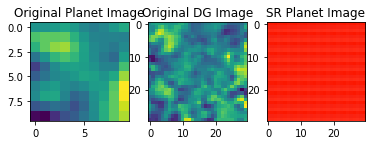

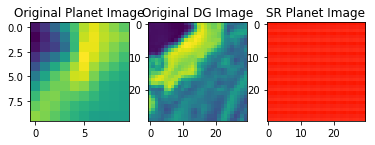

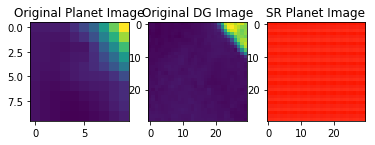

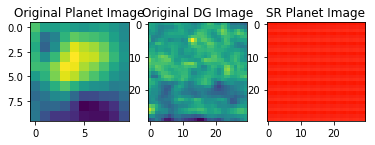

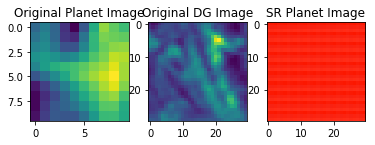

In [75]:
# create some sample indices
val_samples = np.random.rand(5)*1000
val_samples = list(val_samples.astype('uint8'))

val_results = []
for idx in val_samples:
    
    # get the validation set index
    samp_idx = val_list[idx]
    
    # extract the planet and DG images
    pl_im = pl_T_dataset[samp_idx] 
    dg_im = dg_T_dataset[samp_idx]
    
    # assign them to PyTorch Variables
    input, target = Variable(pl_im.unsqueeze(0).float()), \
                    Variable(dg_im.unsqueeze(0).float())
    
    # is using the GPU, put on the GPU
    if cuda:
            input = input.cuda()
            target = target.cuda()

    # make the super-resolution prediction
    prediction = model(input)
    
    # convert tensors to numpy arrays for plotting
    pl_arr = input.data.cpu().numpy()
    pl_arr = pl_arr.squeeze()
    
    dg_arr = target.data.cpu().numpy()
    dg_arr = dg_arr.squeeze()
    
    sr_arr = prediction.data.cpu().numpy()
    sr_arr = sr_arr.squeeze()
    val_results.append(sr_arr)
    
    ## plot the figure    
    plt.subplot(1,3,1)
    plt.imshow(pl_arr[3,:,:])
    plt.title('Original Planet Image')
    
    plt.subplot(1,3,2)
    plt.imshow(dg_arr[3,:,:])
    plt.title('Original DG Image')
    
    plt.subplot(1,3,3)
    plot_im = misc.bytescale(np.rollaxis(sr_arr[[2,1,0],:,:], 0,3))
    plt.imshow(plot_im)
    plt.title('SR Planet Image')
    
    plt.show()
    
    

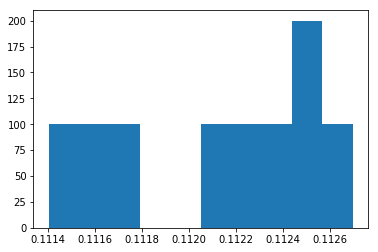

0.0


In [76]:
# look at some histograms
plt.hist(val_results[3][0,:,:].ravel(), histtype='bar')
plt.show()

# print the sum of a difference image... they are exactly the same! and thus the difference sums to zero.
# not good.
print(np.sum(val_results[1][0,:,:] - val_results[2][0,:,:]))



# Appendix: Code that wasn't used

In [9]:
## read the data for all of the files
# training_pl = [getDims(f) for f in planet_files[:train_len+1]]
# test_pl = [getDims(f) for f in planet_files[train_len:train_len + test_len + 1]]
# validation_pl = [getDims(f) for f in planet_files[train_len + test_len:]]

# training_dg = [getDims(f) for f in dg_files[:train_len+1]]
# test_dg = [getDims(f) for f in dg_files[train_len:train_len + test_len + 1]]
# validation_dg = [getDims(f) for f in dg_files[train_len + test_len:]]

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  
/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  import sys


In [10]:
## need to extract the BGRN bands from the DG arrays
# bgrn = [1,2,4,6]
# training_dg_arr = [tup[1][bgrn,:,:] for tup in training_dg]
# test_dg_arr = [tup[1][bgrn,:,:] for tup in test_dg]
# validation_dg_arr = [tup[1][bgrn,:,:] for tup in validation_dg]

In [ ]:
## then, need to resize DG arrays to planet array shapes
# pl_shp = training_pl[0][1].shape
# upscale_factor = 3
# new_shp = (pl_shp[0], pl_shp[1]*upscale_factor, pl_shp[2]*upscale_factor)
# training_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in training_dg_arr]
# test_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in test_dg_arr]
# validation_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in validation_dg_arr]

In [19]:
## extract the planet arrays
# training_pl_arr = [tup[1] for tup in training_pl]
# test_pl_arr = [tup[1] for tup in test_pl]
# validation_pl_arr = [tup[1] for tup in validation_pl]

### need to normalize the data in the array by something... max()? Maximum bit value, e.g., 2^11?

In [35]:
# scale_factor = 10000 # this is used to normalize to surface reflectance as per file metadata
# trX = torch.from_numpy(np.asarray(training_pl_arr).astype('float')) / scale_factor
# trY = torch.from_numpy(np.asarray(training_dg_rs).astype('float')) / scale_factor

# teX = torch.from_numpy(np.asarray(test_pl_arr).astype('float')) / scale_factor
# teY = torch.from_numpy(np.asarray(test_dg_rs).astype('float')) / scale_factor

# valX = torch.from_numpy(np.asarray(validation_pl_arr).astype('float')) / scale_factor
# valY = torch.from_numpy(np.asarray(validation_dg_rs).astype('float')) / scale_factor

In [62]:
## test the model
# testing = valX[0].unsqueeze(0) # the .unsqueeze(0) ensure batch dim == 1, eg., [1,bands,rows,cols]
# testing = Variable(testing)
# testing = testing.float()
# output = model(testing)
# print(output.size())

# # visualize it
# arr_random = output.data.numpy()
# arr_random = arr.squeeze()
# # plt.imshow(arr[0,:,:])

torch.Size([1, 4, 30, 30])
